##### Group Members:

**Amogh Chakkarwar (001216568) CSYE7245 Sec 01**

**Mohit Arya (001814246) CSYE7245 Sec 01**

**Shashank Jain (001880628) INFO7390 Sec 04**

<a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/3.0/us/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/">Creative Commons Attribution 3.0 United States License</a>.

## Image Generation using GAN(Generative Adversarial Networks)

GANs are deep neural network architectures comprised of two networks, pitting one against the other (thus the “adversarial”). It's potential is huge, because they can learn to mimic any distribution of data. That is, GANs can be taught to create worlds mysteriously similar to our own in any domain: images, music, speech, prose. They are robot artists in a sense, and their output is impressive – poignant even.

### How GANs work
One neural network, called the *generator*, generates new data instances, while the other, the *discriminator*, evaluates them for authenticity; i.e. the discriminator decides whether each instance of data it reviews belongs to the actual training dataset or not.

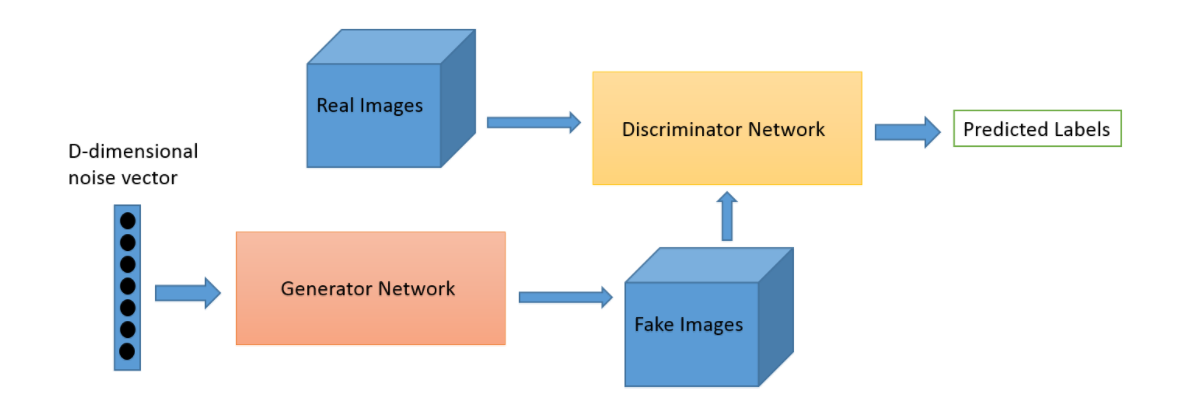

#### Here are the steps a GAN takes:
 - The generator takes in random numbers and returns an image
 - This generated image is fed into the discriminator alongside a stream of images taken from the actual dataset
 - The discriminator takes in both real and fake images and returns probabilities, a number between 0 and 1, with 1 representing a prediction of authenticity and 0 representing fake
 
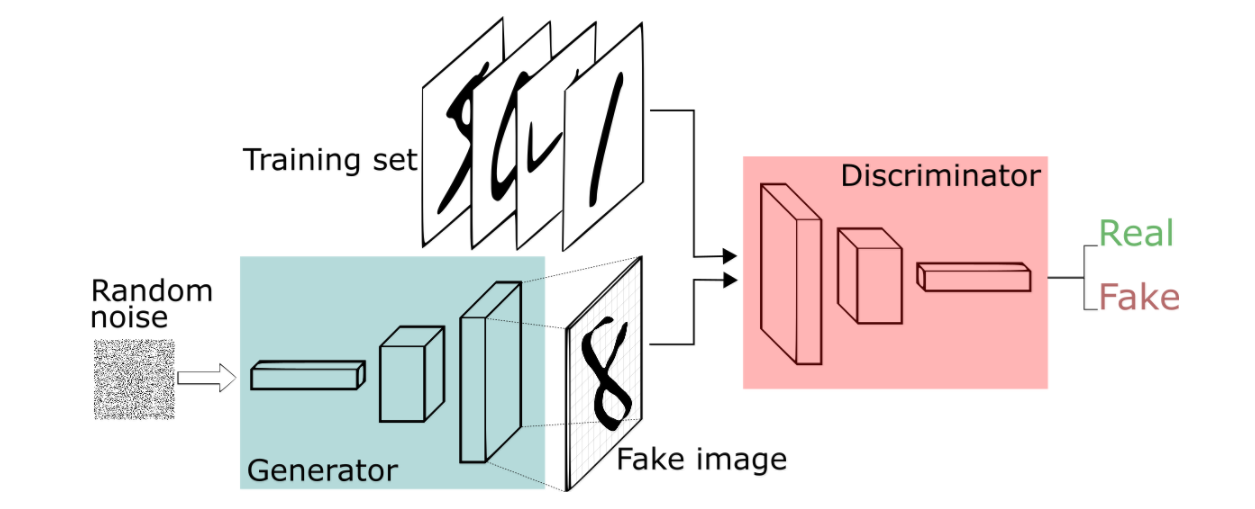

In [2]:
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class GAN():
    def __init__(self):
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1 #For black and white 1, for color 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        self.discriminator = Sequential()

        self.discriminator.add(Flatten(input_shape=img_shape))
        self.discriminator.add(Dense(512))
        self.discriminator.add(LeakyReLU(alpha=0.2))
        self.discriminator.add(Dense(256))
        self.discriminator.add(LeakyReLU(alpha=0.2))
        self.discriminator.add(Dense(1, activation='sigmoid'))
        self.discriminator.summary()

        img = Input(shape=img_shape)
        validity = self.discriminator(img)

        return Model(img, validity)
    
    def build_generator(self):

        noise_shape = (100,)
        
        self.generator = Sequential()

        self.generator.add(Dense(256, input_shape=noise_shape))
        self.generator.add(LeakyReLU(alpha=0.2))
        self.generator.add(BatchNormalization(momentum=0.8))
        self.generator.add(Dense(512))
        self.generator.add(LeakyReLU(alpha=0.2))
        self.generator.add(BatchNormalization(momentum=0.8))
        self.generator.add(Dense(1024))
        self.generator.add(LeakyReLU(alpha=0.2))
        self.generator.add(BatchNormalization(momentum=0.8))
        self.generator.add(Dense(2048))
        self.generator.add(LeakyReLU(alpha=0.2))
        self.generator.add(BatchNormalization(momentum=0.8))
        self.generator.add(Dense(np.prod(self.img_shape), activation='tanh'))
        self.generator.add(Reshape(self.img_shape))

        self.generator.summary()

        noise = Input(shape=noise_shape)
        img = self.generator(noise)

        return Model(noise, img)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)
        
        epoch_list = []
        #create list of accuracy to plot the graph
        acc_list = []

        for epoch in range(epochs):
            #  Train Discriminator
            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Train Generator

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            #Adding the accuracy into the Accuracy list for plotting graph
            acc_list.append(100*d_loss[1])
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
        #Plot the graph of Accuracy vs Number of epochs
        plt.plot(acc_list,label="Accuracy")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("GAN_mnist_%d.png" % epoch)
        plt.close()

#### Code Reference
The code in the document by deeplearning4j/deeplearning4j is licensed under the Apache License 2.0

We added an extra layer in generator to improve the output. Plotting the graph of Accuracy and epochs. Also tuning the hyper parameters

#### Why we use Activation functions with Neural Networks?

It is used to determine the output of neural network like yes or no. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).

##### The Activation Functions can be basically divided into 2 types-
 1. Linear Activation Function
 2. Non-linear Activation Functions
 
#### 1. Linear or Identity Activation Function
Here the function is a line or linear.Therefore, the output of the functions will not be confined between any range.

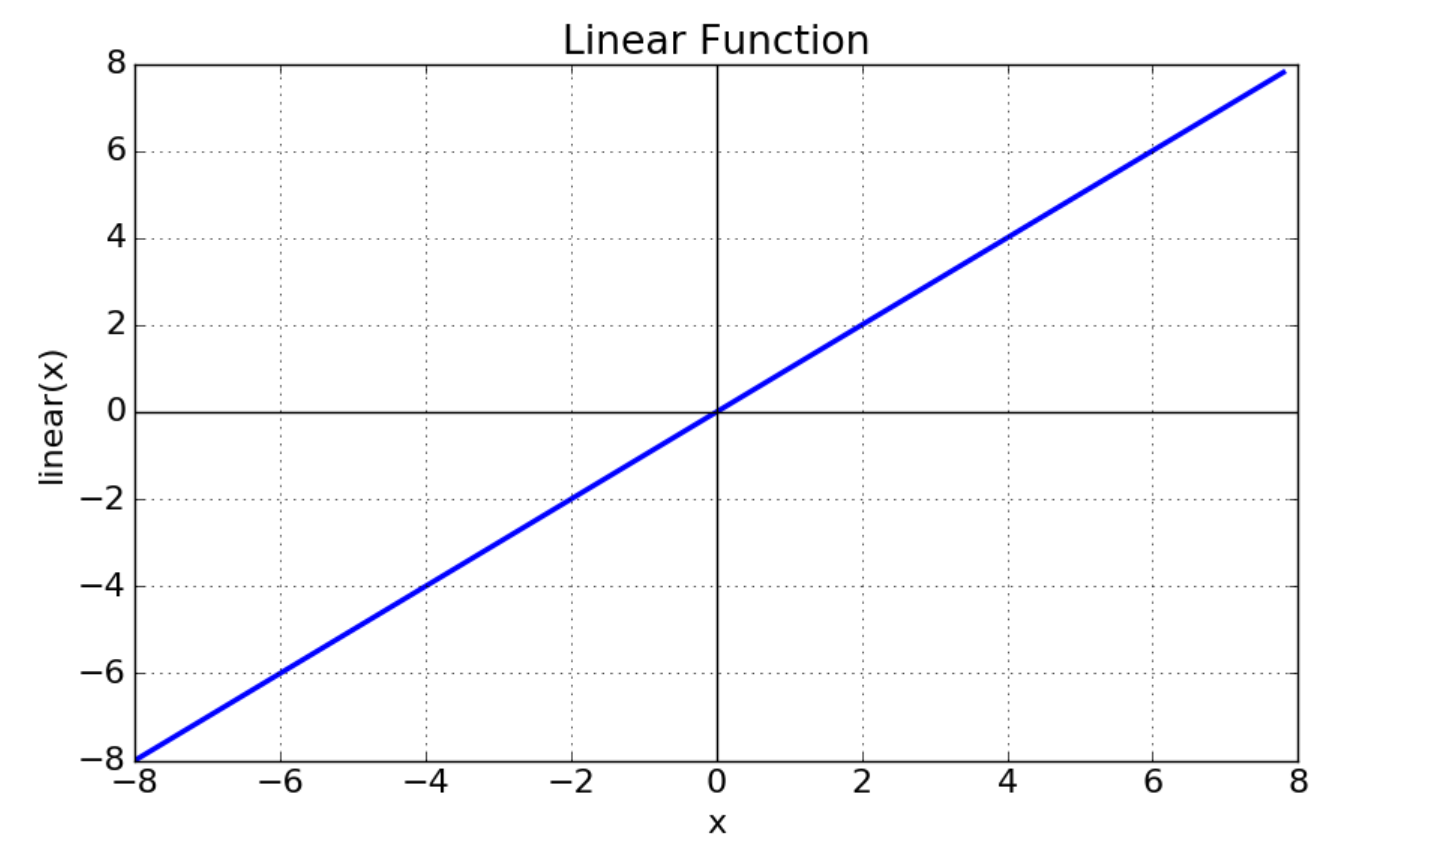

**Range** : (-infinity to infinity)

#### 2. Non-linear Activation Functions
The Nonlinear Activation Functions are the most used activation functions. It makes it easy for the model to generalize or adapt with variety of data and to differentiate between the output.

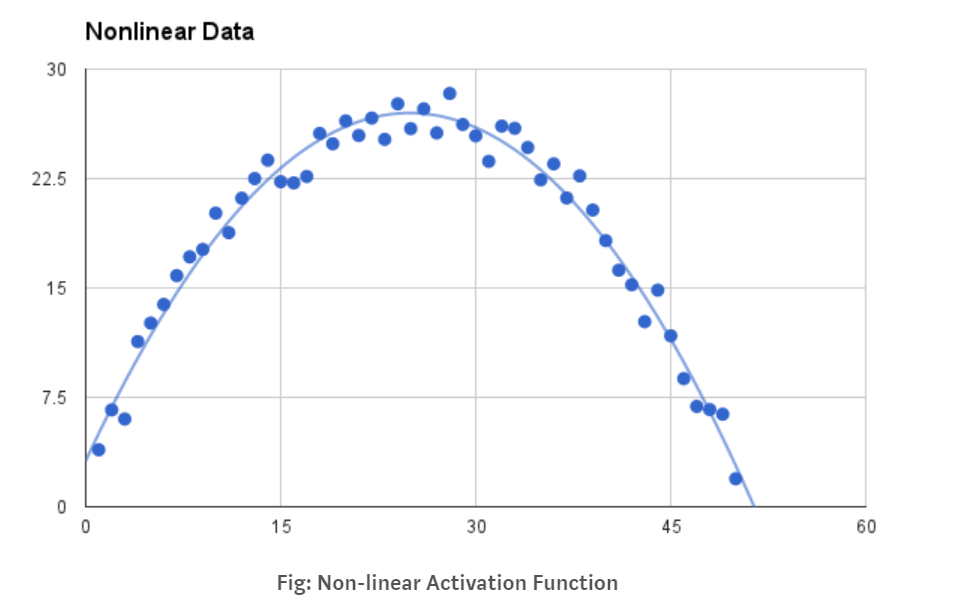

 __1. Sigmoid or Logistic Activation Function__
The Sigmoid Function curve looks like a S-shape.
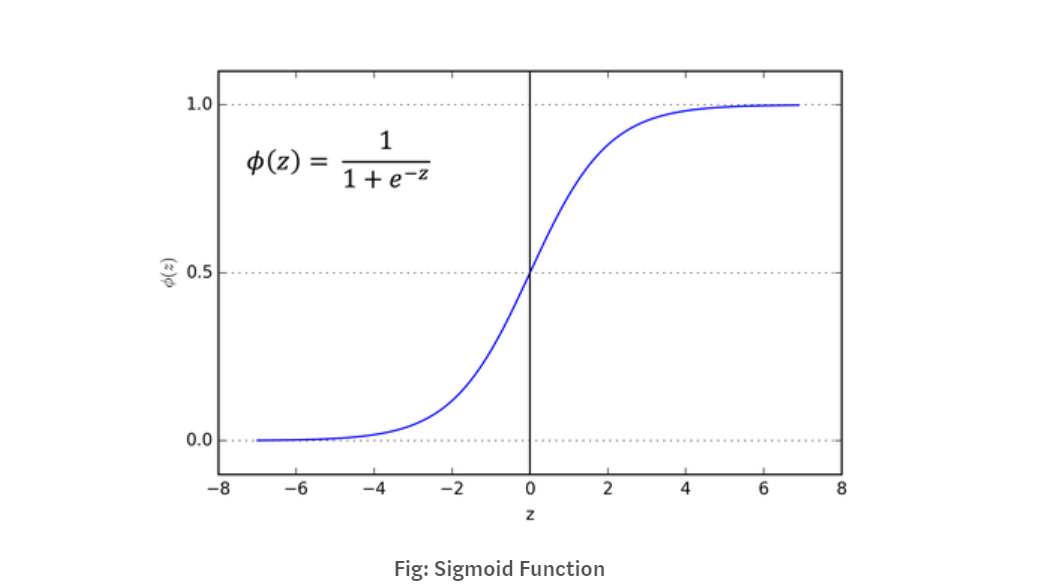
The main reason why we use sigmoid function is because it exists between (0 to 1). Therefore, it is especially used for models where we have to __predict the probability__ as an output. Since probability of anything exists only between the range of __0 and 1__, sigmoid is the right choice.

**The Discriminator in GAN predicts the authenticity of the generated image and gives output as 0 or 1. Hence for Discriminator we are using Sigmoid as an Activation function.**

 __2. Tanh or hyperbolic tangent Activation Function__
tanh is also like logistic sigmoid but better. The range of the tanh function is from (-1 to 1). tanh is also sigmoidal (s - shaped).

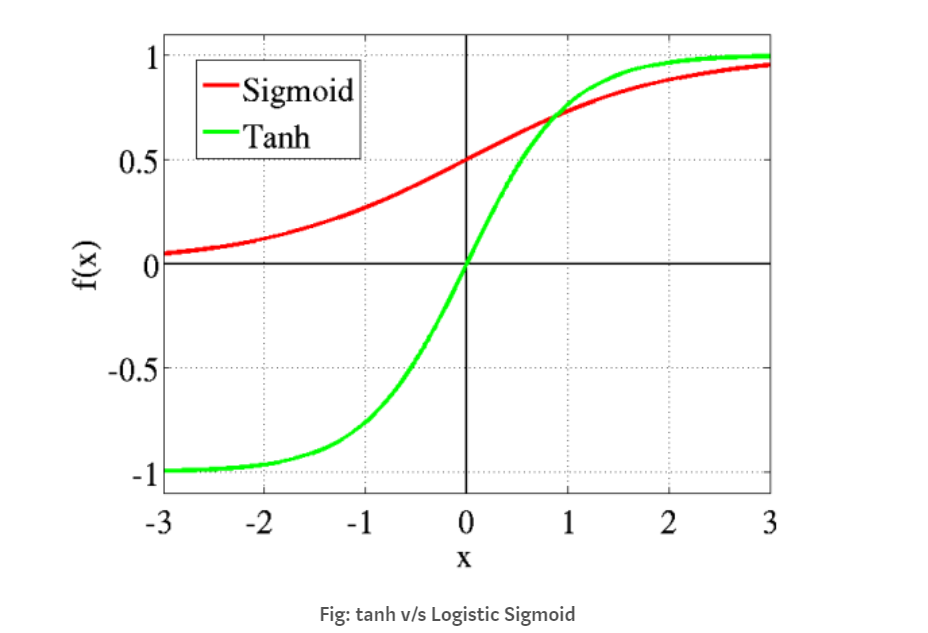

The advantage is that the negative inputs will be mapped strongly negative and the zero inputs will be mapped near zero in the tanh graph. The tanh function is mainly used classification between two classes.

 __3. ReLU (Rectified Linear Unit) Activation Function__
The ReLU is the most used activation function in the world.Since, it is used in almost all the convolutional neural networks or deep learning.

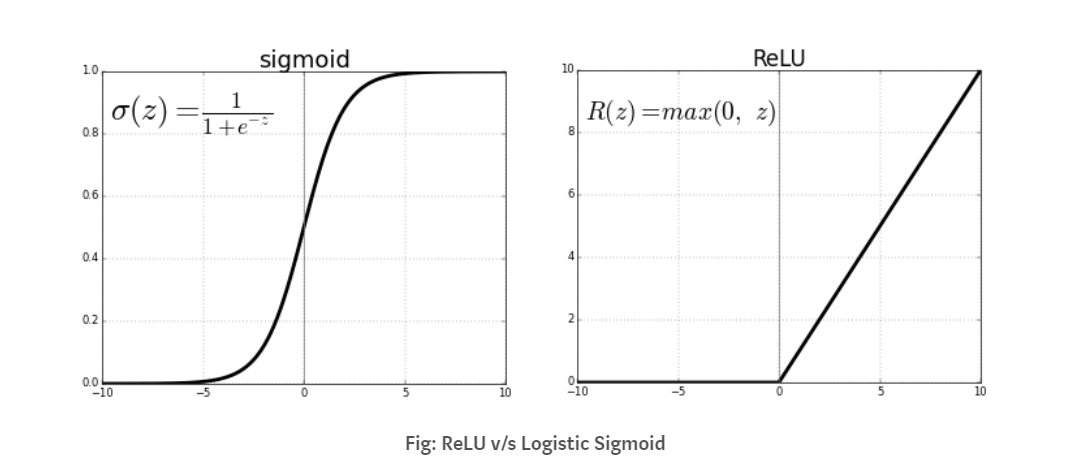

__Range)): [ 0 to infinity)

The issue with ReLU is that all the negative values become zero immediately which decreases the ability of the model to fit or train from the data properly. That means any negative input given to the ReLU activation function turns the value into zero immediately in the graph, which in turns affects the resulting graph by not mapping the negative values appropriately.

 __4. Leaky ReLU__
It is an attempt to solve the dying ReLU problem
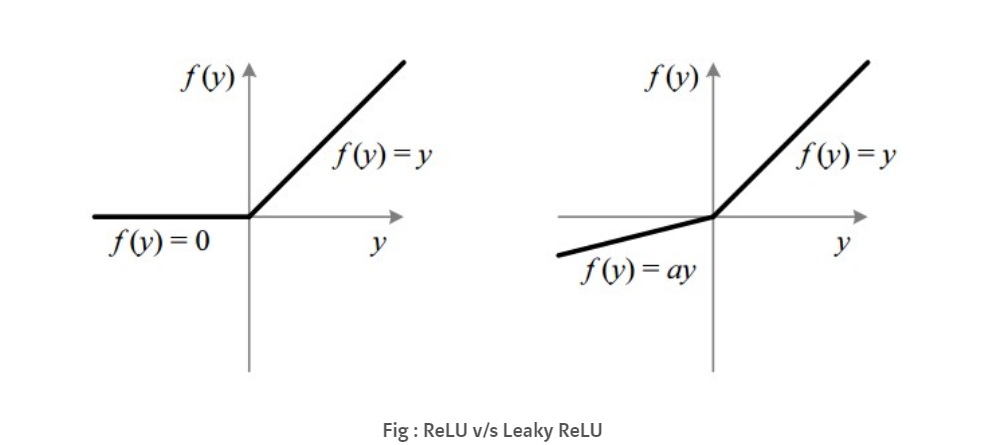

The leak helps to increase the range of the ReLU function.Usually, the value of a is 0.01 or so.

Therefore the range of the Leaky ReLU is (-infinity to infinity).



In [4]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=5000, batch_size=64, save_interval=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

C:\Users\Amogh\Anaconda3\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.506355, acc.: 90.62%] [G loss: 0.635492]
1 [D loss: 0.414780, acc.: 75.00%] [G loss: 0.784909]
2 [D loss: 0.379297, acc.: 76.56%] [G loss: 0.875859]
3 [D loss: 0.287822, acc.: 84.38%] [G loss: 1.131637]
4 [D loss: 0.184910, acc.: 98.44%] [G loss: 1.251998]
5 [D loss: 0.222169, acc.: 95.31%] [G loss: 1.323184]
6 [D loss: 0.171729, acc.: 98.44%] [G loss: 1.493400]
7 [D loss: 0.162311, acc.: 100.00%] [G loss: 1.572077]
8 [D loss: 0.120139, acc.: 100.00%] [G loss: 1.689931]
9 [D loss: 0.116325, acc.: 100.00%] [G loss: 1.780467]
10 [D loss: 0.121948, acc.: 100.00%] [G loss: 1.925137]
11 [D loss: 0.105248, acc.: 100.00%] [G loss: 1.945965]
12 [D loss: 0.093411, acc.: 100.00%] [G loss: 2.135377]
13 [D loss: 0.087101, acc.: 100.00%] [G loss: 2.109488]
14 [D loss: 0.076610, acc.: 100.00%] [G loss: 2.201430]
15 [D loss: 0.072330, acc.: 100.00%] [G loss: 2.269458]
16 [D loss: 0.079455, acc.: 100.00%] [G loss: 2.375021]
17 [D loss: 0.062294, acc.: 100.00%] [G loss: 2.456397]
18 [D los

147 [D loss: 0.133704, acc.: 98.44%] [G loss: 3.330808]
148 [D loss: 0.132334, acc.: 95.31%] [G loss: 3.520644]
149 [D loss: 0.187899, acc.: 93.75%] [G loss: 2.844915]
150 [D loss: 0.257064, acc.: 90.62%] [G loss: 3.282843]
151 [D loss: 0.406003, acc.: 84.38%] [G loss: 2.224684]
152 [D loss: 0.189186, acc.: 89.06%] [G loss: 3.214494]
153 [D loss: 0.210735, acc.: 87.50%] [G loss: 2.569022]
154 [D loss: 0.118983, acc.: 96.88%] [G loss: 3.188782]
155 [D loss: 0.190434, acc.: 93.75%] [G loss: 2.894254]
156 [D loss: 0.178154, acc.: 95.31%] [G loss: 3.019364]
157 [D loss: 0.271731, acc.: 87.50%] [G loss: 2.472885]
158 [D loss: 0.170351, acc.: 95.31%] [G loss: 2.966234]
159 [D loss: 0.436069, acc.: 76.56%] [G loss: 2.223845]
160 [D loss: 0.156850, acc.: 95.31%] [G loss: 3.374588]
161 [D loss: 1.140996, acc.: 42.19%] [G loss: 1.309353]
162 [D loss: 0.506587, acc.: 73.44%] [G loss: 2.108438]
163 [D loss: 0.119626, acc.: 96.88%] [G loss: 3.591512]
164 [D loss: 0.091346, acc.: 100.00%] [G loss: 3

294 [D loss: 0.709158, acc.: 46.88%] [G loss: 0.674701]
295 [D loss: 0.698716, acc.: 46.88%] [G loss: 0.667606]
296 [D loss: 0.681117, acc.: 46.88%] [G loss: 0.679929]
297 [D loss: 0.683174, acc.: 46.88%] [G loss: 0.703383]
298 [D loss: 0.725262, acc.: 42.19%] [G loss: 0.687111]
299 [D loss: 0.685463, acc.: 51.56%] [G loss: 0.693135]
300 [D loss: 0.718164, acc.: 40.62%] [G loss: 0.651363]
301 [D loss: 0.717919, acc.: 43.75%] [G loss: 0.651655]
302 [D loss: 0.679834, acc.: 46.88%] [G loss: 0.677847]
303 [D loss: 0.696573, acc.: 40.62%] [G loss: 0.668633]
304 [D loss: 0.690130, acc.: 50.00%] [G loss: 0.674250]
305 [D loss: 0.628709, acc.: 64.06%] [G loss: 0.706771]
306 [D loss: 0.677878, acc.: 60.94%] [G loss: 0.745628]
307 [D loss: 0.705249, acc.: 54.69%] [G loss: 0.716077]
308 [D loss: 0.682409, acc.: 53.12%] [G loss: 0.688236]
309 [D loss: 0.717100, acc.: 48.44%] [G loss: 0.656824]
310 [D loss: 0.692562, acc.: 54.69%] [G loss: 0.675073]
311 [D loss: 0.666406, acc.: 51.56%] [G loss: 0.

442 [D loss: 0.677207, acc.: 42.19%] [G loss: 0.677849]
443 [D loss: 0.660191, acc.: 48.44%] [G loss: 0.680882]
444 [D loss: 0.672247, acc.: 48.44%] [G loss: 0.686002]
445 [D loss: 0.682591, acc.: 46.88%] [G loss: 0.674093]
446 [D loss: 0.667828, acc.: 46.88%] [G loss: 0.681607]
447 [D loss: 0.672048, acc.: 51.56%] [G loss: 0.686321]
448 [D loss: 0.658035, acc.: 54.69%] [G loss: 0.705868]
449 [D loss: 0.682734, acc.: 53.12%] [G loss: 0.704681]
450 [D loss: 0.663565, acc.: 51.56%] [G loss: 0.684788]
451 [D loss: 0.663126, acc.: 46.88%] [G loss: 0.675312]
452 [D loss: 0.678765, acc.: 50.00%] [G loss: 0.690441]
453 [D loss: 0.664890, acc.: 50.00%] [G loss: 0.682439]
454 [D loss: 0.663656, acc.: 48.44%] [G loss: 0.677699]
455 [D loss: 0.686608, acc.: 48.44%] [G loss: 0.663965]
456 [D loss: 0.652854, acc.: 48.44%] [G loss: 0.674236]
457 [D loss: 0.642668, acc.: 54.69%] [G loss: 0.688849]
458 [D loss: 0.675463, acc.: 48.44%] [G loss: 0.698854]
459 [D loss: 0.667424, acc.: 53.12%] [G loss: 0.

591 [D loss: 0.659546, acc.: 57.81%] [G loss: 0.779206]
592 [D loss: 0.660428, acc.: 50.00%] [G loss: 0.764145]
593 [D loss: 0.657767, acc.: 62.50%] [G loss: 0.764858]
594 [D loss: 0.651510, acc.: 62.50%] [G loss: 0.782332]
595 [D loss: 0.640609, acc.: 60.94%] [G loss: 0.758617]
596 [D loss: 0.626781, acc.: 62.50%] [G loss: 0.750390]
597 [D loss: 0.664091, acc.: 53.12%] [G loss: 0.737943]
598 [D loss: 0.662822, acc.: 57.81%] [G loss: 0.739575]
599 [D loss: 0.632776, acc.: 70.31%] [G loss: 0.731642]
600 [D loss: 0.657190, acc.: 56.25%] [G loss: 0.745476]
601 [D loss: 0.616349, acc.: 60.94%] [G loss: 0.760953]
602 [D loss: 0.643532, acc.: 59.38%] [G loss: 0.739543]
603 [D loss: 0.619898, acc.: 56.25%] [G loss: 0.742736]
604 [D loss: 0.623378, acc.: 60.94%] [G loss: 0.713760]
605 [D loss: 0.640137, acc.: 56.25%] [G loss: 0.713338]
606 [D loss: 0.612407, acc.: 60.94%] [G loss: 0.718484]
607 [D loss: 0.654188, acc.: 59.38%] [G loss: 0.716654]
608 [D loss: 0.656280, acc.: 65.62%] [G loss: 0.

738 [D loss: 0.630786, acc.: 57.81%] [G loss: 0.825807]
739 [D loss: 0.637383, acc.: 64.06%] [G loss: 0.857000]
740 [D loss: 0.640421, acc.: 62.50%] [G loss: 0.830528]
741 [D loss: 0.630632, acc.: 65.62%] [G loss: 0.801515]
742 [D loss: 0.591651, acc.: 67.19%] [G loss: 0.825021]
743 [D loss: 0.625193, acc.: 62.50%] [G loss: 0.863467]
744 [D loss: 0.640540, acc.: 62.50%] [G loss: 0.837869]
745 [D loss: 0.669152, acc.: 54.69%] [G loss: 0.832021]
746 [D loss: 0.669831, acc.: 59.38%] [G loss: 0.810088]
747 [D loss: 0.658948, acc.: 60.94%] [G loss: 0.795934]
748 [D loss: 0.668391, acc.: 54.69%] [G loss: 0.812481]
749 [D loss: 0.642451, acc.: 62.50%] [G loss: 0.842811]
750 [D loss: 0.654096, acc.: 50.00%] [G loss: 0.889145]
751 [D loss: 0.672386, acc.: 54.69%] [G loss: 0.883587]
752 [D loss: 0.633596, acc.: 76.56%] [G loss: 0.845486]
753 [D loss: 0.660454, acc.: 57.81%] [G loss: 0.807849]
754 [D loss: 0.639157, acc.: 65.62%] [G loss: 0.821556]
755 [D loss: 0.624997, acc.: 70.31%] [G loss: 0.

886 [D loss: 0.627994, acc.: 73.44%] [G loss: 0.825692]
887 [D loss: 0.606145, acc.: 76.56%] [G loss: 0.826094]
888 [D loss: 0.632814, acc.: 68.75%] [G loss: 0.849704]
889 [D loss: 0.576098, acc.: 87.50%] [G loss: 0.861870]
890 [D loss: 0.589955, acc.: 81.25%] [G loss: 0.823361]
891 [D loss: 0.620328, acc.: 65.62%] [G loss: 0.870431]
892 [D loss: 0.575891, acc.: 78.12%] [G loss: 0.857790]
893 [D loss: 0.624108, acc.: 59.38%] [G loss: 0.845536]
894 [D loss: 0.618850, acc.: 71.88%] [G loss: 0.839201]
895 [D loss: 0.577648, acc.: 79.69%] [G loss: 0.851043]
896 [D loss: 0.626856, acc.: 59.38%] [G loss: 0.862495]
897 [D loss: 0.616348, acc.: 70.31%] [G loss: 0.844616]
898 [D loss: 0.607630, acc.: 67.19%] [G loss: 0.851946]
899 [D loss: 0.607544, acc.: 65.62%] [G loss: 0.872380]
900 [D loss: 0.599149, acc.: 73.44%] [G loss: 0.846043]
901 [D loss: 0.617205, acc.: 70.31%] [G loss: 0.845182]
902 [D loss: 0.611357, acc.: 67.19%] [G loss: 0.834243]
903 [D loss: 0.653888, acc.: 65.62%] [G loss: 0.

1034 [D loss: 0.606622, acc.: 73.44%] [G loss: 0.920125]
1035 [D loss: 0.641340, acc.: 60.94%] [G loss: 0.898914]
1036 [D loss: 0.657710, acc.: 60.94%] [G loss: 0.901863]
1037 [D loss: 0.581048, acc.: 81.25%] [G loss: 0.979812]
1038 [D loss: 0.587198, acc.: 78.12%] [G loss: 0.964377]
1039 [D loss: 0.613687, acc.: 68.75%] [G loss: 0.926665]
1040 [D loss: 0.613443, acc.: 71.88%] [G loss: 0.939458]
1041 [D loss: 0.583921, acc.: 78.12%] [G loss: 0.932591]
1042 [D loss: 0.627345, acc.: 65.62%] [G loss: 0.864212]
1043 [D loss: 0.649616, acc.: 54.69%] [G loss: 0.801651]
1044 [D loss: 0.613585, acc.: 67.19%] [G loss: 0.861172]
1045 [D loss: 0.610674, acc.: 68.75%] [G loss: 0.893133]
1046 [D loss: 0.618393, acc.: 70.31%] [G loss: 0.895108]
1047 [D loss: 0.625054, acc.: 71.88%] [G loss: 0.873327]
1048 [D loss: 0.641594, acc.: 62.50%] [G loss: 0.830025]
1049 [D loss: 0.603933, acc.: 68.75%] [G loss: 0.879111]
1050 [D loss: 0.641827, acc.: 62.50%] [G loss: 0.864243]
1051 [D loss: 0.593686, acc.: 7

1178 [D loss: 0.635659, acc.: 54.69%] [G loss: 0.948106]
1179 [D loss: 0.593517, acc.: 76.56%] [G loss: 0.974374]
1180 [D loss: 0.570134, acc.: 79.69%] [G loss: 0.909695]
1181 [D loss: 0.638495, acc.: 65.62%] [G loss: 0.879308]
1182 [D loss: 0.551503, acc.: 85.94%] [G loss: 0.909114]
1183 [D loss: 0.603518, acc.: 68.75%] [G loss: 0.892585]
1184 [D loss: 0.581056, acc.: 78.12%] [G loss: 0.924142]
1185 [D loss: 0.548871, acc.: 79.69%] [G loss: 0.972398]
1186 [D loss: 0.599198, acc.: 75.00%] [G loss: 0.935429]
1187 [D loss: 0.557319, acc.: 82.81%] [G loss: 0.935769]
1188 [D loss: 0.565556, acc.: 76.56%] [G loss: 0.897722]
1189 [D loss: 0.550370, acc.: 81.25%] [G loss: 0.925221]
1190 [D loss: 0.558567, acc.: 78.12%] [G loss: 0.950518]
1191 [D loss: 0.556181, acc.: 82.81%] [G loss: 0.958770]
1192 [D loss: 0.547070, acc.: 81.25%] [G loss: 0.980121]
1193 [D loss: 0.561650, acc.: 82.81%] [G loss: 0.968647]
1194 [D loss: 0.574241, acc.: 68.75%] [G loss: 0.966871]
1195 [D loss: 0.603275, acc.: 7

1322 [D loss: 0.675904, acc.: 57.81%] [G loss: 0.916957]
1323 [D loss: 0.593862, acc.: 76.56%] [G loss: 0.934453]
1324 [D loss: 0.579838, acc.: 78.12%] [G loss: 0.932090]
1325 [D loss: 0.606072, acc.: 62.50%] [G loss: 0.963537]
1326 [D loss: 0.642328, acc.: 54.69%] [G loss: 0.975429]
1327 [D loss: 0.622393, acc.: 67.19%] [G loss: 0.979731]
1328 [D loss: 0.631887, acc.: 64.06%] [G loss: 0.898518]
1329 [D loss: 0.618698, acc.: 70.31%] [G loss: 0.871162]
1330 [D loss: 0.640730, acc.: 57.81%] [G loss: 0.964110]
1331 [D loss: 0.628282, acc.: 62.50%] [G loss: 0.978600]
1332 [D loss: 0.617823, acc.: 64.06%] [G loss: 0.913389]
1333 [D loss: 0.623932, acc.: 65.62%] [G loss: 0.891468]
1334 [D loss: 0.618616, acc.: 62.50%] [G loss: 0.878591]
1335 [D loss: 0.624659, acc.: 67.19%] [G loss: 0.877798]
1336 [D loss: 0.603389, acc.: 68.75%] [G loss: 0.812741]
1337 [D loss: 0.584275, acc.: 75.00%] [G loss: 0.821374]
1338 [D loss: 0.588685, acc.: 78.12%] [G loss: 0.877365]
1339 [D loss: 0.552321, acc.: 7

1466 [D loss: 0.604077, acc.: 78.12%] [G loss: 0.904752]
1467 [D loss: 0.582802, acc.: 71.88%] [G loss: 0.913943]
1468 [D loss: 0.655997, acc.: 60.94%] [G loss: 0.947206]
1469 [D loss: 0.588340, acc.: 68.75%] [G loss: 1.038051]
1470 [D loss: 0.596342, acc.: 68.75%] [G loss: 0.955356]
1471 [D loss: 0.548147, acc.: 76.56%] [G loss: 0.953834]
1472 [D loss: 0.549426, acc.: 78.12%] [G loss: 0.957837]
1473 [D loss: 0.600057, acc.: 67.19%] [G loss: 0.957524]
1474 [D loss: 0.578190, acc.: 70.31%] [G loss: 0.932508]
1475 [D loss: 0.578736, acc.: 70.31%] [G loss: 0.933614]
1476 [D loss: 0.543669, acc.: 78.12%] [G loss: 0.878783]
1477 [D loss: 0.591788, acc.: 65.62%] [G loss: 0.901845]
1478 [D loss: 0.626282, acc.: 62.50%] [G loss: 0.874819]
1479 [D loss: 0.618381, acc.: 65.62%] [G loss: 0.917940]
1480 [D loss: 0.590824, acc.: 68.75%] [G loss: 0.875798]
1481 [D loss: 0.549570, acc.: 78.12%] [G loss: 0.850281]
1482 [D loss: 0.548718, acc.: 73.44%] [G loss: 0.857230]
1483 [D loss: 0.638502, acc.: 6

1611 [D loss: 0.616068, acc.: 78.12%] [G loss: 0.922731]
1612 [D loss: 0.625787, acc.: 65.62%] [G loss: 0.925665]
1613 [D loss: 0.594820, acc.: 71.88%] [G loss: 0.855130]
1614 [D loss: 0.558283, acc.: 78.12%] [G loss: 0.916615]
1615 [D loss: 0.587108, acc.: 75.00%] [G loss: 0.910717]
1616 [D loss: 0.595856, acc.: 71.88%] [G loss: 0.880295]
1617 [D loss: 0.622953, acc.: 62.50%] [G loss: 0.912563]
1618 [D loss: 0.590944, acc.: 70.31%] [G loss: 0.935387]
1619 [D loss: 0.559163, acc.: 84.38%] [G loss: 0.935883]
1620 [D loss: 0.517239, acc.: 81.25%] [G loss: 0.929286]
1621 [D loss: 0.589381, acc.: 70.31%] [G loss: 0.871882]
1622 [D loss: 0.576998, acc.: 76.56%] [G loss: 0.956755]
1623 [D loss: 0.592896, acc.: 73.44%] [G loss: 0.975313]
1624 [D loss: 0.590550, acc.: 75.00%] [G loss: 0.884508]
1625 [D loss: 0.596073, acc.: 75.00%] [G loss: 0.908439]
1626 [D loss: 0.589429, acc.: 71.88%] [G loss: 0.850630]
1627 [D loss: 0.605057, acc.: 64.06%] [G loss: 0.913036]
1628 [D loss: 0.574773, acc.: 7

1757 [D loss: 0.596052, acc.: 73.44%] [G loss: 0.981463]
1758 [D loss: 0.673164, acc.: 62.50%] [G loss: 0.949915]
1759 [D loss: 0.631442, acc.: 67.19%] [G loss: 0.926937]
1760 [D loss: 0.615529, acc.: 62.50%] [G loss: 0.922213]
1761 [D loss: 0.600549, acc.: 67.19%] [G loss: 0.943180]
1762 [D loss: 0.556066, acc.: 73.44%] [G loss: 0.916186]
1763 [D loss: 0.577193, acc.: 71.88%] [G loss: 0.972941]
1764 [D loss: 0.607608, acc.: 65.62%] [G loss: 0.956308]
1765 [D loss: 0.638340, acc.: 65.62%] [G loss: 0.980769]
1766 [D loss: 0.541605, acc.: 73.44%] [G loss: 0.936894]
1767 [D loss: 0.635602, acc.: 60.94%] [G loss: 1.010740]
1768 [D loss: 0.649011, acc.: 65.62%] [G loss: 0.987902]
1769 [D loss: 0.510672, acc.: 79.69%] [G loss: 1.032529]
1770 [D loss: 0.628653, acc.: 60.94%] [G loss: 1.062784]
1771 [D loss: 0.558374, acc.: 76.56%] [G loss: 0.971798]
1772 [D loss: 0.638142, acc.: 65.62%] [G loss: 0.926540]
1773 [D loss: 0.605503, acc.: 62.50%] [G loss: 0.921041]
1774 [D loss: 0.605150, acc.: 7

1901 [D loss: 0.632985, acc.: 59.38%] [G loss: 1.011684]
1902 [D loss: 0.591101, acc.: 71.88%] [G loss: 0.974398]
1903 [D loss: 0.614512, acc.: 68.75%] [G loss: 0.905725]
1904 [D loss: 0.610454, acc.: 71.88%] [G loss: 0.940292]
1905 [D loss: 0.577505, acc.: 71.88%] [G loss: 0.935920]
1906 [D loss: 0.565197, acc.: 79.69%] [G loss: 0.922154]
1907 [D loss: 0.610919, acc.: 68.75%] [G loss: 0.896282]
1908 [D loss: 0.614778, acc.: 65.62%] [G loss: 0.946426]
1909 [D loss: 0.618529, acc.: 67.19%] [G loss: 0.938183]
1910 [D loss: 0.577709, acc.: 73.44%] [G loss: 0.978196]
1911 [D loss: 0.607625, acc.: 65.62%] [G loss: 1.004174]
1912 [D loss: 0.671342, acc.: 59.38%] [G loss: 1.008873]
1913 [D loss: 0.606220, acc.: 65.62%] [G loss: 0.938892]
1914 [D loss: 0.609411, acc.: 65.62%] [G loss: 0.927308]
1915 [D loss: 0.591276, acc.: 67.19%] [G loss: 0.900343]
1916 [D loss: 0.662303, acc.: 60.94%] [G loss: 0.909044]
1917 [D loss: 0.588130, acc.: 67.19%] [G loss: 0.943831]
1918 [D loss: 0.634205, acc.: 6

2046 [D loss: 0.611003, acc.: 65.62%] [G loss: 0.953812]
2047 [D loss: 0.617179, acc.: 68.75%] [G loss: 0.938761]
2048 [D loss: 0.603698, acc.: 71.88%] [G loss: 0.915544]
2049 [D loss: 0.594971, acc.: 73.44%] [G loss: 0.962031]
2050 [D loss: 0.553986, acc.: 71.88%] [G loss: 0.952408]
2051 [D loss: 0.578419, acc.: 73.44%] [G loss: 0.968336]
2052 [D loss: 0.626333, acc.: 70.31%] [G loss: 0.898726]
2053 [D loss: 0.616305, acc.: 59.38%] [G loss: 0.904843]
2054 [D loss: 0.641804, acc.: 65.62%] [G loss: 0.911610]
2055 [D loss: 0.568648, acc.: 79.69%] [G loss: 0.866796]
2056 [D loss: 0.641073, acc.: 60.94%] [G loss: 0.915704]
2057 [D loss: 0.596686, acc.: 75.00%] [G loss: 0.880856]
2058 [D loss: 0.530544, acc.: 79.69%] [G loss: 0.942015]
2059 [D loss: 0.621419, acc.: 64.06%] [G loss: 0.904797]
2060 [D loss: 0.594985, acc.: 70.31%] [G loss: 0.918952]
2061 [D loss: 0.621635, acc.: 73.44%] [G loss: 0.933755]
2062 [D loss: 0.549621, acc.: 79.69%] [G loss: 0.921909]
2063 [D loss: 0.624164, acc.: 6

2192 [D loss: 0.577816, acc.: 78.12%] [G loss: 0.918636]
2193 [D loss: 0.638989, acc.: 62.50%] [G loss: 0.945655]
2194 [D loss: 0.606346, acc.: 71.88%] [G loss: 0.936266]
2195 [D loss: 0.543864, acc.: 78.12%] [G loss: 0.896733]
2196 [D loss: 0.652666, acc.: 60.94%] [G loss: 0.914243]
2197 [D loss: 0.647750, acc.: 67.19%] [G loss: 0.900244]
2198 [D loss: 0.613884, acc.: 71.88%] [G loss: 0.938456]
2199 [D loss: 0.636631, acc.: 67.19%] [G loss: 0.940036]
2200 [D loss: 0.628614, acc.: 60.94%] [G loss: 0.974011]
2201 [D loss: 0.602004, acc.: 71.88%] [G loss: 0.955730]
2202 [D loss: 0.654600, acc.: 67.19%] [G loss: 0.896800]
2203 [D loss: 0.640010, acc.: 65.62%] [G loss: 0.910960]
2204 [D loss: 0.565287, acc.: 67.19%] [G loss: 0.956822]
2205 [D loss: 0.558045, acc.: 79.69%] [G loss: 0.954271]
2206 [D loss: 0.643381, acc.: 64.06%] [G loss: 0.942123]
2207 [D loss: 0.614684, acc.: 65.62%] [G loss: 0.940109]
2208 [D loss: 0.607551, acc.: 65.62%] [G loss: 0.947733]
2209 [D loss: 0.598099, acc.: 6

2337 [D loss: 0.661161, acc.: 57.81%] [G loss: 0.944207]
2338 [D loss: 0.632992, acc.: 65.62%] [G loss: 0.944817]
2339 [D loss: 0.640151, acc.: 57.81%] [G loss: 0.961874]
2340 [D loss: 0.599646, acc.: 73.44%] [G loss: 0.937531]
2341 [D loss: 0.673006, acc.: 57.81%] [G loss: 0.944509]
2342 [D loss: 0.606942, acc.: 68.75%] [G loss: 0.962791]
2343 [D loss: 0.665042, acc.: 59.38%] [G loss: 0.954620]
2344 [D loss: 0.623521, acc.: 57.81%] [G loss: 0.946651]
2345 [D loss: 0.606680, acc.: 64.06%] [G loss: 0.969423]
2346 [D loss: 0.604168, acc.: 65.62%] [G loss: 0.913914]
2347 [D loss: 0.583790, acc.: 68.75%] [G loss: 0.957530]
2348 [D loss: 0.659164, acc.: 54.69%] [G loss: 0.995853]
2349 [D loss: 0.627140, acc.: 62.50%] [G loss: 0.935181]
2350 [D loss: 0.590356, acc.: 76.56%] [G loss: 0.912067]
2351 [D loss: 0.617191, acc.: 71.88%] [G loss: 0.887223]
2352 [D loss: 0.608588, acc.: 70.31%] [G loss: 0.872668]
2353 [D loss: 0.616599, acc.: 62.50%] [G loss: 0.938883]
2354 [D loss: 0.596523, acc.: 7

2482 [D loss: 0.665655, acc.: 54.69%] [G loss: 0.924805]
2483 [D loss: 0.590191, acc.: 75.00%] [G loss: 0.921021]
2484 [D loss: 0.563437, acc.: 73.44%] [G loss: 0.914086]
2485 [D loss: 0.653337, acc.: 60.94%] [G loss: 0.971825]
2486 [D loss: 0.646452, acc.: 62.50%] [G loss: 0.899257]
2487 [D loss: 0.633960, acc.: 67.19%] [G loss: 0.905527]
2488 [D loss: 0.577530, acc.: 71.88%] [G loss: 0.942112]
2489 [D loss: 0.638777, acc.: 62.50%] [G loss: 0.996215]
2490 [D loss: 0.614244, acc.: 65.62%] [G loss: 0.999824]
2491 [D loss: 0.569853, acc.: 75.00%] [G loss: 1.025084]
2492 [D loss: 0.611382, acc.: 65.62%] [G loss: 0.942625]
2493 [D loss: 0.591466, acc.: 67.19%] [G loss: 0.958077]
2494 [D loss: 0.592492, acc.: 73.44%] [G loss: 0.993184]
2495 [D loss: 0.624626, acc.: 68.75%] [G loss: 0.999167]
2496 [D loss: 0.599843, acc.: 71.88%] [G loss: 0.908085]
2497 [D loss: 0.601077, acc.: 71.88%] [G loss: 0.940570]
2498 [D loss: 0.578736, acc.: 78.12%] [G loss: 0.955168]
2499 [D loss: 0.621558, acc.: 6

2627 [D loss: 0.619917, acc.: 70.31%] [G loss: 0.889015]
2628 [D loss: 0.651248, acc.: 57.81%] [G loss: 0.958672]
2629 [D loss: 0.613368, acc.: 75.00%] [G loss: 0.986147]
2630 [D loss: 0.642858, acc.: 67.19%] [G loss: 0.988716]
2631 [D loss: 0.641743, acc.: 62.50%] [G loss: 0.940893]
2632 [D loss: 0.624869, acc.: 65.62%] [G loss: 0.964066]
2633 [D loss: 0.693500, acc.: 59.38%] [G loss: 0.922553]
2634 [D loss: 0.675030, acc.: 56.25%] [G loss: 0.900816]
2635 [D loss: 0.675014, acc.: 59.38%] [G loss: 0.884767]
2636 [D loss: 0.633224, acc.: 56.25%] [G loss: 0.851785]
2637 [D loss: 0.613706, acc.: 67.19%] [G loss: 0.905264]
2638 [D loss: 0.595490, acc.: 68.75%] [G loss: 0.902668]
2639 [D loss: 0.560535, acc.: 71.88%] [G loss: 0.896270]
2640 [D loss: 0.728806, acc.: 54.69%] [G loss: 0.919585]
2641 [D loss: 0.604333, acc.: 64.06%] [G loss: 0.898055]
2642 [D loss: 0.632134, acc.: 64.06%] [G loss: 0.959395]
2643 [D loss: 0.565565, acc.: 73.44%] [G loss: 0.993023]
2644 [D loss: 0.673306, acc.: 6

2773 [D loss: 0.566723, acc.: 73.44%] [G loss: 0.922515]
2774 [D loss: 0.581645, acc.: 67.19%] [G loss: 0.929704]
2775 [D loss: 0.580142, acc.: 73.44%] [G loss: 0.892406]
2776 [D loss: 0.634323, acc.: 67.19%] [G loss: 0.881953]
2777 [D loss: 0.621357, acc.: 70.31%] [G loss: 0.922798]
2778 [D loss: 0.673288, acc.: 60.94%] [G loss: 0.923683]
2779 [D loss: 0.657752, acc.: 62.50%] [G loss: 0.861156]
2780 [D loss: 0.565254, acc.: 73.44%] [G loss: 0.879148]
2781 [D loss: 0.649186, acc.: 64.06%] [G loss: 0.901099]
2782 [D loss: 0.650183, acc.: 60.94%] [G loss: 0.951696]
2783 [D loss: 0.609371, acc.: 64.06%] [G loss: 0.941950]
2784 [D loss: 0.576059, acc.: 67.19%] [G loss: 0.970605]
2785 [D loss: 0.643409, acc.: 67.19%] [G loss: 0.901090]
2786 [D loss: 0.626264, acc.: 60.94%] [G loss: 0.866613]
2787 [D loss: 0.621000, acc.: 64.06%] [G loss: 0.855481]
2788 [D loss: 0.634050, acc.: 68.75%] [G loss: 0.906232]
2789 [D loss: 0.660256, acc.: 57.81%] [G loss: 0.895647]
2790 [D loss: 0.665906, acc.: 6

2919 [D loss: 0.588249, acc.: 67.19%] [G loss: 0.954596]
2920 [D loss: 0.589060, acc.: 70.31%] [G loss: 0.927931]
2921 [D loss: 0.613478, acc.: 70.31%] [G loss: 0.926788]
2922 [D loss: 0.608332, acc.: 64.06%] [G loss: 0.903510]
2923 [D loss: 0.688233, acc.: 62.50%] [G loss: 0.867142]
2924 [D loss: 0.627568, acc.: 62.50%] [G loss: 0.958862]
2925 [D loss: 0.721393, acc.: 53.12%] [G loss: 0.905495]
2926 [D loss: 0.635765, acc.: 65.62%] [G loss: 0.852933]
2927 [D loss: 0.620030, acc.: 57.81%] [G loss: 0.851132]
2928 [D loss: 0.695864, acc.: 54.69%] [G loss: 0.877589]
2929 [D loss: 0.660324, acc.: 64.06%] [G loss: 0.830454]
2930 [D loss: 0.629582, acc.: 64.06%] [G loss: 0.810127]
2931 [D loss: 0.652781, acc.: 56.25%] [G loss: 0.812500]
2932 [D loss: 0.593245, acc.: 71.88%] [G loss: 0.803567]
2933 [D loss: 0.667147, acc.: 65.62%] [G loss: 0.867244]
2934 [D loss: 0.646753, acc.: 65.62%] [G loss: 0.911605]
2935 [D loss: 0.650484, acc.: 64.06%] [G loss: 0.889802]
2936 [D loss: 0.636286, acc.: 6

3065 [D loss: 0.649053, acc.: 60.94%] [G loss: 0.840268]
3066 [D loss: 0.634771, acc.: 59.38%] [G loss: 0.847681]
3067 [D loss: 0.621142, acc.: 65.62%] [G loss: 0.903985]
3068 [D loss: 0.635953, acc.: 57.81%] [G loss: 0.862776]
3069 [D loss: 0.664461, acc.: 60.94%] [G loss: 0.865468]
3070 [D loss: 0.645334, acc.: 65.62%] [G loss: 0.877239]
3071 [D loss: 0.644303, acc.: 57.81%] [G loss: 0.897035]
3072 [D loss: 0.665610, acc.: 51.56%] [G loss: 0.856419]
3073 [D loss: 0.683219, acc.: 59.38%] [G loss: 0.914372]
3074 [D loss: 0.623693, acc.: 65.62%] [G loss: 0.790139]
3075 [D loss: 0.601326, acc.: 70.31%] [G loss: 0.824867]
3076 [D loss: 0.672930, acc.: 57.81%] [G loss: 0.809002]
3077 [D loss: 0.628206, acc.: 59.38%] [G loss: 0.865033]
3078 [D loss: 0.639389, acc.: 68.75%] [G loss: 0.876846]
3079 [D loss: 0.665654, acc.: 62.50%] [G loss: 0.893154]
3080 [D loss: 0.615894, acc.: 64.06%] [G loss: 0.929502]
3081 [D loss: 0.637056, acc.: 60.94%] [G loss: 0.931719]
3082 [D loss: 0.688814, acc.: 5

3210 [D loss: 0.666256, acc.: 57.81%] [G loss: 0.820323]
3211 [D loss: 0.681361, acc.: 64.06%] [G loss: 0.855580]
3212 [D loss: 0.658976, acc.: 64.06%] [G loss: 0.880564]
3213 [D loss: 0.593710, acc.: 62.50%] [G loss: 0.846444]
3214 [D loss: 0.686322, acc.: 57.81%] [G loss: 0.903298]
3215 [D loss: 0.691780, acc.: 57.81%] [G loss: 0.851048]
3216 [D loss: 0.639889, acc.: 65.62%] [G loss: 0.815760]
3217 [D loss: 0.631800, acc.: 65.62%] [G loss: 0.836839]
3218 [D loss: 0.699897, acc.: 53.12%] [G loss: 0.889996]
3219 [D loss: 0.667545, acc.: 62.50%] [G loss: 0.858155]
3220 [D loss: 0.675021, acc.: 65.62%] [G loss: 0.946450]
3221 [D loss: 0.650341, acc.: 60.94%] [G loss: 0.861378]
3222 [D loss: 0.630330, acc.: 67.19%] [G loss: 0.896011]
3223 [D loss: 0.675669, acc.: 57.81%] [G loss: 0.877554]
3224 [D loss: 0.600496, acc.: 67.19%] [G loss: 0.897778]
3225 [D loss: 0.639791, acc.: 67.19%] [G loss: 0.898092]
3226 [D loss: 0.644800, acc.: 68.75%] [G loss: 0.916893]
3227 [D loss: 0.650776, acc.: 6

3354 [D loss: 0.657087, acc.: 57.81%] [G loss: 0.867458]
3355 [D loss: 0.632910, acc.: 62.50%] [G loss: 0.866421]
3356 [D loss: 0.683271, acc.: 56.25%] [G loss: 0.870326]
3357 [D loss: 0.637639, acc.: 67.19%] [G loss: 0.919481]
3358 [D loss: 0.640779, acc.: 60.94%] [G loss: 0.884169]
3359 [D loss: 0.583619, acc.: 78.12%] [G loss: 0.857089]
3360 [D loss: 0.633277, acc.: 60.94%] [G loss: 0.911319]
3361 [D loss: 0.640757, acc.: 57.81%] [G loss: 0.891144]
3362 [D loss: 0.625120, acc.: 70.31%] [G loss: 0.871887]
3363 [D loss: 0.605840, acc.: 76.56%] [G loss: 0.856058]
3364 [D loss: 0.538737, acc.: 75.00%] [G loss: 0.888853]
3365 [D loss: 0.664949, acc.: 62.50%] [G loss: 0.834135]
3366 [D loss: 0.641627, acc.: 65.62%] [G loss: 0.843047]
3367 [D loss: 0.622509, acc.: 64.06%] [G loss: 0.790321]
3368 [D loss: 0.634436, acc.: 65.62%] [G loss: 0.869806]
3369 [D loss: 0.694380, acc.: 48.44%] [G loss: 0.839807]
3370 [D loss: 0.613044, acc.: 73.44%] [G loss: 0.910744]
3371 [D loss: 0.615789, acc.: 6

3500 [D loss: 0.618982, acc.: 70.31%] [G loss: 0.916869]
3501 [D loss: 0.633756, acc.: 59.38%] [G loss: 0.871720]
3502 [D loss: 0.671460, acc.: 60.94%] [G loss: 0.891337]
3503 [D loss: 0.582977, acc.: 67.19%] [G loss: 0.909366]
3504 [D loss: 0.661573, acc.: 62.50%] [G loss: 0.935337]
3505 [D loss: 0.684648, acc.: 59.38%] [G loss: 0.805603]
3506 [D loss: 0.656158, acc.: 60.94%] [G loss: 0.876980]
3507 [D loss: 0.587018, acc.: 73.44%] [G loss: 0.906260]
3508 [D loss: 0.621695, acc.: 70.31%] [G loss: 0.842958]
3509 [D loss: 0.634175, acc.: 57.81%] [G loss: 0.907113]
3510 [D loss: 0.699640, acc.: 57.81%] [G loss: 0.924456]
3511 [D loss: 0.640125, acc.: 64.06%] [G loss: 0.899580]
3512 [D loss: 0.641119, acc.: 70.31%] [G loss: 0.893939]
3513 [D loss: 0.688945, acc.: 64.06%] [G loss: 0.928563]
3514 [D loss: 0.637344, acc.: 65.62%] [G loss: 0.879326]
3515 [D loss: 0.646414, acc.: 60.94%] [G loss: 0.857344]
3516 [D loss: 0.715122, acc.: 54.69%] [G loss: 0.808476]
3517 [D loss: 0.629089, acc.: 6

3644 [D loss: 0.678540, acc.: 59.38%] [G loss: 0.877586]
3645 [D loss: 0.680088, acc.: 64.06%] [G loss: 0.882888]
3646 [D loss: 0.672863, acc.: 54.69%] [G loss: 0.933289]
3647 [D loss: 0.591181, acc.: 73.44%] [G loss: 0.927858]
3648 [D loss: 0.680987, acc.: 59.38%] [G loss: 0.968277]
3649 [D loss: 0.725578, acc.: 50.00%] [G loss: 0.883050]
3650 [D loss: 0.677959, acc.: 62.50%] [G loss: 0.843948]
3651 [D loss: 0.613221, acc.: 71.88%] [G loss: 0.813182]
3652 [D loss: 0.686609, acc.: 56.25%] [G loss: 0.779495]
3653 [D loss: 0.589031, acc.: 65.62%] [G loss: 0.831591]
3654 [D loss: 0.684311, acc.: 56.25%] [G loss: 0.830697]
3655 [D loss: 0.648922, acc.: 62.50%] [G loss: 0.866086]
3656 [D loss: 0.654002, acc.: 59.38%] [G loss: 0.896609]
3657 [D loss: 0.699834, acc.: 54.69%] [G loss: 0.865316]
3658 [D loss: 0.683431, acc.: 59.38%] [G loss: 0.890878]
3659 [D loss: 0.635679, acc.: 64.06%] [G loss: 0.888265]
3660 [D loss: 0.649543, acc.: 65.62%] [G loss: 0.921084]
3661 [D loss: 0.640352, acc.: 6

3788 [D loss: 0.628346, acc.: 64.06%] [G loss: 0.853518]
3789 [D loss: 0.610709, acc.: 73.44%] [G loss: 0.870250]
3790 [D loss: 0.638210, acc.: 67.19%] [G loss: 0.901754]
3791 [D loss: 0.674108, acc.: 62.50%] [G loss: 0.899945]
3792 [D loss: 0.649500, acc.: 62.50%] [G loss: 0.916967]
3793 [D loss: 0.654037, acc.: 67.19%] [G loss: 0.876363]
3794 [D loss: 0.631134, acc.: 67.19%] [G loss: 0.870848]
3795 [D loss: 0.620274, acc.: 60.94%] [G loss: 0.911792]
3796 [D loss: 0.647911, acc.: 59.38%] [G loss: 0.891081]
3797 [D loss: 0.654491, acc.: 59.38%] [G loss: 0.868649]
3798 [D loss: 0.668180, acc.: 62.50%] [G loss: 0.909489]
3799 [D loss: 0.671410, acc.: 59.38%] [G loss: 0.843284]
3800 [D loss: 0.665100, acc.: 56.25%] [G loss: 0.829054]
3801 [D loss: 0.649864, acc.: 67.19%] [G loss: 0.888793]
3802 [D loss: 0.628818, acc.: 59.38%] [G loss: 0.867204]
3803 [D loss: 0.656663, acc.: 60.94%] [G loss: 0.856843]
3804 [D loss: 0.623650, acc.: 65.62%] [G loss: 0.834942]
3805 [D loss: 0.648153, acc.: 6

3934 [D loss: 0.677022, acc.: 53.12%] [G loss: 0.866297]
3935 [D loss: 0.677892, acc.: 57.81%] [G loss: 0.831513]
3936 [D loss: 0.706530, acc.: 59.38%] [G loss: 0.840828]
3937 [D loss: 0.662447, acc.: 62.50%] [G loss: 0.870734]
3938 [D loss: 0.683872, acc.: 59.38%] [G loss: 0.894495]
3939 [D loss: 0.619980, acc.: 67.19%] [G loss: 0.881777]
3940 [D loss: 0.691741, acc.: 56.25%] [G loss: 0.880959]
3941 [D loss: 0.646058, acc.: 59.38%] [G loss: 0.834460]
3942 [D loss: 0.683394, acc.: 54.69%] [G loss: 0.808456]
3943 [D loss: 0.641942, acc.: 60.94%] [G loss: 0.868242]
3944 [D loss: 0.732627, acc.: 46.88%] [G loss: 0.823797]
3945 [D loss: 0.611978, acc.: 73.44%] [G loss: 0.946641]
3946 [D loss: 0.685046, acc.: 53.12%] [G loss: 0.859898]
3947 [D loss: 0.652510, acc.: 59.38%] [G loss: 0.904656]
3948 [D loss: 0.661047, acc.: 57.81%] [G loss: 0.937207]
3949 [D loss: 0.674984, acc.: 56.25%] [G loss: 0.899485]
3950 [D loss: 0.607469, acc.: 73.44%] [G loss: 0.985688]
3951 [D loss: 0.624488, acc.: 6

4078 [D loss: 0.660365, acc.: 56.25%] [G loss: 0.889515]
4079 [D loss: 0.660005, acc.: 59.38%] [G loss: 0.883359]
4080 [D loss: 0.694989, acc.: 57.81%] [G loss: 0.862398]
4081 [D loss: 0.673093, acc.: 57.81%] [G loss: 0.908634]
4082 [D loss: 0.641834, acc.: 67.19%] [G loss: 0.909976]
4083 [D loss: 0.611644, acc.: 68.75%] [G loss: 0.830910]
4084 [D loss: 0.707256, acc.: 50.00%] [G loss: 0.766840]
4085 [D loss: 0.649755, acc.: 53.12%] [G loss: 0.867032]
4086 [D loss: 0.718797, acc.: 54.69%] [G loss: 0.868056]
4087 [D loss: 0.648557, acc.: 64.06%] [G loss: 0.948990]
4088 [D loss: 0.676674, acc.: 54.69%] [G loss: 0.866173]
4089 [D loss: 0.637382, acc.: 68.75%] [G loss: 0.873470]
4090 [D loss: 0.648246, acc.: 71.88%] [G loss: 0.887023]
4091 [D loss: 0.671024, acc.: 62.50%] [G loss: 0.780014]
4092 [D loss: 0.673747, acc.: 57.81%] [G loss: 0.864412]
4093 [D loss: 0.668947, acc.: 59.38%] [G loss: 0.882271]
4094 [D loss: 0.651969, acc.: 62.50%] [G loss: 0.897473]
4095 [D loss: 0.648180, acc.: 5

4224 [D loss: 0.666947, acc.: 64.06%] [G loss: 0.845270]
4225 [D loss: 0.649086, acc.: 65.62%] [G loss: 0.848404]
4226 [D loss: 0.619742, acc.: 68.75%] [G loss: 0.880823]
4227 [D loss: 0.628654, acc.: 64.06%] [G loss: 0.845089]
4228 [D loss: 0.676003, acc.: 64.06%] [G loss: 0.852341]
4229 [D loss: 0.646909, acc.: 64.06%] [G loss: 0.791042]
4230 [D loss: 0.615540, acc.: 67.19%] [G loss: 0.797875]
4231 [D loss: 0.594456, acc.: 67.19%] [G loss: 0.868582]
4232 [D loss: 0.733687, acc.: 50.00%] [G loss: 0.851769]
4233 [D loss: 0.639911, acc.: 62.50%] [G loss: 0.860762]
4234 [D loss: 0.646601, acc.: 64.06%] [G loss: 0.813351]
4235 [D loss: 0.632550, acc.: 60.94%] [G loss: 0.862641]
4236 [D loss: 0.747792, acc.: 53.12%] [G loss: 0.825376]
4237 [D loss: 0.640479, acc.: 64.06%] [G loss: 0.873034]
4238 [D loss: 0.641333, acc.: 64.06%] [G loss: 0.877833]
4239 [D loss: 0.698043, acc.: 54.69%] [G loss: 0.846708]
4240 [D loss: 0.630746, acc.: 68.75%] [G loss: 0.803464]
4241 [D loss: 0.675695, acc.: 5

4370 [D loss: 0.664624, acc.: 59.38%] [G loss: 0.919412]
4371 [D loss: 0.668483, acc.: 59.38%] [G loss: 0.900997]
4372 [D loss: 0.688151, acc.: 59.38%] [G loss: 0.870402]
4373 [D loss: 0.667374, acc.: 60.94%] [G loss: 0.891154]
4374 [D loss: 0.631722, acc.: 70.31%] [G loss: 0.899631]
4375 [D loss: 0.654511, acc.: 62.50%] [G loss: 0.927667]
4376 [D loss: 0.719863, acc.: 54.69%] [G loss: 0.938885]
4377 [D loss: 0.637759, acc.: 62.50%] [G loss: 0.929682]
4378 [D loss: 0.656807, acc.: 56.25%] [G loss: 0.917182]
4379 [D loss: 0.637426, acc.: 65.62%] [G loss: 0.984550]
4380 [D loss: 0.616217, acc.: 75.00%] [G loss: 0.933708]
4381 [D loss: 0.751807, acc.: 51.56%] [G loss: 0.879912]
4382 [D loss: 0.599483, acc.: 68.75%] [G loss: 0.841338]
4383 [D loss: 0.719665, acc.: 54.69%] [G loss: 0.816854]
4384 [D loss: 0.671992, acc.: 57.81%] [G loss: 0.850031]
4385 [D loss: 0.628324, acc.: 60.94%] [G loss: 0.870421]
4386 [D loss: 0.728839, acc.: 46.88%] [G loss: 0.868408]
4387 [D loss: 0.642757, acc.: 6

4516 [D loss: 0.700102, acc.: 51.56%] [G loss: 0.900226]
4517 [D loss: 0.681958, acc.: 57.81%] [G loss: 0.845079]
4518 [D loss: 0.660108, acc.: 62.50%] [G loss: 0.829946]
4519 [D loss: 0.693352, acc.: 56.25%] [G loss: 0.817275]
4520 [D loss: 0.623647, acc.: 60.94%] [G loss: 0.824042]
4521 [D loss: 0.679816, acc.: 51.56%] [G loss: 0.829860]
4522 [D loss: 0.643066, acc.: 64.06%] [G loss: 0.857345]
4523 [D loss: 0.645789, acc.: 62.50%] [G loss: 0.879385]
4524 [D loss: 0.634295, acc.: 68.75%] [G loss: 0.889449]
4525 [D loss: 0.682103, acc.: 59.38%] [G loss: 0.885912]
4526 [D loss: 0.684681, acc.: 59.38%] [G loss: 0.843018]
4527 [D loss: 0.613704, acc.: 68.75%] [G loss: 0.870325]
4528 [D loss: 0.661772, acc.: 60.94%] [G loss: 0.882729]
4529 [D loss: 0.720912, acc.: 54.69%] [G loss: 0.869759]
4530 [D loss: 0.611294, acc.: 70.31%] [G loss: 0.857797]
4531 [D loss: 0.588816, acc.: 70.31%] [G loss: 0.893689]
4532 [D loss: 0.723548, acc.: 56.25%] [G loss: 0.881932]
4533 [D loss: 0.717136, acc.: 5

4661 [D loss: 0.698896, acc.: 57.81%] [G loss: 0.815079]
4662 [D loss: 0.679480, acc.: 64.06%] [G loss: 0.786119]
4663 [D loss: 0.659125, acc.: 60.94%] [G loss: 0.843631]
4664 [D loss: 0.669552, acc.: 54.69%] [G loss: 0.831820]
4665 [D loss: 0.665901, acc.: 60.94%] [G loss: 0.875158]
4666 [D loss: 0.691794, acc.: 54.69%] [G loss: 0.854181]
4667 [D loss: 0.699832, acc.: 54.69%] [G loss: 0.850725]
4668 [D loss: 0.632490, acc.: 71.88%] [G loss: 0.829454]
4669 [D loss: 0.661269, acc.: 68.75%] [G loss: 0.830608]
4670 [D loss: 0.646980, acc.: 57.81%] [G loss: 0.878462]
4671 [D loss: 0.664553, acc.: 57.81%] [G loss: 0.875174]
4672 [D loss: 0.688661, acc.: 51.56%] [G loss: 0.907571]
4673 [D loss: 0.687653, acc.: 48.44%] [G loss: 0.910408]
4674 [D loss: 0.657992, acc.: 60.94%] [G loss: 0.864686]
4675 [D loss: 0.643637, acc.: 64.06%] [G loss: 0.903424]
4676 [D loss: 0.686305, acc.: 56.25%] [G loss: 0.856523]
4677 [D loss: 0.664533, acc.: 60.94%] [G loss: 0.851917]
4678 [D loss: 0.642061, acc.: 6

4807 [D loss: 0.708652, acc.: 48.44%] [G loss: 0.855225]
4808 [D loss: 0.666440, acc.: 57.81%] [G loss: 0.802240]
4809 [D loss: 0.681712, acc.: 50.00%] [G loss: 0.895059]
4810 [D loss: 0.660478, acc.: 60.94%] [G loss: 0.838858]
4811 [D loss: 0.645700, acc.: 60.94%] [G loss: 0.931593]
4812 [D loss: 0.718147, acc.: 56.25%] [G loss: 0.861289]
4813 [D loss: 0.688108, acc.: 50.00%] [G loss: 0.894775]
4814 [D loss: 0.687385, acc.: 59.38%] [G loss: 0.883911]
4815 [D loss: 0.616452, acc.: 70.31%] [G loss: 0.817896]
4816 [D loss: 0.677944, acc.: 57.81%] [G loss: 0.830736]
4817 [D loss: 0.675914, acc.: 51.56%] [G loss: 0.837878]
4818 [D loss: 0.638806, acc.: 60.94%] [G loss: 0.891991]
4819 [D loss: 0.701095, acc.: 50.00%] [G loss: 0.825559]
4820 [D loss: 0.640070, acc.: 64.06%] [G loss: 0.847847]
4821 [D loss: 0.611661, acc.: 68.75%] [G loss: 0.813774]
4822 [D loss: 0.641789, acc.: 60.94%] [G loss: 0.809682]
4823 [D loss: 0.644634, acc.: 64.06%] [G loss: 0.858277]
4824 [D loss: 0.686202, acc.: 4

4951 [D loss: 0.693047, acc.: 60.94%] [G loss: 0.829441]
4952 [D loss: 0.692915, acc.: 57.81%] [G loss: 0.870247]
4953 [D loss: 0.666068, acc.: 59.38%] [G loss: 0.860606]
4954 [D loss: 0.664472, acc.: 59.38%] [G loss: 0.832488]
4955 [D loss: 0.674149, acc.: 50.00%] [G loss: 0.802464]
4956 [D loss: 0.686506, acc.: 51.56%] [G loss: 0.841936]
4957 [D loss: 0.652159, acc.: 64.06%] [G loss: 0.840978]
4958 [D loss: 0.674979, acc.: 56.25%] [G loss: 0.811226]
4959 [D loss: 0.624278, acc.: 68.75%] [G loss: 0.831729]
4960 [D loss: 0.684968, acc.: 60.94%] [G loss: 0.890548]
4961 [D loss: 0.673008, acc.: 56.25%] [G loss: 0.792466]
4962 [D loss: 0.651048, acc.: 57.81%] [G loss: 0.773769]
4963 [D loss: 0.655300, acc.: 64.06%] [G loss: 0.844910]
4964 [D loss: 0.738041, acc.: 56.25%] [G loss: 0.855205]
4965 [D loss: 0.713913, acc.: 57.81%] [G loss: 0.807339]
4966 [D loss: 0.660419, acc.: 56.25%] [G loss: 0.809115]
4967 [D loss: 0.634858, acc.: 62.50%] [G loss: 0.828086]
4968 [D loss: 0.707109, acc.: 5

In [5]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=50000, batch_size=32, save_interval=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

C:\Users\Amogh\Anaconda3\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
Total params: 1,493,520
Trainable params: 1,489,936
Non-trainable params: 3,584
_________________________________________________________________
0 [D loss: 0.633407, acc.: 56.25%] [G loss: 0.631437]
1 [D loss: 0.372376, acc.: 78.12%] [G loss: 0.734374]
2 [D loss: 0.367383, acc.: 71.88%] [G loss: 0.855226]
3 [D loss: 0.269046, acc.: 90.62%] [G loss: 1.009022]
4 [D loss: 0.189285, acc.: 100.00%] [G loss: 1.136299]
5 [D loss: 0.238590, acc.: 93.75%] [G loss: 1.261520]
6 [D loss: 0.148615, acc.: 96.88%] [G loss: 1.452510]
7 [D loss: 0.133171, acc.: 100.00%] [G loss: 1.541870]
8 [D loss: 0.134922, acc.: 100.00%] [G loss: 1.541016]
9 [D loss: 0.144202, acc.: 100.00%] [G loss: 1.750219]
10 [D loss: 0.115693, acc.: 100.00%] [G loss: 1.887503]
11 [D loss: 0.085458, acc.: 100.00%] [G loss: 1.937577]
12 [D loss: 0.077583, acc.: 100.00%] [G loss: 2.035642]
13 [D los

287 [D loss: 0.752946, acc.: 46.88%] [G loss: 0.936223]
288 [D loss: 0.631972, acc.: 59.38%] [G loss: 0.944060]
289 [D loss: 0.824361, acc.: 31.25%] [G loss: 0.787129]
290 [D loss: 0.674501, acc.: 37.50%] [G loss: 1.014207]
291 [D loss: 0.768256, acc.: 34.38%] [G loss: 0.742007]
292 [D loss: 0.682718, acc.: 50.00%] [G loss: 0.838726]
293 [D loss: 0.787030, acc.: 40.62%] [G loss: 0.813627]
294 [D loss: 0.611020, acc.: 59.38%] [G loss: 0.900096]
295 [D loss: 0.690565, acc.: 50.00%] [G loss: 0.867150]
296 [D loss: 0.666265, acc.: 43.75%] [G loss: 0.792189]
297 [D loss: 0.744512, acc.: 40.62%] [G loss: 0.802633]
298 [D loss: 0.713125, acc.: 40.62%] [G loss: 0.889072]
299 [D loss: 0.532292, acc.: 84.38%] [G loss: 1.035314]
300 [D loss: 0.785703, acc.: 53.12%] [G loss: 0.803212]
301 [D loss: 0.716578, acc.: 50.00%] [G loss: 0.858728]
302 [D loss: 0.801984, acc.: 40.62%] [G loss: 0.691370]
303 [D loss: 0.593964, acc.: 59.38%] [G loss: 0.856813]
304 [D loss: 0.659057, acc.: 53.12%] [G loss: 0.

435 [D loss: 0.691321, acc.: 43.75%] [G loss: 0.659222]
436 [D loss: 0.681328, acc.: 46.88%] [G loss: 0.673876]
437 [D loss: 0.684214, acc.: 53.12%] [G loss: 0.679056]
438 [D loss: 0.671148, acc.: 50.00%] [G loss: 0.669005]
439 [D loss: 0.678481, acc.: 50.00%] [G loss: 0.685630]
440 [D loss: 0.669951, acc.: 50.00%] [G loss: 0.664046]
441 [D loss: 0.696653, acc.: 50.00%] [G loss: 0.651725]
442 [D loss: 0.712846, acc.: 37.50%] [G loss: 0.643322]
443 [D loss: 0.667446, acc.: 46.88%] [G loss: 0.640388]
444 [D loss: 0.661770, acc.: 43.75%] [G loss: 0.640918]
445 [D loss: 0.675503, acc.: 50.00%] [G loss: 0.646329]
446 [D loss: 0.696472, acc.: 46.88%] [G loss: 0.649356]
447 [D loss: 0.721335, acc.: 37.50%] [G loss: 0.666550]
448 [D loss: 0.665433, acc.: 50.00%] [G loss: 0.648965]
449 [D loss: 0.657075, acc.: 53.12%] [G loss: 0.654864]
450 [D loss: 0.630952, acc.: 53.12%] [G loss: 0.679287]
451 [D loss: 0.642566, acc.: 62.50%] [G loss: 0.700405]
452 [D loss: 0.688771, acc.: 43.75%] [G loss: 0.

585 [D loss: 0.641708, acc.: 68.75%] [G loss: 0.717027]
586 [D loss: 0.665142, acc.: 59.38%] [G loss: 0.715163]
587 [D loss: 0.647132, acc.: 59.38%] [G loss: 0.715844]
588 [D loss: 0.663418, acc.: 65.62%] [G loss: 0.735215]
589 [D loss: 0.658208, acc.: 62.50%] [G loss: 0.756958]
590 [D loss: 0.648174, acc.: 65.62%] [G loss: 0.753818]
591 [D loss: 0.628213, acc.: 62.50%] [G loss: 0.786960]
592 [D loss: 0.616124, acc.: 65.62%] [G loss: 0.772840]
593 [D loss: 0.639344, acc.: 59.38%] [G loss: 0.749278]
594 [D loss: 0.643879, acc.: 65.62%] [G loss: 0.748150]
595 [D loss: 0.675197, acc.: 53.12%] [G loss: 0.720514]
596 [D loss: 0.612759, acc.: 78.12%] [G loss: 0.714107]
597 [D loss: 0.645671, acc.: 56.25%] [G loss: 0.738769]
598 [D loss: 0.629267, acc.: 53.12%] [G loss: 0.768397]
599 [D loss: 0.611829, acc.: 68.75%] [G loss: 0.745034]
600 [D loss: 0.620250, acc.: 81.25%] [G loss: 0.747223]
601 [D loss: 0.615484, acc.: 65.62%] [G loss: 0.768380]
602 [D loss: 0.647242, acc.: 56.25%] [G loss: 0.

735 [D loss: 0.695323, acc.: 50.00%] [G loss: 0.809600]
736 [D loss: 0.670024, acc.: 59.38%] [G loss: 0.770511]
737 [D loss: 0.674575, acc.: 53.12%] [G loss: 0.772020]
738 [D loss: 0.628727, acc.: 65.62%] [G loss: 0.764977]
739 [D loss: 0.641379, acc.: 59.38%] [G loss: 0.789539]
740 [D loss: 0.701614, acc.: 50.00%] [G loss: 0.760991]
741 [D loss: 0.655897, acc.: 65.62%] [G loss: 0.780169]
742 [D loss: 0.617598, acc.: 78.12%] [G loss: 0.737215]
743 [D loss: 0.630707, acc.: 62.50%] [G loss: 0.778741]
744 [D loss: 0.628776, acc.: 65.62%] [G loss: 0.779777]
745 [D loss: 0.673756, acc.: 56.25%] [G loss: 0.799228]
746 [D loss: 0.716761, acc.: 43.75%] [G loss: 0.763127]
747 [D loss: 0.639672, acc.: 68.75%] [G loss: 0.748915]
748 [D loss: 0.671066, acc.: 59.38%] [G loss: 0.802635]
749 [D loss: 0.635975, acc.: 62.50%] [G loss: 0.852956]
750 [D loss: 0.645963, acc.: 65.62%] [G loss: 0.877078]
751 [D loss: 0.693403, acc.: 34.38%] [G loss: 0.810133]
752 [D loss: 0.717092, acc.: 40.62%] [G loss: 0.

883 [D loss: 0.673869, acc.: 50.00%] [G loss: 0.752910]
884 [D loss: 0.608069, acc.: 71.88%] [G loss: 0.780270]
885 [D loss: 0.644494, acc.: 53.12%] [G loss: 0.795030]
886 [D loss: 0.606120, acc.: 65.62%] [G loss: 0.835453]
887 [D loss: 0.649068, acc.: 62.50%] [G loss: 0.779397]
888 [D loss: 0.612875, acc.: 65.62%] [G loss: 0.773169]
889 [D loss: 0.628749, acc.: 62.50%] [G loss: 0.783383]
890 [D loss: 0.630425, acc.: 68.75%] [G loss: 0.791275]
891 [D loss: 0.670059, acc.: 71.88%] [G loss: 0.826488]
892 [D loss: 0.705720, acc.: 56.25%] [G loss: 0.752592]
893 [D loss: 0.621753, acc.: 65.62%] [G loss: 0.735782]
894 [D loss: 0.703637, acc.: 53.12%] [G loss: 0.752977]
895 [D loss: 0.603637, acc.: 71.88%] [G loss: 0.726801]
896 [D loss: 0.639134, acc.: 71.88%] [G loss: 0.747443]
897 [D loss: 0.672072, acc.: 46.88%] [G loss: 0.767549]
898 [D loss: 0.671916, acc.: 56.25%] [G loss: 0.735511]
899 [D loss: 0.669726, acc.: 40.62%] [G loss: 0.753661]
900 [D loss: 0.623156, acc.: 65.62%] [G loss: 0.

1029 [D loss: 0.670175, acc.: 59.38%] [G loss: 0.821131]
1030 [D loss: 0.600693, acc.: 68.75%] [G loss: 0.773629]
1031 [D loss: 0.600628, acc.: 75.00%] [G loss: 0.818775]
1032 [D loss: 0.651215, acc.: 65.62%] [G loss: 0.835016]
1033 [D loss: 0.598351, acc.: 65.62%] [G loss: 0.823287]
1034 [D loss: 0.686499, acc.: 46.88%] [G loss: 0.777548]
1035 [D loss: 0.634297, acc.: 65.62%] [G loss: 0.816718]
1036 [D loss: 0.678846, acc.: 53.12%] [G loss: 0.837213]
1037 [D loss: 0.593402, acc.: 75.00%] [G loss: 0.905200]
1038 [D loss: 0.641388, acc.: 75.00%] [G loss: 0.862063]
1039 [D loss: 0.657661, acc.: 59.38%] [G loss: 0.805573]
1040 [D loss: 0.616313, acc.: 62.50%] [G loss: 0.813875]
1041 [D loss: 0.608636, acc.: 65.62%] [G loss: 0.853176]
1042 [D loss: 0.640184, acc.: 62.50%] [G loss: 0.816930]
1043 [D loss: 0.604467, acc.: 71.88%] [G loss: 0.786640]
1044 [D loss: 0.674606, acc.: 62.50%] [G loss: 0.776376]
1045 [D loss: 0.633738, acc.: 62.50%] [G loss: 0.778259]
1046 [D loss: 0.597989, acc.: 7

1173 [D loss: 0.609955, acc.: 71.88%] [G loss: 0.810558]
1174 [D loss: 0.595659, acc.: 68.75%] [G loss: 0.789821]
1175 [D loss: 0.608979, acc.: 68.75%] [G loss: 0.860768]
1176 [D loss: 0.568463, acc.: 84.38%] [G loss: 0.843552]
1177 [D loss: 0.617900, acc.: 75.00%] [G loss: 0.827017]
1178 [D loss: 0.625393, acc.: 68.75%] [G loss: 0.834315]
1179 [D loss: 0.633148, acc.: 68.75%] [G loss: 0.786624]
1180 [D loss: 0.620508, acc.: 68.75%] [G loss: 0.754181]
1181 [D loss: 0.617018, acc.: 62.50%] [G loss: 0.758191]
1182 [D loss: 0.629155, acc.: 65.62%] [G loss: 0.807787]
1183 [D loss: 0.620944, acc.: 71.88%] [G loss: 0.842745]
1184 [D loss: 0.684076, acc.: 56.25%] [G loss: 0.861303]
1185 [D loss: 0.637276, acc.: 62.50%] [G loss: 0.820720]
1186 [D loss: 0.592447, acc.: 84.38%] [G loss: 0.809844]
1187 [D loss: 0.675724, acc.: 65.62%] [G loss: 0.837001]
1188 [D loss: 0.719895, acc.: 43.75%] [G loss: 0.801014]
1189 [D loss: 0.622227, acc.: 62.50%] [G loss: 0.832061]
1190 [D loss: 0.574798, acc.: 7

1319 [D loss: 0.616537, acc.: 68.75%] [G loss: 0.805795]
1320 [D loss: 0.736315, acc.: 43.75%] [G loss: 0.735077]
1321 [D loss: 0.608125, acc.: 59.38%] [G loss: 0.772364]
1322 [D loss: 0.652722, acc.: 56.25%] [G loss: 0.843397]
1323 [D loss: 0.637513, acc.: 71.88%] [G loss: 0.784438]
1324 [D loss: 0.656585, acc.: 56.25%] [G loss: 0.765283]
1325 [D loss: 0.618778, acc.: 71.88%] [G loss: 0.822335]
1326 [D loss: 0.568970, acc.: 75.00%] [G loss: 0.817448]
1327 [D loss: 0.541302, acc.: 81.25%] [G loss: 0.762779]
1328 [D loss: 0.628847, acc.: 62.50%] [G loss: 0.868408]
1329 [D loss: 0.591557, acc.: 62.50%] [G loss: 0.900288]
1330 [D loss: 0.595564, acc.: 75.00%] [G loss: 0.921411]
1331 [D loss: 0.680756, acc.: 46.88%] [G loss: 0.887000]
1332 [D loss: 0.668679, acc.: 59.38%] [G loss: 0.879749]
1333 [D loss: 0.634133, acc.: 65.62%] [G loss: 0.868971]
1334 [D loss: 0.612953, acc.: 62.50%] [G loss: 0.845552]
1335 [D loss: 0.663102, acc.: 56.25%] [G loss: 0.848722]
1336 [D loss: 0.620758, acc.: 6

1464 [D loss: 0.590260, acc.: 81.25%] [G loss: 0.891150]
1465 [D loss: 0.550841, acc.: 75.00%] [G loss: 0.886340]
1466 [D loss: 0.620982, acc.: 68.75%] [G loss: 0.848457]
1467 [D loss: 0.636621, acc.: 62.50%] [G loss: 0.858085]
1468 [D loss: 0.615671, acc.: 71.88%] [G loss: 0.906671]
1469 [D loss: 0.624206, acc.: 68.75%] [G loss: 0.892830]
1470 [D loss: 0.594290, acc.: 78.12%] [G loss: 0.806756]
1471 [D loss: 0.590479, acc.: 75.00%] [G loss: 0.807387]
1472 [D loss: 0.579165, acc.: 75.00%] [G loss: 0.852002]
1473 [D loss: 0.620079, acc.: 65.62%] [G loss: 0.830695]
1474 [D loss: 0.619919, acc.: 65.62%] [G loss: 0.834554]
1475 [D loss: 0.616737, acc.: 68.75%] [G loss: 0.830546]
1476 [D loss: 0.671099, acc.: 59.38%] [G loss: 0.836946]
1477 [D loss: 0.622863, acc.: 56.25%] [G loss: 0.924104]
1478 [D loss: 0.631014, acc.: 65.62%] [G loss: 0.859046]
1479 [D loss: 0.649694, acc.: 71.88%] [G loss: 0.862042]
1480 [D loss: 0.674899, acc.: 62.50%] [G loss: 0.812713]
1481 [D loss: 0.582974, acc.: 6

1610 [D loss: 0.645929, acc.: 50.00%] [G loss: 0.851340]
1611 [D loss: 0.624313, acc.: 59.38%] [G loss: 0.897768]
1612 [D loss: 0.653855, acc.: 59.38%] [G loss: 0.887364]
1613 [D loss: 0.614829, acc.: 71.88%] [G loss: 0.954713]
1614 [D loss: 0.705022, acc.: 46.88%] [G loss: 1.039631]
1615 [D loss: 0.683179, acc.: 56.25%] [G loss: 0.868022]
1616 [D loss: 0.692840, acc.: 59.38%] [G loss: 0.907447]
1617 [D loss: 0.628867, acc.: 62.50%] [G loss: 0.917820]
1618 [D loss: 0.561179, acc.: 81.25%] [G loss: 0.979211]
1619 [D loss: 0.676640, acc.: 50.00%] [G loss: 0.948039]
1620 [D loss: 0.620865, acc.: 59.38%] [G loss: 0.934530]
1621 [D loss: 0.630311, acc.: 68.75%] [G loss: 0.882508]
1622 [D loss: 0.610232, acc.: 71.88%] [G loss: 0.860875]
1623 [D loss: 0.622493, acc.: 62.50%] [G loss: 0.963896]
1624 [D loss: 0.604399, acc.: 68.75%] [G loss: 0.934819]
1625 [D loss: 0.626412, acc.: 81.25%] [G loss: 0.864894]
1626 [D loss: 0.631717, acc.: 68.75%] [G loss: 0.838168]
1627 [D loss: 0.559449, acc.: 8

1755 [D loss: 0.716537, acc.: 56.25%] [G loss: 0.845048]
1756 [D loss: 0.664159, acc.: 68.75%] [G loss: 0.864549]
1757 [D loss: 0.581835, acc.: 75.00%] [G loss: 0.851749]
1758 [D loss: 0.695077, acc.: 56.25%] [G loss: 0.946790]
1759 [D loss: 0.728928, acc.: 46.88%] [G loss: 0.919414]
1760 [D loss: 0.583337, acc.: 78.12%] [G loss: 0.852163]
1761 [D loss: 0.658194, acc.: 53.12%] [G loss: 0.916987]
1762 [D loss: 0.598882, acc.: 68.75%] [G loss: 0.995643]
1763 [D loss: 0.577780, acc.: 71.88%] [G loss: 0.953488]
1764 [D loss: 0.568082, acc.: 81.25%] [G loss: 0.891726]
1765 [D loss: 0.653484, acc.: 65.62%] [G loss: 0.878271]
1766 [D loss: 0.558135, acc.: 68.75%] [G loss: 0.922493]
1767 [D loss: 0.676349, acc.: 59.38%] [G loss: 0.845076]
1768 [D loss: 0.616456, acc.: 62.50%] [G loss: 0.808708]
1769 [D loss: 0.594616, acc.: 65.62%] [G loss: 0.895827]
1770 [D loss: 0.559578, acc.: 68.75%] [G loss: 0.928466]
1771 [D loss: 0.692488, acc.: 53.12%] [G loss: 0.935724]
1772 [D loss: 0.629369, acc.: 5

1899 [D loss: 0.669471, acc.: 53.12%] [G loss: 0.896291]
1900 [D loss: 0.635999, acc.: 56.25%] [G loss: 0.816653]
1901 [D loss: 0.559601, acc.: 68.75%] [G loss: 0.858825]
1902 [D loss: 0.609301, acc.: 75.00%] [G loss: 0.858661]
1903 [D loss: 0.747597, acc.: 37.50%] [G loss: 0.923468]
1904 [D loss: 0.618360, acc.: 68.75%] [G loss: 0.916396]
1905 [D loss: 0.596453, acc.: 71.88%] [G loss: 0.888718]
1906 [D loss: 0.558086, acc.: 68.75%] [G loss: 0.948233]
1907 [D loss: 0.575808, acc.: 65.62%] [G loss: 0.960492]
1908 [D loss: 0.648377, acc.: 68.75%] [G loss: 0.859210]
1909 [D loss: 0.642908, acc.: 65.62%] [G loss: 0.830955]
1910 [D loss: 0.588148, acc.: 75.00%] [G loss: 0.883929]
1911 [D loss: 0.638194, acc.: 62.50%] [G loss: 0.887180]
1912 [D loss: 0.636208, acc.: 59.38%] [G loss: 0.821104]
1913 [D loss: 0.733895, acc.: 50.00%] [G loss: 0.824387]
1914 [D loss: 0.595735, acc.: 71.88%] [G loss: 0.873070]
1915 [D loss: 0.583494, acc.: 71.88%] [G loss: 0.938874]
1916 [D loss: 0.619489, acc.: 6

2043 [D loss: 0.541392, acc.: 87.50%] [G loss: 0.919372]
2044 [D loss: 0.645491, acc.: 68.75%] [G loss: 0.908113]
2045 [D loss: 0.663348, acc.: 62.50%] [G loss: 0.868264]
2046 [D loss: 0.597027, acc.: 65.62%] [G loss: 0.791569]
2047 [D loss: 0.579525, acc.: 71.88%] [G loss: 0.815762]
2048 [D loss: 0.557819, acc.: 71.88%] [G loss: 0.859547]
2049 [D loss: 0.635360, acc.: 62.50%] [G loss: 0.910034]
2050 [D loss: 0.734687, acc.: 56.25%] [G loss: 0.835419]
2051 [D loss: 0.603886, acc.: 59.38%] [G loss: 0.886143]
2052 [D loss: 0.652400, acc.: 59.38%] [G loss: 0.867012]
2053 [D loss: 0.537898, acc.: 78.12%] [G loss: 0.934103]
2054 [D loss: 0.569052, acc.: 81.25%] [G loss: 0.925842]
2055 [D loss: 0.604335, acc.: 68.75%] [G loss: 0.965509]
2056 [D loss: 0.656393, acc.: 65.62%] [G loss: 0.952321]
2057 [D loss: 0.648058, acc.: 62.50%] [G loss: 1.007021]
2058 [D loss: 0.633045, acc.: 59.38%] [G loss: 1.011603]
2059 [D loss: 0.656420, acc.: 62.50%] [G loss: 0.926575]
2060 [D loss: 0.626153, acc.: 7

2190 [D loss: 0.684439, acc.: 62.50%] [G loss: 0.847502]
2191 [D loss: 0.613005, acc.: 68.75%] [G loss: 0.841708]
2192 [D loss: 0.620292, acc.: 62.50%] [G loss: 0.895579]
2193 [D loss: 0.583211, acc.: 75.00%] [G loss: 0.914765]
2194 [D loss: 0.629854, acc.: 62.50%] [G loss: 0.884575]
2195 [D loss: 0.639252, acc.: 56.25%] [G loss: 0.856151]
2196 [D loss: 0.613771, acc.: 68.75%] [G loss: 0.901454]
2197 [D loss: 0.614616, acc.: 68.75%] [G loss: 0.903894]
2198 [D loss: 0.595105, acc.: 71.88%] [G loss: 0.897891]
2199 [D loss: 0.690562, acc.: 50.00%] [G loss: 0.845218]
2200 [D loss: 0.679747, acc.: 71.88%] [G loss: 0.816881]
2201 [D loss: 0.656770, acc.: 59.38%] [G loss: 0.835823]
2202 [D loss: 0.609522, acc.: 68.75%] [G loss: 0.820804]
2203 [D loss: 0.614549, acc.: 75.00%] [G loss: 0.855914]
2204 [D loss: 0.609870, acc.: 68.75%] [G loss: 0.828093]
2205 [D loss: 0.600588, acc.: 68.75%] [G loss: 0.870715]
2206 [D loss: 0.665731, acc.: 62.50%] [G loss: 0.914495]
2207 [D loss: 0.604955, acc.: 7

2337 [D loss: 0.697137, acc.: 50.00%] [G loss: 0.892386]
2338 [D loss: 0.540701, acc.: 75.00%] [G loss: 0.918127]
2339 [D loss: 0.571351, acc.: 78.12%] [G loss: 1.038014]
2340 [D loss: 0.629877, acc.: 59.38%] [G loss: 0.934013]
2341 [D loss: 0.669015, acc.: 50.00%] [G loss: 1.026584]
2342 [D loss: 0.593761, acc.: 68.75%] [G loss: 0.909035]
2343 [D loss: 0.594002, acc.: 65.62%] [G loss: 0.917332]
2344 [D loss: 0.666822, acc.: 59.38%] [G loss: 0.901021]
2345 [D loss: 0.576413, acc.: 71.88%] [G loss: 0.921371]
2346 [D loss: 0.666960, acc.: 50.00%] [G loss: 0.818000]
2347 [D loss: 0.549079, acc.: 75.00%] [G loss: 0.960867]
2348 [D loss: 0.652039, acc.: 59.38%] [G loss: 0.883728]
2349 [D loss: 0.688491, acc.: 50.00%] [G loss: 0.871030]
2350 [D loss: 0.586895, acc.: 65.62%] [G loss: 0.930486]
2351 [D loss: 0.574874, acc.: 75.00%] [G loss: 0.969054]
2352 [D loss: 0.550739, acc.: 87.50%] [G loss: 0.932430]
2353 [D loss: 0.548589, acc.: 71.88%] [G loss: 0.955941]
2354 [D loss: 0.616760, acc.: 6

2484 [D loss: 0.580549, acc.: 75.00%] [G loss: 0.853481]
2485 [D loss: 0.622522, acc.: 59.38%] [G loss: 0.831716]
2486 [D loss: 0.633951, acc.: 65.62%] [G loss: 0.886928]
2487 [D loss: 0.602886, acc.: 71.88%] [G loss: 0.952608]
2488 [D loss: 0.598489, acc.: 78.12%] [G loss: 0.958933]
2489 [D loss: 0.669088, acc.: 68.75%] [G loss: 0.926441]
2490 [D loss: 0.553546, acc.: 78.12%] [G loss: 0.901166]
2491 [D loss: 0.589190, acc.: 68.75%] [G loss: 0.995599]
2492 [D loss: 0.513657, acc.: 81.25%] [G loss: 0.955756]
2493 [D loss: 0.688503, acc.: 50.00%] [G loss: 0.919950]
2494 [D loss: 0.521958, acc.: 84.38%] [G loss: 0.943265]
2495 [D loss: 0.615088, acc.: 65.62%] [G loss: 0.928497]
2496 [D loss: 0.688043, acc.: 59.38%] [G loss: 0.933390]
2497 [D loss: 0.654034, acc.: 53.12%] [G loss: 0.937068]
2498 [D loss: 0.674727, acc.: 56.25%] [G loss: 1.013013]
2499 [D loss: 0.532600, acc.: 81.25%] [G loss: 1.049633]
2500 [D loss: 0.680298, acc.: 68.75%] [G loss: 0.961271]
2501 [D loss: 0.665550, acc.: 5

2628 [D loss: 0.594885, acc.: 84.38%] [G loss: 0.907203]
2629 [D loss: 0.652809, acc.: 65.62%] [G loss: 0.858404]
2630 [D loss: 0.639371, acc.: 56.25%] [G loss: 0.868474]
2631 [D loss: 0.551546, acc.: 78.12%] [G loss: 0.882361]
2632 [D loss: 0.580859, acc.: 68.75%] [G loss: 0.949431]
2633 [D loss: 0.575458, acc.: 59.38%] [G loss: 0.916575]
2634 [D loss: 0.580754, acc.: 75.00%] [G loss: 0.927581]
2635 [D loss: 0.582954, acc.: 68.75%] [G loss: 0.900638]
2636 [D loss: 0.606947, acc.: 65.62%] [G loss: 0.936153]
2637 [D loss: 0.632283, acc.: 62.50%] [G loss: 0.833153]
2638 [D loss: 0.643376, acc.: 65.62%] [G loss: 0.997503]
2639 [D loss: 0.638890, acc.: 62.50%] [G loss: 0.949909]
2640 [D loss: 0.616791, acc.: 71.88%] [G loss: 0.982902]
2641 [D loss: 0.637645, acc.: 65.62%] [G loss: 0.906187]
2642 [D loss: 0.612906, acc.: 65.62%] [G loss: 0.956037]
2643 [D loss: 0.606318, acc.: 65.62%] [G loss: 0.927279]
2644 [D loss: 0.651501, acc.: 62.50%] [G loss: 0.913221]
2645 [D loss: 0.591943, acc.: 6

2774 [D loss: 0.615758, acc.: 71.88%] [G loss: 0.848879]
2775 [D loss: 0.583321, acc.: 75.00%] [G loss: 0.899332]
2776 [D loss: 0.580737, acc.: 68.75%] [G loss: 0.934463]
2777 [D loss: 0.561948, acc.: 75.00%] [G loss: 0.848743]
2778 [D loss: 0.663920, acc.: 65.62%] [G loss: 0.881882]
2779 [D loss: 0.614218, acc.: 59.38%] [G loss: 0.905220]
2780 [D loss: 0.543421, acc.: 65.62%] [G loss: 0.949247]
2781 [D loss: 0.644660, acc.: 62.50%] [G loss: 0.935030]
2782 [D loss: 0.583855, acc.: 71.88%] [G loss: 0.973201]
2783 [D loss: 0.525706, acc.: 75.00%] [G loss: 0.939572]
2784 [D loss: 0.559738, acc.: 87.50%] [G loss: 0.976388]
2785 [D loss: 0.604340, acc.: 65.62%] [G loss: 0.900482]
2786 [D loss: 0.633319, acc.: 59.38%] [G loss: 0.940835]
2787 [D loss: 0.529824, acc.: 81.25%] [G loss: 0.992626]
2788 [D loss: 0.694906, acc.: 56.25%] [G loss: 0.936978]
2789 [D loss: 0.647084, acc.: 59.38%] [G loss: 0.912058]
2790 [D loss: 0.555402, acc.: 65.62%] [G loss: 0.967280]
2791 [D loss: 0.732212, acc.: 4

2920 [D loss: 0.614212, acc.: 68.75%] [G loss: 0.867956]
2921 [D loss: 0.658540, acc.: 56.25%] [G loss: 0.821232]
2922 [D loss: 0.687211, acc.: 59.38%] [G loss: 0.967307]
2923 [D loss: 0.595039, acc.: 65.62%] [G loss: 0.921641]
2924 [D loss: 0.724661, acc.: 50.00%] [G loss: 0.854990]
2925 [D loss: 0.577011, acc.: 75.00%] [G loss: 0.873656]
2926 [D loss: 0.570327, acc.: 78.12%] [G loss: 0.890693]
2927 [D loss: 0.682851, acc.: 59.38%] [G loss: 0.899346]
2928 [D loss: 0.609614, acc.: 65.62%] [G loss: 0.930607]
2929 [D loss: 0.579700, acc.: 78.12%] [G loss: 0.975183]
2930 [D loss: 0.602396, acc.: 68.75%] [G loss: 0.936244]
2931 [D loss: 0.605300, acc.: 62.50%] [G loss: 0.909173]
2932 [D loss: 0.775272, acc.: 46.88%] [G loss: 0.907655]
2933 [D loss: 0.545699, acc.: 71.88%] [G loss: 1.013807]
2934 [D loss: 0.629917, acc.: 71.88%] [G loss: 0.913622]
2935 [D loss: 0.675493, acc.: 65.62%] [G loss: 0.943942]
2936 [D loss: 0.670674, acc.: 59.38%] [G loss: 0.859134]
2937 [D loss: 0.585478, acc.: 6

3065 [D loss: 0.649585, acc.: 59.38%] [G loss: 0.965677]
3066 [D loss: 0.685869, acc.: 50.00%] [G loss: 0.923977]
3067 [D loss: 0.611095, acc.: 68.75%] [G loss: 0.902996]
3068 [D loss: 0.679743, acc.: 56.25%] [G loss: 0.838386]
3069 [D loss: 0.607825, acc.: 78.12%] [G loss: 0.875254]
3070 [D loss: 0.570284, acc.: 65.62%] [G loss: 0.938019]
3071 [D loss: 0.516205, acc.: 81.25%] [G loss: 1.014775]
3072 [D loss: 0.530135, acc.: 75.00%] [G loss: 1.024656]
3073 [D loss: 0.521257, acc.: 75.00%] [G loss: 0.958555]
3074 [D loss: 0.616798, acc.: 59.38%] [G loss: 0.921464]
3075 [D loss: 0.639018, acc.: 65.62%] [G loss: 0.952139]
3076 [D loss: 0.686343, acc.: 71.88%] [G loss: 0.912475]
3077 [D loss: 0.745155, acc.: 46.88%] [G loss: 0.942132]
3078 [D loss: 0.644575, acc.: 71.88%] [G loss: 0.930868]
3079 [D loss: 0.551556, acc.: 71.88%] [G loss: 1.016320]
3080 [D loss: 0.563055, acc.: 75.00%] [G loss: 0.999150]
3081 [D loss: 0.605925, acc.: 65.62%] [G loss: 0.908333]
3082 [D loss: 0.712652, acc.: 5

3209 [D loss: 0.664341, acc.: 56.25%] [G loss: 0.898640]
3210 [D loss: 0.582964, acc.: 71.88%] [G loss: 0.965460]
3211 [D loss: 0.593308, acc.: 81.25%] [G loss: 1.041641]
3212 [D loss: 0.766762, acc.: 53.12%] [G loss: 1.049085]
3213 [D loss: 0.629202, acc.: 71.88%] [G loss: 0.980056]
3214 [D loss: 0.586418, acc.: 71.88%] [G loss: 0.930405]
3215 [D loss: 0.632665, acc.: 62.50%] [G loss: 0.896175]
3216 [D loss: 0.544673, acc.: 78.12%] [G loss: 0.936140]
3217 [D loss: 0.661004, acc.: 59.38%] [G loss: 0.883745]
3218 [D loss: 0.657213, acc.: 59.38%] [G loss: 0.878057]
3219 [D loss: 0.572538, acc.: 71.88%] [G loss: 0.854380]
3220 [D loss: 0.564716, acc.: 71.88%] [G loss: 0.947722]
3221 [D loss: 0.579129, acc.: 65.62%] [G loss: 0.984291]
3222 [D loss: 0.626911, acc.: 59.38%] [G loss: 0.866698]
3223 [D loss: 0.635552, acc.: 62.50%] [G loss: 0.941126]
3224 [D loss: 0.626717, acc.: 68.75%] [G loss: 0.947117]
3225 [D loss: 0.633203, acc.: 56.25%] [G loss: 0.940075]
3226 [D loss: 0.602142, acc.: 6

3354 [D loss: 0.636833, acc.: 65.62%] [G loss: 0.891215]
3355 [D loss: 0.611120, acc.: 68.75%] [G loss: 0.932601]
3356 [D loss: 0.591007, acc.: 68.75%] [G loss: 0.911893]
3357 [D loss: 0.587756, acc.: 71.88%] [G loss: 0.900899]
3358 [D loss: 0.635456, acc.: 59.38%] [G loss: 0.878646]
3359 [D loss: 0.579560, acc.: 71.88%] [G loss: 0.889409]
3360 [D loss: 0.568343, acc.: 68.75%] [G loss: 0.924548]
3361 [D loss: 0.670192, acc.: 75.00%] [G loss: 0.907670]
3362 [D loss: 0.658977, acc.: 62.50%] [G loss: 0.858643]
3363 [D loss: 0.646790, acc.: 56.25%] [G loss: 0.965037]
3364 [D loss: 0.595760, acc.: 68.75%] [G loss: 0.964246]
3365 [D loss: 0.575898, acc.: 75.00%] [G loss: 0.943654]
3366 [D loss: 0.650505, acc.: 71.88%] [G loss: 0.896468]
3367 [D loss: 0.595773, acc.: 65.62%] [G loss: 0.943833]
3368 [D loss: 0.630804, acc.: 71.88%] [G loss: 0.968105]
3369 [D loss: 0.634494, acc.: 78.12%] [G loss: 0.926947]
3370 [D loss: 0.540697, acc.: 90.62%] [G loss: 0.917482]
3371 [D loss: 0.668540, acc.: 5

3501 [D loss: 0.645775, acc.: 56.25%] [G loss: 0.953750]
3502 [D loss: 0.629017, acc.: 68.75%] [G loss: 0.923827]
3503 [D loss: 0.674379, acc.: 46.88%] [G loss: 0.901352]
3504 [D loss: 0.565682, acc.: 75.00%] [G loss: 0.964509]
3505 [D loss: 0.607656, acc.: 71.88%] [G loss: 0.910937]
3506 [D loss: 0.629098, acc.: 65.62%] [G loss: 0.899624]
3507 [D loss: 0.620000, acc.: 50.00%] [G loss: 0.915464]
3508 [D loss: 0.539567, acc.: 81.25%] [G loss: 0.901814]
3509 [D loss: 0.696388, acc.: 59.38%] [G loss: 0.912952]
3510 [D loss: 0.633305, acc.: 56.25%] [G loss: 0.876048]
3511 [D loss: 0.603864, acc.: 78.12%] [G loss: 0.910741]
3512 [D loss: 0.622339, acc.: 62.50%] [G loss: 0.865184]
3513 [D loss: 0.655388, acc.: 62.50%] [G loss: 0.858261]
3514 [D loss: 0.705685, acc.: 53.12%] [G loss: 0.939067]
3515 [D loss: 0.653760, acc.: 62.50%] [G loss: 0.871809]
3516 [D loss: 0.630591, acc.: 56.25%] [G loss: 0.954783]
3517 [D loss: 0.618273, acc.: 62.50%] [G loss: 0.920590]
3518 [D loss: 0.634226, acc.: 6

3646 [D loss: 0.601013, acc.: 68.75%] [G loss: 0.889778]
3647 [D loss: 0.657060, acc.: 59.38%] [G loss: 0.871754]
3648 [D loss: 0.593390, acc.: 62.50%] [G loss: 0.970525]
3649 [D loss: 0.570164, acc.: 68.75%] [G loss: 0.900513]
3650 [D loss: 0.610992, acc.: 62.50%] [G loss: 0.902672]
3651 [D loss: 0.696379, acc.: 56.25%] [G loss: 0.928301]
3652 [D loss: 0.618003, acc.: 62.50%] [G loss: 0.846651]
3653 [D loss: 0.639148, acc.: 59.38%] [G loss: 0.908319]
3654 [D loss: 0.581167, acc.: 68.75%] [G loss: 0.939687]
3655 [D loss: 0.740773, acc.: 50.00%] [G loss: 0.923246]
3656 [D loss: 0.587893, acc.: 71.88%] [G loss: 0.920015]
3657 [D loss: 0.626877, acc.: 65.62%] [G loss: 0.807150]
3658 [D loss: 0.641627, acc.: 62.50%] [G loss: 0.785378]
3659 [D loss: 0.662627, acc.: 65.62%] [G loss: 0.877060]
3660 [D loss: 0.569932, acc.: 75.00%] [G loss: 0.906973]
3661 [D loss: 0.620863, acc.: 71.88%] [G loss: 0.862218]
3662 [D loss: 0.607007, acc.: 68.75%] [G loss: 0.892423]
3663 [D loss: 0.672196, acc.: 5

3791 [D loss: 0.730900, acc.: 46.88%] [G loss: 0.925380]
3792 [D loss: 0.630035, acc.: 65.62%] [G loss: 0.863252]
3793 [D loss: 0.524896, acc.: 84.38%] [G loss: 0.868293]
3794 [D loss: 0.560608, acc.: 71.88%] [G loss: 0.888257]
3795 [D loss: 0.658273, acc.: 56.25%] [G loss: 0.855092]
3796 [D loss: 0.603194, acc.: 71.88%] [G loss: 0.832354]
3797 [D loss: 0.533839, acc.: 75.00%] [G loss: 0.953468]
3798 [D loss: 0.664455, acc.: 68.75%] [G loss: 0.946289]
3799 [D loss: 0.585194, acc.: 59.38%] [G loss: 0.967990]
3800 [D loss: 0.662331, acc.: 62.50%] [G loss: 1.014744]
3801 [D loss: 0.566301, acc.: 68.75%] [G loss: 0.921522]
3802 [D loss: 0.708949, acc.: 46.88%] [G loss: 0.839945]
3803 [D loss: 0.698408, acc.: 46.88%] [G loss: 0.875785]
3804 [D loss: 0.593762, acc.: 68.75%] [G loss: 0.952350]
3805 [D loss: 0.649768, acc.: 59.38%] [G loss: 0.852392]
3806 [D loss: 0.644378, acc.: 65.62%] [G loss: 0.920202]
3807 [D loss: 0.559240, acc.: 68.75%] [G loss: 0.938951]
3808 [D loss: 0.540792, acc.: 7

3938 [D loss: 0.667246, acc.: 56.25%] [G loss: 0.827212]
3939 [D loss: 0.698778, acc.: 46.88%] [G loss: 0.961558]
3940 [D loss: 0.578002, acc.: 68.75%] [G loss: 0.913928]
3941 [D loss: 0.619535, acc.: 75.00%] [G loss: 0.892834]
3942 [D loss: 0.646443, acc.: 53.12%] [G loss: 0.813802]
3943 [D loss: 0.608302, acc.: 65.62%] [G loss: 0.853867]
3944 [D loss: 0.621361, acc.: 50.00%] [G loss: 1.011675]
3945 [D loss: 0.736513, acc.: 53.12%] [G loss: 1.017476]
3946 [D loss: 0.630188, acc.: 68.75%] [G loss: 0.982923]
3947 [D loss: 0.753392, acc.: 40.62%] [G loss: 0.877446]
3948 [D loss: 0.693856, acc.: 53.12%] [G loss: 0.879514]
3949 [D loss: 0.703848, acc.: 53.12%] [G loss: 0.945102]
3950 [D loss: 0.625260, acc.: 62.50%] [G loss: 0.988188]
3951 [D loss: 0.668478, acc.: 68.75%] [G loss: 0.921265]
3952 [D loss: 0.657439, acc.: 62.50%] [G loss: 0.860991]
3953 [D loss: 0.588309, acc.: 78.12%] [G loss: 0.936986]
3954 [D loss: 0.655712, acc.: 68.75%] [G loss: 0.939887]
3955 [D loss: 0.566578, acc.: 7

4082 [D loss: 0.583150, acc.: 65.62%] [G loss: 0.904150]
4083 [D loss: 0.606018, acc.: 53.12%] [G loss: 0.998513]
4084 [D loss: 0.649860, acc.: 56.25%] [G loss: 0.940834]
4085 [D loss: 0.699641, acc.: 56.25%] [G loss: 0.923187]
4086 [D loss: 0.709834, acc.: 59.38%] [G loss: 0.918191]
4087 [D loss: 0.595427, acc.: 68.75%] [G loss: 0.883572]
4088 [D loss: 0.695996, acc.: 59.38%] [G loss: 0.882294]
4089 [D loss: 0.664203, acc.: 50.00%] [G loss: 0.825242]
4090 [D loss: 0.608354, acc.: 71.88%] [G loss: 0.894652]
4091 [D loss: 0.750245, acc.: 53.12%] [G loss: 0.865428]
4092 [D loss: 0.761587, acc.: 43.75%] [G loss: 0.887256]
4093 [D loss: 0.635168, acc.: 65.62%] [G loss: 0.952878]
4094 [D loss: 0.625215, acc.: 71.88%] [G loss: 0.861012]
4095 [D loss: 0.639836, acc.: 71.88%] [G loss: 0.814276]
4096 [D loss: 0.632948, acc.: 65.62%] [G loss: 0.832409]
4097 [D loss: 0.539299, acc.: 68.75%] [G loss: 0.879405]
4098 [D loss: 0.717245, acc.: 50.00%] [G loss: 0.931200]
4099 [D loss: 0.656600, acc.: 6

4228 [D loss: 0.652651, acc.: 59.38%] [G loss: 0.934917]
4229 [D loss: 0.712881, acc.: 59.38%] [G loss: 0.889151]
4230 [D loss: 0.614527, acc.: 68.75%] [G loss: 0.889279]
4231 [D loss: 0.616758, acc.: 71.88%] [G loss: 0.841323]
4232 [D loss: 0.597100, acc.: 75.00%] [G loss: 0.942309]
4233 [D loss: 0.646559, acc.: 56.25%] [G loss: 0.883155]
4234 [D loss: 0.642596, acc.: 59.38%] [G loss: 0.908777]
4235 [D loss: 0.633786, acc.: 56.25%] [G loss: 0.931475]
4236 [D loss: 0.644348, acc.: 56.25%] [G loss: 0.883786]
4237 [D loss: 0.698146, acc.: 46.88%] [G loss: 0.884176]
4238 [D loss: 0.715378, acc.: 65.62%] [G loss: 0.838858]
4239 [D loss: 0.686838, acc.: 65.62%] [G loss: 0.834365]
4240 [D loss: 0.667734, acc.: 62.50%] [G loss: 0.868156]
4241 [D loss: 0.651568, acc.: 59.38%] [G loss: 0.892572]
4242 [D loss: 0.586709, acc.: 71.88%] [G loss: 0.877333]
4243 [D loss: 0.597501, acc.: 65.62%] [G loss: 0.900194]
4244 [D loss: 0.587085, acc.: 59.38%] [G loss: 0.939674]
4245 [D loss: 0.612578, acc.: 6

4374 [D loss: 0.618034, acc.: 68.75%] [G loss: 0.893195]
4375 [D loss: 0.702169, acc.: 56.25%] [G loss: 0.878776]
4376 [D loss: 0.585383, acc.: 78.12%] [G loss: 0.847263]
4377 [D loss: 0.732291, acc.: 50.00%] [G loss: 0.886872]
4378 [D loss: 0.644621, acc.: 59.38%] [G loss: 0.870434]
4379 [D loss: 0.619245, acc.: 62.50%] [G loss: 0.866948]
4380 [D loss: 0.662436, acc.: 65.62%] [G loss: 0.812937]
4381 [D loss: 0.643558, acc.: 56.25%] [G loss: 0.890419]
4382 [D loss: 0.587691, acc.: 65.62%] [G loss: 1.003408]
4383 [D loss: 0.652267, acc.: 59.38%] [G loss: 0.853369]
4384 [D loss: 0.692941, acc.: 53.12%] [G loss: 0.917722]
4385 [D loss: 0.666647, acc.: 59.38%] [G loss: 0.937330]
4386 [D loss: 0.696197, acc.: 59.38%] [G loss: 0.883194]
4387 [D loss: 0.674980, acc.: 50.00%] [G loss: 0.951479]
4388 [D loss: 0.609822, acc.: 68.75%] [G loss: 0.931548]
4389 [D loss: 0.666886, acc.: 56.25%] [G loss: 0.829509]
4390 [D loss: 0.657424, acc.: 65.62%] [G loss: 0.817904]
4391 [D loss: 0.564450, acc.: 7

4519 [D loss: 0.646096, acc.: 65.62%] [G loss: 0.902048]
4520 [D loss: 0.598722, acc.: 68.75%] [G loss: 0.794042]
4521 [D loss: 0.670447, acc.: 68.75%] [G loss: 0.919778]
4522 [D loss: 0.653276, acc.: 59.38%] [G loss: 0.919397]
4523 [D loss: 0.619916, acc.: 65.62%] [G loss: 0.861743]
4524 [D loss: 0.668198, acc.: 62.50%] [G loss: 0.859596]
4525 [D loss: 0.630553, acc.: 81.25%] [G loss: 0.915227]
4526 [D loss: 0.602711, acc.: 71.88%] [G loss: 0.841627]
4527 [D loss: 0.846666, acc.: 37.50%] [G loss: 0.983968]
4528 [D loss: 0.699437, acc.: 53.12%] [G loss: 0.913880]
4529 [D loss: 0.638629, acc.: 59.38%] [G loss: 0.978063]
4530 [D loss: 0.661182, acc.: 59.38%] [G loss: 0.899601]
4531 [D loss: 0.631570, acc.: 56.25%] [G loss: 0.895199]
4532 [D loss: 0.640168, acc.: 68.75%] [G loss: 0.898193]
4533 [D loss: 0.662083, acc.: 62.50%] [G loss: 0.892601]
4534 [D loss: 0.623930, acc.: 68.75%] [G loss: 0.919086]
4535 [D loss: 0.825686, acc.: 28.12%] [G loss: 0.890561]
4536 [D loss: 0.616606, acc.: 7

4665 [D loss: 0.714429, acc.: 62.50%] [G loss: 0.857755]
4666 [D loss: 0.582157, acc.: 71.88%] [G loss: 0.923221]
4667 [D loss: 0.717096, acc.: 50.00%] [G loss: 0.793519]
4668 [D loss: 0.628641, acc.: 68.75%] [G loss: 0.875091]
4669 [D loss: 0.630235, acc.: 62.50%] [G loss: 0.936842]
4670 [D loss: 0.576163, acc.: 71.88%] [G loss: 0.845410]
4671 [D loss: 0.786038, acc.: 46.88%] [G loss: 0.793125]
4672 [D loss: 0.661298, acc.: 62.50%] [G loss: 0.881699]
4673 [D loss: 0.684725, acc.: 62.50%] [G loss: 0.868488]
4674 [D loss: 0.680735, acc.: 68.75%] [G loss: 0.912488]
4675 [D loss: 0.773656, acc.: 53.12%] [G loss: 0.877109]
4676 [D loss: 0.643085, acc.: 59.38%] [G loss: 0.911975]
4677 [D loss: 0.641838, acc.: 68.75%] [G loss: 0.903067]
4678 [D loss: 0.635431, acc.: 65.62%] [G loss: 0.848994]
4679 [D loss: 0.615463, acc.: 68.75%] [G loss: 0.935249]
4680 [D loss: 0.599366, acc.: 65.62%] [G loss: 0.899186]
4681 [D loss: 0.716810, acc.: 62.50%] [G loss: 0.881577]
4682 [D loss: 0.680429, acc.: 5

4812 [D loss: 0.563914, acc.: 75.00%] [G loss: 0.962999]
4813 [D loss: 0.662103, acc.: 56.25%] [G loss: 0.913137]
4814 [D loss: 0.621947, acc.: 68.75%] [G loss: 0.896570]
4815 [D loss: 0.748387, acc.: 46.88%] [G loss: 0.822775]
4816 [D loss: 0.582127, acc.: 68.75%] [G loss: 0.814520]
4817 [D loss: 0.682361, acc.: 46.88%] [G loss: 0.860419]
4818 [D loss: 0.625802, acc.: 78.12%] [G loss: 0.916663]
4819 [D loss: 0.650883, acc.: 59.38%] [G loss: 0.886512]
4820 [D loss: 0.746135, acc.: 50.00%] [G loss: 0.873777]
4821 [D loss: 0.668672, acc.: 59.38%] [G loss: 0.928787]
4822 [D loss: 0.535181, acc.: 75.00%] [G loss: 0.902605]
4823 [D loss: 0.682974, acc.: 59.38%] [G loss: 0.891653]
4824 [D loss: 0.636865, acc.: 65.62%] [G loss: 0.947131]
4825 [D loss: 0.620081, acc.: 68.75%] [G loss: 0.950456]
4826 [D loss: 0.641671, acc.: 59.38%] [G loss: 0.919776]
4827 [D loss: 0.614898, acc.: 65.62%] [G loss: 0.957928]
4828 [D loss: 0.612144, acc.: 75.00%] [G loss: 0.876144]
4829 [D loss: 0.586983, acc.: 6

4957 [D loss: 0.686103, acc.: 65.62%] [G loss: 0.875713]
4958 [D loss: 0.695949, acc.: 56.25%] [G loss: 0.912075]
4959 [D loss: 0.628573, acc.: 65.62%] [G loss: 0.936793]
4960 [D loss: 0.693186, acc.: 56.25%] [G loss: 0.889620]
4961 [D loss: 0.584778, acc.: 75.00%] [G loss: 0.849503]
4962 [D loss: 0.667233, acc.: 62.50%] [G loss: 0.857548]
4963 [D loss: 0.608954, acc.: 68.75%] [G loss: 0.889238]
4964 [D loss: 0.662816, acc.: 59.38%] [G loss: 0.930461]
4965 [D loss: 0.618704, acc.: 65.62%] [G loss: 0.934514]
4966 [D loss: 0.612416, acc.: 68.75%] [G loss: 0.915917]
4967 [D loss: 0.635018, acc.: 68.75%] [G loss: 0.931886]
4968 [D loss: 0.695424, acc.: 53.12%] [G loss: 0.913851]
4969 [D loss: 0.556953, acc.: 68.75%] [G loss: 0.951364]
4970 [D loss: 0.658535, acc.: 62.50%] [G loss: 0.841022]
4971 [D loss: 0.604878, acc.: 71.88%] [G loss: 0.883908]
4972 [D loss: 0.600114, acc.: 62.50%] [G loss: 0.961115]
4973 [D loss: 0.681609, acc.: 59.38%] [G loss: 0.857491]
4974 [D loss: 0.615692, acc.: 5

5103 [D loss: 0.691247, acc.: 50.00%] [G loss: 0.895639]
5104 [D loss: 0.603989, acc.: 65.62%] [G loss: 0.865513]
5105 [D loss: 0.667911, acc.: 59.38%] [G loss: 0.838178]
5106 [D loss: 0.704226, acc.: 59.38%] [G loss: 0.867708]
5107 [D loss: 0.684115, acc.: 59.38%] [G loss: 0.925112]
5108 [D loss: 0.686387, acc.: 56.25%] [G loss: 0.971159]
5109 [D loss: 0.656751, acc.: 65.62%] [G loss: 0.889428]
5110 [D loss: 0.675704, acc.: 65.62%] [G loss: 0.914952]
5111 [D loss: 0.598265, acc.: 78.12%] [G loss: 0.919879]
5112 [D loss: 0.692324, acc.: 62.50%] [G loss: 0.867786]
5113 [D loss: 0.567783, acc.: 65.62%] [G loss: 0.901542]
5114 [D loss: 0.700879, acc.: 56.25%] [G loss: 0.934230]
5115 [D loss: 0.672701, acc.: 53.12%] [G loss: 0.980728]
5116 [D loss: 0.595153, acc.: 71.88%] [G loss: 0.992416]
5117 [D loss: 0.727743, acc.: 43.75%] [G loss: 0.908150]
5118 [D loss: 0.620578, acc.: 62.50%] [G loss: 0.958977]
5119 [D loss: 0.732170, acc.: 43.75%] [G loss: 0.876509]
5120 [D loss: 0.575505, acc.: 7

5247 [D loss: 0.606895, acc.: 65.62%] [G loss: 0.978536]
5248 [D loss: 0.646244, acc.: 56.25%] [G loss: 0.972108]
5249 [D loss: 0.639970, acc.: 59.38%] [G loss: 0.909977]
5250 [D loss: 0.625439, acc.: 56.25%] [G loss: 0.822590]
5251 [D loss: 0.723968, acc.: 53.12%] [G loss: 0.861105]
5252 [D loss: 0.716542, acc.: 53.12%] [G loss: 0.804849]
5253 [D loss: 0.687994, acc.: 56.25%] [G loss: 0.842713]
5254 [D loss: 0.612107, acc.: 65.62%] [G loss: 0.842560]
5255 [D loss: 0.579536, acc.: 75.00%] [G loss: 0.890528]
5256 [D loss: 0.683452, acc.: 53.12%] [G loss: 0.808189]
5257 [D loss: 0.802369, acc.: 43.75%] [G loss: 0.828275]
5258 [D loss: 0.562459, acc.: 78.12%] [G loss: 0.895485]
5259 [D loss: 0.669336, acc.: 56.25%] [G loss: 0.900238]
5260 [D loss: 0.654766, acc.: 59.38%] [G loss: 0.860970]
5261 [D loss: 0.588058, acc.: 71.88%] [G loss: 0.886831]
5262 [D loss: 0.705529, acc.: 53.12%] [G loss: 0.821660]
5263 [D loss: 0.757447, acc.: 53.12%] [G loss: 0.894100]
5264 [D loss: 0.648193, acc.: 5

5391 [D loss: 0.646787, acc.: 75.00%] [G loss: 0.859756]
5392 [D loss: 0.726156, acc.: 59.38%] [G loss: 0.848745]
5393 [D loss: 0.661706, acc.: 59.38%] [G loss: 0.874718]
5394 [D loss: 0.657447, acc.: 53.12%] [G loss: 0.817309]
5395 [D loss: 0.669310, acc.: 68.75%] [G loss: 0.900301]
5396 [D loss: 0.663046, acc.: 59.38%] [G loss: 0.803341]
5397 [D loss: 0.659798, acc.: 68.75%] [G loss: 0.800182]
5398 [D loss: 0.607529, acc.: 75.00%] [G loss: 0.868677]
5399 [D loss: 0.634656, acc.: 62.50%] [G loss: 0.875163]
5400 [D loss: 0.600330, acc.: 75.00%] [G loss: 0.865756]
5401 [D loss: 0.554600, acc.: 78.12%] [G loss: 0.836299]
5402 [D loss: 0.728212, acc.: 46.88%] [G loss: 0.828348]
5403 [D loss: 0.619887, acc.: 65.62%] [G loss: 0.920923]
5404 [D loss: 0.634219, acc.: 62.50%] [G loss: 0.846239]
5405 [D loss: 0.668839, acc.: 65.62%] [G loss: 0.835444]
5406 [D loss: 0.682969, acc.: 53.12%] [G loss: 0.882389]
5407 [D loss: 0.691143, acc.: 53.12%] [G loss: 0.831820]
5408 [D loss: 0.614909, acc.: 6

5537 [D loss: 0.729606, acc.: 53.12%] [G loss: 0.869851]
5538 [D loss: 0.597311, acc.: 71.88%] [G loss: 0.882370]
5539 [D loss: 0.612104, acc.: 56.25%] [G loss: 0.932301]
5540 [D loss: 0.629676, acc.: 65.62%] [G loss: 0.849226]
5541 [D loss: 0.667933, acc.: 65.62%] [G loss: 0.862384]
5542 [D loss: 0.673254, acc.: 53.12%] [G loss: 0.912505]
5543 [D loss: 0.788548, acc.: 46.88%] [G loss: 0.843116]
5544 [D loss: 0.641322, acc.: 62.50%] [G loss: 0.808334]
5545 [D loss: 0.591936, acc.: 68.75%] [G loss: 0.890432]
5546 [D loss: 0.628087, acc.: 65.62%] [G loss: 0.865807]
5547 [D loss: 0.619259, acc.: 71.88%] [G loss: 0.796041]
5548 [D loss: 0.654578, acc.: 59.38%] [G loss: 0.880938]
5549 [D loss: 0.624638, acc.: 56.25%] [G loss: 0.883399]
5550 [D loss: 0.629902, acc.: 62.50%] [G loss: 0.886220]
5551 [D loss: 0.581975, acc.: 68.75%] [G loss: 0.998678]
5552 [D loss: 0.687852, acc.: 59.38%] [G loss: 0.898415]
5553 [D loss: 0.654701, acc.: 62.50%] [G loss: 0.893804]
5554 [D loss: 0.676467, acc.: 6

5683 [D loss: 0.656088, acc.: 65.62%] [G loss: 0.869456]
5684 [D loss: 0.609375, acc.: 68.75%] [G loss: 0.840260]
5685 [D loss: 0.751544, acc.: 50.00%] [G loss: 0.882219]
5686 [D loss: 0.594460, acc.: 62.50%] [G loss: 0.911677]
5687 [D loss: 0.653451, acc.: 59.38%] [G loss: 0.968230]
5688 [D loss: 0.643863, acc.: 62.50%] [G loss: 0.869357]
5689 [D loss: 0.623662, acc.: 62.50%] [G loss: 0.902804]
5690 [D loss: 0.622083, acc.: 62.50%] [G loss: 0.873198]
5691 [D loss: 0.665814, acc.: 65.62%] [G loss: 0.861309]
5692 [D loss: 0.619843, acc.: 59.38%] [G loss: 0.949685]
5693 [D loss: 0.607008, acc.: 68.75%] [G loss: 0.883280]
5694 [D loss: 0.722835, acc.: 56.25%] [G loss: 0.881752]
5695 [D loss: 0.684296, acc.: 53.12%] [G loss: 0.887475]
5696 [D loss: 0.690453, acc.: 56.25%] [G loss: 0.836416]
5697 [D loss: 0.705287, acc.: 53.12%] [G loss: 0.920430]
5698 [D loss: 0.656890, acc.: 56.25%] [G loss: 0.835182]
5699 [D loss: 0.656883, acc.: 65.62%] [G loss: 0.884391]
5700 [D loss: 0.745927, acc.: 5

5829 [D loss: 0.608768, acc.: 62.50%] [G loss: 0.840972]
5830 [D loss: 0.642152, acc.: 65.62%] [G loss: 0.849288]
5831 [D loss: 0.548937, acc.: 71.88%] [G loss: 0.823404]
5832 [D loss: 0.673951, acc.: 62.50%] [G loss: 0.894090]
5833 [D loss: 0.627178, acc.: 68.75%] [G loss: 0.955521]
5834 [D loss: 0.729476, acc.: 53.12%] [G loss: 0.940926]
5835 [D loss: 0.559293, acc.: 84.38%] [G loss: 0.955151]
5836 [D loss: 0.636224, acc.: 65.62%] [G loss: 0.834880]
5837 [D loss: 0.545079, acc.: 78.12%] [G loss: 0.842560]
5838 [D loss: 0.676076, acc.: 56.25%] [G loss: 0.863530]
5839 [D loss: 0.615653, acc.: 68.75%] [G loss: 0.823681]
5840 [D loss: 0.638428, acc.: 62.50%] [G loss: 0.935499]
5841 [D loss: 0.670573, acc.: 62.50%] [G loss: 0.893262]
5842 [D loss: 0.743350, acc.: 46.88%] [G loss: 0.818575]
5843 [D loss: 0.597387, acc.: 65.62%] [G loss: 0.854922]
5844 [D loss: 0.650111, acc.: 62.50%] [G loss: 0.942615]
5845 [D loss: 0.586379, acc.: 75.00%] [G loss: 0.871279]
5846 [D loss: 0.673132, acc.: 5

5975 [D loss: 0.745662, acc.: 50.00%] [G loss: 0.904176]
5976 [D loss: 0.689706, acc.: 56.25%] [G loss: 0.876366]
5977 [D loss: 0.627434, acc.: 62.50%] [G loss: 0.922932]
5978 [D loss: 0.625766, acc.: 62.50%] [G loss: 0.861464]
5979 [D loss: 0.671982, acc.: 56.25%] [G loss: 0.937467]
5980 [D loss: 0.646265, acc.: 68.75%] [G loss: 0.957687]
5981 [D loss: 0.620121, acc.: 65.62%] [G loss: 0.928581]
5982 [D loss: 0.689099, acc.: 59.38%] [G loss: 0.790734]
5983 [D loss: 0.577934, acc.: 68.75%] [G loss: 0.885391]
5984 [D loss: 0.752516, acc.: 46.88%] [G loss: 0.828314]
5985 [D loss: 0.632895, acc.: 62.50%] [G loss: 0.823104]
5986 [D loss: 0.655496, acc.: 56.25%] [G loss: 0.896355]
5987 [D loss: 0.703069, acc.: 59.38%] [G loss: 0.823250]
5988 [D loss: 0.760254, acc.: 56.25%] [G loss: 0.825592]
5989 [D loss: 0.613281, acc.: 71.88%] [G loss: 0.857699]
5990 [D loss: 0.663393, acc.: 65.62%] [G loss: 0.895627]
5991 [D loss: 0.797509, acc.: 37.50%] [G loss: 0.851666]
5992 [D loss: 0.646574, acc.: 5

6119 [D loss: 0.671359, acc.: 56.25%] [G loss: 0.860262]
6120 [D loss: 0.709884, acc.: 43.75%] [G loss: 0.861100]
6121 [D loss: 0.688487, acc.: 56.25%] [G loss: 0.833436]
6122 [D loss: 0.644607, acc.: 56.25%] [G loss: 0.855239]
6123 [D loss: 0.715266, acc.: 56.25%] [G loss: 0.876162]
6124 [D loss: 0.618298, acc.: 68.75%] [G loss: 0.837298]
6125 [D loss: 0.741928, acc.: 46.88%] [G loss: 0.861546]
6126 [D loss: 0.677619, acc.: 59.38%] [G loss: 0.878446]
6127 [D loss: 0.697358, acc.: 56.25%] [G loss: 0.851068]
6128 [D loss: 0.594760, acc.: 68.75%] [G loss: 0.882356]
6129 [D loss: 0.679808, acc.: 53.12%] [G loss: 0.875131]
6130 [D loss: 0.643720, acc.: 59.38%] [G loss: 0.936288]
6131 [D loss: 0.710162, acc.: 59.38%] [G loss: 0.906371]
6132 [D loss: 0.742093, acc.: 43.75%] [G loss: 0.914734]
6133 [D loss: 0.604697, acc.: 78.12%] [G loss: 0.886125]
6134 [D loss: 0.647041, acc.: 59.38%] [G loss: 0.889718]
6135 [D loss: 0.669424, acc.: 50.00%] [G loss: 0.925861]
6136 [D loss: 0.670618, acc.: 6

6264 [D loss: 0.618822, acc.: 71.88%] [G loss: 0.952291]
6265 [D loss: 0.646474, acc.: 50.00%] [G loss: 0.910209]
6266 [D loss: 0.619068, acc.: 65.62%] [G loss: 0.835988]
6267 [D loss: 0.701161, acc.: 56.25%] [G loss: 0.907870]
6268 [D loss: 0.678344, acc.: 53.12%] [G loss: 0.974010]
6269 [D loss: 0.625487, acc.: 68.75%] [G loss: 0.914651]
6270 [D loss: 0.653250, acc.: 56.25%] [G loss: 0.889570]
6271 [D loss: 0.705030, acc.: 53.12%] [G loss: 0.829554]
6272 [D loss: 0.563776, acc.: 81.25%] [G loss: 0.776655]
6273 [D loss: 0.773067, acc.: 46.88%] [G loss: 0.849836]
6274 [D loss: 0.622520, acc.: 59.38%] [G loss: 0.948664]
6275 [D loss: 0.731512, acc.: 50.00%] [G loss: 0.944591]
6276 [D loss: 0.629824, acc.: 59.38%] [G loss: 0.879521]
6277 [D loss: 0.671876, acc.: 62.50%] [G loss: 0.827210]
6278 [D loss: 0.650802, acc.: 68.75%] [G loss: 0.889929]
6279 [D loss: 0.622985, acc.: 65.62%] [G loss: 0.824253]
6280 [D loss: 0.698480, acc.: 59.38%] [G loss: 0.918824]
6281 [D loss: 0.621495, acc.: 7

6409 [D loss: 0.662321, acc.: 59.38%] [G loss: 0.913779]
6410 [D loss: 0.685243, acc.: 53.12%] [G loss: 0.936421]
6411 [D loss: 0.657714, acc.: 62.50%] [G loss: 0.892979]
6412 [D loss: 0.660897, acc.: 62.50%] [G loss: 0.892959]
6413 [D loss: 0.661456, acc.: 59.38%] [G loss: 0.931497]
6414 [D loss: 0.666482, acc.: 65.62%] [G loss: 0.802529]
6415 [D loss: 0.696301, acc.: 59.38%] [G loss: 0.849187]
6416 [D loss: 0.656278, acc.: 53.12%] [G loss: 0.899281]
6417 [D loss: 0.625238, acc.: 62.50%] [G loss: 0.903859]
6418 [D loss: 0.686808, acc.: 53.12%] [G loss: 0.919867]
6419 [D loss: 0.801292, acc.: 50.00%] [G loss: 0.911355]
6420 [D loss: 0.616233, acc.: 62.50%] [G loss: 0.916913]
6421 [D loss: 0.755240, acc.: 56.25%] [G loss: 0.828010]
6422 [D loss: 0.707685, acc.: 71.88%] [G loss: 0.872142]
6423 [D loss: 0.581253, acc.: 78.12%] [G loss: 0.903530]
6424 [D loss: 0.732909, acc.: 46.88%] [G loss: 0.860341]
6425 [D loss: 0.705084, acc.: 50.00%] [G loss: 0.803054]
6426 [D loss: 0.686344, acc.: 5

6554 [D loss: 0.724997, acc.: 46.88%] [G loss: 0.876517]
6555 [D loss: 0.649256, acc.: 62.50%] [G loss: 0.866292]
6556 [D loss: 0.738350, acc.: 50.00%] [G loss: 0.848940]
6557 [D loss: 0.699040, acc.: 56.25%] [G loss: 0.822933]
6558 [D loss: 0.630744, acc.: 59.38%] [G loss: 0.847329]
6559 [D loss: 0.696377, acc.: 62.50%] [G loss: 0.831255]
6560 [D loss: 0.707679, acc.: 59.38%] [G loss: 0.774233]
6561 [D loss: 0.708432, acc.: 65.62%] [G loss: 0.842199]
6562 [D loss: 0.602318, acc.: 65.62%] [G loss: 0.943356]
6563 [D loss: 0.751669, acc.: 53.12%] [G loss: 0.923523]
6564 [D loss: 0.646799, acc.: 59.38%] [G loss: 0.904395]
6565 [D loss: 0.620742, acc.: 53.12%] [G loss: 0.820589]
6566 [D loss: 0.645187, acc.: 62.50%] [G loss: 0.899167]
6567 [D loss: 0.557830, acc.: 81.25%] [G loss: 0.929233]
6568 [D loss: 0.688496, acc.: 56.25%] [G loss: 0.872990]
6569 [D loss: 0.755450, acc.: 46.88%] [G loss: 0.871530]
6570 [D loss: 0.672466, acc.: 50.00%] [G loss: 0.863438]
6571 [D loss: 0.675346, acc.: 5

6700 [D loss: 0.623816, acc.: 59.38%] [G loss: 0.924386]
6701 [D loss: 0.699667, acc.: 50.00%] [G loss: 0.945508]
6702 [D loss: 0.651537, acc.: 62.50%] [G loss: 0.900342]
6703 [D loss: 0.614158, acc.: 65.62%] [G loss: 0.938850]
6704 [D loss: 0.630563, acc.: 68.75%] [G loss: 0.838623]
6705 [D loss: 0.605329, acc.: 68.75%] [G loss: 0.811761]
6706 [D loss: 0.682136, acc.: 59.38%] [G loss: 0.848075]
6707 [D loss: 0.589053, acc.: 68.75%] [G loss: 0.953851]
6708 [D loss: 0.752233, acc.: 53.12%] [G loss: 0.840746]
6709 [D loss: 0.682231, acc.: 65.62%] [G loss: 0.857096]
6710 [D loss: 0.689208, acc.: 53.12%] [G loss: 0.871040]
6711 [D loss: 0.738004, acc.: 53.12%] [G loss: 0.874448]
6712 [D loss: 0.604878, acc.: 75.00%] [G loss: 0.905622]
6713 [D loss: 0.653298, acc.: 65.62%] [G loss: 0.901658]
6714 [D loss: 0.643456, acc.: 62.50%] [G loss: 0.933822]
6715 [D loss: 0.634128, acc.: 65.62%] [G loss: 0.912996]
6716 [D loss: 0.608975, acc.: 71.88%] [G loss: 0.900308]
6717 [D loss: 0.723062, acc.: 5

6844 [D loss: 0.664233, acc.: 56.25%] [G loss: 0.909553]
6845 [D loss: 0.535353, acc.: 71.88%] [G loss: 0.872543]
6846 [D loss: 0.651966, acc.: 59.38%] [G loss: 0.820449]
6847 [D loss: 0.609778, acc.: 68.75%] [G loss: 0.851188]
6848 [D loss: 0.728923, acc.: 53.12%] [G loss: 0.846739]
6849 [D loss: 0.677904, acc.: 56.25%] [G loss: 0.900278]
6850 [D loss: 0.603511, acc.: 68.75%] [G loss: 0.890724]
6851 [D loss: 0.781331, acc.: 40.62%] [G loss: 0.904976]
6852 [D loss: 0.652397, acc.: 56.25%] [G loss: 0.913789]
6853 [D loss: 0.677283, acc.: 50.00%] [G loss: 1.033787]
6854 [D loss: 0.750674, acc.: 43.75%] [G loss: 0.843761]
6855 [D loss: 0.650684, acc.: 62.50%] [G loss: 0.857474]
6856 [D loss: 0.713356, acc.: 56.25%] [G loss: 0.843053]
6857 [D loss: 0.666571, acc.: 65.62%] [G loss: 0.870510]
6858 [D loss: 0.805186, acc.: 34.38%] [G loss: 0.762676]
6859 [D loss: 0.660336, acc.: 68.75%] [G loss: 0.760737]
6860 [D loss: 0.622482, acc.: 65.62%] [G loss: 0.820568]
6861 [D loss: 0.644010, acc.: 6

6989 [D loss: 0.677733, acc.: 59.38%] [G loss: 0.889585]
6990 [D loss: 0.623915, acc.: 62.50%] [G loss: 0.914836]
6991 [D loss: 0.585101, acc.: 62.50%] [G loss: 0.931187]
6992 [D loss: 0.535018, acc.: 81.25%] [G loss: 0.956935]
6993 [D loss: 0.653497, acc.: 68.75%] [G loss: 0.897353]
6994 [D loss: 0.666931, acc.: 65.62%] [G loss: 0.891670]
6995 [D loss: 0.578331, acc.: 75.00%] [G loss: 0.922526]
6996 [D loss: 0.679092, acc.: 65.62%] [G loss: 0.936337]
6997 [D loss: 0.650098, acc.: 59.38%] [G loss: 0.804727]
6998 [D loss: 0.670620, acc.: 59.38%] [G loss: 0.854962]
6999 [D loss: 0.570789, acc.: 78.12%] [G loss: 0.915980]
7000 [D loss: 0.644295, acc.: 62.50%] [G loss: 0.935439]
7001 [D loss: 0.664099, acc.: 53.12%] [G loss: 0.903445]
7002 [D loss: 0.686371, acc.: 43.75%] [G loss: 0.863340]
7003 [D loss: 0.774117, acc.: 40.62%] [G loss: 0.992111]
7004 [D loss: 0.755682, acc.: 46.88%] [G loss: 0.932634]
7005 [D loss: 0.652325, acc.: 65.62%] [G loss: 0.932059]
7006 [D loss: 0.684720, acc.: 5

7135 [D loss: 0.691863, acc.: 59.38%] [G loss: 0.844917]
7136 [D loss: 0.761803, acc.: 40.62%] [G loss: 0.868690]
7137 [D loss: 0.555542, acc.: 84.38%] [G loss: 0.882362]
7138 [D loss: 0.596752, acc.: 84.38%] [G loss: 0.827762]
7139 [D loss: 0.616327, acc.: 68.75%] [G loss: 0.866990]
7140 [D loss: 0.656414, acc.: 56.25%] [G loss: 0.838955]
7141 [D loss: 0.713328, acc.: 59.38%] [G loss: 0.796104]
7142 [D loss: 0.670434, acc.: 75.00%] [G loss: 0.847433]
7143 [D loss: 0.645164, acc.: 59.38%] [G loss: 0.796903]
7144 [D loss: 0.733858, acc.: 50.00%] [G loss: 0.842991]
7145 [D loss: 0.657648, acc.: 59.38%] [G loss: 0.882897]
7146 [D loss: 0.701070, acc.: 59.38%] [G loss: 0.870268]
7147 [D loss: 0.705413, acc.: 46.88%] [G loss: 0.865885]
7148 [D loss: 0.698357, acc.: 56.25%] [G loss: 0.914680]
7149 [D loss: 0.617758, acc.: 65.62%] [G loss: 0.866093]
7150 [D loss: 0.710196, acc.: 59.38%] [G loss: 0.917835]
7151 [D loss: 0.669545, acc.: 53.12%] [G loss: 0.932019]
7152 [D loss: 0.685711, acc.: 6

7282 [D loss: 0.692388, acc.: 65.62%] [G loss: 0.865223]
7283 [D loss: 0.684171, acc.: 62.50%] [G loss: 0.888243]
7284 [D loss: 0.620885, acc.: 62.50%] [G loss: 0.955914]
7285 [D loss: 0.717939, acc.: 46.88%] [G loss: 0.966655]
7286 [D loss: 0.605285, acc.: 65.62%] [G loss: 0.891776]
7287 [D loss: 0.694925, acc.: 53.12%] [G loss: 1.064603]
7288 [D loss: 0.751267, acc.: 50.00%] [G loss: 0.931893]
7289 [D loss: 0.682031, acc.: 56.25%] [G loss: 0.913481]
7290 [D loss: 0.725180, acc.: 46.88%] [G loss: 0.868135]
7291 [D loss: 0.608118, acc.: 68.75%] [G loss: 0.853026]
7292 [D loss: 0.779148, acc.: 50.00%] [G loss: 0.939840]
7293 [D loss: 0.558289, acc.: 78.12%] [G loss: 0.813393]
7294 [D loss: 0.726000, acc.: 50.00%] [G loss: 0.879985]
7295 [D loss: 0.701632, acc.: 53.12%] [G loss: 0.804810]
7296 [D loss: 0.794989, acc.: 40.62%] [G loss: 0.816936]
7297 [D loss: 0.623903, acc.: 62.50%] [G loss: 0.841688]
7298 [D loss: 0.680932, acc.: 59.38%] [G loss: 0.832759]
7299 [D loss: 0.635129, acc.: 6

7426 [D loss: 0.668647, acc.: 56.25%] [G loss: 0.937462]
7427 [D loss: 0.588492, acc.: 68.75%] [G loss: 0.870535]
7428 [D loss: 0.649097, acc.: 59.38%] [G loss: 0.944337]
7429 [D loss: 0.701030, acc.: 53.12%] [G loss: 0.864396]
7430 [D loss: 0.666016, acc.: 56.25%] [G loss: 0.863420]
7431 [D loss: 0.641033, acc.: 65.62%] [G loss: 0.917213]
7432 [D loss: 0.678559, acc.: 59.38%] [G loss: 0.844837]
7433 [D loss: 0.698627, acc.: 59.38%] [G loss: 0.886118]
7434 [D loss: 0.710578, acc.: 59.38%] [G loss: 0.842555]
7435 [D loss: 0.781190, acc.: 37.50%] [G loss: 0.898304]
7436 [D loss: 0.628515, acc.: 68.75%] [G loss: 0.910344]
7437 [D loss: 0.723368, acc.: 43.75%] [G loss: 0.896493]
7438 [D loss: 0.691443, acc.: 43.75%] [G loss: 0.941837]
7439 [D loss: 0.642217, acc.: 65.62%] [G loss: 0.883395]
7440 [D loss: 0.756561, acc.: 43.75%] [G loss: 0.834269]
7441 [D loss: 0.631261, acc.: 62.50%] [G loss: 0.881324]
7442 [D loss: 0.673756, acc.: 59.38%] [G loss: 0.844900]
7443 [D loss: 0.697857, acc.: 4

7570 [D loss: 0.634318, acc.: 59.38%] [G loss: 0.970419]
7571 [D loss: 0.687580, acc.: 59.38%] [G loss: 0.966925]
7572 [D loss: 0.663767, acc.: 62.50%] [G loss: 0.990119]
7573 [D loss: 0.668215, acc.: 59.38%] [G loss: 0.875140]
7574 [D loss: 0.775490, acc.: 40.62%] [G loss: 0.879481]
7575 [D loss: 0.528464, acc.: 78.12%] [G loss: 0.797303]
7576 [D loss: 0.671354, acc.: 56.25%] [G loss: 0.826443]
7577 [D loss: 0.626287, acc.: 59.38%] [G loss: 0.821589]
7578 [D loss: 0.689930, acc.: 56.25%] [G loss: 0.884898]
7579 [D loss: 0.622109, acc.: 62.50%] [G loss: 0.833450]
7580 [D loss: 0.693582, acc.: 50.00%] [G loss: 0.862888]
7581 [D loss: 0.587933, acc.: 68.75%] [G loss: 0.865504]
7582 [D loss: 0.725496, acc.: 56.25%] [G loss: 0.903589]
7583 [D loss: 0.549397, acc.: 78.12%] [G loss: 0.878658]
7584 [D loss: 0.697977, acc.: 53.12%] [G loss: 0.945052]
7585 [D loss: 0.716204, acc.: 50.00%] [G loss: 0.973799]
7586 [D loss: 0.718623, acc.: 50.00%] [G loss: 0.936254]
7587 [D loss: 0.752775, acc.: 5

7714 [D loss: 0.635102, acc.: 65.62%] [G loss: 0.793357]
7715 [D loss: 0.786373, acc.: 37.50%] [G loss: 0.896642]
7716 [D loss: 0.570567, acc.: 71.88%] [G loss: 0.927204]
7717 [D loss: 0.653670, acc.: 56.25%] [G loss: 0.947381]
7718 [D loss: 0.710109, acc.: 53.12%] [G loss: 0.944718]
7719 [D loss: 0.757916, acc.: 53.12%] [G loss: 0.896281]
7720 [D loss: 0.619269, acc.: 68.75%] [G loss: 0.841741]
7721 [D loss: 0.657676, acc.: 56.25%] [G loss: 0.861077]
7722 [D loss: 0.687255, acc.: 65.62%] [G loss: 0.867596]
7723 [D loss: 0.572399, acc.: 78.12%] [G loss: 0.819274]
7724 [D loss: 0.675405, acc.: 59.38%] [G loss: 0.833704]
7725 [D loss: 0.690417, acc.: 53.12%] [G loss: 0.869183]
7726 [D loss: 0.717053, acc.: 50.00%] [G loss: 0.851660]
7727 [D loss: 0.543296, acc.: 78.12%] [G loss: 0.943099]
7728 [D loss: 0.604014, acc.: 71.88%] [G loss: 0.842665]
7729 [D loss: 0.568340, acc.: 78.12%] [G loss: 0.985639]
7730 [D loss: 0.668902, acc.: 59.38%] [G loss: 0.907915]
7731 [D loss: 0.707512, acc.: 6

7860 [D loss: 0.658410, acc.: 65.62%] [G loss: 0.878899]
7861 [D loss: 0.667967, acc.: 68.75%] [G loss: 0.822670]
7862 [D loss: 0.660225, acc.: 62.50%] [G loss: 0.907962]
7863 [D loss: 0.633724, acc.: 59.38%] [G loss: 0.915185]
7864 [D loss: 0.678672, acc.: 56.25%] [G loss: 0.950811]
7865 [D loss: 0.609411, acc.: 71.88%] [G loss: 0.912889]
7866 [D loss: 0.694728, acc.: 53.12%] [G loss: 0.859872]
7867 [D loss: 0.651806, acc.: 62.50%] [G loss: 0.865850]
7868 [D loss: 0.601635, acc.: 75.00%] [G loss: 0.920667]
7869 [D loss: 0.637113, acc.: 62.50%] [G loss: 0.878260]
7870 [D loss: 0.789689, acc.: 53.12%] [G loss: 0.859814]
7871 [D loss: 0.697074, acc.: 46.88%] [G loss: 0.912558]
7872 [D loss: 0.642849, acc.: 59.38%] [G loss: 0.957038]
7873 [D loss: 0.687078, acc.: 56.25%] [G loss: 0.893980]
7874 [D loss: 0.702563, acc.: 50.00%] [G loss: 0.917617]
7875 [D loss: 0.649243, acc.: 62.50%] [G loss: 0.861114]
7876 [D loss: 0.620521, acc.: 65.62%] [G loss: 0.903025]
7877 [D loss: 0.687031, acc.: 5

8005 [D loss: 0.575907, acc.: 71.88%] [G loss: 0.798585]
8006 [D loss: 0.636392, acc.: 62.50%] [G loss: 0.819623]
8007 [D loss: 0.711126, acc.: 56.25%] [G loss: 0.827568]
8008 [D loss: 0.735525, acc.: 43.75%] [G loss: 0.862535]
8009 [D loss: 0.710553, acc.: 46.88%] [G loss: 0.946660]
8010 [D loss: 0.649969, acc.: 56.25%] [G loss: 0.862625]
8011 [D loss: 0.654183, acc.: 59.38%] [G loss: 0.913451]
8012 [D loss: 0.678641, acc.: 65.62%] [G loss: 0.905520]
8013 [D loss: 0.647911, acc.: 62.50%] [G loss: 0.911405]
8014 [D loss: 0.667766, acc.: 53.12%] [G loss: 0.844955]
8015 [D loss: 0.626947, acc.: 59.38%] [G loss: 0.918593]
8016 [D loss: 0.704675, acc.: 59.38%] [G loss: 0.820152]
8017 [D loss: 0.692823, acc.: 68.75%] [G loss: 0.846978]
8018 [D loss: 0.773750, acc.: 53.12%] [G loss: 0.826040]
8019 [D loss: 0.578931, acc.: 75.00%] [G loss: 0.897589]
8020 [D loss: 0.624432, acc.: 75.00%] [G loss: 0.823847]
8021 [D loss: 0.747845, acc.: 46.88%] [G loss: 0.899228]
8022 [D loss: 0.683582, acc.: 4

8149 [D loss: 0.617145, acc.: 68.75%] [G loss: 0.904792]
8150 [D loss: 0.646485, acc.: 62.50%] [G loss: 0.931774]
8151 [D loss: 0.734500, acc.: 53.12%] [G loss: 0.991971]
8152 [D loss: 0.637208, acc.: 62.50%] [G loss: 0.867820]
8153 [D loss: 0.592914, acc.: 75.00%] [G loss: 0.857654]
8154 [D loss: 0.681446, acc.: 56.25%] [G loss: 0.830739]
8155 [D loss: 0.657452, acc.: 65.62%] [G loss: 0.947032]
8156 [D loss: 0.635802, acc.: 56.25%] [G loss: 0.984191]
8157 [D loss: 0.744500, acc.: 43.75%] [G loss: 0.903234]
8158 [D loss: 0.656196, acc.: 68.75%] [G loss: 0.849351]
8159 [D loss: 0.640297, acc.: 68.75%] [G loss: 0.888140]
8160 [D loss: 0.694884, acc.: 53.12%] [G loss: 0.914053]
8161 [D loss: 0.672030, acc.: 56.25%] [G loss: 0.933390]
8162 [D loss: 0.644186, acc.: 62.50%] [G loss: 0.955874]
8163 [D loss: 0.719483, acc.: 56.25%] [G loss: 0.923055]
8164 [D loss: 0.638598, acc.: 59.38%] [G loss: 0.964892]
8165 [D loss: 0.670809, acc.: 59.38%] [G loss: 0.910741]
8166 [D loss: 0.615595, acc.: 6

8293 [D loss: 0.676791, acc.: 53.12%] [G loss: 0.910570]
8294 [D loss: 0.645996, acc.: 62.50%] [G loss: 0.876849]
8295 [D loss: 0.680412, acc.: 59.38%] [G loss: 0.903890]
8296 [D loss: 0.699866, acc.: 53.12%] [G loss: 0.918237]
8297 [D loss: 0.687814, acc.: 59.38%] [G loss: 0.825096]
8298 [D loss: 0.698458, acc.: 56.25%] [G loss: 0.774455]
8299 [D loss: 0.687771, acc.: 62.50%] [G loss: 0.819065]
8300 [D loss: 0.684926, acc.: 50.00%] [G loss: 0.851200]
8301 [D loss: 0.652429, acc.: 56.25%] [G loss: 0.789404]
8302 [D loss: 0.691530, acc.: 53.12%] [G loss: 0.780008]
8303 [D loss: 0.637214, acc.: 68.75%] [G loss: 0.864463]
8304 [D loss: 0.634084, acc.: 68.75%] [G loss: 0.824774]
8305 [D loss: 0.698912, acc.: 53.12%] [G loss: 0.844969]
8306 [D loss: 0.646709, acc.: 65.62%] [G loss: 0.884213]
8307 [D loss: 0.758422, acc.: 46.88%] [G loss: 0.765730]
8308 [D loss: 0.732184, acc.: 53.12%] [G loss: 0.838490]
8309 [D loss: 0.673052, acc.: 53.12%] [G loss: 0.816590]
8310 [D loss: 0.621852, acc.: 6

8439 [D loss: 0.714129, acc.: 53.12%] [G loss: 0.852438]
8440 [D loss: 0.744669, acc.: 40.62%] [G loss: 0.743807]
8441 [D loss: 0.723720, acc.: 50.00%] [G loss: 0.787913]
8442 [D loss: 0.622729, acc.: 75.00%] [G loss: 0.767175]
8443 [D loss: 0.664245, acc.: 62.50%] [G loss: 0.926850]
8444 [D loss: 0.661639, acc.: 59.38%] [G loss: 0.863350]
8445 [D loss: 0.627146, acc.: 68.75%] [G loss: 0.837183]
8446 [D loss: 0.709363, acc.: 40.62%] [G loss: 0.800526]
8447 [D loss: 0.668248, acc.: 40.62%] [G loss: 0.838235]
8448 [D loss: 0.681764, acc.: 56.25%] [G loss: 0.831850]
8449 [D loss: 0.580383, acc.: 78.12%] [G loss: 0.831093]
8450 [D loss: 0.722158, acc.: 50.00%] [G loss: 0.806003]
8451 [D loss: 0.676849, acc.: 50.00%] [G loss: 0.801509]
8452 [D loss: 0.639199, acc.: 65.62%] [G loss: 0.835451]
8453 [D loss: 0.719139, acc.: 56.25%] [G loss: 0.852216]
8454 [D loss: 0.561727, acc.: 81.25%] [G loss: 0.939717]
8455 [D loss: 0.709924, acc.: 50.00%] [G loss: 0.895313]
8456 [D loss: 0.729990, acc.: 4

8583 [D loss: 0.632377, acc.: 59.38%] [G loss: 0.837088]
8584 [D loss: 0.717044, acc.: 50.00%] [G loss: 0.826456]
8585 [D loss: 0.685669, acc.: 53.12%] [G loss: 0.855715]
8586 [D loss: 0.604298, acc.: 59.38%] [G loss: 0.867404]
8587 [D loss: 0.641460, acc.: 56.25%] [G loss: 0.876597]
8588 [D loss: 0.686951, acc.: 59.38%] [G loss: 0.843402]
8589 [D loss: 0.658077, acc.: 59.38%] [G loss: 0.949499]
8590 [D loss: 0.731395, acc.: 46.88%] [G loss: 0.985439]
8591 [D loss: 0.631110, acc.: 68.75%] [G loss: 0.941057]
8592 [D loss: 0.635945, acc.: 59.38%] [G loss: 0.943139]
8593 [D loss: 0.741253, acc.: 50.00%] [G loss: 0.974655]
8594 [D loss: 0.696822, acc.: 50.00%] [G loss: 0.981656]
8595 [D loss: 0.655574, acc.: 53.12%] [G loss: 0.987325]
8596 [D loss: 0.806714, acc.: 46.88%] [G loss: 0.874122]
8597 [D loss: 0.649665, acc.: 62.50%] [G loss: 0.953810]
8598 [D loss: 0.605182, acc.: 65.62%] [G loss: 0.875822]
8599 [D loss: 0.723948, acc.: 43.75%] [G loss: 0.800868]
8600 [D loss: 0.713577, acc.: 3

8729 [D loss: 0.655257, acc.: 56.25%] [G loss: 0.871025]
8730 [D loss: 0.673462, acc.: 59.38%] [G loss: 0.887470]
8731 [D loss: 0.735894, acc.: 43.75%] [G loss: 0.769422]
8732 [D loss: 0.715967, acc.: 56.25%] [G loss: 0.886487]
8733 [D loss: 0.725756, acc.: 46.88%] [G loss: 0.819234]
8734 [D loss: 0.677572, acc.: 59.38%] [G loss: 0.888586]
8735 [D loss: 0.675908, acc.: 62.50%] [G loss: 0.924361]
8736 [D loss: 0.804943, acc.: 40.62%] [G loss: 0.852651]
8737 [D loss: 0.685688, acc.: 59.38%] [G loss: 0.865672]
8738 [D loss: 0.680831, acc.: 50.00%] [G loss: 0.894059]
8739 [D loss: 0.650778, acc.: 65.62%] [G loss: 0.962193]
8740 [D loss: 0.712413, acc.: 50.00%] [G loss: 0.843488]
8741 [D loss: 0.683458, acc.: 62.50%] [G loss: 0.830262]
8742 [D loss: 0.798813, acc.: 40.62%] [G loss: 0.801705]
8743 [D loss: 0.642861, acc.: 62.50%] [G loss: 0.839729]
8744 [D loss: 0.679321, acc.: 50.00%] [G loss: 0.885169]
8745 [D loss: 0.661931, acc.: 59.38%] [G loss: 0.890016]
8746 [D loss: 0.768781, acc.: 4

8874 [D loss: 0.665364, acc.: 59.38%] [G loss: 0.885657]
8875 [D loss: 0.667326, acc.: 53.12%] [G loss: 0.846395]
8876 [D loss: 0.683205, acc.: 53.12%] [G loss: 0.917144]
8877 [D loss: 0.658000, acc.: 65.62%] [G loss: 0.923598]
8878 [D loss: 0.677358, acc.: 53.12%] [G loss: 0.921145]
8879 [D loss: 0.716942, acc.: 53.12%] [G loss: 0.833039]
8880 [D loss: 0.703816, acc.: 53.12%] [G loss: 0.876014]
8881 [D loss: 0.604898, acc.: 71.88%] [G loss: 0.922414]
8882 [D loss: 0.718568, acc.: 56.25%] [G loss: 0.910968]
8883 [D loss: 0.682037, acc.: 56.25%] [G loss: 0.803739]
8884 [D loss: 0.617281, acc.: 71.88%] [G loss: 0.856790]
8885 [D loss: 0.583534, acc.: 71.88%] [G loss: 0.887276]
8886 [D loss: 0.721874, acc.: 46.88%] [G loss: 0.909092]
8887 [D loss: 0.695219, acc.: 50.00%] [G loss: 0.893040]
8888 [D loss: 0.569516, acc.: 71.88%] [G loss: 0.859866]
8889 [D loss: 0.776888, acc.: 59.38%] [G loss: 0.890015]
8890 [D loss: 0.641932, acc.: 68.75%] [G loss: 0.914282]
8891 [D loss: 0.666364, acc.: 5

9019 [D loss: 0.671968, acc.: 59.38%] [G loss: 0.858788]
9020 [D loss: 0.669746, acc.: 62.50%] [G loss: 0.853916]
9021 [D loss: 0.603087, acc.: 71.88%] [G loss: 0.809740]
9022 [D loss: 0.683885, acc.: 62.50%] [G loss: 0.875085]
9023 [D loss: 0.613429, acc.: 68.75%] [G loss: 0.798611]
9024 [D loss: 0.628183, acc.: 59.38%] [G loss: 0.812708]
9025 [D loss: 0.685601, acc.: 59.38%] [G loss: 0.858654]
9026 [D loss: 0.681460, acc.: 59.38%] [G loss: 0.879527]
9027 [D loss: 0.662115, acc.: 65.62%] [G loss: 0.899757]
9028 [D loss: 0.681044, acc.: 50.00%] [G loss: 0.891958]
9029 [D loss: 0.679040, acc.: 65.62%] [G loss: 0.896387]
9030 [D loss: 0.700099, acc.: 53.12%] [G loss: 0.964984]
9031 [D loss: 0.785675, acc.: 37.50%] [G loss: 0.931600]
9032 [D loss: 0.652274, acc.: 71.88%] [G loss: 0.826131]
9033 [D loss: 0.613775, acc.: 68.75%] [G loss: 0.871621]
9034 [D loss: 0.659176, acc.: 65.62%] [G loss: 0.800630]
9035 [D loss: 0.636382, acc.: 75.00%] [G loss: 0.835751]
9036 [D loss: 0.769400, acc.: 4

9166 [D loss: 0.735494, acc.: 56.25%] [G loss: 0.805783]
9167 [D loss: 0.621985, acc.: 59.38%] [G loss: 0.820354]
9168 [D loss: 0.657325, acc.: 62.50%] [G loss: 0.751480]
9169 [D loss: 0.714724, acc.: 59.38%] [G loss: 0.841229]
9170 [D loss: 0.673664, acc.: 46.88%] [G loss: 0.894819]
9171 [D loss: 0.687443, acc.: 56.25%] [G loss: 0.901745]
9172 [D loss: 0.669497, acc.: 46.88%] [G loss: 0.817009]
9173 [D loss: 0.666078, acc.: 59.38%] [G loss: 0.857894]
9174 [D loss: 0.769749, acc.: 43.75%] [G loss: 0.796337]
9175 [D loss: 0.683752, acc.: 62.50%] [G loss: 0.828590]
9176 [D loss: 0.639243, acc.: 65.62%] [G loss: 0.827310]
9177 [D loss: 0.763821, acc.: 53.12%] [G loss: 0.840449]
9178 [D loss: 0.653664, acc.: 65.62%] [G loss: 0.811315]
9179 [D loss: 0.665501, acc.: 62.50%] [G loss: 0.793971]
9180 [D loss: 0.638427, acc.: 65.62%] [G loss: 0.768185]
9181 [D loss: 0.627868, acc.: 59.38%] [G loss: 0.855627]
9182 [D loss: 0.612474, acc.: 62.50%] [G loss: 0.837714]
9183 [D loss: 0.645028, acc.: 5

9312 [D loss: 0.652919, acc.: 65.62%] [G loss: 0.770553]
9313 [D loss: 0.703191, acc.: 59.38%] [G loss: 0.808378]
9314 [D loss: 0.664812, acc.: 56.25%] [G loss: 0.885753]
9315 [D loss: 0.683106, acc.: 53.12%] [G loss: 0.842694]
9316 [D loss: 0.639329, acc.: 62.50%] [G loss: 0.914509]
9317 [D loss: 0.647742, acc.: 68.75%] [G loss: 0.811090]
9318 [D loss: 0.677055, acc.: 56.25%] [G loss: 0.826182]
9319 [D loss: 0.688755, acc.: 43.75%] [G loss: 0.815218]
9320 [D loss: 0.575112, acc.: 78.12%] [G loss: 0.852377]
9321 [D loss: 0.669988, acc.: 59.38%] [G loss: 0.844112]
9322 [D loss: 0.706908, acc.: 50.00%] [G loss: 0.895591]
9323 [D loss: 0.690725, acc.: 50.00%] [G loss: 0.943967]
9324 [D loss: 0.677683, acc.: 53.12%] [G loss: 0.853033]
9325 [D loss: 0.683078, acc.: 59.38%] [G loss: 0.762794]
9326 [D loss: 0.602484, acc.: 68.75%] [G loss: 0.832004]
9327 [D loss: 0.673559, acc.: 62.50%] [G loss: 0.853743]
9328 [D loss: 0.703233, acc.: 50.00%] [G loss: 0.900869]
9329 [D loss: 0.719426, acc.: 5

9456 [D loss: 0.668007, acc.: 59.38%] [G loss: 0.820143]
9457 [D loss: 0.725500, acc.: 53.12%] [G loss: 0.838356]
9458 [D loss: 0.657618, acc.: 56.25%] [G loss: 0.835035]
9459 [D loss: 0.740300, acc.: 40.62%] [G loss: 0.821128]
9460 [D loss: 0.653482, acc.: 62.50%] [G loss: 0.838247]
9461 [D loss: 0.581321, acc.: 81.25%] [G loss: 0.905009]
9462 [D loss: 0.691430, acc.: 62.50%] [G loss: 0.909970]
9463 [D loss: 0.702047, acc.: 50.00%] [G loss: 0.823671]
9464 [D loss: 0.629941, acc.: 65.62%] [G loss: 0.922860]
9465 [D loss: 0.670115, acc.: 59.38%] [G loss: 0.921544]
9466 [D loss: 0.649712, acc.: 68.75%] [G loss: 0.892781]
9467 [D loss: 0.607421, acc.: 68.75%] [G loss: 0.844476]
9468 [D loss: 0.697397, acc.: 53.12%] [G loss: 0.879662]
9469 [D loss: 0.642372, acc.: 75.00%] [G loss: 0.840480]
9470 [D loss: 0.726798, acc.: 46.88%] [G loss: 0.853722]
9471 [D loss: 0.657758, acc.: 50.00%] [G loss: 0.833743]
9472 [D loss: 0.654666, acc.: 65.62%] [G loss: 0.882117]
9473 [D loss: 0.663963, acc.: 6

9601 [D loss: 0.640767, acc.: 56.25%] [G loss: 0.866480]
9602 [D loss: 0.602530, acc.: 75.00%] [G loss: 0.904964]
9603 [D loss: 0.578044, acc.: 62.50%] [G loss: 0.874494]
9604 [D loss: 0.688955, acc.: 59.38%] [G loss: 0.883979]
9605 [D loss: 0.607226, acc.: 65.62%] [G loss: 0.847175]
9606 [D loss: 0.742497, acc.: 43.75%] [G loss: 0.805529]
9607 [D loss: 0.632157, acc.: 59.38%] [G loss: 0.909155]
9608 [D loss: 0.608694, acc.: 71.88%] [G loss: 0.925533]
9609 [D loss: 0.602216, acc.: 68.75%] [G loss: 0.919940]
9610 [D loss: 0.687757, acc.: 59.38%] [G loss: 0.929761]
9611 [D loss: 0.752885, acc.: 56.25%] [G loss: 0.909975]
9612 [D loss: 0.650748, acc.: 59.38%] [G loss: 0.881067]
9613 [D loss: 0.705984, acc.: 56.25%] [G loss: 0.896916]
9614 [D loss: 0.709024, acc.: 43.75%] [G loss: 0.798102]
9615 [D loss: 0.765214, acc.: 25.00%] [G loss: 0.867436]
9616 [D loss: 0.622759, acc.: 62.50%] [G loss: 0.954538]
9617 [D loss: 0.622101, acc.: 68.75%] [G loss: 0.847412]
9618 [D loss: 0.648846, acc.: 6

9745 [D loss: 0.693794, acc.: 56.25%] [G loss: 0.809523]
9746 [D loss: 0.642416, acc.: 65.62%] [G loss: 0.845734]
9747 [D loss: 0.617236, acc.: 65.62%] [G loss: 0.853071]
9748 [D loss: 0.687382, acc.: 56.25%] [G loss: 0.907093]
9749 [D loss: 0.617630, acc.: 62.50%] [G loss: 0.829208]
9750 [D loss: 0.633535, acc.: 62.50%] [G loss: 0.866469]
9751 [D loss: 0.600519, acc.: 75.00%] [G loss: 0.970044]
9752 [D loss: 0.678650, acc.: 53.12%] [G loss: 0.957262]
9753 [D loss: 0.680333, acc.: 53.12%] [G loss: 0.898683]
9754 [D loss: 0.641573, acc.: 59.38%] [G loss: 0.860756]
9755 [D loss: 0.737321, acc.: 40.62%] [G loss: 0.884141]
9756 [D loss: 0.765277, acc.: 40.62%] [G loss: 0.777016]
9757 [D loss: 0.726377, acc.: 50.00%] [G loss: 0.842492]
9758 [D loss: 0.625430, acc.: 65.62%] [G loss: 0.831854]
9759 [D loss: 0.671480, acc.: 62.50%] [G loss: 0.897342]
9760 [D loss: 0.686897, acc.: 59.38%] [G loss: 0.815463]
9761 [D loss: 0.717714, acc.: 40.62%] [G loss: 0.763562]
9762 [D loss: 0.653992, acc.: 5

9891 [D loss: 0.636018, acc.: 65.62%] [G loss: 0.871104]
9892 [D loss: 0.619861, acc.: 65.62%] [G loss: 0.930596]
9893 [D loss: 0.657740, acc.: 53.12%] [G loss: 0.839008]
9894 [D loss: 0.632757, acc.: 71.88%] [G loss: 0.844590]
9895 [D loss: 0.640860, acc.: 68.75%] [G loss: 0.895891]
9896 [D loss: 0.666473, acc.: 50.00%] [G loss: 0.838903]
9897 [D loss: 0.694490, acc.: 59.38%] [G loss: 0.893203]
9898 [D loss: 0.709070, acc.: 46.88%] [G loss: 0.825006]
9899 [D loss: 0.637072, acc.: 62.50%] [G loss: 0.876342]
9900 [D loss: 0.664872, acc.: 56.25%] [G loss: 0.925989]
9901 [D loss: 0.714675, acc.: 62.50%] [G loss: 0.957177]
9902 [D loss: 0.639555, acc.: 65.62%] [G loss: 0.952322]
9903 [D loss: 0.608237, acc.: 71.88%] [G loss: 0.867288]
9904 [D loss: 0.620469, acc.: 75.00%] [G loss: 0.855325]
9905 [D loss: 0.725446, acc.: 43.75%] [G loss: 0.845054]
9906 [D loss: 0.595754, acc.: 71.88%] [G loss: 0.827941]
9907 [D loss: 0.676997, acc.: 56.25%] [G loss: 0.762668]
9908 [D loss: 0.631498, acc.: 5

10037 [D loss: 0.669600, acc.: 56.25%] [G loss: 0.878258]
10038 [D loss: 0.709062, acc.: 50.00%] [G loss: 0.819464]
10039 [D loss: 0.676277, acc.: 56.25%] [G loss: 0.845916]
10040 [D loss: 0.657008, acc.: 56.25%] [G loss: 0.882574]
10041 [D loss: 0.639138, acc.: 59.38%] [G loss: 0.880524]
10042 [D loss: 0.692178, acc.: 56.25%] [G loss: 0.901531]
10043 [D loss: 0.655631, acc.: 56.25%] [G loss: 0.911208]
10044 [D loss: 0.592857, acc.: 68.75%] [G loss: 0.894074]
10045 [D loss: 0.677412, acc.: 56.25%] [G loss: 0.846247]
10046 [D loss: 0.752615, acc.: 46.88%] [G loss: 0.927680]
10047 [D loss: 0.669258, acc.: 59.38%] [G loss: 0.907542]
10048 [D loss: 0.681584, acc.: 50.00%] [G loss: 0.906831]
10049 [D loss: 0.688235, acc.: 56.25%] [G loss: 0.835602]
10050 [D loss: 0.654862, acc.: 62.50%] [G loss: 0.891128]
10051 [D loss: 0.680334, acc.: 65.62%] [G loss: 0.875662]
10052 [D loss: 0.612326, acc.: 65.62%] [G loss: 0.851009]
10053 [D loss: 0.700990, acc.: 56.25%] [G loss: 0.863421]
10054 [D loss:

10179 [D loss: 0.649971, acc.: 68.75%] [G loss: 0.915686]
10180 [D loss: 0.664418, acc.: 62.50%] [G loss: 0.840777]
10181 [D loss: 0.591464, acc.: 71.88%] [G loss: 0.894704]
10182 [D loss: 0.644995, acc.: 71.88%] [G loss: 0.886732]
10183 [D loss: 0.718093, acc.: 50.00%] [G loss: 0.807240]
10184 [D loss: 0.631934, acc.: 62.50%] [G loss: 0.887964]
10185 [D loss: 0.669205, acc.: 68.75%] [G loss: 0.787357]
10186 [D loss: 0.699184, acc.: 56.25%] [G loss: 0.794964]
10187 [D loss: 0.653391, acc.: 65.62%] [G loss: 0.853713]
10188 [D loss: 0.710283, acc.: 46.88%] [G loss: 0.831444]
10189 [D loss: 0.638991, acc.: 68.75%] [G loss: 0.836957]
10190 [D loss: 0.623495, acc.: 71.88%] [G loss: 0.872486]
10191 [D loss: 0.658648, acc.: 65.62%] [G loss: 0.818234]
10192 [D loss: 0.708164, acc.: 46.88%] [G loss: 0.763633]
10193 [D loss: 0.631404, acc.: 62.50%] [G loss: 0.844707]
10194 [D loss: 0.718889, acc.: 59.38%] [G loss: 0.793929]
10195 [D loss: 0.723923, acc.: 53.12%] [G loss: 0.765797]
10196 [D loss:

10322 [D loss: 0.678904, acc.: 59.38%] [G loss: 0.925275]
10323 [D loss: 0.655433, acc.: 53.12%] [G loss: 0.910483]
10324 [D loss: 0.715891, acc.: 53.12%] [G loss: 0.798070]
10325 [D loss: 0.658618, acc.: 68.75%] [G loss: 0.887682]
10326 [D loss: 0.608105, acc.: 59.38%] [G loss: 0.894244]
10327 [D loss: 0.727195, acc.: 50.00%] [G loss: 0.816478]
10328 [D loss: 0.697691, acc.: 59.38%] [G loss: 0.793507]
10329 [D loss: 0.607174, acc.: 68.75%] [G loss: 0.793904]
10330 [D loss: 0.615545, acc.: 68.75%] [G loss: 0.857541]
10331 [D loss: 0.664115, acc.: 62.50%] [G loss: 0.813819]
10332 [D loss: 0.654093, acc.: 65.62%] [G loss: 0.794091]
10333 [D loss: 0.615751, acc.: 68.75%] [G loss: 0.802059]
10334 [D loss: 0.729891, acc.: 50.00%] [G loss: 0.811259]
10335 [D loss: 0.642053, acc.: 68.75%] [G loss: 0.884057]
10336 [D loss: 0.678912, acc.: 50.00%] [G loss: 0.882402]
10337 [D loss: 0.661232, acc.: 50.00%] [G loss: 0.954447]
10338 [D loss: 0.691024, acc.: 46.88%] [G loss: 0.932647]
10339 [D loss:

10466 [D loss: 0.685980, acc.: 46.88%] [G loss: 0.851830]
10467 [D loss: 0.731972, acc.: 50.00%] [G loss: 0.867154]
10468 [D loss: 0.699051, acc.: 53.12%] [G loss: 0.897787]
10469 [D loss: 0.686013, acc.: 62.50%] [G loss: 0.921491]
10470 [D loss: 0.722008, acc.: 62.50%] [G loss: 0.848897]
10471 [D loss: 0.696899, acc.: 65.62%] [G loss: 0.837224]
10472 [D loss: 0.591691, acc.: 75.00%] [G loss: 0.823581]
10473 [D loss: 0.619621, acc.: 62.50%] [G loss: 0.836030]
10474 [D loss: 0.825792, acc.: 34.38%] [G loss: 0.855358]
10475 [D loss: 0.655585, acc.: 56.25%] [G loss: 0.834778]
10476 [D loss: 0.660287, acc.: 62.50%] [G loss: 0.874586]
10477 [D loss: 0.655648, acc.: 59.38%] [G loss: 0.834971]
10478 [D loss: 0.697560, acc.: 56.25%] [G loss: 0.736312]
10479 [D loss: 0.697219, acc.: 53.12%] [G loss: 0.890150]
10480 [D loss: 0.637492, acc.: 56.25%] [G loss: 0.840259]
10481 [D loss: 0.675619, acc.: 59.38%] [G loss: 0.844611]
10482 [D loss: 0.616017, acc.: 59.38%] [G loss: 0.836486]
10483 [D loss:

10610 [D loss: 0.691823, acc.: 56.25%] [G loss: 0.853731]
10611 [D loss: 0.714094, acc.: 46.88%] [G loss: 0.832534]
10612 [D loss: 0.684816, acc.: 56.25%] [G loss: 0.902170]
10613 [D loss: 0.714515, acc.: 62.50%] [G loss: 0.798536]
10614 [D loss: 0.705383, acc.: 53.12%] [G loss: 0.888713]
10615 [D loss: 0.678456, acc.: 59.38%] [G loss: 0.784130]
10616 [D loss: 0.670819, acc.: 71.88%] [G loss: 0.788254]
10617 [D loss: 0.669150, acc.: 62.50%] [G loss: 0.786170]
10618 [D loss: 0.605602, acc.: 75.00%] [G loss: 0.855724]
10619 [D loss: 0.716537, acc.: 59.38%] [G loss: 0.916545]
10620 [D loss: 0.684182, acc.: 62.50%] [G loss: 0.924928]
10621 [D loss: 0.620736, acc.: 75.00%] [G loss: 0.851862]
10622 [D loss: 0.695179, acc.: 53.12%] [G loss: 0.777676]
10623 [D loss: 0.735880, acc.: 53.12%] [G loss: 0.813432]
10624 [D loss: 0.714481, acc.: 56.25%] [G loss: 0.737307]
10625 [D loss: 0.744437, acc.: 46.88%] [G loss: 0.786552]
10626 [D loss: 0.752650, acc.: 50.00%] [G loss: 0.802899]
10627 [D loss:

10753 [D loss: 0.597574, acc.: 68.75%] [G loss: 0.892340]
10754 [D loss: 0.684531, acc.: 53.12%] [G loss: 0.869421]
10755 [D loss: 0.690179, acc.: 53.12%] [G loss: 0.889049]
10756 [D loss: 0.733845, acc.: 56.25%] [G loss: 0.847877]
10757 [D loss: 0.688142, acc.: 62.50%] [G loss: 0.808718]
10758 [D loss: 0.591924, acc.: 68.75%] [G loss: 0.829666]
10759 [D loss: 0.689246, acc.: 59.38%] [G loss: 0.842858]
10760 [D loss: 0.666825, acc.: 62.50%] [G loss: 0.830603]
10761 [D loss: 0.682115, acc.: 59.38%] [G loss: 0.850488]
10762 [D loss: 0.651140, acc.: 62.50%] [G loss: 0.880709]
10763 [D loss: 0.610545, acc.: 71.88%] [G loss: 0.868964]
10764 [D loss: 0.672123, acc.: 53.12%] [G loss: 0.857777]
10765 [D loss: 0.624868, acc.: 56.25%] [G loss: 0.850614]
10766 [D loss: 0.643394, acc.: 56.25%] [G loss: 0.909294]
10767 [D loss: 0.681831, acc.: 65.62%] [G loss: 0.833687]
10768 [D loss: 0.598483, acc.: 62.50%] [G loss: 0.869449]
10769 [D loss: 0.667866, acc.: 59.38%] [G loss: 0.947593]
10770 [D loss:

10895 [D loss: 0.687292, acc.: 50.00%] [G loss: 0.899164]
10896 [D loss: 0.612374, acc.: 78.12%] [G loss: 0.908803]
10897 [D loss: 0.701230, acc.: 43.75%] [G loss: 0.836793]
10898 [D loss: 0.719850, acc.: 53.12%] [G loss: 0.846200]
10899 [D loss: 0.717316, acc.: 59.38%] [G loss: 0.799842]
10900 [D loss: 0.698189, acc.: 50.00%] [G loss: 0.793909]
10901 [D loss: 0.617421, acc.: 71.88%] [G loss: 0.886851]
10902 [D loss: 0.667957, acc.: 56.25%] [G loss: 0.882903]
10903 [D loss: 0.693839, acc.: 62.50%] [G loss: 0.831626]
10904 [D loss: 0.702806, acc.: 56.25%] [G loss: 0.834209]
10905 [D loss: 0.687640, acc.: 50.00%] [G loss: 0.825483]
10906 [D loss: 0.693740, acc.: 62.50%] [G loss: 0.769140]
10907 [D loss: 0.718728, acc.: 59.38%] [G loss: 0.900879]
10908 [D loss: 0.667147, acc.: 59.38%] [G loss: 0.820416]
10909 [D loss: 0.629027, acc.: 68.75%] [G loss: 0.823111]
10910 [D loss: 0.686394, acc.: 56.25%] [G loss: 0.816637]
10911 [D loss: 0.661760, acc.: 71.88%] [G loss: 0.812383]
10912 [D loss:

11039 [D loss: 0.732593, acc.: 56.25%] [G loss: 0.819452]
11040 [D loss: 0.737570, acc.: 56.25%] [G loss: 0.821480]
11041 [D loss: 0.664525, acc.: 53.12%] [G loss: 0.848233]
11042 [D loss: 0.632867, acc.: 59.38%] [G loss: 0.757288]
11043 [D loss: 0.723310, acc.: 50.00%] [G loss: 0.870378]
11044 [D loss: 0.641977, acc.: 68.75%] [G loss: 0.871139]
11045 [D loss: 0.621630, acc.: 68.75%] [G loss: 0.819581]
11046 [D loss: 0.684369, acc.: 56.25%] [G loss: 0.847838]
11047 [D loss: 0.637467, acc.: 78.12%] [G loss: 0.859494]
11048 [D loss: 0.754255, acc.: 46.88%] [G loss: 0.889451]
11049 [D loss: 0.692872, acc.: 53.12%] [G loss: 0.841215]
11050 [D loss: 0.682285, acc.: 65.62%] [G loss: 0.860374]
11051 [D loss: 0.730395, acc.: 53.12%] [G loss: 0.847365]
11052 [D loss: 0.691499, acc.: 50.00%] [G loss: 0.836996]
11053 [D loss: 0.723728, acc.: 56.25%] [G loss: 0.784355]
11054 [D loss: 0.751158, acc.: 40.62%] [G loss: 0.775673]
11055 [D loss: 0.671833, acc.: 56.25%] [G loss: 0.813869]
11056 [D loss:

11183 [D loss: 0.713614, acc.: 53.12%] [G loss: 0.779703]
11184 [D loss: 0.705834, acc.: 59.38%] [G loss: 0.835183]
11185 [D loss: 0.761173, acc.: 34.38%] [G loss: 0.821746]
11186 [D loss: 0.656120, acc.: 65.62%] [G loss: 0.854337]
11187 [D loss: 0.663416, acc.: 62.50%] [G loss: 0.867253]
11188 [D loss: 0.724624, acc.: 46.88%] [G loss: 0.830469]
11189 [D loss: 0.604889, acc.: 65.62%] [G loss: 0.854674]
11190 [D loss: 0.622046, acc.: 68.75%] [G loss: 0.797785]
11191 [D loss: 0.664131, acc.: 59.38%] [G loss: 0.820820]
11192 [D loss: 0.616626, acc.: 62.50%] [G loss: 0.862657]
11193 [D loss: 0.719380, acc.: 46.88%] [G loss: 0.866846]
11194 [D loss: 0.809135, acc.: 43.75%] [G loss: 0.868921]
11195 [D loss: 0.618505, acc.: 68.75%] [G loss: 0.933543]
11196 [D loss: 0.670447, acc.: 62.50%] [G loss: 0.922962]
11197 [D loss: 0.655401, acc.: 53.12%] [G loss: 0.883541]
11198 [D loss: 0.696303, acc.: 59.38%] [G loss: 0.823819]
11199 [D loss: 0.715471, acc.: 53.12%] [G loss: 0.890613]
11200 [D loss:

11326 [D loss: 0.716677, acc.: 59.38%] [G loss: 0.876770]
11327 [D loss: 0.626337, acc.: 75.00%] [G loss: 0.839487]
11328 [D loss: 0.722071, acc.: 43.75%] [G loss: 0.824794]
11329 [D loss: 0.756779, acc.: 40.62%] [G loss: 0.810096]
11330 [D loss: 0.695265, acc.: 62.50%] [G loss: 0.862819]
11331 [D loss: 0.672934, acc.: 59.38%] [G loss: 0.931855]
11332 [D loss: 0.685548, acc.: 59.38%] [G loss: 0.889155]
11333 [D loss: 0.663550, acc.: 56.25%] [G loss: 0.856143]
11334 [D loss: 0.673026, acc.: 56.25%] [G loss: 0.854916]
11335 [D loss: 0.693019, acc.: 56.25%] [G loss: 0.852175]
11336 [D loss: 0.665546, acc.: 59.38%] [G loss: 0.832412]
11337 [D loss: 0.698026, acc.: 50.00%] [G loss: 0.826412]
11338 [D loss: 0.661615, acc.: 56.25%] [G loss: 0.819567]
11339 [D loss: 0.710975, acc.: 50.00%] [G loss: 0.970669]
11340 [D loss: 0.655500, acc.: 59.38%] [G loss: 0.936100]
11341 [D loss: 0.654750, acc.: 59.38%] [G loss: 0.920032]
11342 [D loss: 0.673704, acc.: 62.50%] [G loss: 0.907399]
11343 [D loss:

11470 [D loss: 0.717880, acc.: 59.38%] [G loss: 0.961890]
11471 [D loss: 0.651264, acc.: 59.38%] [G loss: 0.844629]
11472 [D loss: 0.672153, acc.: 53.12%] [G loss: 0.896130]
11473 [D loss: 0.660891, acc.: 62.50%] [G loss: 0.830313]
11474 [D loss: 0.681266, acc.: 65.62%] [G loss: 0.781365]
11475 [D loss: 0.689247, acc.: 53.12%] [G loss: 0.807105]
11476 [D loss: 0.634218, acc.: 68.75%] [G loss: 0.875533]
11477 [D loss: 0.629053, acc.: 68.75%] [G loss: 0.947731]
11478 [D loss: 0.621718, acc.: 65.62%] [G loss: 0.900830]
11479 [D loss: 0.750178, acc.: 31.25%] [G loss: 0.878589]
11480 [D loss: 0.638572, acc.: 65.62%] [G loss: 0.833001]
11481 [D loss: 0.773654, acc.: 40.62%] [G loss: 0.741845]
11482 [D loss: 0.649269, acc.: 68.75%] [G loss: 0.778512]
11483 [D loss: 0.895578, acc.: 37.50%] [G loss: 0.890062]
11484 [D loss: 0.554389, acc.: 81.25%] [G loss: 0.828359]
11485 [D loss: 0.705460, acc.: 65.62%] [G loss: 0.867613]
11486 [D loss: 0.713336, acc.: 46.88%] [G loss: 0.864560]
11487 [D loss:

11612 [D loss: 0.695753, acc.: 50.00%] [G loss: 0.852638]
11613 [D loss: 0.639829, acc.: 53.12%] [G loss: 0.825820]
11614 [D loss: 0.782107, acc.: 40.62%] [G loss: 0.832316]
11615 [D loss: 0.727860, acc.: 59.38%] [G loss: 0.827349]
11616 [D loss: 0.640892, acc.: 62.50%] [G loss: 0.804354]
11617 [D loss: 0.754980, acc.: 40.62%] [G loss: 0.804438]
11618 [D loss: 0.604545, acc.: 59.38%] [G loss: 0.825039]
11619 [D loss: 0.699977, acc.: 59.38%] [G loss: 0.817333]
11620 [D loss: 0.679569, acc.: 59.38%] [G loss: 0.838230]
11621 [D loss: 0.648462, acc.: 59.38%] [G loss: 0.819511]
11622 [D loss: 0.761213, acc.: 40.62%] [G loss: 0.844141]
11623 [D loss: 0.652699, acc.: 68.75%] [G loss: 0.851924]
11624 [D loss: 0.658080, acc.: 59.38%] [G loss: 0.917939]
11625 [D loss: 0.684991, acc.: 62.50%] [G loss: 0.842997]
11626 [D loss: 0.644373, acc.: 62.50%] [G loss: 0.891396]
11627 [D loss: 0.698949, acc.: 53.12%] [G loss: 0.900635]
11628 [D loss: 0.590798, acc.: 71.88%] [G loss: 0.882974]
11629 [D loss:

11757 [D loss: 0.676889, acc.: 59.38%] [G loss: 0.845278]
11758 [D loss: 0.674578, acc.: 50.00%] [G loss: 0.828263]
11759 [D loss: 0.683690, acc.: 68.75%] [G loss: 0.855096]
11760 [D loss: 0.624955, acc.: 68.75%] [G loss: 0.923877]
11761 [D loss: 0.647982, acc.: 56.25%] [G loss: 0.878158]
11762 [D loss: 0.790094, acc.: 50.00%] [G loss: 0.831287]
11763 [D loss: 0.731181, acc.: 43.75%] [G loss: 0.801419]
11764 [D loss: 0.630922, acc.: 62.50%] [G loss: 0.886335]
11765 [D loss: 0.660241, acc.: 53.12%] [G loss: 0.896877]
11766 [D loss: 0.698605, acc.: 50.00%] [G loss: 0.796108]
11767 [D loss: 0.672302, acc.: 59.38%] [G loss: 0.870146]
11768 [D loss: 0.718292, acc.: 56.25%] [G loss: 0.877326]
11769 [D loss: 0.685747, acc.: 53.12%] [G loss: 0.938518]
11770 [D loss: 0.615288, acc.: 68.75%] [G loss: 0.858958]
11771 [D loss: 0.660812, acc.: 56.25%] [G loss: 0.808224]
11772 [D loss: 0.705337, acc.: 50.00%] [G loss: 0.856909]
11773 [D loss: 0.640762, acc.: 62.50%] [G loss: 0.827865]
11774 [D loss:

11899 [D loss: 0.676837, acc.: 68.75%] [G loss: 0.835849]
11900 [D loss: 0.750348, acc.: 50.00%] [G loss: 0.966997]
11901 [D loss: 0.717967, acc.: 46.88%] [G loss: 0.910151]
11902 [D loss: 0.714185, acc.: 46.88%] [G loss: 0.842973]
11903 [D loss: 0.740457, acc.: 50.00%] [G loss: 0.819835]
11904 [D loss: 0.682628, acc.: 53.12%] [G loss: 0.884278]
11905 [D loss: 0.609345, acc.: 75.00%] [G loss: 0.824499]
11906 [D loss: 0.627645, acc.: 68.75%] [G loss: 0.792516]
11907 [D loss: 0.661369, acc.: 65.62%] [G loss: 0.827412]
11908 [D loss: 0.604076, acc.: 71.88%] [G loss: 0.843530]
11909 [D loss: 0.697468, acc.: 43.75%] [G loss: 0.825894]
11910 [D loss: 0.674957, acc.: 53.12%] [G loss: 0.862694]
11911 [D loss: 0.658955, acc.: 62.50%] [G loss: 0.862683]
11912 [D loss: 0.657405, acc.: 56.25%] [G loss: 0.956140]
11913 [D loss: 0.648088, acc.: 68.75%] [G loss: 0.874133]
11914 [D loss: 0.681140, acc.: 59.38%] [G loss: 0.839027]
11915 [D loss: 0.610631, acc.: 65.62%] [G loss: 0.881967]
11916 [D loss:

12042 [D loss: 0.753973, acc.: 50.00%] [G loss: 0.863360]
12043 [D loss: 0.686295, acc.: 53.12%] [G loss: 0.826077]
12044 [D loss: 0.708616, acc.: 46.88%] [G loss: 0.818010]
12045 [D loss: 0.686215, acc.: 59.38%] [G loss: 0.826037]
12046 [D loss: 0.708801, acc.: 43.75%] [G loss: 0.882204]
12047 [D loss: 0.681154, acc.: 59.38%] [G loss: 0.833443]
12048 [D loss: 0.652299, acc.: 56.25%] [G loss: 0.861177]
12049 [D loss: 0.651648, acc.: 65.62%] [G loss: 0.864688]
12050 [D loss: 0.656609, acc.: 62.50%] [G loss: 0.780861]
12051 [D loss: 0.637126, acc.: 62.50%] [G loss: 0.784254]
12052 [D loss: 0.704019, acc.: 65.62%] [G loss: 0.795791]
12053 [D loss: 0.694135, acc.: 59.38%] [G loss: 0.847399]
12054 [D loss: 0.692057, acc.: 46.88%] [G loss: 0.921915]
12055 [D loss: 0.612589, acc.: 78.12%] [G loss: 0.822121]
12056 [D loss: 0.590261, acc.: 75.00%] [G loss: 0.886617]
12057 [D loss: 0.594005, acc.: 75.00%] [G loss: 0.838397]
12058 [D loss: 0.752043, acc.: 53.12%] [G loss: 0.820328]
12059 [D loss:

12185 [D loss: 0.640421, acc.: 68.75%] [G loss: 0.882017]
12186 [D loss: 0.673961, acc.: 56.25%] [G loss: 0.875216]
12187 [D loss: 0.698810, acc.: 53.12%] [G loss: 0.975842]
12188 [D loss: 0.669266, acc.: 59.38%] [G loss: 0.945715]
12189 [D loss: 0.674221, acc.: 56.25%] [G loss: 0.917380]
12190 [D loss: 0.641418, acc.: 62.50%] [G loss: 0.865914]
12191 [D loss: 0.758328, acc.: 43.75%] [G loss: 0.855844]
12192 [D loss: 0.760103, acc.: 50.00%] [G loss: 0.877909]
12193 [D loss: 0.736432, acc.: 46.88%] [G loss: 0.862006]
12194 [D loss: 0.706295, acc.: 56.25%] [G loss: 0.861641]
12195 [D loss: 0.633593, acc.: 62.50%] [G loss: 0.823875]
12196 [D loss: 0.692585, acc.: 43.75%] [G loss: 0.846270]
12197 [D loss: 0.682517, acc.: 53.12%] [G loss: 0.879392]
12198 [D loss: 0.656434, acc.: 62.50%] [G loss: 0.883076]
12199 [D loss: 0.653555, acc.: 65.62%] [G loss: 0.933845]
12200 [D loss: 0.627898, acc.: 71.88%] [G loss: 0.868697]
12201 [D loss: 0.706246, acc.: 62.50%] [G loss: 0.902136]
12202 [D loss:

12328 [D loss: 0.702180, acc.: 46.88%] [G loss: 0.891611]
12329 [D loss: 0.660120, acc.: 59.38%] [G loss: 0.848042]
12330 [D loss: 0.688129, acc.: 50.00%] [G loss: 0.837693]
12331 [D loss: 0.706415, acc.: 56.25%] [G loss: 0.881781]
12332 [D loss: 0.715678, acc.: 56.25%] [G loss: 0.884599]
12333 [D loss: 0.695076, acc.: 46.88%] [G loss: 0.813859]
12334 [D loss: 0.695749, acc.: 50.00%] [G loss: 0.884414]
12335 [D loss: 0.756076, acc.: 40.62%] [G loss: 0.822716]
12336 [D loss: 0.674977, acc.: 56.25%] [G loss: 0.820294]
12337 [D loss: 0.625104, acc.: 68.75%] [G loss: 0.897587]
12338 [D loss: 0.725068, acc.: 46.88%] [G loss: 0.831220]
12339 [D loss: 0.727064, acc.: 43.75%] [G loss: 0.867536]
12340 [D loss: 0.619585, acc.: 65.62%] [G loss: 0.860955]
12341 [D loss: 0.723945, acc.: 53.12%] [G loss: 0.821533]
12342 [D loss: 0.792295, acc.: 34.38%] [G loss: 0.849759]
12343 [D loss: 0.713541, acc.: 50.00%] [G loss: 0.873768]
12344 [D loss: 0.724549, acc.: 50.00%] [G loss: 0.874369]
12345 [D loss:

12472 [D loss: 0.643982, acc.: 62.50%] [G loss: 0.905198]
12473 [D loss: 0.583735, acc.: 68.75%] [G loss: 0.832108]
12474 [D loss: 0.590739, acc.: 75.00%] [G loss: 0.825617]
12475 [D loss: 0.697775, acc.: 59.38%] [G loss: 0.795831]
12476 [D loss: 0.699120, acc.: 53.12%] [G loss: 0.844348]
12477 [D loss: 0.668083, acc.: 56.25%] [G loss: 0.812929]
12478 [D loss: 0.708434, acc.: 56.25%] [G loss: 0.851331]
12479 [D loss: 0.743186, acc.: 37.50%] [G loss: 0.815450]
12480 [D loss: 0.729080, acc.: 56.25%] [G loss: 0.838852]
12481 [D loss: 0.672655, acc.: 62.50%] [G loss: 0.842618]
12482 [D loss: 0.749798, acc.: 40.62%] [G loss: 0.899624]
12483 [D loss: 0.706139, acc.: 56.25%] [G loss: 0.923965]
12484 [D loss: 0.594130, acc.: 71.88%] [G loss: 0.951295]
12485 [D loss: 0.682010, acc.: 50.00%] [G loss: 0.933968]
12486 [D loss: 0.754915, acc.: 43.75%] [G loss: 0.881444]
12487 [D loss: 0.686043, acc.: 62.50%] [G loss: 0.844077]
12488 [D loss: 0.595872, acc.: 68.75%] [G loss: 0.757160]
12489 [D loss:

12616 [D loss: 0.646688, acc.: 59.38%] [G loss: 0.832291]
12617 [D loss: 0.683095, acc.: 56.25%] [G loss: 0.779475]
12618 [D loss: 0.688263, acc.: 65.62%] [G loss: 0.838116]
12619 [D loss: 0.681227, acc.: 53.12%] [G loss: 0.844314]
12620 [D loss: 0.683425, acc.: 56.25%] [G loss: 0.796692]
12621 [D loss: 0.700406, acc.: 50.00%] [G loss: 0.832287]
12622 [D loss: 0.680026, acc.: 56.25%] [G loss: 0.837947]
12623 [D loss: 0.617625, acc.: 53.12%] [G loss: 0.941240]
12624 [D loss: 0.640125, acc.: 59.38%] [G loss: 0.856393]
12625 [D loss: 0.704060, acc.: 50.00%] [G loss: 0.887496]
12626 [D loss: 0.627513, acc.: 65.62%] [G loss: 0.783833]
12627 [D loss: 0.617718, acc.: 71.88%] [G loss: 0.826855]
12628 [D loss: 0.737774, acc.: 46.88%] [G loss: 0.825903]
12629 [D loss: 0.625229, acc.: 59.38%] [G loss: 0.926607]
12630 [D loss: 0.667999, acc.: 62.50%] [G loss: 0.840119]
12631 [D loss: 0.637603, acc.: 59.38%] [G loss: 0.920688]
12632 [D loss: 0.660786, acc.: 62.50%] [G loss: 0.835119]
12633 [D loss:

12759 [D loss: 0.600096, acc.: 68.75%] [G loss: 0.947403]
12760 [D loss: 0.602058, acc.: 68.75%] [G loss: 0.898847]
12761 [D loss: 0.779515, acc.: 53.12%] [G loss: 0.868793]
12762 [D loss: 0.724539, acc.: 50.00%] [G loss: 0.816777]
12763 [D loss: 0.731669, acc.: 43.75%] [G loss: 0.844203]
12764 [D loss: 0.684177, acc.: 59.38%] [G loss: 0.862188]
12765 [D loss: 0.671182, acc.: 56.25%] [G loss: 0.804394]
12766 [D loss: 0.667474, acc.: 56.25%] [G loss: 0.902989]
12767 [D loss: 0.730292, acc.: 46.88%] [G loss: 0.880598]
12768 [D loss: 0.627782, acc.: 71.88%] [G loss: 0.883072]
12769 [D loss: 0.617085, acc.: 68.75%] [G loss: 0.852493]
12770 [D loss: 0.666477, acc.: 62.50%] [G loss: 0.904321]
12771 [D loss: 0.772969, acc.: 37.50%] [G loss: 0.899709]
12772 [D loss: 0.652176, acc.: 68.75%] [G loss: 0.883655]
12773 [D loss: 0.684921, acc.: 56.25%] [G loss: 0.876920]
12774 [D loss: 0.731579, acc.: 37.50%] [G loss: 0.794882]
12775 [D loss: 0.637862, acc.: 59.38%] [G loss: 0.833370]
12776 [D loss:

12901 [D loss: 0.708149, acc.: 53.12%] [G loss: 0.897356]
12902 [D loss: 0.611045, acc.: 65.62%] [G loss: 0.841333]
12903 [D loss: 0.594123, acc.: 68.75%] [G loss: 0.880804]
12904 [D loss: 0.673082, acc.: 56.25%] [G loss: 0.878281]
12905 [D loss: 0.607523, acc.: 68.75%] [G loss: 0.832506]
12906 [D loss: 0.647552, acc.: 56.25%] [G loss: 0.755616]
12907 [D loss: 0.794730, acc.: 40.62%] [G loss: 0.738055]
12908 [D loss: 0.725932, acc.: 43.75%] [G loss: 0.812330]
12909 [D loss: 0.653539, acc.: 71.88%] [G loss: 0.843114]
12910 [D loss: 0.749393, acc.: 46.88%] [G loss: 0.764790]
12911 [D loss: 0.684108, acc.: 56.25%] [G loss: 0.851101]
12912 [D loss: 0.669594, acc.: 53.12%] [G loss: 0.850426]
12913 [D loss: 0.653897, acc.: 53.12%] [G loss: 0.878699]
12914 [D loss: 0.718897, acc.: 50.00%] [G loss: 0.978304]
12915 [D loss: 0.654223, acc.: 62.50%] [G loss: 0.936990]
12916 [D loss: 0.649033, acc.: 65.62%] [G loss: 0.899024]
12917 [D loss: 0.749044, acc.: 46.88%] [G loss: 0.891239]
12918 [D loss:

13044 [D loss: 0.597426, acc.: 65.62%] [G loss: 0.798256]
13045 [D loss: 0.568085, acc.: 78.12%] [G loss: 0.836026]
13046 [D loss: 0.696156, acc.: 56.25%] [G loss: 0.862333]
13047 [D loss: 0.651540, acc.: 71.88%] [G loss: 0.798384]
13048 [D loss: 0.690940, acc.: 62.50%] [G loss: 0.864030]
13049 [D loss: 0.562922, acc.: 84.38%] [G loss: 0.829928]
13050 [D loss: 0.693058, acc.: 53.12%] [G loss: 0.882193]
13051 [D loss: 0.670021, acc.: 59.38%] [G loss: 0.805215]
13052 [D loss: 0.687779, acc.: 53.12%] [G loss: 0.847468]
13053 [D loss: 0.751011, acc.: 46.88%] [G loss: 0.849458]
13054 [D loss: 0.659485, acc.: 59.38%] [G loss: 0.767834]
13055 [D loss: 0.615960, acc.: 75.00%] [G loss: 0.853148]
13056 [D loss: 0.704269, acc.: 53.12%] [G loss: 0.824403]
13057 [D loss: 0.625943, acc.: 68.75%] [G loss: 0.800640]
13058 [D loss: 0.763089, acc.: 40.62%] [G loss: 0.846811]
13059 [D loss: 0.656213, acc.: 59.38%] [G loss: 0.907523]
13060 [D loss: 0.671454, acc.: 43.75%] [G loss: 0.845062]
13061 [D loss:

13188 [D loss: 0.670374, acc.: 65.62%] [G loss: 0.862191]
13189 [D loss: 0.681577, acc.: 50.00%] [G loss: 0.818861]
13190 [D loss: 0.620989, acc.: 59.38%] [G loss: 0.823110]
13191 [D loss: 0.725357, acc.: 46.88%] [G loss: 0.783314]
13192 [D loss: 0.714258, acc.: 43.75%] [G loss: 0.850191]
13193 [D loss: 0.668619, acc.: 65.62%] [G loss: 0.853871]
13194 [D loss: 0.715764, acc.: 50.00%] [G loss: 0.847685]
13195 [D loss: 0.697176, acc.: 50.00%] [G loss: 0.839853]
13196 [D loss: 0.598349, acc.: 81.25%] [G loss: 0.838039]
13197 [D loss: 0.715440, acc.: 50.00%] [G loss: 0.877393]
13198 [D loss: 0.788908, acc.: 50.00%] [G loss: 0.793748]
13199 [D loss: 0.611567, acc.: 62.50%] [G loss: 0.785859]
13200 [D loss: 0.687473, acc.: 53.12%] [G loss: 0.820561]
13201 [D loss: 0.651082, acc.: 56.25%] [G loss: 0.805701]
13202 [D loss: 0.641005, acc.: 62.50%] [G loss: 0.883947]
13203 [D loss: 0.662726, acc.: 59.38%] [G loss: 0.822526]
13204 [D loss: 0.762492, acc.: 53.12%] [G loss: 0.881689]
13205 [D loss:

13330 [D loss: 0.650926, acc.: 59.38%] [G loss: 0.822208]
13331 [D loss: 0.750253, acc.: 53.12%] [G loss: 0.868639]
13332 [D loss: 0.802040, acc.: 40.62%] [G loss: 0.870222]
13333 [D loss: 0.682065, acc.: 68.75%] [G loss: 0.868707]
13334 [D loss: 0.682087, acc.: 56.25%] [G loss: 0.779452]
13335 [D loss: 0.608597, acc.: 59.38%] [G loss: 0.793810]
13336 [D loss: 0.673975, acc.: 59.38%] [G loss: 0.795499]
13337 [D loss: 0.671456, acc.: 62.50%] [G loss: 0.903076]
13338 [D loss: 0.765603, acc.: 40.62%] [G loss: 0.792437]
13339 [D loss: 0.614256, acc.: 65.62%] [G loss: 0.834147]
13340 [D loss: 0.692343, acc.: 56.25%] [G loss: 0.762669]
13341 [D loss: 0.667409, acc.: 59.38%] [G loss: 0.813389]
13342 [D loss: 0.691234, acc.: 59.38%] [G loss: 0.867831]
13343 [D loss: 0.748929, acc.: 46.88%] [G loss: 0.800728]
13344 [D loss: 0.731466, acc.: 50.00%] [G loss: 0.872216]
13345 [D loss: 0.660139, acc.: 62.50%] [G loss: 0.831428]
13346 [D loss: 0.677457, acc.: 53.12%] [G loss: 0.818255]
13347 [D loss:

13472 [D loss: 0.623164, acc.: 75.00%] [G loss: 0.830011]
13473 [D loss: 0.629562, acc.: 62.50%] [G loss: 0.821091]
13474 [D loss: 0.638703, acc.: 56.25%] [G loss: 0.835187]
13475 [D loss: 0.689994, acc.: 56.25%] [G loss: 0.920074]
13476 [D loss: 0.664071, acc.: 53.12%] [G loss: 0.846006]
13477 [D loss: 0.592856, acc.: 78.12%] [G loss: 0.900393]
13478 [D loss: 0.687114, acc.: 53.12%] [G loss: 0.855030]
13479 [D loss: 0.700218, acc.: 50.00%] [G loss: 0.867195]
13480 [D loss: 0.681199, acc.: 53.12%] [G loss: 0.885601]
13481 [D loss: 0.758923, acc.: 40.62%] [G loss: 0.931043]
13482 [D loss: 0.604347, acc.: 78.12%] [G loss: 0.840311]
13483 [D loss: 0.644450, acc.: 62.50%] [G loss: 0.892662]
13484 [D loss: 0.670143, acc.: 62.50%] [G loss: 0.894948]
13485 [D loss: 0.708372, acc.: 62.50%] [G loss: 0.880069]
13486 [D loss: 0.617671, acc.: 65.62%] [G loss: 0.821803]
13487 [D loss: 0.719321, acc.: 65.62%] [G loss: 0.848964]
13488 [D loss: 0.785569, acc.: 34.38%] [G loss: 0.901610]
13489 [D loss:

13616 [D loss: 0.671870, acc.: 65.62%] [G loss: 0.811836]
13617 [D loss: 0.673342, acc.: 62.50%] [G loss: 0.958935]
13618 [D loss: 0.720744, acc.: 46.88%] [G loss: 0.922366]
13619 [D loss: 0.691135, acc.: 65.62%] [G loss: 0.814736]
13620 [D loss: 0.671402, acc.: 62.50%] [G loss: 0.911088]
13621 [D loss: 0.697472, acc.: 46.88%] [G loss: 0.898629]
13622 [D loss: 0.581942, acc.: 75.00%] [G loss: 0.847395]
13623 [D loss: 0.641730, acc.: 65.62%] [G loss: 0.954274]
13624 [D loss: 0.696760, acc.: 56.25%] [G loss: 0.945504]
13625 [D loss: 0.611413, acc.: 71.88%] [G loss: 0.860886]
13626 [D loss: 0.625164, acc.: 62.50%] [G loss: 0.849693]
13627 [D loss: 0.707587, acc.: 53.12%] [G loss: 0.860656]
13628 [D loss: 0.695623, acc.: 53.12%] [G loss: 0.909603]
13629 [D loss: 0.592578, acc.: 62.50%] [G loss: 0.815119]
13630 [D loss: 0.592598, acc.: 75.00%] [G loss: 0.850156]
13631 [D loss: 0.604056, acc.: 71.88%] [G loss: 0.784696]
13632 [D loss: 0.625041, acc.: 68.75%] [G loss: 0.829569]
13633 [D loss:

13759 [D loss: 0.609870, acc.: 59.38%] [G loss: 0.847009]
13760 [D loss: 0.699099, acc.: 56.25%] [G loss: 0.891555]
13761 [D loss: 0.688741, acc.: 56.25%] [G loss: 0.931423]
13762 [D loss: 0.710025, acc.: 53.12%] [G loss: 0.837982]
13763 [D loss: 0.811113, acc.: 34.38%] [G loss: 0.811173]
13764 [D loss: 0.674689, acc.: 50.00%] [G loss: 0.812907]
13765 [D loss: 0.652544, acc.: 65.62%] [G loss: 0.835440]
13766 [D loss: 0.678658, acc.: 62.50%] [G loss: 0.824776]
13767 [D loss: 0.654128, acc.: 65.62%] [G loss: 0.815262]
13768 [D loss: 0.686188, acc.: 53.12%] [G loss: 0.838047]
13769 [D loss: 0.699842, acc.: 53.12%] [G loss: 0.836054]
13770 [D loss: 0.596316, acc.: 68.75%] [G loss: 0.863432]
13771 [D loss: 0.675442, acc.: 56.25%] [G loss: 0.816448]
13772 [D loss: 0.586215, acc.: 75.00%] [G loss: 0.829576]
13773 [D loss: 0.700647, acc.: 56.25%] [G loss: 0.812011]
13774 [D loss: 0.697015, acc.: 53.12%] [G loss: 0.851828]
13775 [D loss: 0.842894, acc.: 31.25%] [G loss: 0.852137]
13776 [D loss:

13904 [D loss: 0.690113, acc.: 59.38%] [G loss: 0.814583]
13905 [D loss: 0.637270, acc.: 68.75%] [G loss: 0.885296]
13906 [D loss: 0.675214, acc.: 59.38%] [G loss: 0.851275]
13907 [D loss: 0.769885, acc.: 37.50%] [G loss: 0.905962]
13908 [D loss: 0.603761, acc.: 75.00%] [G loss: 0.851955]
13909 [D loss: 0.691939, acc.: 59.38%] [G loss: 0.844445]
13910 [D loss: 0.651454, acc.: 62.50%] [G loss: 0.812570]
13911 [D loss: 0.719815, acc.: 37.50%] [G loss: 0.789855]
13912 [D loss: 0.625969, acc.: 68.75%] [G loss: 0.790292]
13913 [D loss: 0.685134, acc.: 59.38%] [G loss: 0.834675]
13914 [D loss: 0.618461, acc.: 65.62%] [G loss: 0.804907]
13915 [D loss: 0.754082, acc.: 46.88%] [G loss: 0.933188]
13916 [D loss: 0.671758, acc.: 59.38%] [G loss: 0.914086]
13917 [D loss: 0.653754, acc.: 53.12%] [G loss: 0.860092]
13918 [D loss: 0.671998, acc.: 59.38%] [G loss: 0.857440]
13919 [D loss: 0.683535, acc.: 68.75%] [G loss: 0.898997]
13920 [D loss: 0.704070, acc.: 50.00%] [G loss: 0.880147]
13921 [D loss:

14046 [D loss: 0.757562, acc.: 50.00%] [G loss: 0.873097]
14047 [D loss: 0.693034, acc.: 62.50%] [G loss: 0.816620]
14048 [D loss: 0.719784, acc.: 56.25%] [G loss: 0.767159]
14049 [D loss: 0.744115, acc.: 53.12%] [G loss: 0.827637]
14050 [D loss: 0.666784, acc.: 62.50%] [G loss: 0.867633]
14051 [D loss: 0.627519, acc.: 68.75%] [G loss: 0.821881]
14052 [D loss: 0.623851, acc.: 68.75%] [G loss: 0.934253]
14053 [D loss: 0.669070, acc.: 56.25%] [G loss: 0.880727]
14054 [D loss: 0.622401, acc.: 62.50%] [G loss: 0.814538]
14055 [D loss: 0.723048, acc.: 50.00%] [G loss: 0.770683]
14056 [D loss: 0.631456, acc.: 65.62%] [G loss: 0.762071]
14057 [D loss: 0.666492, acc.: 56.25%] [G loss: 0.792503]
14058 [D loss: 0.651665, acc.: 65.62%] [G loss: 0.856941]
14059 [D loss: 0.648978, acc.: 68.75%] [G loss: 0.884000]
14060 [D loss: 0.538983, acc.: 81.25%] [G loss: 0.811419]
14061 [D loss: 0.708792, acc.: 62.50%] [G loss: 0.870087]
14062 [D loss: 0.759397, acc.: 50.00%] [G loss: 0.837852]
14063 [D loss:

14189 [D loss: 0.636684, acc.: 59.38%] [G loss: 0.778764]
14190 [D loss: 0.697737, acc.: 43.75%] [G loss: 0.804651]
14191 [D loss: 0.634760, acc.: 71.88%] [G loss: 0.855330]
14192 [D loss: 0.666030, acc.: 62.50%] [G loss: 0.813994]
14193 [D loss: 0.693969, acc.: 53.12%] [G loss: 0.831259]
14194 [D loss: 0.745501, acc.: 43.75%] [G loss: 0.807800]
14195 [D loss: 0.691089, acc.: 62.50%] [G loss: 0.831305]
14196 [D loss: 0.704955, acc.: 56.25%] [G loss: 0.820908]
14197 [D loss: 0.648919, acc.: 62.50%] [G loss: 0.950376]
14198 [D loss: 0.586155, acc.: 71.88%] [G loss: 0.929389]
14199 [D loss: 0.692584, acc.: 56.25%] [G loss: 0.854634]
14200 [D loss: 0.656817, acc.: 62.50%] [G loss: 0.834607]
14201 [D loss: 0.771357, acc.: 56.25%] [G loss: 0.843121]
14202 [D loss: 0.682746, acc.: 59.38%] [G loss: 0.859390]
14203 [D loss: 0.679698, acc.: 59.38%] [G loss: 0.875196]
14204 [D loss: 0.639315, acc.: 71.88%] [G loss: 0.909540]
14205 [D loss: 0.648059, acc.: 59.38%] [G loss: 0.901377]
14206 [D loss:

14333 [D loss: 0.628202, acc.: 65.62%] [G loss: 0.802918]
14334 [D loss: 0.689267, acc.: 59.38%] [G loss: 0.808393]
14335 [D loss: 0.616777, acc.: 65.62%] [G loss: 0.846243]
14336 [D loss: 0.656344, acc.: 53.12%] [G loss: 0.862339]
14337 [D loss: 0.731428, acc.: 50.00%] [G loss: 0.892677]
14338 [D loss: 0.623058, acc.: 62.50%] [G loss: 0.919675]
14339 [D loss: 0.685047, acc.: 56.25%] [G loss: 0.893935]
14340 [D loss: 0.680186, acc.: 56.25%] [G loss: 0.907193]
14341 [D loss: 0.733885, acc.: 46.88%] [G loss: 0.929693]
14342 [D loss: 0.647173, acc.: 53.12%] [G loss: 0.868129]
14343 [D loss: 0.594384, acc.: 65.62%] [G loss: 0.857105]
14344 [D loss: 0.637038, acc.: 62.50%] [G loss: 0.921260]
14345 [D loss: 0.701681, acc.: 40.62%] [G loss: 0.861240]
14346 [D loss: 0.728766, acc.: 53.12%] [G loss: 0.899426]
14347 [D loss: 0.819343, acc.: 40.62%] [G loss: 0.757674]
14348 [D loss: 0.627711, acc.: 65.62%] [G loss: 0.873865]
14349 [D loss: 0.641385, acc.: 68.75%] [G loss: 0.854865]
14350 [D loss:

14476 [D loss: 0.739546, acc.: 46.88%] [G loss: 0.845350]
14477 [D loss: 0.683027, acc.: 62.50%] [G loss: 0.807262]
14478 [D loss: 0.697651, acc.: 50.00%] [G loss: 0.773481]
14479 [D loss: 0.688416, acc.: 53.12%] [G loss: 0.824514]
14480 [D loss: 0.697137, acc.: 50.00%] [G loss: 0.835975]
14481 [D loss: 0.683159, acc.: 59.38%] [G loss: 0.886823]
14482 [D loss: 0.666435, acc.: 62.50%] [G loss: 0.805635]
14483 [D loss: 0.667574, acc.: 59.38%] [G loss: 0.875835]
14484 [D loss: 0.665715, acc.: 50.00%] [G loss: 0.792374]
14485 [D loss: 0.689319, acc.: 53.12%] [G loss: 0.863635]
14486 [D loss: 0.734370, acc.: 59.38%] [G loss: 0.818343]
14487 [D loss: 0.704481, acc.: 43.75%] [G loss: 0.883670]
14488 [D loss: 0.621773, acc.: 65.62%] [G loss: 0.888444]
14489 [D loss: 0.637568, acc.: 68.75%] [G loss: 0.851881]
14490 [D loss: 0.620155, acc.: 65.62%] [G loss: 0.858287]
14491 [D loss: 0.653057, acc.: 62.50%] [G loss: 0.864942]
14492 [D loss: 0.749166, acc.: 43.75%] [G loss: 0.854388]
14493 [D loss:

14618 [D loss: 0.587859, acc.: 75.00%] [G loss: 0.775724]
14619 [D loss: 0.656884, acc.: 56.25%] [G loss: 0.800390]
14620 [D loss: 0.694296, acc.: 62.50%] [G loss: 0.813653]
14621 [D loss: 0.632353, acc.: 56.25%] [G loss: 0.860985]
14622 [D loss: 0.733414, acc.: 53.12%] [G loss: 0.843240]
14623 [D loss: 0.676939, acc.: 53.12%] [G loss: 0.979836]
14624 [D loss: 0.757780, acc.: 56.25%] [G loss: 0.894111]
14625 [D loss: 0.630743, acc.: 65.62%] [G loss: 0.818602]
14626 [D loss: 0.636150, acc.: 65.62%] [G loss: 0.900614]
14627 [D loss: 0.671309, acc.: 53.12%] [G loss: 0.891688]
14628 [D loss: 0.644425, acc.: 59.38%] [G loss: 0.853014]
14629 [D loss: 0.692317, acc.: 53.12%] [G loss: 0.846711]
14630 [D loss: 0.678535, acc.: 62.50%] [G loss: 0.840511]
14631 [D loss: 0.675665, acc.: 62.50%] [G loss: 0.839697]
14632 [D loss: 0.691195, acc.: 56.25%] [G loss: 0.823693]
14633 [D loss: 0.682623, acc.: 50.00%] [G loss: 0.789965]
14634 [D loss: 0.634391, acc.: 59.38%] [G loss: 0.805019]
14635 [D loss:

14760 [D loss: 0.675602, acc.: 56.25%] [G loss: 0.857240]
14761 [D loss: 0.774365, acc.: 43.75%] [G loss: 0.723203]
14762 [D loss: 0.640392, acc.: 62.50%] [G loss: 0.857837]
14763 [D loss: 0.634615, acc.: 65.62%] [G loss: 0.823015]
14764 [D loss: 0.734485, acc.: 34.38%] [G loss: 0.833746]
14765 [D loss: 0.704450, acc.: 53.12%] [G loss: 0.799102]
14766 [D loss: 0.699969, acc.: 46.88%] [G loss: 0.797302]
14767 [D loss: 0.735777, acc.: 46.88%] [G loss: 0.807092]
14768 [D loss: 0.710672, acc.: 53.12%] [G loss: 0.851342]
14769 [D loss: 0.643249, acc.: 68.75%] [G loss: 0.862740]
14770 [D loss: 0.698386, acc.: 56.25%] [G loss: 0.854088]
14771 [D loss: 0.612695, acc.: 68.75%] [G loss: 0.860276]
14772 [D loss: 0.750082, acc.: 40.62%] [G loss: 0.766523]
14773 [D loss: 0.595973, acc.: 71.88%] [G loss: 0.801772]
14774 [D loss: 0.712072, acc.: 53.12%] [G loss: 0.813091]
14775 [D loss: 0.754555, acc.: 59.38%] [G loss: 0.812686]
14776 [D loss: 0.717194, acc.: 53.12%] [G loss: 0.809378]
14777 [D loss:

14902 [D loss: 0.605829, acc.: 71.88%] [G loss: 0.909606]
14903 [D loss: 0.628264, acc.: 62.50%] [G loss: 0.871496]
14904 [D loss: 0.700651, acc.: 46.88%] [G loss: 0.856379]
14905 [D loss: 0.639949, acc.: 59.38%] [G loss: 0.807493]
14906 [D loss: 0.756155, acc.: 46.88%] [G loss: 0.869322]
14907 [D loss: 0.701128, acc.: 50.00%] [G loss: 0.841165]
14908 [D loss: 0.629403, acc.: 65.62%] [G loss: 0.900760]
14909 [D loss: 0.643116, acc.: 65.62%] [G loss: 0.864835]
14910 [D loss: 0.701572, acc.: 50.00%] [G loss: 0.876758]
14911 [D loss: 0.760635, acc.: 40.62%] [G loss: 0.839530]
14912 [D loss: 0.691884, acc.: 59.38%] [G loss: 0.824249]
14913 [D loss: 0.690678, acc.: 50.00%] [G loss: 0.754152]
14914 [D loss: 0.708682, acc.: 53.12%] [G loss: 0.809141]
14915 [D loss: 0.755559, acc.: 46.88%] [G loss: 0.842484]
14916 [D loss: 0.646563, acc.: 59.38%] [G loss: 0.799525]
14917 [D loss: 0.726026, acc.: 46.88%] [G loss: 0.849486]
14918 [D loss: 0.611243, acc.: 75.00%] [G loss: 0.832926]
14919 [D loss:

15046 [D loss: 0.699851, acc.: 59.38%] [G loss: 0.877737]
15047 [D loss: 0.700410, acc.: 53.12%] [G loss: 0.831240]
15048 [D loss: 0.653419, acc.: 59.38%] [G loss: 0.872263]
15049 [D loss: 0.716929, acc.: 43.75%] [G loss: 0.890356]
15050 [D loss: 0.689641, acc.: 59.38%] [G loss: 0.870391]
15051 [D loss: 0.606641, acc.: 68.75%] [G loss: 0.935792]
15052 [D loss: 0.738470, acc.: 50.00%] [G loss: 0.830687]
15053 [D loss: 0.677858, acc.: 50.00%] [G loss: 0.869623]
15054 [D loss: 0.673130, acc.: 59.38%] [G loss: 0.841091]
15055 [D loss: 0.642342, acc.: 59.38%] [G loss: 0.882661]
15056 [D loss: 0.705591, acc.: 50.00%] [G loss: 0.803499]
15057 [D loss: 0.627868, acc.: 59.38%] [G loss: 0.797201]
15058 [D loss: 0.816425, acc.: 43.75%] [G loss: 0.789178]
15059 [D loss: 0.656373, acc.: 59.38%] [G loss: 0.902937]
15060 [D loss: 0.759485, acc.: 46.88%] [G loss: 0.907641]
15061 [D loss: 0.694459, acc.: 56.25%] [G loss: 0.855135]
15062 [D loss: 0.695656, acc.: 59.38%] [G loss: 0.827688]
15063 [D loss:

15188 [D loss: 0.649859, acc.: 56.25%] [G loss: 0.842100]
15189 [D loss: 0.603938, acc.: 68.75%] [G loss: 0.815753]
15190 [D loss: 0.648623, acc.: 65.62%] [G loss: 0.865720]
15191 [D loss: 0.606743, acc.: 68.75%] [G loss: 0.855695]
15192 [D loss: 0.659270, acc.: 65.62%] [G loss: 0.890776]
15193 [D loss: 0.767938, acc.: 43.75%] [G loss: 0.913866]
15194 [D loss: 0.685589, acc.: 53.12%] [G loss: 0.851411]
15195 [D loss: 0.702755, acc.: 53.12%] [G loss: 0.888592]
15196 [D loss: 0.632177, acc.: 65.62%] [G loss: 0.913835]
15197 [D loss: 0.667738, acc.: 62.50%] [G loss: 0.905039]
15198 [D loss: 0.629577, acc.: 65.62%] [G loss: 0.883821]
15199 [D loss: 0.779160, acc.: 46.88%] [G loss: 0.829627]
15200 [D loss: 0.739250, acc.: 50.00%] [G loss: 0.795967]
15201 [D loss: 0.827833, acc.: 34.38%] [G loss: 0.833205]
15202 [D loss: 0.679700, acc.: 59.38%] [G loss: 0.893970]
15203 [D loss: 0.618782, acc.: 62.50%] [G loss: 0.931877]
15204 [D loss: 0.663710, acc.: 56.25%] [G loss: 0.838967]
15205 [D loss:

15332 [D loss: 0.694841, acc.: 43.75%] [G loss: 0.868518]
15333 [D loss: 0.695176, acc.: 59.38%] [G loss: 0.962821]
15334 [D loss: 0.781031, acc.: 50.00%] [G loss: 0.890366]
15335 [D loss: 0.741228, acc.: 56.25%] [G loss: 0.803343]
15336 [D loss: 0.611247, acc.: 75.00%] [G loss: 0.740593]
15337 [D loss: 0.650009, acc.: 59.38%] [G loss: 0.874663]
15338 [D loss: 0.716577, acc.: 53.12%] [G loss: 0.901400]
15339 [D loss: 0.625732, acc.: 65.62%] [G loss: 0.795006]
15340 [D loss: 0.782574, acc.: 40.62%] [G loss: 0.806828]
15341 [D loss: 0.707193, acc.: 50.00%] [G loss: 0.791257]
15342 [D loss: 0.620020, acc.: 71.88%] [G loss: 0.875947]
15343 [D loss: 0.652234, acc.: 56.25%] [G loss: 0.826194]
15344 [D loss: 0.781632, acc.: 43.75%] [G loss: 0.810723]
15345 [D loss: 0.634111, acc.: 65.62%] [G loss: 0.726156]
15346 [D loss: 0.629309, acc.: 62.50%] [G loss: 0.799597]
15347 [D loss: 0.678112, acc.: 59.38%] [G loss: 0.863345]
15348 [D loss: 0.631337, acc.: 59.38%] [G loss: 0.832603]
15349 [D loss:

15476 [D loss: 0.662144, acc.: 56.25%] [G loss: 0.819715]
15477 [D loss: 0.602010, acc.: 68.75%] [G loss: 0.840612]
15478 [D loss: 0.696142, acc.: 65.62%] [G loss: 0.837151]
15479 [D loss: 0.737890, acc.: 40.62%] [G loss: 0.856677]
15480 [D loss: 0.630049, acc.: 68.75%] [G loss: 0.799801]
15481 [D loss: 0.642436, acc.: 68.75%] [G loss: 0.882376]
15482 [D loss: 0.625881, acc.: 62.50%] [G loss: 0.854657]
15483 [D loss: 0.783634, acc.: 37.50%] [G loss: 0.919989]
15484 [D loss: 0.672005, acc.: 65.62%] [G loss: 0.884664]
15485 [D loss: 0.711411, acc.: 46.88%] [G loss: 0.858887]
15486 [D loss: 0.751698, acc.: 50.00%] [G loss: 0.817460]
15487 [D loss: 0.658335, acc.: 59.38%] [G loss: 0.936745]
15488 [D loss: 0.648915, acc.: 59.38%] [G loss: 0.864361]
15489 [D loss: 0.658189, acc.: 71.88%] [G loss: 0.858850]
15490 [D loss: 0.644043, acc.: 68.75%] [G loss: 0.824362]
15491 [D loss: 0.634457, acc.: 65.62%] [G loss: 0.841081]
15492 [D loss: 0.617594, acc.: 56.25%] [G loss: 0.883483]
15493 [D loss:

15618 [D loss: 0.766276, acc.: 40.62%] [G loss: 0.772507]
15619 [D loss: 0.596236, acc.: 71.88%] [G loss: 0.789934]
15620 [D loss: 0.828177, acc.: 46.88%] [G loss: 0.802347]
15621 [D loss: 0.634051, acc.: 62.50%] [G loss: 0.748132]
15622 [D loss: 0.678883, acc.: 59.38%] [G loss: 0.811776]
15623 [D loss: 0.763896, acc.: 46.88%] [G loss: 0.868135]
15624 [D loss: 0.705804, acc.: 56.25%] [G loss: 0.859767]
15625 [D loss: 0.741368, acc.: 46.88%] [G loss: 0.848497]
15626 [D loss: 0.642425, acc.: 68.75%] [G loss: 0.844141]
15627 [D loss: 0.760768, acc.: 34.38%] [G loss: 0.914791]
15628 [D loss: 0.637839, acc.: 65.62%] [G loss: 0.959372]
15629 [D loss: 0.726595, acc.: 56.25%] [G loss: 0.892319]
15630 [D loss: 0.727146, acc.: 53.12%] [G loss: 0.937871]
15631 [D loss: 0.730318, acc.: 53.12%] [G loss: 0.852677]
15632 [D loss: 0.673903, acc.: 53.12%] [G loss: 0.742901]
15633 [D loss: 0.683099, acc.: 50.00%] [G loss: 0.820386]
15634 [D loss: 0.736847, acc.: 46.88%] [G loss: 0.836671]
15635 [D loss:

15762 [D loss: 0.596798, acc.: 71.88%] [G loss: 0.916484]
15763 [D loss: 0.714069, acc.: 56.25%] [G loss: 0.904045]
15764 [D loss: 0.710675, acc.: 46.88%] [G loss: 0.857512]
15765 [D loss: 0.744645, acc.: 53.12%] [G loss: 0.832664]
15766 [D loss: 0.619023, acc.: 71.88%] [G loss: 0.905590]
15767 [D loss: 0.730291, acc.: 50.00%] [G loss: 0.936643]
15768 [D loss: 0.685159, acc.: 53.12%] [G loss: 0.818707]
15769 [D loss: 0.640891, acc.: 68.75%] [G loss: 0.851534]
15770 [D loss: 0.689420, acc.: 59.38%] [G loss: 0.858862]
15771 [D loss: 0.713339, acc.: 53.12%] [G loss: 0.769742]
15772 [D loss: 0.600796, acc.: 68.75%] [G loss: 0.814839]
15773 [D loss: 0.666462, acc.: 59.38%] [G loss: 0.797696]
15774 [D loss: 0.698012, acc.: 62.50%] [G loss: 0.893109]
15775 [D loss: 0.600864, acc.: 75.00%] [G loss: 0.922795]
15776 [D loss: 0.670787, acc.: 56.25%] [G loss: 0.864141]
15777 [D loss: 0.713447, acc.: 53.12%] [G loss: 0.865970]
15778 [D loss: 0.614221, acc.: 71.88%] [G loss: 0.819841]
15779 [D loss:

15905 [D loss: 0.683394, acc.: 59.38%] [G loss: 0.821956]
15906 [D loss: 0.675664, acc.: 50.00%] [G loss: 0.859828]
15907 [D loss: 0.716137, acc.: 53.12%] [G loss: 0.847823]
15908 [D loss: 0.645316, acc.: 56.25%] [G loss: 0.809179]
15909 [D loss: 0.758645, acc.: 50.00%] [G loss: 0.772370]
15910 [D loss: 0.618561, acc.: 59.38%] [G loss: 0.774177]
15911 [D loss: 0.690863, acc.: 50.00%] [G loss: 0.856340]
15912 [D loss: 0.737150, acc.: 53.12%] [G loss: 0.931015]
15913 [D loss: 0.704061, acc.: 50.00%] [G loss: 0.931698]
15914 [D loss: 0.709746, acc.: 50.00%] [G loss: 0.889273]
15915 [D loss: 0.750976, acc.: 43.75%] [G loss: 0.842478]
15916 [D loss: 0.756716, acc.: 50.00%] [G loss: 0.902654]
15917 [D loss: 0.680583, acc.: 59.38%] [G loss: 0.857289]
15918 [D loss: 0.691790, acc.: 46.88%] [G loss: 0.913582]
15919 [D loss: 0.701238, acc.: 40.62%] [G loss: 0.863068]
15920 [D loss: 0.596270, acc.: 65.62%] [G loss: 0.873326]
15921 [D loss: 0.597944, acc.: 75.00%] [G loss: 0.845862]
15922 [D loss:

16047 [D loss: 0.632757, acc.: 62.50%] [G loss: 0.857930]
16048 [D loss: 0.669122, acc.: 59.38%] [G loss: 0.824459]
16049 [D loss: 0.775591, acc.: 46.88%] [G loss: 0.740767]
16050 [D loss: 0.725088, acc.: 56.25%] [G loss: 0.781609]
16051 [D loss: 0.772272, acc.: 50.00%] [G loss: 0.736085]
16052 [D loss: 0.660938, acc.: 65.62%] [G loss: 0.883209]
16053 [D loss: 0.696506, acc.: 59.38%] [G loss: 0.787997]
16054 [D loss: 0.599467, acc.: 68.75%] [G loss: 0.826541]
16055 [D loss: 0.686659, acc.: 53.12%] [G loss: 0.776972]
16056 [D loss: 0.705641, acc.: 56.25%] [G loss: 0.763984]
16057 [D loss: 0.673639, acc.: 62.50%] [G loss: 0.780735]
16058 [D loss: 0.720002, acc.: 50.00%] [G loss: 0.831597]
16059 [D loss: 0.637578, acc.: 56.25%] [G loss: 0.874901]
16060 [D loss: 0.718888, acc.: 59.38%] [G loss: 0.869036]
16061 [D loss: 0.700868, acc.: 53.12%] [G loss: 0.742337]
16062 [D loss: 0.620482, acc.: 75.00%] [G loss: 0.741913]
16063 [D loss: 0.641250, acc.: 62.50%] [G loss: 0.800104]
16064 [D loss:

16189 [D loss: 0.644388, acc.: 59.38%] [G loss: 0.881962]
16190 [D loss: 0.641213, acc.: 62.50%] [G loss: 0.852502]
16191 [D loss: 0.753865, acc.: 50.00%] [G loss: 0.795615]
16192 [D loss: 0.719806, acc.: 50.00%] [G loss: 0.818594]
16193 [D loss: 0.607330, acc.: 68.75%] [G loss: 0.856718]
16194 [D loss: 0.698196, acc.: 46.88%] [G loss: 0.835079]
16195 [D loss: 0.649392, acc.: 68.75%] [G loss: 0.928291]
16196 [D loss: 0.751013, acc.: 40.62%] [G loss: 0.785822]
16197 [D loss: 0.663310, acc.: 65.62%] [G loss: 0.851355]
16198 [D loss: 0.732513, acc.: 46.88%] [G loss: 0.884700]
16199 [D loss: 0.718254, acc.: 50.00%] [G loss: 0.826695]
16200 [D loss: 0.724529, acc.: 46.88%] [G loss: 0.903359]
16201 [D loss: 0.684618, acc.: 50.00%] [G loss: 0.989794]
16202 [D loss: 0.676886, acc.: 62.50%] [G loss: 0.899123]
16203 [D loss: 0.634678, acc.: 65.62%] [G loss: 0.945401]
16204 [D loss: 0.644180, acc.: 71.88%] [G loss: 0.831021]
16205 [D loss: 0.704647, acc.: 56.25%] [G loss: 0.841842]
16206 [D loss:

16331 [D loss: 0.634045, acc.: 71.88%] [G loss: 0.894788]
16332 [D loss: 0.679783, acc.: 62.50%] [G loss: 0.832517]
16333 [D loss: 0.721458, acc.: 50.00%] [G loss: 0.868688]
16334 [D loss: 0.623235, acc.: 59.38%] [G loss: 0.824056]
16335 [D loss: 0.704424, acc.: 59.38%] [G loss: 0.830601]
16336 [D loss: 0.744583, acc.: 46.88%] [G loss: 0.819228]
16337 [D loss: 0.619625, acc.: 71.88%] [G loss: 0.776667]
16338 [D loss: 0.720334, acc.: 50.00%] [G loss: 0.831480]
16339 [D loss: 0.681163, acc.: 46.88%] [G loss: 0.808409]
16340 [D loss: 0.639250, acc.: 59.38%] [G loss: 0.811813]
16341 [D loss: 0.734702, acc.: 46.88%] [G loss: 0.745928]
16342 [D loss: 0.723315, acc.: 37.50%] [G loss: 0.817670]
16343 [D loss: 0.641800, acc.: 65.62%] [G loss: 0.800063]
16344 [D loss: 0.657862, acc.: 62.50%] [G loss: 0.793276]
16345 [D loss: 0.723717, acc.: 46.88%] [G loss: 0.866377]
16346 [D loss: 0.652074, acc.: 62.50%] [G loss: 0.835511]
16347 [D loss: 0.680406, acc.: 46.88%] [G loss: 0.890658]
16348 [D loss:

16476 [D loss: 0.635449, acc.: 62.50%] [G loss: 0.867255]
16477 [D loss: 0.681859, acc.: 56.25%] [G loss: 0.830720]
16478 [D loss: 0.663053, acc.: 65.62%] [G loss: 0.877794]
16479 [D loss: 0.618702, acc.: 59.38%] [G loss: 0.907697]
16480 [D loss: 0.631006, acc.: 68.75%] [G loss: 0.836702]
16481 [D loss: 0.660244, acc.: 62.50%] [G loss: 0.857529]
16482 [D loss: 0.629091, acc.: 68.75%] [G loss: 0.906118]
16483 [D loss: 0.773549, acc.: 40.62%] [G loss: 0.888206]
16484 [D loss: 0.689967, acc.: 50.00%] [G loss: 0.900981]
16485 [D loss: 0.617782, acc.: 71.88%] [G loss: 0.835571]
16486 [D loss: 0.736739, acc.: 50.00%] [G loss: 0.852600]
16487 [D loss: 0.592232, acc.: 71.88%] [G loss: 0.845187]
16488 [D loss: 0.734713, acc.: 59.38%] [G loss: 0.838196]
16489 [D loss: 0.723808, acc.: 50.00%] [G loss: 0.801348]
16490 [D loss: 0.651887, acc.: 65.62%] [G loss: 0.862930]
16491 [D loss: 0.665230, acc.: 53.12%] [G loss: 0.822256]
16492 [D loss: 0.612820, acc.: 62.50%] [G loss: 0.918112]
16493 [D loss:

16619 [D loss: 0.710835, acc.: 56.25%] [G loss: 0.827335]
16620 [D loss: 0.631033, acc.: 78.12%] [G loss: 0.895039]
16621 [D loss: 0.638712, acc.: 62.50%] [G loss: 0.871139]
16622 [D loss: 0.739739, acc.: 40.62%] [G loss: 0.904319]
16623 [D loss: 0.644948, acc.: 62.50%] [G loss: 0.883018]
16624 [D loss: 0.670844, acc.: 56.25%] [G loss: 0.770481]
16625 [D loss: 0.720811, acc.: 59.38%] [G loss: 0.812431]
16626 [D loss: 0.705659, acc.: 56.25%] [G loss: 0.800072]
16627 [D loss: 0.725690, acc.: 50.00%] [G loss: 0.781303]
16628 [D loss: 0.700786, acc.: 62.50%] [G loss: 0.782095]
16629 [D loss: 0.766692, acc.: 46.88%] [G loss: 0.727317]
16630 [D loss: 0.730423, acc.: 37.50%] [G loss: 0.769438]
16631 [D loss: 0.729126, acc.: 50.00%] [G loss: 0.810504]
16632 [D loss: 0.600946, acc.: 65.62%] [G loss: 0.774536]
16633 [D loss: 0.660892, acc.: 56.25%] [G loss: 0.862797]
16634 [D loss: 0.652481, acc.: 65.62%] [G loss: 0.848487]
16635 [D loss: 0.637349, acc.: 59.38%] [G loss: 0.829032]
16636 [D loss:

16762 [D loss: 0.639208, acc.: 71.88%] [G loss: 0.838877]
16763 [D loss: 0.706238, acc.: 50.00%] [G loss: 0.840381]
16764 [D loss: 0.712190, acc.: 53.12%] [G loss: 0.761863]
16765 [D loss: 0.614197, acc.: 81.25%] [G loss: 0.820312]
16766 [D loss: 0.615847, acc.: 75.00%] [G loss: 0.774622]
16767 [D loss: 0.737116, acc.: 53.12%] [G loss: 0.815702]
16768 [D loss: 0.686358, acc.: 56.25%] [G loss: 0.778211]
16769 [D loss: 0.638593, acc.: 65.62%] [G loss: 0.878658]
16770 [D loss: 0.598748, acc.: 68.75%] [G loss: 0.849682]
16771 [D loss: 0.659078, acc.: 53.12%] [G loss: 0.905202]
16772 [D loss: 0.708966, acc.: 40.62%] [G loss: 0.895254]
16773 [D loss: 0.639046, acc.: 62.50%] [G loss: 0.827480]
16774 [D loss: 0.670549, acc.: 59.38%] [G loss: 0.877555]
16775 [D loss: 0.605387, acc.: 59.38%] [G loss: 0.811575]
16776 [D loss: 0.692619, acc.: 50.00%] [G loss: 0.852333]
16777 [D loss: 0.601523, acc.: 65.62%] [G loss: 0.773212]
16778 [D loss: 0.628510, acc.: 68.75%] [G loss: 0.880642]
16779 [D loss:

16905 [D loss: 0.679094, acc.: 59.38%] [G loss: 0.933015]
16906 [D loss: 0.717210, acc.: 50.00%] [G loss: 0.865268]
16907 [D loss: 0.598708, acc.: 68.75%] [G loss: 0.775210]
16908 [D loss: 0.649221, acc.: 62.50%] [G loss: 0.879542]
16909 [D loss: 0.663675, acc.: 53.12%] [G loss: 0.895305]
16910 [D loss: 0.734078, acc.: 46.88%] [G loss: 0.844635]
16911 [D loss: 0.711471, acc.: 50.00%] [G loss: 0.855009]
16912 [D loss: 0.648549, acc.: 59.38%] [G loss: 0.809430]
16913 [D loss: 0.612144, acc.: 65.62%] [G loss: 0.861994]
16914 [D loss: 0.666455, acc.: 46.88%] [G loss: 0.922025]
16915 [D loss: 0.671956, acc.: 53.12%] [G loss: 0.893087]
16916 [D loss: 0.673422, acc.: 56.25%] [G loss: 0.866771]
16917 [D loss: 0.635823, acc.: 62.50%] [G loss: 0.838764]
16918 [D loss: 0.696543, acc.: 46.88%] [G loss: 0.854330]
16919 [D loss: 0.682725, acc.: 56.25%] [G loss: 0.851834]
16920 [D loss: 0.715219, acc.: 53.12%] [G loss: 0.786991]
16921 [D loss: 0.658142, acc.: 59.38%] [G loss: 0.815585]
16922 [D loss:

17048 [D loss: 0.686005, acc.: 59.38%] [G loss: 0.804419]
17049 [D loss: 0.684777, acc.: 59.38%] [G loss: 0.803616]
17050 [D loss: 0.698665, acc.: 50.00%] [G loss: 0.812743]
17051 [D loss: 0.681458, acc.: 65.62%] [G loss: 0.818887]
17052 [D loss: 0.651078, acc.: 71.88%] [G loss: 0.819264]
17053 [D loss: 0.685627, acc.: 53.12%] [G loss: 0.792991]
17054 [D loss: 0.695876, acc.: 59.38%] [G loss: 0.874518]
17055 [D loss: 0.698519, acc.: 46.88%] [G loss: 0.844611]
17056 [D loss: 0.654322, acc.: 65.62%] [G loss: 0.835213]
17057 [D loss: 0.688330, acc.: 43.75%] [G loss: 0.848199]
17058 [D loss: 0.672997, acc.: 50.00%] [G loss: 0.840368]
17059 [D loss: 0.687807, acc.: 59.38%] [G loss: 0.906607]
17060 [D loss: 0.679795, acc.: 56.25%] [G loss: 0.753593]
17061 [D loss: 0.726125, acc.: 56.25%] [G loss: 0.870502]
17062 [D loss: 0.675411, acc.: 56.25%] [G loss: 0.816607]
17063 [D loss: 0.701175, acc.: 59.38%] [G loss: 0.801956]
17064 [D loss: 0.673942, acc.: 62.50%] [G loss: 0.792567]
17065 [D loss:

17190 [D loss: 0.697512, acc.: 56.25%] [G loss: 0.845759]
17191 [D loss: 0.665426, acc.: 59.38%] [G loss: 0.728629]
17192 [D loss: 0.663584, acc.: 65.62%] [G loss: 0.891175]
17193 [D loss: 0.627184, acc.: 65.62%] [G loss: 0.896308]
17194 [D loss: 0.635823, acc.: 68.75%] [G loss: 0.863690]
17195 [D loss: 0.707706, acc.: 46.88%] [G loss: 0.910287]
17196 [D loss: 0.726917, acc.: 43.75%] [G loss: 0.869087]
17197 [D loss: 0.677057, acc.: 50.00%] [G loss: 0.797998]
17198 [D loss: 0.711710, acc.: 53.12%] [G loss: 0.880802]
17199 [D loss: 0.696385, acc.: 56.25%] [G loss: 0.862472]
17200 [D loss: 0.611586, acc.: 71.88%] [G loss: 0.890152]
17201 [D loss: 0.629010, acc.: 71.88%] [G loss: 0.924433]
17202 [D loss: 0.717654, acc.: 59.38%] [G loss: 0.842806]
17203 [D loss: 0.748033, acc.: 56.25%] [G loss: 0.840705]
17204 [D loss: 0.762751, acc.: 43.75%] [G loss: 0.815326]
17205 [D loss: 0.581586, acc.: 78.12%] [G loss: 0.866080]
17206 [D loss: 0.674077, acc.: 46.88%] [G loss: 0.910234]
17207 [D loss:

17334 [D loss: 0.661050, acc.: 56.25%] [G loss: 0.913430]
17335 [D loss: 0.635674, acc.: 59.38%] [G loss: 0.980205]
17336 [D loss: 0.662979, acc.: 56.25%] [G loss: 0.870939]
17337 [D loss: 0.702171, acc.: 46.88%] [G loss: 0.783071]
17338 [D loss: 0.695986, acc.: 62.50%] [G loss: 0.818987]
17339 [D loss: 0.709620, acc.: 59.38%] [G loss: 0.849381]
17340 [D loss: 0.666245, acc.: 62.50%] [G loss: 0.937048]
17341 [D loss: 0.643727, acc.: 59.38%] [G loss: 0.847465]
17342 [D loss: 0.624714, acc.: 62.50%] [G loss: 0.968701]
17343 [D loss: 0.698176, acc.: 50.00%] [G loss: 0.920171]
17344 [D loss: 0.630180, acc.: 75.00%] [G loss: 0.876678]
17345 [D loss: 0.690989, acc.: 53.12%] [G loss: 0.853327]
17346 [D loss: 0.673653, acc.: 59.38%] [G loss: 0.806403]
17347 [D loss: 0.653709, acc.: 59.38%] [G loss: 0.907113]
17348 [D loss: 0.668582, acc.: 62.50%] [G loss: 0.839747]
17349 [D loss: 0.762295, acc.: 46.88%] [G loss: 0.855479]
17350 [D loss: 0.641724, acc.: 53.12%] [G loss: 0.819172]
17351 [D loss:

17476 [D loss: 0.718491, acc.: 46.88%] [G loss: 0.951332]
17477 [D loss: 0.628922, acc.: 75.00%] [G loss: 0.860418]
17478 [D loss: 0.664092, acc.: 53.12%] [G loss: 0.868471]
17479 [D loss: 0.676894, acc.: 56.25%] [G loss: 0.836347]
17480 [D loss: 0.649386, acc.: 65.62%] [G loss: 0.910712]
17481 [D loss: 0.647113, acc.: 68.75%] [G loss: 0.872218]
17482 [D loss: 0.655804, acc.: 59.38%] [G loss: 0.878957]
17483 [D loss: 0.579270, acc.: 81.25%] [G loss: 0.931218]
17484 [D loss: 0.727991, acc.: 46.88%] [G loss: 0.884309]
17485 [D loss: 0.595469, acc.: 68.75%] [G loss: 0.835651]
17486 [D loss: 0.655449, acc.: 65.62%] [G loss: 0.890007]
17487 [D loss: 0.646734, acc.: 59.38%] [G loss: 0.862503]
17488 [D loss: 0.660673, acc.: 62.50%] [G loss: 0.894209]
17489 [D loss: 0.655874, acc.: 62.50%] [G loss: 0.842842]
17490 [D loss: 0.767986, acc.: 46.88%] [G loss: 0.839898]
17491 [D loss: 0.725364, acc.: 43.75%] [G loss: 0.809752]
17492 [D loss: 0.626695, acc.: 65.62%] [G loss: 0.818265]
17493 [D loss:

17621 [D loss: 0.629810, acc.: 71.88%] [G loss: 0.774593]
17622 [D loss: 0.636959, acc.: 65.62%] [G loss: 0.761701]
17623 [D loss: 0.745241, acc.: 59.38%] [G loss: 0.786197]
17624 [D loss: 0.693476, acc.: 59.38%] [G loss: 0.930865]
17625 [D loss: 0.682991, acc.: 53.12%] [G loss: 0.855033]
17626 [D loss: 0.671955, acc.: 56.25%] [G loss: 0.866142]
17627 [D loss: 0.699429, acc.: 56.25%] [G loss: 0.889147]
17628 [D loss: 0.682347, acc.: 50.00%] [G loss: 0.876967]
17629 [D loss: 0.660516, acc.: 65.62%] [G loss: 0.870115]
17630 [D loss: 0.646056, acc.: 56.25%] [G loss: 0.889877]
17631 [D loss: 0.681298, acc.: 56.25%] [G loss: 0.835016]
17632 [D loss: 0.755154, acc.: 46.88%] [G loss: 0.811921]
17633 [D loss: 0.678770, acc.: 59.38%] [G loss: 0.808377]
17634 [D loss: 0.707714, acc.: 53.12%] [G loss: 0.839346]
17635 [D loss: 0.714778, acc.: 56.25%] [G loss: 0.858844]
17636 [D loss: 0.681991, acc.: 65.62%] [G loss: 0.810795]
17637 [D loss: 0.627780, acc.: 68.75%] [G loss: 0.854250]
17638 [D loss:

17765 [D loss: 0.821738, acc.: 37.50%] [G loss: 0.857418]
17766 [D loss: 0.673898, acc.: 65.62%] [G loss: 0.764998]
17767 [D loss: 0.702576, acc.: 53.12%] [G loss: 0.805485]
17768 [D loss: 0.581923, acc.: 78.12%] [G loss: 0.798514]
17769 [D loss: 0.643484, acc.: 71.88%] [G loss: 0.819722]
17770 [D loss: 0.683540, acc.: 56.25%] [G loss: 0.767657]
17771 [D loss: 0.629247, acc.: 71.88%] [G loss: 0.812757]
17772 [D loss: 0.650279, acc.: 59.38%] [G loss: 0.854689]
17773 [D loss: 0.685393, acc.: 53.12%] [G loss: 0.778800]
17774 [D loss: 0.738417, acc.: 46.88%] [G loss: 0.806725]
17775 [D loss: 0.711096, acc.: 56.25%] [G loss: 0.873302]
17776 [D loss: 0.698956, acc.: 56.25%] [G loss: 0.840132]
17777 [D loss: 0.714338, acc.: 53.12%] [G loss: 0.904978]
17778 [D loss: 0.661501, acc.: 62.50%] [G loss: 0.888069]
17779 [D loss: 0.676537, acc.: 53.12%] [G loss: 0.838775]
17780 [D loss: 0.639027, acc.: 56.25%] [G loss: 0.853605]
17781 [D loss: 0.652916, acc.: 59.38%] [G loss: 0.863594]
17782 [D loss:

17907 [D loss: 0.607385, acc.: 71.88%] [G loss: 0.860011]
17908 [D loss: 0.737264, acc.: 50.00%] [G loss: 0.859390]
17909 [D loss: 0.650990, acc.: 65.62%] [G loss: 0.882075]
17910 [D loss: 0.633469, acc.: 75.00%] [G loss: 0.877713]
17911 [D loss: 0.700911, acc.: 53.12%] [G loss: 0.823675]
17912 [D loss: 0.627364, acc.: 59.38%] [G loss: 0.853982]
17913 [D loss: 0.704375, acc.: 56.25%] [G loss: 0.882536]
17914 [D loss: 0.686939, acc.: 62.50%] [G loss: 0.881859]
17915 [D loss: 0.653700, acc.: 62.50%] [G loss: 0.868805]
17916 [D loss: 0.674937, acc.: 46.88%] [G loss: 0.862597]
17917 [D loss: 0.678105, acc.: 62.50%] [G loss: 0.827196]
17918 [D loss: 0.694869, acc.: 50.00%] [G loss: 0.806616]
17919 [D loss: 0.664699, acc.: 53.12%] [G loss: 0.822743]
17920 [D loss: 0.633964, acc.: 68.75%] [G loss: 0.820113]
17921 [D loss: 0.675321, acc.: 62.50%] [G loss: 0.913938]
17922 [D loss: 0.624072, acc.: 68.75%] [G loss: 0.864891]
17923 [D loss: 0.728398, acc.: 53.12%] [G loss: 0.851586]
17924 [D loss:

18049 [D loss: 0.610746, acc.: 78.12%] [G loss: 0.796278]
18050 [D loss: 0.624364, acc.: 62.50%] [G loss: 0.771575]
18051 [D loss: 0.634825, acc.: 65.62%] [G loss: 0.809824]
18052 [D loss: 0.686876, acc.: 59.38%] [G loss: 0.799533]
18053 [D loss: 0.621352, acc.: 65.62%] [G loss: 0.782873]
18054 [D loss: 0.707746, acc.: 40.62%] [G loss: 0.799690]
18055 [D loss: 0.639058, acc.: 68.75%] [G loss: 0.777506]
18056 [D loss: 0.581804, acc.: 78.12%] [G loss: 0.884688]
18057 [D loss: 0.759195, acc.: 43.75%] [G loss: 0.824098]
18058 [D loss: 0.701037, acc.: 62.50%] [G loss: 0.896170]
18059 [D loss: 0.628906, acc.: 65.62%] [G loss: 0.800540]
18060 [D loss: 0.692633, acc.: 53.12%] [G loss: 0.794902]
18061 [D loss: 0.697006, acc.: 46.88%] [G loss: 0.817504]
18062 [D loss: 0.698766, acc.: 68.75%] [G loss: 0.857722]
18063 [D loss: 0.701596, acc.: 46.88%] [G loss: 0.869351]
18064 [D loss: 0.719247, acc.: 50.00%] [G loss: 0.926174]
18065 [D loss: 0.660577, acc.: 62.50%] [G loss: 0.886950]
18066 [D loss:

18193 [D loss: 0.718376, acc.: 53.12%] [G loss: 0.915887]
18194 [D loss: 0.688998, acc.: 53.12%] [G loss: 0.883896]
18195 [D loss: 0.715847, acc.: 59.38%] [G loss: 0.799791]
18196 [D loss: 0.664960, acc.: 59.38%] [G loss: 0.852024]
18197 [D loss: 0.613865, acc.: 65.62%] [G loss: 0.837184]
18198 [D loss: 0.723171, acc.: 43.75%] [G loss: 0.813808]
18199 [D loss: 0.707589, acc.: 53.12%] [G loss: 0.770739]
18200 [D loss: 0.749695, acc.: 53.12%] [G loss: 0.778396]
18201 [D loss: 0.804899, acc.: 31.25%] [G loss: 0.858290]
18202 [D loss: 0.634243, acc.: 65.62%] [G loss: 0.893143]
18203 [D loss: 0.719316, acc.: 56.25%] [G loss: 0.974195]
18204 [D loss: 0.623014, acc.: 59.38%] [G loss: 0.899918]
18205 [D loss: 0.694913, acc.: 56.25%] [G loss: 0.858466]
18206 [D loss: 0.610613, acc.: 71.88%] [G loss: 0.807396]
18207 [D loss: 0.643337, acc.: 71.88%] [G loss: 0.929703]
18208 [D loss: 0.710812, acc.: 50.00%] [G loss: 0.846821]
18209 [D loss: 0.640200, acc.: 65.62%] [G loss: 0.871370]
18210 [D loss:

18336 [D loss: 0.637047, acc.: 53.12%] [G loss: 0.855263]
18337 [D loss: 0.712368, acc.: 56.25%] [G loss: 0.794295]
18338 [D loss: 0.694814, acc.: 62.50%] [G loss: 0.846636]
18339 [D loss: 0.675265, acc.: 59.38%] [G loss: 0.807435]
18340 [D loss: 0.700239, acc.: 50.00%] [G loss: 0.778057]
18341 [D loss: 0.658368, acc.: 56.25%] [G loss: 0.816972]
18342 [D loss: 0.737858, acc.: 56.25%] [G loss: 0.821067]
18343 [D loss: 0.687021, acc.: 37.50%] [G loss: 0.866086]
18344 [D loss: 0.664123, acc.: 62.50%] [G loss: 0.856712]
18345 [D loss: 0.670661, acc.: 59.38%] [G loss: 0.923224]
18346 [D loss: 0.638832, acc.: 65.62%] [G loss: 0.842515]
18347 [D loss: 0.745141, acc.: 43.75%] [G loss: 0.889257]
18348 [D loss: 0.723254, acc.: 43.75%] [G loss: 0.837153]
18349 [D loss: 0.697647, acc.: 56.25%] [G loss: 0.924495]
18350 [D loss: 0.751292, acc.: 50.00%] [G loss: 0.906469]
18351 [D loss: 0.706600, acc.: 50.00%] [G loss: 0.885591]
18352 [D loss: 0.617966, acc.: 75.00%] [G loss: 0.868278]
18353 [D loss:

18480 [D loss: 0.695116, acc.: 53.12%] [G loss: 0.919216]
18481 [D loss: 0.670343, acc.: 62.50%] [G loss: 0.849429]
18482 [D loss: 0.714512, acc.: 46.88%] [G loss: 0.886943]
18483 [D loss: 0.702139, acc.: 56.25%] [G loss: 0.878653]
18484 [D loss: 0.745603, acc.: 43.75%] [G loss: 0.833486]
18485 [D loss: 0.717940, acc.: 50.00%] [G loss: 0.832939]
18486 [D loss: 0.651881, acc.: 59.38%] [G loss: 0.817825]
18487 [D loss: 0.696747, acc.: 53.12%] [G loss: 0.829868]
18488 [D loss: 0.636084, acc.: 68.75%] [G loss: 0.840966]
18489 [D loss: 0.729367, acc.: 53.12%] [G loss: 0.920195]
18490 [D loss: 0.677115, acc.: 53.12%] [G loss: 0.924007]
18491 [D loss: 0.663828, acc.: 62.50%] [G loss: 0.908910]
18492 [D loss: 0.615769, acc.: 78.12%] [G loss: 0.848736]
18493 [D loss: 0.748594, acc.: 46.88%] [G loss: 0.896872]
18494 [D loss: 0.688033, acc.: 53.12%] [G loss: 0.881327]
18495 [D loss: 0.638406, acc.: 62.50%] [G loss: 0.882842]
18496 [D loss: 0.629719, acc.: 59.38%] [G loss: 0.921596]
18497 [D loss:

18623 [D loss: 0.656253, acc.: 62.50%] [G loss: 0.877882]
18624 [D loss: 0.675367, acc.: 50.00%] [G loss: 0.839802]
18625 [D loss: 0.664087, acc.: 56.25%] [G loss: 0.905283]
18626 [D loss: 0.646551, acc.: 53.12%] [G loss: 0.870932]
18627 [D loss: 0.649982, acc.: 56.25%] [G loss: 0.876673]
18628 [D loss: 0.714687, acc.: 56.25%] [G loss: 0.917429]
18629 [D loss: 0.672096, acc.: 53.12%] [G loss: 0.793288]
18630 [D loss: 0.805318, acc.: 53.12%] [G loss: 0.842270]
18631 [D loss: 0.688732, acc.: 53.12%] [G loss: 0.882896]
18632 [D loss: 0.811640, acc.: 31.25%] [G loss: 0.876302]
18633 [D loss: 0.687347, acc.: 59.38%] [G loss: 0.844259]
18634 [D loss: 0.676439, acc.: 50.00%] [G loss: 0.880240]
18635 [D loss: 0.729675, acc.: 50.00%] [G loss: 0.881335]
18636 [D loss: 0.714984, acc.: 50.00%] [G loss: 0.831158]
18637 [D loss: 0.693968, acc.: 53.12%] [G loss: 0.845737]
18638 [D loss: 0.620741, acc.: 78.12%] [G loss: 0.792429]
18639 [D loss: 0.591112, acc.: 71.88%] [G loss: 0.795030]
18640 [D loss:

18766 [D loss: 0.750894, acc.: 50.00%] [G loss: 0.846466]
18767 [D loss: 0.649681, acc.: 59.38%] [G loss: 0.852457]
18768 [D loss: 0.615864, acc.: 75.00%] [G loss: 0.787566]
18769 [D loss: 0.638825, acc.: 62.50%] [G loss: 0.849805]
18770 [D loss: 0.629049, acc.: 59.38%] [G loss: 0.903844]
18771 [D loss: 0.803240, acc.: 43.75%] [G loss: 0.878662]
18772 [D loss: 0.703396, acc.: 50.00%] [G loss: 0.845439]
18773 [D loss: 0.754323, acc.: 43.75%] [G loss: 0.885759]
18774 [D loss: 0.662526, acc.: 65.62%] [G loss: 0.952931]
18775 [D loss: 0.598869, acc.: 75.00%] [G loss: 0.848527]
18776 [D loss: 0.699948, acc.: 50.00%] [G loss: 0.909411]
18777 [D loss: 0.656194, acc.: 71.88%] [G loss: 0.842860]
18778 [D loss: 0.741190, acc.: 46.88%] [G loss: 0.854338]
18779 [D loss: 0.643116, acc.: 68.75%] [G loss: 0.795075]
18780 [D loss: 0.631068, acc.: 68.75%] [G loss: 0.826381]
18781 [D loss: 0.575330, acc.: 75.00%] [G loss: 0.878704]
18782 [D loss: 0.637304, acc.: 62.50%] [G loss: 0.880177]
18783 [D loss:

18908 [D loss: 0.653467, acc.: 68.75%] [G loss: 0.872969]
18909 [D loss: 0.694618, acc.: 53.12%] [G loss: 0.832303]
18910 [D loss: 0.715884, acc.: 65.62%] [G loss: 0.872768]
18911 [D loss: 0.644839, acc.: 59.38%] [G loss: 0.829688]
18912 [D loss: 0.618432, acc.: 65.62%] [G loss: 0.784770]
18913 [D loss: 0.665874, acc.: 65.62%] [G loss: 0.850514]
18914 [D loss: 0.597955, acc.: 65.62%] [G loss: 0.853475]
18915 [D loss: 0.776110, acc.: 50.00%] [G loss: 0.906088]
18916 [D loss: 0.683880, acc.: 56.25%] [G loss: 0.847160]
18917 [D loss: 0.705277, acc.: 53.12%] [G loss: 0.933329]
18918 [D loss: 0.596798, acc.: 75.00%] [G loss: 0.913254]
18919 [D loss: 0.723036, acc.: 46.88%] [G loss: 0.971969]
18920 [D loss: 0.674443, acc.: 50.00%] [G loss: 0.977651]
18921 [D loss: 0.583480, acc.: 68.75%] [G loss: 0.878959]
18922 [D loss: 0.691395, acc.: 50.00%] [G loss: 0.903359]
18923 [D loss: 0.524722, acc.: 84.38%] [G loss: 0.878591]
18924 [D loss: 0.711930, acc.: 56.25%] [G loss: 0.886208]
18925 [D loss:

19051 [D loss: 0.644374, acc.: 68.75%] [G loss: 0.806130]
19052 [D loss: 0.783128, acc.: 37.50%] [G loss: 0.884238]
19053 [D loss: 0.706197, acc.: 40.62%] [G loss: 0.886208]
19054 [D loss: 0.626243, acc.: 75.00%] [G loss: 0.858355]
19055 [D loss: 0.630142, acc.: 62.50%] [G loss: 0.875791]
19056 [D loss: 0.728551, acc.: 56.25%] [G loss: 0.875992]
19057 [D loss: 0.655475, acc.: 53.12%] [G loss: 0.887460]
19058 [D loss: 0.733581, acc.: 56.25%] [G loss: 0.875638]
19059 [D loss: 0.693083, acc.: 65.62%] [G loss: 0.840971]
19060 [D loss: 0.675540, acc.: 53.12%] [G loss: 0.831043]
19061 [D loss: 0.661415, acc.: 59.38%] [G loss: 0.816001]
19062 [D loss: 0.609937, acc.: 68.75%] [G loss: 0.862577]
19063 [D loss: 0.696250, acc.: 50.00%] [G loss: 0.827879]
19064 [D loss: 0.645562, acc.: 62.50%] [G loss: 0.841650]
19065 [D loss: 0.711016, acc.: 46.88%] [G loss: 0.889730]
19066 [D loss: 0.726064, acc.: 46.88%] [G loss: 0.809680]
19067 [D loss: 0.700727, acc.: 56.25%] [G loss: 0.880462]
19068 [D loss:

19193 [D loss: 0.704375, acc.: 50.00%] [G loss: 0.861845]
19194 [D loss: 0.666831, acc.: 59.38%] [G loss: 0.791980]
19195 [D loss: 0.702914, acc.: 46.88%] [G loss: 0.865789]
19196 [D loss: 0.598075, acc.: 75.00%] [G loss: 0.817432]
19197 [D loss: 0.682691, acc.: 59.38%] [G loss: 0.868762]
19198 [D loss: 0.631378, acc.: 62.50%] [G loss: 0.843873]
19199 [D loss: 0.734941, acc.: 50.00%] [G loss: 0.832877]
19200 [D loss: 0.609530, acc.: 68.75%] [G loss: 0.893402]
19201 [D loss: 0.730670, acc.: 46.88%] [G loss: 0.822835]
19202 [D loss: 0.637979, acc.: 56.25%] [G loss: 0.814246]
19203 [D loss: 0.644677, acc.: 65.62%] [G loss: 0.750374]
19204 [D loss: 0.700715, acc.: 59.38%] [G loss: 0.814085]
19205 [D loss: 0.661256, acc.: 59.38%] [G loss: 0.785062]
19206 [D loss: 0.763546, acc.: 50.00%] [G loss: 0.864342]
19207 [D loss: 0.622263, acc.: 65.62%] [G loss: 0.923470]
19208 [D loss: 0.691827, acc.: 53.12%] [G loss: 0.856195]
19209 [D loss: 0.628395, acc.: 68.75%] [G loss: 0.859970]
19210 [D loss:

19337 [D loss: 0.674733, acc.: 56.25%] [G loss: 0.805617]
19338 [D loss: 0.603158, acc.: 56.25%] [G loss: 0.831703]
19339 [D loss: 0.690476, acc.: 56.25%] [G loss: 0.801971]
19340 [D loss: 0.749813, acc.: 46.88%] [G loss: 0.771029]
19341 [D loss: 0.695582, acc.: 56.25%] [G loss: 0.857964]
19342 [D loss: 0.750362, acc.: 40.62%] [G loss: 0.863234]
19343 [D loss: 0.704811, acc.: 53.12%] [G loss: 0.878586]
19344 [D loss: 0.694552, acc.: 62.50%] [G loss: 0.844364]
19345 [D loss: 0.653813, acc.: 71.88%] [G loss: 0.812266]
19346 [D loss: 0.678997, acc.: 53.12%] [G loss: 0.851280]
19347 [D loss: 0.709217, acc.: 50.00%] [G loss: 0.855578]
19348 [D loss: 0.724653, acc.: 53.12%] [G loss: 0.830580]
19349 [D loss: 0.586021, acc.: 81.25%] [G loss: 0.797884]
19350 [D loss: 0.726946, acc.: 46.88%] [G loss: 0.829268]
19351 [D loss: 0.689543, acc.: 56.25%] [G loss: 0.754519]
19352 [D loss: 0.706694, acc.: 56.25%] [G loss: 0.839145]
19353 [D loss: 0.706509, acc.: 53.12%] [G loss: 0.837964]
19354 [D loss:

19479 [D loss: 0.692838, acc.: 53.12%] [G loss: 0.857564]
19480 [D loss: 0.663874, acc.: 62.50%] [G loss: 0.848529]
19481 [D loss: 0.706858, acc.: 59.38%] [G loss: 0.845185]
19482 [D loss: 0.640737, acc.: 59.38%] [G loss: 0.876839]
19483 [D loss: 0.607653, acc.: 62.50%] [G loss: 0.817248]
19484 [D loss: 0.675681, acc.: 50.00%] [G loss: 0.896459]
19485 [D loss: 0.669452, acc.: 50.00%] [G loss: 0.887936]
19486 [D loss: 0.685579, acc.: 62.50%] [G loss: 0.867099]
19487 [D loss: 0.671859, acc.: 62.50%] [G loss: 0.903449]
19488 [D loss: 0.646950, acc.: 53.12%] [G loss: 0.869241]
19489 [D loss: 0.670337, acc.: 62.50%] [G loss: 0.831218]
19490 [D loss: 0.640814, acc.: 68.75%] [G loss: 0.939017]
19491 [D loss: 0.652785, acc.: 53.12%] [G loss: 0.998402]
19492 [D loss: 0.670701, acc.: 59.38%] [G loss: 0.977242]
19493 [D loss: 0.796960, acc.: 40.62%] [G loss: 0.843451]
19494 [D loss: 0.672041, acc.: 62.50%] [G loss: 0.782237]
19495 [D loss: 0.655868, acc.: 53.12%] [G loss: 0.816894]
19496 [D loss:

19623 [D loss: 0.612925, acc.: 59.38%] [G loss: 0.805624]
19624 [D loss: 0.696543, acc.: 53.12%] [G loss: 0.861021]
19625 [D loss: 0.636434, acc.: 68.75%] [G loss: 0.791185]
19626 [D loss: 0.692401, acc.: 56.25%] [G loss: 0.777582]
19627 [D loss: 0.699320, acc.: 53.12%] [G loss: 0.800598]
19628 [D loss: 0.718395, acc.: 53.12%] [G loss: 0.872141]
19629 [D loss: 0.688880, acc.: 53.12%] [G loss: 0.783646]
19630 [D loss: 0.655060, acc.: 59.38%] [G loss: 0.824369]
19631 [D loss: 0.691504, acc.: 43.75%] [G loss: 0.746413]
19632 [D loss: 0.687079, acc.: 56.25%] [G loss: 0.839220]
19633 [D loss: 0.604385, acc.: 71.88%] [G loss: 0.843803]
19634 [D loss: 0.693534, acc.: 59.38%] [G loss: 0.791628]
19635 [D loss: 0.644908, acc.: 68.75%] [G loss: 0.834996]
19636 [D loss: 0.739911, acc.: 50.00%] [G loss: 0.873493]
19637 [D loss: 0.692532, acc.: 56.25%] [G loss: 0.867393]
19638 [D loss: 0.627688, acc.: 71.88%] [G loss: 0.809549]
19639 [D loss: 0.676444, acc.: 62.50%] [G loss: 0.795607]
19640 [D loss:

19765 [D loss: 0.660805, acc.: 62.50%] [G loss: 0.796077]
19766 [D loss: 0.691157, acc.: 56.25%] [G loss: 0.818146]
19767 [D loss: 0.658404, acc.: 59.38%] [G loss: 0.888676]
19768 [D loss: 0.605344, acc.: 75.00%] [G loss: 0.764469]
19769 [D loss: 0.709660, acc.: 46.88%] [G loss: 0.825594]
19770 [D loss: 0.653494, acc.: 59.38%] [G loss: 0.810204]
19771 [D loss: 0.665741, acc.: 56.25%] [G loss: 0.864006]
19772 [D loss: 0.625558, acc.: 68.75%] [G loss: 0.816622]
19773 [D loss: 0.753377, acc.: 34.38%] [G loss: 0.791945]
19774 [D loss: 0.747481, acc.: 50.00%] [G loss: 0.903927]
19775 [D loss: 0.617628, acc.: 68.75%] [G loss: 0.784273]
19776 [D loss: 0.703324, acc.: 53.12%] [G loss: 0.876714]
19777 [D loss: 0.723901, acc.: 46.88%] [G loss: 0.820361]
19778 [D loss: 0.755008, acc.: 53.12%] [G loss: 0.799375]
19779 [D loss: 0.605035, acc.: 68.75%] [G loss: 0.770066]
19780 [D loss: 0.655675, acc.: 65.62%] [G loss: 0.820151]
19781 [D loss: 0.722603, acc.: 53.12%] [G loss: 0.848410]
19782 [D loss:

19908 [D loss: 0.709759, acc.: 56.25%] [G loss: 0.848903]
19909 [D loss: 0.613602, acc.: 68.75%] [G loss: 0.772000]
19910 [D loss: 0.702331, acc.: 50.00%] [G loss: 0.854743]
19911 [D loss: 0.685877, acc.: 53.12%] [G loss: 0.799942]
19912 [D loss: 0.682793, acc.: 59.38%] [G loss: 0.835526]
19913 [D loss: 0.679196, acc.: 59.38%] [G loss: 0.844977]
19914 [D loss: 0.755023, acc.: 40.62%] [G loss: 0.844046]
19915 [D loss: 0.770924, acc.: 50.00%] [G loss: 0.800597]
19916 [D loss: 0.653727, acc.: 68.75%] [G loss: 0.828727]
19917 [D loss: 0.691178, acc.: 53.12%] [G loss: 0.795670]
19918 [D loss: 0.676411, acc.: 53.12%] [G loss: 0.835990]
19919 [D loss: 0.707993, acc.: 56.25%] [G loss: 0.864005]
19920 [D loss: 0.745882, acc.: 46.88%] [G loss: 0.824015]
19921 [D loss: 0.623611, acc.: 71.88%] [G loss: 0.904963]
19922 [D loss: 0.712547, acc.: 43.75%] [G loss: 0.888063]
19923 [D loss: 0.718580, acc.: 53.12%] [G loss: 0.868089]
19924 [D loss: 0.661110, acc.: 59.38%] [G loss: 0.895098]
19925 [D loss:

20050 [D loss: 0.610139, acc.: 75.00%] [G loss: 0.872803]
20051 [D loss: 0.695540, acc.: 50.00%] [G loss: 0.872638]
20052 [D loss: 0.686805, acc.: 53.12%] [G loss: 0.917286]
20053 [D loss: 0.689581, acc.: 56.25%] [G loss: 0.803301]
20054 [D loss: 0.622537, acc.: 68.75%] [G loss: 0.891702]
20055 [D loss: 0.707651, acc.: 59.38%] [G loss: 0.845028]
20056 [D loss: 0.659790, acc.: 56.25%] [G loss: 0.780799]
20057 [D loss: 0.795881, acc.: 37.50%] [G loss: 0.819407]
20058 [D loss: 0.668886, acc.: 56.25%] [G loss: 0.909394]
20059 [D loss: 0.665966, acc.: 62.50%] [G loss: 0.819746]
20060 [D loss: 0.708315, acc.: 56.25%] [G loss: 0.875093]
20061 [D loss: 0.723784, acc.: 40.62%] [G loss: 0.832432]
20062 [D loss: 0.657313, acc.: 56.25%] [G loss: 0.871288]
20063 [D loss: 0.696655, acc.: 46.88%] [G loss: 0.833921]
20064 [D loss: 0.689623, acc.: 56.25%] [G loss: 0.918026]
20065 [D loss: 0.720086, acc.: 43.75%] [G loss: 0.845545]
20066 [D loss: 0.707425, acc.: 59.38%] [G loss: 0.817360]
20067 [D loss:

20193 [D loss: 0.750956, acc.: 46.88%] [G loss: 0.803194]
20194 [D loss: 0.668756, acc.: 53.12%] [G loss: 0.833051]
20195 [D loss: 0.724891, acc.: 50.00%] [G loss: 0.818557]
20196 [D loss: 0.700239, acc.: 46.88%] [G loss: 0.859185]
20197 [D loss: 0.677973, acc.: 56.25%] [G loss: 0.924260]
20198 [D loss: 0.718722, acc.: 46.88%] [G loss: 0.811987]
20199 [D loss: 0.670638, acc.: 59.38%] [G loss: 0.793282]
20200 [D loss: 0.698334, acc.: 59.38%] [G loss: 0.770470]
20201 [D loss: 0.663484, acc.: 62.50%] [G loss: 0.839180]
20202 [D loss: 0.668326, acc.: 59.38%] [G loss: 0.906228]
20203 [D loss: 0.770235, acc.: 37.50%] [G loss: 0.858217]
20204 [D loss: 0.604793, acc.: 68.75%] [G loss: 0.912820]
20205 [D loss: 0.748018, acc.: 40.62%] [G loss: 0.856250]
20206 [D loss: 0.674674, acc.: 43.75%] [G loss: 0.946880]
20207 [D loss: 0.596197, acc.: 68.75%] [G loss: 0.946120]
20208 [D loss: 0.681029, acc.: 46.88%] [G loss: 0.811922]
20209 [D loss: 0.720338, acc.: 59.38%] [G loss: 0.873888]
20210 [D loss:

20337 [D loss: 0.731634, acc.: 56.25%] [G loss: 0.844056]
20338 [D loss: 0.692109, acc.: 56.25%] [G loss: 0.815062]
20339 [D loss: 0.677044, acc.: 59.38%] [G loss: 0.806195]
20340 [D loss: 0.725787, acc.: 56.25%] [G loss: 0.852897]
20341 [D loss: 0.626698, acc.: 68.75%] [G loss: 0.830157]
20342 [D loss: 0.697609, acc.: 50.00%] [G loss: 0.811856]
20343 [D loss: 0.729362, acc.: 59.38%] [G loss: 0.870934]
20344 [D loss: 0.642263, acc.: 65.62%] [G loss: 0.840825]
20345 [D loss: 0.637900, acc.: 59.38%] [G loss: 0.887493]
20346 [D loss: 0.728142, acc.: 46.88%] [G loss: 0.968418]
20347 [D loss: 0.673078, acc.: 53.12%] [G loss: 0.890642]
20348 [D loss: 0.730254, acc.: 43.75%] [G loss: 0.851383]
20349 [D loss: 0.688571, acc.: 59.38%] [G loss: 0.878023]
20350 [D loss: 0.725586, acc.: 53.12%] [G loss: 0.733802]
20351 [D loss: 0.641117, acc.: 78.12%] [G loss: 0.818112]
20352 [D loss: 0.703994, acc.: 59.38%] [G loss: 0.841784]
20353 [D loss: 0.640711, acc.: 65.62%] [G loss: 0.868258]
20354 [D loss:

20481 [D loss: 0.737528, acc.: 56.25%] [G loss: 0.875280]
20482 [D loss: 0.655322, acc.: 56.25%] [G loss: 0.900298]
20483 [D loss: 0.638403, acc.: 68.75%] [G loss: 0.901618]
20484 [D loss: 0.628597, acc.: 65.62%] [G loss: 0.836852]
20485 [D loss: 0.707969, acc.: 56.25%] [G loss: 0.819238]
20486 [D loss: 0.626603, acc.: 62.50%] [G loss: 0.908120]
20487 [D loss: 0.693285, acc.: 53.12%] [G loss: 0.871921]
20488 [D loss: 0.645854, acc.: 50.00%] [G loss: 0.905573]
20489 [D loss: 0.744724, acc.: 37.50%] [G loss: 0.875209]
20490 [D loss: 0.621137, acc.: 62.50%] [G loss: 0.837303]
20491 [D loss: 0.626714, acc.: 65.62%] [G loss: 0.844684]
20492 [D loss: 0.623732, acc.: 62.50%] [G loss: 0.864666]
20493 [D loss: 0.702859, acc.: 62.50%] [G loss: 0.883570]
20494 [D loss: 0.699623, acc.: 53.12%] [G loss: 0.862143]
20495 [D loss: 0.664234, acc.: 53.12%] [G loss: 0.907895]
20496 [D loss: 0.618606, acc.: 68.75%] [G loss: 0.959094]
20497 [D loss: 0.586751, acc.: 71.88%] [G loss: 0.883609]
20498 [D loss:

20623 [D loss: 0.618750, acc.: 68.75%] [G loss: 0.915709]
20624 [D loss: 0.660362, acc.: 62.50%] [G loss: 0.884533]
20625 [D loss: 0.757502, acc.: 43.75%] [G loss: 0.821687]
20626 [D loss: 0.706504, acc.: 50.00%] [G loss: 0.868228]
20627 [D loss: 0.663875, acc.: 62.50%] [G loss: 0.852603]
20628 [D loss: 0.681386, acc.: 59.38%] [G loss: 0.848694]
20629 [D loss: 0.701153, acc.: 56.25%] [G loss: 0.856767]
20630 [D loss: 0.701454, acc.: 46.88%] [G loss: 0.808532]
20631 [D loss: 0.639123, acc.: 65.62%] [G loss: 0.808106]
20632 [D loss: 0.702737, acc.: 59.38%] [G loss: 0.825852]
20633 [D loss: 0.652552, acc.: 65.62%] [G loss: 0.847646]
20634 [D loss: 0.578381, acc.: 81.25%] [G loss: 0.863002]
20635 [D loss: 0.743436, acc.: 40.62%] [G loss: 0.869102]
20636 [D loss: 0.744081, acc.: 53.12%] [G loss: 0.911502]
20637 [D loss: 0.671299, acc.: 50.00%] [G loss: 0.836016]
20638 [D loss: 0.638934, acc.: 62.50%] [G loss: 0.787935]
20639 [D loss: 0.643340, acc.: 68.75%] [G loss: 0.911876]
20640 [D loss:

20766 [D loss: 0.668555, acc.: 56.25%] [G loss: 0.780038]
20767 [D loss: 0.619893, acc.: 59.38%] [G loss: 0.787344]
20768 [D loss: 0.703875, acc.: 53.12%] [G loss: 0.812436]
20769 [D loss: 0.619707, acc.: 65.62%] [G loss: 0.797128]
20770 [D loss: 0.638151, acc.: 62.50%] [G loss: 0.863470]
20771 [D loss: 0.647601, acc.: 53.12%] [G loss: 0.860848]
20772 [D loss: 0.627259, acc.: 62.50%] [G loss: 0.864237]
20773 [D loss: 0.797271, acc.: 37.50%] [G loss: 0.858585]
20774 [D loss: 0.711702, acc.: 34.38%] [G loss: 0.845967]
20775 [D loss: 0.662883, acc.: 65.62%] [G loss: 0.902809]
20776 [D loss: 0.674954, acc.: 65.62%] [G loss: 0.873811]
20777 [D loss: 0.657065, acc.: 59.38%] [G loss: 0.849043]
20778 [D loss: 0.705126, acc.: 50.00%] [G loss: 0.879623]
20779 [D loss: 0.584981, acc.: 71.88%] [G loss: 0.834559]
20780 [D loss: 0.662301, acc.: 56.25%] [G loss: 0.917150]
20781 [D loss: 0.679261, acc.: 59.38%] [G loss: 0.830308]
20782 [D loss: 0.691146, acc.: 53.12%] [G loss: 0.885152]
20783 [D loss:

20910 [D loss: 0.711156, acc.: 56.25%] [G loss: 0.800191]
20911 [D loss: 0.628788, acc.: 68.75%] [G loss: 0.828687]
20912 [D loss: 0.708125, acc.: 56.25%] [G loss: 0.943525]
20913 [D loss: 0.626384, acc.: 68.75%] [G loss: 0.912892]
20914 [D loss: 0.726150, acc.: 59.38%] [G loss: 0.861729]
20915 [D loss: 0.648473, acc.: 65.62%] [G loss: 0.910280]
20916 [D loss: 0.731276, acc.: 53.12%] [G loss: 0.848245]
20917 [D loss: 0.683673, acc.: 53.12%] [G loss: 0.806200]
20918 [D loss: 0.648404, acc.: 59.38%] [G loss: 0.828730]
20919 [D loss: 0.687696, acc.: 53.12%] [G loss: 0.810603]
20920 [D loss: 0.644335, acc.: 62.50%] [G loss: 0.844130]
20921 [D loss: 0.616086, acc.: 59.38%] [G loss: 0.835564]
20922 [D loss: 0.672072, acc.: 50.00%] [G loss: 0.891726]
20923 [D loss: 0.687886, acc.: 53.12%] [G loss: 0.866603]
20924 [D loss: 0.714361, acc.: 53.12%] [G loss: 0.806282]
20925 [D loss: 0.676494, acc.: 53.12%] [G loss: 0.822764]
20926 [D loss: 0.617181, acc.: 75.00%] [G loss: 0.879649]
20927 [D loss:

21052 [D loss: 0.665996, acc.: 50.00%] [G loss: 0.821860]
21053 [D loss: 0.692867, acc.: 46.88%] [G loss: 0.903859]
21054 [D loss: 0.661260, acc.: 56.25%] [G loss: 0.848750]
21055 [D loss: 0.701054, acc.: 40.62%] [G loss: 0.882343]
21056 [D loss: 0.702636, acc.: 50.00%] [G loss: 0.918867]
21057 [D loss: 0.670860, acc.: 59.38%] [G loss: 0.855023]
21058 [D loss: 0.603310, acc.: 68.75%] [G loss: 0.906110]
21059 [D loss: 0.749835, acc.: 34.38%] [G loss: 0.861350]
21060 [D loss: 0.665116, acc.: 56.25%] [G loss: 0.890313]
21061 [D loss: 0.705954, acc.: 43.75%] [G loss: 0.890661]
21062 [D loss: 0.711463, acc.: 50.00%] [G loss: 0.844361]
21063 [D loss: 0.680041, acc.: 59.38%] [G loss: 0.760516]
21064 [D loss: 0.719892, acc.: 53.12%] [G loss: 0.798139]
21065 [D loss: 0.652919, acc.: 56.25%] [G loss: 0.796758]
21066 [D loss: 0.720175, acc.: 43.75%] [G loss: 0.815427]
21067 [D loss: 0.665707, acc.: 56.25%] [G loss: 0.813815]
21068 [D loss: 0.669387, acc.: 62.50%] [G loss: 0.825236]
21069 [D loss:

21196 [D loss: 0.703037, acc.: 59.38%] [G loss: 0.822095]
21197 [D loss: 0.634242, acc.: 56.25%] [G loss: 0.790310]
21198 [D loss: 0.587416, acc.: 75.00%] [G loss: 0.835884]
21199 [D loss: 0.703217, acc.: 53.12%] [G loss: 0.765603]
21200 [D loss: 0.783605, acc.: 34.38%] [G loss: 0.724044]
21201 [D loss: 0.707652, acc.: 59.38%] [G loss: 0.763955]
21202 [D loss: 0.719549, acc.: 46.88%] [G loss: 0.849585]
21203 [D loss: 0.769660, acc.: 50.00%] [G loss: 0.833539]
21204 [D loss: 0.655907, acc.: 59.38%] [G loss: 0.809637]
21205 [D loss: 0.679664, acc.: 65.62%] [G loss: 0.845108]
21206 [D loss: 0.707270, acc.: 56.25%] [G loss: 0.793575]
21207 [D loss: 0.714320, acc.: 46.88%] [G loss: 0.827627]
21208 [D loss: 0.680544, acc.: 59.38%] [G loss: 0.799621]
21209 [D loss: 0.600629, acc.: 78.12%] [G loss: 0.794907]
21210 [D loss: 0.740657, acc.: 50.00%] [G loss: 0.797539]
21211 [D loss: 0.702806, acc.: 46.88%] [G loss: 0.850725]
21212 [D loss: 0.674715, acc.: 53.12%] [G loss: 0.895448]
21213 [D loss:

21340 [D loss: 0.694492, acc.: 59.38%] [G loss: 0.852507]
21341 [D loss: 0.711478, acc.: 53.12%] [G loss: 0.832364]
21342 [D loss: 0.611305, acc.: 65.62%] [G loss: 0.915629]
21343 [D loss: 0.664868, acc.: 56.25%] [G loss: 0.838085]
21344 [D loss: 0.744210, acc.: 43.75%] [G loss: 0.885669]
21345 [D loss: 0.669928, acc.: 43.75%] [G loss: 0.935923]
21346 [D loss: 0.681881, acc.: 53.12%] [G loss: 0.948047]
21347 [D loss: 0.680325, acc.: 56.25%] [G loss: 0.840771]
21348 [D loss: 0.696574, acc.: 46.88%] [G loss: 0.809829]
21349 [D loss: 0.762960, acc.: 50.00%] [G loss: 0.824083]
21350 [D loss: 0.630070, acc.: 68.75%] [G loss: 0.798402]
21351 [D loss: 0.684300, acc.: 46.88%] [G loss: 0.827274]
21352 [D loss: 0.611349, acc.: 75.00%] [G loss: 0.791390]
21353 [D loss: 0.634731, acc.: 62.50%] [G loss: 0.792843]
21354 [D loss: 0.673375, acc.: 56.25%] [G loss: 0.840448]
21355 [D loss: 0.716411, acc.: 43.75%] [G loss: 0.808396]
21356 [D loss: 0.691525, acc.: 53.12%] [G loss: 0.751330]
21357 [D loss:

21482 [D loss: 0.666309, acc.: 50.00%] [G loss: 0.841321]
21483 [D loss: 0.684470, acc.: 62.50%] [G loss: 0.877276]
21484 [D loss: 0.742593, acc.: 46.88%] [G loss: 0.847494]
21485 [D loss: 0.670746, acc.: 53.12%] [G loss: 0.842507]
21486 [D loss: 0.617040, acc.: 71.88%] [G loss: 0.870805]
21487 [D loss: 0.624686, acc.: 68.75%] [G loss: 0.797085]
21488 [D loss: 0.732143, acc.: 59.38%] [G loss: 0.773010]
21489 [D loss: 0.614459, acc.: 68.75%] [G loss: 0.833207]
21490 [D loss: 0.742298, acc.: 56.25%] [G loss: 0.838192]
21491 [D loss: 0.701114, acc.: 56.25%] [G loss: 0.756606]
21492 [D loss: 0.702035, acc.: 56.25%] [G loss: 0.747377]
21493 [D loss: 0.697991, acc.: 56.25%] [G loss: 0.781243]
21494 [D loss: 0.677210, acc.: 46.88%] [G loss: 0.825212]
21495 [D loss: 0.682968, acc.: 59.38%] [G loss: 0.753832]
21496 [D loss: 0.631020, acc.: 62.50%] [G loss: 0.885756]
21497 [D loss: 0.723132, acc.: 56.25%] [G loss: 0.837033]
21498 [D loss: 0.656947, acc.: 56.25%] [G loss: 0.773636]
21499 [D loss:

21624 [D loss: 0.671516, acc.: 68.75%] [G loss: 0.756886]
21625 [D loss: 0.651262, acc.: 65.62%] [G loss: 0.813776]
21626 [D loss: 0.760788, acc.: 40.62%] [G loss: 0.784342]
21627 [D loss: 0.674551, acc.: 50.00%] [G loss: 0.820314]
21628 [D loss: 0.723345, acc.: 62.50%] [G loss: 0.779126]
21629 [D loss: 0.630329, acc.: 65.62%] [G loss: 0.855236]
21630 [D loss: 0.652146, acc.: 65.62%] [G loss: 0.888383]
21631 [D loss: 0.759678, acc.: 53.12%] [G loss: 0.895498]
21632 [D loss: 0.758538, acc.: 46.88%] [G loss: 0.857145]
21633 [D loss: 0.728393, acc.: 40.62%] [G loss: 0.842724]
21634 [D loss: 0.682567, acc.: 56.25%] [G loss: 0.788074]
21635 [D loss: 0.676464, acc.: 62.50%] [G loss: 0.895096]
21636 [D loss: 0.737611, acc.: 46.88%] [G loss: 0.771302]
21637 [D loss: 0.714150, acc.: 62.50%] [G loss: 0.805141]
21638 [D loss: 0.692756, acc.: 56.25%] [G loss: 0.804811]
21639 [D loss: 0.662845, acc.: 62.50%] [G loss: 0.804888]
21640 [D loss: 0.649220, acc.: 62.50%] [G loss: 0.810959]
21641 [D loss:

21767 [D loss: 0.672755, acc.: 59.38%] [G loss: 0.845365]
21768 [D loss: 0.730213, acc.: 46.88%] [G loss: 0.820127]
21769 [D loss: 0.697684, acc.: 53.12%] [G loss: 0.892158]
21770 [D loss: 0.605451, acc.: 68.75%] [G loss: 0.757963]
21771 [D loss: 0.648527, acc.: 62.50%] [G loss: 0.746669]
21772 [D loss: 0.696084, acc.: 56.25%] [G loss: 0.831193]
21773 [D loss: 0.669813, acc.: 50.00%] [G loss: 0.898630]
21774 [D loss: 0.661391, acc.: 65.62%] [G loss: 0.893028]
21775 [D loss: 0.640021, acc.: 62.50%] [G loss: 0.944607]
21776 [D loss: 0.676469, acc.: 50.00%] [G loss: 0.905352]
21777 [D loss: 0.685582, acc.: 53.12%] [G loss: 0.842347]
21778 [D loss: 0.654376, acc.: 53.12%] [G loss: 0.865483]
21779 [D loss: 0.672487, acc.: 56.25%] [G loss: 0.887596]
21780 [D loss: 0.614855, acc.: 62.50%] [G loss: 0.872313]
21781 [D loss: 0.705591, acc.: 56.25%] [G loss: 0.832657]
21782 [D loss: 0.659660, acc.: 65.62%] [G loss: 0.838864]
21783 [D loss: 0.694069, acc.: 53.12%] [G loss: 0.795643]
21784 [D loss:

21911 [D loss: 0.619051, acc.: 62.50%] [G loss: 0.893425]
21912 [D loss: 0.631866, acc.: 68.75%] [G loss: 0.835790]
21913 [D loss: 0.764545, acc.: 40.62%] [G loss: 0.826041]
21914 [D loss: 0.691453, acc.: 56.25%] [G loss: 0.884918]
21915 [D loss: 0.716261, acc.: 46.88%] [G loss: 0.823136]
21916 [D loss: 0.667057, acc.: 56.25%] [G loss: 0.807563]
21917 [D loss: 0.699481, acc.: 53.12%] [G loss: 0.846200]
21918 [D loss: 0.682646, acc.: 65.62%] [G loss: 0.808680]
21919 [D loss: 0.749761, acc.: 34.38%] [G loss: 0.844399]
21920 [D loss: 0.632228, acc.: 68.75%] [G loss: 0.827715]
21921 [D loss: 0.743845, acc.: 43.75%] [G loss: 0.821836]
21922 [D loss: 0.716674, acc.: 46.88%] [G loss: 0.861399]
21923 [D loss: 0.716643, acc.: 40.62%] [G loss: 0.886727]
21924 [D loss: 0.717191, acc.: 50.00%] [G loss: 0.860616]
21925 [D loss: 0.659946, acc.: 59.38%] [G loss: 0.876526]
21926 [D loss: 0.613267, acc.: 62.50%] [G loss: 0.869640]
21927 [D loss: 0.657417, acc.: 56.25%] [G loss: 0.889136]
21928 [D loss:

22053 [D loss: 0.669377, acc.: 68.75%] [G loss: 0.818592]
22054 [D loss: 0.584888, acc.: 84.38%] [G loss: 0.863693]
22055 [D loss: 0.661909, acc.: 56.25%] [G loss: 0.880038]
22056 [D loss: 0.693674, acc.: 53.12%] [G loss: 0.896652]
22057 [D loss: 0.711281, acc.: 46.88%] [G loss: 0.864567]
22058 [D loss: 0.678438, acc.: 53.12%] [G loss: 0.811552]
22059 [D loss: 0.674810, acc.: 65.62%] [G loss: 0.877985]
22060 [D loss: 0.631711, acc.: 65.62%] [G loss: 0.877935]
22061 [D loss: 0.677987, acc.: 50.00%] [G loss: 0.849926]
22062 [D loss: 0.637120, acc.: 65.62%] [G loss: 0.860433]
22063 [D loss: 0.667190, acc.: 62.50%] [G loss: 0.790519]
22064 [D loss: 0.607171, acc.: 71.88%] [G loss: 0.855481]
22065 [D loss: 0.738313, acc.: 50.00%] [G loss: 0.863441]
22066 [D loss: 0.678543, acc.: 65.62%] [G loss: 0.832482]
22067 [D loss: 0.635535, acc.: 62.50%] [G loss: 0.859371]
22068 [D loss: 0.626399, acc.: 65.62%] [G loss: 0.770072]
22069 [D loss: 0.708527, acc.: 50.00%] [G loss: 0.912099]
22070 [D loss:

22196 [D loss: 0.604193, acc.: 65.62%] [G loss: 0.881009]
22197 [D loss: 0.664497, acc.: 59.38%] [G loss: 0.818417]
22198 [D loss: 0.668214, acc.: 62.50%] [G loss: 0.845207]
22199 [D loss: 0.640013, acc.: 65.62%] [G loss: 0.905747]
22200 [D loss: 0.668041, acc.: 65.62%] [G loss: 0.895091]
22201 [D loss: 0.704692, acc.: 56.25%] [G loss: 0.880648]
22202 [D loss: 0.673584, acc.: 65.62%] [G loss: 0.909387]
22203 [D loss: 0.689858, acc.: 56.25%] [G loss: 0.880595]
22204 [D loss: 0.710289, acc.: 46.88%] [G loss: 0.826367]
22205 [D loss: 0.658126, acc.: 62.50%] [G loss: 0.804498]
22206 [D loss: 0.640123, acc.: 65.62%] [G loss: 0.871748]
22207 [D loss: 0.676095, acc.: 62.50%] [G loss: 0.820173]
22208 [D loss: 0.710400, acc.: 50.00%] [G loss: 0.837190]
22209 [D loss: 0.709517, acc.: 43.75%] [G loss: 0.846976]
22210 [D loss: 0.673218, acc.: 56.25%] [G loss: 0.823617]
22211 [D loss: 0.702759, acc.: 56.25%] [G loss: 0.790425]
22212 [D loss: 0.726828, acc.: 46.88%] [G loss: 0.771719]
22213 [D loss:

22338 [D loss: 0.701531, acc.: 53.12%] [G loss: 0.874713]
22339 [D loss: 0.700285, acc.: 53.12%] [G loss: 0.839075]
22340 [D loss: 0.598915, acc.: 68.75%] [G loss: 0.864358]
22341 [D loss: 0.626947, acc.: 68.75%] [G loss: 0.903245]
22342 [D loss: 0.736361, acc.: 37.50%] [G loss: 0.843799]
22343 [D loss: 0.653571, acc.: 56.25%] [G loss: 0.913230]
22344 [D loss: 0.660826, acc.: 62.50%] [G loss: 0.871781]
22345 [D loss: 0.669937, acc.: 56.25%] [G loss: 0.892543]
22346 [D loss: 0.667962, acc.: 50.00%] [G loss: 0.920402]
22347 [D loss: 0.597237, acc.: 75.00%] [G loss: 0.912759]
22348 [D loss: 0.692833, acc.: 56.25%] [G loss: 0.881172]
22349 [D loss: 0.712778, acc.: 43.75%] [G loss: 0.878128]
22350 [D loss: 0.650514, acc.: 68.75%] [G loss: 0.905743]
22351 [D loss: 0.676534, acc.: 50.00%] [G loss: 0.948526]
22352 [D loss: 0.724662, acc.: 56.25%] [G loss: 0.774120]
22353 [D loss: 0.530815, acc.: 81.25%] [G loss: 0.870801]
22354 [D loss: 0.702161, acc.: 50.00%] [G loss: 0.838918]
22355 [D loss:

22481 [D loss: 0.666592, acc.: 59.38%] [G loss: 0.857522]
22482 [D loss: 0.660132, acc.: 65.62%] [G loss: 0.890797]
22483 [D loss: 0.585849, acc.: 75.00%] [G loss: 0.804741]
22484 [D loss: 0.624301, acc.: 68.75%] [G loss: 0.859706]
22485 [D loss: 0.720951, acc.: 56.25%] [G loss: 0.878168]
22486 [D loss: 0.694578, acc.: 56.25%] [G loss: 0.891263]
22487 [D loss: 0.635079, acc.: 68.75%] [G loss: 0.849959]
22488 [D loss: 0.649665, acc.: 53.12%] [G loss: 0.837530]
22489 [D loss: 0.682653, acc.: 50.00%] [G loss: 0.907485]
22490 [D loss: 0.614399, acc.: 65.62%] [G loss: 0.888372]
22491 [D loss: 0.664216, acc.: 53.12%] [G loss: 0.961756]
22492 [D loss: 0.728418, acc.: 53.12%] [G loss: 0.901242]
22493 [D loss: 0.584242, acc.: 68.75%] [G loss: 0.892862]
22494 [D loss: 0.697391, acc.: 62.50%] [G loss: 0.825700]
22495 [D loss: 0.686455, acc.: 50.00%] [G loss: 0.878810]
22496 [D loss: 0.708844, acc.: 46.88%] [G loss: 0.890935]
22497 [D loss: 0.701679, acc.: 43.75%] [G loss: 0.791562]
22498 [D loss:

22624 [D loss: 0.628972, acc.: 68.75%] [G loss: 0.858729]
22625 [D loss: 0.605101, acc.: 71.88%] [G loss: 0.864976]
22626 [D loss: 0.699228, acc.: 50.00%] [G loss: 0.804989]
22627 [D loss: 0.708272, acc.: 53.12%] [G loss: 0.764043]
22628 [D loss: 0.661894, acc.: 65.62%] [G loss: 0.788666]
22629 [D loss: 0.743213, acc.: 46.88%] [G loss: 0.776010]
22630 [D loss: 0.692212, acc.: 59.38%] [G loss: 0.790445]
22631 [D loss: 0.674324, acc.: 56.25%] [G loss: 0.893112]
22632 [D loss: 0.679336, acc.: 59.38%] [G loss: 0.798891]
22633 [D loss: 0.680473, acc.: 46.88%] [G loss: 0.865086]
22634 [D loss: 0.704588, acc.: 53.12%] [G loss: 0.779737]
22635 [D loss: 0.665090, acc.: 53.12%] [G loss: 0.839902]
22636 [D loss: 0.662737, acc.: 68.75%] [G loss: 0.803210]
22637 [D loss: 0.742856, acc.: 40.62%] [G loss: 0.758364]
22638 [D loss: 0.699466, acc.: 56.25%] [G loss: 0.852793]
22639 [D loss: 0.752152, acc.: 50.00%] [G loss: 0.844162]
22640 [D loss: 0.721167, acc.: 46.88%] [G loss: 0.788542]
22641 [D loss:

22768 [D loss: 0.680856, acc.: 56.25%] [G loss: 0.908668]
22769 [D loss: 0.636042, acc.: 62.50%] [G loss: 0.868766]
22770 [D loss: 0.644136, acc.: 50.00%] [G loss: 0.882092]
22771 [D loss: 0.637495, acc.: 68.75%] [G loss: 0.850074]
22772 [D loss: 0.686619, acc.: 53.12%] [G loss: 0.865869]
22773 [D loss: 0.619565, acc.: 75.00%] [G loss: 0.954368]
22774 [D loss: 0.670085, acc.: 56.25%] [G loss: 0.921371]
22775 [D loss: 0.634766, acc.: 68.75%] [G loss: 0.861256]
22776 [D loss: 0.678928, acc.: 59.38%] [G loss: 0.846603]
22777 [D loss: 0.692535, acc.: 50.00%] [G loss: 0.821283]
22778 [D loss: 0.668601, acc.: 62.50%] [G loss: 0.882937]
22779 [D loss: 0.725534, acc.: 56.25%] [G loss: 0.852983]
22780 [D loss: 0.773796, acc.: 53.12%] [G loss: 0.823421]
22781 [D loss: 0.749180, acc.: 53.12%] [G loss: 0.831678]
22782 [D loss: 0.723176, acc.: 53.12%] [G loss: 0.878922]
22783 [D loss: 0.644348, acc.: 59.38%] [G loss: 0.849506]
22784 [D loss: 0.652563, acc.: 50.00%] [G loss: 0.913196]
22785 [D loss:

22911 [D loss: 0.664667, acc.: 50.00%] [G loss: 0.909761]
22912 [D loss: 0.703313, acc.: 40.62%] [G loss: 0.792867]
22913 [D loss: 0.689363, acc.: 53.12%] [G loss: 0.878137]
22914 [D loss: 0.648985, acc.: 62.50%] [G loss: 0.851579]
22915 [D loss: 0.657708, acc.: 68.75%] [G loss: 0.804590]
22916 [D loss: 0.642794, acc.: 59.38%] [G loss: 0.830811]
22917 [D loss: 0.685490, acc.: 59.38%] [G loss: 0.883643]
22918 [D loss: 0.705911, acc.: 56.25%] [G loss: 0.870840]
22919 [D loss: 0.716297, acc.: 50.00%] [G loss: 0.822730]
22920 [D loss: 0.715652, acc.: 56.25%] [G loss: 0.825850]
22921 [D loss: 0.695630, acc.: 59.38%] [G loss: 0.831469]
22922 [D loss: 0.691101, acc.: 50.00%] [G loss: 0.882197]
22923 [D loss: 0.651979, acc.: 65.62%] [G loss: 0.854168]
22924 [D loss: 0.632950, acc.: 68.75%] [G loss: 0.808689]
22925 [D loss: 0.634705, acc.: 65.62%] [G loss: 0.862454]
22926 [D loss: 0.663083, acc.: 65.62%] [G loss: 0.929656]
22927 [D loss: 0.753878, acc.: 31.25%] [G loss: 0.896233]
22928 [D loss:

23054 [D loss: 0.630229, acc.: 65.62%] [G loss: 0.822085]
23055 [D loss: 0.652993, acc.: 65.62%] [G loss: 0.852437]
23056 [D loss: 0.725242, acc.: 43.75%] [G loss: 0.843483]
23057 [D loss: 0.638553, acc.: 56.25%] [G loss: 0.856483]
23058 [D loss: 0.772552, acc.: 43.75%] [G loss: 0.850830]
23059 [D loss: 0.688522, acc.: 53.12%] [G loss: 0.849115]
23060 [D loss: 0.640583, acc.: 68.75%] [G loss: 0.841089]
23061 [D loss: 0.686096, acc.: 53.12%] [G loss: 0.896842]
23062 [D loss: 0.687664, acc.: 56.25%] [G loss: 0.837702]
23063 [D loss: 0.719816, acc.: 43.75%] [G loss: 0.850400]
23064 [D loss: 0.690008, acc.: 56.25%] [G loss: 0.856724]
23065 [D loss: 0.599330, acc.: 71.88%] [G loss: 0.849892]
23066 [D loss: 0.634923, acc.: 75.00%] [G loss: 0.802283]
23067 [D loss: 0.730541, acc.: 46.88%] [G loss: 0.831209]
23068 [D loss: 0.669407, acc.: 65.62%] [G loss: 0.836298]
23069 [D loss: 0.658305, acc.: 62.50%] [G loss: 0.842431]
23070 [D loss: 0.722654, acc.: 40.62%] [G loss: 0.808517]
23071 [D loss:

23198 [D loss: 0.692412, acc.: 59.38%] [G loss: 0.776465]
23199 [D loss: 0.565929, acc.: 78.12%] [G loss: 0.798055]
23200 [D loss: 0.668834, acc.: 53.12%] [G loss: 0.828815]
23201 [D loss: 0.604727, acc.: 71.88%] [G loss: 0.883015]
23202 [D loss: 0.745932, acc.: 40.62%] [G loss: 0.799199]
23203 [D loss: 0.604368, acc.: 81.25%] [G loss: 0.736337]
23204 [D loss: 0.635731, acc.: 59.38%] [G loss: 0.851749]
23205 [D loss: 0.681652, acc.: 65.62%] [G loss: 0.775235]
23206 [D loss: 0.662538, acc.: 59.38%] [G loss: 0.803001]
23207 [D loss: 0.666264, acc.: 56.25%] [G loss: 0.826664]
23208 [D loss: 0.742001, acc.: 50.00%] [G loss: 0.836759]
23209 [D loss: 0.658508, acc.: 62.50%] [G loss: 0.811463]
23210 [D loss: 0.714749, acc.: 56.25%] [G loss: 0.790407]
23211 [D loss: 0.691183, acc.: 59.38%] [G loss: 0.873179]
23212 [D loss: 0.715681, acc.: 56.25%] [G loss: 0.875043]
23213 [D loss: 0.705088, acc.: 43.75%] [G loss: 0.815261]
23214 [D loss: 0.723681, acc.: 50.00%] [G loss: 0.759036]
23215 [D loss:

23341 [D loss: 0.686859, acc.: 43.75%] [G loss: 0.819263]
23342 [D loss: 0.696639, acc.: 56.25%] [G loss: 0.876459]
23343 [D loss: 0.650087, acc.: 59.38%] [G loss: 0.861394]
23344 [D loss: 0.634350, acc.: 62.50%] [G loss: 0.845149]
23345 [D loss: 0.742773, acc.: 40.62%] [G loss: 0.762056]
23346 [D loss: 0.652187, acc.: 59.38%] [G loss: 0.804696]
23347 [D loss: 0.619560, acc.: 68.75%] [G loss: 0.832368]
23348 [D loss: 0.711550, acc.: 43.75%] [G loss: 0.861858]
23349 [D loss: 0.662711, acc.: 71.88%] [G loss: 0.887892]
23350 [D loss: 0.733129, acc.: 40.62%] [G loss: 0.921669]
23351 [D loss: 0.666011, acc.: 59.38%] [G loss: 0.855650]
23352 [D loss: 0.740144, acc.: 40.62%] [G loss: 0.802218]
23353 [D loss: 0.708526, acc.: 53.12%] [G loss: 0.874683]
23354 [D loss: 0.672584, acc.: 56.25%] [G loss: 0.874580]
23355 [D loss: 0.744000, acc.: 62.50%] [G loss: 0.923839]
23356 [D loss: 0.613649, acc.: 71.88%] [G loss: 0.888869]
23357 [D loss: 0.707808, acc.: 53.12%] [G loss: 0.926303]
23358 [D loss:

23484 [D loss: 0.705376, acc.: 46.88%] [G loss: 0.815634]
23485 [D loss: 0.647672, acc.: 62.50%] [G loss: 0.818068]
23486 [D loss: 0.679551, acc.: 56.25%] [G loss: 0.879709]
23487 [D loss: 0.711355, acc.: 46.88%] [G loss: 0.830169]
23488 [D loss: 0.646663, acc.: 56.25%] [G loss: 0.796363]
23489 [D loss: 0.726335, acc.: 37.50%] [G loss: 0.826896]
23490 [D loss: 0.698902, acc.: 59.38%] [G loss: 0.855018]
23491 [D loss: 0.710791, acc.: 50.00%] [G loss: 0.852279]
23492 [D loss: 0.696246, acc.: 50.00%] [G loss: 0.872809]
23493 [D loss: 0.691667, acc.: 53.12%] [G loss: 0.901147]
23494 [D loss: 0.640811, acc.: 68.75%] [G loss: 0.829936]
23495 [D loss: 0.672828, acc.: 65.62%] [G loss: 0.951394]
23496 [D loss: 0.730606, acc.: 50.00%] [G loss: 0.863647]
23497 [D loss: 0.642165, acc.: 53.12%] [G loss: 0.866411]
23498 [D loss: 0.742710, acc.: 40.62%] [G loss: 0.918742]
23499 [D loss: 0.583767, acc.: 78.12%] [G loss: 0.854418]
23500 [D loss: 0.675898, acc.: 56.25%] [G loss: 0.814223]
23501 [D loss:

23627 [D loss: 0.606530, acc.: 68.75%] [G loss: 0.913466]
23628 [D loss: 0.651730, acc.: 59.38%] [G loss: 0.857835]
23629 [D loss: 0.729144, acc.: 50.00%] [G loss: 0.882509]
23630 [D loss: 0.618082, acc.: 71.88%] [G loss: 0.827627]
23631 [D loss: 0.617743, acc.: 71.88%] [G loss: 0.871339]
23632 [D loss: 0.706081, acc.: 53.12%] [G loss: 0.913618]
23633 [D loss: 0.766207, acc.: 31.25%] [G loss: 0.881644]
23634 [D loss: 0.619329, acc.: 62.50%] [G loss: 0.829897]
23635 [D loss: 0.689563, acc.: 46.88%] [G loss: 0.817514]
23636 [D loss: 0.699679, acc.: 53.12%] [G loss: 0.822646]
23637 [D loss: 0.695879, acc.: 56.25%] [G loss: 0.828869]
23638 [D loss: 0.660847, acc.: 56.25%] [G loss: 0.829468]
23639 [D loss: 0.640170, acc.: 59.38%] [G loss: 0.806038]
23640 [D loss: 0.651209, acc.: 59.38%] [G loss: 0.835803]
23641 [D loss: 0.750726, acc.: 53.12%] [G loss: 0.852077]
23642 [D loss: 0.688780, acc.: 56.25%] [G loss: 0.796284]
23643 [D loss: 0.694552, acc.: 56.25%] [G loss: 0.863408]
23644 [D loss:

23769 [D loss: 0.606509, acc.: 75.00%] [G loss: 0.882070]
23770 [D loss: 0.627774, acc.: 62.50%] [G loss: 0.898225]
23771 [D loss: 0.647811, acc.: 65.62%] [G loss: 0.880325]
23772 [D loss: 0.716231, acc.: 53.12%] [G loss: 0.878848]
23773 [D loss: 0.650373, acc.: 59.38%] [G loss: 0.921161]
23774 [D loss: 0.654424, acc.: 62.50%] [G loss: 0.882386]
23775 [D loss: 0.683673, acc.: 53.12%] [G loss: 0.857874]
23776 [D loss: 0.704605, acc.: 56.25%] [G loss: 0.873422]
23777 [D loss: 0.659348, acc.: 50.00%] [G loss: 0.901193]
23778 [D loss: 0.711666, acc.: 53.12%] [G loss: 0.857525]
23779 [D loss: 0.627864, acc.: 62.50%] [G loss: 0.916087]
23780 [D loss: 0.570756, acc.: 75.00%] [G loss: 0.872394]
23781 [D loss: 0.586170, acc.: 68.75%] [G loss: 0.877129]
23782 [D loss: 0.675802, acc.: 59.38%] [G loss: 0.865810]
23783 [D loss: 0.710235, acc.: 59.38%] [G loss: 0.910896]
23784 [D loss: 0.613091, acc.: 68.75%] [G loss: 0.835580]
23785 [D loss: 0.665483, acc.: 59.38%] [G loss: 0.880241]
23786 [D loss:

23912 [D loss: 0.678301, acc.: 59.38%] [G loss: 0.874191]
23913 [D loss: 0.657362, acc.: 59.38%] [G loss: 0.897334]
23914 [D loss: 0.678319, acc.: 59.38%] [G loss: 0.834604]
23915 [D loss: 0.626525, acc.: 56.25%] [G loss: 0.859557]
23916 [D loss: 0.616614, acc.: 65.62%] [G loss: 0.861568]
23917 [D loss: 0.672666, acc.: 59.38%] [G loss: 0.810950]
23918 [D loss: 0.625931, acc.: 68.75%] [G loss: 0.790808]
23919 [D loss: 0.726894, acc.: 40.62%] [G loss: 0.818979]
23920 [D loss: 0.650755, acc.: 56.25%] [G loss: 0.792766]
23921 [D loss: 0.707786, acc.: 46.88%] [G loss: 0.793313]
23922 [D loss: 0.692155, acc.: 56.25%] [G loss: 0.749815]
23923 [D loss: 0.658674, acc.: 50.00%] [G loss: 0.818123]
23924 [D loss: 0.652784, acc.: 65.62%] [G loss: 0.802890]
23925 [D loss: 0.686061, acc.: 53.12%] [G loss: 0.794517]
23926 [D loss: 0.646938, acc.: 56.25%] [G loss: 0.924401]
23927 [D loss: 0.670475, acc.: 56.25%] [G loss: 0.785472]
23928 [D loss: 0.631765, acc.: 75.00%] [G loss: 0.873443]
23929 [D loss:

24054 [D loss: 0.627454, acc.: 68.75%] [G loss: 0.812684]
24055 [D loss: 0.636769, acc.: 62.50%] [G loss: 0.950531]
24056 [D loss: 0.682536, acc.: 62.50%] [G loss: 0.846431]
24057 [D loss: 0.781871, acc.: 37.50%] [G loss: 0.774364]
24058 [D loss: 0.649447, acc.: 65.62%] [G loss: 0.779041]
24059 [D loss: 0.730439, acc.: 40.62%] [G loss: 0.763914]
24060 [D loss: 0.680408, acc.: 59.38%] [G loss: 0.873190]
24061 [D loss: 0.641326, acc.: 65.62%] [G loss: 0.886750]
24062 [D loss: 0.671882, acc.: 62.50%] [G loss: 0.880130]
24063 [D loss: 0.690729, acc.: 56.25%] [G loss: 0.881462]
24064 [D loss: 0.699225, acc.: 56.25%] [G loss: 0.850538]
24065 [D loss: 0.709412, acc.: 59.38%] [G loss: 0.902398]
24066 [D loss: 0.706321, acc.: 53.12%] [G loss: 0.842010]
24067 [D loss: 0.648584, acc.: 81.25%] [G loss: 0.841205]
24068 [D loss: 0.704312, acc.: 46.88%] [G loss: 0.767292]
24069 [D loss: 0.665122, acc.: 53.12%] [G loss: 0.823811]
24070 [D loss: 0.689947, acc.: 59.38%] [G loss: 0.740376]
24071 [D loss:

24197 [D loss: 0.647363, acc.: 56.25%] [G loss: 0.898377]
24198 [D loss: 0.727727, acc.: 43.75%] [G loss: 0.814002]
24199 [D loss: 0.623999, acc.: 71.88%] [G loss: 0.845272]
24200 [D loss: 0.618590, acc.: 68.75%] [G loss: 0.754576]
24201 [D loss: 0.676529, acc.: 62.50%] [G loss: 0.841512]
24202 [D loss: 0.710672, acc.: 62.50%] [G loss: 0.756775]
24203 [D loss: 0.719880, acc.: 50.00%] [G loss: 0.770096]
24204 [D loss: 0.588873, acc.: 68.75%] [G loss: 0.875378]
24205 [D loss: 0.710456, acc.: 65.62%] [G loss: 0.812861]
24206 [D loss: 0.751849, acc.: 56.25%] [G loss: 0.804113]
24207 [D loss: 0.647222, acc.: 65.62%] [G loss: 0.847190]
24208 [D loss: 0.742512, acc.: 50.00%] [G loss: 0.840187]
24209 [D loss: 0.648220, acc.: 62.50%] [G loss: 0.797691]
24210 [D loss: 0.677214, acc.: 62.50%] [G loss: 0.822276]
24211 [D loss: 0.678832, acc.: 53.12%] [G loss: 0.866808]
24212 [D loss: 0.745866, acc.: 43.75%] [G loss: 0.857125]
24213 [D loss: 0.669715, acc.: 71.88%] [G loss: 0.870664]
24214 [D loss:

24340 [D loss: 0.772041, acc.: 40.62%] [G loss: 0.805933]
24341 [D loss: 0.683808, acc.: 59.38%] [G loss: 0.808420]
24342 [D loss: 0.663369, acc.: 62.50%] [G loss: 0.766603]
24343 [D loss: 0.719436, acc.: 43.75%] [G loss: 0.860316]
24344 [D loss: 0.538833, acc.: 84.38%] [G loss: 0.842627]
24345 [D loss: 0.698000, acc.: 65.62%] [G loss: 0.828583]
24346 [D loss: 0.710602, acc.: 50.00%] [G loss: 0.898994]
24347 [D loss: 0.671883, acc.: 59.38%] [G loss: 0.864736]
24348 [D loss: 0.691169, acc.: 53.12%] [G loss: 0.876289]
24349 [D loss: 0.766671, acc.: 53.12%] [G loss: 0.820314]
24350 [D loss: 0.726735, acc.: 56.25%] [G loss: 0.784167]
24351 [D loss: 0.648430, acc.: 62.50%] [G loss: 0.808947]
24352 [D loss: 0.640285, acc.: 62.50%] [G loss: 0.840466]
24353 [D loss: 0.660386, acc.: 56.25%] [G loss: 0.883278]
24354 [D loss: 0.752205, acc.: 43.75%] [G loss: 0.822513]
24355 [D loss: 0.763847, acc.: 37.50%] [G loss: 0.845965]
24356 [D loss: 0.671228, acc.: 56.25%] [G loss: 0.870404]
24357 [D loss:

24484 [D loss: 0.676061, acc.: 56.25%] [G loss: 0.927641]
24485 [D loss: 0.629320, acc.: 68.75%] [G loss: 0.823518]
24486 [D loss: 0.739792, acc.: 53.12%] [G loss: 0.825624]
24487 [D loss: 0.668146, acc.: 62.50%] [G loss: 0.929430]
24488 [D loss: 0.537232, acc.: 78.12%] [G loss: 0.875284]
24489 [D loss: 0.733544, acc.: 43.75%] [G loss: 0.874563]
24490 [D loss: 0.589198, acc.: 71.88%] [G loss: 0.838601]
24491 [D loss: 0.609496, acc.: 59.38%] [G loss: 0.761180]
24492 [D loss: 0.684944, acc.: 59.38%] [G loss: 0.926394]
24493 [D loss: 0.577964, acc.: 81.25%] [G loss: 0.793290]
24494 [D loss: 0.640937, acc.: 65.62%] [G loss: 0.820011]
24495 [D loss: 0.618923, acc.: 65.62%] [G loss: 0.784094]
24496 [D loss: 0.653725, acc.: 68.75%] [G loss: 0.791368]
24497 [D loss: 0.723888, acc.: 56.25%] [G loss: 0.796319]
24498 [D loss: 0.754869, acc.: 46.88%] [G loss: 0.853262]
24499 [D loss: 0.657379, acc.: 62.50%] [G loss: 0.847096]
24500 [D loss: 0.692397, acc.: 56.25%] [G loss: 0.870130]
24501 [D loss:

24627 [D loss: 0.630226, acc.: 65.62%] [G loss: 0.804168]
24628 [D loss: 0.728667, acc.: 50.00%] [G loss: 0.786980]
24629 [D loss: 0.624070, acc.: 68.75%] [G loss: 0.870624]
24630 [D loss: 0.672079, acc.: 59.38%] [G loss: 0.866192]
24631 [D loss: 0.633874, acc.: 68.75%] [G loss: 0.915454]
24632 [D loss: 0.749461, acc.: 43.75%] [G loss: 0.815229]
24633 [D loss: 0.698071, acc.: 56.25%] [G loss: 0.957777]
24634 [D loss: 0.680447, acc.: 53.12%] [G loss: 0.886827]
24635 [D loss: 0.696086, acc.: 56.25%] [G loss: 0.786475]
24636 [D loss: 0.703516, acc.: 65.62%] [G loss: 0.853613]
24637 [D loss: 0.701543, acc.: 56.25%] [G loss: 0.861697]
24638 [D loss: 0.654137, acc.: 56.25%] [G loss: 0.823352]
24639 [D loss: 0.622837, acc.: 65.62%] [G loss: 0.811400]
24640 [D loss: 0.699181, acc.: 62.50%] [G loss: 0.790640]
24641 [D loss: 0.656934, acc.: 65.62%] [G loss: 0.721990]
24642 [D loss: 0.644487, acc.: 75.00%] [G loss: 0.847900]
24643 [D loss: 0.630044, acc.: 62.50%] [G loss: 0.808096]
24644 [D loss:

24769 [D loss: 0.687769, acc.: 53.12%] [G loss: 0.901637]
24770 [D loss: 0.683512, acc.: 71.88%] [G loss: 0.935403]
24771 [D loss: 0.634802, acc.: 68.75%] [G loss: 0.927249]
24772 [D loss: 0.694665, acc.: 46.88%] [G loss: 0.941742]
24773 [D loss: 0.746050, acc.: 56.25%] [G loss: 0.855311]
24774 [D loss: 0.685963, acc.: 53.12%] [G loss: 0.837618]
24775 [D loss: 0.689804, acc.: 59.38%] [G loss: 0.779515]
24776 [D loss: 0.706229, acc.: 56.25%] [G loss: 0.830344]
24777 [D loss: 0.649487, acc.: 65.62%] [G loss: 0.837413]
24778 [D loss: 0.598837, acc.: 71.88%] [G loss: 0.783927]
24779 [D loss: 0.621690, acc.: 71.88%] [G loss: 0.824405]
24780 [D loss: 0.663715, acc.: 56.25%] [G loss: 0.810889]
24781 [D loss: 0.700831, acc.: 50.00%] [G loss: 0.759216]
24782 [D loss: 0.632376, acc.: 65.62%] [G loss: 0.805986]
24783 [D loss: 0.688270, acc.: 53.12%] [G loss: 0.800122]
24784 [D loss: 0.617499, acc.: 68.75%] [G loss: 0.892087]
24785 [D loss: 0.737609, acc.: 46.88%] [G loss: 0.821936]
24786 [D loss:

24912 [D loss: 0.665443, acc.: 62.50%] [G loss: 0.880431]
24913 [D loss: 0.702735, acc.: 56.25%] [G loss: 0.858252]
24914 [D loss: 0.756707, acc.: 50.00%] [G loss: 0.956897]
24915 [D loss: 0.673789, acc.: 56.25%] [G loss: 0.922478]
24916 [D loss: 0.727319, acc.: 37.50%] [G loss: 0.941471]
24917 [D loss: 0.646723, acc.: 62.50%] [G loss: 0.835415]
24918 [D loss: 0.640007, acc.: 62.50%] [G loss: 0.943954]
24919 [D loss: 0.640458, acc.: 68.75%] [G loss: 0.984395]
24920 [D loss: 0.697585, acc.: 53.12%] [G loss: 0.964477]
24921 [D loss: 0.678366, acc.: 50.00%] [G loss: 0.922398]
24922 [D loss: 0.703224, acc.: 46.88%] [G loss: 0.806705]
24923 [D loss: 0.595862, acc.: 81.25%] [G loss: 0.830686]
24924 [D loss: 0.687410, acc.: 53.12%] [G loss: 0.803319]
24925 [D loss: 0.699090, acc.: 62.50%] [G loss: 0.795499]
24926 [D loss: 0.695204, acc.: 62.50%] [G loss: 0.811878]
24927 [D loss: 0.647740, acc.: 59.38%] [G loss: 0.950411]
24928 [D loss: 0.626589, acc.: 59.38%] [G loss: 0.844747]
24929 [D loss:

25055 [D loss: 0.725928, acc.: 46.88%] [G loss: 0.819888]
25056 [D loss: 0.654845, acc.: 53.12%] [G loss: 0.847054]
25057 [D loss: 0.666461, acc.: 56.25%] [G loss: 0.818890]
25058 [D loss: 0.662856, acc.: 62.50%] [G loss: 0.763374]
25059 [D loss: 0.653540, acc.: 59.38%] [G loss: 0.811336]
25060 [D loss: 0.612816, acc.: 68.75%] [G loss: 0.743499]
25061 [D loss: 0.751406, acc.: 53.12%] [G loss: 0.806662]
25062 [D loss: 0.704170, acc.: 46.88%] [G loss: 0.818763]
25063 [D loss: 0.636197, acc.: 59.38%] [G loss: 0.804820]
25064 [D loss: 0.661987, acc.: 62.50%] [G loss: 0.893652]
25065 [D loss: 0.624485, acc.: 68.75%] [G loss: 0.776426]
25066 [D loss: 0.651712, acc.: 59.38%] [G loss: 0.878396]
25067 [D loss: 0.709255, acc.: 50.00%] [G loss: 0.892234]
25068 [D loss: 0.696533, acc.: 53.12%] [G loss: 0.900701]
25069 [D loss: 0.672789, acc.: 59.38%] [G loss: 0.837951]
25070 [D loss: 0.572904, acc.: 78.12%] [G loss: 0.895955]
25071 [D loss: 0.787374, acc.: 43.75%] [G loss: 0.856078]
25072 [D loss:

25199 [D loss: 0.620497, acc.: 62.50%] [G loss: 0.916727]
25200 [D loss: 0.660596, acc.: 56.25%] [G loss: 0.792321]
25201 [D loss: 0.702704, acc.: 46.88%] [G loss: 0.823004]
25202 [D loss: 0.647322, acc.: 59.38%] [G loss: 0.794521]
25203 [D loss: 0.621350, acc.: 71.88%] [G loss: 0.821504]
25204 [D loss: 0.680143, acc.: 56.25%] [G loss: 0.830489]
25205 [D loss: 0.690278, acc.: 56.25%] [G loss: 0.829759]
25206 [D loss: 0.631743, acc.: 62.50%] [G loss: 0.835948]
25207 [D loss: 0.622117, acc.: 65.62%] [G loss: 0.835550]
25208 [D loss: 0.662496, acc.: 62.50%] [G loss: 0.873454]
25209 [D loss: 0.716312, acc.: 53.12%] [G loss: 0.871772]
25210 [D loss: 0.678218, acc.: 59.38%] [G loss: 0.903054]
25211 [D loss: 0.655374, acc.: 59.38%] [G loss: 0.868614]
25212 [D loss: 0.662119, acc.: 59.38%] [G loss: 0.834323]
25213 [D loss: 0.685282, acc.: 43.75%] [G loss: 0.847723]
25214 [D loss: 0.647993, acc.: 68.75%] [G loss: 0.776641]
25215 [D loss: 0.645661, acc.: 65.62%] [G loss: 0.897148]
25216 [D loss:

25343 [D loss: 0.710175, acc.: 46.88%] [G loss: 0.849396]
25344 [D loss: 0.696521, acc.: 62.50%] [G loss: 0.846020]
25345 [D loss: 0.706062, acc.: 53.12%] [G loss: 0.930648]
25346 [D loss: 0.606194, acc.: 75.00%] [G loss: 0.859135]
25347 [D loss: 0.710710, acc.: 43.75%] [G loss: 0.912371]
25348 [D loss: 0.721291, acc.: 53.12%] [G loss: 0.846023]
25349 [D loss: 0.755910, acc.: 53.12%] [G loss: 0.820019]
25350 [D loss: 0.713210, acc.: 59.38%] [G loss: 0.815998]
25351 [D loss: 0.627550, acc.: 71.88%] [G loss: 0.794867]
25352 [D loss: 0.741777, acc.: 50.00%] [G loss: 0.796625]
25353 [D loss: 0.671861, acc.: 59.38%] [G loss: 0.875361]
25354 [D loss: 0.717900, acc.: 56.25%] [G loss: 0.864603]
25355 [D loss: 0.678804, acc.: 53.12%] [G loss: 0.870926]
25356 [D loss: 0.623801, acc.: 68.75%] [G loss: 0.847983]
25357 [D loss: 0.664955, acc.: 53.12%] [G loss: 0.898899]
25358 [D loss: 0.644428, acc.: 59.38%] [G loss: 0.915531]
25359 [D loss: 0.674787, acc.: 56.25%] [G loss: 0.885588]
25360 [D loss:

25485 [D loss: 0.650780, acc.: 59.38%] [G loss: 0.857149]
25486 [D loss: 0.655468, acc.: 62.50%] [G loss: 0.871744]
25487 [D loss: 0.701284, acc.: 62.50%] [G loss: 0.844680]
25488 [D loss: 0.649993, acc.: 53.12%] [G loss: 0.834418]
25489 [D loss: 0.742187, acc.: 37.50%] [G loss: 0.843838]
25490 [D loss: 0.699549, acc.: 56.25%] [G loss: 0.794982]
25491 [D loss: 0.663103, acc.: 56.25%] [G loss: 0.857230]
25492 [D loss: 0.736611, acc.: 40.62%] [G loss: 0.825041]
25493 [D loss: 0.693540, acc.: 56.25%] [G loss: 0.783088]
25494 [D loss: 0.718572, acc.: 43.75%] [G loss: 0.786731]
25495 [D loss: 0.701471, acc.: 59.38%] [G loss: 0.775975]
25496 [D loss: 0.685017, acc.: 53.12%] [G loss: 0.843506]
25497 [D loss: 0.673382, acc.: 59.38%] [G loss: 0.825684]
25498 [D loss: 0.636580, acc.: 65.62%] [G loss: 0.865733]
25499 [D loss: 0.685736, acc.: 53.12%] [G loss: 0.822298]
25500 [D loss: 0.658991, acc.: 59.38%] [G loss: 0.831794]
25501 [D loss: 0.709111, acc.: 46.88%] [G loss: 0.835367]
25502 [D loss:

25628 [D loss: 0.641054, acc.: 65.62%] [G loss: 0.858464]
25629 [D loss: 0.772995, acc.: 43.75%] [G loss: 0.814825]
25630 [D loss: 0.603657, acc.: 75.00%] [G loss: 0.788568]
25631 [D loss: 0.705882, acc.: 59.38%] [G loss: 0.809041]
25632 [D loss: 0.634644, acc.: 56.25%] [G loss: 0.765534]
25633 [D loss: 0.661727, acc.: 65.62%] [G loss: 0.779506]
25634 [D loss: 0.657034, acc.: 59.38%] [G loss: 0.847763]
25635 [D loss: 0.588739, acc.: 65.62%] [G loss: 0.894190]
25636 [D loss: 0.604367, acc.: 68.75%] [G loss: 0.861859]
25637 [D loss: 0.725260, acc.: 56.25%] [G loss: 0.749150]
25638 [D loss: 0.741177, acc.: 46.88%] [G loss: 0.756166]
25639 [D loss: 0.766374, acc.: 37.50%] [G loss: 0.843862]
25640 [D loss: 0.651039, acc.: 56.25%] [G loss: 0.844934]
25641 [D loss: 0.657037, acc.: 59.38%] [G loss: 0.851315]
25642 [D loss: 0.652363, acc.: 62.50%] [G loss: 0.858340]
25643 [D loss: 0.656997, acc.: 71.88%] [G loss: 0.934044]
25644 [D loss: 0.709292, acc.: 50.00%] [G loss: 0.911557]
25645 [D loss:

25770 [D loss: 0.647997, acc.: 59.38%] [G loss: 0.844402]
25771 [D loss: 0.606483, acc.: 71.88%] [G loss: 0.880821]
25772 [D loss: 0.742147, acc.: 46.88%] [G loss: 0.815993]
25773 [D loss: 0.671267, acc.: 65.62%] [G loss: 0.801263]
25774 [D loss: 0.648033, acc.: 56.25%] [G loss: 0.757448]
25775 [D loss: 0.697754, acc.: 65.62%] [G loss: 0.861773]
25776 [D loss: 0.663506, acc.: 53.12%] [G loss: 0.897379]
25777 [D loss: 0.639723, acc.: 62.50%] [G loss: 0.819952]
25778 [D loss: 0.667162, acc.: 68.75%] [G loss: 0.799534]
25779 [D loss: 0.723227, acc.: 59.38%] [G loss: 0.763970]
25780 [D loss: 0.728992, acc.: 59.38%] [G loss: 0.806130]
25781 [D loss: 0.690240, acc.: 50.00%] [G loss: 0.854327]
25782 [D loss: 0.679395, acc.: 56.25%] [G loss: 0.831561]
25783 [D loss: 0.648141, acc.: 65.62%] [G loss: 0.819223]
25784 [D loss: 0.759196, acc.: 53.12%] [G loss: 0.817278]
25785 [D loss: 0.639469, acc.: 68.75%] [G loss: 0.914408]
25786 [D loss: 0.695840, acc.: 56.25%] [G loss: 0.849130]
25787 [D loss:

25913 [D loss: 0.725190, acc.: 50.00%] [G loss: 0.850307]
25914 [D loss: 0.668397, acc.: 56.25%] [G loss: 0.811591]
25915 [D loss: 0.723630, acc.: 59.38%] [G loss: 0.859832]
25916 [D loss: 0.629706, acc.: 68.75%] [G loss: 0.941544]
25917 [D loss: 0.782626, acc.: 37.50%] [G loss: 0.856862]
25918 [D loss: 0.698783, acc.: 50.00%] [G loss: 0.876840]
25919 [D loss: 0.711775, acc.: 50.00%] [G loss: 0.881230]
25920 [D loss: 0.666473, acc.: 62.50%] [G loss: 0.746894]
25921 [D loss: 0.648519, acc.: 68.75%] [G loss: 0.831328]
25922 [D loss: 0.655475, acc.: 59.38%] [G loss: 0.839118]
25923 [D loss: 0.678046, acc.: 59.38%] [G loss: 0.787239]
25924 [D loss: 0.701776, acc.: 62.50%] [G loss: 0.857697]
25925 [D loss: 0.704158, acc.: 56.25%] [G loss: 0.857866]
25926 [D loss: 0.640430, acc.: 62.50%] [G loss: 0.814760]
25927 [D loss: 0.667712, acc.: 56.25%] [G loss: 0.909081]
25928 [D loss: 0.654867, acc.: 62.50%] [G loss: 0.851798]
25929 [D loss: 0.677555, acc.: 65.62%] [G loss: 0.866673]
25930 [D loss:

26056 [D loss: 0.738228, acc.: 50.00%] [G loss: 0.895220]
26057 [D loss: 0.597209, acc.: 71.88%] [G loss: 0.752745]
26058 [D loss: 0.647211, acc.: 62.50%] [G loss: 0.852074]
26059 [D loss: 0.599906, acc.: 75.00%] [G loss: 0.831296]
26060 [D loss: 0.725393, acc.: 50.00%] [G loss: 0.773884]
26061 [D loss: 0.730467, acc.: 46.88%] [G loss: 0.709513]
26062 [D loss: 0.634279, acc.: 53.12%] [G loss: 0.885223]
26063 [D loss: 0.682927, acc.: 56.25%] [G loss: 0.917073]
26064 [D loss: 0.666009, acc.: 62.50%] [G loss: 0.947228]
26065 [D loss: 0.624165, acc.: 71.88%] [G loss: 0.884165]
26066 [D loss: 0.591396, acc.: 71.88%] [G loss: 0.819627]
26067 [D loss: 0.713521, acc.: 53.12%] [G loss: 0.932330]
26068 [D loss: 0.643664, acc.: 59.38%] [G loss: 0.850393]
26069 [D loss: 0.650564, acc.: 62.50%] [G loss: 0.892660]
26070 [D loss: 0.657130, acc.: 62.50%] [G loss: 0.748600]
26071 [D loss: 0.737740, acc.: 56.25%] [G loss: 0.802495]
26072 [D loss: 0.594853, acc.: 65.62%] [G loss: 0.798671]
26073 [D loss:

26199 [D loss: 0.674487, acc.: 53.12%] [G loss: 0.861155]
26200 [D loss: 0.729651, acc.: 46.88%] [G loss: 0.824647]
26201 [D loss: 0.702811, acc.: 50.00%] [G loss: 0.800552]
26202 [D loss: 0.680479, acc.: 62.50%] [G loss: 0.912336]
26203 [D loss: 0.686365, acc.: 53.12%] [G loss: 0.925355]
26204 [D loss: 0.707941, acc.: 50.00%] [G loss: 0.892781]
26205 [D loss: 0.747146, acc.: 40.62%] [G loss: 0.871453]
26206 [D loss: 0.703200, acc.: 56.25%] [G loss: 0.752621]
26207 [D loss: 0.673826, acc.: 62.50%] [G loss: 0.797034]
26208 [D loss: 0.608218, acc.: 75.00%] [G loss: 0.844871]
26209 [D loss: 0.673566, acc.: 59.38%] [G loss: 0.808464]
26210 [D loss: 0.619614, acc.: 71.88%] [G loss: 0.847054]
26211 [D loss: 0.622838, acc.: 53.12%] [G loss: 0.878281]
26212 [D loss: 0.643082, acc.: 75.00%] [G loss: 0.852123]
26213 [D loss: 0.652523, acc.: 56.25%] [G loss: 0.882763]
26214 [D loss: 0.622650, acc.: 68.75%] [G loss: 0.904679]
26215 [D loss: 0.725158, acc.: 59.38%] [G loss: 0.927457]
26216 [D loss:

26341 [D loss: 0.599131, acc.: 65.62%] [G loss: 0.886806]
26342 [D loss: 0.678162, acc.: 56.25%] [G loss: 0.883948]
26343 [D loss: 0.715105, acc.: 53.12%] [G loss: 0.946636]
26344 [D loss: 0.677207, acc.: 65.62%] [G loss: 0.876120]
26345 [D loss: 0.730983, acc.: 53.12%] [G loss: 0.929088]
26346 [D loss: 0.679878, acc.: 56.25%] [G loss: 0.843809]
26347 [D loss: 0.695527, acc.: 46.88%] [G loss: 0.829186]
26348 [D loss: 0.738374, acc.: 43.75%] [G loss: 0.898663]
26349 [D loss: 0.639676, acc.: 65.62%] [G loss: 0.895848]
26350 [D loss: 0.619690, acc.: 68.75%] [G loss: 0.892439]
26351 [D loss: 0.662337, acc.: 65.62%] [G loss: 0.912832]
26352 [D loss: 0.709222, acc.: 56.25%] [G loss: 0.851344]
26353 [D loss: 0.650728, acc.: 56.25%] [G loss: 0.930505]
26354 [D loss: 0.691980, acc.: 59.38%] [G loss: 0.860132]
26355 [D loss: 0.694531, acc.: 56.25%] [G loss: 0.820453]
26356 [D loss: 0.668768, acc.: 65.62%] [G loss: 0.809111]
26357 [D loss: 0.724275, acc.: 50.00%] [G loss: 0.830482]
26358 [D loss:

26485 [D loss: 0.672186, acc.: 59.38%] [G loss: 0.795669]
26486 [D loss: 0.720110, acc.: 62.50%] [G loss: 0.800785]
26487 [D loss: 0.661110, acc.: 59.38%] [G loss: 0.822477]
26488 [D loss: 0.695713, acc.: 56.25%] [G loss: 0.841917]
26489 [D loss: 0.775323, acc.: 37.50%] [G loss: 0.823831]
26490 [D loss: 0.646650, acc.: 71.88%] [G loss: 0.826427]
26491 [D loss: 0.672655, acc.: 56.25%] [G loss: 0.819732]
26492 [D loss: 0.672151, acc.: 50.00%] [G loss: 0.832600]
26493 [D loss: 0.658924, acc.: 68.75%] [G loss: 0.822665]
26494 [D loss: 0.659567, acc.: 65.62%] [G loss: 0.880692]
26495 [D loss: 0.681791, acc.: 62.50%] [G loss: 0.806308]
26496 [D loss: 0.590022, acc.: 65.62%] [G loss: 0.818118]
26497 [D loss: 0.756011, acc.: 50.00%] [G loss: 0.846900]
26498 [D loss: 0.665868, acc.: 46.88%] [G loss: 0.788071]
26499 [D loss: 0.703465, acc.: 56.25%] [G loss: 0.826722]
26500 [D loss: 0.703510, acc.: 59.38%] [G loss: 0.874816]
26501 [D loss: 0.708441, acc.: 46.88%] [G loss: 0.811081]
26502 [D loss:

26627 [D loss: 0.704320, acc.: 56.25%] [G loss: 0.790564]
26628 [D loss: 0.606380, acc.: 78.12%] [G loss: 0.833928]
26629 [D loss: 0.691111, acc.: 56.25%] [G loss: 0.817922]
26630 [D loss: 0.637059, acc.: 68.75%] [G loss: 0.872437]
26631 [D loss: 0.600781, acc.: 71.88%] [G loss: 0.855527]
26632 [D loss: 0.648515, acc.: 53.12%] [G loss: 0.784554]
26633 [D loss: 0.691740, acc.: 56.25%] [G loss: 0.841292]
26634 [D loss: 0.695866, acc.: 56.25%] [G loss: 0.813582]
26635 [D loss: 0.655283, acc.: 59.38%] [G loss: 0.902881]
26636 [D loss: 0.783065, acc.: 50.00%] [G loss: 0.850401]
26637 [D loss: 0.682012, acc.: 50.00%] [G loss: 0.839553]
26638 [D loss: 0.616665, acc.: 68.75%] [G loss: 0.793584]
26639 [D loss: 0.622901, acc.: 62.50%] [G loss: 0.829114]
26640 [D loss: 0.640106, acc.: 65.62%] [G loss: 0.842894]
26641 [D loss: 0.665114, acc.: 65.62%] [G loss: 0.880175]
26642 [D loss: 0.638121, acc.: 65.62%] [G loss: 0.853851]
26643 [D loss: 0.675234, acc.: 46.88%] [G loss: 0.875479]
26644 [D loss:

26769 [D loss: 0.676204, acc.: 56.25%] [G loss: 0.818351]
26770 [D loss: 0.684822, acc.: 65.62%] [G loss: 0.724733]
26771 [D loss: 0.703930, acc.: 53.12%] [G loss: 0.890195]
26772 [D loss: 0.627971, acc.: 71.88%] [G loss: 0.826186]
26773 [D loss: 0.675777, acc.: 62.50%] [G loss: 0.812290]
26774 [D loss: 0.664042, acc.: 56.25%] [G loss: 0.793054]
26775 [D loss: 0.703235, acc.: 50.00%] [G loss: 0.838840]
26776 [D loss: 0.639315, acc.: 65.62%] [G loss: 0.873665]
26777 [D loss: 0.654434, acc.: 59.38%] [G loss: 0.860352]
26778 [D loss: 0.702220, acc.: 40.62%] [G loss: 0.843607]
26779 [D loss: 0.699477, acc.: 56.25%] [G loss: 0.821975]
26780 [D loss: 0.635169, acc.: 59.38%] [G loss: 0.925780]
26781 [D loss: 0.612900, acc.: 62.50%] [G loss: 0.876124]
26782 [D loss: 0.646401, acc.: 56.25%] [G loss: 0.882676]
26783 [D loss: 0.679488, acc.: 59.38%] [G loss: 0.847375]
26784 [D loss: 0.598668, acc.: 78.12%] [G loss: 0.860556]
26785 [D loss: 0.700960, acc.: 53.12%] [G loss: 0.865516]
26786 [D loss:

26911 [D loss: 0.687058, acc.: 50.00%] [G loss: 0.791572]
26912 [D loss: 0.697091, acc.: 65.62%] [G loss: 0.839858]
26913 [D loss: 0.685504, acc.: 43.75%] [G loss: 0.850156]
26914 [D loss: 0.630369, acc.: 65.62%] [G loss: 0.795629]
26915 [D loss: 0.566739, acc.: 75.00%] [G loss: 0.836612]
26916 [D loss: 0.634073, acc.: 65.62%] [G loss: 0.823089]
26917 [D loss: 0.645231, acc.: 65.62%] [G loss: 0.856454]
26918 [D loss: 0.689278, acc.: 62.50%] [G loss: 0.809655]
26919 [D loss: 0.714725, acc.: 46.88%] [G loss: 0.766100]
26920 [D loss: 0.623274, acc.: 68.75%] [G loss: 0.827200]
26921 [D loss: 0.714234, acc.: 43.75%] [G loss: 0.802927]
26922 [D loss: 0.657770, acc.: 59.38%] [G loss: 0.792013]
26923 [D loss: 0.670470, acc.: 56.25%] [G loss: 0.834717]
26924 [D loss: 0.597379, acc.: 75.00%] [G loss: 0.844453]
26925 [D loss: 0.703452, acc.: 50.00%] [G loss: 0.799115]
26926 [D loss: 0.642530, acc.: 62.50%] [G loss: 0.818010]
26927 [D loss: 0.769822, acc.: 34.38%] [G loss: 0.904837]
26928 [D loss:

27054 [D loss: 0.619840, acc.: 71.88%] [G loss: 0.831973]
27055 [D loss: 0.691036, acc.: 53.12%] [G loss: 0.824939]
27056 [D loss: 0.754262, acc.: 50.00%] [G loss: 0.811274]
27057 [D loss: 0.705051, acc.: 56.25%] [G loss: 0.829704]
27058 [D loss: 0.722816, acc.: 50.00%] [G loss: 0.862202]
27059 [D loss: 0.674352, acc.: 59.38%] [G loss: 0.882804]
27060 [D loss: 0.665022, acc.: 59.38%] [G loss: 0.855618]
27061 [D loss: 0.775895, acc.: 43.75%] [G loss: 0.823467]
27062 [D loss: 0.691432, acc.: 62.50%] [G loss: 0.875854]
27063 [D loss: 0.731308, acc.: 50.00%] [G loss: 0.764555]
27064 [D loss: 0.703211, acc.: 53.12%] [G loss: 0.864611]
27065 [D loss: 0.651745, acc.: 71.88%] [G loss: 0.780750]
27066 [D loss: 0.700477, acc.: 46.88%] [G loss: 0.836946]
27067 [D loss: 0.777713, acc.: 40.62%] [G loss: 0.887678]
27068 [D loss: 0.613194, acc.: 75.00%] [G loss: 0.863949]
27069 [D loss: 0.702244, acc.: 43.75%] [G loss: 0.768606]
27070 [D loss: 0.715180, acc.: 59.38%] [G loss: 0.774065]
27071 [D loss:

27199 [D loss: 0.845039, acc.: 34.38%] [G loss: 0.851551]
27200 [D loss: 0.636918, acc.: 75.00%] [G loss: 0.789571]
27201 [D loss: 0.736234, acc.: 37.50%] [G loss: 0.822245]
27202 [D loss: 0.612974, acc.: 62.50%] [G loss: 0.795753]
27203 [D loss: 0.593026, acc.: 75.00%] [G loss: 0.859447]
27204 [D loss: 0.754441, acc.: 43.75%] [G loss: 0.878354]
27205 [D loss: 0.720948, acc.: 46.88%] [G loss: 0.905218]
27206 [D loss: 0.692098, acc.: 59.38%] [G loss: 0.872539]
27207 [D loss: 0.677361, acc.: 62.50%] [G loss: 0.850612]
27208 [D loss: 0.655551, acc.: 68.75%] [G loss: 0.847630]
27209 [D loss: 0.644896, acc.: 53.12%] [G loss: 0.886284]
27210 [D loss: 0.648963, acc.: 65.62%] [G loss: 0.767774]
27211 [D loss: 0.673317, acc.: 71.88%] [G loss: 0.792270]
27212 [D loss: 0.678376, acc.: 62.50%] [G loss: 0.891716]
27213 [D loss: 0.644498, acc.: 59.38%] [G loss: 0.815283]
27214 [D loss: 0.711359, acc.: 59.38%] [G loss: 0.837574]
27215 [D loss: 0.698308, acc.: 50.00%] [G loss: 0.750745]
27216 [D loss:

27342 [D loss: 0.723304, acc.: 62.50%] [G loss: 0.823129]
27343 [D loss: 0.628431, acc.: 68.75%] [G loss: 0.759551]
27344 [D loss: 0.710043, acc.: 56.25%] [G loss: 0.863000]
27345 [D loss: 0.726066, acc.: 56.25%] [G loss: 0.828094]
27346 [D loss: 0.714662, acc.: 59.38%] [G loss: 0.747495]
27347 [D loss: 0.698699, acc.: 59.38%] [G loss: 0.814560]
27348 [D loss: 0.724165, acc.: 46.88%] [G loss: 0.779508]
27349 [D loss: 0.715210, acc.: 50.00%] [G loss: 0.799854]
27350 [D loss: 0.664992, acc.: 56.25%] [G loss: 0.773333]
27351 [D loss: 0.675323, acc.: 53.12%] [G loss: 0.837749]
27352 [D loss: 0.629370, acc.: 75.00%] [G loss: 0.834002]
27353 [D loss: 0.570826, acc.: 75.00%] [G loss: 0.876107]
27354 [D loss: 0.588218, acc.: 71.88%] [G loss: 0.880704]
27355 [D loss: 0.689065, acc.: 65.62%] [G loss: 0.860932]
27356 [D loss: 0.634305, acc.: 62.50%] [G loss: 0.811980]
27357 [D loss: 0.646470, acc.: 59.38%] [G loss: 0.899516]
27358 [D loss: 0.701330, acc.: 53.12%] [G loss: 0.899479]
27359 [D loss:

27484 [D loss: 0.662451, acc.: 59.38%] [G loss: 0.917426]
27485 [D loss: 0.583299, acc.: 71.88%] [G loss: 1.040631]
27486 [D loss: 0.616961, acc.: 65.62%] [G loss: 0.937093]
27487 [D loss: 0.628949, acc.: 59.38%] [G loss: 0.909841]
27488 [D loss: 0.724010, acc.: 56.25%] [G loss: 0.869947]
27489 [D loss: 0.674108, acc.: 62.50%] [G loss: 0.874654]
27490 [D loss: 0.766978, acc.: 43.75%] [G loss: 0.747590]
27491 [D loss: 0.693091, acc.: 50.00%] [G loss: 0.755816]
27492 [D loss: 0.600443, acc.: 71.88%] [G loss: 0.801594]
27493 [D loss: 0.665274, acc.: 62.50%] [G loss: 0.786166]
27494 [D loss: 0.673710, acc.: 56.25%] [G loss: 0.839739]
27495 [D loss: 0.720729, acc.: 59.38%] [G loss: 0.810302]
27496 [D loss: 0.686102, acc.: 50.00%] [G loss: 0.808083]
27497 [D loss: 0.688269, acc.: 50.00%] [G loss: 0.799922]
27498 [D loss: 0.680714, acc.: 65.62%] [G loss: 0.805606]
27499 [D loss: 0.595028, acc.: 71.88%] [G loss: 0.817552]
27500 [D loss: 0.633721, acc.: 65.62%] [G loss: 0.817077]
27501 [D loss:

27627 [D loss: 0.665053, acc.: 68.75%] [G loss: 0.920819]
27628 [D loss: 0.803026, acc.: 40.62%] [G loss: 0.894367]
27629 [D loss: 0.693608, acc.: 59.38%] [G loss: 0.877272]
27630 [D loss: 0.688147, acc.: 40.62%] [G loss: 0.789604]
27631 [D loss: 0.755307, acc.: 43.75%] [G loss: 0.775186]
27632 [D loss: 0.608938, acc.: 71.88%] [G loss: 0.773887]
27633 [D loss: 0.741709, acc.: 37.50%] [G loss: 0.822444]
27634 [D loss: 0.630584, acc.: 75.00%] [G loss: 0.786085]
27635 [D loss: 0.710930, acc.: 53.12%] [G loss: 0.826415]
27636 [D loss: 0.667651, acc.: 65.62%] [G loss: 0.875699]
27637 [D loss: 0.644568, acc.: 59.38%] [G loss: 0.842716]
27638 [D loss: 0.701846, acc.: 56.25%] [G loss: 0.842533]
27639 [D loss: 0.698074, acc.: 59.38%] [G loss: 0.847747]
27640 [D loss: 0.677943, acc.: 53.12%] [G loss: 0.819758]
27641 [D loss: 0.657319, acc.: 62.50%] [G loss: 0.789980]
27642 [D loss: 0.626971, acc.: 68.75%] [G loss: 0.829689]
27643 [D loss: 0.613172, acc.: 65.62%] [G loss: 0.832269]
27644 [D loss:

27771 [D loss: 0.719021, acc.: 53.12%] [G loss: 0.883266]
27772 [D loss: 0.722184, acc.: 56.25%] [G loss: 0.860186]
27773 [D loss: 0.591398, acc.: 71.88%] [G loss: 0.958981]
27774 [D loss: 0.700481, acc.: 53.12%] [G loss: 0.828875]
27775 [D loss: 0.670129, acc.: 56.25%] [G loss: 0.926263]
27776 [D loss: 0.686551, acc.: 56.25%] [G loss: 0.919769]
27777 [D loss: 0.729362, acc.: 37.50%] [G loss: 0.843889]
27778 [D loss: 0.704457, acc.: 53.12%] [G loss: 0.873260]
27779 [D loss: 0.689284, acc.: 65.62%] [G loss: 0.855435]
27780 [D loss: 0.811487, acc.: 40.62%] [G loss: 0.877625]
27781 [D loss: 0.687365, acc.: 68.75%] [G loss: 0.760768]
27782 [D loss: 0.722571, acc.: 50.00%] [G loss: 0.786643]
27783 [D loss: 0.633402, acc.: 68.75%] [G loss: 0.856658]
27784 [D loss: 0.737319, acc.: 50.00%] [G loss: 0.847175]
27785 [D loss: 0.633016, acc.: 59.38%] [G loss: 0.770153]
27786 [D loss: 0.678457, acc.: 65.62%] [G loss: 0.810842]
27787 [D loss: 0.707788, acc.: 53.12%] [G loss: 0.807158]
27788 [D loss:

27914 [D loss: 0.665236, acc.: 65.62%] [G loss: 0.785879]
27915 [D loss: 0.635824, acc.: 65.62%] [G loss: 0.845481]
27916 [D loss: 0.631047, acc.: 75.00%] [G loss: 0.897160]
27917 [D loss: 0.725776, acc.: 43.75%] [G loss: 0.855255]
27918 [D loss: 0.644181, acc.: 62.50%] [G loss: 0.914304]
27919 [D loss: 0.675125, acc.: 53.12%] [G loss: 0.872203]
27920 [D loss: 0.746790, acc.: 50.00%] [G loss: 0.813560]
27921 [D loss: 0.627665, acc.: 62.50%] [G loss: 0.805670]
27922 [D loss: 0.716299, acc.: 46.88%] [G loss: 0.861306]
27923 [D loss: 0.737319, acc.: 40.62%] [G loss: 0.815862]
27924 [D loss: 0.637841, acc.: 56.25%] [G loss: 0.828062]
27925 [D loss: 0.657028, acc.: 62.50%] [G loss: 0.763809]
27926 [D loss: 0.649882, acc.: 62.50%] [G loss: 0.800239]
27927 [D loss: 0.665051, acc.: 59.38%] [G loss: 0.858168]
27928 [D loss: 0.628570, acc.: 65.62%] [G loss: 0.803558]
27929 [D loss: 0.795057, acc.: 28.12%] [G loss: 0.810493]
27930 [D loss: 0.691171, acc.: 53.12%] [G loss: 0.802223]
27931 [D loss:

28057 [D loss: 0.666430, acc.: 59.38%] [G loss: 0.807627]
28058 [D loss: 0.706100, acc.: 50.00%] [G loss: 0.831710]
28059 [D loss: 0.634276, acc.: 68.75%] [G loss: 0.840432]
28060 [D loss: 0.710979, acc.: 43.75%] [G loss: 0.861068]
28061 [D loss: 0.654573, acc.: 62.50%] [G loss: 0.781586]
28062 [D loss: 0.645920, acc.: 75.00%] [G loss: 0.854663]
28063 [D loss: 0.667132, acc.: 56.25%] [G loss: 0.828605]
28064 [D loss: 0.613027, acc.: 75.00%] [G loss: 0.862742]
28065 [D loss: 0.674694, acc.: 56.25%] [G loss: 0.810978]
28066 [D loss: 0.699804, acc.: 53.12%] [G loss: 0.844513]
28067 [D loss: 0.672731, acc.: 50.00%] [G loss: 0.825731]
28068 [D loss: 0.609246, acc.: 68.75%] [G loss: 0.875774]
28069 [D loss: 0.734603, acc.: 50.00%] [G loss: 0.890990]
28070 [D loss: 0.681100, acc.: 53.12%] [G loss: 0.946765]
28071 [D loss: 0.693986, acc.: 50.00%] [G loss: 0.869427]
28072 [D loss: 0.699074, acc.: 50.00%] [G loss: 0.813477]
28073 [D loss: 0.674854, acc.: 59.38%] [G loss: 0.816229]
28074 [D loss:

28200 [D loss: 0.695200, acc.: 46.88%] [G loss: 0.833235]
28201 [D loss: 0.718563, acc.: 65.62%] [G loss: 0.818718]
28202 [D loss: 0.639438, acc.: 53.12%] [G loss: 0.865153]
28203 [D loss: 0.687389, acc.: 56.25%] [G loss: 0.757310]
28204 [D loss: 0.705382, acc.: 59.38%] [G loss: 0.843090]
28205 [D loss: 0.626824, acc.: 59.38%] [G loss: 0.772627]
28206 [D loss: 0.589950, acc.: 62.50%] [G loss: 0.782965]
28207 [D loss: 0.623642, acc.: 65.62%] [G loss: 0.745507]
28208 [D loss: 0.533147, acc.: 81.25%] [G loss: 0.830733]
28209 [D loss: 0.679403, acc.: 53.12%] [G loss: 0.759995]
28210 [D loss: 0.736565, acc.: 50.00%] [G loss: 0.809085]
28211 [D loss: 0.704235, acc.: 50.00%] [G loss: 0.834101]
28212 [D loss: 0.690300, acc.: 53.12%] [G loss: 0.813255]
28213 [D loss: 0.664451, acc.: 59.38%] [G loss: 0.926434]
28214 [D loss: 0.718435, acc.: 56.25%] [G loss: 0.827522]
28215 [D loss: 0.710102, acc.: 43.75%] [G loss: 0.899575]
28216 [D loss: 0.712395, acc.: 50.00%] [G loss: 0.810427]
28217 [D loss:

28342 [D loss: 0.672328, acc.: 56.25%] [G loss: 0.816900]
28343 [D loss: 0.726000, acc.: 56.25%] [G loss: 0.815374]
28344 [D loss: 0.674536, acc.: 59.38%] [G loss: 0.839301]
28345 [D loss: 0.705576, acc.: 56.25%] [G loss: 0.814195]
28346 [D loss: 0.647124, acc.: 59.38%] [G loss: 0.732855]
28347 [D loss: 0.672742, acc.: 62.50%] [G loss: 0.806047]
28348 [D loss: 0.665580, acc.: 53.12%] [G loss: 0.882666]
28349 [D loss: 0.661443, acc.: 65.62%] [G loss: 0.842479]
28350 [D loss: 0.664750, acc.: 65.62%] [G loss: 0.890192]
28351 [D loss: 0.680949, acc.: 53.12%] [G loss: 0.940889]
28352 [D loss: 0.605824, acc.: 62.50%] [G loss: 0.804484]
28353 [D loss: 0.809578, acc.: 40.62%] [G loss: 0.858659]
28354 [D loss: 0.675827, acc.: 62.50%] [G loss: 0.817350]
28355 [D loss: 0.691844, acc.: 53.12%] [G loss: 0.823079]
28356 [D loss: 0.687370, acc.: 53.12%] [G loss: 0.746969]
28357 [D loss: 0.699741, acc.: 62.50%] [G loss: 0.834129]
28358 [D loss: 0.658008, acc.: 68.75%] [G loss: 0.800115]
28359 [D loss:

28486 [D loss: 0.682054, acc.: 50.00%] [G loss: 0.853242]
28487 [D loss: 0.725216, acc.: 50.00%] [G loss: 0.854899]
28488 [D loss: 0.640036, acc.: 75.00%] [G loss: 0.858723]
28489 [D loss: 0.613280, acc.: 71.88%] [G loss: 0.862357]
28490 [D loss: 0.691282, acc.: 65.62%] [G loss: 0.826668]
28491 [D loss: 0.665019, acc.: 68.75%] [G loss: 0.808510]
28492 [D loss: 0.669059, acc.: 53.12%] [G loss: 0.837379]
28493 [D loss: 0.667680, acc.: 59.38%] [G loss: 0.792907]
28494 [D loss: 0.649421, acc.: 56.25%] [G loss: 0.884524]
28495 [D loss: 0.705627, acc.: 53.12%] [G loss: 0.784939]
28496 [D loss: 0.809540, acc.: 37.50%] [G loss: 0.817170]
28497 [D loss: 0.684432, acc.: 53.12%] [G loss: 0.864605]
28498 [D loss: 0.704343, acc.: 53.12%] [G loss: 0.845894]
28499 [D loss: 0.667329, acc.: 53.12%] [G loss: 0.907541]
28500 [D loss: 0.676041, acc.: 56.25%] [G loss: 0.850158]
28501 [D loss: 0.649387, acc.: 53.12%] [G loss: 0.882948]
28502 [D loss: 0.681933, acc.: 50.00%] [G loss: 0.946435]
28503 [D loss:

28629 [D loss: 0.654941, acc.: 62.50%] [G loss: 0.863754]
28630 [D loss: 0.649907, acc.: 59.38%] [G loss: 0.911693]
28631 [D loss: 0.646261, acc.: 56.25%] [G loss: 0.881936]
28632 [D loss: 0.641608, acc.: 62.50%] [G loss: 0.890807]
28633 [D loss: 0.742514, acc.: 43.75%] [G loss: 0.891411]
28634 [D loss: 0.665391, acc.: 65.62%] [G loss: 0.878759]
28635 [D loss: 0.601191, acc.: 68.75%] [G loss: 0.919644]
28636 [D loss: 0.818637, acc.: 56.25%] [G loss: 0.851596]
28637 [D loss: 0.693878, acc.: 56.25%] [G loss: 0.931400]
28638 [D loss: 0.630811, acc.: 75.00%] [G loss: 0.797400]
28639 [D loss: 0.770142, acc.: 46.88%] [G loss: 0.776328]
28640 [D loss: 0.702585, acc.: 56.25%] [G loss: 0.752654]
28641 [D loss: 0.657365, acc.: 65.62%] [G loss: 0.828002]
28642 [D loss: 0.627510, acc.: 65.62%] [G loss: 0.782482]
28643 [D loss: 0.690937, acc.: 53.12%] [G loss: 0.833137]
28644 [D loss: 0.626471, acc.: 71.88%] [G loss: 0.805690]
28645 [D loss: 0.752573, acc.: 46.88%] [G loss: 0.810027]
28646 [D loss:

28912 [D loss: 0.634460, acc.: 53.12%] [G loss: 0.871426]
28913 [D loss: 0.653700, acc.: 59.38%] [G loss: 0.808857]
28914 [D loss: 0.718615, acc.: 50.00%] [G loss: 0.786963]
28915 [D loss: 0.637705, acc.: 71.88%] [G loss: 0.814154]
28916 [D loss: 0.671716, acc.: 65.62%] [G loss: 0.804953]
28917 [D loss: 0.595402, acc.: 71.88%] [G loss: 0.764349]
28918 [D loss: 0.646195, acc.: 65.62%] [G loss: 0.743551]
28919 [D loss: 0.606729, acc.: 68.75%] [G loss: 0.823038]
28920 [D loss: 0.644067, acc.: 68.75%] [G loss: 0.780547]
28921 [D loss: 0.695237, acc.: 53.12%] [G loss: 0.790411]
28922 [D loss: 0.671530, acc.: 59.38%] [G loss: 0.848272]
28923 [D loss: 0.750565, acc.: 40.62%] [G loss: 0.900309]
28924 [D loss: 0.702764, acc.: 59.38%] [G loss: 0.871625]
28925 [D loss: 0.690507, acc.: 59.38%] [G loss: 0.820687]
28926 [D loss: 0.706679, acc.: 46.88%] [G loss: 0.838467]
28927 [D loss: 0.622924, acc.: 68.75%] [G loss: 0.819866]
28928 [D loss: 0.655098, acc.: 62.50%] [G loss: 0.866583]
28929 [D loss:

29054 [D loss: 0.752520, acc.: 43.75%] [G loss: 0.797335]
29055 [D loss: 0.640209, acc.: 59.38%] [G loss: 0.807423]
29056 [D loss: 0.697848, acc.: 43.75%] [G loss: 0.829326]
29057 [D loss: 0.646293, acc.: 71.88%] [G loss: 0.816527]
29058 [D loss: 0.715312, acc.: 53.12%] [G loss: 0.864967]
29059 [D loss: 0.610698, acc.: 68.75%] [G loss: 0.799866]
29060 [D loss: 0.687135, acc.: 53.12%] [G loss: 0.783769]
29061 [D loss: 0.688035, acc.: 43.75%] [G loss: 0.817043]
29062 [D loss: 0.669231, acc.: 56.25%] [G loss: 0.859728]
29063 [D loss: 0.762021, acc.: 59.38%] [G loss: 0.809166]
29064 [D loss: 0.686296, acc.: 65.62%] [G loss: 0.832285]
29065 [D loss: 0.599429, acc.: 68.75%] [G loss: 0.971755]
29066 [D loss: 0.642549, acc.: 65.62%] [G loss: 0.823988]
29067 [D loss: 0.652159, acc.: 56.25%] [G loss: 0.871174]
29068 [D loss: 0.638154, acc.: 53.12%] [G loss: 0.883818]
29069 [D loss: 0.741176, acc.: 34.38%] [G loss: 0.841472]
29070 [D loss: 0.671454, acc.: 65.62%] [G loss: 0.867302]
29071 [D loss:

29198 [D loss: 0.596712, acc.: 68.75%] [G loss: 0.804502]
29199 [D loss: 0.657282, acc.: 56.25%] [G loss: 0.842527]
29200 [D loss: 0.677531, acc.: 53.12%] [G loss: 0.817977]
29201 [D loss: 0.727658, acc.: 43.75%] [G loss: 0.866740]
29202 [D loss: 0.674289, acc.: 46.88%] [G loss: 0.800310]
29203 [D loss: 0.608418, acc.: 65.62%] [G loss: 0.875121]
29204 [D loss: 0.675651, acc.: 56.25%] [G loss: 0.783544]
29205 [D loss: 0.699190, acc.: 46.88%] [G loss: 0.824166]
29206 [D loss: 0.653265, acc.: 59.38%] [G loss: 0.827854]
29207 [D loss: 0.685589, acc.: 53.12%] [G loss: 0.827631]
29208 [D loss: 0.667533, acc.: 59.38%] [G loss: 0.747773]
29209 [D loss: 0.613351, acc.: 68.75%] [G loss: 0.783816]
29210 [D loss: 0.743424, acc.: 50.00%] [G loss: 0.817676]
29211 [D loss: 0.628770, acc.: 65.62%] [G loss: 0.802478]
29212 [D loss: 0.654427, acc.: 59.38%] [G loss: 0.868261]
29213 [D loss: 0.783392, acc.: 37.50%] [G loss: 0.811089]
29214 [D loss: 0.605350, acc.: 75.00%] [G loss: 0.838668]
29215 [D loss:

29342 [D loss: 0.687354, acc.: 62.50%] [G loss: 0.746209]
29343 [D loss: 0.684529, acc.: 56.25%] [G loss: 0.746538]
29344 [D loss: 0.767696, acc.: 34.38%] [G loss: 0.771845]
29345 [D loss: 0.810153, acc.: 34.38%] [G loss: 0.792423]
29346 [D loss: 0.604917, acc.: 68.75%] [G loss: 0.761831]
29347 [D loss: 0.639932, acc.: 62.50%] [G loss: 0.790246]
29348 [D loss: 0.615814, acc.: 56.25%] [G loss: 0.808863]
29349 [D loss: 0.703003, acc.: 53.12%] [G loss: 0.750058]
29350 [D loss: 0.702522, acc.: 53.12%] [G loss: 0.843582]
29351 [D loss: 0.715145, acc.: 46.88%] [G loss: 0.787907]
29352 [D loss: 0.625889, acc.: 71.88%] [G loss: 0.879926]
29353 [D loss: 0.710605, acc.: 53.12%] [G loss: 0.820232]
29354 [D loss: 0.733808, acc.: 46.88%] [G loss: 0.818551]
29355 [D loss: 0.611213, acc.: 68.75%] [G loss: 0.809440]
29356 [D loss: 0.675845, acc.: 62.50%] [G loss: 0.833644]
29357 [D loss: 0.674897, acc.: 62.50%] [G loss: 0.873746]
29358 [D loss: 0.673609, acc.: 56.25%] [G loss: 0.846190]
29359 [D loss:

29485 [D loss: 0.723063, acc.: 56.25%] [G loss: 0.805505]
29486 [D loss: 0.712828, acc.: 46.88%] [G loss: 0.841360]
29487 [D loss: 0.724105, acc.: 46.88%] [G loss: 0.819088]
29488 [D loss: 0.642599, acc.: 59.38%] [G loss: 0.821186]
29489 [D loss: 0.685200, acc.: 59.38%] [G loss: 0.850446]
29490 [D loss: 0.580094, acc.: 68.75%] [G loss: 0.857231]
29491 [D loss: 0.659473, acc.: 59.38%] [G loss: 0.820887]
29492 [D loss: 0.704173, acc.: 56.25%] [G loss: 0.777444]
29493 [D loss: 0.627591, acc.: 65.62%] [G loss: 0.827258]
29494 [D loss: 0.670667, acc.: 68.75%] [G loss: 0.852562]
29495 [D loss: 0.607375, acc.: 78.12%] [G loss: 0.801817]
29496 [D loss: 0.655996, acc.: 62.50%] [G loss: 0.844187]
29497 [D loss: 0.632975, acc.: 65.62%] [G loss: 0.795045]
29498 [D loss: 0.649143, acc.: 56.25%] [G loss: 0.768255]
29499 [D loss: 0.696032, acc.: 62.50%] [G loss: 0.808284]
29500 [D loss: 0.605430, acc.: 75.00%] [G loss: 0.849071]
29501 [D loss: 0.682798, acc.: 65.62%] [G loss: 0.790519]
29502 [D loss:

29627 [D loss: 0.675176, acc.: 65.62%] [G loss: 0.844570]
29628 [D loss: 0.677660, acc.: 53.12%] [G loss: 0.875991]
29629 [D loss: 0.689525, acc.: 59.38%] [G loss: 0.808519]
29630 [D loss: 0.721613, acc.: 46.88%] [G loss: 0.892328]
29631 [D loss: 0.752340, acc.: 25.00%] [G loss: 0.850637]
29632 [D loss: 0.701539, acc.: 59.38%] [G loss: 0.892021]
29633 [D loss: 0.701324, acc.: 53.12%] [G loss: 0.916149]
29634 [D loss: 0.614389, acc.: 68.75%] [G loss: 0.855142]
29635 [D loss: 0.662073, acc.: 62.50%] [G loss: 0.832997]
29636 [D loss: 0.659734, acc.: 59.38%] [G loss: 0.891726]
29637 [D loss: 0.739882, acc.: 56.25%] [G loss: 0.783266]
29638 [D loss: 0.637475, acc.: 62.50%] [G loss: 0.831146]
29639 [D loss: 0.625440, acc.: 65.62%] [G loss: 0.863898]
29640 [D loss: 0.649602, acc.: 75.00%] [G loss: 0.798995]
29641 [D loss: 0.773001, acc.: 40.62%] [G loss: 0.851600]
29642 [D loss: 0.694219, acc.: 59.38%] [G loss: 0.800218]
29643 [D loss: 0.629014, acc.: 59.38%] [G loss: 0.852870]
29644 [D loss:

29770 [D loss: 0.703105, acc.: 56.25%] [G loss: 0.899944]
29771 [D loss: 0.713545, acc.: 53.12%] [G loss: 0.778428]
29772 [D loss: 0.671190, acc.: 53.12%] [G loss: 0.756324]
29773 [D loss: 0.635424, acc.: 62.50%] [G loss: 0.779752]
29774 [D loss: 0.672184, acc.: 59.38%] [G loss: 0.818603]
29775 [D loss: 0.641487, acc.: 59.38%] [G loss: 0.881533]
29776 [D loss: 0.702342, acc.: 37.50%] [G loss: 0.892025]
29777 [D loss: 0.604448, acc.: 75.00%] [G loss: 0.841878]
29778 [D loss: 0.658674, acc.: 56.25%] [G loss: 0.935833]
29779 [D loss: 0.750593, acc.: 56.25%] [G loss: 0.975406]
29780 [D loss: 0.743445, acc.: 59.38%] [G loss: 0.863598]
29781 [D loss: 0.726086, acc.: 53.12%] [G loss: 0.879691]
29782 [D loss: 0.754154, acc.: 50.00%] [G loss: 0.818203]
29783 [D loss: 0.602046, acc.: 68.75%] [G loss: 0.836046]
29784 [D loss: 0.587711, acc.: 81.25%] [G loss: 0.818878]
29785 [D loss: 0.712961, acc.: 56.25%] [G loss: 0.801656]
29786 [D loss: 0.705779, acc.: 50.00%] [G loss: 0.867171]
29787 [D loss:

29913 [D loss: 0.634635, acc.: 59.38%] [G loss: 0.838203]
29914 [D loss: 0.654113, acc.: 53.12%] [G loss: 0.842525]
29915 [D loss: 0.664602, acc.: 59.38%] [G loss: 0.842405]
29916 [D loss: 0.579166, acc.: 78.12%] [G loss: 0.836441]
29917 [D loss: 0.737534, acc.: 53.12%] [G loss: 0.926066]
29918 [D loss: 0.649850, acc.: 56.25%] [G loss: 0.885712]
29919 [D loss: 0.708938, acc.: 56.25%] [G loss: 0.856425]
29920 [D loss: 0.672614, acc.: 53.12%] [G loss: 0.896669]
29921 [D loss: 0.643386, acc.: 65.62%] [G loss: 0.892708]
29922 [D loss: 0.631577, acc.: 62.50%] [G loss: 0.872041]
29923 [D loss: 0.635544, acc.: 56.25%] [G loss: 0.836301]
29924 [D loss: 0.662422, acc.: 59.38%] [G loss: 0.871710]
29925 [D loss: 0.673644, acc.: 62.50%] [G loss: 0.809580]
29926 [D loss: 0.751859, acc.: 40.62%] [G loss: 0.858784]
29927 [D loss: 0.660925, acc.: 53.12%] [G loss: 0.804731]
29928 [D loss: 0.722155, acc.: 56.25%] [G loss: 0.821840]
29929 [D loss: 0.675290, acc.: 56.25%] [G loss: 0.784839]
29930 [D loss:

30057 [D loss: 0.642234, acc.: 65.62%] [G loss: 0.840483]
30058 [D loss: 0.644722, acc.: 56.25%] [G loss: 0.806771]
30059 [D loss: 0.816958, acc.: 43.75%] [G loss: 0.778127]
30060 [D loss: 0.765391, acc.: 59.38%] [G loss: 0.771573]
30061 [D loss: 0.586759, acc.: 65.62%] [G loss: 0.827674]
30062 [D loss: 0.642093, acc.: 59.38%] [G loss: 0.895034]
30063 [D loss: 0.687813, acc.: 56.25%] [G loss: 0.975744]
30064 [D loss: 0.642014, acc.: 62.50%] [G loss: 0.876229]
30065 [D loss: 0.616958, acc.: 71.88%] [G loss: 0.869494]
30066 [D loss: 0.598735, acc.: 59.38%] [G loss: 0.741724]
30067 [D loss: 0.702390, acc.: 56.25%] [G loss: 0.770144]
30068 [D loss: 0.646358, acc.: 75.00%] [G loss: 0.866310]
30069 [D loss: 0.643620, acc.: 65.62%] [G loss: 0.868934]
30070 [D loss: 0.659352, acc.: 53.12%] [G loss: 0.890124]
30071 [D loss: 0.683365, acc.: 68.75%] [G loss: 0.856346]
30072 [D loss: 0.708941, acc.: 56.25%] [G loss: 0.856344]
30073 [D loss: 0.648001, acc.: 62.50%] [G loss: 0.856126]
30074 [D loss:

30200 [D loss: 0.627897, acc.: 68.75%] [G loss: 0.845321]
30201 [D loss: 0.600499, acc.: 71.88%] [G loss: 0.885319]
30202 [D loss: 0.682287, acc.: 46.88%] [G loss: 0.918373]
30203 [D loss: 0.686393, acc.: 50.00%] [G loss: 0.909626]
30204 [D loss: 0.679458, acc.: 59.38%] [G loss: 0.878858]
30205 [D loss: 0.663393, acc.: 59.38%] [G loss: 0.923229]
30206 [D loss: 0.704670, acc.: 62.50%] [G loss: 0.916154]
30207 [D loss: 0.670892, acc.: 62.50%] [G loss: 0.910801]
30208 [D loss: 0.635043, acc.: 62.50%] [G loss: 0.889467]
30209 [D loss: 0.697338, acc.: 59.38%] [G loss: 0.787584]
30210 [D loss: 0.800184, acc.: 31.25%] [G loss: 0.805179]
30211 [D loss: 0.696004, acc.: 53.12%] [G loss: 0.807969]
30212 [D loss: 0.698363, acc.: 56.25%] [G loss: 0.752056]
30213 [D loss: 0.670264, acc.: 50.00%] [G loss: 0.765606]
30214 [D loss: 0.661358, acc.: 71.88%] [G loss: 0.825373]
30215 [D loss: 0.742463, acc.: 50.00%] [G loss: 0.867941]
30216 [D loss: 0.654335, acc.: 62.50%] [G loss: 0.824688]
30217 [D loss:

30343 [D loss: 0.647656, acc.: 62.50%] [G loss: 0.803586]
30344 [D loss: 0.572131, acc.: 78.12%] [G loss: 0.881321]
30345 [D loss: 0.732660, acc.: 56.25%] [G loss: 0.843702]
30346 [D loss: 0.707793, acc.: 50.00%] [G loss: 0.839584]
30347 [D loss: 0.683383, acc.: 59.38%] [G loss: 0.818822]
30348 [D loss: 0.693015, acc.: 50.00%] [G loss: 0.833637]
30349 [D loss: 0.682678, acc.: 53.12%] [G loss: 0.850301]
30350 [D loss: 0.728694, acc.: 43.75%] [G loss: 0.839206]
30351 [D loss: 0.659648, acc.: 56.25%] [G loss: 0.861754]
30352 [D loss: 0.648117, acc.: 53.12%] [G loss: 0.822730]
30353 [D loss: 0.683687, acc.: 50.00%] [G loss: 0.854370]
30354 [D loss: 0.694084, acc.: 53.12%] [G loss: 0.792460]
30355 [D loss: 0.680720, acc.: 59.38%] [G loss: 0.869988]
30356 [D loss: 0.663984, acc.: 56.25%] [G loss: 0.848567]
30357 [D loss: 0.609388, acc.: 71.88%] [G loss: 0.864832]
30358 [D loss: 0.693848, acc.: 53.12%] [G loss: 0.853825]
30359 [D loss: 0.648486, acc.: 65.62%] [G loss: 0.853355]
30360 [D loss:

30487 [D loss: 0.709725, acc.: 53.12%] [G loss: 0.935453]
30488 [D loss: 0.791100, acc.: 43.75%] [G loss: 0.874833]
30489 [D loss: 0.663468, acc.: 62.50%] [G loss: 0.824205]
30490 [D loss: 0.654837, acc.: 65.62%] [G loss: 0.773586]
30491 [D loss: 0.686971, acc.: 56.25%] [G loss: 0.846204]
30492 [D loss: 0.678899, acc.: 59.38%] [G loss: 0.771253]
30493 [D loss: 0.585696, acc.: 68.75%] [G loss: 0.804538]
30494 [D loss: 0.653016, acc.: 62.50%] [G loss: 0.803909]
30495 [D loss: 0.647685, acc.: 68.75%] [G loss: 0.830047]
30496 [D loss: 0.696675, acc.: 59.38%] [G loss: 0.908938]
30497 [D loss: 0.618292, acc.: 68.75%] [G loss: 0.780915]
30498 [D loss: 0.715186, acc.: 50.00%] [G loss: 0.793862]
30499 [D loss: 0.708670, acc.: 56.25%] [G loss: 0.837636]
30500 [D loss: 0.598332, acc.: 65.62%] [G loss: 0.855290]
30501 [D loss: 0.675919, acc.: 59.38%] [G loss: 0.864413]
30502 [D loss: 0.707098, acc.: 56.25%] [G loss: 0.896728]
30503 [D loss: 0.630943, acc.: 65.62%] [G loss: 0.819381]
30504 [D loss:

30630 [D loss: 0.743279, acc.: 56.25%] [G loss: 0.859016]
30631 [D loss: 0.763886, acc.: 40.62%] [G loss: 0.899725]
30632 [D loss: 0.660613, acc.: 59.38%] [G loss: 0.847033]
30633 [D loss: 0.686212, acc.: 50.00%] [G loss: 0.811301]
30634 [D loss: 0.736350, acc.: 43.75%] [G loss: 0.938520]
30635 [D loss: 0.643605, acc.: 65.62%] [G loss: 0.904785]
30636 [D loss: 0.635349, acc.: 59.38%] [G loss: 0.885591]
30637 [D loss: 0.655295, acc.: 65.62%] [G loss: 0.810752]
30638 [D loss: 0.844455, acc.: 43.75%] [G loss: 0.817818]
30639 [D loss: 0.665908, acc.: 59.38%] [G loss: 0.835622]
30640 [D loss: 0.719682, acc.: 50.00%] [G loss: 0.858108]
30641 [D loss: 0.652782, acc.: 59.38%] [G loss: 0.855603]
30642 [D loss: 0.703013, acc.: 40.62%] [G loss: 0.814840]
30643 [D loss: 0.592356, acc.: 81.25%] [G loss: 0.828295]
30644 [D loss: 0.718536, acc.: 43.75%] [G loss: 0.819391]
30645 [D loss: 0.624661, acc.: 62.50%] [G loss: 0.815489]
30646 [D loss: 0.695783, acc.: 46.88%] [G loss: 0.836372]
30647 [D loss:

30773 [D loss: 0.650089, acc.: 59.38%] [G loss: 0.826579]
30774 [D loss: 0.639103, acc.: 62.50%] [G loss: 0.852120]
30775 [D loss: 0.658700, acc.: 59.38%] [G loss: 0.848006]
30776 [D loss: 0.697849, acc.: 62.50%] [G loss: 0.879871]
30777 [D loss: 0.689193, acc.: 46.88%] [G loss: 0.864298]
30778 [D loss: 0.711999, acc.: 50.00%] [G loss: 0.849735]
30779 [D loss: 0.678344, acc.: 62.50%] [G loss: 0.851886]
30780 [D loss: 0.681112, acc.: 56.25%] [G loss: 0.855663]
30781 [D loss: 0.614578, acc.: 71.88%] [G loss: 0.867392]
30782 [D loss: 0.657974, acc.: 56.25%] [G loss: 0.845638]
30783 [D loss: 0.570003, acc.: 71.88%] [G loss: 0.907515]
30784 [D loss: 0.686594, acc.: 56.25%] [G loss: 0.840052]
30785 [D loss: 0.724676, acc.: 46.88%] [G loss: 0.842841]
30786 [D loss: 0.625450, acc.: 68.75%] [G loss: 0.827064]
30787 [D loss: 0.753826, acc.: 53.12%] [G loss: 0.861208]
30788 [D loss: 0.656267, acc.: 56.25%] [G loss: 0.847259]
30789 [D loss: 0.665307, acc.: 59.38%] [G loss: 0.818339]
30790 [D loss:

30916 [D loss: 0.658438, acc.: 59.38%] [G loss: 0.812411]
30917 [D loss: 0.699028, acc.: 43.75%] [G loss: 0.724808]
30918 [D loss: 0.721274, acc.: 50.00%] [G loss: 0.811133]
30919 [D loss: 0.655991, acc.: 56.25%] [G loss: 0.771066]
30920 [D loss: 0.648327, acc.: 65.62%] [G loss: 0.798550]
30921 [D loss: 0.648592, acc.: 65.62%] [G loss: 0.869222]
30922 [D loss: 0.623193, acc.: 62.50%] [G loss: 0.819224]
30923 [D loss: 0.772247, acc.: 37.50%] [G loss: 0.806465]
30924 [D loss: 0.662640, acc.: 62.50%] [G loss: 0.757758]
30925 [D loss: 0.656906, acc.: 53.12%] [G loss: 0.798320]
30926 [D loss: 0.673909, acc.: 59.38%] [G loss: 0.796672]
30927 [D loss: 0.707480, acc.: 46.88%] [G loss: 0.818449]
30928 [D loss: 0.726675, acc.: 50.00%] [G loss: 0.871948]
30929 [D loss: 0.714207, acc.: 53.12%] [G loss: 0.893558]
30930 [D loss: 0.722718, acc.: 46.88%] [G loss: 0.872600]
30931 [D loss: 0.609157, acc.: 65.62%] [G loss: 0.950811]
30932 [D loss: 0.687345, acc.: 56.25%] [G loss: 0.979725]
30933 [D loss:

31058 [D loss: 0.670257, acc.: 59.38%] [G loss: 0.858366]
31059 [D loss: 0.636639, acc.: 65.62%] [G loss: 0.843715]
31060 [D loss: 0.656939, acc.: 71.88%] [G loss: 0.907116]
31061 [D loss: 0.657034, acc.: 68.75%] [G loss: 0.887350]
31062 [D loss: 0.654558, acc.: 62.50%] [G loss: 0.828145]
31063 [D loss: 0.704759, acc.: 53.12%] [G loss: 0.905959]
31064 [D loss: 0.676105, acc.: 62.50%] [G loss: 0.815464]
31065 [D loss: 0.764957, acc.: 43.75%] [G loss: 0.801797]
31066 [D loss: 0.688966, acc.: 50.00%] [G loss: 0.869370]
31067 [D loss: 0.710001, acc.: 53.12%] [G loss: 0.852341]
31068 [D loss: 0.710438, acc.: 53.12%] [G loss: 0.834286]
31069 [D loss: 0.645474, acc.: 53.12%] [G loss: 0.859734]
31070 [D loss: 0.652996, acc.: 59.38%] [G loss: 0.898011]
31071 [D loss: 0.682782, acc.: 59.38%] [G loss: 0.798913]
31072 [D loss: 0.663940, acc.: 62.50%] [G loss: 0.819481]
31073 [D loss: 0.759167, acc.: 37.50%] [G loss: 0.866828]
31074 [D loss: 0.663038, acc.: 53.12%] [G loss: 0.896343]
31075 [D loss:

31201 [D loss: 0.723160, acc.: 53.12%] [G loss: 0.842414]
31202 [D loss: 0.691380, acc.: 65.62%] [G loss: 0.869727]
31203 [D loss: 0.578459, acc.: 68.75%] [G loss: 0.826582]
31204 [D loss: 0.702240, acc.: 56.25%] [G loss: 0.819783]
31205 [D loss: 0.727535, acc.: 56.25%] [G loss: 0.867601]
31206 [D loss: 0.736123, acc.: 43.75%] [G loss: 0.912626]
31207 [D loss: 0.709970, acc.: 56.25%] [G loss: 0.811823]
31208 [D loss: 0.608106, acc.: 71.88%] [G loss: 0.927455]
31209 [D loss: 0.649114, acc.: 56.25%] [G loss: 0.829501]
31210 [D loss: 0.668293, acc.: 56.25%] [G loss: 0.891623]
31211 [D loss: 0.649281, acc.: 62.50%] [G loss: 0.851101]
31212 [D loss: 0.653249, acc.: 65.62%] [G loss: 0.841374]
31213 [D loss: 0.592392, acc.: 71.88%] [G loss: 0.891135]
31214 [D loss: 0.629985, acc.: 68.75%] [G loss: 0.779645]
31215 [D loss: 0.667603, acc.: 65.62%] [G loss: 0.875368]
31216 [D loss: 0.688387, acc.: 56.25%] [G loss: 0.852029]
31217 [D loss: 0.626708, acc.: 62.50%] [G loss: 0.771885]
31218 [D loss:

31343 [D loss: 0.608234, acc.: 75.00%] [G loss: 0.858619]
31344 [D loss: 0.653866, acc.: 65.62%] [G loss: 0.794013]
31345 [D loss: 0.705474, acc.: 59.38%] [G loss: 0.834763]
31346 [D loss: 0.674407, acc.: 56.25%] [G loss: 0.856743]
31347 [D loss: 0.667659, acc.: 56.25%] [G loss: 0.835649]
31348 [D loss: 0.677234, acc.: 59.38%] [G loss: 0.796821]
31349 [D loss: 0.634685, acc.: 62.50%] [G loss: 0.798092]
31350 [D loss: 0.715729, acc.: 34.38%] [G loss: 0.762293]
31351 [D loss: 0.665425, acc.: 46.88%] [G loss: 0.805060]
31352 [D loss: 0.695710, acc.: 62.50%] [G loss: 0.816584]
31353 [D loss: 0.729106, acc.: 50.00%] [G loss: 0.790772]
31354 [D loss: 0.641054, acc.: 62.50%] [G loss: 0.810922]
31355 [D loss: 0.622979, acc.: 81.25%] [G loss: 0.794803]
31356 [D loss: 0.708920, acc.: 40.62%] [G loss: 0.847694]
31357 [D loss: 0.623122, acc.: 59.38%] [G loss: 0.866534]
31358 [D loss: 0.677095, acc.: 56.25%] [G loss: 0.854501]
31359 [D loss: 0.671215, acc.: 65.62%] [G loss: 0.860604]
31360 [D loss:

31486 [D loss: 0.630857, acc.: 56.25%] [G loss: 0.838782]
31487 [D loss: 0.705366, acc.: 53.12%] [G loss: 0.890089]
31488 [D loss: 0.689825, acc.: 46.88%] [G loss: 0.928175]
31489 [D loss: 0.674584, acc.: 59.38%] [G loss: 0.901602]
31490 [D loss: 0.683623, acc.: 53.12%] [G loss: 0.787603]
31491 [D loss: 0.752077, acc.: 50.00%] [G loss: 0.858494]
31492 [D loss: 0.657094, acc.: 65.62%] [G loss: 0.856568]
31493 [D loss: 0.613474, acc.: 65.62%] [G loss: 0.859351]
31494 [D loss: 0.718881, acc.: 56.25%] [G loss: 0.847821]
31495 [D loss: 0.704848, acc.: 53.12%] [G loss: 0.803323]
31496 [D loss: 0.671304, acc.: 59.38%] [G loss: 0.783229]
31497 [D loss: 0.704629, acc.: 53.12%] [G loss: 0.790850]
31498 [D loss: 0.641205, acc.: 68.75%] [G loss: 0.810490]
31499 [D loss: 0.650367, acc.: 59.38%] [G loss: 0.871213]
31500 [D loss: 0.684727, acc.: 56.25%] [G loss: 0.844351]
31501 [D loss: 0.696328, acc.: 50.00%] [G loss: 0.815801]
31502 [D loss: 0.681371, acc.: 46.88%] [G loss: 0.848999]
31503 [D loss:

31628 [D loss: 0.734308, acc.: 53.12%] [G loss: 0.834022]
31629 [D loss: 0.679063, acc.: 59.38%] [G loss: 0.808658]
31630 [D loss: 0.700531, acc.: 53.12%] [G loss: 0.794208]
31631 [D loss: 0.649048, acc.: 59.38%] [G loss: 0.782683]
31632 [D loss: 0.672244, acc.: 53.12%] [G loss: 0.779018]
31633 [D loss: 0.586494, acc.: 68.75%] [G loss: 0.848858]
31634 [D loss: 0.651524, acc.: 62.50%] [G loss: 0.949940]
31635 [D loss: 0.637943, acc.: 62.50%] [G loss: 0.867503]
31636 [D loss: 0.742040, acc.: 56.25%] [G loss: 0.870061]
31637 [D loss: 0.687701, acc.: 56.25%] [G loss: 0.899665]
31638 [D loss: 0.720490, acc.: 62.50%] [G loss: 0.840119]
31639 [D loss: 0.774208, acc.: 43.75%] [G loss: 0.809571]
31640 [D loss: 0.674077, acc.: 46.88%] [G loss: 0.897747]
31641 [D loss: 0.693195, acc.: 53.12%] [G loss: 0.876940]
31642 [D loss: 0.653580, acc.: 59.38%] [G loss: 0.821178]
31643 [D loss: 0.677299, acc.: 59.38%] [G loss: 0.835980]
31644 [D loss: 0.719532, acc.: 43.75%] [G loss: 0.900960]
31645 [D loss:

31770 [D loss: 0.671174, acc.: 56.25%] [G loss: 0.917285]
31771 [D loss: 0.690439, acc.: 53.12%] [G loss: 0.877170]
31772 [D loss: 0.726533, acc.: 50.00%] [G loss: 0.895848]
31773 [D loss: 0.660282, acc.: 59.38%] [G loss: 0.810312]
31774 [D loss: 0.712000, acc.: 53.12%] [G loss: 0.859949]
31775 [D loss: 0.613201, acc.: 65.62%] [G loss: 0.898164]
31776 [D loss: 0.685076, acc.: 56.25%] [G loss: 0.814757]
31777 [D loss: 0.709058, acc.: 50.00%] [G loss: 0.816391]
31778 [D loss: 0.701454, acc.: 53.12%] [G loss: 0.772577]
31779 [D loss: 0.688591, acc.: 56.25%] [G loss: 0.875489]
31780 [D loss: 0.609576, acc.: 68.75%] [G loss: 0.868511]
31781 [D loss: 0.724512, acc.: 50.00%] [G loss: 0.831556]
31782 [D loss: 0.706826, acc.: 56.25%] [G loss: 0.852199]
31783 [D loss: 0.661693, acc.: 56.25%] [G loss: 0.818149]
31784 [D loss: 0.699258, acc.: 53.12%] [G loss: 0.741758]
31785 [D loss: 0.659755, acc.: 59.38%] [G loss: 0.846228]
31786 [D loss: 0.655403, acc.: 59.38%] [G loss: 0.885008]
31787 [D loss:

31913 [D loss: 0.657490, acc.: 59.38%] [G loss: 0.825905]
31914 [D loss: 0.650283, acc.: 65.62%] [G loss: 0.824777]
31915 [D loss: 0.706788, acc.: 56.25%] [G loss: 0.769897]
31916 [D loss: 0.692656, acc.: 53.12%] [G loss: 0.837800]
31917 [D loss: 0.642893, acc.: 71.88%] [G loss: 0.881397]
31918 [D loss: 0.676704, acc.: 62.50%] [G loss: 0.824296]
31919 [D loss: 0.697029, acc.: 62.50%] [G loss: 0.772719]
31920 [D loss: 0.766490, acc.: 40.62%] [G loss: 0.755215]
31921 [D loss: 0.712049, acc.: 50.00%] [G loss: 0.804778]
31922 [D loss: 0.739198, acc.: 50.00%] [G loss: 0.791819]
31923 [D loss: 0.682587, acc.: 50.00%] [G loss: 0.804003]
31924 [D loss: 0.668246, acc.: 59.38%] [G loss: 0.776469]
31925 [D loss: 0.627425, acc.: 56.25%] [G loss: 0.819376]
31926 [D loss: 0.637141, acc.: 65.62%] [G loss: 0.802545]
31927 [D loss: 0.670978, acc.: 46.88%] [G loss: 0.850067]
31928 [D loss: 0.613079, acc.: 68.75%] [G loss: 0.838824]
31929 [D loss: 0.728455, acc.: 46.88%] [G loss: 0.843424]
31930 [D loss:

32055 [D loss: 0.737628, acc.: 40.62%] [G loss: 0.821333]
32056 [D loss: 0.663399, acc.: 50.00%] [G loss: 0.803803]
32057 [D loss: 0.584296, acc.: 71.88%] [G loss: 0.857253]
32058 [D loss: 0.664635, acc.: 59.38%] [G loss: 0.875881]
32059 [D loss: 0.740430, acc.: 43.75%] [G loss: 0.833372]
32060 [D loss: 0.655284, acc.: 56.25%] [G loss: 0.921727]
32061 [D loss: 0.697251, acc.: 56.25%] [G loss: 0.910808]
32062 [D loss: 0.690716, acc.: 56.25%] [G loss: 1.010741]
32063 [D loss: 0.759797, acc.: 53.12%] [G loss: 0.873849]
32064 [D loss: 0.679103, acc.: 59.38%] [G loss: 0.821121]
32065 [D loss: 0.591281, acc.: 81.25%] [G loss: 0.825463]
32066 [D loss: 0.724109, acc.: 50.00%] [G loss: 0.808746]
32067 [D loss: 0.721581, acc.: 46.88%] [G loss: 0.805795]
32068 [D loss: 0.691414, acc.: 56.25%] [G loss: 0.791941]
32069 [D loss: 0.713711, acc.: 46.88%] [G loss: 0.825207]
32070 [D loss: 0.640468, acc.: 62.50%] [G loss: 0.844343]
32071 [D loss: 0.662440, acc.: 59.38%] [G loss: 0.799810]
32072 [D loss:

32197 [D loss: 0.695289, acc.: 65.62%] [G loss: 0.822507]
32198 [D loss: 0.638444, acc.: 62.50%] [G loss: 0.837282]
32199 [D loss: 0.731214, acc.: 56.25%] [G loss: 0.882421]
32200 [D loss: 0.698135, acc.: 53.12%] [G loss: 0.952047]
32201 [D loss: 0.682316, acc.: 59.38%] [G loss: 0.866601]
32202 [D loss: 0.700555, acc.: 46.88%] [G loss: 0.893307]
32203 [D loss: 0.619008, acc.: 71.88%] [G loss: 0.915013]
32204 [D loss: 0.657285, acc.: 62.50%] [G loss: 0.893262]
32205 [D loss: 0.673057, acc.: 50.00%] [G loss: 0.860750]
32206 [D loss: 0.708055, acc.: 46.88%] [G loss: 0.869103]
32207 [D loss: 0.684530, acc.: 59.38%] [G loss: 0.773043]
32208 [D loss: 0.648829, acc.: 53.12%] [G loss: 0.792874]
32209 [D loss: 0.676983, acc.: 65.62%] [G loss: 0.887547]
32210 [D loss: 0.717382, acc.: 43.75%] [G loss: 0.847463]
32211 [D loss: 0.624119, acc.: 68.75%] [G loss: 0.797133]
32212 [D loss: 0.712865, acc.: 59.38%] [G loss: 0.848714]
32213 [D loss: 0.680482, acc.: 59.38%] [G loss: 0.852784]
32214 [D loss:

32339 [D loss: 0.730929, acc.: 50.00%] [G loss: 0.777262]
32340 [D loss: 0.695299, acc.: 50.00%] [G loss: 0.816539]
32341 [D loss: 0.726991, acc.: 50.00%] [G loss: 0.884856]
32342 [D loss: 0.743080, acc.: 46.88%] [G loss: 0.893376]
32343 [D loss: 0.572372, acc.: 78.12%] [G loss: 0.815661]
32344 [D loss: 0.763076, acc.: 37.50%] [G loss: 0.834456]
32345 [D loss: 0.696155, acc.: 46.88%] [G loss: 0.856106]
32346 [D loss: 0.691541, acc.: 65.62%] [G loss: 0.817893]
32347 [D loss: 0.708930, acc.: 46.88%] [G loss: 0.842632]
32348 [D loss: 0.665105, acc.: 59.38%] [G loss: 0.842114]
32349 [D loss: 0.706730, acc.: 46.88%] [G loss: 0.806427]
32350 [D loss: 0.654337, acc.: 53.12%] [G loss: 0.792309]
32351 [D loss: 0.688939, acc.: 62.50%] [G loss: 0.825054]
32352 [D loss: 0.641767, acc.: 68.75%] [G loss: 0.842114]
32353 [D loss: 0.685414, acc.: 50.00%] [G loss: 0.831721]
32354 [D loss: 0.715628, acc.: 56.25%] [G loss: 0.854969]
32355 [D loss: 0.644531, acc.: 65.62%] [G loss: 0.870460]
32356 [D loss:

32482 [D loss: 0.665192, acc.: 65.62%] [G loss: 0.776383]
32483 [D loss: 0.679423, acc.: 56.25%] [G loss: 0.794827]
32484 [D loss: 0.693275, acc.: 53.12%] [G loss: 0.763096]
32485 [D loss: 0.612397, acc.: 56.25%] [G loss: 0.825718]
32486 [D loss: 0.593735, acc.: 71.88%] [G loss: 0.737484]
32487 [D loss: 0.710566, acc.: 56.25%] [G loss: 0.792645]
32488 [D loss: 0.676177, acc.: 59.38%] [G loss: 0.778409]
32489 [D loss: 0.669823, acc.: 59.38%] [G loss: 0.830796]
32490 [D loss: 0.667684, acc.: 59.38%] [G loss: 0.836835]
32491 [D loss: 0.780493, acc.: 31.25%] [G loss: 0.868877]
32492 [D loss: 0.685735, acc.: 62.50%] [G loss: 0.849908]
32493 [D loss: 0.686008, acc.: 56.25%] [G loss: 0.837228]
32494 [D loss: 0.643860, acc.: 59.38%] [G loss: 0.868439]
32495 [D loss: 0.620199, acc.: 68.75%] [G loss: 0.877839]
32496 [D loss: 0.656668, acc.: 65.62%] [G loss: 0.895795]
32497 [D loss: 0.672262, acc.: 62.50%] [G loss: 0.892963]
32498 [D loss: 0.757592, acc.: 46.88%] [G loss: 0.817915]
32499 [D loss:

32625 [D loss: 0.708514, acc.: 43.75%] [G loss: 0.846678]
32626 [D loss: 0.690191, acc.: 56.25%] [G loss: 0.893096]
32627 [D loss: 0.704980, acc.: 53.12%] [G loss: 0.886380]
32628 [D loss: 0.654016, acc.: 62.50%] [G loss: 0.861558]
32629 [D loss: 0.746719, acc.: 50.00%] [G loss: 0.781829]
32630 [D loss: 0.686340, acc.: 46.88%] [G loss: 0.812920]
32631 [D loss: 0.645759, acc.: 65.62%] [G loss: 0.814145]
32632 [D loss: 0.702485, acc.: 59.38%] [G loss: 0.887912]
32633 [D loss: 0.675029, acc.: 53.12%] [G loss: 0.849137]
32634 [D loss: 0.771458, acc.: 53.12%] [G loss: 0.847233]
32635 [D loss: 0.657341, acc.: 62.50%] [G loss: 0.834575]
32636 [D loss: 0.674928, acc.: 53.12%] [G loss: 0.741507]
32637 [D loss: 0.723031, acc.: 46.88%] [G loss: 0.811291]
32638 [D loss: 0.703754, acc.: 56.25%] [G loss: 0.870231]
32639 [D loss: 0.667677, acc.: 53.12%] [G loss: 0.781383]
32640 [D loss: 0.634032, acc.: 65.62%] [G loss: 0.866373]
32641 [D loss: 0.670115, acc.: 59.38%] [G loss: 0.815915]
32642 [D loss:

32767 [D loss: 0.700466, acc.: 56.25%] [G loss: 0.858188]
32768 [D loss: 0.599403, acc.: 75.00%] [G loss: 0.900377]
32769 [D loss: 0.685553, acc.: 56.25%] [G loss: 0.802590]
32770 [D loss: 0.662577, acc.: 62.50%] [G loss: 0.806768]
32771 [D loss: 0.723035, acc.: 40.62%] [G loss: 0.884282]
32772 [D loss: 0.668214, acc.: 53.12%] [G loss: 0.807405]
32773 [D loss: 0.734518, acc.: 43.75%] [G loss: 0.794766]
32774 [D loss: 0.684218, acc.: 56.25%] [G loss: 0.809564]
32775 [D loss: 0.678438, acc.: 53.12%] [G loss: 0.808896]
32776 [D loss: 0.657643, acc.: 62.50%] [G loss: 0.780149]
32777 [D loss: 0.637009, acc.: 62.50%] [G loss: 0.805355]
32778 [D loss: 0.749719, acc.: 43.75%] [G loss: 0.802014]
32779 [D loss: 0.630520, acc.: 65.62%] [G loss: 0.817930]
32780 [D loss: 0.579154, acc.: 68.75%] [G loss: 0.793242]
32781 [D loss: 0.645405, acc.: 56.25%] [G loss: 0.811523]
32782 [D loss: 0.643320, acc.: 59.38%] [G loss: 0.803915]
32783 [D loss: 0.630507, acc.: 62.50%] [G loss: 0.830001]
32784 [D loss:

32909 [D loss: 0.693592, acc.: 56.25%] [G loss: 0.825513]
32910 [D loss: 0.691001, acc.: 50.00%] [G loss: 0.869382]
32911 [D loss: 0.686063, acc.: 50.00%] [G loss: 0.821037]
32912 [D loss: 0.642610, acc.: 62.50%] [G loss: 0.829515]
32913 [D loss: 0.621379, acc.: 71.88%] [G loss: 0.805766]
32914 [D loss: 0.691130, acc.: 50.00%] [G loss: 0.815600]
32915 [D loss: 0.659965, acc.: 59.38%] [G loss: 0.903041]
32916 [D loss: 0.625880, acc.: 71.88%] [G loss: 0.839083]
32917 [D loss: 0.737855, acc.: 56.25%] [G loss: 0.802407]
32918 [D loss: 0.635132, acc.: 65.62%] [G loss: 0.844620]
32919 [D loss: 0.712043, acc.: 50.00%] [G loss: 0.845431]
32920 [D loss: 0.687470, acc.: 50.00%] [G loss: 0.894874]
32921 [D loss: 0.705833, acc.: 53.12%] [G loss: 0.852468]
32922 [D loss: 0.715576, acc.: 53.12%] [G loss: 0.871250]
32923 [D loss: 0.644778, acc.: 59.38%] [G loss: 0.861073]
32924 [D loss: 0.675446, acc.: 62.50%] [G loss: 0.806641]
32925 [D loss: 0.615298, acc.: 71.88%] [G loss: 0.817556]
32926 [D loss:

33052 [D loss: 0.716772, acc.: 46.88%] [G loss: 0.882059]
33053 [D loss: 0.674512, acc.: 53.12%] [G loss: 0.863309]
33054 [D loss: 0.677082, acc.: 56.25%] [G loss: 0.790308]
33055 [D loss: 0.713912, acc.: 53.12%] [G loss: 0.880992]
33056 [D loss: 0.617763, acc.: 75.00%] [G loss: 0.828942]
33057 [D loss: 0.673518, acc.: 59.38%] [G loss: 0.892582]
33058 [D loss: 0.657415, acc.: 56.25%] [G loss: 0.831248]
33059 [D loss: 0.720605, acc.: 40.62%] [G loss: 0.813992]
33060 [D loss: 0.706597, acc.: 53.12%] [G loss: 0.835550]
33061 [D loss: 0.715960, acc.: 56.25%] [G loss: 0.786886]
33062 [D loss: 0.633435, acc.: 65.62%] [G loss: 0.853536]
33063 [D loss: 0.689201, acc.: 53.12%] [G loss: 0.933222]
33064 [D loss: 0.760120, acc.: 40.62%] [G loss: 0.901917]
33065 [D loss: 0.639882, acc.: 68.75%] [G loss: 0.840704]
33066 [D loss: 0.644645, acc.: 62.50%] [G loss: 0.839207]
33067 [D loss: 0.754610, acc.: 50.00%] [G loss: 0.875139]
33068 [D loss: 0.675564, acc.: 53.12%] [G loss: 0.825153]
33069 [D loss:

33196 [D loss: 0.714425, acc.: 56.25%] [G loss: 0.842330]
33197 [D loss: 0.595771, acc.: 65.62%] [G loss: 0.865569]
33198 [D loss: 0.630988, acc.: 59.38%] [G loss: 0.913654]
33199 [D loss: 0.768414, acc.: 43.75%] [G loss: 0.819985]
33200 [D loss: 0.726846, acc.: 53.12%] [G loss: 0.840964]
33201 [D loss: 0.724341, acc.: 43.75%] [G loss: 0.816273]
33202 [D loss: 0.630175, acc.: 62.50%] [G loss: 0.777653]
33203 [D loss: 0.662825, acc.: 59.38%] [G loss: 0.734043]
33204 [D loss: 0.684850, acc.: 53.12%] [G loss: 0.813794]
33205 [D loss: 0.694952, acc.: 62.50%] [G loss: 0.751845]
33206 [D loss: 0.706328, acc.: 53.12%] [G loss: 0.790333]
33207 [D loss: 0.668926, acc.: 46.88%] [G loss: 0.790699]
33208 [D loss: 0.696210, acc.: 50.00%] [G loss: 0.802894]
33209 [D loss: 0.696448, acc.: 59.38%] [G loss: 0.755242]
33210 [D loss: 0.685307, acc.: 59.38%] [G loss: 0.784999]
33211 [D loss: 0.636038, acc.: 62.50%] [G loss: 0.826768]
33212 [D loss: 0.698710, acc.: 56.25%] [G loss: 0.883157]
33213 [D loss:

33339 [D loss: 0.629942, acc.: 62.50%] [G loss: 0.822967]
33340 [D loss: 0.690745, acc.: 53.12%] [G loss: 0.767420]
33341 [D loss: 0.651904, acc.: 65.62%] [G loss: 0.803217]
33342 [D loss: 0.712731, acc.: 59.38%] [G loss: 0.815975]
33343 [D loss: 0.684867, acc.: 53.12%] [G loss: 0.776196]
33344 [D loss: 0.671204, acc.: 68.75%] [G loss: 0.772537]
33345 [D loss: 0.644913, acc.: 71.88%] [G loss: 0.873647]
33346 [D loss: 0.678787, acc.: 53.12%] [G loss: 0.902459]
33347 [D loss: 0.701190, acc.: 59.38%] [G loss: 0.818191]
33348 [D loss: 0.612991, acc.: 71.88%] [G loss: 0.881212]
33349 [D loss: 0.632546, acc.: 62.50%] [G loss: 0.834958]
33350 [D loss: 0.664568, acc.: 68.75%] [G loss: 0.828541]
33351 [D loss: 0.760431, acc.: 40.62%] [G loss: 0.814066]
33352 [D loss: 0.637318, acc.: 50.00%] [G loss: 0.883263]
33353 [D loss: 0.609253, acc.: 62.50%] [G loss: 0.874786]
33354 [D loss: 0.656853, acc.: 50.00%] [G loss: 0.808945]
33355 [D loss: 0.749918, acc.: 46.88%] [G loss: 0.815306]
33356 [D loss:

33482 [D loss: 0.648446, acc.: 59.38%] [G loss: 0.823714]
33483 [D loss: 0.637374, acc.: 59.38%] [G loss: 0.904553]
33484 [D loss: 0.694043, acc.: 59.38%] [G loss: 0.873065]
33485 [D loss: 0.671946, acc.: 59.38%] [G loss: 0.846424]
33486 [D loss: 0.691185, acc.: 50.00%] [G loss: 0.891278]
33487 [D loss: 0.665530, acc.: 53.12%] [G loss: 0.852543]
33488 [D loss: 0.633208, acc.: 59.38%] [G loss: 0.817874]
33489 [D loss: 0.724859, acc.: 46.88%] [G loss: 0.845843]
33490 [D loss: 0.655476, acc.: 62.50%] [G loss: 0.799842]
33491 [D loss: 0.665754, acc.: 62.50%] [G loss: 0.838914]
33492 [D loss: 0.664802, acc.: 59.38%] [G loss: 0.893438]
33493 [D loss: 0.736968, acc.: 50.00%] [G loss: 0.851970]
33494 [D loss: 0.627252, acc.: 56.25%] [G loss: 0.887489]
33495 [D loss: 0.759285, acc.: 43.75%] [G loss: 0.885207]
33496 [D loss: 0.735297, acc.: 59.38%] [G loss: 0.962892]
33497 [D loss: 0.634154, acc.: 62.50%] [G loss: 0.965019]
33498 [D loss: 0.675468, acc.: 62.50%] [G loss: 0.835785]
33499 [D loss:

33624 [D loss: 0.705699, acc.: 50.00%] [G loss: 0.854003]
33625 [D loss: 0.734047, acc.: 53.12%] [G loss: 0.816715]
33626 [D loss: 0.656893, acc.: 68.75%] [G loss: 0.811202]
33627 [D loss: 0.691606, acc.: 59.38%] [G loss: 0.826865]
33628 [D loss: 0.615049, acc.: 68.75%] [G loss: 0.830888]
33629 [D loss: 0.674705, acc.: 46.88%] [G loss: 0.836402]
33630 [D loss: 0.690129, acc.: 56.25%] [G loss: 0.825610]
33631 [D loss: 0.671147, acc.: 56.25%] [G loss: 0.854685]
33632 [D loss: 0.686942, acc.: 53.12%] [G loss: 0.822088]
33633 [D loss: 0.616130, acc.: 65.62%] [G loss: 0.873235]
33634 [D loss: 0.746346, acc.: 46.88%] [G loss: 0.845780]
33635 [D loss: 0.644047, acc.: 65.62%] [G loss: 0.851089]
33636 [D loss: 0.648407, acc.: 59.38%] [G loss: 0.878965]
33637 [D loss: 0.641633, acc.: 65.62%] [G loss: 0.816836]
33638 [D loss: 0.707118, acc.: 53.12%] [G loss: 0.793187]
33639 [D loss: 0.657502, acc.: 65.62%] [G loss: 0.834600]
33640 [D loss: 0.710912, acc.: 65.62%] [G loss: 0.919264]
33641 [D loss:

33768 [D loss: 0.720735, acc.: 50.00%] [G loss: 0.782309]
33769 [D loss: 0.654947, acc.: 59.38%] [G loss: 0.827286]
33770 [D loss: 0.639725, acc.: 62.50%] [G loss: 0.834573]
33771 [D loss: 0.709443, acc.: 62.50%] [G loss: 0.867734]
33772 [D loss: 0.685714, acc.: 62.50%] [G loss: 0.881766]
33773 [D loss: 0.670582, acc.: 56.25%] [G loss: 0.865607]
33774 [D loss: 0.689909, acc.: 53.12%] [G loss: 0.886146]
33775 [D loss: 0.698953, acc.: 65.62%] [G loss: 0.840605]
33776 [D loss: 0.671353, acc.: 62.50%] [G loss: 0.889305]
33777 [D loss: 0.744614, acc.: 40.62%] [G loss: 0.822119]
33778 [D loss: 0.623026, acc.: 71.88%] [G loss: 0.826619]
33779 [D loss: 0.704291, acc.: 59.38%] [G loss: 0.861470]
33780 [D loss: 0.663054, acc.: 53.12%] [G loss: 0.826037]
33781 [D loss: 0.648874, acc.: 62.50%] [G loss: 0.796629]
33782 [D loss: 0.682036, acc.: 68.75%] [G loss: 0.871939]
33783 [D loss: 0.722799, acc.: 43.75%] [G loss: 0.868204]
33784 [D loss: 0.691661, acc.: 46.88%] [G loss: 0.842473]
33785 [D loss:

33911 [D loss: 0.708169, acc.: 50.00%] [G loss: 0.785398]
33912 [D loss: 0.716449, acc.: 56.25%] [G loss: 0.794739]
33913 [D loss: 0.639855, acc.: 68.75%] [G loss: 0.802920]
33914 [D loss: 0.682608, acc.: 62.50%] [G loss: 0.762264]
33915 [D loss: 0.637797, acc.: 68.75%] [G loss: 0.787862]
33916 [D loss: 0.719324, acc.: 43.75%] [G loss: 0.847573]
33917 [D loss: 0.643776, acc.: 62.50%] [G loss: 0.863674]
33918 [D loss: 0.782599, acc.: 43.75%] [G loss: 0.866605]
33919 [D loss: 0.684989, acc.: 59.38%] [G loss: 0.805265]
33920 [D loss: 0.662571, acc.: 71.88%] [G loss: 0.826542]
33921 [D loss: 0.667160, acc.: 53.12%] [G loss: 0.801748]
33922 [D loss: 0.690762, acc.: 56.25%] [G loss: 0.833012]
33923 [D loss: 0.650998, acc.: 62.50%] [G loss: 0.825119]
33924 [D loss: 0.671117, acc.: 56.25%] [G loss: 0.813080]
33925 [D loss: 0.678318, acc.: 59.38%] [G loss: 0.825497]
33926 [D loss: 0.704883, acc.: 53.12%] [G loss: 0.854893]
33927 [D loss: 0.759402, acc.: 46.88%] [G loss: 0.816847]
33928 [D loss:

34056 [D loss: 0.704078, acc.: 56.25%] [G loss: 0.872877]
34057 [D loss: 0.684789, acc.: 53.12%] [G loss: 0.887774]
34058 [D loss: 0.644920, acc.: 56.25%] [G loss: 0.846191]
34059 [D loss: 0.650143, acc.: 65.62%] [G loss: 0.851377]
34060 [D loss: 0.557366, acc.: 75.00%] [G loss: 0.822377]
34061 [D loss: 0.652361, acc.: 59.38%] [G loss: 0.811891]
34062 [D loss: 0.746033, acc.: 46.88%] [G loss: 0.839007]
34063 [D loss: 0.699559, acc.: 65.62%] [G loss: 0.805870]
34064 [D loss: 0.691996, acc.: 59.38%] [G loss: 0.839471]
34065 [D loss: 0.648106, acc.: 62.50%] [G loss: 0.830199]
34066 [D loss: 0.631365, acc.: 65.62%] [G loss: 0.831698]
34067 [D loss: 0.761386, acc.: 46.88%] [G loss: 0.782377]
34068 [D loss: 0.630698, acc.: 68.75%] [G loss: 0.823227]
34069 [D loss: 0.593700, acc.: 71.88%] [G loss: 0.890652]
34070 [D loss: 0.680423, acc.: 53.12%] [G loss: 0.810283]
34071 [D loss: 0.687762, acc.: 46.88%] [G loss: 0.893008]
34072 [D loss: 0.629757, acc.: 56.25%] [G loss: 0.798748]
34073 [D loss:

34200 [D loss: 0.678298, acc.: 56.25%] [G loss: 0.820930]
34201 [D loss: 0.703389, acc.: 56.25%] [G loss: 0.891654]
34202 [D loss: 0.616560, acc.: 75.00%] [G loss: 0.875611]
34203 [D loss: 0.684615, acc.: 62.50%] [G loss: 0.849659]
34204 [D loss: 0.750761, acc.: 34.38%] [G loss: 0.825434]
34205 [D loss: 0.759614, acc.: 37.50%] [G loss: 0.783158]
34206 [D loss: 0.702615, acc.: 53.12%] [G loss: 0.790485]
34207 [D loss: 0.694486, acc.: 46.88%] [G loss: 0.809046]
34208 [D loss: 0.718339, acc.: 40.62%] [G loss: 0.815328]
34209 [D loss: 0.745060, acc.: 46.88%] [G loss: 0.821927]
34210 [D loss: 0.661557, acc.: 65.62%] [G loss: 0.913026]
34211 [D loss: 0.614128, acc.: 65.62%] [G loss: 0.840589]
34212 [D loss: 0.736484, acc.: 40.62%] [G loss: 0.792817]
34213 [D loss: 0.661185, acc.: 59.38%] [G loss: 0.788114]
34214 [D loss: 0.712982, acc.: 46.88%] [G loss: 0.817862]
34215 [D loss: 0.634449, acc.: 53.12%] [G loss: 0.867749]
34216 [D loss: 0.677577, acc.: 59.38%] [G loss: 0.825056]
34217 [D loss:

34343 [D loss: 0.661140, acc.: 56.25%] [G loss: 0.828056]
34344 [D loss: 0.694655, acc.: 46.88%] [G loss: 0.787367]
34345 [D loss: 0.743093, acc.: 46.88%] [G loss: 0.764699]
34346 [D loss: 0.736668, acc.: 53.12%] [G loss: 0.822247]
34347 [D loss: 0.687206, acc.: 59.38%] [G loss: 0.860492]
34348 [D loss: 0.682753, acc.: 50.00%] [G loss: 0.943024]
34349 [D loss: 0.677956, acc.: 65.62%] [G loss: 0.867249]
34350 [D loss: 0.675045, acc.: 62.50%] [G loss: 0.798793]
34351 [D loss: 0.710202, acc.: 53.12%] [G loss: 0.803311]
34352 [D loss: 0.667312, acc.: 65.62%] [G loss: 0.816298]
34353 [D loss: 0.716599, acc.: 43.75%] [G loss: 0.829889]
34354 [D loss: 0.632775, acc.: 65.62%] [G loss: 0.770060]
34355 [D loss: 0.715691, acc.: 59.38%] [G loss: 0.859722]
34356 [D loss: 0.677552, acc.: 59.38%] [G loss: 0.826646]
34357 [D loss: 0.699178, acc.: 59.38%] [G loss: 0.899968]
34358 [D loss: 0.674844, acc.: 46.88%] [G loss: 0.813136]
34359 [D loss: 0.686555, acc.: 56.25%] [G loss: 0.865678]
34360 [D loss:

34486 [D loss: 0.695967, acc.: 56.25%] [G loss: 0.811672]
34487 [D loss: 0.690355, acc.: 62.50%] [G loss: 0.796924]
34488 [D loss: 0.682857, acc.: 53.12%] [G loss: 0.818702]
34489 [D loss: 0.624525, acc.: 68.75%] [G loss: 0.791449]
34490 [D loss: 0.644197, acc.: 62.50%] [G loss: 0.828260]
34491 [D loss: 0.603639, acc.: 68.75%] [G loss: 0.918910]
34492 [D loss: 0.726789, acc.: 46.88%] [G loss: 0.760105]
34493 [D loss: 0.657577, acc.: 50.00%] [G loss: 0.840786]
34494 [D loss: 0.704022, acc.: 56.25%] [G loss: 0.817888]
34495 [D loss: 0.725065, acc.: 50.00%] [G loss: 0.823381]
34496 [D loss: 0.597133, acc.: 68.75%] [G loss: 0.806729]
34497 [D loss: 0.676079, acc.: 59.38%] [G loss: 0.772267]
34498 [D loss: 0.714432, acc.: 46.88%] [G loss: 0.787945]
34499 [D loss: 0.708030, acc.: 43.75%] [G loss: 0.876145]
34500 [D loss: 0.634220, acc.: 71.88%] [G loss: 0.807246]
34501 [D loss: 0.626453, acc.: 62.50%] [G loss: 0.878938]
34502 [D loss: 0.671604, acc.: 65.62%] [G loss: 0.894498]
34503 [D loss:

34628 [D loss: 0.639564, acc.: 68.75%] [G loss: 0.903090]
34629 [D loss: 0.653475, acc.: 62.50%] [G loss: 0.777110]
34630 [D loss: 0.736467, acc.: 46.88%] [G loss: 0.872303]
34631 [D loss: 0.628511, acc.: 75.00%] [G loss: 0.835849]
34632 [D loss: 0.806445, acc.: 31.25%] [G loss: 0.818533]
34633 [D loss: 0.724278, acc.: 46.88%] [G loss: 0.768009]
34634 [D loss: 0.712970, acc.: 43.75%] [G loss: 0.831404]
34635 [D loss: 0.740134, acc.: 40.62%] [G loss: 0.899630]
34636 [D loss: 0.647157, acc.: 59.38%] [G loss: 0.793506]
34637 [D loss: 0.718209, acc.: 40.62%] [G loss: 0.830533]
34638 [D loss: 0.690370, acc.: 53.12%] [G loss: 0.771538]
34639 [D loss: 0.643479, acc.: 62.50%] [G loss: 0.822723]
34640 [D loss: 0.756659, acc.: 40.62%] [G loss: 0.813249]
34641 [D loss: 0.649950, acc.: 62.50%] [G loss: 0.827002]
34642 [D loss: 0.665567, acc.: 62.50%] [G loss: 0.792808]
34643 [D loss: 0.713979, acc.: 53.12%] [G loss: 0.786075]
34644 [D loss: 0.660492, acc.: 59.38%] [G loss: 0.806804]
34645 [D loss:

34772 [D loss: 0.700357, acc.: 62.50%] [G loss: 0.862139]
34773 [D loss: 0.779707, acc.: 37.50%] [G loss: 0.811902]
34774 [D loss: 0.598148, acc.: 71.88%] [G loss: 0.881381]
34775 [D loss: 0.601099, acc.: 78.12%] [G loss: 0.896165]
34776 [D loss: 0.616181, acc.: 71.88%] [G loss: 0.909270]
34777 [D loss: 0.668053, acc.: 53.12%] [G loss: 0.857558]
34778 [D loss: 0.674399, acc.: 56.25%] [G loss: 0.890519]
34779 [D loss: 0.698392, acc.: 53.12%] [G loss: 0.893332]
34780 [D loss: 0.661972, acc.: 59.38%] [G loss: 0.848591]
34781 [D loss: 0.636717, acc.: 65.62%] [G loss: 0.919176]
34782 [D loss: 0.603320, acc.: 62.50%] [G loss: 0.907950]
34783 [D loss: 0.708127, acc.: 50.00%] [G loss: 0.848145]
34784 [D loss: 0.626575, acc.: 59.38%] [G loss: 0.838332]
34785 [D loss: 0.627212, acc.: 65.62%] [G loss: 0.827616]
34786 [D loss: 0.611073, acc.: 59.38%] [G loss: 0.793611]
34787 [D loss: 0.569216, acc.: 78.12%] [G loss: 0.834019]
34788 [D loss: 0.636176, acc.: 59.38%] [G loss: 0.789275]
34789 [D loss:

34914 [D loss: 0.726360, acc.: 53.12%] [G loss: 0.817260]
34915 [D loss: 0.737911, acc.: 43.75%] [G loss: 0.806580]
34916 [D loss: 0.629120, acc.: 62.50%] [G loss: 0.829061]
34917 [D loss: 0.618712, acc.: 71.88%] [G loss: 0.880724]
34918 [D loss: 0.744792, acc.: 53.12%] [G loss: 0.828550]
34919 [D loss: 0.700427, acc.: 53.12%] [G loss: 0.836153]
34920 [D loss: 0.633983, acc.: 68.75%] [G loss: 0.820485]
34921 [D loss: 0.642979, acc.: 62.50%] [G loss: 0.770631]
34922 [D loss: 0.627077, acc.: 71.88%] [G loss: 0.906313]
34923 [D loss: 0.709328, acc.: 46.88%] [G loss: 0.928577]
34924 [D loss: 0.738101, acc.: 37.50%] [G loss: 0.851270]
34925 [D loss: 0.739867, acc.: 53.12%] [G loss: 0.832943]
34926 [D loss: 0.625312, acc.: 65.62%] [G loss: 0.796295]
34927 [D loss: 0.787418, acc.: 50.00%] [G loss: 0.828260]
34928 [D loss: 0.700274, acc.: 56.25%] [G loss: 0.867088]
34929 [D loss: 0.666676, acc.: 65.62%] [G loss: 0.793076]
34930 [D loss: 0.671606, acc.: 62.50%] [G loss: 0.934765]
34931 [D loss:

35056 [D loss: 0.721380, acc.: 50.00%] [G loss: 0.888941]
35057 [D loss: 0.744695, acc.: 46.88%] [G loss: 0.915211]
35058 [D loss: 0.645034, acc.: 62.50%] [G loss: 0.869846]
35059 [D loss: 0.615370, acc.: 68.75%] [G loss: 0.830053]
35060 [D loss: 0.689192, acc.: 59.38%] [G loss: 0.812747]
35061 [D loss: 0.715878, acc.: 53.12%] [G loss: 0.771519]
35062 [D loss: 0.720359, acc.: 46.88%] [G loss: 0.823353]
35063 [D loss: 0.614588, acc.: 68.75%] [G loss: 0.832291]
35064 [D loss: 0.661456, acc.: 62.50%] [G loss: 0.821606]
35065 [D loss: 0.666208, acc.: 56.25%] [G loss: 0.905630]
35066 [D loss: 0.652227, acc.: 68.75%] [G loss: 0.891075]
35067 [D loss: 0.632490, acc.: 68.75%] [G loss: 0.857623]
35068 [D loss: 0.623600, acc.: 65.62%] [G loss: 0.883016]
35069 [D loss: 0.740275, acc.: 43.75%] [G loss: 0.810936]
35070 [D loss: 0.707719, acc.: 56.25%] [G loss: 0.873698]
35071 [D loss: 0.604838, acc.: 68.75%] [G loss: 0.816148]
35072 [D loss: 0.710019, acc.: 40.62%] [G loss: 0.812702]
35073 [D loss:

35199 [D loss: 0.669128, acc.: 71.88%] [G loss: 0.840658]
35200 [D loss: 0.696462, acc.: 56.25%] [G loss: 0.797077]
35201 [D loss: 0.688377, acc.: 50.00%] [G loss: 0.790035]
35202 [D loss: 0.681225, acc.: 59.38%] [G loss: 0.756017]
35203 [D loss: 0.665122, acc.: 59.38%] [G loss: 0.804104]
35204 [D loss: 0.661121, acc.: 65.62%] [G loss: 0.851095]
35205 [D loss: 0.617336, acc.: 78.12%] [G loss: 0.901588]
35206 [D loss: 0.617292, acc.: 62.50%] [G loss: 0.807685]
35207 [D loss: 0.629303, acc.: 62.50%] [G loss: 0.853731]
35208 [D loss: 0.682472, acc.: 50.00%] [G loss: 0.846788]
35209 [D loss: 0.628627, acc.: 68.75%] [G loss: 0.833864]
35210 [D loss: 0.692960, acc.: 62.50%] [G loss: 0.801155]
35211 [D loss: 0.638820, acc.: 56.25%] [G loss: 0.885375]
35212 [D loss: 0.775039, acc.: 37.50%] [G loss: 0.889273]
35213 [D loss: 0.728640, acc.: 53.12%] [G loss: 0.830911]
35214 [D loss: 0.706153, acc.: 50.00%] [G loss: 0.877768]
35215 [D loss: 0.612919, acc.: 62.50%] [G loss: 0.893985]
35216 [D loss:

35342 [D loss: 0.747811, acc.: 50.00%] [G loss: 0.868665]
35343 [D loss: 0.606149, acc.: 65.62%] [G loss: 0.842727]
35344 [D loss: 0.679982, acc.: 59.38%] [G loss: 0.874246]
35345 [D loss: 0.664449, acc.: 65.62%] [G loss: 0.780349]
35346 [D loss: 0.656980, acc.: 53.12%] [G loss: 0.839566]
35347 [D loss: 0.670824, acc.: 46.88%] [G loss: 0.853198]
35348 [D loss: 0.656353, acc.: 53.12%] [G loss: 0.886079]
35349 [D loss: 0.710916, acc.: 56.25%] [G loss: 0.784904]
35350 [D loss: 0.636436, acc.: 62.50%] [G loss: 0.850317]
35351 [D loss: 0.741287, acc.: 46.88%] [G loss: 0.874189]
35352 [D loss: 0.725676, acc.: 46.88%] [G loss: 0.812043]
35353 [D loss: 0.672868, acc.: 53.12%] [G loss: 0.786664]
35354 [D loss: 0.726297, acc.: 53.12%] [G loss: 0.925965]
35355 [D loss: 0.595492, acc.: 71.88%] [G loss: 0.898488]
35356 [D loss: 0.673120, acc.: 59.38%] [G loss: 0.890193]
35357 [D loss: 0.680818, acc.: 53.12%] [G loss: 0.854633]
35358 [D loss: 0.679510, acc.: 65.62%] [G loss: 0.829656]
35359 [D loss:

35486 [D loss: 0.697265, acc.: 59.38%] [G loss: 0.924426]
35487 [D loss: 0.767614, acc.: 40.62%] [G loss: 0.833850]
35488 [D loss: 0.713998, acc.: 53.12%] [G loss: 0.879005]
35489 [D loss: 0.707188, acc.: 53.12%] [G loss: 0.842215]
35490 [D loss: 0.590606, acc.: 65.62%] [G loss: 0.829841]
35491 [D loss: 0.701221, acc.: 62.50%] [G loss: 0.837840]
35492 [D loss: 0.695389, acc.: 59.38%] [G loss: 0.840066]
35493 [D loss: 0.641491, acc.: 75.00%] [G loss: 0.809641]
35494 [D loss: 0.750664, acc.: 43.75%] [G loss: 0.858615]
35495 [D loss: 0.671768, acc.: 50.00%] [G loss: 0.843377]
35496 [D loss: 0.603866, acc.: 71.88%] [G loss: 0.894595]
35497 [D loss: 0.660849, acc.: 65.62%] [G loss: 0.854051]
35498 [D loss: 0.627003, acc.: 62.50%] [G loss: 0.906510]
35499 [D loss: 0.649327, acc.: 65.62%] [G loss: 0.802362]
35500 [D loss: 0.699830, acc.: 56.25%] [G loss: 0.882262]
35501 [D loss: 0.667375, acc.: 59.38%] [G loss: 0.877963]
35502 [D loss: 0.595770, acc.: 68.75%] [G loss: 0.850818]
35503 [D loss:

35628 [D loss: 0.641861, acc.: 65.62%] [G loss: 0.955141]
35629 [D loss: 0.741359, acc.: 50.00%] [G loss: 0.790242]
35630 [D loss: 0.602243, acc.: 62.50%] [G loss: 0.839617]
35631 [D loss: 0.601537, acc.: 71.88%] [G loss: 0.910079]
35632 [D loss: 0.671593, acc.: 59.38%] [G loss: 0.817513]
35633 [D loss: 0.672144, acc.: 65.62%] [G loss: 0.829880]
35634 [D loss: 0.661516, acc.: 59.38%] [G loss: 0.821113]
35635 [D loss: 0.827904, acc.: 37.50%] [G loss: 0.792739]
35636 [D loss: 0.691977, acc.: 53.12%] [G loss: 0.854341]
35637 [D loss: 0.668593, acc.: 65.62%] [G loss: 0.835332]
35638 [D loss: 0.688739, acc.: 53.12%] [G loss: 0.820445]
35639 [D loss: 0.640030, acc.: 62.50%] [G loss: 0.820753]
35640 [D loss: 0.668937, acc.: 65.62%] [G loss: 0.836047]
35641 [D loss: 0.639415, acc.: 68.75%] [G loss: 0.865990]
35642 [D loss: 0.734887, acc.: 43.75%] [G loss: 0.902911]
35643 [D loss: 0.653602, acc.: 62.50%] [G loss: 0.786711]
35644 [D loss: 0.687920, acc.: 56.25%] [G loss: 0.797946]
35645 [D loss:

35911 [D loss: 0.666148, acc.: 56.25%] [G loss: 0.821691]
35912 [D loss: 0.628752, acc.: 65.62%] [G loss: 0.738072]
35913 [D loss: 0.682411, acc.: 62.50%] [G loss: 0.822185]
35914 [D loss: 0.631823, acc.: 59.38%] [G loss: 0.865973]
35915 [D loss: 0.688832, acc.: 50.00%] [G loss: 0.875212]
35916 [D loss: 0.655567, acc.: 65.62%] [G loss: 0.865317]
35917 [D loss: 0.713705, acc.: 50.00%] [G loss: 0.881504]
35918 [D loss: 0.667115, acc.: 59.38%] [G loss: 0.854875]
35919 [D loss: 0.690068, acc.: 46.88%] [G loss: 0.771155]
35920 [D loss: 0.618105, acc.: 59.38%] [G loss: 0.802656]
35921 [D loss: 0.749604, acc.: 50.00%] [G loss: 0.851908]
35922 [D loss: 0.754906, acc.: 43.75%] [G loss: 0.822375]
35923 [D loss: 0.600685, acc.: 68.75%] [G loss: 0.883610]
35924 [D loss: 0.700666, acc.: 53.12%] [G loss: 0.899116]
35925 [D loss: 0.679535, acc.: 53.12%] [G loss: 0.885235]
35926 [D loss: 0.696543, acc.: 56.25%] [G loss: 0.870567]
35927 [D loss: 0.605552, acc.: 71.88%] [G loss: 0.934737]
35928 [D loss:

36056 [D loss: 0.748844, acc.: 53.12%] [G loss: 0.880209]
36057 [D loss: 0.677026, acc.: 62.50%] [G loss: 0.898336]
36058 [D loss: 0.651777, acc.: 71.88%] [G loss: 0.858434]
36059 [D loss: 0.695543, acc.: 59.38%] [G loss: 0.829759]
36060 [D loss: 0.653188, acc.: 50.00%] [G loss: 0.844713]
36061 [D loss: 0.782160, acc.: 37.50%] [G loss: 0.819938]
36062 [D loss: 0.748315, acc.: 46.88%] [G loss: 0.849799]
36063 [D loss: 0.645658, acc.: 56.25%] [G loss: 0.821194]
36064 [D loss: 0.679370, acc.: 65.62%] [G loss: 0.859033]
36065 [D loss: 0.661997, acc.: 53.12%] [G loss: 0.802983]
36066 [D loss: 0.711343, acc.: 50.00%] [G loss: 0.844053]
36067 [D loss: 0.672465, acc.: 59.38%] [G loss: 0.890879]
36068 [D loss: 0.643895, acc.: 59.38%] [G loss: 0.838149]
36069 [D loss: 0.698272, acc.: 62.50%] [G loss: 0.861439]
36070 [D loss: 0.670771, acc.: 68.75%] [G loss: 0.919561]
36071 [D loss: 0.680669, acc.: 53.12%] [G loss: 0.846440]
36072 [D loss: 0.721127, acc.: 43.75%] [G loss: 0.775149]
36073 [D loss:

36200 [D loss: 0.637811, acc.: 65.62%] [G loss: 0.860684]
36201 [D loss: 0.688923, acc.: 59.38%] [G loss: 0.863803]
36202 [D loss: 0.646052, acc.: 59.38%] [G loss: 0.847565]
36203 [D loss: 0.694085, acc.: 59.38%] [G loss: 0.835344]
36204 [D loss: 0.672206, acc.: 62.50%] [G loss: 0.775907]
36205 [D loss: 0.731759, acc.: 50.00%] [G loss: 0.795795]
36206 [D loss: 0.730113, acc.: 53.12%] [G loss: 0.808002]
36207 [D loss: 0.701936, acc.: 50.00%] [G loss: 0.858002]
36208 [D loss: 0.702451, acc.: 50.00%] [G loss: 0.853567]
36209 [D loss: 0.649326, acc.: 65.62%] [G loss: 0.841035]
36210 [D loss: 0.697021, acc.: 65.62%] [G loss: 0.751577]
36211 [D loss: 0.716879, acc.: 50.00%] [G loss: 0.807562]
36212 [D loss: 0.644842, acc.: 59.38%] [G loss: 0.812625]
36213 [D loss: 0.641712, acc.: 59.38%] [G loss: 0.822659]
36214 [D loss: 0.723248, acc.: 43.75%] [G loss: 0.801971]
36215 [D loss: 0.635604, acc.: 68.75%] [G loss: 0.839371]
36216 [D loss: 0.622819, acc.: 65.62%] [G loss: 0.853266]
36217 [D loss:

36342 [D loss: 0.711898, acc.: 56.25%] [G loss: 0.866028]
36343 [D loss: 0.673796, acc.: 62.50%] [G loss: 0.791235]
36344 [D loss: 0.713603, acc.: 53.12%] [G loss: 0.839548]
36345 [D loss: 0.645945, acc.: 68.75%] [G loss: 0.831392]
36346 [D loss: 0.607720, acc.: 75.00%] [G loss: 0.789851]
36347 [D loss: 0.673232, acc.: 56.25%] [G loss: 0.810139]
36348 [D loss: 0.700530, acc.: 59.38%] [G loss: 0.825089]
36349 [D loss: 0.671014, acc.: 62.50%] [G loss: 0.905233]
36350 [D loss: 0.617695, acc.: 56.25%] [G loss: 0.834005]
36351 [D loss: 0.699466, acc.: 40.62%] [G loss: 0.818403]
36352 [D loss: 0.654001, acc.: 59.38%] [G loss: 0.869865]
36353 [D loss: 0.741587, acc.: 50.00%] [G loss: 0.824844]
36354 [D loss: 0.770224, acc.: 40.62%] [G loss: 0.830327]
36355 [D loss: 0.614171, acc.: 75.00%] [G loss: 0.748173]
36356 [D loss: 0.687530, acc.: 50.00%] [G loss: 0.789774]
36357 [D loss: 0.670194, acc.: 53.12%] [G loss: 0.841733]
36358 [D loss: 0.650961, acc.: 62.50%] [G loss: 0.830700]
36359 [D loss:

36485 [D loss: 0.685097, acc.: 53.12%] [G loss: 0.834807]
36486 [D loss: 0.669374, acc.: 59.38%] [G loss: 0.924976]
36487 [D loss: 0.549510, acc.: 78.12%] [G loss: 0.921193]
36488 [D loss: 0.699768, acc.: 50.00%] [G loss: 0.834514]
36489 [D loss: 0.756425, acc.: 37.50%] [G loss: 0.806410]
36490 [D loss: 0.627233, acc.: 71.88%] [G loss: 0.810287]
36491 [D loss: 0.714832, acc.: 40.62%] [G loss: 0.801352]
36492 [D loss: 0.691400, acc.: 53.12%] [G loss: 0.743422]
36493 [D loss: 0.669020, acc.: 56.25%] [G loss: 0.742986]
36494 [D loss: 0.587385, acc.: 71.88%] [G loss: 0.831230]
36495 [D loss: 0.733875, acc.: 50.00%] [G loss: 0.870513]
36496 [D loss: 0.618193, acc.: 68.75%] [G loss: 0.874469]
36497 [D loss: 0.682330, acc.: 59.38%] [G loss: 0.899449]
36498 [D loss: 0.653852, acc.: 56.25%] [G loss: 0.900422]
36499 [D loss: 0.740342, acc.: 46.88%] [G loss: 0.914529]
36500 [D loss: 0.630625, acc.: 68.75%] [G loss: 0.877330]
36501 [D loss: 0.602386, acc.: 71.88%] [G loss: 0.926969]
36502 [D loss:

36627 [D loss: 0.624303, acc.: 65.62%] [G loss: 0.869471]
36628 [D loss: 0.716994, acc.: 50.00%] [G loss: 0.876882]
36629 [D loss: 0.702056, acc.: 56.25%] [G loss: 0.805569]
36630 [D loss: 0.686123, acc.: 56.25%] [G loss: 0.817589]
36631 [D loss: 0.600983, acc.: 68.75%] [G loss: 0.813868]
36632 [D loss: 0.730258, acc.: 59.38%] [G loss: 0.824092]
36633 [D loss: 0.702104, acc.: 62.50%] [G loss: 0.826637]
36634 [D loss: 0.569784, acc.: 71.88%] [G loss: 0.844980]
36635 [D loss: 0.674810, acc.: 62.50%] [G loss: 0.849458]
36636 [D loss: 0.722918, acc.: 59.38%] [G loss: 0.831631]
36637 [D loss: 0.690699, acc.: 65.62%] [G loss: 0.850093]
36638 [D loss: 0.694852, acc.: 53.12%] [G loss: 0.826445]
36639 [D loss: 0.689627, acc.: 53.12%] [G loss: 0.818684]
36640 [D loss: 0.643311, acc.: 59.38%] [G loss: 0.851333]
36641 [D loss: 0.668426, acc.: 59.38%] [G loss: 0.806197]
36642 [D loss: 0.644994, acc.: 71.88%] [G loss: 0.859782]
36643 [D loss: 0.673651, acc.: 59.38%] [G loss: 0.880714]
36644 [D loss:

36770 [D loss: 0.685548, acc.: 59.38%] [G loss: 0.836828]
36771 [D loss: 0.677599, acc.: 50.00%] [G loss: 0.836247]
36772 [D loss: 0.679166, acc.: 53.12%] [G loss: 0.858587]
36773 [D loss: 0.728381, acc.: 50.00%] [G loss: 0.861468]
36774 [D loss: 0.670653, acc.: 59.38%] [G loss: 0.871308]
36775 [D loss: 0.697002, acc.: 50.00%] [G loss: 0.879613]
36776 [D loss: 0.725742, acc.: 43.75%] [G loss: 0.893619]
36777 [D loss: 0.678399, acc.: 56.25%] [G loss: 0.916504]
36778 [D loss: 0.719580, acc.: 43.75%] [G loss: 0.833867]
36779 [D loss: 0.649102, acc.: 68.75%] [G loss: 0.898210]
36780 [D loss: 0.704531, acc.: 62.50%] [G loss: 0.926718]
36781 [D loss: 0.661738, acc.: 53.12%] [G loss: 0.874448]
36782 [D loss: 0.677549, acc.: 59.38%] [G loss: 0.874180]
36783 [D loss: 0.684030, acc.: 56.25%] [G loss: 0.933280]
36784 [D loss: 0.681970, acc.: 65.62%] [G loss: 0.863408]
36785 [D loss: 0.645619, acc.: 59.38%] [G loss: 0.885799]
36786 [D loss: 0.648583, acc.: 65.62%] [G loss: 0.873006]
36787 [D loss:

36914 [D loss: 0.651259, acc.: 65.62%] [G loss: 0.933717]
36915 [D loss: 0.653452, acc.: 59.38%] [G loss: 0.942816]
36916 [D loss: 0.664001, acc.: 53.12%] [G loss: 0.873330]
36917 [D loss: 0.673064, acc.: 59.38%] [G loss: 0.851573]
36918 [D loss: 0.690612, acc.: 43.75%] [G loss: 0.870256]
36919 [D loss: 0.650514, acc.: 59.38%] [G loss: 0.859187]
36920 [D loss: 0.601319, acc.: 78.12%] [G loss: 0.790311]
36921 [D loss: 0.679722, acc.: 65.62%] [G loss: 0.878997]
36922 [D loss: 0.661312, acc.: 59.38%] [G loss: 0.858878]
36923 [D loss: 0.774840, acc.: 43.75%] [G loss: 0.810970]
36924 [D loss: 0.704512, acc.: 46.88%] [G loss: 0.778870]
36925 [D loss: 0.680431, acc.: 46.88%] [G loss: 0.832855]
36926 [D loss: 0.661189, acc.: 56.25%] [G loss: 0.840135]
36927 [D loss: 0.713684, acc.: 50.00%] [G loss: 0.848302]
36928 [D loss: 0.720938, acc.: 46.88%] [G loss: 0.906676]
36929 [D loss: 0.720470, acc.: 46.88%] [G loss: 0.908831]
36930 [D loss: 0.627921, acc.: 65.62%] [G loss: 0.877280]
36931 [D loss:

37059 [D loss: 0.649634, acc.: 53.12%] [G loss: 0.773138]
37060 [D loss: 0.682547, acc.: 50.00%] [G loss: 0.866882]
37061 [D loss: 0.675549, acc.: 59.38%] [G loss: 0.848697]
37062 [D loss: 0.670433, acc.: 62.50%] [G loss: 0.850528]
37063 [D loss: 0.609069, acc.: 68.75%] [G loss: 0.846788]
37064 [D loss: 0.718308, acc.: 53.12%] [G loss: 0.806572]
37065 [D loss: 0.712844, acc.: 56.25%] [G loss: 0.825443]
37066 [D loss: 0.722987, acc.: 53.12%] [G loss: 0.832975]
37067 [D loss: 0.711948, acc.: 50.00%] [G loss: 0.868294]
37068 [D loss: 0.663818, acc.: 59.38%] [G loss: 0.864877]
37069 [D loss: 0.685386, acc.: 53.12%] [G loss: 0.847624]
37070 [D loss: 0.674756, acc.: 65.62%] [G loss: 0.847974]
37071 [D loss: 0.637526, acc.: 62.50%] [G loss: 0.877663]
37072 [D loss: 0.633588, acc.: 62.50%] [G loss: 0.851669]
37073 [D loss: 0.709814, acc.: 62.50%] [G loss: 1.005946]
37074 [D loss: 0.643190, acc.: 56.25%] [G loss: 0.859407]
37075 [D loss: 0.623303, acc.: 68.75%] [G loss: 0.909190]
37076 [D loss:

37201 [D loss: 0.674658, acc.: 53.12%] [G loss: 0.783115]
37202 [D loss: 0.746109, acc.: 40.62%] [G loss: 0.782908]
37203 [D loss: 0.739906, acc.: 46.88%] [G loss: 0.748646]
37204 [D loss: 0.641034, acc.: 59.38%] [G loss: 0.870752]
37205 [D loss: 0.611378, acc.: 71.88%] [G loss: 0.837413]
37206 [D loss: 0.777164, acc.: 43.75%] [G loss: 0.906416]
37207 [D loss: 0.629232, acc.: 68.75%] [G loss: 0.930775]
37208 [D loss: 0.675606, acc.: 56.25%] [G loss: 0.910244]
37209 [D loss: 0.686256, acc.: 62.50%] [G loss: 0.898564]
37210 [D loss: 0.689109, acc.: 53.12%] [G loss: 0.891019]
37211 [D loss: 0.622338, acc.: 71.88%] [G loss: 0.922679]
37212 [D loss: 0.642530, acc.: 65.62%] [G loss: 0.853771]
37213 [D loss: 0.712276, acc.: 53.12%] [G loss: 0.865868]
37214 [D loss: 0.642115, acc.: 62.50%] [G loss: 0.902237]
37215 [D loss: 0.696528, acc.: 65.62%] [G loss: 0.859808]
37216 [D loss: 0.767927, acc.: 34.38%] [G loss: 0.810381]
37217 [D loss: 0.600018, acc.: 71.88%] [G loss: 0.835883]
37218 [D loss:

37345 [D loss: 0.637369, acc.: 62.50%] [G loss: 0.901905]
37346 [D loss: 0.719397, acc.: 53.12%] [G loss: 0.927522]
37347 [D loss: 0.658772, acc.: 65.62%] [G loss: 0.862150]
37348 [D loss: 0.659890, acc.: 59.38%] [G loss: 0.800164]
37349 [D loss: 0.768428, acc.: 40.62%] [G loss: 0.848834]
37350 [D loss: 0.682105, acc.: 50.00%] [G loss: 0.831207]
37351 [D loss: 0.646281, acc.: 56.25%] [G loss: 0.778740]
37352 [D loss: 0.774251, acc.: 37.50%] [G loss: 0.811408]
37353 [D loss: 0.710670, acc.: 50.00%] [G loss: 0.783531]
37354 [D loss: 0.727196, acc.: 59.38%] [G loss: 0.850200]
37355 [D loss: 0.666904, acc.: 53.12%] [G loss: 0.801146]
37356 [D loss: 0.699881, acc.: 56.25%] [G loss: 0.784759]
37357 [D loss: 0.655594, acc.: 56.25%] [G loss: 0.793298]
37358 [D loss: 0.670194, acc.: 71.88%] [G loss: 0.864806]
37359 [D loss: 0.660863, acc.: 53.12%] [G loss: 0.811580]
37360 [D loss: 0.632690, acc.: 65.62%] [G loss: 0.825985]
37361 [D loss: 0.599601, acc.: 68.75%] [G loss: 0.898759]
37362 [D loss:

37489 [D loss: 0.652602, acc.: 62.50%] [G loss: 0.898817]
37490 [D loss: 0.710724, acc.: 56.25%] [G loss: 0.851771]
37491 [D loss: 0.639867, acc.: 62.50%] [G loss: 0.841748]
37492 [D loss: 0.632400, acc.: 65.62%] [G loss: 0.820201]
37493 [D loss: 0.686351, acc.: 53.12%] [G loss: 0.884856]
37494 [D loss: 0.684075, acc.: 59.38%] [G loss: 0.868371]
37495 [D loss: 0.653699, acc.: 65.62%] [G loss: 0.807271]
37496 [D loss: 0.670564, acc.: 56.25%] [G loss: 0.948601]
37497 [D loss: 0.681816, acc.: 53.12%] [G loss: 0.797384]
37498 [D loss: 0.692008, acc.: 56.25%] [G loss: 0.835691]
37499 [D loss: 0.698961, acc.: 56.25%] [G loss: 0.763818]
37500 [D loss: 0.655831, acc.: 62.50%] [G loss: 0.773138]
37501 [D loss: 0.653018, acc.: 56.25%] [G loss: 0.855110]
37502 [D loss: 0.655836, acc.: 62.50%] [G loss: 0.826941]
37503 [D loss: 0.668763, acc.: 59.38%] [G loss: 0.788324]
37504 [D loss: 0.707542, acc.: 50.00%] [G loss: 0.832012]
37505 [D loss: 0.623336, acc.: 62.50%] [G loss: 0.850817]
37506 [D loss:

37631 [D loss: 0.661377, acc.: 62.50%] [G loss: 0.868008]
37632 [D loss: 0.697708, acc.: 56.25%] [G loss: 0.834768]
37633 [D loss: 0.657607, acc.: 65.62%] [G loss: 0.759380]
37634 [D loss: 0.679633, acc.: 59.38%] [G loss: 0.851968]
37635 [D loss: 0.663493, acc.: 56.25%] [G loss: 0.896674]
37636 [D loss: 0.623523, acc.: 71.88%] [G loss: 0.829273]
37637 [D loss: 0.582692, acc.: 71.88%] [G loss: 0.819128]
37638 [D loss: 0.725017, acc.: 53.12%] [G loss: 0.928415]
37639 [D loss: 0.658616, acc.: 53.12%] [G loss: 0.899993]
37640 [D loss: 0.714231, acc.: 53.12%] [G loss: 0.892835]
37641 [D loss: 0.703534, acc.: 43.75%] [G loss: 0.824871]
37642 [D loss: 0.728882, acc.: 53.12%] [G loss: 0.894890]
37643 [D loss: 0.643379, acc.: 59.38%] [G loss: 0.827737]
37644 [D loss: 0.714672, acc.: 43.75%] [G loss: 0.865301]
37645 [D loss: 0.618471, acc.: 65.62%] [G loss: 0.802863]
37646 [D loss: 0.671476, acc.: 59.38%] [G loss: 0.887955]
37647 [D loss: 0.620145, acc.: 71.88%] [G loss: 0.853474]
37648 [D loss:

37773 [D loss: 0.736913, acc.: 40.62%] [G loss: 0.783766]
37774 [D loss: 0.652806, acc.: 62.50%] [G loss: 0.882681]
37775 [D loss: 0.693707, acc.: 50.00%] [G loss: 0.879256]
37776 [D loss: 0.756084, acc.: 40.62%] [G loss: 0.883359]
37777 [D loss: 0.681072, acc.: 59.38%] [G loss: 0.819835]
37778 [D loss: 0.683113, acc.: 53.12%] [G loss: 0.810025]
37779 [D loss: 0.660992, acc.: 53.12%] [G loss: 0.865817]
37780 [D loss: 0.600274, acc.: 62.50%] [G loss: 0.862263]
37781 [D loss: 0.567139, acc.: 68.75%] [G loss: 0.876038]
37782 [D loss: 0.610370, acc.: 68.75%] [G loss: 0.868133]
37783 [D loss: 0.590166, acc.: 71.88%] [G loss: 0.853881]
37784 [D loss: 0.623946, acc.: 68.75%] [G loss: 0.848713]
37785 [D loss: 0.714499, acc.: 50.00%] [G loss: 0.846115]
37786 [D loss: 0.680279, acc.: 62.50%] [G loss: 0.845517]
37787 [D loss: 0.681580, acc.: 59.38%] [G loss: 0.843645]
37788 [D loss: 0.692034, acc.: 50.00%] [G loss: 0.839945]
37789 [D loss: 0.656693, acc.: 56.25%] [G loss: 0.773220]
37790 [D loss:

37915 [D loss: 0.699179, acc.: 50.00%] [G loss: 0.895602]
37916 [D loss: 0.768055, acc.: 50.00%] [G loss: 0.851239]
37917 [D loss: 0.646967, acc.: 71.88%] [G loss: 0.831747]
37918 [D loss: 0.763098, acc.: 43.75%] [G loss: 0.861109]
37919 [D loss: 0.726499, acc.: 43.75%] [G loss: 0.825916]
37920 [D loss: 0.629427, acc.: 62.50%] [G loss: 0.879344]
37921 [D loss: 0.672459, acc.: 65.62%] [G loss: 0.795891]
37922 [D loss: 0.692486, acc.: 53.12%] [G loss: 0.775414]
37923 [D loss: 0.635687, acc.: 56.25%] [G loss: 0.786579]
37924 [D loss: 0.737300, acc.: 46.88%] [G loss: 0.812096]
37925 [D loss: 0.663205, acc.: 56.25%] [G loss: 0.884291]
37926 [D loss: 0.662588, acc.: 53.12%] [G loss: 0.926972]
37927 [D loss: 0.655228, acc.: 53.12%] [G loss: 0.881181]
37928 [D loss: 0.633398, acc.: 68.75%] [G loss: 0.874673]
37929 [D loss: 0.687636, acc.: 56.25%] [G loss: 0.948957]
37930 [D loss: 0.703897, acc.: 46.88%] [G loss: 0.920591]
37931 [D loss: 0.617778, acc.: 59.38%] [G loss: 0.835489]
37932 [D loss:

38057 [D loss: 0.699086, acc.: 53.12%] [G loss: 0.793710]
38058 [D loss: 0.671922, acc.: 56.25%] [G loss: 0.775235]
38059 [D loss: 0.635082, acc.: 53.12%] [G loss: 0.810249]
38060 [D loss: 0.673079, acc.: 53.12%] [G loss: 0.872279]
38061 [D loss: 0.648131, acc.: 71.88%] [G loss: 0.822222]
38062 [D loss: 0.655452, acc.: 59.38%] [G loss: 0.823721]
38063 [D loss: 0.628877, acc.: 65.62%] [G loss: 0.844976]
38064 [D loss: 0.635960, acc.: 71.88%] [G loss: 0.809299]
38065 [D loss: 0.535160, acc.: 81.25%] [G loss: 0.827422]
38066 [D loss: 0.686701, acc.: 59.38%] [G loss: 0.855968]
38067 [D loss: 0.677585, acc.: 62.50%] [G loss: 0.841883]
38068 [D loss: 0.669389, acc.: 53.12%] [G loss: 0.816690]
38069 [D loss: 0.802965, acc.: 40.62%] [G loss: 0.771589]
38070 [D loss: 0.650885, acc.: 59.38%] [G loss: 0.855752]
38071 [D loss: 0.675420, acc.: 46.88%] [G loss: 0.816626]
38072 [D loss: 0.658129, acc.: 56.25%] [G loss: 0.854339]
38073 [D loss: 0.635855, acc.: 71.88%] [G loss: 0.866504]
38074 [D loss:

38199 [D loss: 0.574541, acc.: 68.75%] [G loss: 0.845004]
38200 [D loss: 0.675259, acc.: 59.38%] [G loss: 0.874643]
38201 [D loss: 0.619945, acc.: 65.62%] [G loss: 0.889937]
38202 [D loss: 0.688100, acc.: 59.38%] [G loss: 0.904276]
38203 [D loss: 0.662794, acc.: 62.50%] [G loss: 0.993558]
38204 [D loss: 0.702005, acc.: 43.75%] [G loss: 0.932716]
38205 [D loss: 0.660370, acc.: 62.50%] [G loss: 0.947064]
38206 [D loss: 0.688226, acc.: 56.25%] [G loss: 0.935928]
38207 [D loss: 0.650876, acc.: 65.62%] [G loss: 0.880103]
38208 [D loss: 0.759359, acc.: 50.00%] [G loss: 0.824170]
38209 [D loss: 0.691981, acc.: 43.75%] [G loss: 0.850762]
38210 [D loss: 0.718226, acc.: 43.75%] [G loss: 0.807708]
38211 [D loss: 0.629593, acc.: 65.62%] [G loss: 0.847766]
38212 [D loss: 0.662298, acc.: 59.38%] [G loss: 0.768900]
38213 [D loss: 0.708094, acc.: 53.12%] [G loss: 0.836873]
38214 [D loss: 0.588635, acc.: 71.88%] [G loss: 0.830160]
38215 [D loss: 0.646273, acc.: 59.38%] [G loss: 0.896374]
38216 [D loss:

38344 [D loss: 0.653644, acc.: 59.38%] [G loss: 0.874188]
38345 [D loss: 0.650065, acc.: 59.38%] [G loss: 0.866041]
38346 [D loss: 0.739525, acc.: 37.50%] [G loss: 0.814637]
38347 [D loss: 0.723163, acc.: 43.75%] [G loss: 0.849483]
38348 [D loss: 0.709047, acc.: 56.25%] [G loss: 0.797562]
38349 [D loss: 0.644859, acc.: 65.62%] [G loss: 0.830983]
38350 [D loss: 0.629005, acc.: 65.62%] [G loss: 0.905072]
38351 [D loss: 0.664727, acc.: 62.50%] [G loss: 0.806256]
38352 [D loss: 0.633440, acc.: 53.12%] [G loss: 0.797170]
38353 [D loss: 0.676013, acc.: 53.12%] [G loss: 0.828611]
38354 [D loss: 0.676815, acc.: 53.12%] [G loss: 0.813947]
38355 [D loss: 0.753150, acc.: 46.88%] [G loss: 0.887256]
38356 [D loss: 0.697348, acc.: 56.25%] [G loss: 0.887414]
38357 [D loss: 0.656294, acc.: 53.12%] [G loss: 0.839750]
38358 [D loss: 0.624481, acc.: 62.50%] [G loss: 0.913150]
38359 [D loss: 0.632596, acc.: 71.88%] [G loss: 0.899438]
38360 [D loss: 0.588757, acc.: 84.38%] [G loss: 0.850661]
38361 [D loss:

38488 [D loss: 0.586891, acc.: 78.12%] [G loss: 0.824988]
38489 [D loss: 0.758370, acc.: 46.88%] [G loss: 0.787730]
38490 [D loss: 0.625522, acc.: 62.50%] [G loss: 0.910057]
38491 [D loss: 0.720715, acc.: 46.88%] [G loss: 0.820170]
38492 [D loss: 0.637949, acc.: 59.38%] [G loss: 0.846318]
38493 [D loss: 0.634568, acc.: 62.50%] [G loss: 0.763866]
38494 [D loss: 0.606862, acc.: 62.50%] [G loss: 0.758551]
38495 [D loss: 0.680071, acc.: 65.62%] [G loss: 0.810836]
38496 [D loss: 0.713974, acc.: 50.00%] [G loss: 0.772682]
38497 [D loss: 0.656627, acc.: 50.00%] [G loss: 0.785637]
38498 [D loss: 0.605612, acc.: 71.88%] [G loss: 0.839126]
38499 [D loss: 0.650996, acc.: 62.50%] [G loss: 0.904815]
38500 [D loss: 0.598152, acc.: 62.50%] [G loss: 0.932504]
38501 [D loss: 0.709053, acc.: 46.88%] [G loss: 0.911814]
38502 [D loss: 0.686265, acc.: 53.12%] [G loss: 0.853831]
38503 [D loss: 0.683993, acc.: 50.00%] [G loss: 0.802347]
38504 [D loss: 0.678047, acc.: 59.38%] [G loss: 0.849140]
38505 [D loss:

38631 [D loss: 0.708622, acc.: 43.75%] [G loss: 0.823317]
38632 [D loss: 0.715198, acc.: 43.75%] [G loss: 0.913322]
38633 [D loss: 0.668982, acc.: 56.25%] [G loss: 0.825657]
38634 [D loss: 0.624020, acc.: 68.75%] [G loss: 0.851789]
38635 [D loss: 0.692476, acc.: 50.00%] [G loss: 0.899927]
38636 [D loss: 0.703838, acc.: 56.25%] [G loss: 0.885642]
38637 [D loss: 0.689014, acc.: 56.25%] [G loss: 0.859437]
38638 [D loss: 0.705858, acc.: 50.00%] [G loss: 0.851940]
38639 [D loss: 0.683474, acc.: 59.38%] [G loss: 0.922294]
38640 [D loss: 0.674984, acc.: 59.38%] [G loss: 0.863081]
38641 [D loss: 0.675875, acc.: 50.00%] [G loss: 0.825201]
38642 [D loss: 0.581282, acc.: 68.75%] [G loss: 0.835473]
38643 [D loss: 0.646810, acc.: 56.25%] [G loss: 0.883211]
38644 [D loss: 0.737467, acc.: 46.88%] [G loss: 0.785175]
38645 [D loss: 0.632710, acc.: 62.50%] [G loss: 0.819859]
38646 [D loss: 0.605795, acc.: 75.00%] [G loss: 0.884200]
38647 [D loss: 0.562323, acc.: 75.00%] [G loss: 0.926480]
38648 [D loss:

38917 [D loss: 0.635521, acc.: 62.50%] [G loss: 0.814581]
38918 [D loss: 0.609659, acc.: 68.75%] [G loss: 0.798688]
38919 [D loss: 0.624415, acc.: 68.75%] [G loss: 0.906836]
38920 [D loss: 0.653290, acc.: 56.25%] [G loss: 0.900859]
38921 [D loss: 0.670943, acc.: 56.25%] [G loss: 0.903824]
38922 [D loss: 0.612411, acc.: 68.75%] [G loss: 0.874905]
38923 [D loss: 0.672918, acc.: 59.38%] [G loss: 0.780395]
38924 [D loss: 0.782883, acc.: 46.88%] [G loss: 0.834440]
38925 [D loss: 0.651884, acc.: 68.75%] [G loss: 0.817430]
38926 [D loss: 0.740638, acc.: 40.62%] [G loss: 0.823833]
38927 [D loss: 0.620343, acc.: 62.50%] [G loss: 0.768617]
38928 [D loss: 0.793723, acc.: 37.50%] [G loss: 0.856455]
38929 [D loss: 0.660522, acc.: 59.38%] [G loss: 0.810981]
38930 [D loss: 0.732457, acc.: 34.38%] [G loss: 0.864410]
38931 [D loss: 0.731680, acc.: 53.12%] [G loss: 0.877789]
38932 [D loss: 0.715219, acc.: 46.88%] [G loss: 0.828661]
38933 [D loss: 0.650649, acc.: 50.00%] [G loss: 0.866021]
38934 [D loss:

39062 [D loss: 0.716340, acc.: 50.00%] [G loss: 0.789690]
39063 [D loss: 0.706713, acc.: 56.25%] [G loss: 0.827430]
39064 [D loss: 0.689905, acc.: 59.38%] [G loss: 0.794145]
39065 [D loss: 0.654661, acc.: 65.62%] [G loss: 0.852658]
39066 [D loss: 0.656928, acc.: 59.38%] [G loss: 0.825480]
39067 [D loss: 0.776640, acc.: 43.75%] [G loss: 0.846785]
39068 [D loss: 0.596268, acc.: 71.88%] [G loss: 0.905166]
39069 [D loss: 0.710903, acc.: 50.00%] [G loss: 0.888179]
39070 [D loss: 0.682512, acc.: 59.38%] [G loss: 0.856413]
39071 [D loss: 0.663659, acc.: 65.62%] [G loss: 0.822919]
39072 [D loss: 0.675020, acc.: 65.62%] [G loss: 0.810186]
39073 [D loss: 0.659877, acc.: 62.50%] [G loss: 0.851975]
39074 [D loss: 0.700989, acc.: 53.12%] [G loss: 0.857458]
39075 [D loss: 0.713644, acc.: 50.00%] [G loss: 0.799532]
39076 [D loss: 0.728349, acc.: 56.25%] [G loss: 0.838283]
39077 [D loss: 0.741881, acc.: 46.88%] [G loss: 0.797902]
39078 [D loss: 0.656383, acc.: 59.38%] [G loss: 0.844537]
39079 [D loss:

39205 [D loss: 0.624470, acc.: 78.12%] [G loss: 0.806301]
39206 [D loss: 0.695729, acc.: 53.12%] [G loss: 0.826614]
39207 [D loss: 0.648657, acc.: 65.62%] [G loss: 0.779415]
39208 [D loss: 0.630562, acc.: 65.62%] [G loss: 0.775372]
39209 [D loss: 0.757531, acc.: 50.00%] [G loss: 0.752695]
39210 [D loss: 0.637970, acc.: 62.50%] [G loss: 0.830567]
39211 [D loss: 0.651075, acc.: 56.25%] [G loss: 0.820878]
39212 [D loss: 0.620073, acc.: 62.50%] [G loss: 0.824405]
39213 [D loss: 0.627959, acc.: 59.38%] [G loss: 0.878510]
39214 [D loss: 0.655158, acc.: 59.38%] [G loss: 0.792322]
39215 [D loss: 0.764572, acc.: 46.88%] [G loss: 0.857503]
39216 [D loss: 0.716407, acc.: 59.38%] [G loss: 0.847556]
39217 [D loss: 0.698262, acc.: 56.25%] [G loss: 0.847326]
39218 [D loss: 0.637353, acc.: 62.50%] [G loss: 0.928374]
39219 [D loss: 0.754059, acc.: 56.25%] [G loss: 0.885386]
39220 [D loss: 0.722866, acc.: 50.00%] [G loss: 0.852557]
39221 [D loss: 0.669541, acc.: 62.50%] [G loss: 0.803015]
39222 [D loss:

39347 [D loss: 0.670139, acc.: 56.25%] [G loss: 0.769399]
39348 [D loss: 0.653052, acc.: 59.38%] [G loss: 0.863322]
39349 [D loss: 0.616229, acc.: 68.75%] [G loss: 0.904953]
39350 [D loss: 0.712731, acc.: 40.62%] [G loss: 0.893587]
39351 [D loss: 0.633507, acc.: 62.50%] [G loss: 0.877694]
39352 [D loss: 0.653581, acc.: 65.62%] [G loss: 0.842998]
39353 [D loss: 0.693163, acc.: 53.12%] [G loss: 0.860670]
39354 [D loss: 0.665861, acc.: 56.25%] [G loss: 0.784565]
39355 [D loss: 0.577683, acc.: 71.88%] [G loss: 0.839948]
39356 [D loss: 0.689027, acc.: 53.12%] [G loss: 0.859107]
39357 [D loss: 0.608099, acc.: 65.62%] [G loss: 0.873816]
39358 [D loss: 0.646845, acc.: 62.50%] [G loss: 0.813384]
39359 [D loss: 0.761123, acc.: 46.88%] [G loss: 0.833504]
39360 [D loss: 0.705442, acc.: 59.38%] [G loss: 0.863389]
39361 [D loss: 0.676676, acc.: 53.12%] [G loss: 0.808566]
39362 [D loss: 0.587072, acc.: 75.00%] [G loss: 0.700286]
39363 [D loss: 0.680350, acc.: 62.50%] [G loss: 0.833392]
39364 [D loss:

39491 [D loss: 0.598772, acc.: 65.62%] [G loss: 0.911901]
39492 [D loss: 0.668420, acc.: 62.50%] [G loss: 0.833643]
39493 [D loss: 0.658295, acc.: 68.75%] [G loss: 0.818380]
39494 [D loss: 0.744720, acc.: 56.25%] [G loss: 0.812415]
39495 [D loss: 0.752462, acc.: 40.62%] [G loss: 0.831908]
39496 [D loss: 0.672062, acc.: 56.25%] [G loss: 0.790683]
39497 [D loss: 0.747306, acc.: 46.88%] [G loss: 0.811288]
39498 [D loss: 0.665196, acc.: 59.38%] [G loss: 0.875824]
39499 [D loss: 0.651251, acc.: 65.62%] [G loss: 0.844001]
39500 [D loss: 0.709249, acc.: 40.62%] [G loss: 0.801997]
39501 [D loss: 0.673242, acc.: 53.12%] [G loss: 0.930684]
39502 [D loss: 0.674104, acc.: 62.50%] [G loss: 0.826887]
39503 [D loss: 0.716138, acc.: 50.00%] [G loss: 0.807755]
39504 [D loss: 0.650719, acc.: 56.25%] [G loss: 0.852657]
39505 [D loss: 0.683886, acc.: 53.12%] [G loss: 0.819312]
39506 [D loss: 0.750800, acc.: 43.75%] [G loss: 0.882304]
39507 [D loss: 0.718105, acc.: 50.00%] [G loss: 0.787089]
39508 [D loss:

39635 [D loss: 0.722287, acc.: 53.12%] [G loss: 0.829015]
39636 [D loss: 0.672422, acc.: 59.38%] [G loss: 0.817695]
39637 [D loss: 0.704033, acc.: 53.12%] [G loss: 0.766788]
39638 [D loss: 0.732540, acc.: 43.75%] [G loss: 0.774382]
39639 [D loss: 0.604547, acc.: 65.62%] [G loss: 0.816914]
39640 [D loss: 0.700210, acc.: 59.38%] [G loss: 0.808948]
39641 [D loss: 0.695987, acc.: 46.88%] [G loss: 0.759706]
39642 [D loss: 0.662886, acc.: 65.62%] [G loss: 0.785427]
39643 [D loss: 0.736303, acc.: 50.00%] [G loss: 0.765131]
39644 [D loss: 0.650836, acc.: 71.88%] [G loss: 0.777728]
39645 [D loss: 0.627366, acc.: 68.75%] [G loss: 0.855533]
39646 [D loss: 0.647080, acc.: 46.88%] [G loss: 0.825512]
39647 [D loss: 0.629981, acc.: 71.88%] [G loss: 0.826063]
39648 [D loss: 0.735289, acc.: 50.00%] [G loss: 0.820295]
39649 [D loss: 0.646538, acc.: 59.38%] [G loss: 0.829628]
39650 [D loss: 0.650544, acc.: 62.50%] [G loss: 0.801266]
39651 [D loss: 0.644231, acc.: 65.62%] [G loss: 0.827190]
39652 [D loss:

39778 [D loss: 0.743139, acc.: 34.38%] [G loss: 0.838745]
39779 [D loss: 0.642158, acc.: 59.38%] [G loss: 0.812780]
39780 [D loss: 0.587689, acc.: 68.75%] [G loss: 0.860332]
39781 [D loss: 0.698323, acc.: 65.62%] [G loss: 0.803123]
39782 [D loss: 0.802690, acc.: 28.12%] [G loss: 0.806772]
39783 [D loss: 0.677904, acc.: 56.25%] [G loss: 0.946280]
39784 [D loss: 0.688413, acc.: 53.12%] [G loss: 0.895600]
39785 [D loss: 0.619448, acc.: 59.38%] [G loss: 0.852911]
39786 [D loss: 0.657183, acc.: 75.00%] [G loss: 0.784456]
39787 [D loss: 0.747127, acc.: 53.12%] [G loss: 0.840849]
39788 [D loss: 0.626973, acc.: 65.62%] [G loss: 0.766707]
39789 [D loss: 0.666082, acc.: 59.38%] [G loss: 0.810673]
39790 [D loss: 0.657839, acc.: 62.50%] [G loss: 0.844943]
39791 [D loss: 0.602643, acc.: 75.00%] [G loss: 0.976804]
39792 [D loss: 0.677497, acc.: 65.62%] [G loss: 0.818727]
39793 [D loss: 0.683290, acc.: 62.50%] [G loss: 0.820439]
39794 [D loss: 0.615263, acc.: 65.62%] [G loss: 0.924212]
39795 [D loss:

39920 [D loss: 0.675318, acc.: 53.12%] [G loss: 0.843348]
39921 [D loss: 0.658233, acc.: 59.38%] [G loss: 0.811118]
39922 [D loss: 0.722352, acc.: 56.25%] [G loss: 0.812741]
39923 [D loss: 0.602704, acc.: 68.75%] [G loss: 0.818010]
39924 [D loss: 0.626716, acc.: 71.88%] [G loss: 0.878033]
39925 [D loss: 0.647227, acc.: 59.38%] [G loss: 0.901635]
39926 [D loss: 0.670971, acc.: 53.12%] [G loss: 0.889389]
39927 [D loss: 0.826185, acc.: 37.50%] [G loss: 0.850089]
39928 [D loss: 0.618305, acc.: 68.75%] [G loss: 0.830100]
39929 [D loss: 0.730452, acc.: 43.75%] [G loss: 0.832287]
39930 [D loss: 0.632863, acc.: 59.38%] [G loss: 0.874827]
39931 [D loss: 0.623277, acc.: 62.50%] [G loss: 0.902297]
39932 [D loss: 0.637470, acc.: 62.50%] [G loss: 0.855605]
39933 [D loss: 0.671107, acc.: 53.12%] [G loss: 0.858076]
39934 [D loss: 0.698475, acc.: 50.00%] [G loss: 0.813879]
39935 [D loss: 0.787578, acc.: 43.75%] [G loss: 0.750359]
39936 [D loss: 0.687236, acc.: 46.88%] [G loss: 0.851819]
39937 [D loss:

40062 [D loss: 0.701087, acc.: 59.38%] [G loss: 0.836033]
40063 [D loss: 0.682523, acc.: 59.38%] [G loss: 0.899472]
40064 [D loss: 0.661357, acc.: 56.25%] [G loss: 0.798355]
40065 [D loss: 0.678903, acc.: 46.88%] [G loss: 0.833168]
40066 [D loss: 0.653491, acc.: 62.50%] [G loss: 0.825949]
40067 [D loss: 0.703449, acc.: 53.12%] [G loss: 0.852317]
40068 [D loss: 0.682657, acc.: 50.00%] [G loss: 0.826669]
40069 [D loss: 0.789271, acc.: 40.62%] [G loss: 0.801756]
40070 [D loss: 0.638282, acc.: 65.62%] [G loss: 0.893403]
40071 [D loss: 0.683616, acc.: 56.25%] [G loss: 0.859789]
40072 [D loss: 0.686915, acc.: 50.00%] [G loss: 0.860994]
40073 [D loss: 0.664694, acc.: 56.25%] [G loss: 0.833739]
40074 [D loss: 0.675983, acc.: 62.50%] [G loss: 0.844172]
40075 [D loss: 0.602366, acc.: 59.38%] [G loss: 0.930944]
40076 [D loss: 0.742847, acc.: 53.12%] [G loss: 0.794274]
40077 [D loss: 0.671641, acc.: 46.88%] [G loss: 0.850065]
40078 [D loss: 0.618000, acc.: 68.75%] [G loss: 0.860080]
40079 [D loss:

40204 [D loss: 0.744020, acc.: 40.62%] [G loss: 0.888769]
40205 [D loss: 0.679080, acc.: 59.38%] [G loss: 0.816923]
40206 [D loss: 0.636491, acc.: 65.62%] [G loss: 0.809789]
40207 [D loss: 0.680662, acc.: 50.00%] [G loss: 0.890782]
40208 [D loss: 0.632961, acc.: 65.62%] [G loss: 0.874483]
40209 [D loss: 0.654215, acc.: 68.75%] [G loss: 0.820850]
40210 [D loss: 0.646925, acc.: 56.25%] [G loss: 0.883165]
40211 [D loss: 0.765459, acc.: 43.75%] [G loss: 0.873895]
40212 [D loss: 0.658092, acc.: 59.38%] [G loss: 0.858873]
40213 [D loss: 0.593924, acc.: 71.88%] [G loss: 0.864479]
40214 [D loss: 0.716190, acc.: 43.75%] [G loss: 0.816220]
40215 [D loss: 0.738022, acc.: 43.75%] [G loss: 0.869476]
40216 [D loss: 0.692906, acc.: 56.25%] [G loss: 0.886162]
40217 [D loss: 0.686891, acc.: 43.75%] [G loss: 0.925931]
40218 [D loss: 0.771550, acc.: 43.75%] [G loss: 0.954153]
40219 [D loss: 0.726677, acc.: 37.50%] [G loss: 0.934006]
40220 [D loss: 0.644583, acc.: 71.88%] [G loss: 0.889730]
40221 [D loss:

40348 [D loss: 0.685225, acc.: 53.12%] [G loss: 0.823323]
40349 [D loss: 0.713512, acc.: 56.25%] [G loss: 0.873085]
40350 [D loss: 0.721483, acc.: 50.00%] [G loss: 0.906553]
40351 [D loss: 0.698592, acc.: 43.75%] [G loss: 0.894589]
40352 [D loss: 0.638248, acc.: 68.75%] [G loss: 0.899848]
40353 [D loss: 0.578598, acc.: 71.88%] [G loss: 0.838537]
40354 [D loss: 0.639867, acc.: 50.00%] [G loss: 0.894935]
40355 [D loss: 0.709013, acc.: 50.00%] [G loss: 0.792717]
40356 [D loss: 0.719945, acc.: 43.75%] [G loss: 0.820782]
40357 [D loss: 0.699089, acc.: 53.12%] [G loss: 0.844551]
40358 [D loss: 0.560016, acc.: 78.12%] [G loss: 0.776599]
40359 [D loss: 0.628389, acc.: 62.50%] [G loss: 0.762880]
40360 [D loss: 0.687673, acc.: 56.25%] [G loss: 0.825505]
40361 [D loss: 0.702080, acc.: 56.25%] [G loss: 0.705506]
40362 [D loss: 0.702796, acc.: 62.50%] [G loss: 0.767339]
40363 [D loss: 0.761075, acc.: 43.75%] [G loss: 0.817986]
40364 [D loss: 0.704213, acc.: 59.38%] [G loss: 0.784257]
40365 [D loss:

40493 [D loss: 0.709162, acc.: 53.12%] [G loss: 0.841105]
40494 [D loss: 0.706227, acc.: 46.88%] [G loss: 0.806894]
40495 [D loss: 0.625187, acc.: 62.50%] [G loss: 0.847062]
40496 [D loss: 0.643335, acc.: 62.50%] [G loss: 0.846248]
40497 [D loss: 0.675264, acc.: 53.12%] [G loss: 0.789287]
40498 [D loss: 0.664203, acc.: 56.25%] [G loss: 0.825642]
40499 [D loss: 0.610798, acc.: 78.12%] [G loss: 0.840716]
40500 [D loss: 0.730520, acc.: 40.62%] [G loss: 0.791652]
40501 [D loss: 0.660222, acc.: 65.62%] [G loss: 0.786235]
40502 [D loss: 0.602832, acc.: 65.62%] [G loss: 0.824279]
40503 [D loss: 0.672802, acc.: 59.38%] [G loss: 0.837650]
40504 [D loss: 0.621944, acc.: 65.62%] [G loss: 0.768073]
40505 [D loss: 0.724111, acc.: 46.88%] [G loss: 0.827011]
40506 [D loss: 0.672562, acc.: 56.25%] [G loss: 0.803324]
40507 [D loss: 0.664099, acc.: 56.25%] [G loss: 0.838055]
40508 [D loss: 0.616845, acc.: 59.38%] [G loss: 0.835691]
40509 [D loss: 0.743130, acc.: 53.12%] [G loss: 0.835471]
40510 [D loss:

40636 [D loss: 0.625313, acc.: 71.88%] [G loss: 0.867648]
40637 [D loss: 0.676160, acc.: 56.25%] [G loss: 0.866941]
40638 [D loss: 0.697000, acc.: 53.12%] [G loss: 0.828668]
40639 [D loss: 0.655872, acc.: 59.38%] [G loss: 0.879647]
40640 [D loss: 0.676816, acc.: 62.50%] [G loss: 0.923873]
40641 [D loss: 0.708490, acc.: 50.00%] [G loss: 0.853966]
40642 [D loss: 0.635122, acc.: 68.75%] [G loss: 0.852512]
40643 [D loss: 0.644614, acc.: 71.88%] [G loss: 0.853778]
40644 [D loss: 0.724738, acc.: 50.00%] [G loss: 0.794755]
40645 [D loss: 0.647339, acc.: 62.50%] [G loss: 0.854391]
40646 [D loss: 0.711101, acc.: 53.12%] [G loss: 0.855367]
40647 [D loss: 0.667563, acc.: 65.62%] [G loss: 0.822085]
40648 [D loss: 0.707363, acc.: 46.88%] [G loss: 0.834022]
40649 [D loss: 0.694859, acc.: 53.12%] [G loss: 0.873271]
40650 [D loss: 0.688471, acc.: 56.25%] [G loss: 0.845692]
40651 [D loss: 0.747336, acc.: 43.75%] [G loss: 0.860537]
40652 [D loss: 0.661071, acc.: 53.12%] [G loss: 0.901322]
40653 [D loss:

40781 [D loss: 0.639239, acc.: 68.75%] [G loss: 0.817532]
40782 [D loss: 0.656644, acc.: 75.00%] [G loss: 0.822533]
40783 [D loss: 0.654309, acc.: 65.62%] [G loss: 0.845165]
40784 [D loss: 0.684787, acc.: 53.12%] [G loss: 0.798220]
40785 [D loss: 0.645756, acc.: 62.50%] [G loss: 0.769349]
40786 [D loss: 0.650112, acc.: 65.62%] [G loss: 0.870417]
40787 [D loss: 0.739278, acc.: 53.12%] [G loss: 0.807364]
40788 [D loss: 0.706229, acc.: 56.25%] [G loss: 0.824558]
40789 [D loss: 0.704252, acc.: 59.38%] [G loss: 0.826716]
40790 [D loss: 0.655062, acc.: 62.50%] [G loss: 0.889474]
40791 [D loss: 0.637708, acc.: 68.75%] [G loss: 0.900174]
40792 [D loss: 0.607457, acc.: 75.00%] [G loss: 0.859290]
40793 [D loss: 0.659231, acc.: 56.25%] [G loss: 0.806500]
40794 [D loss: 0.601354, acc.: 71.88%] [G loss: 0.839059]
40795 [D loss: 0.697910, acc.: 56.25%] [G loss: 0.801558]
40796 [D loss: 0.639715, acc.: 56.25%] [G loss: 0.900209]
40797 [D loss: 0.654179, acc.: 62.50%] [G loss: 0.828633]
40798 [D loss:

40924 [D loss: 0.590446, acc.: 75.00%] [G loss: 0.909699]
40925 [D loss: 0.659737, acc.: 59.38%] [G loss: 0.843957]
40926 [D loss: 0.652060, acc.: 56.25%] [G loss: 0.804969]
40927 [D loss: 0.672568, acc.: 62.50%] [G loss: 0.780327]
40928 [D loss: 0.702838, acc.: 50.00%] [G loss: 0.847914]
40929 [D loss: 0.668922, acc.: 56.25%] [G loss: 0.881226]
40930 [D loss: 0.692924, acc.: 56.25%] [G loss: 0.820106]
40931 [D loss: 0.692167, acc.: 53.12%] [G loss: 0.846118]
40932 [D loss: 0.752269, acc.: 46.88%] [G loss: 0.942725]
40933 [D loss: 0.721472, acc.: 50.00%] [G loss: 0.891919]
40934 [D loss: 0.683711, acc.: 59.38%] [G loss: 0.940100]
40935 [D loss: 0.694508, acc.: 56.25%] [G loss: 0.860990]
40936 [D loss: 0.590688, acc.: 78.12%] [G loss: 0.841086]
40937 [D loss: 0.658248, acc.: 65.62%] [G loss: 0.950647]
40938 [D loss: 0.640571, acc.: 53.12%] [G loss: 0.858278]
40939 [D loss: 0.745225, acc.: 50.00%] [G loss: 0.924848]
40940 [D loss: 0.706888, acc.: 50.00%] [G loss: 0.900530]
40941 [D loss:

41068 [D loss: 0.618310, acc.: 68.75%] [G loss: 0.910532]
41069 [D loss: 0.670215, acc.: 53.12%] [G loss: 0.896956]
41070 [D loss: 0.641897, acc.: 62.50%] [G loss: 0.924144]
41071 [D loss: 0.634695, acc.: 62.50%] [G loss: 0.942743]
41072 [D loss: 0.667121, acc.: 56.25%] [G loss: 0.903360]
41073 [D loss: 0.746195, acc.: 50.00%] [G loss: 0.878246]
41074 [D loss: 0.698245, acc.: 62.50%] [G loss: 0.855452]
41075 [D loss: 0.618285, acc.: 65.62%] [G loss: 0.860858]
41076 [D loss: 0.690951, acc.: 53.12%] [G loss: 0.813315]
41077 [D loss: 0.589719, acc.: 68.75%] [G loss: 0.822742]
41078 [D loss: 0.616195, acc.: 62.50%] [G loss: 0.834929]
41079 [D loss: 0.721622, acc.: 59.38%] [G loss: 0.813371]
41080 [D loss: 0.629478, acc.: 65.62%] [G loss: 0.860721]
41081 [D loss: 0.693173, acc.: 59.38%] [G loss: 0.888854]
41082 [D loss: 0.670363, acc.: 56.25%] [G loss: 0.906507]
41083 [D loss: 0.628476, acc.: 62.50%] [G loss: 0.918731]
41084 [D loss: 0.664795, acc.: 59.38%] [G loss: 0.846551]
41085 [D loss:

41213 [D loss: 0.791824, acc.: 53.12%] [G loss: 0.790880]
41214 [D loss: 0.653349, acc.: 59.38%] [G loss: 0.768228]
41215 [D loss: 0.685817, acc.: 53.12%] [G loss: 0.851791]
41216 [D loss: 0.664936, acc.: 53.12%] [G loss: 0.751479]
41217 [D loss: 0.664398, acc.: 53.12%] [G loss: 0.770045]
41218 [D loss: 0.631453, acc.: 59.38%] [G loss: 0.796429]
41219 [D loss: 0.713647, acc.: 53.12%] [G loss: 0.867258]
41220 [D loss: 0.767294, acc.: 40.62%] [G loss: 0.850977]
41221 [D loss: 0.598908, acc.: 68.75%] [G loss: 0.774263]
41222 [D loss: 0.675169, acc.: 56.25%] [G loss: 0.859390]
41223 [D loss: 0.708488, acc.: 43.75%] [G loss: 0.780726]
41224 [D loss: 0.643510, acc.: 59.38%] [G loss: 0.826369]
41225 [D loss: 0.708835, acc.: 50.00%] [G loss: 0.838998]
41226 [D loss: 0.669125, acc.: 53.12%] [G loss: 0.816522]
41227 [D loss: 0.615127, acc.: 62.50%] [G loss: 0.804262]
41228 [D loss: 0.622375, acc.: 65.62%] [G loss: 0.826911]
41229 [D loss: 0.686771, acc.: 50.00%] [G loss: 0.849659]
41230 [D loss:

41356 [D loss: 0.720309, acc.: 62.50%] [G loss: 0.827965]
41357 [D loss: 0.677669, acc.: 50.00%] [G loss: 0.856581]
41358 [D loss: 0.687235, acc.: 59.38%] [G loss: 0.823201]
41359 [D loss: 0.610406, acc.: 68.75%] [G loss: 0.841844]
41360 [D loss: 0.604900, acc.: 68.75%] [G loss: 0.779972]
41361 [D loss: 0.640088, acc.: 62.50%] [G loss: 0.782308]
41362 [D loss: 0.612560, acc.: 78.12%] [G loss: 0.745959]
41363 [D loss: 0.614221, acc.: 62.50%] [G loss: 0.777085]
41364 [D loss: 0.662322, acc.: 56.25%] [G loss: 0.828259]
41365 [D loss: 0.672810, acc.: 65.62%] [G loss: 0.842911]
41366 [D loss: 0.671234, acc.: 53.12%] [G loss: 0.869313]
41367 [D loss: 0.668772, acc.: 56.25%] [G loss: 0.910025]
41368 [D loss: 0.638191, acc.: 65.62%] [G loss: 0.909163]
41369 [D loss: 0.731088, acc.: 43.75%] [G loss: 0.954151]
41370 [D loss: 0.738718, acc.: 43.75%] [G loss: 0.881528]
41371 [D loss: 0.709441, acc.: 56.25%] [G loss: 0.826649]
41372 [D loss: 0.669909, acc.: 53.12%] [G loss: 0.784813]
41373 [D loss:

41500 [D loss: 0.737404, acc.: 53.12%] [G loss: 0.857471]
41501 [D loss: 0.671136, acc.: 56.25%] [G loss: 0.865121]
41502 [D loss: 0.639339, acc.: 71.88%] [G loss: 0.871253]
41503 [D loss: 0.664658, acc.: 50.00%] [G loss: 0.929100]
41504 [D loss: 0.587919, acc.: 75.00%] [G loss: 0.871260]
41505 [D loss: 0.687680, acc.: 62.50%] [G loss: 0.834055]
41506 [D loss: 0.712447, acc.: 46.88%] [G loss: 0.848066]
41507 [D loss: 0.651414, acc.: 56.25%] [G loss: 0.868894]
41508 [D loss: 0.659433, acc.: 62.50%] [G loss: 0.815483]
41509 [D loss: 0.581784, acc.: 75.00%] [G loss: 0.824685]
41510 [D loss: 0.624466, acc.: 59.38%] [G loss: 0.862219]
41511 [D loss: 0.709607, acc.: 53.12%] [G loss: 0.865951]
41512 [D loss: 0.701279, acc.: 50.00%] [G loss: 0.810546]
41513 [D loss: 0.702895, acc.: 50.00%] [G loss: 0.847547]
41514 [D loss: 0.698927, acc.: 53.12%] [G loss: 0.748982]
41515 [D loss: 0.700611, acc.: 50.00%] [G loss: 0.795202]
41516 [D loss: 0.623637, acc.: 65.62%] [G loss: 0.857606]
41517 [D loss:

41644 [D loss: 0.634589, acc.: 62.50%] [G loss: 0.866234]
41645 [D loss: 0.693685, acc.: 43.75%] [G loss: 0.779111]
41646 [D loss: 0.640973, acc.: 62.50%] [G loss: 0.878395]
41647 [D loss: 0.707964, acc.: 46.88%] [G loss: 0.936909]
41648 [D loss: 0.650885, acc.: 53.12%] [G loss: 0.862920]
41649 [D loss: 0.684678, acc.: 46.88%] [G loss: 0.862445]
41650 [D loss: 0.726262, acc.: 53.12%] [G loss: 0.833102]
41651 [D loss: 0.615520, acc.: 75.00%] [G loss: 0.826549]
41652 [D loss: 0.679091, acc.: 59.38%] [G loss: 0.844043]
41653 [D loss: 0.595247, acc.: 81.25%] [G loss: 0.831528]
41654 [D loss: 0.650640, acc.: 59.38%] [G loss: 0.868123]
41655 [D loss: 0.651010, acc.: 62.50%] [G loss: 0.899045]
41656 [D loss: 0.691028, acc.: 62.50%] [G loss: 0.839046]
41657 [D loss: 0.654319, acc.: 62.50%] [G loss: 0.899602]
41658 [D loss: 0.668214, acc.: 68.75%] [G loss: 0.859831]
41659 [D loss: 0.637205, acc.: 68.75%] [G loss: 0.873461]
41660 [D loss: 0.660298, acc.: 62.50%] [G loss: 0.917819]
41661 [D loss:

41787 [D loss: 0.797208, acc.: 50.00%] [G loss: 0.812987]
41788 [D loss: 0.755763, acc.: 37.50%] [G loss: 0.796419]
41789 [D loss: 0.667871, acc.: 56.25%] [G loss: 0.789692]
41790 [D loss: 0.666162, acc.: 68.75%] [G loss: 0.820885]
41791 [D loss: 0.692355, acc.: 53.12%] [G loss: 0.865468]
41792 [D loss: 0.685895, acc.: 62.50%] [G loss: 0.828685]
41793 [D loss: 0.678247, acc.: 53.12%] [G loss: 0.833206]
41794 [D loss: 0.703871, acc.: 53.12%] [G loss: 0.805993]
41795 [D loss: 0.657326, acc.: 46.88%] [G loss: 0.804405]
41796 [D loss: 0.710970, acc.: 56.25%] [G loss: 0.852485]
41797 [D loss: 0.649289, acc.: 59.38%] [G loss: 0.846006]
41798 [D loss: 0.610209, acc.: 68.75%] [G loss: 0.845699]
41799 [D loss: 0.726903, acc.: 53.12%] [G loss: 0.865535]
41800 [D loss: 0.733215, acc.: 56.25%] [G loss: 0.866395]
41801 [D loss: 0.708866, acc.: 56.25%] [G loss: 0.745697]
41802 [D loss: 0.654204, acc.: 65.62%] [G loss: 0.795978]
41803 [D loss: 0.682721, acc.: 46.88%] [G loss: 0.849204]
41804 [D loss:

41930 [D loss: 0.654065, acc.: 59.38%] [G loss: 0.755388]
41931 [D loss: 0.715155, acc.: 40.62%] [G loss: 0.786420]
41932 [D loss: 0.685560, acc.: 53.12%] [G loss: 0.841373]
41933 [D loss: 0.701765, acc.: 53.12%] [G loss: 0.830083]
41934 [D loss: 0.738282, acc.: 46.88%] [G loss: 0.789467]
41935 [D loss: 0.711675, acc.: 53.12%] [G loss: 0.799421]
41936 [D loss: 0.701304, acc.: 50.00%] [G loss: 0.870146]
41937 [D loss: 0.698323, acc.: 53.12%] [G loss: 0.881225]
41938 [D loss: 0.696868, acc.: 62.50%] [G loss: 0.909015]
41939 [D loss: 0.669469, acc.: 68.75%] [G loss: 0.879469]
41940 [D loss: 0.677293, acc.: 53.12%] [G loss: 0.822394]
41941 [D loss: 0.670121, acc.: 68.75%] [G loss: 0.832779]
41942 [D loss: 0.662161, acc.: 59.38%] [G loss: 0.773588]
41943 [D loss: 0.685803, acc.: 46.88%] [G loss: 0.831727]
41944 [D loss: 0.701540, acc.: 40.62%] [G loss: 0.770365]
41945 [D loss: 0.773509, acc.: 50.00%] [G loss: 0.788390]
41946 [D loss: 0.691409, acc.: 59.38%] [G loss: 0.737564]
41947 [D loss:

42072 [D loss: 0.644285, acc.: 65.62%] [G loss: 0.738066]
42073 [D loss: 0.712917, acc.: 50.00%] [G loss: 0.779837]
42074 [D loss: 0.727199, acc.: 59.38%] [G loss: 0.812939]
42075 [D loss: 0.686974, acc.: 59.38%] [G loss: 0.805389]
42076 [D loss: 0.703948, acc.: 53.12%] [G loss: 0.824023]
42077 [D loss: 0.722240, acc.: 56.25%] [G loss: 0.840053]
42078 [D loss: 0.634944, acc.: 68.75%] [G loss: 0.911088]
42079 [D loss: 0.758893, acc.: 40.62%] [G loss: 0.844776]
42080 [D loss: 0.640352, acc.: 68.75%] [G loss: 0.837349]
42081 [D loss: 0.712984, acc.: 40.62%] [G loss: 0.772479]
42082 [D loss: 0.593820, acc.: 68.75%] [G loss: 0.793706]
42083 [D loss: 0.618176, acc.: 68.75%] [G loss: 0.844097]
42084 [D loss: 0.653178, acc.: 62.50%] [G loss: 0.817351]
42085 [D loss: 0.764866, acc.: 40.62%] [G loss: 0.815037]
42086 [D loss: 0.640424, acc.: 59.38%] [G loss: 0.802668]
42087 [D loss: 0.685392, acc.: 50.00%] [G loss: 0.766590]
42088 [D loss: 0.655575, acc.: 59.38%] [G loss: 0.774967]
42089 [D loss:

42215 [D loss: 0.641987, acc.: 65.62%] [G loss: 0.812033]
42216 [D loss: 0.690717, acc.: 53.12%] [G loss: 0.827388]
42217 [D loss: 0.709489, acc.: 62.50%] [G loss: 0.756775]
42218 [D loss: 0.754723, acc.: 46.88%] [G loss: 0.835655]
42219 [D loss: 0.678124, acc.: 65.62%] [G loss: 0.818553]
42220 [D loss: 0.628561, acc.: 65.62%] [G loss: 0.853526]
42221 [D loss: 0.631085, acc.: 68.75%] [G loss: 0.830869]
42222 [D loss: 0.645199, acc.: 62.50%] [G loss: 0.812883]
42223 [D loss: 0.666927, acc.: 59.38%] [G loss: 0.803482]
42224 [D loss: 0.633449, acc.: 62.50%] [G loss: 0.837477]
42225 [D loss: 0.706887, acc.: 50.00%] [G loss: 0.796019]
42226 [D loss: 0.688572, acc.: 53.12%] [G loss: 0.817174]
42227 [D loss: 0.624019, acc.: 68.75%] [G loss: 0.779728]
42228 [D loss: 0.719986, acc.: 37.50%] [G loss: 0.825235]
42229 [D loss: 0.628726, acc.: 59.38%] [G loss: 0.810452]
42230 [D loss: 0.682319, acc.: 59.38%] [G loss: 0.849397]
42231 [D loss: 0.660911, acc.: 62.50%] [G loss: 0.784619]
42232 [D loss:

42357 [D loss: 0.728304, acc.: 50.00%] [G loss: 0.906905]
42358 [D loss: 0.700439, acc.: 59.38%] [G loss: 0.909242]
42359 [D loss: 0.580944, acc.: 68.75%] [G loss: 0.827644]
42360 [D loss: 0.636670, acc.: 56.25%] [G loss: 0.853252]
42361 [D loss: 0.632646, acc.: 59.38%] [G loss: 0.865040]
42362 [D loss: 0.574219, acc.: 81.25%] [G loss: 0.765378]
42363 [D loss: 0.715986, acc.: 56.25%] [G loss: 0.847324]
42364 [D loss: 0.701869, acc.: 53.12%] [G loss: 0.808367]
42365 [D loss: 0.669327, acc.: 59.38%] [G loss: 0.907911]
42366 [D loss: 0.644096, acc.: 56.25%] [G loss: 0.756798]
42367 [D loss: 0.643422, acc.: 59.38%] [G loss: 0.806212]
42368 [D loss: 0.569095, acc.: 78.12%] [G loss: 0.794845]
42369 [D loss: 0.632370, acc.: 68.75%] [G loss: 0.752853]
42370 [D loss: 0.658734, acc.: 68.75%] [G loss: 0.794683]
42371 [D loss: 0.691286, acc.: 56.25%] [G loss: 0.860271]
42372 [D loss: 0.500540, acc.: 78.12%] [G loss: 0.852804]
42373 [D loss: 0.649542, acc.: 65.62%] [G loss: 0.890205]
42374 [D loss:

42501 [D loss: 0.688278, acc.: 53.12%] [G loss: 0.931947]
42502 [D loss: 0.660394, acc.: 56.25%] [G loss: 0.904009]
42503 [D loss: 0.711316, acc.: 56.25%] [G loss: 0.813488]
42504 [D loss: 0.730966, acc.: 53.12%] [G loss: 0.796372]
42505 [D loss: 0.665076, acc.: 59.38%] [G loss: 0.812193]
42506 [D loss: 0.641021, acc.: 56.25%] [G loss: 0.768302]
42507 [D loss: 0.665502, acc.: 56.25%] [G loss: 0.858184]
42508 [D loss: 0.677703, acc.: 59.38%] [G loss: 0.807451]
42509 [D loss: 0.578242, acc.: 65.62%] [G loss: 0.823595]
42510 [D loss: 0.704983, acc.: 59.38%] [G loss: 0.832181]
42511 [D loss: 0.677487, acc.: 50.00%] [G loss: 0.796958]
42512 [D loss: 0.722761, acc.: 50.00%] [G loss: 0.871370]
42513 [D loss: 0.727666, acc.: 50.00%] [G loss: 0.804102]
42514 [D loss: 0.589224, acc.: 62.50%] [G loss: 0.819976]
42515 [D loss: 0.630824, acc.: 71.88%] [G loss: 0.816044]
42516 [D loss: 0.747679, acc.: 56.25%] [G loss: 0.818842]
42517 [D loss: 0.711464, acc.: 43.75%] [G loss: 0.850053]
42518 [D loss:

42645 [D loss: 0.660653, acc.: 59.38%] [G loss: 0.860102]
42646 [D loss: 0.615462, acc.: 75.00%] [G loss: 0.723758]
42647 [D loss: 0.673105, acc.: 56.25%] [G loss: 0.812510]
42648 [D loss: 0.691493, acc.: 56.25%] [G loss: 0.870881]
42649 [D loss: 0.695021, acc.: 62.50%] [G loss: 0.803570]
42650 [D loss: 0.668974, acc.: 62.50%] [G loss: 0.838892]
42651 [D loss: 0.671751, acc.: 53.12%] [G loss: 0.888082]
42652 [D loss: 0.647070, acc.: 59.38%] [G loss: 0.829317]
42653 [D loss: 0.696647, acc.: 59.38%] [G loss: 0.840908]
42654 [D loss: 0.694639, acc.: 53.12%] [G loss: 0.797145]
42655 [D loss: 0.702467, acc.: 50.00%] [G loss: 0.846775]
42656 [D loss: 0.773080, acc.: 50.00%] [G loss: 0.892983]
42657 [D loss: 0.608979, acc.: 65.62%] [G loss: 0.834361]
42658 [D loss: 0.759379, acc.: 37.50%] [G loss: 0.813790]
42659 [D loss: 0.757490, acc.: 40.62%] [G loss: 0.849057]
42660 [D loss: 0.665048, acc.: 56.25%] [G loss: 0.912084]
42661 [D loss: 0.638507, acc.: 59.38%] [G loss: 0.759284]
42662 [D loss:

42789 [D loss: 0.660051, acc.: 56.25%] [G loss: 0.843922]
42790 [D loss: 0.707237, acc.: 53.12%] [G loss: 0.857065]
42791 [D loss: 0.776781, acc.: 28.12%] [G loss: 0.847918]
42792 [D loss: 0.635264, acc.: 65.62%] [G loss: 0.767263]
42793 [D loss: 0.666084, acc.: 50.00%] [G loss: 0.804952]
42794 [D loss: 0.679969, acc.: 62.50%] [G loss: 0.788438]
42795 [D loss: 0.694032, acc.: 53.12%] [G loss: 0.807927]
42796 [D loss: 0.719648, acc.: 50.00%] [G loss: 0.785045]
42797 [D loss: 0.702771, acc.: 59.38%] [G loss: 0.777427]
42798 [D loss: 0.740472, acc.: 40.62%] [G loss: 0.764896]
42799 [D loss: 0.722343, acc.: 50.00%] [G loss: 0.800451]
42800 [D loss: 0.705996, acc.: 50.00%] [G loss: 0.849058]
42801 [D loss: 0.660841, acc.: 68.75%] [G loss: 0.887526]
42802 [D loss: 0.624720, acc.: 71.88%] [G loss: 0.846891]
42803 [D loss: 0.695848, acc.: 53.12%] [G loss: 0.888911]
42804 [D loss: 0.641768, acc.: 62.50%] [G loss: 0.847693]
42805 [D loss: 0.678514, acc.: 50.00%] [G loss: 0.842592]
42806 [D loss:

42934 [D loss: 0.654862, acc.: 50.00%] [G loss: 0.897014]
42935 [D loss: 0.730071, acc.: 43.75%] [G loss: 0.775266]
42936 [D loss: 0.712130, acc.: 56.25%] [G loss: 0.843800]
42937 [D loss: 0.610631, acc.: 68.75%] [G loss: 0.858597]
42938 [D loss: 0.682476, acc.: 53.12%] [G loss: 0.803583]
42939 [D loss: 0.630106, acc.: 65.62%] [G loss: 0.864226]
42940 [D loss: 0.710084, acc.: 53.12%] [G loss: 0.796008]
42941 [D loss: 0.700646, acc.: 56.25%] [G loss: 0.885198]
42942 [D loss: 0.641354, acc.: 62.50%] [G loss: 0.785014]
42943 [D loss: 0.633765, acc.: 59.38%] [G loss: 0.803111]
42944 [D loss: 0.701860, acc.: 50.00%] [G loss: 0.848588]
42945 [D loss: 0.680048, acc.: 53.12%] [G loss: 0.827366]
42946 [D loss: 0.722429, acc.: 50.00%] [G loss: 0.863113]
42947 [D loss: 0.695592, acc.: 53.12%] [G loss: 0.806689]
42948 [D loss: 0.629298, acc.: 62.50%] [G loss: 0.856120]
42949 [D loss: 0.632643, acc.: 65.62%] [G loss: 0.862245]
42950 [D loss: 0.674401, acc.: 53.12%] [G loss: 0.875364]
42951 [D loss:

43077 [D loss: 0.677406, acc.: 53.12%] [G loss: 0.842912]
43078 [D loss: 0.724307, acc.: 46.88%] [G loss: 0.875295]
43079 [D loss: 0.693805, acc.: 56.25%] [G loss: 0.910936]
43080 [D loss: 0.678975, acc.: 46.88%] [G loss: 0.859494]
43081 [D loss: 0.640387, acc.: 62.50%] [G loss: 0.790002]
43082 [D loss: 0.661939, acc.: 56.25%] [G loss: 0.777476]
43083 [D loss: 0.655712, acc.: 62.50%] [G loss: 0.786615]
43084 [D loss: 0.678780, acc.: 59.38%] [G loss: 0.832382]
43085 [D loss: 0.626324, acc.: 65.62%] [G loss: 0.782431]
43086 [D loss: 0.641912, acc.: 68.75%] [G loss: 0.790570]
43087 [D loss: 0.703456, acc.: 59.38%] [G loss: 0.769081]
43088 [D loss: 0.698434, acc.: 59.38%] [G loss: 0.803881]
43089 [D loss: 0.692671, acc.: 50.00%] [G loss: 0.776713]
43090 [D loss: 0.654459, acc.: 56.25%] [G loss: 0.861291]
43091 [D loss: 0.712193, acc.: 50.00%] [G loss: 0.791110]
43092 [D loss: 0.676459, acc.: 59.38%] [G loss: 0.843625]
43093 [D loss: 0.729189, acc.: 43.75%] [G loss: 0.897444]
43094 [D loss:

43221 [D loss: 0.741270, acc.: 50.00%] [G loss: 0.834089]
43222 [D loss: 0.654724, acc.: 62.50%] [G loss: 0.858285]
43223 [D loss: 0.738348, acc.: 50.00%] [G loss: 0.806801]
43224 [D loss: 0.628035, acc.: 62.50%] [G loss: 0.796184]
43225 [D loss: 0.680528, acc.: 62.50%] [G loss: 0.848525]
43226 [D loss: 0.655534, acc.: 53.12%] [G loss: 0.853193]
43227 [D loss: 0.636354, acc.: 56.25%] [G loss: 0.736568]
43228 [D loss: 0.716515, acc.: 56.25%] [G loss: 0.874036]
43229 [D loss: 0.677499, acc.: 68.75%] [G loss: 0.801959]
43230 [D loss: 0.648776, acc.: 71.88%] [G loss: 0.910972]
43231 [D loss: 0.639373, acc.: 65.62%] [G loss: 0.882251]
43232 [D loss: 0.684776, acc.: 53.12%] [G loss: 0.839495]
43233 [D loss: 0.668014, acc.: 62.50%] [G loss: 0.782438]
43234 [D loss: 0.735334, acc.: 53.12%] [G loss: 0.810528]
43235 [D loss: 0.651704, acc.: 56.25%] [G loss: 0.860210]
43236 [D loss: 0.607952, acc.: 68.75%] [G loss: 0.815496]
43237 [D loss: 0.650624, acc.: 62.50%] [G loss: 0.895997]
43238 [D loss:

43365 [D loss: 0.695817, acc.: 50.00%] [G loss: 0.810375]
43366 [D loss: 0.703533, acc.: 56.25%] [G loss: 0.853352]
43367 [D loss: 0.656724, acc.: 71.88%] [G loss: 0.901050]
43368 [D loss: 0.722297, acc.: 46.88%] [G loss: 0.840912]
43369 [D loss: 0.583622, acc.: 75.00%] [G loss: 0.921250]
43370 [D loss: 0.634401, acc.: 62.50%] [G loss: 0.907429]
43371 [D loss: 0.708549, acc.: 53.12%] [G loss: 0.853624]
43372 [D loss: 0.755586, acc.: 43.75%] [G loss: 0.746113]
43373 [D loss: 0.669086, acc.: 59.38%] [G loss: 0.840975]
43374 [D loss: 0.702947, acc.: 56.25%] [G loss: 0.847541]
43375 [D loss: 0.685500, acc.: 56.25%] [G loss: 0.817162]
43376 [D loss: 0.677156, acc.: 56.25%] [G loss: 0.762425]
43377 [D loss: 0.722979, acc.: 50.00%] [G loss: 0.858934]
43378 [D loss: 0.696924, acc.: 56.25%] [G loss: 0.805926]
43379 [D loss: 0.695454, acc.: 56.25%] [G loss: 0.776195]
43380 [D loss: 0.673992, acc.: 50.00%] [G loss: 0.866856]
43381 [D loss: 0.671713, acc.: 53.12%] [G loss: 0.806202]
43382 [D loss:

43509 [D loss: 0.681211, acc.: 62.50%] [G loss: 0.853673]
43510 [D loss: 0.691182, acc.: 46.88%] [G loss: 0.822505]
43511 [D loss: 0.705301, acc.: 59.38%] [G loss: 0.847906]
43512 [D loss: 0.669188, acc.: 50.00%] [G loss: 0.795347]
43513 [D loss: 0.656543, acc.: 62.50%] [G loss: 0.762686]
43514 [D loss: 0.688413, acc.: 53.12%] [G loss: 0.780129]
43515 [D loss: 0.664427, acc.: 62.50%] [G loss: 0.810835]
43516 [D loss: 0.617274, acc.: 65.62%] [G loss: 0.837064]
43517 [D loss: 0.693415, acc.: 59.38%] [G loss: 0.851269]
43518 [D loss: 0.634047, acc.: 71.88%] [G loss: 0.816070]
43519 [D loss: 0.657836, acc.: 59.38%] [G loss: 0.878315]
43520 [D loss: 0.721236, acc.: 56.25%] [G loss: 0.838872]
43521 [D loss: 0.706680, acc.: 53.12%] [G loss: 0.792796]
43522 [D loss: 0.685868, acc.: 59.38%] [G loss: 0.801100]
43523 [D loss: 0.674820, acc.: 53.12%] [G loss: 0.857285]
43524 [D loss: 0.660247, acc.: 50.00%] [G loss: 0.805488]
43525 [D loss: 0.617825, acc.: 68.75%] [G loss: 0.791254]
43526 [D loss:

43792 [D loss: 0.615801, acc.: 68.75%] [G loss: 0.898597]
43793 [D loss: 0.571497, acc.: 81.25%] [G loss: 0.831995]
43794 [D loss: 0.746158, acc.: 43.75%] [G loss: 0.851278]
43795 [D loss: 0.671740, acc.: 59.38%] [G loss: 0.853314]
43796 [D loss: 0.602463, acc.: 62.50%] [G loss: 0.828031]
43797 [D loss: 0.699490, acc.: 46.88%] [G loss: 0.876361]
43798 [D loss: 0.659317, acc.: 62.50%] [G loss: 0.884027]
43799 [D loss: 0.750428, acc.: 50.00%] [G loss: 0.866955]
43800 [D loss: 0.772123, acc.: 40.62%] [G loss: 0.851318]
43801 [D loss: 0.654542, acc.: 59.38%] [G loss: 0.853244]
43802 [D loss: 0.692425, acc.: 62.50%] [G loss: 0.867724]
43803 [D loss: 0.614830, acc.: 68.75%] [G loss: 0.830998]
43804 [D loss: 0.725762, acc.: 43.75%] [G loss: 0.822216]
43805 [D loss: 0.597534, acc.: 71.88%] [G loss: 0.784552]
43806 [D loss: 0.652855, acc.: 71.88%] [G loss: 0.784273]
43807 [D loss: 0.702186, acc.: 50.00%] [G loss: 0.798746]
43808 [D loss: 0.642539, acc.: 62.50%] [G loss: 0.858837]
43809 [D loss:

43934 [D loss: 0.707512, acc.: 50.00%] [G loss: 0.758806]
43935 [D loss: 0.666300, acc.: 59.38%] [G loss: 0.788230]
43936 [D loss: 0.712692, acc.: 50.00%] [G loss: 0.805025]
43937 [D loss: 0.679390, acc.: 53.12%] [G loss: 0.834999]
43938 [D loss: 0.671563, acc.: 53.12%] [G loss: 0.769222]
43939 [D loss: 0.730332, acc.: 50.00%] [G loss: 0.790715]
43940 [D loss: 0.679106, acc.: 59.38%] [G loss: 0.824676]
43941 [D loss: 0.658447, acc.: 59.38%] [G loss: 0.837521]
43942 [D loss: 0.622046, acc.: 71.88%] [G loss: 0.838194]
43943 [D loss: 0.686968, acc.: 53.12%] [G loss: 0.780234]
43944 [D loss: 0.637201, acc.: 65.62%] [G loss: 0.848057]
43945 [D loss: 0.639160, acc.: 62.50%] [G loss: 0.915910]
43946 [D loss: 0.708929, acc.: 53.12%] [G loss: 0.842767]
43947 [D loss: 0.647225, acc.: 62.50%] [G loss: 0.819665]
43948 [D loss: 0.607107, acc.: 75.00%] [G loss: 0.852848]
43949 [D loss: 0.620365, acc.: 71.88%] [G loss: 0.729708]
43950 [D loss: 0.638131, acc.: 62.50%] [G loss: 0.758353]
43951 [D loss:

44076 [D loss: 0.652158, acc.: 59.38%] [G loss: 0.823847]
44077 [D loss: 0.626941, acc.: 65.62%] [G loss: 0.918262]
44078 [D loss: 0.681783, acc.: 62.50%] [G loss: 0.867162]
44079 [D loss: 0.662457, acc.: 68.75%] [G loss: 0.838547]
44080 [D loss: 0.674610, acc.: 59.38%] [G loss: 0.780104]
44081 [D loss: 0.540663, acc.: 78.12%] [G loss: 0.803122]
44082 [D loss: 0.667508, acc.: 50.00%] [G loss: 0.847703]
44083 [D loss: 0.687536, acc.: 53.12%] [G loss: 0.839327]
44084 [D loss: 0.690443, acc.: 53.12%] [G loss: 0.865196]
44085 [D loss: 0.692759, acc.: 56.25%] [G loss: 0.843745]
44086 [D loss: 0.702909, acc.: 50.00%] [G loss: 0.874876]
44087 [D loss: 0.712928, acc.: 46.88%] [G loss: 0.829157]
44088 [D loss: 0.739471, acc.: 40.62%] [G loss: 0.686016]
44089 [D loss: 0.685474, acc.: 53.12%] [G loss: 0.788851]
44090 [D loss: 0.648230, acc.: 59.38%] [G loss: 0.776685]
44091 [D loss: 0.656616, acc.: 59.38%] [G loss: 0.853133]
44092 [D loss: 0.672025, acc.: 62.50%] [G loss: 0.905577]
44093 [D loss:

44221 [D loss: 0.663149, acc.: 59.38%] [G loss: 0.896387]
44222 [D loss: 0.741740, acc.: 53.12%] [G loss: 0.849502]
44223 [D loss: 0.634556, acc.: 59.38%] [G loss: 0.811651]
44224 [D loss: 0.636732, acc.: 71.88%] [G loss: 0.801831]
44225 [D loss: 0.715775, acc.: 53.12%] [G loss: 0.835079]
44226 [D loss: 0.638258, acc.: 68.75%] [G loss: 0.811291]
44227 [D loss: 0.663340, acc.: 56.25%] [G loss: 0.820546]
44228 [D loss: 0.624606, acc.: 59.38%] [G loss: 0.821727]
44229 [D loss: 0.595498, acc.: 78.12%] [G loss: 0.841322]
44230 [D loss: 0.706923, acc.: 56.25%] [G loss: 0.772002]
44231 [D loss: 0.598516, acc.: 68.75%] [G loss: 0.882683]
44232 [D loss: 0.635271, acc.: 56.25%] [G loss: 0.804512]
44233 [D loss: 0.712321, acc.: 46.88%] [G loss: 0.824217]
44234 [D loss: 0.683445, acc.: 56.25%] [G loss: 0.852808]
44235 [D loss: 0.693290, acc.: 53.12%] [G loss: 0.835203]
44236 [D loss: 0.641787, acc.: 62.50%] [G loss: 0.913576]
44237 [D loss: 0.613320, acc.: 68.75%] [G loss: 0.908668]
44238 [D loss:

44363 [D loss: 0.599740, acc.: 71.88%] [G loss: 0.877791]
44364 [D loss: 0.661772, acc.: 59.38%] [G loss: 0.858868]
44365 [D loss: 0.625266, acc.: 56.25%] [G loss: 0.848737]
44366 [D loss: 0.700203, acc.: 43.75%] [G loss: 0.791766]
44367 [D loss: 0.665744, acc.: 56.25%] [G loss: 0.822540]
44368 [D loss: 0.680542, acc.: 62.50%] [G loss: 0.784512]
44369 [D loss: 0.689050, acc.: 62.50%] [G loss: 0.767663]
44370 [D loss: 0.710919, acc.: 53.12%] [G loss: 0.819634]
44371 [D loss: 0.737962, acc.: 43.75%] [G loss: 0.783090]
44372 [D loss: 0.733027, acc.: 50.00%] [G loss: 0.769886]
44373 [D loss: 0.624724, acc.: 68.75%] [G loss: 0.814472]
44374 [D loss: 0.719628, acc.: 53.12%] [G loss: 0.755400]
44375 [D loss: 0.638843, acc.: 65.62%] [G loss: 0.776916]
44376 [D loss: 0.696649, acc.: 59.38%] [G loss: 0.764832]
44377 [D loss: 0.633525, acc.: 68.75%] [G loss: 0.863008]
44378 [D loss: 0.710209, acc.: 43.75%] [G loss: 0.854088]
44379 [D loss: 0.726421, acc.: 46.88%] [G loss: 0.788086]
44380 [D loss:

44507 [D loss: 0.658462, acc.: 62.50%] [G loss: 0.837052]
44508 [D loss: 0.735834, acc.: 40.62%] [G loss: 0.830799]
44509 [D loss: 0.670344, acc.: 53.12%] [G loss: 0.806240]
44510 [D loss: 0.588127, acc.: 71.88%] [G loss: 0.848855]
44511 [D loss: 0.681459, acc.: 50.00%] [G loss: 0.860689]
44512 [D loss: 0.624570, acc.: 65.62%] [G loss: 0.925164]
44513 [D loss: 0.704873, acc.: 59.38%] [G loss: 0.867678]
44514 [D loss: 0.693479, acc.: 50.00%] [G loss: 0.924896]
44515 [D loss: 0.681764, acc.: 40.62%] [G loss: 0.850867]
44516 [D loss: 0.694644, acc.: 53.12%] [G loss: 0.866094]
44517 [D loss: 0.647726, acc.: 62.50%] [G loss: 0.829682]
44518 [D loss: 0.663786, acc.: 62.50%] [G loss: 0.802335]
44519 [D loss: 0.615642, acc.: 78.12%] [G loss: 0.805045]
44520 [D loss: 0.627356, acc.: 65.62%] [G loss: 0.790636]
44521 [D loss: 0.764323, acc.: 43.75%] [G loss: 0.822547]
44522 [D loss: 0.698414, acc.: 53.12%] [G loss: 0.730089]
44523 [D loss: 0.760724, acc.: 46.88%] [G loss: 0.832234]
44524 [D loss:

44649 [D loss: 0.655121, acc.: 53.12%] [G loss: 0.783820]
44650 [D loss: 0.691423, acc.: 53.12%] [G loss: 0.851696]
44651 [D loss: 0.591687, acc.: 75.00%] [G loss: 0.856727]
44652 [D loss: 0.628179, acc.: 68.75%] [G loss: 0.867807]
44653 [D loss: 0.729362, acc.: 50.00%] [G loss: 0.840187]
44654 [D loss: 0.648231, acc.: 62.50%] [G loss: 0.856493]
44655 [D loss: 0.689824, acc.: 56.25%] [G loss: 0.831752]
44656 [D loss: 0.720330, acc.: 50.00%] [G loss: 0.817309]
44657 [D loss: 0.701983, acc.: 65.62%] [G loss: 0.910024]
44658 [D loss: 0.731760, acc.: 53.12%] [G loss: 0.838744]
44659 [D loss: 0.654337, acc.: 59.38%] [G loss: 0.870733]
44660 [D loss: 0.669238, acc.: 59.38%] [G loss: 0.831877]
44661 [D loss: 0.679179, acc.: 62.50%] [G loss: 0.822162]
44662 [D loss: 0.657557, acc.: 65.62%] [G loss: 0.845037]
44663 [D loss: 0.707838, acc.: 53.12%] [G loss: 0.818592]
44664 [D loss: 0.734152, acc.: 46.88%] [G loss: 0.901355]
44665 [D loss: 0.785049, acc.: 25.00%] [G loss: 0.855968]
44666 [D loss:

44791 [D loss: 0.629395, acc.: 68.75%] [G loss: 0.847780]
44792 [D loss: 0.641950, acc.: 62.50%] [G loss: 0.814118]
44793 [D loss: 0.587748, acc.: 71.88%] [G loss: 0.831896]
44794 [D loss: 0.710725, acc.: 62.50%] [G loss: 0.846768]
44795 [D loss: 0.654077, acc.: 59.38%] [G loss: 0.887143]
44796 [D loss: 0.663162, acc.: 53.12%] [G loss: 0.933069]
44797 [D loss: 0.671415, acc.: 59.38%] [G loss: 0.948903]
44798 [D loss: 0.761140, acc.: 46.88%] [G loss: 0.853369]
44799 [D loss: 0.676113, acc.: 53.12%] [G loss: 0.846887]
44800 [D loss: 0.649557, acc.: 59.38%] [G loss: 0.768835]
44801 [D loss: 0.717035, acc.: 56.25%] [G loss: 0.818582]
44802 [D loss: 0.625753, acc.: 65.62%] [G loss: 0.829180]
44803 [D loss: 0.676023, acc.: 62.50%] [G loss: 0.782578]
44804 [D loss: 0.723699, acc.: 53.12%] [G loss: 0.846975]
44805 [D loss: 0.660833, acc.: 59.38%] [G loss: 0.826596]
44806 [D loss: 0.707857, acc.: 53.12%] [G loss: 0.896262]
44807 [D loss: 0.707301, acc.: 50.00%] [G loss: 0.788122]
44808 [D loss:

44933 [D loss: 0.609540, acc.: 65.62%] [G loss: 0.772023]
44934 [D loss: 0.677178, acc.: 56.25%] [G loss: 0.819223]
44935 [D loss: 0.694371, acc.: 53.12%] [G loss: 0.776311]
44936 [D loss: 0.683382, acc.: 62.50%] [G loss: 0.758775]
44937 [D loss: 0.592211, acc.: 81.25%] [G loss: 0.771346]
44938 [D loss: 0.785507, acc.: 40.62%] [G loss: 0.718959]
44939 [D loss: 0.639904, acc.: 62.50%] [G loss: 0.763976]
44940 [D loss: 0.700706, acc.: 53.12%] [G loss: 0.817595]
44941 [D loss: 0.665289, acc.: 62.50%] [G loss: 0.778404]
44942 [D loss: 0.659428, acc.: 65.62%] [G loss: 0.763315]
44943 [D loss: 0.766478, acc.: 43.75%] [G loss: 0.815577]
44944 [D loss: 0.659323, acc.: 59.38%] [G loss: 0.846367]
44945 [D loss: 0.592315, acc.: 75.00%] [G loss: 0.833890]
44946 [D loss: 0.663809, acc.: 59.38%] [G loss: 0.847007]
44947 [D loss: 0.661877, acc.: 59.38%] [G loss: 0.855462]
44948 [D loss: 0.676354, acc.: 59.38%] [G loss: 0.884000]
44949 [D loss: 0.669694, acc.: 65.62%] [G loss: 0.811794]
44950 [D loss:

45075 [D loss: 0.655162, acc.: 62.50%] [G loss: 0.864325]
45076 [D loss: 0.675226, acc.: 59.38%] [G loss: 0.815170]
45077 [D loss: 0.699393, acc.: 56.25%] [G loss: 0.819538]
45078 [D loss: 0.589071, acc.: 71.88%] [G loss: 0.885493]
45079 [D loss: 0.614918, acc.: 65.62%] [G loss: 0.878743]
45080 [D loss: 0.687016, acc.: 46.88%] [G loss: 0.782381]
45081 [D loss: 0.633197, acc.: 59.38%] [G loss: 0.789296]
45082 [D loss: 0.675935, acc.: 56.25%] [G loss: 0.799599]
45083 [D loss: 0.582633, acc.: 71.88%] [G loss: 0.904021]
45084 [D loss: 0.667315, acc.: 68.75%] [G loss: 0.759343]
45085 [D loss: 0.684089, acc.: 59.38%] [G loss: 0.749577]
45086 [D loss: 0.667228, acc.: 59.38%] [G loss: 0.830333]
45087 [D loss: 0.714414, acc.: 59.38%] [G loss: 0.793204]
45088 [D loss: 0.733137, acc.: 53.12%] [G loss: 0.844146]
45089 [D loss: 0.580528, acc.: 75.00%] [G loss: 0.812892]
45090 [D loss: 0.599048, acc.: 68.75%] [G loss: 0.847108]
45091 [D loss: 0.697550, acc.: 46.88%] [G loss: 0.932169]
45092 [D loss:

45219 [D loss: 0.632823, acc.: 62.50%] [G loss: 0.751431]
45220 [D loss: 0.662521, acc.: 65.62%] [G loss: 0.767996]
45221 [D loss: 0.681644, acc.: 62.50%] [G loss: 0.793436]
45222 [D loss: 0.616027, acc.: 59.38%] [G loss: 0.810522]
45223 [D loss: 0.678119, acc.: 65.62%] [G loss: 0.786823]
45224 [D loss: 0.655835, acc.: 59.38%] [G loss: 0.782283]
45225 [D loss: 0.693362, acc.: 46.88%] [G loss: 0.776621]
45226 [D loss: 0.646534, acc.: 56.25%] [G loss: 0.766561]
45227 [D loss: 0.744991, acc.: 43.75%] [G loss: 0.798797]
45228 [D loss: 0.661406, acc.: 53.12%] [G loss: 0.843221]
45229 [D loss: 0.627826, acc.: 65.62%] [G loss: 0.810787]
45230 [D loss: 0.617190, acc.: 78.12%] [G loss: 0.779634]
45231 [D loss: 0.711731, acc.: 59.38%] [G loss: 0.775532]
45232 [D loss: 0.671893, acc.: 53.12%] [G loss: 0.801561]
45233 [D loss: 0.745905, acc.: 56.25%] [G loss: 0.837791]
45234 [D loss: 0.644810, acc.: 56.25%] [G loss: 0.830611]
45235 [D loss: 0.648556, acc.: 62.50%] [G loss: 0.810224]
45236 [D loss:

45362 [D loss: 0.649776, acc.: 59.38%] [G loss: 0.825147]
45363 [D loss: 0.666797, acc.: 59.38%] [G loss: 0.882192]
45364 [D loss: 0.645435, acc.: 62.50%] [G loss: 0.880127]
45365 [D loss: 0.614343, acc.: 71.88%] [G loss: 0.885288]
45366 [D loss: 0.767295, acc.: 40.62%] [G loss: 0.832797]
45367 [D loss: 0.738673, acc.: 40.62%] [G loss: 0.813875]
45368 [D loss: 0.749777, acc.: 40.62%] [G loss: 0.764123]
45369 [D loss: 0.750928, acc.: 53.12%] [G loss: 0.862940]
45370 [D loss: 0.751383, acc.: 40.62%] [G loss: 0.848867]
45371 [D loss: 0.713849, acc.: 37.50%] [G loss: 0.802141]
45372 [D loss: 0.694146, acc.: 53.12%] [G loss: 0.841856]
45373 [D loss: 0.643304, acc.: 59.38%] [G loss: 0.886555]
45374 [D loss: 0.736446, acc.: 43.75%] [G loss: 0.861746]
45375 [D loss: 0.638773, acc.: 59.38%] [G loss: 0.825739]
45376 [D loss: 0.674775, acc.: 59.38%] [G loss: 0.815211]
45377 [D loss: 0.674867, acc.: 62.50%] [G loss: 0.820104]
45378 [D loss: 0.696697, acc.: 50.00%] [G loss: 0.849468]
45379 [D loss:

45504 [D loss: 0.561900, acc.: 71.88%] [G loss: 0.885047]
45505 [D loss: 0.682522, acc.: 50.00%] [G loss: 0.878849]
45506 [D loss: 0.691231, acc.: 62.50%] [G loss: 0.851556]
45507 [D loss: 0.664096, acc.: 65.62%] [G loss: 0.862800]
45508 [D loss: 0.640628, acc.: 62.50%] [G loss: 0.874146]
45509 [D loss: 0.594569, acc.: 71.88%] [G loss: 0.899170]
45510 [D loss: 0.750839, acc.: 59.38%] [G loss: 0.841446]
45511 [D loss: 0.631634, acc.: 68.75%] [G loss: 0.796612]
45512 [D loss: 0.617959, acc.: 68.75%] [G loss: 0.812676]
45513 [D loss: 0.602646, acc.: 75.00%] [G loss: 0.829869]
45514 [D loss: 0.631590, acc.: 71.88%] [G loss: 0.855950]
45515 [D loss: 0.643431, acc.: 62.50%] [G loss: 0.879429]
45516 [D loss: 0.740351, acc.: 56.25%] [G loss: 0.844804]
45517 [D loss: 0.743113, acc.: 43.75%] [G loss: 0.866004]
45518 [D loss: 0.643689, acc.: 53.12%] [G loss: 0.874822]
45519 [D loss: 0.627939, acc.: 78.12%] [G loss: 0.819072]
45520 [D loss: 0.683749, acc.: 59.38%] [G loss: 0.818001]
45521 [D loss:

45646 [D loss: 0.784485, acc.: 53.12%] [G loss: 0.806265]
45647 [D loss: 0.693410, acc.: 53.12%] [G loss: 0.816875]
45648 [D loss: 0.684044, acc.: 56.25%] [G loss: 0.866865]
45649 [D loss: 0.605904, acc.: 62.50%] [G loss: 0.867900]
45650 [D loss: 0.658292, acc.: 59.38%] [G loss: 0.862985]
45651 [D loss: 0.685415, acc.: 56.25%] [G loss: 0.892815]
45652 [D loss: 0.637075, acc.: 56.25%] [G loss: 0.879931]
45653 [D loss: 0.771476, acc.: 43.75%] [G loss: 0.872480]
45654 [D loss: 0.632263, acc.: 59.38%] [G loss: 0.934250]
45655 [D loss: 0.636121, acc.: 65.62%] [G loss: 0.845350]
45656 [D loss: 0.713601, acc.: 53.12%] [G loss: 0.818858]
45657 [D loss: 0.678059, acc.: 46.88%] [G loss: 0.890025]
45658 [D loss: 0.629550, acc.: 62.50%] [G loss: 0.889777]
45659 [D loss: 0.782031, acc.: 40.62%] [G loss: 0.879522]
45660 [D loss: 0.626767, acc.: 59.38%] [G loss: 0.876272]
45661 [D loss: 0.720457, acc.: 46.88%] [G loss: 0.835503]
45662 [D loss: 0.686591, acc.: 50.00%] [G loss: 0.840381]
45663 [D loss:

45791 [D loss: 0.773571, acc.: 40.62%] [G loss: 0.843551]
45792 [D loss: 0.598410, acc.: 71.88%] [G loss: 0.836393]
45793 [D loss: 0.676346, acc.: 59.38%] [G loss: 0.789658]
45794 [D loss: 0.687978, acc.: 46.88%] [G loss: 0.803767]
45795 [D loss: 0.717237, acc.: 50.00%] [G loss: 0.817481]
45796 [D loss: 0.683304, acc.: 50.00%] [G loss: 0.804658]
45797 [D loss: 0.667882, acc.: 56.25%] [G loss: 0.776291]
45798 [D loss: 0.643282, acc.: 71.88%] [G loss: 0.810875]
45799 [D loss: 0.665439, acc.: 65.62%] [G loss: 0.879216]
45800 [D loss: 0.649794, acc.: 59.38%] [G loss: 0.785527]
45801 [D loss: 0.735992, acc.: 53.12%] [G loss: 0.800078]
45802 [D loss: 0.602263, acc.: 59.38%] [G loss: 0.728622]
45803 [D loss: 0.733095, acc.: 53.12%] [G loss: 0.818651]
45804 [D loss: 0.658622, acc.: 65.62%] [G loss: 0.767439]
45805 [D loss: 0.667482, acc.: 53.12%] [G loss: 0.857098]
45806 [D loss: 0.726612, acc.: 53.12%] [G loss: 0.878652]
45807 [D loss: 0.615319, acc.: 71.88%] [G loss: 0.842056]
45808 [D loss:

45933 [D loss: 0.712336, acc.: 50.00%] [G loss: 0.835133]
45934 [D loss: 0.617719, acc.: 75.00%] [G loss: 0.798770]
45935 [D loss: 0.611453, acc.: 65.62%] [G loss: 0.881982]
45936 [D loss: 0.653728, acc.: 53.12%] [G loss: 0.768233]
45937 [D loss: 0.723472, acc.: 53.12%] [G loss: 0.832004]
45938 [D loss: 0.661233, acc.: 56.25%] [G loss: 0.761589]
45939 [D loss: 0.634674, acc.: 62.50%] [G loss: 0.836160]
45940 [D loss: 0.615646, acc.: 65.62%] [G loss: 0.829415]
45941 [D loss: 0.684095, acc.: 62.50%] [G loss: 0.793843]
45942 [D loss: 0.656650, acc.: 56.25%] [G loss: 0.859582]
45943 [D loss: 0.696802, acc.: 59.38%] [G loss: 0.767279]
45944 [D loss: 0.686067, acc.: 53.12%] [G loss: 0.802258]
45945 [D loss: 0.686212, acc.: 56.25%] [G loss: 0.813163]
45946 [D loss: 0.601835, acc.: 71.88%] [G loss: 0.818456]
45947 [D loss: 0.682186, acc.: 50.00%] [G loss: 0.834976]
45948 [D loss: 0.630709, acc.: 65.62%] [G loss: 0.809731]
45949 [D loss: 0.622782, acc.: 65.62%] [G loss: 0.823383]
45950 [D loss:

46077 [D loss: 0.666401, acc.: 56.25%] [G loss: 0.870298]
46078 [D loss: 0.764245, acc.: 46.88%] [G loss: 0.874311]
46079 [D loss: 0.644767, acc.: 59.38%] [G loss: 0.823050]
46080 [D loss: 0.723887, acc.: 59.38%] [G loss: 0.794606]
46081 [D loss: 0.670338, acc.: 56.25%] [G loss: 0.837363]
46082 [D loss: 0.734645, acc.: 56.25%] [G loss: 0.793272]
46083 [D loss: 0.678401, acc.: 59.38%] [G loss: 0.808692]
46084 [D loss: 0.603416, acc.: 75.00%] [G loss: 0.779607]
46085 [D loss: 0.707564, acc.: 46.88%] [G loss: 0.815874]
46086 [D loss: 0.596507, acc.: 75.00%] [G loss: 0.760424]
46087 [D loss: 0.695182, acc.: 46.88%] [G loss: 0.849450]
46088 [D loss: 0.725246, acc.: 43.75%] [G loss: 0.876476]
46089 [D loss: 0.621941, acc.: 65.62%] [G loss: 0.861070]
46090 [D loss: 0.653052, acc.: 62.50%] [G loss: 0.812888]
46091 [D loss: 0.652988, acc.: 59.38%] [G loss: 0.844485]
46092 [D loss: 0.636657, acc.: 62.50%] [G loss: 0.891170]
46093 [D loss: 0.727093, acc.: 53.12%] [G loss: 0.867174]
46094 [D loss:

46221 [D loss: 0.693521, acc.: 59.38%] [G loss: 0.841141]
46222 [D loss: 0.654818, acc.: 62.50%] [G loss: 0.850073]
46223 [D loss: 0.658818, acc.: 59.38%] [G loss: 0.868371]
46224 [D loss: 0.722649, acc.: 50.00%] [G loss: 0.803060]
46225 [D loss: 0.677121, acc.: 50.00%] [G loss: 0.843172]
46226 [D loss: 0.650034, acc.: 65.62%] [G loss: 0.821397]
46227 [D loss: 0.655888, acc.: 59.38%] [G loss: 0.721326]
46228 [D loss: 0.693740, acc.: 53.12%] [G loss: 0.829355]
46229 [D loss: 0.627696, acc.: 62.50%] [G loss: 0.784032]
46230 [D loss: 0.771536, acc.: 40.62%] [G loss: 0.785689]
46231 [D loss: 0.702538, acc.: 53.12%] [G loss: 0.821555]
46232 [D loss: 0.672976, acc.: 59.38%] [G loss: 0.796771]
46233 [D loss: 0.611869, acc.: 75.00%] [G loss: 0.854447]
46234 [D loss: 0.641232, acc.: 71.88%] [G loss: 0.863723]
46235 [D loss: 0.690581, acc.: 40.62%] [G loss: 0.830557]
46236 [D loss: 0.658003, acc.: 65.62%] [G loss: 0.915485]
46237 [D loss: 0.656341, acc.: 62.50%] [G loss: 0.806354]
46238 [D loss:

46363 [D loss: 0.680591, acc.: 65.62%] [G loss: 0.805035]
46364 [D loss: 0.670323, acc.: 62.50%] [G loss: 0.750441]
46365 [D loss: 0.617616, acc.: 62.50%] [G loss: 0.824914]
46366 [D loss: 0.644352, acc.: 59.38%] [G loss: 0.880953]
46367 [D loss: 0.692795, acc.: 62.50%] [G loss: 0.819680]
46368 [D loss: 0.649201, acc.: 62.50%] [G loss: 0.831583]
46369 [D loss: 0.678350, acc.: 65.62%] [G loss: 0.839499]
46370 [D loss: 0.660516, acc.: 59.38%] [G loss: 0.778316]
46371 [D loss: 0.720000, acc.: 59.38%] [G loss: 0.781422]
46372 [D loss: 0.703878, acc.: 56.25%] [G loss: 0.848722]
46373 [D loss: 0.694036, acc.: 65.62%] [G loss: 0.796974]
46374 [D loss: 0.643296, acc.: 62.50%] [G loss: 0.838155]
46375 [D loss: 0.615939, acc.: 62.50%] [G loss: 0.887545]
46376 [D loss: 0.749495, acc.: 43.75%] [G loss: 0.964335]
46377 [D loss: 0.684914, acc.: 50.00%] [G loss: 0.900106]
46378 [D loss: 0.668687, acc.: 56.25%] [G loss: 0.815168]
46379 [D loss: 0.609868, acc.: 65.62%] [G loss: 0.859156]
46380 [D loss:

46507 [D loss: 0.714014, acc.: 62.50%] [G loss: 0.825349]
46508 [D loss: 0.673440, acc.: 53.12%] [G loss: 0.790697]
46509 [D loss: 0.757192, acc.: 46.88%] [G loss: 0.798638]
46510 [D loss: 0.654894, acc.: 65.62%] [G loss: 0.795823]
46511 [D loss: 0.646251, acc.: 65.62%] [G loss: 0.810981]
46512 [D loss: 0.709690, acc.: 50.00%] [G loss: 0.890403]
46513 [D loss: 0.698544, acc.: 59.38%] [G loss: 0.899002]
46514 [D loss: 0.655576, acc.: 59.38%] [G loss: 0.885241]
46515 [D loss: 0.646098, acc.: 62.50%] [G loss: 0.852592]
46516 [D loss: 0.680389, acc.: 43.75%] [G loss: 0.859364]
46517 [D loss: 0.659669, acc.: 56.25%] [G loss: 0.800764]
46518 [D loss: 0.623602, acc.: 71.88%] [G loss: 0.746196]
46519 [D loss: 0.676874, acc.: 56.25%] [G loss: 0.806347]
46520 [D loss: 0.655509, acc.: 68.75%] [G loss: 0.840920]
46521 [D loss: 0.585398, acc.: 71.88%] [G loss: 0.874148]
46522 [D loss: 0.667913, acc.: 56.25%] [G loss: 0.869940]
46523 [D loss: 0.617934, acc.: 68.75%] [G loss: 0.804699]
46524 [D loss:

46652 [D loss: 0.637428, acc.: 56.25%] [G loss: 0.798631]
46653 [D loss: 0.630295, acc.: 62.50%] [G loss: 0.848182]
46654 [D loss: 0.632879, acc.: 71.88%] [G loss: 0.917942]
46655 [D loss: 0.713572, acc.: 56.25%] [G loss: 0.809421]
46656 [D loss: 0.646338, acc.: 65.62%] [G loss: 0.816167]
46657 [D loss: 0.684529, acc.: 53.12%] [G loss: 0.928397]
46658 [D loss: 0.651231, acc.: 65.62%] [G loss: 0.767058]
46659 [D loss: 0.691334, acc.: 53.12%] [G loss: 0.837157]
46660 [D loss: 0.646973, acc.: 62.50%] [G loss: 0.773533]
46661 [D loss: 0.683678, acc.: 50.00%] [G loss: 0.824493]
46662 [D loss: 0.610310, acc.: 68.75%] [G loss: 0.836932]
46663 [D loss: 0.594112, acc.: 68.75%] [G loss: 0.856372]
46664 [D loss: 0.698083, acc.: 56.25%] [G loss: 0.827359]
46665 [D loss: 0.676334, acc.: 62.50%] [G loss: 0.854769]
46666 [D loss: 0.686510, acc.: 56.25%] [G loss: 0.821978]
46667 [D loss: 0.691154, acc.: 56.25%] [G loss: 0.808721]
46668 [D loss: 0.711999, acc.: 46.88%] [G loss: 0.850150]
46669 [D loss:

46794 [D loss: 0.710298, acc.: 46.88%] [G loss: 0.860814]
46795 [D loss: 0.662226, acc.: 65.62%] [G loss: 0.823855]
46796 [D loss: 0.681075, acc.: 56.25%] [G loss: 0.836516]
46797 [D loss: 0.639376, acc.: 71.88%] [G loss: 0.833259]
46798 [D loss: 0.631506, acc.: 65.62%] [G loss: 0.817072]
46799 [D loss: 0.605868, acc.: 75.00%] [G loss: 0.820337]
46800 [D loss: 0.634372, acc.: 62.50%] [G loss: 0.838044]
46801 [D loss: 0.663263, acc.: 62.50%] [G loss: 0.850460]
46802 [D loss: 0.669127, acc.: 56.25%] [G loss: 0.789758]
46803 [D loss: 0.690143, acc.: 59.38%] [G loss: 0.848697]
46804 [D loss: 0.683227, acc.: 62.50%] [G loss: 0.779656]
46805 [D loss: 0.698857, acc.: 56.25%] [G loss: 0.846993]
46806 [D loss: 0.605876, acc.: 65.62%] [G loss: 0.888657]
46807 [D loss: 0.749520, acc.: 53.12%] [G loss: 0.867471]
46808 [D loss: 0.669034, acc.: 50.00%] [G loss: 0.845995]
46809 [D loss: 0.811618, acc.: 46.88%] [G loss: 0.857833]
46810 [D loss: 0.661906, acc.: 56.25%] [G loss: 0.850630]
46811 [D loss:

46936 [D loss: 0.683083, acc.: 62.50%] [G loss: 0.906548]
46937 [D loss: 0.735299, acc.: 46.88%] [G loss: 0.875753]
46938 [D loss: 0.768155, acc.: 46.88%] [G loss: 0.839828]
46939 [D loss: 0.662161, acc.: 71.88%] [G loss: 0.761615]
46940 [D loss: 0.674672, acc.: 53.12%] [G loss: 0.785314]
46941 [D loss: 0.688292, acc.: 53.12%] [G loss: 0.820169]
46942 [D loss: 0.665251, acc.: 53.12%] [G loss: 0.826810]
46943 [D loss: 0.627111, acc.: 68.75%] [G loss: 0.859438]
46944 [D loss: 0.669031, acc.: 71.88%] [G loss: 0.815240]
46945 [D loss: 0.633432, acc.: 65.62%] [G loss: 0.795313]
46946 [D loss: 0.785096, acc.: 43.75%] [G loss: 0.812326]
46947 [D loss: 0.625655, acc.: 62.50%] [G loss: 0.879095]
46948 [D loss: 0.729453, acc.: 43.75%] [G loss: 0.776241]
46949 [D loss: 0.622015, acc.: 71.88%] [G loss: 0.789671]
46950 [D loss: 0.754297, acc.: 43.75%] [G loss: 0.856881]
46951 [D loss: 0.681568, acc.: 62.50%] [G loss: 0.827721]
46952 [D loss: 0.691352, acc.: 59.38%] [G loss: 0.875895]
46953 [D loss:

47079 [D loss: 0.639884, acc.: 65.62%] [G loss: 0.861484]
47080 [D loss: 0.658557, acc.: 59.38%] [G loss: 0.816934]
47081 [D loss: 0.642277, acc.: 62.50%] [G loss: 0.843422]
47082 [D loss: 0.703117, acc.: 56.25%] [G loss: 0.888978]
47083 [D loss: 0.620382, acc.: 71.88%] [G loss: 0.818815]
47084 [D loss: 0.770105, acc.: 46.88%] [G loss: 0.860076]
47085 [D loss: 0.665677, acc.: 53.12%] [G loss: 0.881629]
47086 [D loss: 0.746025, acc.: 43.75%] [G loss: 0.857838]
47087 [D loss: 0.722169, acc.: 43.75%] [G loss: 0.806010]
47088 [D loss: 0.703271, acc.: 53.12%] [G loss: 0.816829]
47089 [D loss: 0.693683, acc.: 56.25%] [G loss: 0.820253]
47090 [D loss: 0.663436, acc.: 56.25%] [G loss: 0.810401]
47091 [D loss: 0.637385, acc.: 62.50%] [G loss: 0.791333]
47092 [D loss: 0.607160, acc.: 84.38%] [G loss: 0.780666]
47093 [D loss: 0.649510, acc.: 65.62%] [G loss: 0.826216]
47094 [D loss: 0.583267, acc.: 71.88%] [G loss: 0.855084]
47095 [D loss: 0.659600, acc.: 65.62%] [G loss: 0.832289]
47096 [D loss:

47221 [D loss: 0.613655, acc.: 62.50%] [G loss: 0.876203]
47222 [D loss: 0.664870, acc.: 62.50%] [G loss: 0.899781]
47223 [D loss: 0.630156, acc.: 53.12%] [G loss: 0.801371]
47224 [D loss: 0.635188, acc.: 62.50%] [G loss: 0.809378]
47225 [D loss: 0.622703, acc.: 65.62%] [G loss: 0.862460]
47226 [D loss: 0.681798, acc.: 62.50%] [G loss: 0.835081]
47227 [D loss: 0.657705, acc.: 65.62%] [G loss: 0.828940]
47228 [D loss: 0.721006, acc.: 46.88%] [G loss: 0.844777]
47229 [D loss: 0.674241, acc.: 68.75%] [G loss: 0.806876]
47230 [D loss: 0.697571, acc.: 50.00%] [G loss: 0.907257]
47231 [D loss: 0.664156, acc.: 62.50%] [G loss: 0.835377]
47232 [D loss: 0.722631, acc.: 50.00%] [G loss: 0.876604]
47233 [D loss: 0.626628, acc.: 62.50%] [G loss: 0.897562]
47234 [D loss: 0.634070, acc.: 65.62%] [G loss: 0.894048]
47235 [D loss: 0.658490, acc.: 59.38%] [G loss: 0.839152]
47236 [D loss: 0.663998, acc.: 65.62%] [G loss: 0.823758]
47237 [D loss: 0.731777, acc.: 46.88%] [G loss: 0.798815]
47238 [D loss:

47366 [D loss: 0.639117, acc.: 65.62%] [G loss: 0.842908]
47367 [D loss: 0.614792, acc.: 78.12%] [G loss: 0.752001]
47368 [D loss: 0.641501, acc.: 65.62%] [G loss: 0.770485]
47369 [D loss: 0.626680, acc.: 56.25%] [G loss: 0.766165]
47370 [D loss: 0.653396, acc.: 59.38%] [G loss: 0.767588]
47371 [D loss: 0.571584, acc.: 65.62%] [G loss: 0.819709]
47372 [D loss: 0.662268, acc.: 59.38%] [G loss: 0.731234]
47373 [D loss: 0.654066, acc.: 56.25%] [G loss: 0.811357]
47374 [D loss: 0.714925, acc.: 46.88%] [G loss: 0.875126]
47375 [D loss: 0.696118, acc.: 59.38%] [G loss: 0.845920]
47376 [D loss: 0.737438, acc.: 59.38%] [G loss: 0.834162]
47377 [D loss: 0.649127, acc.: 71.88%] [G loss: 0.852093]
47378 [D loss: 0.678507, acc.: 53.12%] [G loss: 0.782684]
47379 [D loss: 0.717073, acc.: 56.25%] [G loss: 0.893335]
47380 [D loss: 0.679741, acc.: 56.25%] [G loss: 0.884968]
47381 [D loss: 0.738657, acc.: 46.88%] [G loss: 0.915045]
47382 [D loss: 0.714842, acc.: 40.62%] [G loss: 0.884865]
47383 [D loss:

47509 [D loss: 0.695191, acc.: 40.62%] [G loss: 0.850538]
47510 [D loss: 0.679957, acc.: 50.00%] [G loss: 0.784677]
47511 [D loss: 0.715008, acc.: 46.88%] [G loss: 0.775531]
47512 [D loss: 0.680920, acc.: 59.38%] [G loss: 0.822572]
47513 [D loss: 0.673418, acc.: 62.50%] [G loss: 0.829644]
47514 [D loss: 0.726226, acc.: 37.50%] [G loss: 0.801094]
47515 [D loss: 0.677946, acc.: 56.25%] [G loss: 0.871367]
47516 [D loss: 0.620800, acc.: 59.38%] [G loss: 0.854739]
47517 [D loss: 0.625429, acc.: 62.50%] [G loss: 0.871415]
47518 [D loss: 0.676731, acc.: 53.12%] [G loss: 0.856047]
47519 [D loss: 0.680297, acc.: 53.12%] [G loss: 0.869757]
47520 [D loss: 0.702915, acc.: 53.12%] [G loss: 0.852386]
47521 [D loss: 0.602091, acc.: 65.62%] [G loss: 0.922305]
47522 [D loss: 0.653325, acc.: 56.25%] [G loss: 0.788731]
47523 [D loss: 0.726914, acc.: 50.00%] [G loss: 0.880708]
47524 [D loss: 0.689326, acc.: 43.75%] [G loss: 0.788800]
47525 [D loss: 0.698540, acc.: 53.12%] [G loss: 0.846795]
47526 [D loss:

47651 [D loss: 0.662454, acc.: 62.50%] [G loss: 0.841746]
47652 [D loss: 0.655922, acc.: 59.38%] [G loss: 0.812568]
47653 [D loss: 0.606422, acc.: 75.00%] [G loss: 0.810828]
47654 [D loss: 0.693305, acc.: 53.12%] [G loss: 0.765486]
47655 [D loss: 0.669700, acc.: 62.50%] [G loss: 0.749200]
47656 [D loss: 0.688934, acc.: 59.38%] [G loss: 0.761229]
47657 [D loss: 0.641283, acc.: 78.12%] [G loss: 0.809997]
47658 [D loss: 0.672028, acc.: 71.88%] [G loss: 0.810681]
47659 [D loss: 0.611852, acc.: 65.62%] [G loss: 0.828850]
47660 [D loss: 0.726151, acc.: 40.62%] [G loss: 0.860923]
47661 [D loss: 0.665042, acc.: 68.75%] [G loss: 0.799492]
47662 [D loss: 0.693131, acc.: 53.12%] [G loss: 0.820128]
47663 [D loss: 0.663515, acc.: 62.50%] [G loss: 0.808547]
47664 [D loss: 0.701739, acc.: 53.12%] [G loss: 0.842111]
47665 [D loss: 0.603035, acc.: 71.88%] [G loss: 0.848771]
47666 [D loss: 0.748230, acc.: 56.25%] [G loss: 0.869069]
47667 [D loss: 0.653867, acc.: 62.50%] [G loss: 0.878288]
47668 [D loss:

47795 [D loss: 0.733932, acc.: 56.25%] [G loss: 0.862660]
47796 [D loss: 0.615457, acc.: 71.88%] [G loss: 0.832664]
47797 [D loss: 0.689813, acc.: 56.25%] [G loss: 0.771771]
47798 [D loss: 0.744635, acc.: 53.12%] [G loss: 0.813709]
47799 [D loss: 0.704413, acc.: 56.25%] [G loss: 0.863330]
47800 [D loss: 0.733504, acc.: 46.88%] [G loss: 0.821961]
47801 [D loss: 0.602391, acc.: 68.75%] [G loss: 0.824561]
47802 [D loss: 0.679867, acc.: 50.00%] [G loss: 0.833858]
47803 [D loss: 0.680402, acc.: 62.50%] [G loss: 0.858516]
47804 [D loss: 0.633850, acc.: 75.00%] [G loss: 0.892878]
47805 [D loss: 0.654399, acc.: 59.38%] [G loss: 0.863550]
47806 [D loss: 0.659357, acc.: 59.38%] [G loss: 0.788637]
47807 [D loss: 0.689230, acc.: 53.12%] [G loss: 0.859934]
47808 [D loss: 0.658308, acc.: 59.38%] [G loss: 0.870368]
47809 [D loss: 0.710172, acc.: 53.12%] [G loss: 0.797933]
47810 [D loss: 0.609582, acc.: 71.88%] [G loss: 0.851889]
47811 [D loss: 0.742866, acc.: 43.75%] [G loss: 0.852123]
47812 [D loss:

47940 [D loss: 0.702690, acc.: 50.00%] [G loss: 0.849676]
47941 [D loss: 0.778167, acc.: 40.62%] [G loss: 0.806580]
47942 [D loss: 0.729953, acc.: 46.88%] [G loss: 0.859933]
47943 [D loss: 0.665257, acc.: 65.62%] [G loss: 0.829106]
47944 [D loss: 0.723055, acc.: 40.62%] [G loss: 0.791180]
47945 [D loss: 0.687278, acc.: 62.50%] [G loss: 0.891391]
47946 [D loss: 0.618268, acc.: 68.75%] [G loss: 0.847396]
47947 [D loss: 0.670760, acc.: 53.12%] [G loss: 0.895451]
47948 [D loss: 0.720387, acc.: 46.88%] [G loss: 0.910337]
47949 [D loss: 0.675309, acc.: 68.75%] [G loss: 0.903252]
47950 [D loss: 0.632809, acc.: 62.50%] [G loss: 0.992078]
47951 [D loss: 0.648625, acc.: 62.50%] [G loss: 0.932080]
47952 [D loss: 0.670211, acc.: 56.25%] [G loss: 0.865792]
47953 [D loss: 0.702142, acc.: 50.00%] [G loss: 0.871972]
47954 [D loss: 0.727321, acc.: 56.25%] [G loss: 0.815298]
47955 [D loss: 0.676562, acc.: 53.12%] [G loss: 0.785777]
47956 [D loss: 0.722194, acc.: 46.88%] [G loss: 0.846623]
47957 [D loss:

48085 [D loss: 0.605646, acc.: 71.88%] [G loss: 0.797467]
48086 [D loss: 0.621541, acc.: 62.50%] [G loss: 0.835905]
48087 [D loss: 0.639658, acc.: 68.75%] [G loss: 0.880570]
48088 [D loss: 0.798278, acc.: 40.62%] [G loss: 0.790741]
48089 [D loss: 0.754183, acc.: 40.62%] [G loss: 0.766645]
48090 [D loss: 0.694866, acc.: 53.12%] [G loss: 0.904281]
48091 [D loss: 0.716216, acc.: 50.00%] [G loss: 0.873303]
48092 [D loss: 0.636685, acc.: 56.25%] [G loss: 0.907476]
48093 [D loss: 0.655106, acc.: 56.25%] [G loss: 0.830676]
48094 [D loss: 0.658720, acc.: 62.50%] [G loss: 0.890640]
48095 [D loss: 0.657035, acc.: 62.50%] [G loss: 0.821086]
48096 [D loss: 0.655477, acc.: 59.38%] [G loss: 0.853946]
48097 [D loss: 0.622622, acc.: 65.62%] [G loss: 0.906869]
48098 [D loss: 0.669417, acc.: 53.12%] [G loss: 0.847029]
48099 [D loss: 0.642774, acc.: 62.50%] [G loss: 0.841841]
48100 [D loss: 0.627249, acc.: 68.75%] [G loss: 0.897165]
48101 [D loss: 0.639920, acc.: 53.12%] [G loss: 0.896844]
48102 [D loss:

48228 [D loss: 0.627116, acc.: 59.38%] [G loss: 0.757277]
48229 [D loss: 0.743265, acc.: 50.00%] [G loss: 0.828662]
48230 [D loss: 0.631984, acc.: 56.25%] [G loss: 0.838140]
48231 [D loss: 0.672556, acc.: 53.12%] [G loss: 0.848392]
48232 [D loss: 0.658363, acc.: 65.62%] [G loss: 0.805161]
48233 [D loss: 0.677456, acc.: 65.62%] [G loss: 0.813873]
48234 [D loss: 0.654320, acc.: 62.50%] [G loss: 0.846138]
48235 [D loss: 0.598690, acc.: 65.62%] [G loss: 0.784567]
48236 [D loss: 0.630908, acc.: 65.62%] [G loss: 0.910953]
48237 [D loss: 0.670025, acc.: 56.25%] [G loss: 0.893309]
48238 [D loss: 0.718789, acc.: 50.00%] [G loss: 0.881350]
48239 [D loss: 0.758042, acc.: 56.25%] [G loss: 0.914940]
48240 [D loss: 0.724593, acc.: 53.12%] [G loss: 0.894637]
48241 [D loss: 0.650991, acc.: 62.50%] [G loss: 0.938553]
48242 [D loss: 0.666047, acc.: 53.12%] [G loss: 0.868421]
48243 [D loss: 0.665190, acc.: 65.62%] [G loss: 0.890769]
48244 [D loss: 0.745157, acc.: 59.38%] [G loss: 0.878391]
48245 [D loss:

48371 [D loss: 0.643472, acc.: 68.75%] [G loss: 0.863529]
48372 [D loss: 0.720465, acc.: 53.12%] [G loss: 0.799751]
48373 [D loss: 0.615576, acc.: 65.62%] [G loss: 0.909179]
48374 [D loss: 0.706550, acc.: 50.00%] [G loss: 0.819969]
48375 [D loss: 0.713470, acc.: 46.88%] [G loss: 0.822221]
48376 [D loss: 0.626997, acc.: 62.50%] [G loss: 0.841424]
48377 [D loss: 0.681952, acc.: 65.62%] [G loss: 0.819460]
48378 [D loss: 0.629005, acc.: 75.00%] [G loss: 0.827003]
48379 [D loss: 0.769409, acc.: 46.88%] [G loss: 0.890206]
48380 [D loss: 0.707059, acc.: 56.25%] [G loss: 0.894053]
48381 [D loss: 0.659691, acc.: 59.38%] [G loss: 0.978904]
48382 [D loss: 0.649831, acc.: 59.38%] [G loss: 0.883881]
48383 [D loss: 0.695932, acc.: 50.00%] [G loss: 0.838246]
48384 [D loss: 0.703316, acc.: 59.38%] [G loss: 0.741801]
48385 [D loss: 0.683946, acc.: 59.38%] [G loss: 0.862892]
48386 [D loss: 0.682537, acc.: 50.00%] [G loss: 0.863342]
48387 [D loss: 0.689050, acc.: 68.75%] [G loss: 0.812698]
48388 [D loss:

48515 [D loss: 0.585311, acc.: 75.00%] [G loss: 0.901553]
48516 [D loss: 0.684788, acc.: 59.38%] [G loss: 0.873901]
48517 [D loss: 0.678909, acc.: 53.12%] [G loss: 0.822810]
48518 [D loss: 0.752590, acc.: 37.50%] [G loss: 0.814294]
48519 [D loss: 0.677200, acc.: 62.50%] [G loss: 0.863794]
48520 [D loss: 0.707662, acc.: 59.38%] [G loss: 0.833840]
48521 [D loss: 0.638542, acc.: 65.62%] [G loss: 0.849565]
48522 [D loss: 0.691884, acc.: 53.12%] [G loss: 0.783823]
48523 [D loss: 0.649739, acc.: 62.50%] [G loss: 0.808019]
48524 [D loss: 0.702479, acc.: 50.00%] [G loss: 0.805807]
48525 [D loss: 0.630319, acc.: 56.25%] [G loss: 0.783777]
48526 [D loss: 0.660271, acc.: 59.38%] [G loss: 0.861649]
48527 [D loss: 0.659220, acc.: 56.25%] [G loss: 0.809896]
48528 [D loss: 0.650584, acc.: 68.75%] [G loss: 0.797104]
48529 [D loss: 0.755388, acc.: 40.62%] [G loss: 0.863923]
48530 [D loss: 0.683049, acc.: 46.88%] [G loss: 0.824901]
48531 [D loss: 0.661305, acc.: 62.50%] [G loss: 0.829972]
48532 [D loss:

48660 [D loss: 0.698438, acc.: 65.62%] [G loss: 0.840317]
48661 [D loss: 0.599706, acc.: 68.75%] [G loss: 0.807297]
48662 [D loss: 0.583666, acc.: 68.75%] [G loss: 0.790125]
48663 [D loss: 0.724567, acc.: 46.88%] [G loss: 0.815018]
48664 [D loss: 0.764152, acc.: 50.00%] [G loss: 0.829318]
48665 [D loss: 0.657313, acc.: 53.12%] [G loss: 0.836221]
48666 [D loss: 0.673515, acc.: 59.38%] [G loss: 0.845288]
48667 [D loss: 0.682872, acc.: 50.00%] [G loss: 0.842390]
48668 [D loss: 0.650301, acc.: 56.25%] [G loss: 0.859685]
48669 [D loss: 0.678641, acc.: 56.25%] [G loss: 0.837228]
48670 [D loss: 0.705183, acc.: 53.12%] [G loss: 0.839572]
48671 [D loss: 0.635750, acc.: 62.50%] [G loss: 0.785966]
48672 [D loss: 0.599369, acc.: 68.75%] [G loss: 0.782862]
48673 [D loss: 0.621934, acc.: 65.62%] [G loss: 0.863338]
48674 [D loss: 0.616827, acc.: 71.88%] [G loss: 0.851893]
48675 [D loss: 0.732351, acc.: 46.88%] [G loss: 0.798236]
48676 [D loss: 0.638980, acc.: 68.75%] [G loss: 0.857918]
48677 [D loss:

48805 [D loss: 0.638160, acc.: 65.62%] [G loss: 0.858155]
48806 [D loss: 0.695639, acc.: 59.38%] [G loss: 0.837137]
48807 [D loss: 0.595861, acc.: 68.75%] [G loss: 0.873738]
48808 [D loss: 0.660553, acc.: 62.50%] [G loss: 0.794213]
48809 [D loss: 0.699118, acc.: 56.25%] [G loss: 0.819151]
48810 [D loss: 0.617500, acc.: 65.62%] [G loss: 0.849454]
48811 [D loss: 0.692801, acc.: 65.62%] [G loss: 0.844257]
48812 [D loss: 0.601801, acc.: 68.75%] [G loss: 0.858494]
48813 [D loss: 0.772182, acc.: 43.75%] [G loss: 0.773833]
48814 [D loss: 0.776333, acc.: 43.75%] [G loss: 0.821773]
48815 [D loss: 0.668978, acc.: 62.50%] [G loss: 0.794423]
48816 [D loss: 0.681281, acc.: 46.88%] [G loss: 0.807859]
48817 [D loss: 0.628065, acc.: 65.62%] [G loss: 0.768698]
48818 [D loss: 0.720356, acc.: 53.12%] [G loss: 0.818738]
48819 [D loss: 0.666692, acc.: 50.00%] [G loss: 0.797990]
48820 [D loss: 0.720777, acc.: 43.75%] [G loss: 0.868770]
48821 [D loss: 0.748429, acc.: 37.50%] [G loss: 0.835934]
48822 [D loss:

48947 [D loss: 0.641268, acc.: 62.50%] [G loss: 0.892453]
48948 [D loss: 0.754727, acc.: 50.00%] [G loss: 0.859615]
48949 [D loss: 0.667687, acc.: 59.38%] [G loss: 0.847041]
48950 [D loss: 0.703356, acc.: 53.12%] [G loss: 0.813433]
48951 [D loss: 0.737393, acc.: 50.00%] [G loss: 0.865792]
48952 [D loss: 0.665256, acc.: 62.50%] [G loss: 0.808623]
48953 [D loss: 0.680663, acc.: 56.25%] [G loss: 0.940578]
48954 [D loss: 0.730655, acc.: 53.12%] [G loss: 0.840430]
48955 [D loss: 0.615039, acc.: 71.88%] [G loss: 0.870711]
48956 [D loss: 0.687283, acc.: 53.12%] [G loss: 0.852156]
48957 [D loss: 0.698039, acc.: 59.38%] [G loss: 0.848062]
48958 [D loss: 0.676363, acc.: 56.25%] [G loss: 0.865159]
48959 [D loss: 0.726547, acc.: 50.00%] [G loss: 0.781932]
48960 [D loss: 0.639595, acc.: 65.62%] [G loss: 0.756891]
48961 [D loss: 0.646480, acc.: 59.38%] [G loss: 0.808055]
48962 [D loss: 0.625414, acc.: 56.25%] [G loss: 0.852415]
48963 [D loss: 0.714635, acc.: 50.00%] [G loss: 0.906610]
48964 [D loss:

49092 [D loss: 0.629250, acc.: 65.62%] [G loss: 0.820106]
49093 [D loss: 0.633800, acc.: 65.62%] [G loss: 0.820515]
49094 [D loss: 0.673133, acc.: 53.12%] [G loss: 0.793832]
49095 [D loss: 0.593264, acc.: 68.75%] [G loss: 0.810876]
49096 [D loss: 0.606701, acc.: 62.50%] [G loss: 0.817523]
49097 [D loss: 0.791050, acc.: 46.88%] [G loss: 0.777704]
49098 [D loss: 0.649717, acc.: 65.62%] [G loss: 0.765170]
49099 [D loss: 0.758046, acc.: 43.75%] [G loss: 0.774298]
49100 [D loss: 0.660899, acc.: 68.75%] [G loss: 0.803868]
49101 [D loss: 0.603596, acc.: 78.12%] [G loss: 0.834967]
49102 [D loss: 0.676620, acc.: 43.75%] [G loss: 0.779192]
49103 [D loss: 0.662194, acc.: 56.25%] [G loss: 0.835214]
49104 [D loss: 0.623095, acc.: 65.62%] [G loss: 0.868737]
49105 [D loss: 0.713354, acc.: 62.50%] [G loss: 0.761939]
49106 [D loss: 0.712935, acc.: 59.38%] [G loss: 0.816904]
49107 [D loss: 0.666667, acc.: 59.38%] [G loss: 0.826283]
49108 [D loss: 0.699516, acc.: 59.38%] [G loss: 0.833550]
49109 [D loss:

49236 [D loss: 0.656516, acc.: 59.38%] [G loss: 0.866083]
49237 [D loss: 0.575915, acc.: 68.75%] [G loss: 0.830780]
49238 [D loss: 0.764119, acc.: 40.62%] [G loss: 0.804912]
49239 [D loss: 0.647964, acc.: 71.88%] [G loss: 0.802962]
49240 [D loss: 0.694762, acc.: 62.50%] [G loss: 0.816903]
49241 [D loss: 0.695023, acc.: 50.00%] [G loss: 0.828876]
49242 [D loss: 0.773277, acc.: 37.50%] [G loss: 0.850800]
49243 [D loss: 0.657207, acc.: 53.12%] [G loss: 0.824779]
49244 [D loss: 0.682467, acc.: 53.12%] [G loss: 0.843221]
49245 [D loss: 0.675589, acc.: 62.50%] [G loss: 0.864306]
49246 [D loss: 0.638418, acc.: 68.75%] [G loss: 0.922850]
49247 [D loss: 0.693555, acc.: 43.75%] [G loss: 0.849397]
49248 [D loss: 0.664808, acc.: 56.25%] [G loss: 0.829143]
49249 [D loss: 0.734272, acc.: 34.38%] [G loss: 0.863476]
49250 [D loss: 0.674504, acc.: 53.12%] [G loss: 0.902555]
49251 [D loss: 0.762962, acc.: 40.62%] [G loss: 0.816370]
49252 [D loss: 0.638496, acc.: 62.50%] [G loss: 0.863943]
49253 [D loss:

49380 [D loss: 0.634996, acc.: 50.00%] [G loss: 0.850700]
49381 [D loss: 0.709968, acc.: 46.88%] [G loss: 0.854549]
49382 [D loss: 0.735942, acc.: 40.62%] [G loss: 0.818386]
49383 [D loss: 0.610983, acc.: 68.75%] [G loss: 0.867818]
49384 [D loss: 0.622885, acc.: 65.62%] [G loss: 0.829018]
49385 [D loss: 0.615506, acc.: 71.88%] [G loss: 0.941635]
49386 [D loss: 0.620457, acc.: 71.88%] [G loss: 0.812301]
49387 [D loss: 0.739698, acc.: 37.50%] [G loss: 0.887005]
49388 [D loss: 0.678585, acc.: 59.38%] [G loss: 0.873722]
49389 [D loss: 0.694151, acc.: 62.50%] [G loss: 0.876764]
49390 [D loss: 0.731031, acc.: 46.88%] [G loss: 0.815655]
49391 [D loss: 0.762668, acc.: 34.38%] [G loss: 0.837594]
49392 [D loss: 0.627578, acc.: 71.88%] [G loss: 0.917517]
49393 [D loss: 0.635740, acc.: 56.25%] [G loss: 0.879161]
49394 [D loss: 0.647807, acc.: 56.25%] [G loss: 0.906115]
49395 [D loss: 0.701073, acc.: 56.25%] [G loss: 0.857198]
49396 [D loss: 0.676651, acc.: 50.00%] [G loss: 0.831120]
49397 [D loss:

49523 [D loss: 0.685830, acc.: 59.38%] [G loss: 0.880715]
49524 [D loss: 0.682691, acc.: 53.12%] [G loss: 0.861441]
49525 [D loss: 0.700728, acc.: 56.25%] [G loss: 0.824552]
49526 [D loss: 0.619706, acc.: 62.50%] [G loss: 0.776908]
49527 [D loss: 0.671025, acc.: 50.00%] [G loss: 0.766097]
49528 [D loss: 0.700670, acc.: 59.38%] [G loss: 0.779904]
49529 [D loss: 0.658349, acc.: 53.12%] [G loss: 0.777567]
49530 [D loss: 0.655753, acc.: 62.50%] [G loss: 0.872057]
49531 [D loss: 0.685495, acc.: 56.25%] [G loss: 0.849911]
49532 [D loss: 0.722840, acc.: 59.38%] [G loss: 0.882642]
49533 [D loss: 0.646027, acc.: 59.38%] [G loss: 0.834775]
49534 [D loss: 0.684850, acc.: 53.12%] [G loss: 0.810126]
49535 [D loss: 0.636380, acc.: 56.25%] [G loss: 0.845321]
49536 [D loss: 0.537819, acc.: 81.25%] [G loss: 0.870798]
49537 [D loss: 0.767260, acc.: 43.75%] [G loss: 0.819593]
49538 [D loss: 0.656220, acc.: 62.50%] [G loss: 0.901481]
49539 [D loss: 0.747594, acc.: 53.12%] [G loss: 0.784504]
49540 [D loss:

49667 [D loss: 0.778218, acc.: 43.75%] [G loss: 0.815795]
49668 [D loss: 0.612213, acc.: 65.62%] [G loss: 0.936324]
49669 [D loss: 0.750015, acc.: 59.38%] [G loss: 0.895660]
49670 [D loss: 0.687502, acc.: 50.00%] [G loss: 0.885193]
49671 [D loss: 0.639807, acc.: 56.25%] [G loss: 0.844056]
49672 [D loss: 0.749582, acc.: 40.62%] [G loss: 0.903945]
49673 [D loss: 0.671353, acc.: 62.50%] [G loss: 0.856291]
49674 [D loss: 0.641953, acc.: 59.38%] [G loss: 0.906207]
49675 [D loss: 0.714319, acc.: 50.00%] [G loss: 0.840697]
49676 [D loss: 0.736230, acc.: 43.75%] [G loss: 0.883693]
49677 [D loss: 0.732743, acc.: 34.38%] [G loss: 0.879403]
49678 [D loss: 0.646920, acc.: 62.50%] [G loss: 0.839843]
49679 [D loss: 0.690421, acc.: 50.00%] [G loss: 0.795252]
49680 [D loss: 0.661178, acc.: 53.12%] [G loss: 0.832701]
49681 [D loss: 0.665785, acc.: 62.50%] [G loss: 0.808825]
49682 [D loss: 0.648983, acc.: 50.00%] [G loss: 0.864406]
49683 [D loss: 0.716183, acc.: 50.00%] [G loss: 0.774190]
49684 [D loss:

49809 [D loss: 0.647884, acc.: 62.50%] [G loss: 0.803254]
49810 [D loss: 0.658338, acc.: 62.50%] [G loss: 0.828549]
49811 [D loss: 0.695111, acc.: 56.25%] [G loss: 0.893726]
49812 [D loss: 0.688755, acc.: 46.88%] [G loss: 0.818032]
49813 [D loss: 0.691951, acc.: 43.75%] [G loss: 0.804103]
49814 [D loss: 0.612686, acc.: 68.75%] [G loss: 0.900588]
49815 [D loss: 0.655356, acc.: 59.38%] [G loss: 0.802845]
49816 [D loss: 0.688176, acc.: 62.50%] [G loss: 0.829763]
49817 [D loss: 0.696065, acc.: 56.25%] [G loss: 0.824904]
49818 [D loss: 0.689491, acc.: 59.38%] [G loss: 0.812818]
49819 [D loss: 0.658707, acc.: 59.38%] [G loss: 0.719252]
49820 [D loss: 0.631586, acc.: 56.25%] [G loss: 0.772889]
49821 [D loss: 0.688310, acc.: 62.50%] [G loss: 0.761404]
49822 [D loss: 0.723275, acc.: 50.00%] [G loss: 0.829668]
49823 [D loss: 0.700863, acc.: 50.00%] [G loss: 0.861672]
49824 [D loss: 0.715132, acc.: 56.25%] [G loss: 0.851613]
49825 [D loss: 0.701307, acc.: 53.12%] [G loss: 0.850993]
49826 [D loss:

49952 [D loss: 0.668270, acc.: 59.38%] [G loss: 0.858280]
49953 [D loss: 0.658398, acc.: 59.38%] [G loss: 0.912204]
49954 [D loss: 0.699694, acc.: 59.38%] [G loss: 0.815267]
49955 [D loss: 0.738769, acc.: 59.38%] [G loss: 0.853988]
49956 [D loss: 0.707136, acc.: 46.88%] [G loss: 0.830323]
49957 [D loss: 0.685330, acc.: 56.25%] [G loss: 0.803154]
49958 [D loss: 0.668681, acc.: 56.25%] [G loss: 0.848851]
49959 [D loss: 0.683766, acc.: 56.25%] [G loss: 0.884211]
49960 [D loss: 0.700719, acc.: 53.12%] [G loss: 0.832431]
49961 [D loss: 0.653839, acc.: 59.38%] [G loss: 0.796908]
49962 [D loss: 0.656872, acc.: 59.38%] [G loss: 0.781753]
49963 [D loss: 0.708465, acc.: 43.75%] [G loss: 0.947964]
49964 [D loss: 0.682620, acc.: 50.00%] [G loss: 0.898886]
49965 [D loss: 0.709503, acc.: 56.25%] [G loss: 0.820403]
49966 [D loss: 0.697953, acc.: 56.25%] [G loss: 0.833460]
49967 [D loss: 0.640414, acc.: 65.62%] [G loss: 0.894157]
49968 [D loss: 0.627065, acc.: 65.62%] [G loss: 0.971752]
49969 [D loss:

Adding 1 Layer in Generator of 2048

#### Observation
We tried the above model with different combinations of Epochs and Batch size. Below is our observation:

Number of Epochs, Batch size - Result

We first started with 100 Epochs, 32 Batch size - Very blury

1000 Epochs, 64 Batch size - Very slight better results, but no significant improvement

5000 Epochs, 64 Batch size - Little Bit better than the previous result

This time we jumped to 30000 Epochs, 32 Batch size - The results were much better this time, but still the generated images were not sharp enough compared to real images

We then tried with 50000 Epochs, 32 Batch size - There was no significant improvement in the results than the one with 30000 epochs. We saw some good results in 45000 to 47000 epochs but the sharpness degraded after that.

We understood that just by increasing Epochs we won't be able to generate sharp images, we need to make changes in other hyper parameters as well. We might need to add more layers to the model. We are tryig to add Deep Convolutional network in our model, but we are facing issues. 

We are trying to create our own image dataset of colored images but with less detailed background initially. We will try to increase the complexity once we get success in this dataset.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

C:\Users\Amogh\Anaconda3\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


leaky_re_lu_6 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               1606416   
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 4,403,728
Trainable params: 4,396,048
Non-trainable params: 7,680
_________________________________________________________________
0 [D loss: 0.686091, acc.: 34.38%] [G loss: 0.500011]
1 [D loss: 0.606409, acc.: 56.25%] [G loss: 0.551903]
2 [D loss: 0.473064, acc.: 62.50%] [G loss: 0.648570]
3 [D loss: 0.404457, acc.: 62.50%] [G loss: 0.758639]
4 [D loss: 0.362622, acc.: 75.00%] [G loss: 0.866439]
5 [D loss: 0.314718, acc.: 78.12%] [G loss: 0.983298]
6 [D loss: 0.268034, acc.: 93.75%] [G loss: 1.126821]
7 [D loss: 0.2

136 [D loss: 0.683200, acc.: 71.88%] [G loss: 2.586936]
137 [D loss: 0.261560, acc.: 87.50%] [G loss: 2.703107]
138 [D loss: 0.419109, acc.: 78.12%] [G loss: 2.661083]
139 [D loss: 0.394513, acc.: 84.38%] [G loss: 2.875802]
140 [D loss: 0.703886, acc.: 62.50%] [G loss: 2.299807]
141 [D loss: 0.289332, acc.: 87.50%] [G loss: 2.155594]
142 [D loss: 0.374458, acc.: 78.12%] [G loss: 2.537154]
143 [D loss: 0.578746, acc.: 68.75%] [G loss: 2.011265]
144 [D loss: 0.339745, acc.: 84.38%] [G loss: 2.298082]
145 [D loss: 0.288540, acc.: 84.38%] [G loss: 2.776746]
146 [D loss: 0.328323, acc.: 81.25%] [G loss: 2.486602]
147 [D loss: 0.511783, acc.: 81.25%] [G loss: 2.305684]
148 [D loss: 0.214852, acc.: 93.75%] [G loss: 2.279030]
149 [D loss: 0.302301, acc.: 84.38%] [G loss: 2.598428]
150 [D loss: 0.565930, acc.: 71.88%] [G loss: 2.481903]
151 [D loss: 0.444766, acc.: 84.38%] [G loss: 2.197934]
152 [D loss: 0.569252, acc.: 71.88%] [G loss: 2.598254]
153 [D loss: 0.886908, acc.: 50.00%] [G loss: 2.

283 [D loss: 0.305455, acc.: 84.38%] [G loss: 2.644693]
284 [D loss: 0.240721, acc.: 90.62%] [G loss: 2.931485]
285 [D loss: 0.504628, acc.: 68.75%] [G loss: 2.906825]
286 [D loss: 0.198559, acc.: 100.00%] [G loss: 3.703600]
287 [D loss: 0.367039, acc.: 71.88%] [G loss: 3.078271]
288 [D loss: 0.187634, acc.: 90.62%] [G loss: 3.159466]
289 [D loss: 0.196482, acc.: 96.88%] [G loss: 3.478713]
290 [D loss: 0.298305, acc.: 90.62%] [G loss: 2.707464]
291 [D loss: 0.213261, acc.: 96.88%] [G loss: 3.277998]
292 [D loss: 0.278089, acc.: 90.62%] [G loss: 3.359775]
293 [D loss: 0.343000, acc.: 78.12%] [G loss: 4.177001]
294 [D loss: 0.540979, acc.: 65.62%] [G loss: 2.996975]
295 [D loss: 0.191590, acc.: 100.00%] [G loss: 4.052435]
296 [D loss: 0.268473, acc.: 93.75%] [G loss: 3.433835]
297 [D loss: 0.333296, acc.: 81.25%] [G loss: 4.354786]
298 [D loss: 0.320720, acc.: 87.50%] [G loss: 2.491500]
299 [D loss: 0.281691, acc.: 81.25%] [G loss: 3.617639]
300 [D loss: 0.308001, acc.: 87.50%] [G loss: 

429 [D loss: 0.523514, acc.: 71.88%] [G loss: 3.443368]
430 [D loss: 0.169890, acc.: 100.00%] [G loss: 3.533471]
431 [D loss: 0.308968, acc.: 96.88%] [G loss: 2.620263]
432 [D loss: 0.362049, acc.: 81.25%] [G loss: 4.438376]
433 [D loss: 1.316058, acc.: 28.12%] [G loss: 1.824052]
434 [D loss: 0.232339, acc.: 96.88%] [G loss: 3.909776]
435 [D loss: 0.195177, acc.: 96.88%] [G loss: 3.260924]
436 [D loss: 0.568809, acc.: 65.62%] [G loss: 4.009290]
437 [D loss: 0.391448, acc.: 84.38%] [G loss: 3.023763]
438 [D loss: 0.432029, acc.: 84.38%] [G loss: 3.654378]
439 [D loss: 0.423602, acc.: 84.38%] [G loss: 3.425562]
440 [D loss: 0.458366, acc.: 68.75%] [G loss: 3.627421]
441 [D loss: 0.480042, acc.: 75.00%] [G loss: 3.620028]
442 [D loss: 0.316457, acc.: 90.62%] [G loss: 3.233725]
443 [D loss: 0.411184, acc.: 81.25%] [G loss: 4.089160]
444 [D loss: 0.474797, acc.: 75.00%] [G loss: 3.549043]
445 [D loss: 0.263462, acc.: 96.88%] [G loss: 3.839005]
446 [D loss: 0.351069, acc.: 96.88%] [G loss: 4

575 [D loss: 0.485404, acc.: 81.25%] [G loss: 4.611918]
576 [D loss: 0.481345, acc.: 75.00%] [G loss: 2.489058]
577 [D loss: 0.516449, acc.: 78.12%] [G loss: 4.451653]
578 [D loss: 0.752045, acc.: 43.75%] [G loss: 2.922956]
579 [D loss: 0.171083, acc.: 100.00%] [G loss: 4.225224]
580 [D loss: 0.540809, acc.: 71.88%] [G loss: 3.677996]
581 [D loss: 0.151553, acc.: 100.00%] [G loss: 4.010541]
582 [D loss: 0.250469, acc.: 100.00%] [G loss: 2.882272]
583 [D loss: 0.288929, acc.: 96.88%] [G loss: 3.408652]
584 [D loss: 0.674903, acc.: 62.50%] [G loss: 4.984840]
585 [D loss: 0.822451, acc.: 50.00%] [G loss: 2.214721]
586 [D loss: 0.291764, acc.: 87.50%] [G loss: 3.554635]
587 [D loss: 0.254195, acc.: 90.62%] [G loss: 4.489998]
588 [D loss: 0.474089, acc.: 78.12%] [G loss: 3.544430]
589 [D loss: 0.321836, acc.: 93.75%] [G loss: 3.283822]
590 [D loss: 0.428815, acc.: 96.88%] [G loss: 3.502756]
591 [D loss: 1.004181, acc.: 28.12%] [G loss: 4.437797]
592 [D loss: 0.346806, acc.: 84.38%] [G loss:

722 [D loss: 0.577920, acc.: 65.62%] [G loss: 2.730907]
723 [D loss: 0.793716, acc.: 46.88%] [G loss: 2.226213]
724 [D loss: 0.565664, acc.: 65.62%] [G loss: 2.873621]
725 [D loss: 0.629295, acc.: 62.50%] [G loss: 2.510891]
726 [D loss: 0.680929, acc.: 43.75%] [G loss: 2.629827]
727 [D loss: 0.421364, acc.: 96.88%] [G loss: 2.808749]
728 [D loss: 0.653422, acc.: 56.25%] [G loss: 2.314165]
729 [D loss: 0.578107, acc.: 71.88%] [G loss: 2.538398]
730 [D loss: 0.596843, acc.: 78.12%] [G loss: 1.805475]
731 [D loss: 0.592970, acc.: 62.50%] [G loss: 2.070604]
732 [D loss: 0.682868, acc.: 56.25%] [G loss: 2.199452]
733 [D loss: 0.424936, acc.: 87.50%] [G loss: 2.329765]
734 [D loss: 1.100526, acc.: 18.75%] [G loss: 1.767356]
735 [D loss: 0.617717, acc.: 68.75%] [G loss: 2.125788]
736 [D loss: 0.962330, acc.: 34.38%] [G loss: 2.387387]
737 [D loss: 0.612733, acc.: 81.25%] [G loss: 2.195853]
738 [D loss: 0.864472, acc.: 31.25%] [G loss: 1.512402]
739 [D loss: 0.370955, acc.: 96.88%] [G loss: 1.

869 [D loss: 0.816795, acc.: 28.12%] [G loss: 1.100716]
870 [D loss: 0.588553, acc.: 65.62%] [G loss: 1.448163]
871 [D loss: 0.652866, acc.: 59.38%] [G loss: 1.366663]
872 [D loss: 0.748138, acc.: 40.62%] [G loss: 1.774781]
873 [D loss: 0.500483, acc.: 84.38%] [G loss: 1.621169]
874 [D loss: 0.801844, acc.: 59.38%] [G loss: 1.120174]
875 [D loss: 0.624395, acc.: 46.88%] [G loss: 1.031781]
876 [D loss: 0.592315, acc.: 75.00%] [G loss: 1.359292]
877 [D loss: 0.726509, acc.: 59.38%] [G loss: 1.308634]
878 [D loss: 0.665791, acc.: 62.50%] [G loss: 1.194461]
879 [D loss: 0.559567, acc.: 71.88%] [G loss: 1.426717]
880 [D loss: 0.464042, acc.: 84.38%] [G loss: 1.439260]
881 [D loss: 0.617509, acc.: 68.75%] [G loss: 1.259770]
882 [D loss: 0.567277, acc.: 81.25%] [G loss: 1.315386]
883 [D loss: 0.483349, acc.: 90.62%] [G loss: 1.400066]
884 [D loss: 0.555425, acc.: 71.88%] [G loss: 1.252844]
885 [D loss: 0.669205, acc.: 68.75%] [G loss: 1.055365]
886 [D loss: 0.480367, acc.: 84.38%] [G loss: 1.

1017 [D loss: 0.677606, acc.: 56.25%] [G loss: 1.069427]
1018 [D loss: 0.882831, acc.: 25.00%] [G loss: 0.914157]
1019 [D loss: 0.739115, acc.: 50.00%] [G loss: 0.985319]
1020 [D loss: 0.894342, acc.: 31.25%] [G loss: 0.925225]
1021 [D loss: 0.786625, acc.: 37.50%] [G loss: 0.912229]
1022 [D loss: 0.779937, acc.: 34.38%] [G loss: 0.884037]
1023 [D loss: 0.671160, acc.: 56.25%] [G loss: 0.970227]
1024 [D loss: 0.759164, acc.: 37.50%] [G loss: 0.846905]
1025 [D loss: 0.720841, acc.: 59.38%] [G loss: 0.776845]
1026 [D loss: 0.761316, acc.: 50.00%] [G loss: 0.869400]
1027 [D loss: 0.662037, acc.: 53.12%] [G loss: 1.000664]
1028 [D loss: 0.806390, acc.: 40.62%] [G loss: 1.093114]
1029 [D loss: 0.716447, acc.: 53.12%] [G loss: 1.046232]
1030 [D loss: 0.674566, acc.: 56.25%] [G loss: 1.067193]
1031 [D loss: 0.762697, acc.: 37.50%] [G loss: 0.935769]
1032 [D loss: 0.674266, acc.: 53.12%] [G loss: 0.965180]
1033 [D loss: 0.771681, acc.: 28.12%] [G loss: 0.869546]
1034 [D loss: 0.693619, acc.: 4

1162 [D loss: 0.679998, acc.: 40.62%] [G loss: 0.790240]
1163 [D loss: 0.693611, acc.: 50.00%] [G loss: 0.857088]
1164 [D loss: 0.685707, acc.: 53.12%] [G loss: 0.817265]
1165 [D loss: 0.718831, acc.: 34.38%] [G loss: 0.841001]
1166 [D loss: 0.730641, acc.: 37.50%] [G loss: 0.819479]
1167 [D loss: 0.701004, acc.: 40.62%] [G loss: 0.784181]
1168 [D loss: 0.660196, acc.: 56.25%] [G loss: 0.794989]
1169 [D loss: 0.674563, acc.: 56.25%] [G loss: 0.840992]
1170 [D loss: 0.660985, acc.: 43.75%] [G loss: 0.830615]
1171 [D loss: 0.704596, acc.: 31.25%] [G loss: 0.830513]
1172 [D loss: 0.693337, acc.: 31.25%] [G loss: 0.770978]
1173 [D loss: 0.727091, acc.: 28.12%] [G loss: 0.848440]
1174 [D loss: 0.693322, acc.: 50.00%] [G loss: 0.804415]
1175 [D loss: 0.629979, acc.: 62.50%] [G loss: 0.796272]
1176 [D loss: 0.719182, acc.: 53.12%] [G loss: 0.825780]
1177 [D loss: 0.742667, acc.: 46.88%] [G loss: 0.822387]
1178 [D loss: 0.706015, acc.: 50.00%] [G loss: 0.763725]
1179 [D loss: 0.756823, acc.: 4

1307 [D loss: 0.686474, acc.: 56.25%] [G loss: 0.808589]
1308 [D loss: 0.642581, acc.: 62.50%] [G loss: 0.834607]
1309 [D loss: 0.655546, acc.: 62.50%] [G loss: 0.829193]
1310 [D loss: 0.694963, acc.: 50.00%] [G loss: 0.812915]
1311 [D loss: 0.672185, acc.: 59.38%] [G loss: 0.788173]
1312 [D loss: 0.726713, acc.: 34.38%] [G loss: 0.762936]
1313 [D loss: 0.702203, acc.: 53.12%] [G loss: 0.768079]
1314 [D loss: 0.692012, acc.: 56.25%] [G loss: 0.785750]
1315 [D loss: 0.673042, acc.: 71.88%] [G loss: 0.756786]
1316 [D loss: 0.683547, acc.: 56.25%] [G loss: 0.802445]
1317 [D loss: 0.714571, acc.: 62.50%] [G loss: 0.791549]
1318 [D loss: 0.747525, acc.: 50.00%] [G loss: 0.799820]
1319 [D loss: 0.692416, acc.: 53.12%] [G loss: 0.847621]
1320 [D loss: 0.698162, acc.: 50.00%] [G loss: 0.759764]
1321 [D loss: 0.669501, acc.: 62.50%] [G loss: 0.798714]
1322 [D loss: 0.727225, acc.: 31.25%] [G loss: 0.796669]
1323 [D loss: 0.685156, acc.: 53.12%] [G loss: 0.732533]
1324 [D loss: 0.692373, acc.: 5

1451 [D loss: 0.745178, acc.: 53.12%] [G loss: 0.833921]
1452 [D loss: 0.625458, acc.: 56.25%] [G loss: 0.789491]
1453 [D loss: 0.707329, acc.: 53.12%] [G loss: 0.812774]
1454 [D loss: 0.625369, acc.: 71.88%] [G loss: 0.901650]
1455 [D loss: 0.644047, acc.: 65.62%] [G loss: 0.898071]
1456 [D loss: 0.681018, acc.: 65.62%] [G loss: 0.826227]
1457 [D loss: 0.667391, acc.: 71.88%] [G loss: 0.862225]
1458 [D loss: 0.695268, acc.: 62.50%] [G loss: 0.893675]
1459 [D loss: 0.653102, acc.: 59.38%] [G loss: 0.959242]
1460 [D loss: 0.714054, acc.: 50.00%] [G loss: 0.935684]
1461 [D loss: 0.765417, acc.: 37.50%] [G loss: 0.887704]
1462 [D loss: 0.698036, acc.: 59.38%] [G loss: 0.831319]
1463 [D loss: 0.734968, acc.: 53.12%] [G loss: 0.831922]
1464 [D loss: 0.722500, acc.: 53.12%] [G loss: 0.870487]
1465 [D loss: 0.654052, acc.: 65.62%] [G loss: 0.822953]
1466 [D loss: 0.691532, acc.: 56.25%] [G loss: 0.830308]
1467 [D loss: 0.638016, acc.: 62.50%] [G loss: 0.846542]
1468 [D loss: 0.644016, acc.: 5

1595 [D loss: 0.721160, acc.: 40.62%] [G loss: 0.805159]
1596 [D loss: 0.649743, acc.: 59.38%] [G loss: 0.825842]
1597 [D loss: 0.717104, acc.: 50.00%] [G loss: 0.803121]
1598 [D loss: 0.720186, acc.: 37.50%] [G loss: 0.766684]
1599 [D loss: 0.721918, acc.: 37.50%] [G loss: 0.779056]
1600 [D loss: 0.682082, acc.: 53.12%] [G loss: 0.809593]
1601 [D loss: 0.710399, acc.: 46.88%] [G loss: 0.785148]
1602 [D loss: 0.690042, acc.: 65.62%] [G loss: 0.794888]
1603 [D loss: 0.587563, acc.: 90.62%] [G loss: 0.827629]
1604 [D loss: 0.579227, acc.: 78.12%] [G loss: 0.853396]
1605 [D loss: 0.668111, acc.: 62.50%] [G loss: 0.896762]
1606 [D loss: 0.598706, acc.: 71.88%] [G loss: 0.822831]
1607 [D loss: 0.647941, acc.: 65.62%] [G loss: 0.867587]
1608 [D loss: 0.684559, acc.: 62.50%] [G loss: 0.891249]
1609 [D loss: 0.705223, acc.: 53.12%] [G loss: 0.885920]
1610 [D loss: 0.687507, acc.: 46.88%] [G loss: 0.936151]
1611 [D loss: 0.680753, acc.: 62.50%] [G loss: 0.925471]
1612 [D loss: 0.669129, acc.: 5

1739 [D loss: 0.612084, acc.: 65.62%] [G loss: 0.868412]
1740 [D loss: 0.618390, acc.: 71.88%] [G loss: 0.872595]
1741 [D loss: 0.611317, acc.: 71.88%] [G loss: 0.900908]
1742 [D loss: 0.613285, acc.: 68.75%] [G loss: 0.918261]
1743 [D loss: 0.636794, acc.: 62.50%] [G loss: 0.933668]
1744 [D loss: 0.631172, acc.: 62.50%] [G loss: 0.910847]
1745 [D loss: 0.634200, acc.: 68.75%] [G loss: 0.929767]
1746 [D loss: 0.577888, acc.: 78.12%] [G loss: 0.917582]
1747 [D loss: 0.666917, acc.: 50.00%] [G loss: 0.953773]
1748 [D loss: 0.592811, acc.: 75.00%] [G loss: 1.011167]
1749 [D loss: 0.648285, acc.: 68.75%] [G loss: 0.921018]
1750 [D loss: 0.614263, acc.: 78.12%] [G loss: 0.901082]
1751 [D loss: 0.683434, acc.: 50.00%] [G loss: 0.859460]
1752 [D loss: 0.638696, acc.: 71.88%] [G loss: 0.858676]
1753 [D loss: 0.594551, acc.: 71.88%] [G loss: 0.886362]
1754 [D loss: 0.665454, acc.: 56.25%] [G loss: 0.881710]
1755 [D loss: 0.612484, acc.: 81.25%] [G loss: 0.877075]
1756 [D loss: 0.599097, acc.: 7

1883 [D loss: 0.603309, acc.: 68.75%] [G loss: 0.913073]
1884 [D loss: 0.652634, acc.: 53.12%] [G loss: 0.898488]
1885 [D loss: 0.651489, acc.: 75.00%] [G loss: 0.829746]
1886 [D loss: 0.618862, acc.: 68.75%] [G loss: 0.884632]
1887 [D loss: 0.594894, acc.: 78.12%] [G loss: 0.926267]
1888 [D loss: 0.572253, acc.: 84.38%] [G loss: 0.889399]
1889 [D loss: 0.624533, acc.: 75.00%] [G loss: 0.904379]
1890 [D loss: 0.543493, acc.: 78.12%] [G loss: 0.991534]
1891 [D loss: 0.590832, acc.: 68.75%] [G loss: 1.101601]
1892 [D loss: 0.567393, acc.: 75.00%] [G loss: 1.013921]
1893 [D loss: 0.689679, acc.: 56.25%] [G loss: 0.965894]
1894 [D loss: 0.619874, acc.: 65.62%] [G loss: 1.024666]
1895 [D loss: 0.610817, acc.: 78.12%] [G loss: 1.009654]
1896 [D loss: 0.599426, acc.: 81.25%] [G loss: 1.022164]
1897 [D loss: 0.663422, acc.: 68.75%] [G loss: 0.977845]
1898 [D loss: 0.637807, acc.: 65.62%] [G loss: 1.002681]
1899 [D loss: 0.631392, acc.: 75.00%] [G loss: 0.995100]
1900 [D loss: 0.649101, acc.: 7

2027 [D loss: 0.697938, acc.: 50.00%] [G loss: 0.978157]
2028 [D loss: 0.709392, acc.: 59.38%] [G loss: 0.977097]
2029 [D loss: 0.684268, acc.: 46.88%] [G loss: 0.917016]
2030 [D loss: 0.666253, acc.: 50.00%] [G loss: 0.912479]
2031 [D loss: 0.654804, acc.: 56.25%] [G loss: 0.935851]
2032 [D loss: 0.742057, acc.: 34.38%] [G loss: 0.884599]
2033 [D loss: 0.703756, acc.: 53.12%] [G loss: 0.903231]
2034 [D loss: 0.707259, acc.: 43.75%] [G loss: 0.806286]
2035 [D loss: 0.713871, acc.: 37.50%] [G loss: 0.831771]
2036 [D loss: 0.652832, acc.: 59.38%] [G loss: 0.923983]
2037 [D loss: 0.635262, acc.: 65.62%] [G loss: 0.936362]
2038 [D loss: 0.652441, acc.: 71.88%] [G loss: 0.906885]
2039 [D loss: 0.736709, acc.: 43.75%] [G loss: 0.913985]
2040 [D loss: 0.626484, acc.: 75.00%] [G loss: 0.911724]
2041 [D loss: 0.778083, acc.: 46.88%] [G loss: 0.887501]
2042 [D loss: 0.550946, acc.: 84.38%] [G loss: 0.963748]
2043 [D loss: 0.677172, acc.: 53.12%] [G loss: 0.936964]
2044 [D loss: 0.706439, acc.: 6

2171 [D loss: 0.674644, acc.: 53.12%] [G loss: 0.876140]
2172 [D loss: 0.627538, acc.: 68.75%] [G loss: 0.903242]
2173 [D loss: 0.719415, acc.: 37.50%] [G loss: 0.852968]
2174 [D loss: 0.657033, acc.: 53.12%] [G loss: 0.906672]
2175 [D loss: 0.697945, acc.: 50.00%] [G loss: 0.886630]
2176 [D loss: 0.691119, acc.: 56.25%] [G loss: 0.925464]
2177 [D loss: 0.724107, acc.: 50.00%] [G loss: 0.841828]
2178 [D loss: 0.710130, acc.: 40.62%] [G loss: 0.851142]
2179 [D loss: 0.722504, acc.: 40.62%] [G loss: 0.786289]
2180 [D loss: 0.674397, acc.: 56.25%] [G loss: 0.853489]
2181 [D loss: 0.673837, acc.: 53.12%] [G loss: 0.836405]
2182 [D loss: 0.718659, acc.: 59.38%] [G loss: 0.824509]
2183 [D loss: 0.673726, acc.: 59.38%] [G loss: 0.830353]
2184 [D loss: 0.675622, acc.: 62.50%] [G loss: 0.875288]
2185 [D loss: 0.693133, acc.: 56.25%] [G loss: 0.815637]
2186 [D loss: 0.638498, acc.: 65.62%] [G loss: 0.919232]
2187 [D loss: 0.627117, acc.: 71.88%] [G loss: 0.913829]
2188 [D loss: 0.737772, acc.: 5

2315 [D loss: 0.611069, acc.: 65.62%] [G loss: 0.936692]
2316 [D loss: 0.620643, acc.: 71.88%] [G loss: 0.922150]
2317 [D loss: 0.709813, acc.: 40.62%] [G loss: 0.899153]
2318 [D loss: 0.669456, acc.: 56.25%] [G loss: 0.882955]
2319 [D loss: 0.695660, acc.: 53.12%] [G loss: 0.884115]
2320 [D loss: 0.646481, acc.: 62.50%] [G loss: 0.909132]
2321 [D loss: 0.625310, acc.: 75.00%] [G loss: 0.836228]
2322 [D loss: 0.628721, acc.: 75.00%] [G loss: 0.808519]
2323 [D loss: 0.716777, acc.: 59.38%] [G loss: 0.817330]
2324 [D loss: 0.643719, acc.: 62.50%] [G loss: 0.837389]
2325 [D loss: 0.683715, acc.: 56.25%] [G loss: 0.851671]
2326 [D loss: 0.640058, acc.: 71.88%] [G loss: 0.961244]
2327 [D loss: 0.687534, acc.: 53.12%] [G loss: 1.003141]
2328 [D loss: 0.630600, acc.: 78.12%] [G loss: 0.938395]
2329 [D loss: 0.710806, acc.: 56.25%] [G loss: 0.859373]
2330 [D loss: 0.643726, acc.: 62.50%] [G loss: 0.836046]
2331 [D loss: 0.709733, acc.: 50.00%] [G loss: 0.901830]
2332 [D loss: 0.620861, acc.: 6

2459 [D loss: 0.588232, acc.: 78.12%] [G loss: 0.983614]
2460 [D loss: 0.541038, acc.: 87.50%] [G loss: 0.986704]
2461 [D loss: 0.619812, acc.: 75.00%] [G loss: 0.969285]
2462 [D loss: 0.647697, acc.: 62.50%] [G loss: 0.936911]
2463 [D loss: 0.700810, acc.: 62.50%] [G loss: 0.894782]
2464 [D loss: 0.681358, acc.: 65.62%] [G loss: 0.893252]
2465 [D loss: 0.727261, acc.: 43.75%] [G loss: 0.862174]
2466 [D loss: 0.628648, acc.: 56.25%] [G loss: 0.908589]
2467 [D loss: 0.611312, acc.: 81.25%] [G loss: 0.905053]
2468 [D loss: 0.601805, acc.: 71.88%] [G loss: 0.922866]
2469 [D loss: 0.646506, acc.: 62.50%] [G loss: 0.971561]
2470 [D loss: 0.719676, acc.: 59.38%] [G loss: 0.892745]
2471 [D loss: 0.682490, acc.: 59.38%] [G loss: 0.796789]
2472 [D loss: 0.618779, acc.: 65.62%] [G loss: 0.799908]
2473 [D loss: 0.694099, acc.: 56.25%] [G loss: 0.828140]
2474 [D loss: 0.598260, acc.: 65.62%] [G loss: 0.898737]
2475 [D loss: 0.777329, acc.: 28.12%] [G loss: 0.879043]
2476 [D loss: 0.672049, acc.: 5

2603 [D loss: 0.655124, acc.: 68.75%] [G loss: 0.844408]
2604 [D loss: 0.635347, acc.: 71.88%] [G loss: 0.855188]
2605 [D loss: 0.725505, acc.: 56.25%] [G loss: 0.845831]
2606 [D loss: 0.664037, acc.: 56.25%] [G loss: 0.869144]
2607 [D loss: 0.616310, acc.: 59.38%] [G loss: 0.911127]
2608 [D loss: 0.653845, acc.: 53.12%] [G loss: 0.886701]
2609 [D loss: 0.652624, acc.: 50.00%] [G loss: 0.875415]
2610 [D loss: 0.670317, acc.: 43.75%] [G loss: 0.886766]
2611 [D loss: 0.614781, acc.: 65.62%] [G loss: 0.961153]
2612 [D loss: 0.633938, acc.: 68.75%] [G loss: 0.933767]
2613 [D loss: 0.678730, acc.: 50.00%] [G loss: 0.921249]
2614 [D loss: 0.693616, acc.: 62.50%] [G loss: 0.860345]
2615 [D loss: 0.669463, acc.: 53.12%] [G loss: 0.859820]
2616 [D loss: 0.557987, acc.: 68.75%] [G loss: 0.935247]
2617 [D loss: 0.686581, acc.: 40.62%] [G loss: 0.905751]
2618 [D loss: 0.736335, acc.: 40.62%] [G loss: 0.851655]
2619 [D loss: 0.586263, acc.: 71.88%] [G loss: 0.886985]
2620 [D loss: 0.598278, acc.: 7

2747 [D loss: 0.561672, acc.: 65.62%] [G loss: 0.989576]
2748 [D loss: 0.701463, acc.: 50.00%] [G loss: 0.925390]
2749 [D loss: 0.651800, acc.: 59.38%] [G loss: 0.963163]
2750 [D loss: 0.669939, acc.: 46.88%] [G loss: 0.945008]
2751 [D loss: 0.677696, acc.: 56.25%] [G loss: 0.852670]
2752 [D loss: 0.710622, acc.: 46.88%] [G loss: 0.822990]
2753 [D loss: 0.717083, acc.: 46.88%] [G loss: 0.844891]
2754 [D loss: 0.579084, acc.: 78.12%] [G loss: 0.940348]
2755 [D loss: 0.687551, acc.: 56.25%] [G loss: 0.886316]
2756 [D loss: 0.730083, acc.: 40.62%] [G loss: 0.856606]
2757 [D loss: 0.614457, acc.: 62.50%] [G loss: 0.967296]
2758 [D loss: 0.604718, acc.: 68.75%] [G loss: 0.943005]
2759 [D loss: 0.667444, acc.: 62.50%] [G loss: 0.863975]
2760 [D loss: 0.720007, acc.: 40.62%] [G loss: 0.813951]
2761 [D loss: 0.690550, acc.: 59.38%] [G loss: 0.865189]
2762 [D loss: 0.624129, acc.: 62.50%] [G loss: 0.942815]
2763 [D loss: 0.591930, acc.: 84.38%] [G loss: 0.986764]
2764 [D loss: 0.659404, acc.: 6

2891 [D loss: 0.639438, acc.: 62.50%] [G loss: 0.857169]
2892 [D loss: 0.651159, acc.: 71.88%] [G loss: 0.847717]
2893 [D loss: 0.629189, acc.: 59.38%] [G loss: 0.917368]
2894 [D loss: 0.713001, acc.: 43.75%] [G loss: 1.007437]
2895 [D loss: 0.706895, acc.: 50.00%] [G loss: 0.933044]
2896 [D loss: 0.622330, acc.: 59.38%] [G loss: 1.339095]
2897 [D loss: 0.664433, acc.: 68.75%] [G loss: 0.893438]
2898 [D loss: 0.589282, acc.: 71.88%] [G loss: 0.976038]
2899 [D loss: 0.629404, acc.: 65.62%] [G loss: 0.928354]
2900 [D loss: 0.618969, acc.: 68.75%] [G loss: 0.889794]
2901 [D loss: 0.655512, acc.: 62.50%] [G loss: 0.956367]
2902 [D loss: 0.586818, acc.: 71.88%] [G loss: 0.941465]
2903 [D loss: 0.585379, acc.: 71.88%] [G loss: 0.937969]
2904 [D loss: 0.633684, acc.: 65.62%] [G loss: 0.953039]
2905 [D loss: 0.670531, acc.: 53.12%] [G loss: 0.878121]
2906 [D loss: 0.610186, acc.: 68.75%] [G loss: 0.847130]
2907 [D loss: 0.666971, acc.: 59.38%] [G loss: 0.920554]
2908 [D loss: 0.656499, acc.: 6

3035 [D loss: 0.667678, acc.: 62.50%] [G loss: 0.860816]
3036 [D loss: 0.655460, acc.: 62.50%] [G loss: 0.868899]
3037 [D loss: 0.776545, acc.: 46.88%] [G loss: 0.942179]
3038 [D loss: 0.671391, acc.: 56.25%] [G loss: 0.959837]
3039 [D loss: 0.654683, acc.: 65.62%] [G loss: 0.968771]
3040 [D loss: 0.687489, acc.: 59.38%] [G loss: 0.921361]
3041 [D loss: 0.685260, acc.: 53.12%] [G loss: 0.833244]
3042 [D loss: 0.675947, acc.: 56.25%] [G loss: 0.821612]
3043 [D loss: 0.680921, acc.: 46.88%] [G loss: 0.863446]
3044 [D loss: 0.746942, acc.: 40.62%] [G loss: 0.983817]
3045 [D loss: 0.735748, acc.: 40.62%] [G loss: 0.940723]
3046 [D loss: 0.674431, acc.: 53.12%] [G loss: 0.861461]
3047 [D loss: 0.710021, acc.: 56.25%] [G loss: 0.861884]
3048 [D loss: 0.670718, acc.: 56.25%] [G loss: 0.830053]
3049 [D loss: 0.689502, acc.: 50.00%] [G loss: 0.794963]
3050 [D loss: 0.689254, acc.: 53.12%] [G loss: 0.832993]
3051 [D loss: 0.560826, acc.: 68.75%] [G loss: 0.842730]
3052 [D loss: 0.627799, acc.: 7

3179 [D loss: 0.724498, acc.: 46.88%] [G loss: 0.889465]
3180 [D loss: 0.624583, acc.: 68.75%] [G loss: 0.862184]
3181 [D loss: 0.636066, acc.: 65.62%] [G loss: 0.808642]
3182 [D loss: 0.663487, acc.: 59.38%] [G loss: 0.817813]
3183 [D loss: 0.537937, acc.: 71.88%] [G loss: 0.857399]
3184 [D loss: 0.675354, acc.: 62.50%] [G loss: 0.969470]
3185 [D loss: 0.652801, acc.: 59.38%] [G loss: 0.869016]
3186 [D loss: 0.645598, acc.: 65.62%] [G loss: 0.885240]
3187 [D loss: 0.576872, acc.: 65.62%] [G loss: 0.908242]
3188 [D loss: 0.618869, acc.: 68.75%] [G loss: 0.942858]
3189 [D loss: 0.618150, acc.: 68.75%] [G loss: 0.961168]
3190 [D loss: 0.684260, acc.: 62.50%] [G loss: 0.994488]
3191 [D loss: 0.627174, acc.: 65.62%] [G loss: 0.972006]
3192 [D loss: 0.607418, acc.: 68.75%] [G loss: 0.965827]
3193 [D loss: 0.640502, acc.: 65.62%] [G loss: 0.840942]
3194 [D loss: 0.609851, acc.: 68.75%] [G loss: 0.827499]
3195 [D loss: 0.618749, acc.: 62.50%] [G loss: 0.797271]
3196 [D loss: 0.680080, acc.: 5

3323 [D loss: 0.641935, acc.: 65.62%] [G loss: 0.917056]
3324 [D loss: 0.586472, acc.: 71.88%] [G loss: 0.880214]
3325 [D loss: 0.616471, acc.: 65.62%] [G loss: 0.861695]
3326 [D loss: 0.620268, acc.: 71.88%] [G loss: 0.821664]
3327 [D loss: 0.648572, acc.: 62.50%] [G loss: 0.863125]
3328 [D loss: 0.626151, acc.: 75.00%] [G loss: 0.932565]
3329 [D loss: 0.650127, acc.: 65.62%] [G loss: 0.877627]
3330 [D loss: 0.636740, acc.: 59.38%] [G loss: 0.826288]
3331 [D loss: 0.636620, acc.: 71.88%] [G loss: 0.796428]
3332 [D loss: 0.608461, acc.: 65.62%] [G loss: 0.899445]
3333 [D loss: 0.696066, acc.: 53.12%] [G loss: 0.937510]
3334 [D loss: 0.749250, acc.: 50.00%] [G loss: 0.879170]
3335 [D loss: 0.693603, acc.: 62.50%] [G loss: 0.920257]
3336 [D loss: 0.687168, acc.: 56.25%] [G loss: 0.872655]
3337 [D loss: 0.658860, acc.: 56.25%] [G loss: 0.853108]
3338 [D loss: 0.651267, acc.: 75.00%] [G loss: 0.779939]
3339 [D loss: 0.683909, acc.: 46.88%] [G loss: 0.812477]
3340 [D loss: 0.672410, acc.: 5

3467 [D loss: 0.608498, acc.: 71.88%] [G loss: 0.911992]
3468 [D loss: 0.647311, acc.: 62.50%] [G loss: 0.871083]
3469 [D loss: 0.673454, acc.: 53.12%] [G loss: 0.863632]
3470 [D loss: 0.646703, acc.: 62.50%] [G loss: 0.892828]
3471 [D loss: 0.611421, acc.: 65.62%] [G loss: 0.948722]
3472 [D loss: 0.643824, acc.: 62.50%] [G loss: 0.969150]
3473 [D loss: 0.695787, acc.: 53.12%] [G loss: 0.859284]
3474 [D loss: 0.598472, acc.: 78.12%] [G loss: 0.951713]
3475 [D loss: 0.653988, acc.: 65.62%] [G loss: 0.940519]
3476 [D loss: 0.670234, acc.: 56.25%] [G loss: 0.885159]
3477 [D loss: 0.666765, acc.: 56.25%] [G loss: 0.867834]
3478 [D loss: 0.638622, acc.: 65.62%] [G loss: 0.876836]
3479 [D loss: 0.707366, acc.: 56.25%] [G loss: 0.789246]
3480 [D loss: 0.573548, acc.: 78.12%] [G loss: 0.826115]
3481 [D loss: 0.639982, acc.: 65.62%] [G loss: 0.875844]
3482 [D loss: 0.741897, acc.: 56.25%] [G loss: 0.807851]
3483 [D loss: 0.750413, acc.: 46.88%] [G loss: 0.824350]
3484 [D loss: 0.599028, acc.: 7

3611 [D loss: 0.660130, acc.: 56.25%] [G loss: 0.896815]
3612 [D loss: 0.627993, acc.: 59.38%] [G loss: 0.890060]
3613 [D loss: 0.637331, acc.: 71.88%] [G loss: 0.988226]
3614 [D loss: 0.567016, acc.: 75.00%] [G loss: 0.902712]
3615 [D loss: 0.615260, acc.: 68.75%] [G loss: 0.886207]
3616 [D loss: 0.654195, acc.: 53.12%] [G loss: 0.965948]
3617 [D loss: 0.603746, acc.: 71.88%] [G loss: 0.893559]
3618 [D loss: 0.584068, acc.: 71.88%] [G loss: 0.965926]
3619 [D loss: 0.614790, acc.: 68.75%] [G loss: 0.985130]
3620 [D loss: 0.670550, acc.: 62.50%] [G loss: 0.947724]
3621 [D loss: 0.672933, acc.: 59.38%] [G loss: 0.870061]
3622 [D loss: 0.655924, acc.: 56.25%] [G loss: 0.872098]
3623 [D loss: 0.646424, acc.: 62.50%] [G loss: 0.882333]
3624 [D loss: 0.583206, acc.: 75.00%] [G loss: 0.966475]
3625 [D loss: 0.658616, acc.: 68.75%] [G loss: 0.982096]
3626 [D loss: 0.646795, acc.: 65.62%] [G loss: 1.083252]
3627 [D loss: 0.691096, acc.: 53.12%] [G loss: 0.991992]
3628 [D loss: 0.641089, acc.: 6

3755 [D loss: 0.752297, acc.: 46.88%] [G loss: 0.870100]
3756 [D loss: 0.680413, acc.: 43.75%] [G loss: 0.897614]
3757 [D loss: 0.629053, acc.: 53.12%] [G loss: 0.957623]
3758 [D loss: 0.718235, acc.: 46.88%] [G loss: 0.922645]
3759 [D loss: 0.599672, acc.: 78.12%] [G loss: 1.014061]
3760 [D loss: 0.555434, acc.: 68.75%] [G loss: 1.075543]
3761 [D loss: 0.668633, acc.: 53.12%] [G loss: 0.981806]
3762 [D loss: 0.633194, acc.: 78.12%] [G loss: 1.026728]
3763 [D loss: 0.610641, acc.: 56.25%] [G loss: 0.982240]
3764 [D loss: 0.751715, acc.: 40.62%] [G loss: 0.930339]
3765 [D loss: 0.671270, acc.: 46.88%] [G loss: 0.933359]
3766 [D loss: 0.632218, acc.: 68.75%] [G loss: 0.962299]
3767 [D loss: 0.586259, acc.: 78.12%] [G loss: 0.978477]
3768 [D loss: 0.620377, acc.: 71.88%] [G loss: 0.958512]
3769 [D loss: 0.576402, acc.: 65.62%] [G loss: 0.957595]
3770 [D loss: 0.648816, acc.: 59.38%] [G loss: 0.908591]
3771 [D loss: 0.642393, acc.: 68.75%] [G loss: 0.832024]
3772 [D loss: 0.531727, acc.: 8

3899 [D loss: 0.626128, acc.: 65.62%] [G loss: 0.880660]
3900 [D loss: 0.625246, acc.: 62.50%] [G loss: 0.832493]
3901 [D loss: 0.632699, acc.: 59.38%] [G loss: 0.841613]
3902 [D loss: 0.618904, acc.: 71.88%] [G loss: 0.856605]
3903 [D loss: 0.690133, acc.: 62.50%] [G loss: 0.881925]
3904 [D loss: 0.654585, acc.: 62.50%] [G loss: 0.877486]
3905 [D loss: 0.645893, acc.: 62.50%] [G loss: 0.967532]
3906 [D loss: 0.601932, acc.: 59.38%] [G loss: 0.902540]
3907 [D loss: 0.681238, acc.: 50.00%] [G loss: 0.934544]
3908 [D loss: 0.637711, acc.: 65.62%] [G loss: 0.927703]
3909 [D loss: 0.662285, acc.: 59.38%] [G loss: 0.893127]
3910 [D loss: 0.629717, acc.: 68.75%] [G loss: 0.908419]
3911 [D loss: 0.623162, acc.: 68.75%] [G loss: 0.899881]
3912 [D loss: 0.631488, acc.: 65.62%] [G loss: 0.982864]
3913 [D loss: 0.661813, acc.: 56.25%] [G loss: 0.874458]
3914 [D loss: 0.641329, acc.: 62.50%] [G loss: 0.894670]
3915 [D loss: 0.661679, acc.: 53.12%] [G loss: 0.902837]
3916 [D loss: 0.625303, acc.: 6

4043 [D loss: 0.624723, acc.: 71.88%] [G loss: 0.953096]
4044 [D loss: 0.607527, acc.: 71.88%] [G loss: 0.948186]
4045 [D loss: 0.601300, acc.: 65.62%] [G loss: 0.861013]
4046 [D loss: 0.610111, acc.: 56.25%] [G loss: 0.911089]
4047 [D loss: 0.565327, acc.: 78.12%] [G loss: 0.904005]
4048 [D loss: 0.665549, acc.: 62.50%] [G loss: 0.920368]
4049 [D loss: 0.655224, acc.: 62.50%] [G loss: 0.965044]
4050 [D loss: 0.577990, acc.: 75.00%] [G loss: 0.926567]
4051 [D loss: 0.716891, acc.: 46.88%] [G loss: 0.867960]
4052 [D loss: 0.652409, acc.: 53.12%] [G loss: 0.861575]
4053 [D loss: 0.630299, acc.: 68.75%] [G loss: 0.929097]
4054 [D loss: 0.635834, acc.: 59.38%] [G loss: 1.023850]
4055 [D loss: 0.651552, acc.: 56.25%] [G loss: 0.951067]
4056 [D loss: 0.686414, acc.: 56.25%] [G loss: 0.898586]
4057 [D loss: 0.647894, acc.: 62.50%] [G loss: 0.954919]
4058 [D loss: 0.560509, acc.: 71.88%] [G loss: 1.041344]
4059 [D loss: 0.619430, acc.: 68.75%] [G loss: 1.056619]
4060 [D loss: 0.669185, acc.: 5

4187 [D loss: 0.717405, acc.: 46.88%] [G loss: 0.946204]
4188 [D loss: 0.598308, acc.: 84.38%] [G loss: 0.950693]
4189 [D loss: 0.661550, acc.: 56.25%] [G loss: 1.032076]
4190 [D loss: 0.605498, acc.: 71.88%] [G loss: 1.004256]
4191 [D loss: 0.641293, acc.: 59.38%] [G loss: 1.025037]
4192 [D loss: 0.637389, acc.: 62.50%] [G loss: 0.929059]
4193 [D loss: 0.678195, acc.: 50.00%] [G loss: 0.870887]
4194 [D loss: 0.585318, acc.: 59.38%] [G loss: 0.868729]
4195 [D loss: 0.659674, acc.: 62.50%] [G loss: 0.939732]
4196 [D loss: 0.714945, acc.: 53.12%] [G loss: 0.866716]
4197 [D loss: 0.609570, acc.: 75.00%] [G loss: 0.881574]
4198 [D loss: 0.517524, acc.: 87.50%] [G loss: 0.895508]
4199 [D loss: 0.618875, acc.: 68.75%] [G loss: 0.869624]
4200 [D loss: 0.635751, acc.: 62.50%] [G loss: 0.912029]
4201 [D loss: 0.609688, acc.: 68.75%] [G loss: 0.967422]
4202 [D loss: 0.632978, acc.: 59.38%] [G loss: 0.949583]
4203 [D loss: 0.680583, acc.: 53.12%] [G loss: 0.926763]
4204 [D loss: 0.808293, acc.: 3

4331 [D loss: 0.677428, acc.: 56.25%] [G loss: 0.936994]
4332 [D loss: 0.628788, acc.: 56.25%] [G loss: 0.886998]
4333 [D loss: 0.656261, acc.: 65.62%] [G loss: 0.934771]
4334 [D loss: 0.695709, acc.: 56.25%] [G loss: 1.018394]
4335 [D loss: 0.616467, acc.: 59.38%] [G loss: 1.042736]
4336 [D loss: 0.674969, acc.: 56.25%] [G loss: 1.018523]
4337 [D loss: 0.621556, acc.: 62.50%] [G loss: 0.970728]
4338 [D loss: 0.764724, acc.: 50.00%] [G loss: 0.862921]
4339 [D loss: 0.574780, acc.: 75.00%] [G loss: 0.824728]
4340 [D loss: 0.676276, acc.: 46.88%] [G loss: 0.914916]
4341 [D loss: 0.673026, acc.: 53.12%] [G loss: 0.949921]
4342 [D loss: 0.606118, acc.: 65.62%] [G loss: 0.884273]
4343 [D loss: 0.615810, acc.: 62.50%] [G loss: 0.946783]
4344 [D loss: 0.700153, acc.: 50.00%] [G loss: 0.950954]
4345 [D loss: 0.603417, acc.: 75.00%] [G loss: 0.992291]
4346 [D loss: 0.544155, acc.: 68.75%] [G loss: 1.061132]
4347 [D loss: 0.666623, acc.: 62.50%] [G loss: 0.901607]
4348 [D loss: 0.675222, acc.: 5

4475 [D loss: 0.601289, acc.: 62.50%] [G loss: 0.854816]
4476 [D loss: 0.666231, acc.: 59.38%] [G loss: 0.872467]
4477 [D loss: 0.718736, acc.: 46.88%] [G loss: 0.865206]
4478 [D loss: 0.583932, acc.: 78.12%] [G loss: 0.922308]
4479 [D loss: 0.629058, acc.: 65.62%] [G loss: 0.870708]
4480 [D loss: 0.536986, acc.: 84.38%] [G loss: 0.944573]
4481 [D loss: 0.584750, acc.: 78.12%] [G loss: 0.907377]
4482 [D loss: 0.668299, acc.: 59.38%] [G loss: 0.904968]
4483 [D loss: 0.747561, acc.: 56.25%] [G loss: 0.981528]
4484 [D loss: 0.692396, acc.: 53.12%] [G loss: 1.011695]
4485 [D loss: 0.531991, acc.: 87.50%] [G loss: 1.054296]
4486 [D loss: 0.639034, acc.: 59.38%] [G loss: 1.021977]
4487 [D loss: 0.733960, acc.: 43.75%] [G loss: 0.969091]
4488 [D loss: 0.619896, acc.: 62.50%] [G loss: 0.896010]
4489 [D loss: 0.663697, acc.: 50.00%] [G loss: 0.856202]
4490 [D loss: 0.576827, acc.: 81.25%] [G loss: 0.932237]
4491 [D loss: 0.723683, acc.: 56.25%] [G loss: 0.874131]
4492 [D loss: 0.591269, acc.: 7

4619 [D loss: 0.685423, acc.: 50.00%] [G loss: 0.854973]
4620 [D loss: 0.641233, acc.: 68.75%] [G loss: 0.851853]
4621 [D loss: 0.684440, acc.: 46.88%] [G loss: 0.838505]
4622 [D loss: 0.669457, acc.: 46.88%] [G loss: 0.911238]
4623 [D loss: 0.643150, acc.: 65.62%] [G loss: 0.846237]
4624 [D loss: 0.673412, acc.: 56.25%] [G loss: 0.886028]
4625 [D loss: 0.656181, acc.: 59.38%] [G loss: 0.854147]
4626 [D loss: 0.622270, acc.: 71.88%] [G loss: 0.909015]
4627 [D loss: 0.655993, acc.: 59.38%] [G loss: 0.849609]
4628 [D loss: 0.617520, acc.: 59.38%] [G loss: 0.824945]
4629 [D loss: 0.676720, acc.: 59.38%] [G loss: 0.888366]
4630 [D loss: 0.668021, acc.: 50.00%] [G loss: 0.878505]
4631 [D loss: 0.650474, acc.: 56.25%] [G loss: 0.913439]
4632 [D loss: 0.597989, acc.: 65.62%] [G loss: 0.903421]
4633 [D loss: 0.708964, acc.: 46.88%] [G loss: 0.953692]
4634 [D loss: 0.608394, acc.: 62.50%] [G loss: 0.952644]
4635 [D loss: 0.592945, acc.: 71.88%] [G loss: 0.932891]
4636 [D loss: 0.651597, acc.: 6

4763 [D loss: 0.661689, acc.: 53.12%] [G loss: 0.944956]
4764 [D loss: 0.574859, acc.: 71.88%] [G loss: 1.001946]
4765 [D loss: 0.571225, acc.: 71.88%] [G loss: 1.060152]
4766 [D loss: 0.609874, acc.: 68.75%] [G loss: 0.962344]
4767 [D loss: 0.548990, acc.: 71.88%] [G loss: 0.959856]
4768 [D loss: 0.656932, acc.: 62.50%] [G loss: 0.936459]
4769 [D loss: 0.635486, acc.: 68.75%] [G loss: 0.884000]
4770 [D loss: 0.697244, acc.: 53.12%] [G loss: 0.820794]
4771 [D loss: 0.670633, acc.: 56.25%] [G loss: 0.849133]
4772 [D loss: 0.610164, acc.: 59.38%] [G loss: 0.927982]
4773 [D loss: 0.589019, acc.: 75.00%] [G loss: 0.899361]
4774 [D loss: 0.634848, acc.: 71.88%] [G loss: 0.906050]
4775 [D loss: 0.822694, acc.: 25.00%] [G loss: 0.896400]
4776 [D loss: 0.668393, acc.: 50.00%] [G loss: 0.889488]
4777 [D loss: 0.604241, acc.: 75.00%] [G loss: 0.863877]
4778 [D loss: 0.754230, acc.: 53.12%] [G loss: 0.888514]
4779 [D loss: 0.732211, acc.: 50.00%] [G loss: 0.881473]
4780 [D loss: 0.609781, acc.: 5

4907 [D loss: 0.679782, acc.: 56.25%] [G loss: 0.915574]
4908 [D loss: 0.609738, acc.: 68.75%] [G loss: 0.856099]
4909 [D loss: 0.634854, acc.: 65.62%] [G loss: 0.889301]
4910 [D loss: 0.598589, acc.: 71.88%] [G loss: 0.998956]
4911 [D loss: 0.615472, acc.: 68.75%] [G loss: 0.871063]
4912 [D loss: 0.679964, acc.: 59.38%] [G loss: 0.835668]
4913 [D loss: 0.610331, acc.: 68.75%] [G loss: 0.867734]
4914 [D loss: 0.678276, acc.: 56.25%] [G loss: 0.910364]
4915 [D loss: 0.614393, acc.: 68.75%] [G loss: 1.032987]
4916 [D loss: 0.717957, acc.: 56.25%] [G loss: 1.045613]
4917 [D loss: 0.624916, acc.: 62.50%] [G loss: 0.991218]
4918 [D loss: 0.720597, acc.: 43.75%] [G loss: 0.974537]
4919 [D loss: 0.668286, acc.: 46.88%] [G loss: 0.907070]
4920 [D loss: 0.725608, acc.: 43.75%] [G loss: 0.731817]
4921 [D loss: 0.624075, acc.: 59.38%] [G loss: 0.853241]
4922 [D loss: 0.766288, acc.: 53.12%] [G loss: 0.867376]
4923 [D loss: 0.707248, acc.: 56.25%] [G loss: 0.920698]
4924 [D loss: 0.663738, acc.: 5

5051 [D loss: 0.642986, acc.: 65.62%] [G loss: 0.995075]
5052 [D loss: 0.613814, acc.: 71.88%] [G loss: 0.947643]
5053 [D loss: 0.691940, acc.: 50.00%] [G loss: 0.880948]
5054 [D loss: 0.540148, acc.: 78.12%] [G loss: 0.854431]
5055 [D loss: 0.574893, acc.: 75.00%] [G loss: 0.836637]
5056 [D loss: 0.695321, acc.: 50.00%] [G loss: 0.904906]
5057 [D loss: 0.541923, acc.: 81.25%] [G loss: 0.978397]
5058 [D loss: 0.710273, acc.: 53.12%] [G loss: 0.944883]
5059 [D loss: 0.654552, acc.: 56.25%] [G loss: 0.979270]
5060 [D loss: 0.773526, acc.: 40.62%] [G loss: 0.919945]
5061 [D loss: 0.666926, acc.: 59.38%] [G loss: 0.827368]
5062 [D loss: 0.613986, acc.: 56.25%] [G loss: 0.890994]
5063 [D loss: 0.622950, acc.: 59.38%] [G loss: 0.931371]
5064 [D loss: 0.695959, acc.: 59.38%] [G loss: 0.941258]
5065 [D loss: 0.591181, acc.: 71.88%] [G loss: 1.026595]
5066 [D loss: 0.600298, acc.: 65.62%] [G loss: 0.953894]
5067 [D loss: 0.689674, acc.: 62.50%] [G loss: 0.853589]
5068 [D loss: 0.622666, acc.: 5

5195 [D loss: 0.728285, acc.: 43.75%] [G loss: 0.978523]
5196 [D loss: 0.757054, acc.: 40.62%] [G loss: 0.848003]
5197 [D loss: 0.646640, acc.: 50.00%] [G loss: 0.811976]
5198 [D loss: 0.583214, acc.: 71.88%] [G loss: 0.883433]
5199 [D loss: 0.614547, acc.: 62.50%] [G loss: 0.928224]
5200 [D loss: 0.627739, acc.: 68.75%] [G loss: 0.924244]
5201 [D loss: 0.653952, acc.: 62.50%] [G loss: 0.884789]
5202 [D loss: 0.615161, acc.: 71.88%] [G loss: 0.882242]
5203 [D loss: 0.698687, acc.: 56.25%] [G loss: 0.879085]
5204 [D loss: 0.624326, acc.: 62.50%] [G loss: 0.865914]
5205 [D loss: 0.681112, acc.: 59.38%] [G loss: 0.895791]
5206 [D loss: 0.580000, acc.: 78.12%] [G loss: 0.868334]
5207 [D loss: 0.762514, acc.: 46.88%] [G loss: 0.817649]
5208 [D loss: 0.671451, acc.: 46.88%] [G loss: 0.902288]
5209 [D loss: 0.682589, acc.: 50.00%] [G loss: 0.887495]
5210 [D loss: 0.667483, acc.: 59.38%] [G loss: 0.859082]
5211 [D loss: 0.615577, acc.: 68.75%] [G loss: 0.893709]
5212 [D loss: 0.652476, acc.: 5

5339 [D loss: 0.672002, acc.: 53.12%] [G loss: 0.923993]
5340 [D loss: 0.620831, acc.: 65.62%] [G loss: 0.872469]
5341 [D loss: 0.691733, acc.: 59.38%] [G loss: 0.883258]
5342 [D loss: 0.633186, acc.: 62.50%] [G loss: 0.848839]
5343 [D loss: 0.594710, acc.: 68.75%] [G loss: 0.919446]
5344 [D loss: 0.732685, acc.: 43.75%] [G loss: 0.892179]
5345 [D loss: 0.658711, acc.: 62.50%] [G loss: 0.926578]
5346 [D loss: 0.661625, acc.: 56.25%] [G loss: 0.872489]
5347 [D loss: 0.677027, acc.: 50.00%] [G loss: 0.905487]
5348 [D loss: 0.653383, acc.: 65.62%] [G loss: 0.942531]
5349 [D loss: 0.637430, acc.: 59.38%] [G loss: 0.939069]
5350 [D loss: 0.716934, acc.: 43.75%] [G loss: 0.913999]
5351 [D loss: 0.667235, acc.: 53.12%] [G loss: 0.928087]
5352 [D loss: 0.657866, acc.: 62.50%] [G loss: 0.945016]
5353 [D loss: 0.643133, acc.: 65.62%] [G loss: 0.886112]
5354 [D loss: 0.639014, acc.: 56.25%] [G loss: 0.866843]
5355 [D loss: 0.605441, acc.: 62.50%] [G loss: 0.919473]
5356 [D loss: 0.713389, acc.: 4

5483 [D loss: 0.629346, acc.: 56.25%] [G loss: 0.903120]
5484 [D loss: 0.719390, acc.: 46.88%] [G loss: 0.871171]
5485 [D loss: 0.698836, acc.: 62.50%] [G loss: 0.813230]
5486 [D loss: 0.663467, acc.: 56.25%] [G loss: 0.811104]
5487 [D loss: 0.638040, acc.: 65.62%] [G loss: 0.907625]
5488 [D loss: 0.650690, acc.: 62.50%] [G loss: 0.903846]
5489 [D loss: 0.693817, acc.: 56.25%] [G loss: 0.809280]
5490 [D loss: 0.657714, acc.: 59.38%] [G loss: 0.829930]
5491 [D loss: 0.619725, acc.: 68.75%] [G loss: 0.850257]
5492 [D loss: 0.648887, acc.: 50.00%] [G loss: 0.903412]
5493 [D loss: 0.736515, acc.: 50.00%] [G loss: 0.802684]
5494 [D loss: 0.619724, acc.: 65.62%] [G loss: 0.897630]
5495 [D loss: 0.633388, acc.: 68.75%] [G loss: 0.900370]
5496 [D loss: 0.714752, acc.: 62.50%] [G loss: 0.931045]
5497 [D loss: 0.628244, acc.: 50.00%] [G loss: 0.845726]
5498 [D loss: 0.642556, acc.: 62.50%] [G loss: 0.916430]
5499 [D loss: 0.656369, acc.: 62.50%] [G loss: 0.871220]
5500 [D loss: 0.669244, acc.: 5

5627 [D loss: 0.739145, acc.: 46.88%] [G loss: 0.820327]
5628 [D loss: 0.708007, acc.: 56.25%] [G loss: 0.854437]
5629 [D loss: 0.704047, acc.: 46.88%] [G loss: 0.853953]
5630 [D loss: 0.707257, acc.: 53.12%] [G loss: 0.833549]
5631 [D loss: 0.668184, acc.: 62.50%] [G loss: 0.840513]
5632 [D loss: 0.667359, acc.: 62.50%] [G loss: 0.737825]
5633 [D loss: 0.718468, acc.: 46.88%] [G loss: 0.789659]
5634 [D loss: 0.669402, acc.: 53.12%] [G loss: 0.769796]
5635 [D loss: 0.702538, acc.: 43.75%] [G loss: 0.828709]
5636 [D loss: 0.614902, acc.: 71.88%] [G loss: 0.795250]
5637 [D loss: 0.765817, acc.: 46.88%] [G loss: 0.797505]
5638 [D loss: 0.661487, acc.: 62.50%] [G loss: 0.820920]
5639 [D loss: 0.715691, acc.: 37.50%] [G loss: 0.833038]
5640 [D loss: 0.638435, acc.: 65.62%] [G loss: 0.878633]
5641 [D loss: 0.744421, acc.: 46.88%] [G loss: 0.867339]
5642 [D loss: 0.681080, acc.: 65.62%] [G loss: 0.890750]
5643 [D loss: 0.766788, acc.: 34.38%] [G loss: 0.828296]
5644 [D loss: 0.700410, acc.: 5

5771 [D loss: 0.753011, acc.: 37.50%] [G loss: 0.844261]
5772 [D loss: 0.720069, acc.: 46.88%] [G loss: 0.862650]
5773 [D loss: 0.671489, acc.: 59.38%] [G loss: 0.829284]
5774 [D loss: 0.618653, acc.: 59.38%] [G loss: 0.865495]
5775 [D loss: 0.736964, acc.: 50.00%] [G loss: 0.892778]
5776 [D loss: 0.671027, acc.: 65.62%] [G loss: 0.871105]
5777 [D loss: 0.609943, acc.: 68.75%] [G loss: 0.833016]
5778 [D loss: 0.662331, acc.: 50.00%] [G loss: 0.815400]
5779 [D loss: 0.674297, acc.: 71.88%] [G loss: 0.819124]
5780 [D loss: 0.707178, acc.: 50.00%] [G loss: 0.790211]
5781 [D loss: 0.616683, acc.: 71.88%] [G loss: 0.829670]
5782 [D loss: 0.698279, acc.: 56.25%] [G loss: 0.920400]
5783 [D loss: 0.717300, acc.: 53.12%] [G loss: 0.919523]
5784 [D loss: 0.658649, acc.: 53.12%] [G loss: 0.851512]
5785 [D loss: 0.660611, acc.: 65.62%] [G loss: 0.900037]
5786 [D loss: 0.772950, acc.: 37.50%] [G loss: 0.769266]
5787 [D loss: 0.697434, acc.: 46.88%] [G loss: 0.883116]
5788 [D loss: 0.614622, acc.: 6

5915 [D loss: 0.650000, acc.: 62.50%] [G loss: 0.844421]
5916 [D loss: 0.670763, acc.: 59.38%] [G loss: 0.821336]
5917 [D loss: 0.710936, acc.: 53.12%] [G loss: 0.902460]
5918 [D loss: 0.678130, acc.: 56.25%] [G loss: 0.829184]
5919 [D loss: 0.639163, acc.: 62.50%] [G loss: 0.818659]
5920 [D loss: 0.683309, acc.: 56.25%] [G loss: 0.907238]
5921 [D loss: 0.600320, acc.: 65.62%] [G loss: 0.914652]
5922 [D loss: 0.751160, acc.: 56.25%] [G loss: 0.834689]
5923 [D loss: 0.731393, acc.: 46.88%] [G loss: 0.824024]
5924 [D loss: 0.682973, acc.: 53.12%] [G loss: 0.838205]
5925 [D loss: 0.633259, acc.: 71.88%] [G loss: 0.882375]
5926 [D loss: 0.666024, acc.: 62.50%] [G loss: 0.964063]
5927 [D loss: 0.592426, acc.: 65.62%] [G loss: 0.932788]
5928 [D loss: 0.717415, acc.: 53.12%] [G loss: 0.896844]
5929 [D loss: 0.679148, acc.: 59.38%] [G loss: 0.850964]
5930 [D loss: 0.738401, acc.: 50.00%] [G loss: 0.846581]
5931 [D loss: 0.688138, acc.: 50.00%] [G loss: 0.800685]
5932 [D loss: 0.650456, acc.: 5

6059 [D loss: 0.709797, acc.: 46.88%] [G loss: 0.842095]
6060 [D loss: 0.716594, acc.: 37.50%] [G loss: 0.898306]
6061 [D loss: 0.703974, acc.: 50.00%] [G loss: 0.885538]
6062 [D loss: 0.708829, acc.: 53.12%] [G loss: 0.823967]
6063 [D loss: 0.687455, acc.: 53.12%] [G loss: 0.867261]
6064 [D loss: 0.723526, acc.: 50.00%] [G loss: 0.772522]
6065 [D loss: 0.673073, acc.: 56.25%] [G loss: 0.835351]
6066 [D loss: 0.692034, acc.: 53.12%] [G loss: 0.816814]
6067 [D loss: 0.721665, acc.: 59.38%] [G loss: 0.896276]
6068 [D loss: 0.625871, acc.: 59.38%] [G loss: 0.916038]
6069 [D loss: 0.697733, acc.: 53.12%] [G loss: 0.957456]
6070 [D loss: 0.660705, acc.: 68.75%] [G loss: 0.955392]
6071 [D loss: 0.762302, acc.: 43.75%] [G loss: 0.903065]
6072 [D loss: 0.704512, acc.: 56.25%] [G loss: 0.875053]
6073 [D loss: 0.690570, acc.: 50.00%] [G loss: 0.931056]
6074 [D loss: 0.681317, acc.: 46.88%] [G loss: 0.861602]
6075 [D loss: 0.744553, acc.: 53.12%] [G loss: 0.818391]
6076 [D loss: 0.626639, acc.: 6

6203 [D loss: 0.710699, acc.: 46.88%] [G loss: 0.824993]
6204 [D loss: 0.690454, acc.: 59.38%] [G loss: 0.846286]
6205 [D loss: 0.763357, acc.: 40.62%] [G loss: 0.819450]
6206 [D loss: 0.626636, acc.: 59.38%] [G loss: 0.777647]
6207 [D loss: 0.667905, acc.: 68.75%] [G loss: 0.779500]
6208 [D loss: 0.678905, acc.: 59.38%] [G loss: 0.810996]
6209 [D loss: 0.695064, acc.: 53.12%] [G loss: 0.780806]
6210 [D loss: 0.677739, acc.: 59.38%] [G loss: 0.783918]
6211 [D loss: 0.622866, acc.: 78.12%] [G loss: 0.820631]
6212 [D loss: 0.661891, acc.: 50.00%] [G loss: 0.806378]
6213 [D loss: 0.719763, acc.: 53.12%] [G loss: 0.800191]
6214 [D loss: 0.654755, acc.: 65.62%] [G loss: 0.845891]
6215 [D loss: 0.703557, acc.: 40.62%] [G loss: 0.942832]
6216 [D loss: 0.646248, acc.: 56.25%] [G loss: 0.857472]
6217 [D loss: 0.703943, acc.: 56.25%] [G loss: 0.821048]
6218 [D loss: 0.668746, acc.: 59.38%] [G loss: 0.841934]
6219 [D loss: 0.732508, acc.: 43.75%] [G loss: 0.860770]
6220 [D loss: 0.683081, acc.: 5

6347 [D loss: 0.613631, acc.: 68.75%] [G loss: 0.884094]
6348 [D loss: 0.646396, acc.: 59.38%] [G loss: 0.831707]
6349 [D loss: 0.672186, acc.: 53.12%] [G loss: 0.942332]
6350 [D loss: 0.659018, acc.: 53.12%] [G loss: 0.904963]
6351 [D loss: 0.598425, acc.: 71.88%] [G loss: 0.892419]
6352 [D loss: 0.723998, acc.: 53.12%] [G loss: 0.898816]
6353 [D loss: 0.713174, acc.: 40.62%] [G loss: 0.831944]
6354 [D loss: 0.707296, acc.: 56.25%] [G loss: 0.864741]
6355 [D loss: 0.674058, acc.: 59.38%] [G loss: 0.859499]
6356 [D loss: 0.705509, acc.: 53.12%] [G loss: 0.852934]
6357 [D loss: 0.659467, acc.: 59.38%] [G loss: 0.866765]
6358 [D loss: 0.620254, acc.: 65.62%] [G loss: 0.890414]
6359 [D loss: 0.631669, acc.: 65.62%] [G loss: 0.907313]
6360 [D loss: 0.597609, acc.: 68.75%] [G loss: 0.893433]
6361 [D loss: 0.643716, acc.: 68.75%] [G loss: 0.913294]
6362 [D loss: 0.694167, acc.: 59.38%] [G loss: 0.875780]
6363 [D loss: 0.733650, acc.: 46.88%] [G loss: 0.910007]
6364 [D loss: 0.569621, acc.: 8

6491 [D loss: 0.685369, acc.: 62.50%] [G loss: 0.892260]
6492 [D loss: 0.603881, acc.: 68.75%] [G loss: 0.914365]
6493 [D loss: 0.592860, acc.: 81.25%] [G loss: 0.877968]
6494 [D loss: 0.685554, acc.: 62.50%] [G loss: 0.897788]
6495 [D loss: 0.682085, acc.: 59.38%] [G loss: 0.850724]
6496 [D loss: 0.687059, acc.: 53.12%] [G loss: 0.818158]
6497 [D loss: 0.695525, acc.: 53.12%] [G loss: 0.750050]
6498 [D loss: 0.695655, acc.: 46.88%] [G loss: 0.799060]
6499 [D loss: 0.597000, acc.: 59.38%] [G loss: 0.794014]
6500 [D loss: 0.661673, acc.: 46.88%] [G loss: 0.860174]
6501 [D loss: 0.650049, acc.: 62.50%] [G loss: 0.847845]
6502 [D loss: 0.719855, acc.: 50.00%] [G loss: 0.935839]
6503 [D loss: 0.717674, acc.: 50.00%] [G loss: 0.910915]
6504 [D loss: 0.664729, acc.: 56.25%] [G loss: 0.921436]
6505 [D loss: 0.756931, acc.: 37.50%] [G loss: 0.796941]
6506 [D loss: 0.658456, acc.: 65.62%] [G loss: 0.895587]
6507 [D loss: 0.672506, acc.: 59.38%] [G loss: 0.791052]
6508 [D loss: 0.756913, acc.: 3

6635 [D loss: 0.673598, acc.: 62.50%] [G loss: 0.872315]
6636 [D loss: 0.694686, acc.: 56.25%] [G loss: 0.923993]
6637 [D loss: 0.660458, acc.: 68.75%] [G loss: 0.827440]
6638 [D loss: 0.705669, acc.: 56.25%] [G loss: 0.802802]
6639 [D loss: 0.719436, acc.: 50.00%] [G loss: 0.829354]
6640 [D loss: 0.735637, acc.: 50.00%] [G loss: 0.790994]
6641 [D loss: 0.745686, acc.: 40.62%] [G loss: 0.750857]
6642 [D loss: 0.746050, acc.: 50.00%] [G loss: 0.770403]
6643 [D loss: 0.633766, acc.: 56.25%] [G loss: 0.808681]
6644 [D loss: 0.682276, acc.: 59.38%] [G loss: 0.815567]
6645 [D loss: 0.752260, acc.: 46.88%] [G loss: 0.812146]
6646 [D loss: 0.656121, acc.: 59.38%] [G loss: 0.824713]
6647 [D loss: 0.611139, acc.: 71.88%] [G loss: 0.818520]
6648 [D loss: 0.694069, acc.: 53.12%] [G loss: 0.854923]
6649 [D loss: 0.794145, acc.: 37.50%] [G loss: 0.794670]
6650 [D loss: 0.680999, acc.: 53.12%] [G loss: 0.879133]
6651 [D loss: 0.669515, acc.: 65.62%] [G loss: 0.907847]
6652 [D loss: 0.641561, acc.: 6

6779 [D loss: 0.718518, acc.: 43.75%] [G loss: 0.986201]
6780 [D loss: 0.700471, acc.: 53.12%] [G loss: 0.841767]
6781 [D loss: 0.639471, acc.: 59.38%] [G loss: 0.767720]
6782 [D loss: 0.725695, acc.: 53.12%] [G loss: 0.876753]
6783 [D loss: 0.630473, acc.: 68.75%] [G loss: 0.867335]
6784 [D loss: 0.644780, acc.: 65.62%] [G loss: 0.871976]
6785 [D loss: 0.697874, acc.: 46.88%] [G loss: 0.846875]
6786 [D loss: 0.813055, acc.: 28.12%] [G loss: 0.808357]
6787 [D loss: 0.676136, acc.: 56.25%] [G loss: 0.816580]
6788 [D loss: 0.752984, acc.: 31.25%] [G loss: 0.818270]
6789 [D loss: 0.697579, acc.: 37.50%] [G loss: 0.810890]
6790 [D loss: 0.691273, acc.: 53.12%] [G loss: 0.831991]
6791 [D loss: 0.648362, acc.: 68.75%] [G loss: 0.873606]
6792 [D loss: 0.681810, acc.: 59.38%] [G loss: 0.839354]
6793 [D loss: 0.672045, acc.: 53.12%] [G loss: 0.853194]
6794 [D loss: 0.645538, acc.: 68.75%] [G loss: 0.855442]
6795 [D loss: 0.685788, acc.: 50.00%] [G loss: 0.910264]
6796 [D loss: 0.692979, acc.: 6

6924 [D loss: 0.706601, acc.: 56.25%] [G loss: 0.912731]
6925 [D loss: 0.645635, acc.: 71.88%] [G loss: 0.909289]
6926 [D loss: 0.690397, acc.: 43.75%] [G loss: 0.875996]
6927 [D loss: 0.685237, acc.: 53.12%] [G loss: 0.888325]
6928 [D loss: 0.634022, acc.: 68.75%] [G loss: 0.818981]
6929 [D loss: 0.657959, acc.: 62.50%] [G loss: 0.838083]
6930 [D loss: 0.628730, acc.: 59.38%] [G loss: 0.830316]
6931 [D loss: 0.698424, acc.: 62.50%] [G loss: 0.789783]
6932 [D loss: 0.680688, acc.: 56.25%] [G loss: 0.884981]
6933 [D loss: 0.656494, acc.: 62.50%] [G loss: 0.817895]
6934 [D loss: 0.635373, acc.: 62.50%] [G loss: 0.855640]
6935 [D loss: 0.699875, acc.: 53.12%] [G loss: 0.864317]
6936 [D loss: 0.648050, acc.: 59.38%] [G loss: 0.819547]
6937 [D loss: 0.613283, acc.: 71.88%] [G loss: 0.874121]
6938 [D loss: 0.663275, acc.: 59.38%] [G loss: 0.905418]
6939 [D loss: 0.638910, acc.: 53.12%] [G loss: 0.864318]
6940 [D loss: 0.651839, acc.: 62.50%] [G loss: 0.852833]
6941 [D loss: 0.647987, acc.: 5

7069 [D loss: 0.594810, acc.: 71.88%] [G loss: 0.828506]
7070 [D loss: 0.650547, acc.: 71.88%] [G loss: 0.829501]
7071 [D loss: 0.728705, acc.: 40.62%] [G loss: 0.851282]
7072 [D loss: 0.734297, acc.: 50.00%] [G loss: 0.824975]
7073 [D loss: 0.748394, acc.: 40.62%] [G loss: 0.845549]
7074 [D loss: 0.634035, acc.: 65.62%] [G loss: 0.790594]
7075 [D loss: 0.652752, acc.: 53.12%] [G loss: 0.786090]
7076 [D loss: 0.682268, acc.: 56.25%] [G loss: 0.837012]
7077 [D loss: 0.719197, acc.: 46.88%] [G loss: 0.820394]
7078 [D loss: 0.710354, acc.: 43.75%] [G loss: 0.869590]
7079 [D loss: 0.730538, acc.: 46.88%] [G loss: 0.825933]
7080 [D loss: 0.638977, acc.: 62.50%] [G loss: 0.788612]
7081 [D loss: 0.696222, acc.: 46.88%] [G loss: 0.828457]
7082 [D loss: 0.674490, acc.: 53.12%] [G loss: 0.844461]
7083 [D loss: 0.642341, acc.: 68.75%] [G loss: 0.840561]
7084 [D loss: 0.676643, acc.: 59.38%] [G loss: 0.854761]
7085 [D loss: 0.666713, acc.: 56.25%] [G loss: 0.905845]
7086 [D loss: 0.741396, acc.: 4

7213 [D loss: 0.658373, acc.: 56.25%] [G loss: 0.792476]
7214 [D loss: 0.741965, acc.: 43.75%] [G loss: 0.816144]
7215 [D loss: 0.654543, acc.: 56.25%] [G loss: 0.842346]
7216 [D loss: 0.604083, acc.: 62.50%] [G loss: 0.884055]
7217 [D loss: 0.651100, acc.: 59.38%] [G loss: 0.828566]
7218 [D loss: 0.683459, acc.: 59.38%] [G loss: 0.920599]
7219 [D loss: 0.661052, acc.: 62.50%] [G loss: 0.861889]
7220 [D loss: 0.725972, acc.: 46.88%] [G loss: 0.861500]
7221 [D loss: 0.697283, acc.: 53.12%] [G loss: 0.837274]
7222 [D loss: 0.645882, acc.: 62.50%] [G loss: 0.873920]
7223 [D loss: 0.674754, acc.: 53.12%] [G loss: 0.848424]
7224 [D loss: 0.630831, acc.: 62.50%] [G loss: 0.893555]
7225 [D loss: 0.668384, acc.: 59.38%] [G loss: 0.931336]
7226 [D loss: 0.634335, acc.: 68.75%] [G loss: 0.911022]
7227 [D loss: 0.634571, acc.: 68.75%] [G loss: 0.934436]
7228 [D loss: 0.598515, acc.: 65.62%] [G loss: 0.943800]
7229 [D loss: 0.750600, acc.: 40.62%] [G loss: 0.906500]
7230 [D loss: 0.753035, acc.: 5

7357 [D loss: 0.649094, acc.: 68.75%] [G loss: 0.883782]
7358 [D loss: 0.685794, acc.: 46.88%] [G loss: 0.856117]
7359 [D loss: 0.696180, acc.: 56.25%] [G loss: 0.856667]
7360 [D loss: 0.667392, acc.: 62.50%] [G loss: 0.786187]
7361 [D loss: 0.740935, acc.: 50.00%] [G loss: 0.807900]
7362 [D loss: 0.619881, acc.: 65.62%] [G loss: 0.872865]
7363 [D loss: 0.637988, acc.: 62.50%] [G loss: 0.829196]
7364 [D loss: 0.680293, acc.: 62.50%] [G loss: 0.878395]
7365 [D loss: 0.731578, acc.: 50.00%] [G loss: 1.009245]
7366 [D loss: 0.713653, acc.: 50.00%] [G loss: 0.972890]
7367 [D loss: 0.683076, acc.: 56.25%] [G loss: 0.912900]
7368 [D loss: 0.676973, acc.: 59.38%] [G loss: 0.882483]
7369 [D loss: 0.680091, acc.: 53.12%] [G loss: 0.869519]
7370 [D loss: 0.682342, acc.: 43.75%] [G loss: 0.861294]
7371 [D loss: 0.709871, acc.: 53.12%] [G loss: 0.841225]
7372 [D loss: 0.677395, acc.: 56.25%] [G loss: 0.845690]
7373 [D loss: 0.651972, acc.: 62.50%] [G loss: 0.849365]
7374 [D loss: 0.749560, acc.: 4

7501 [D loss: 0.668069, acc.: 59.38%] [G loss: 0.925115]
7502 [D loss: 0.664707, acc.: 50.00%] [G loss: 0.906176]
7503 [D loss: 0.654212, acc.: 59.38%] [G loss: 0.937821]
7504 [D loss: 0.646879, acc.: 71.88%] [G loss: 0.927269]
7505 [D loss: 0.643280, acc.: 59.38%] [G loss: 0.824962]
7506 [D loss: 0.639039, acc.: 62.50%] [G loss: 0.809795]
7507 [D loss: 0.602687, acc.: 62.50%] [G loss: 0.883939]
7508 [D loss: 0.623687, acc.: 65.62%] [G loss: 0.872112]
7509 [D loss: 0.695606, acc.: 53.12%] [G loss: 0.793882]
7510 [D loss: 0.684393, acc.: 53.12%] [G loss: 0.831420]
7511 [D loss: 0.717771, acc.: 50.00%] [G loss: 0.809782]
7512 [D loss: 0.632704, acc.: 65.62%] [G loss: 0.836472]
7513 [D loss: 0.590912, acc.: 75.00%] [G loss: 0.829869]
7514 [D loss: 0.759497, acc.: 37.50%] [G loss: 0.795787]
7515 [D loss: 0.656927, acc.: 65.62%] [G loss: 0.849914]
7516 [D loss: 0.751614, acc.: 37.50%] [G loss: 0.843096]
7517 [D loss: 0.689825, acc.: 43.75%] [G loss: 0.852594]
7518 [D loss: 0.696201, acc.: 5

7645 [D loss: 0.739112, acc.: 56.25%] [G loss: 0.737723]
7646 [D loss: 0.682459, acc.: 56.25%] [G loss: 0.778912]
7647 [D loss: 0.732963, acc.: 46.88%] [G loss: 0.861402]
7648 [D loss: 0.619241, acc.: 71.88%] [G loss: 0.887159]
7649 [D loss: 0.657575, acc.: 71.88%] [G loss: 0.801477]
7650 [D loss: 0.675740, acc.: 53.12%] [G loss: 0.897430]
7651 [D loss: 0.697628, acc.: 46.88%] [G loss: 0.824472]
7652 [D loss: 0.692152, acc.: 46.88%] [G loss: 0.859051]
7653 [D loss: 0.738546, acc.: 50.00%] [G loss: 0.778538]
7654 [D loss: 0.623471, acc.: 62.50%] [G loss: 0.772037]
7655 [D loss: 0.688386, acc.: 59.38%] [G loss: 0.747556]
7656 [D loss: 0.691255, acc.: 59.38%] [G loss: 0.863484]
7657 [D loss: 0.625672, acc.: 68.75%] [G loss: 0.860873]
7658 [D loss: 0.690735, acc.: 53.12%] [G loss: 0.870948]
7659 [D loss: 0.657299, acc.: 65.62%] [G loss: 0.826732]
7660 [D loss: 0.658639, acc.: 62.50%] [G loss: 0.870898]
7661 [D loss: 0.668555, acc.: 62.50%] [G loss: 0.897373]
7662 [D loss: 0.652884, acc.: 5

7789 [D loss: 0.661850, acc.: 53.12%] [G loss: 0.880598]
7790 [D loss: 0.657924, acc.: 65.62%] [G loss: 0.829285]
7791 [D loss: 0.704215, acc.: 56.25%] [G loss: 0.859364]
7792 [D loss: 0.716569, acc.: 50.00%] [G loss: 0.757830]
7793 [D loss: 0.732932, acc.: 53.12%] [G loss: 0.829931]
7794 [D loss: 0.658225, acc.: 62.50%] [G loss: 0.876169]
7795 [D loss: 0.711839, acc.: 59.38%] [G loss: 0.877661]
7796 [D loss: 0.624350, acc.: 59.38%] [G loss: 0.839324]
7797 [D loss: 0.684402, acc.: 59.38%] [G loss: 0.816329]
7798 [D loss: 0.660046, acc.: 71.88%] [G loss: 0.795765]
7799 [D loss: 0.610500, acc.: 78.12%] [G loss: 0.873691]
7800 [D loss: 0.680569, acc.: 59.38%] [G loss: 0.803043]
7801 [D loss: 0.760691, acc.: 46.88%] [G loss: 0.789722]
7802 [D loss: 0.602708, acc.: 68.75%] [G loss: 0.833671]
7803 [D loss: 0.645411, acc.: 62.50%] [G loss: 0.826893]
7804 [D loss: 0.720911, acc.: 46.88%] [G loss: 0.836411]
7805 [D loss: 0.666667, acc.: 56.25%] [G loss: 0.879299]
7806 [D loss: 0.646427, acc.: 6

7934 [D loss: 0.663810, acc.: 59.38%] [G loss: 0.894988]
7935 [D loss: 0.686618, acc.: 62.50%] [G loss: 0.842651]
7936 [D loss: 0.705757, acc.: 50.00%] [G loss: 0.856068]
7937 [D loss: 0.696104, acc.: 56.25%] [G loss: 0.945800]
7938 [D loss: 0.760574, acc.: 37.50%] [G loss: 0.893374]
7939 [D loss: 0.662970, acc.: 59.38%] [G loss: 0.877000]
7940 [D loss: 0.624734, acc.: 68.75%] [G loss: 0.852449]
7941 [D loss: 0.651973, acc.: 65.62%] [G loss: 0.821671]
7942 [D loss: 0.638279, acc.: 56.25%] [G loss: 0.829890]
7943 [D loss: 0.651140, acc.: 56.25%] [G loss: 0.890696]
7944 [D loss: 0.676522, acc.: 56.25%] [G loss: 0.856510]
7945 [D loss: 0.690966, acc.: 50.00%] [G loss: 0.876424]
7946 [D loss: 0.677574, acc.: 59.38%] [G loss: 0.866776]
7947 [D loss: 0.609889, acc.: 71.88%] [G loss: 0.838004]
7948 [D loss: 0.667901, acc.: 65.62%] [G loss: 0.843776]
7949 [D loss: 0.636000, acc.: 68.75%] [G loss: 0.784054]
7950 [D loss: 0.631059, acc.: 65.62%] [G loss: 0.894098]
7951 [D loss: 0.700810, acc.: 6

8079 [D loss: 0.635194, acc.: 59.38%] [G loss: 0.848392]
8080 [D loss: 0.651317, acc.: 62.50%] [G loss: 0.792567]
8081 [D loss: 0.757459, acc.: 50.00%] [G loss: 0.804751]
8082 [D loss: 0.736014, acc.: 40.62%] [G loss: 0.794342]
8083 [D loss: 0.684602, acc.: 59.38%] [G loss: 0.796678]
8084 [D loss: 0.614499, acc.: 71.88%] [G loss: 0.826330]
8085 [D loss: 0.722252, acc.: 53.12%] [G loss: 0.816932]
8086 [D loss: 0.711277, acc.: 34.38%] [G loss: 0.803788]
8087 [D loss: 0.619117, acc.: 68.75%] [G loss: 0.849866]
8088 [D loss: 0.595913, acc.: 75.00%] [G loss: 0.837552]
8089 [D loss: 0.607202, acc.: 68.75%] [G loss: 0.861957]
8090 [D loss: 0.676462, acc.: 62.50%] [G loss: 0.831228]
8091 [D loss: 0.604514, acc.: 78.12%] [G loss: 0.867414]
8092 [D loss: 0.737875, acc.: 53.12%] [G loss: 0.773543]
8093 [D loss: 0.656829, acc.: 62.50%] [G loss: 0.810912]
8094 [D loss: 0.632199, acc.: 71.88%] [G loss: 0.836480]
8095 [D loss: 0.668978, acc.: 62.50%] [G loss: 0.834704]
8096 [D loss: 0.741746, acc.: 5

8223 [D loss: 0.681537, acc.: 59.38%] [G loss: 0.898587]
8224 [D loss: 0.654119, acc.: 65.62%] [G loss: 0.957838]
8225 [D loss: 0.708603, acc.: 46.88%] [G loss: 0.940307]
8226 [D loss: 0.720201, acc.: 50.00%] [G loss: 0.891132]
8227 [D loss: 0.683613, acc.: 59.38%] [G loss: 0.883881]
8228 [D loss: 0.645783, acc.: 65.62%] [G loss: 0.857008]
8229 [D loss: 0.651874, acc.: 71.88%] [G loss: 0.833666]
8230 [D loss: 0.672581, acc.: 50.00%] [G loss: 0.842259]
8231 [D loss: 0.710274, acc.: 46.88%] [G loss: 0.828562]
8232 [D loss: 0.659848, acc.: 59.38%] [G loss: 0.819221]
8233 [D loss: 0.725601, acc.: 43.75%] [G loss: 0.837510]
8234 [D loss: 0.693103, acc.: 53.12%] [G loss: 0.886480]
8235 [D loss: 0.636904, acc.: 59.38%] [G loss: 0.904918]
8236 [D loss: 0.688386, acc.: 50.00%] [G loss: 0.924161]
8237 [D loss: 0.679750, acc.: 59.38%] [G loss: 0.924590]
8238 [D loss: 0.710064, acc.: 50.00%] [G loss: 0.874781]
8239 [D loss: 0.655144, acc.: 56.25%] [G loss: 0.880882]
8240 [D loss: 0.722569, acc.: 4

8367 [D loss: 0.661228, acc.: 62.50%] [G loss: 0.765127]
8368 [D loss: 0.691293, acc.: 53.12%] [G loss: 0.784489]
8369 [D loss: 0.578790, acc.: 68.75%] [G loss: 0.835001]
8370 [D loss: 0.635875, acc.: 68.75%] [G loss: 0.829534]
8371 [D loss: 0.596411, acc.: 75.00%] [G loss: 0.799838]
8372 [D loss: 0.716701, acc.: 65.62%] [G loss: 0.846132]
8373 [D loss: 0.694568, acc.: 62.50%] [G loss: 0.837183]
8374 [D loss: 0.594281, acc.: 71.88%] [G loss: 0.873420]
8375 [D loss: 0.677386, acc.: 59.38%] [G loss: 0.852441]
8376 [D loss: 0.644108, acc.: 65.62%] [G loss: 0.817493]
8377 [D loss: 0.722101, acc.: 56.25%] [G loss: 0.884635]
8378 [D loss: 0.696478, acc.: 50.00%] [G loss: 0.825687]
8379 [D loss: 0.709955, acc.: 43.75%] [G loss: 0.907134]
8380 [D loss: 0.648253, acc.: 68.75%] [G loss: 0.897817]
8381 [D loss: 0.637927, acc.: 65.62%] [G loss: 0.918802]
8382 [D loss: 0.598124, acc.: 78.12%] [G loss: 0.877428]
8383 [D loss: 0.688787, acc.: 40.62%] [G loss: 0.856649]
8384 [D loss: 0.604764, acc.: 6

8511 [D loss: 0.703697, acc.: 59.38%] [G loss: 0.938610]
8512 [D loss: 0.728132, acc.: 59.38%] [G loss: 0.905994]
8513 [D loss: 0.675577, acc.: 50.00%] [G loss: 0.853300]
8514 [D loss: 0.709654, acc.: 53.12%] [G loss: 0.931114]
8515 [D loss: 0.712563, acc.: 53.12%] [G loss: 0.898773]
8516 [D loss: 0.645528, acc.: 68.75%] [G loss: 0.912467]
8517 [D loss: 0.606659, acc.: 68.75%] [G loss: 0.840198]
8518 [D loss: 0.617544, acc.: 68.75%] [G loss: 0.839719]
8519 [D loss: 0.614344, acc.: 75.00%] [G loss: 0.889493]
8520 [D loss: 0.668705, acc.: 68.75%] [G loss: 0.947814]
8521 [D loss: 0.629493, acc.: 62.50%] [G loss: 0.885320]
8522 [D loss: 0.617682, acc.: 62.50%] [G loss: 0.900927]
8523 [D loss: 0.614176, acc.: 75.00%] [G loss: 0.817180]
8524 [D loss: 0.669595, acc.: 62.50%] [G loss: 0.863415]
8525 [D loss: 0.649957, acc.: 56.25%] [G loss: 0.925916]
8526 [D loss: 0.768153, acc.: 50.00%] [G loss: 0.937237]
8527 [D loss: 0.729613, acc.: 56.25%] [G loss: 0.957716]
8528 [D loss: 0.623123, acc.: 6

8655 [D loss: 0.725414, acc.: 46.88%] [G loss: 0.810711]
8656 [D loss: 0.640889, acc.: 62.50%] [G loss: 0.877065]
8657 [D loss: 0.614765, acc.: 68.75%] [G loss: 0.818785]
8658 [D loss: 0.662362, acc.: 59.38%] [G loss: 0.711632]
8659 [D loss: 0.690490, acc.: 71.88%] [G loss: 0.812466]
8660 [D loss: 0.814646, acc.: 50.00%] [G loss: 0.774601]
8661 [D loss: 0.730651, acc.: 46.88%] [G loss: 0.832116]
8662 [D loss: 0.667497, acc.: 59.38%] [G loss: 0.929302]
8663 [D loss: 0.648531, acc.: 56.25%] [G loss: 0.935490]
8664 [D loss: 0.680421, acc.: 65.62%] [G loss: 0.884719]
8665 [D loss: 0.636108, acc.: 62.50%] [G loss: 0.898156]
8666 [D loss: 0.720389, acc.: 46.88%] [G loss: 0.933140]
8667 [D loss: 0.726959, acc.: 40.62%] [G loss: 0.868823]
8668 [D loss: 0.680791, acc.: 59.38%] [G loss: 0.839847]
8669 [D loss: 0.674860, acc.: 59.38%] [G loss: 0.787364]
8670 [D loss: 0.732221, acc.: 50.00%] [G loss: 0.806170]
8671 [D loss: 0.745561, acc.: 46.88%] [G loss: 0.801429]
8672 [D loss: 0.703781, acc.: 5

8799 [D loss: 0.625466, acc.: 68.75%] [G loss: 0.860427]
8800 [D loss: 0.688982, acc.: 59.38%] [G loss: 0.817510]
8801 [D loss: 0.638651, acc.: 56.25%] [G loss: 0.843427]
8802 [D loss: 0.669026, acc.: 65.62%] [G loss: 0.875321]
8803 [D loss: 0.745408, acc.: 46.88%] [G loss: 0.886898]
8804 [D loss: 0.690567, acc.: 53.12%] [G loss: 0.896578]
8805 [D loss: 0.695789, acc.: 46.88%] [G loss: 0.914683]
8806 [D loss: 0.749481, acc.: 40.62%] [G loss: 0.864008]
8807 [D loss: 0.589414, acc.: 71.88%] [G loss: 0.940240]
8808 [D loss: 0.691665, acc.: 56.25%] [G loss: 0.831573]
8809 [D loss: 0.691325, acc.: 56.25%] [G loss: 0.845399]
8810 [D loss: 0.644142, acc.: 68.75%] [G loss: 0.859127]
8811 [D loss: 0.660806, acc.: 56.25%] [G loss: 0.890783]
8812 [D loss: 0.704878, acc.: 50.00%] [G loss: 0.846453]
8813 [D loss: 0.746412, acc.: 40.62%] [G loss: 0.786231]
8814 [D loss: 0.642569, acc.: 59.38%] [G loss: 0.832774]
8815 [D loss: 0.674721, acc.: 56.25%] [G loss: 0.867886]
8816 [D loss: 0.647800, acc.: 6

8943 [D loss: 0.790283, acc.: 43.75%] [G loss: 0.823070]
8944 [D loss: 0.705374, acc.: 59.38%] [G loss: 0.846332]
8945 [D loss: 0.578971, acc.: 75.00%] [G loss: 0.914815]
8946 [D loss: 0.674333, acc.: 50.00%] [G loss: 0.948691]
8947 [D loss: 0.723831, acc.: 53.12%] [G loss: 0.918473]
8948 [D loss: 0.734552, acc.: 50.00%] [G loss: 0.818466]
8949 [D loss: 0.705479, acc.: 59.38%] [G loss: 0.928795]
8950 [D loss: 0.674612, acc.: 59.38%] [G loss: 0.951587]
8951 [D loss: 0.647922, acc.: 50.00%] [G loss: 0.962852]
8952 [D loss: 0.792049, acc.: 40.62%] [G loss: 0.828583]
8953 [D loss: 0.689100, acc.: 46.88%] [G loss: 0.826864]
8954 [D loss: 0.696784, acc.: 59.38%] [G loss: 0.869648]
8955 [D loss: 0.676197, acc.: 56.25%] [G loss: 0.899882]
8956 [D loss: 0.616074, acc.: 65.62%] [G loss: 0.872190]
8957 [D loss: 0.688494, acc.: 59.38%] [G loss: 0.815449]
8958 [D loss: 0.679156, acc.: 53.12%] [G loss: 0.834742]
8959 [D loss: 0.751100, acc.: 37.50%] [G loss: 0.835791]
8960 [D loss: 0.715533, acc.: 5

9087 [D loss: 0.657478, acc.: 56.25%] [G loss: 0.889562]
9088 [D loss: 0.636197, acc.: 65.62%] [G loss: 0.898443]
9089 [D loss: 0.569415, acc.: 75.00%] [G loss: 0.964467]
9090 [D loss: 0.721658, acc.: 46.88%] [G loss: 0.921437]
9091 [D loss: 0.733240, acc.: 43.75%] [G loss: 0.859210]
9092 [D loss: 0.650486, acc.: 68.75%] [G loss: 0.823636]
9093 [D loss: 0.653118, acc.: 56.25%] [G loss: 0.757991]
9094 [D loss: 0.722127, acc.: 50.00%] [G loss: 0.838864]
9095 [D loss: 0.738387, acc.: 46.88%] [G loss: 0.823951]
9096 [D loss: 0.629746, acc.: 59.38%] [G loss: 0.844561]
9097 [D loss: 0.698793, acc.: 56.25%] [G loss: 0.867663]
9098 [D loss: 0.682122, acc.: 50.00%] [G loss: 0.839963]
9099 [D loss: 0.599599, acc.: 78.12%] [G loss: 0.801798]
9100 [D loss: 0.689475, acc.: 50.00%] [G loss: 0.848398]
9101 [D loss: 0.694084, acc.: 59.38%] [G loss: 0.794712]
9102 [D loss: 0.660861, acc.: 65.62%] [G loss: 0.780914]
9103 [D loss: 0.706325, acc.: 50.00%] [G loss: 0.786872]
9104 [D loss: 0.633389, acc.: 5

9231 [D loss: 0.638127, acc.: 78.12%] [G loss: 0.827491]
9232 [D loss: 0.632421, acc.: 62.50%] [G loss: 0.903325]
9233 [D loss: 0.658379, acc.: 62.50%] [G loss: 0.820784]
9234 [D loss: 0.720367, acc.: 43.75%] [G loss: 0.831202]
9235 [D loss: 0.603897, acc.: 62.50%] [G loss: 0.838464]
9236 [D loss: 0.647325, acc.: 56.25%] [G loss: 0.810835]
9237 [D loss: 0.717356, acc.: 46.88%] [G loss: 0.775247]
9238 [D loss: 0.712056, acc.: 50.00%] [G loss: 0.874197]
9239 [D loss: 0.657578, acc.: 56.25%] [G loss: 0.884517]
9240 [D loss: 0.655225, acc.: 53.12%] [G loss: 0.886199]
9241 [D loss: 0.669573, acc.: 56.25%] [G loss: 0.886188]
9242 [D loss: 0.627916, acc.: 68.75%] [G loss: 0.883214]
9243 [D loss: 0.666511, acc.: 62.50%] [G loss: 0.803319]
9244 [D loss: 0.622288, acc.: 62.50%] [G loss: 0.902691]
9245 [D loss: 0.675555, acc.: 50.00%] [G loss: 0.855292]
9246 [D loss: 0.663962, acc.: 56.25%] [G loss: 0.900976]
9247 [D loss: 0.664335, acc.: 53.12%] [G loss: 0.893932]
9248 [D loss: 0.679874, acc.: 5

9375 [D loss: 0.728565, acc.: 43.75%] [G loss: 0.856811]
9376 [D loss: 0.675600, acc.: 62.50%] [G loss: 0.796889]
9377 [D loss: 0.651360, acc.: 59.38%] [G loss: 0.806346]
9378 [D loss: 0.717220, acc.: 59.38%] [G loss: 0.776663]
9379 [D loss: 0.691977, acc.: 53.12%] [G loss: 0.788192]
9380 [D loss: 0.667983, acc.: 65.62%] [G loss: 0.858478]
9381 [D loss: 0.687579, acc.: 50.00%] [G loss: 0.852124]
9382 [D loss: 0.567242, acc.: 68.75%] [G loss: 0.962666]
9383 [D loss: 0.720808, acc.: 56.25%] [G loss: 0.815601]
9384 [D loss: 0.685335, acc.: 56.25%] [G loss: 0.773805]
9385 [D loss: 0.672704, acc.: 65.62%] [G loss: 0.881334]
9386 [D loss: 0.635466, acc.: 59.38%] [G loss: 0.930003]
9387 [D loss: 0.695644, acc.: 56.25%] [G loss: 0.870540]
9388 [D loss: 0.667610, acc.: 62.50%] [G loss: 0.906618]
9389 [D loss: 0.689370, acc.: 53.12%] [G loss: 0.902009]
9390 [D loss: 0.655620, acc.: 68.75%] [G loss: 0.844290]
9391 [D loss: 0.628539, acc.: 68.75%] [G loss: 0.923255]
9392 [D loss: 0.640331, acc.: 6

9519 [D loss: 0.658515, acc.: 65.62%] [G loss: 0.864292]
9520 [D loss: 0.623943, acc.: 68.75%] [G loss: 0.848707]
9521 [D loss: 0.754324, acc.: 34.38%] [G loss: 0.843248]
9522 [D loss: 0.636898, acc.: 62.50%] [G loss: 0.854822]
9523 [D loss: 0.672281, acc.: 53.12%] [G loss: 0.878440]
9524 [D loss: 0.629258, acc.: 68.75%] [G loss: 0.864340]
9525 [D loss: 0.724036, acc.: 46.88%] [G loss: 0.820888]
9526 [D loss: 0.677544, acc.: 53.12%] [G loss: 0.785380]
9527 [D loss: 0.700519, acc.: 65.62%] [G loss: 0.777716]
9528 [D loss: 0.651186, acc.: 62.50%] [G loss: 0.770036]
9529 [D loss: 0.616301, acc.: 68.75%] [G loss: 0.826060]
9530 [D loss: 0.609314, acc.: 68.75%] [G loss: 0.849649]
9531 [D loss: 0.604386, acc.: 68.75%] [G loss: 0.835002]
9532 [D loss: 0.708572, acc.: 43.75%] [G loss: 0.890075]
9533 [D loss: 0.633447, acc.: 56.25%] [G loss: 0.943494]
9534 [D loss: 0.698434, acc.: 53.12%] [G loss: 0.875221]
9535 [D loss: 0.663132, acc.: 56.25%] [G loss: 0.906040]
9536 [D loss: 0.616693, acc.: 5

9664 [D loss: 0.679673, acc.: 59.38%] [G loss: 0.853371]
9665 [D loss: 0.718848, acc.: 59.38%] [G loss: 0.871641]
9666 [D loss: 0.688060, acc.: 53.12%] [G loss: 0.876120]
9667 [D loss: 0.692423, acc.: 53.12%] [G loss: 0.882854]
9668 [D loss: 0.699591, acc.: 56.25%] [G loss: 0.856599]
9669 [D loss: 0.637230, acc.: 56.25%] [G loss: 0.854305]
9670 [D loss: 0.766503, acc.: 31.25%] [G loss: 0.846710]
9671 [D loss: 0.673634, acc.: 59.38%] [G loss: 0.831417]
9672 [D loss: 0.636781, acc.: 68.75%] [G loss: 0.819794]
9673 [D loss: 0.702452, acc.: 46.88%] [G loss: 0.818791]
9674 [D loss: 0.738230, acc.: 53.12%] [G loss: 0.864159]
9675 [D loss: 0.675247, acc.: 59.38%] [G loss: 0.917208]
9676 [D loss: 0.655678, acc.: 62.50%] [G loss: 0.835429]
9677 [D loss: 0.726329, acc.: 40.62%] [G loss: 0.754758]
9678 [D loss: 0.622452, acc.: 65.62%] [G loss: 0.876878]
9679 [D loss: 0.702115, acc.: 59.38%] [G loss: 0.763672]
9680 [D loss: 0.694488, acc.: 53.12%] [G loss: 0.786992]
9681 [D loss: 0.715565, acc.: 4

9809 [D loss: 0.720863, acc.: 46.88%] [G loss: 0.822649]
9810 [D loss: 0.692038, acc.: 50.00%] [G loss: 0.835133]
9811 [D loss: 0.618572, acc.: 68.75%] [G loss: 0.898929]
9812 [D loss: 0.686895, acc.: 56.25%] [G loss: 0.898431]
9813 [D loss: 0.644429, acc.: 62.50%] [G loss: 0.937054]
9814 [D loss: 0.659713, acc.: 56.25%] [G loss: 0.949884]
9815 [D loss: 0.688017, acc.: 53.12%] [G loss: 0.875484]
9816 [D loss: 0.660569, acc.: 53.12%] [G loss: 0.932405]
9817 [D loss: 0.705286, acc.: 53.12%] [G loss: 0.939268]
9818 [D loss: 0.599710, acc.: 65.62%] [G loss: 0.975286]
9819 [D loss: 0.718349, acc.: 59.38%] [G loss: 0.887204]
9820 [D loss: 0.663182, acc.: 59.38%] [G loss: 0.912002]
9821 [D loss: 0.685449, acc.: 53.12%] [G loss: 0.827455]
9822 [D loss: 0.730935, acc.: 50.00%] [G loss: 0.819294]
9823 [D loss: 0.637422, acc.: 65.62%] [G loss: 0.805397]
9824 [D loss: 0.641778, acc.: 62.50%] [G loss: 0.815049]
9825 [D loss: 0.728338, acc.: 50.00%] [G loss: 0.823429]
9826 [D loss: 0.648475, acc.: 6

9953 [D loss: 0.604151, acc.: 71.88%] [G loss: 0.940342]
9954 [D loss: 0.645339, acc.: 62.50%] [G loss: 0.874632]
9955 [D loss: 0.662369, acc.: 62.50%] [G loss: 0.840569]
9956 [D loss: 0.613587, acc.: 78.12%] [G loss: 0.867878]
9957 [D loss: 0.724036, acc.: 50.00%] [G loss: 0.802147]
9958 [D loss: 0.700231, acc.: 50.00%] [G loss: 0.879010]
9959 [D loss: 0.713697, acc.: 50.00%] [G loss: 0.903663]
9960 [D loss: 0.644561, acc.: 59.38%] [G loss: 0.966782]
9961 [D loss: 0.622910, acc.: 71.88%] [G loss: 0.890441]
9962 [D loss: 0.697451, acc.: 59.38%] [G loss: 0.980195]
9963 [D loss: 0.652686, acc.: 59.38%] [G loss: 1.009628]
9964 [D loss: 0.648873, acc.: 75.00%] [G loss: 0.968733]
9965 [D loss: 0.632372, acc.: 65.62%] [G loss: 1.015041]
9966 [D loss: 0.649914, acc.: 68.75%] [G loss: 0.989725]
9967 [D loss: 0.724908, acc.: 43.75%] [G loss: 0.806887]
9968 [D loss: 0.792489, acc.: 40.62%] [G loss: 0.767129]
9969 [D loss: 0.706998, acc.: 53.12%] [G loss: 0.768067]
9970 [D loss: 0.750663, acc.: 5

10097 [D loss: 0.735660, acc.: 46.88%] [G loss: 0.775118]
10098 [D loss: 0.638113, acc.: 59.38%] [G loss: 0.840225]
10099 [D loss: 0.742191, acc.: 46.88%] [G loss: 0.868354]
10100 [D loss: 0.744400, acc.: 37.50%] [G loss: 0.802664]
10101 [D loss: 0.578975, acc.: 81.25%] [G loss: 0.930602]
10102 [D loss: 0.716929, acc.: 46.88%] [G loss: 0.848471]
10103 [D loss: 0.673527, acc.: 56.25%] [G loss: 0.937200]
10104 [D loss: 0.682037, acc.: 62.50%] [G loss: 0.875255]
10105 [D loss: 0.634161, acc.: 68.75%] [G loss: 0.862136]
10106 [D loss: 0.671121, acc.: 59.38%] [G loss: 0.815425]
10107 [D loss: 0.644330, acc.: 62.50%] [G loss: 0.731655]
10108 [D loss: 0.678966, acc.: 53.12%] [G loss: 0.801063]
10109 [D loss: 0.763732, acc.: 53.12%] [G loss: 0.790375]
10110 [D loss: 0.665232, acc.: 71.88%] [G loss: 0.855865]
10111 [D loss: 0.680648, acc.: 59.38%] [G loss: 0.902554]
10112 [D loss: 0.708884, acc.: 56.25%] [G loss: 0.934572]
10113 [D loss: 0.652477, acc.: 59.38%] [G loss: 0.867079]
10114 [D loss:

10239 [D loss: 0.589491, acc.: 75.00%] [G loss: 0.914621]
10240 [D loss: 0.639514, acc.: 68.75%] [G loss: 0.832810]
10241 [D loss: 0.724623, acc.: 50.00%] [G loss: 0.819005]
10242 [D loss: 0.625693, acc.: 65.62%] [G loss: 0.882623]
10243 [D loss: 0.674261, acc.: 62.50%] [G loss: 0.868806]
10244 [D loss: 0.640617, acc.: 71.88%] [G loss: 0.893903]
10245 [D loss: 0.685331, acc.: 65.62%] [G loss: 0.904071]
10246 [D loss: 0.598032, acc.: 84.38%] [G loss: 0.919209]
10247 [D loss: 0.683747, acc.: 59.38%] [G loss: 0.892942]
10248 [D loss: 0.739130, acc.: 46.88%] [G loss: 0.801747]
10249 [D loss: 0.690093, acc.: 56.25%] [G loss: 0.901774]
10250 [D loss: 0.627338, acc.: 81.25%] [G loss: 0.942604]
10251 [D loss: 0.715795, acc.: 50.00%] [G loss: 0.882666]
10252 [D loss: 0.651378, acc.: 75.00%] [G loss: 0.873536]
10253 [D loss: 0.635573, acc.: 56.25%] [G loss: 0.859216]
10254 [D loss: 0.626599, acc.: 65.62%] [G loss: 0.856083]
10255 [D loss: 0.675332, acc.: 56.25%] [G loss: 0.876939]
10256 [D loss:

10381 [D loss: 0.700544, acc.: 46.88%] [G loss: 0.829488]
10382 [D loss: 0.700019, acc.: 56.25%] [G loss: 0.799656]
10383 [D loss: 0.660178, acc.: 59.38%] [G loss: 0.843816]
10384 [D loss: 0.656553, acc.: 56.25%] [G loss: 0.905737]
10385 [D loss: 0.657899, acc.: 62.50%] [G loss: 0.941992]
10386 [D loss: 0.694512, acc.: 50.00%] [G loss: 0.895512]
10387 [D loss: 0.691474, acc.: 59.38%] [G loss: 0.833602]
10388 [D loss: 0.693284, acc.: 59.38%] [G loss: 0.861956]
10389 [D loss: 0.767202, acc.: 46.88%] [G loss: 0.837488]
10390 [D loss: 0.662773, acc.: 59.38%] [G loss: 0.800051]
10391 [D loss: 0.655226, acc.: 56.25%] [G loss: 0.843201]
10392 [D loss: 0.660068, acc.: 68.75%] [G loss: 0.851132]
10393 [D loss: 0.642169, acc.: 56.25%] [G loss: 0.759532]
10394 [D loss: 0.690286, acc.: 59.38%] [G loss: 0.903973]
10395 [D loss: 0.699218, acc.: 56.25%] [G loss: 0.981121]
10396 [D loss: 0.690516, acc.: 62.50%] [G loss: 0.932961]
10397 [D loss: 0.625116, acc.: 75.00%] [G loss: 0.862511]
10398 [D loss:

10523 [D loss: 0.671977, acc.: 62.50%] [G loss: 0.777406]
10524 [D loss: 0.776506, acc.: 37.50%] [G loss: 0.914904]
10525 [D loss: 0.592876, acc.: 75.00%] [G loss: 0.920655]
10526 [D loss: 0.664046, acc.: 68.75%] [G loss: 0.861443]
10527 [D loss: 0.630661, acc.: 65.62%] [G loss: 0.867941]
10528 [D loss: 0.637917, acc.: 56.25%] [G loss: 0.811221]
10529 [D loss: 0.699647, acc.: 46.88%] [G loss: 0.883056]
10530 [D loss: 0.628825, acc.: 68.75%] [G loss: 0.862740]
10531 [D loss: 0.691363, acc.: 59.38%] [G loss: 0.852113]
10532 [D loss: 0.555022, acc.: 81.25%] [G loss: 0.975929]
10533 [D loss: 0.708370, acc.: 62.50%] [G loss: 0.848112]
10534 [D loss: 0.608944, acc.: 56.25%] [G loss: 0.897206]
10535 [D loss: 0.691172, acc.: 53.12%] [G loss: 0.878755]
10536 [D loss: 0.653944, acc.: 59.38%] [G loss: 0.958434]
10537 [D loss: 0.669729, acc.: 56.25%] [G loss: 0.904499]
10538 [D loss: 0.702096, acc.: 34.38%] [G loss: 0.839755]
10539 [D loss: 0.690324, acc.: 59.38%] [G loss: 0.905787]
10540 [D loss:

10665 [D loss: 0.642919, acc.: 59.38%] [G loss: 0.836651]
10666 [D loss: 0.632509, acc.: 65.62%] [G loss: 0.853977]
10667 [D loss: 0.703092, acc.: 53.12%] [G loss: 0.825885]
10668 [D loss: 0.622838, acc.: 65.62%] [G loss: 0.863710]
10669 [D loss: 0.633496, acc.: 65.62%] [G loss: 0.915905]
10670 [D loss: 0.619412, acc.: 71.88%] [G loss: 0.922838]
10671 [D loss: 0.636549, acc.: 62.50%] [G loss: 0.910198]
10672 [D loss: 0.659238, acc.: 62.50%] [G loss: 0.911123]
10673 [D loss: 0.642134, acc.: 71.88%] [G loss: 0.891671]
10674 [D loss: 0.688466, acc.: 46.88%] [G loss: 0.813424]
10675 [D loss: 0.728318, acc.: 53.12%] [G loss: 0.841437]
10676 [D loss: 0.665423, acc.: 65.62%] [G loss: 0.823417]
10677 [D loss: 0.672370, acc.: 56.25%] [G loss: 0.785884]
10678 [D loss: 0.674384, acc.: 56.25%] [G loss: 0.856151]
10679 [D loss: 0.674484, acc.: 56.25%] [G loss: 0.878499]
10680 [D loss: 0.615942, acc.: 59.38%] [G loss: 0.909651]
10681 [D loss: 0.678646, acc.: 50.00%] [G loss: 0.878393]
10682 [D loss:

10807 [D loss: 0.636080, acc.: 65.62%] [G loss: 0.774288]
10808 [D loss: 0.679893, acc.: 59.38%] [G loss: 0.845469]
10809 [D loss: 0.623064, acc.: 59.38%] [G loss: 0.872651]
10810 [D loss: 0.656619, acc.: 71.88%] [G loss: 0.899226]
10811 [D loss: 0.654959, acc.: 56.25%] [G loss: 0.897742]
10812 [D loss: 0.648200, acc.: 59.38%] [G loss: 0.840290]
10813 [D loss: 0.691401, acc.: 62.50%] [G loss: 0.868819]
10814 [D loss: 0.635931, acc.: 71.88%] [G loss: 0.906841]
10815 [D loss: 0.689282, acc.: 56.25%] [G loss: 0.882267]
10816 [D loss: 0.608218, acc.: 68.75%] [G loss: 0.912255]
10817 [D loss: 0.743540, acc.: 40.62%] [G loss: 0.896960]
10818 [D loss: 0.613735, acc.: 71.88%] [G loss: 0.873174]
10819 [D loss: 0.618307, acc.: 68.75%] [G loss: 0.934346]
10820 [D loss: 0.652139, acc.: 53.12%] [G loss: 0.883684]
10821 [D loss: 0.675807, acc.: 50.00%] [G loss: 0.892734]
10822 [D loss: 0.639828, acc.: 65.62%] [G loss: 0.904532]
10823 [D loss: 0.653935, acc.: 56.25%] [G loss: 0.799804]
10824 [D loss:

10949 [D loss: 0.649162, acc.: 65.62%] [G loss: 0.898950]
10950 [D loss: 0.647861, acc.: 68.75%] [G loss: 0.968020]
10951 [D loss: 0.685088, acc.: 56.25%] [G loss: 0.926197]
10952 [D loss: 0.613599, acc.: 65.62%] [G loss: 0.859066]
10953 [D loss: 0.667914, acc.: 56.25%] [G loss: 0.851230]
10954 [D loss: 0.638230, acc.: 59.38%] [G loss: 0.910419]
10955 [D loss: 0.687032, acc.: 59.38%] [G loss: 0.847223]
10956 [D loss: 0.712048, acc.: 40.62%] [G loss: 0.883008]
10957 [D loss: 0.650801, acc.: 59.38%] [G loss: 0.889986]
10958 [D loss: 0.628309, acc.: 68.75%] [G loss: 0.943574]
10959 [D loss: 0.728774, acc.: 43.75%] [G loss: 0.896417]
10960 [D loss: 0.622979, acc.: 68.75%] [G loss: 0.841720]
10961 [D loss: 0.663122, acc.: 56.25%] [G loss: 0.872399]
10962 [D loss: 0.691721, acc.: 46.88%] [G loss: 0.840915]
10963 [D loss: 0.591354, acc.: 75.00%] [G loss: 0.886812]
10964 [D loss: 0.606084, acc.: 65.62%] [G loss: 0.944575]
10965 [D loss: 0.646484, acc.: 46.88%] [G loss: 0.915380]
10966 [D loss:

11091 [D loss: 0.669464, acc.: 65.62%] [G loss: 0.916131]
11092 [D loss: 0.655957, acc.: 62.50%] [G loss: 0.921451]
11093 [D loss: 0.650167, acc.: 56.25%] [G loss: 0.904435]
11094 [D loss: 0.631863, acc.: 65.62%] [G loss: 0.942221]
11095 [D loss: 0.630157, acc.: 71.88%] [G loss: 0.892390]
11096 [D loss: 0.629678, acc.: 75.00%] [G loss: 0.900739]
11097 [D loss: 0.577514, acc.: 71.88%] [G loss: 0.864664]
11098 [D loss: 0.689744, acc.: 46.88%] [G loss: 0.811261]
11099 [D loss: 0.668371, acc.: 56.25%] [G loss: 0.746299]
11100 [D loss: 0.615746, acc.: 71.88%] [G loss: 0.813563]
11101 [D loss: 0.673348, acc.: 50.00%] [G loss: 0.864387]
11102 [D loss: 0.629632, acc.: 56.25%] [G loss: 0.953355]
11103 [D loss: 0.739540, acc.: 50.00%] [G loss: 0.893949]
11104 [D loss: 0.654039, acc.: 65.62%] [G loss: 0.859303]
11105 [D loss: 0.693006, acc.: 53.12%] [G loss: 0.874205]
11106 [D loss: 0.654610, acc.: 68.75%] [G loss: 0.877436]
11107 [D loss: 0.606636, acc.: 68.75%] [G loss: 0.969744]
11108 [D loss:

11233 [D loss: 0.635371, acc.: 68.75%] [G loss: 0.885319]
11234 [D loss: 0.684638, acc.: 59.38%] [G loss: 0.880810]
11235 [D loss: 0.614783, acc.: 65.62%] [G loss: 0.915792]
11236 [D loss: 0.709865, acc.: 65.62%] [G loss: 0.848537]
11237 [D loss: 0.627747, acc.: 62.50%] [G loss: 0.752610]
11238 [D loss: 0.636186, acc.: 62.50%] [G loss: 0.791217]
11239 [D loss: 0.700928, acc.: 50.00%] [G loss: 0.773793]
11240 [D loss: 0.759405, acc.: 50.00%] [G loss: 0.816601]
11241 [D loss: 0.635512, acc.: 59.38%] [G loss: 0.843890]
11242 [D loss: 0.601287, acc.: 65.62%] [G loss: 0.895980]
11243 [D loss: 0.734938, acc.: 53.12%] [G loss: 0.876515]
11244 [D loss: 0.638109, acc.: 56.25%] [G loss: 0.991302]
11245 [D loss: 0.669717, acc.: 62.50%] [G loss: 0.961076]
11246 [D loss: 0.681066, acc.: 56.25%] [G loss: 0.915927]
11247 [D loss: 0.685874, acc.: 59.38%] [G loss: 0.842145]
11248 [D loss: 0.651710, acc.: 65.62%] [G loss: 0.859954]
11249 [D loss: 0.588787, acc.: 71.88%] [G loss: 0.967215]
11250 [D loss:

11375 [D loss: 0.680116, acc.: 53.12%] [G loss: 0.909577]
11376 [D loss: 0.682438, acc.: 65.62%] [G loss: 0.850772]
11377 [D loss: 0.673478, acc.: 56.25%] [G loss: 0.876508]
11378 [D loss: 0.705205, acc.: 46.88%] [G loss: 0.864625]
11379 [D loss: 0.656857, acc.: 62.50%] [G loss: 0.890776]
11380 [D loss: 0.702579, acc.: 40.62%] [G loss: 0.904511]
11381 [D loss: 0.681238, acc.: 65.62%] [G loss: 0.859532]
11382 [D loss: 0.650824, acc.: 65.62%] [G loss: 0.860367]
11383 [D loss: 0.624161, acc.: 62.50%] [G loss: 0.853803]
11384 [D loss: 0.647491, acc.: 56.25%] [G loss: 0.836991]
11385 [D loss: 0.612037, acc.: 59.38%] [G loss: 0.928125]
11386 [D loss: 0.694155, acc.: 56.25%] [G loss: 0.893644]
11387 [D loss: 0.715831, acc.: 50.00%] [G loss: 0.896424]
11388 [D loss: 0.738217, acc.: 50.00%] [G loss: 0.816871]
11389 [D loss: 0.710250, acc.: 37.50%] [G loss: 0.804676]
11390 [D loss: 0.676590, acc.: 46.88%] [G loss: 0.906533]
11391 [D loss: 0.618333, acc.: 65.62%] [G loss: 0.882088]
11392 [D loss:

11517 [D loss: 0.684500, acc.: 59.38%] [G loss: 0.849270]
11518 [D loss: 0.609823, acc.: 75.00%] [G loss: 0.833378]
11519 [D loss: 0.650200, acc.: 59.38%] [G loss: 0.843364]
11520 [D loss: 0.627055, acc.: 59.38%] [G loss: 0.932662]
11521 [D loss: 0.717456, acc.: 50.00%] [G loss: 0.922365]
11522 [D loss: 0.675195, acc.: 59.38%] [G loss: 0.956808]
11523 [D loss: 0.701703, acc.: 53.12%] [G loss: 0.878272]
11524 [D loss: 0.644982, acc.: 65.62%] [G loss: 0.919002]
11525 [D loss: 0.614725, acc.: 81.25%] [G loss: 0.871671]
11526 [D loss: 0.740920, acc.: 50.00%] [G loss: 0.951908]
11527 [D loss: 0.643836, acc.: 59.38%] [G loss: 0.903295]
11528 [D loss: 0.722990, acc.: 53.12%] [G loss: 0.826643]
11529 [D loss: 0.680940, acc.: 53.12%] [G loss: 0.816775]
11530 [D loss: 0.625631, acc.: 62.50%] [G loss: 1.005847]
11531 [D loss: 0.653333, acc.: 62.50%] [G loss: 0.929302]
11532 [D loss: 0.665083, acc.: 59.38%] [G loss: 0.843183]
11533 [D loss: 0.612479, acc.: 68.75%] [G loss: 0.906716]
11534 [D loss:

11659 [D loss: 0.642007, acc.: 59.38%] [G loss: 0.894373]
11660 [D loss: 0.666784, acc.: 56.25%] [G loss: 0.904225]
11661 [D loss: 0.720558, acc.: 50.00%] [G loss: 0.866282]
11662 [D loss: 0.665127, acc.: 62.50%] [G loss: 0.889772]
11663 [D loss: 0.616613, acc.: 65.62%] [G loss: 0.798454]
11664 [D loss: 0.697260, acc.: 56.25%] [G loss: 0.850136]
11665 [D loss: 0.748923, acc.: 46.88%] [G loss: 0.869560]
11666 [D loss: 0.646234, acc.: 68.75%] [G loss: 0.853473]
11667 [D loss: 0.668479, acc.: 50.00%] [G loss: 0.882312]
11668 [D loss: 0.607706, acc.: 68.75%] [G loss: 0.857854]
11669 [D loss: 0.718556, acc.: 56.25%] [G loss: 0.890016]
11670 [D loss: 0.602615, acc.: 81.25%] [G loss: 0.981329]
11671 [D loss: 0.617960, acc.: 71.88%] [G loss: 0.920750]
11672 [D loss: 0.725462, acc.: 50.00%] [G loss: 0.830105]
11673 [D loss: 0.715108, acc.: 50.00%] [G loss: 0.833919]
11674 [D loss: 0.635893, acc.: 65.62%] [G loss: 0.814148]
11675 [D loss: 0.591409, acc.: 68.75%] [G loss: 0.900974]
11676 [D loss:

11801 [D loss: 0.638951, acc.: 62.50%] [G loss: 0.930696]
11802 [D loss: 0.597588, acc.: 71.88%] [G loss: 0.929977]
11803 [D loss: 0.718665, acc.: 56.25%] [G loss: 0.940114]
11804 [D loss: 0.644952, acc.: 65.62%] [G loss: 0.892746]
11805 [D loss: 0.636229, acc.: 71.88%] [G loss: 0.828937]
11806 [D loss: 0.640132, acc.: 62.50%] [G loss: 0.871106]
11807 [D loss: 0.611210, acc.: 65.62%] [G loss: 0.825129]
11808 [D loss: 0.657068, acc.: 65.62%] [G loss: 0.783199]
11809 [D loss: 0.691506, acc.: 59.38%] [G loss: 0.796759]
11810 [D loss: 0.778478, acc.: 46.88%] [G loss: 0.916168]
11811 [D loss: 0.728272, acc.: 40.62%] [G loss: 0.908483]
11812 [D loss: 0.682397, acc.: 65.62%] [G loss: 0.891665]
11813 [D loss: 0.676093, acc.: 46.88%] [G loss: 0.810299]
11814 [D loss: 0.669864, acc.: 59.38%] [G loss: 0.871488]
11815 [D loss: 0.715453, acc.: 43.75%] [G loss: 0.792482]
11816 [D loss: 0.717481, acc.: 59.38%] [G loss: 0.846412]
11817 [D loss: 0.672749, acc.: 56.25%] [G loss: 0.906555]
11818 [D loss:

11943 [D loss: 0.695863, acc.: 59.38%] [G loss: 0.849669]
11944 [D loss: 0.687405, acc.: 46.88%] [G loss: 0.844431]
11945 [D loss: 0.683436, acc.: 53.12%] [G loss: 0.915205]
11946 [D loss: 0.616446, acc.: 68.75%] [G loss: 0.849798]
11947 [D loss: 0.700584, acc.: 53.12%] [G loss: 0.909338]
11948 [D loss: 0.624701, acc.: 59.38%] [G loss: 0.917082]
11949 [D loss: 0.662222, acc.: 59.38%] [G loss: 0.842114]
11950 [D loss: 0.658935, acc.: 65.62%] [G loss: 0.908180]
11951 [D loss: 0.653946, acc.: 68.75%] [G loss: 0.874058]
11952 [D loss: 0.722125, acc.: 56.25%] [G loss: 0.928138]
11953 [D loss: 0.743902, acc.: 46.88%] [G loss: 0.989743]
11954 [D loss: 0.646622, acc.: 68.75%] [G loss: 1.029217]
11955 [D loss: 0.661969, acc.: 68.75%] [G loss: 0.919251]
11956 [D loss: 0.695028, acc.: 59.38%] [G loss: 0.889869]
11957 [D loss: 0.645497, acc.: 62.50%] [G loss: 0.857548]
11958 [D loss: 0.675221, acc.: 53.12%] [G loss: 0.883228]
11959 [D loss: 0.636416, acc.: 65.62%] [G loss: 0.875468]
11960 [D loss:

12085 [D loss: 0.592605, acc.: 65.62%] [G loss: 0.855644]
12086 [D loss: 0.663097, acc.: 59.38%] [G loss: 0.843373]
12087 [D loss: 0.710453, acc.: 53.12%] [G loss: 0.829033]
12088 [D loss: 0.671875, acc.: 62.50%] [G loss: 0.809054]
12089 [D loss: 0.602466, acc.: 78.12%] [G loss: 0.805812]
12090 [D loss: 0.707199, acc.: 37.50%] [G loss: 0.841528]
12091 [D loss: 0.669568, acc.: 56.25%] [G loss: 0.893439]
12092 [D loss: 0.646421, acc.: 62.50%] [G loss: 0.844858]
12093 [D loss: 0.630123, acc.: 62.50%] [G loss: 0.925365]
12094 [D loss: 0.718887, acc.: 46.88%] [G loss: 0.863283]
12095 [D loss: 0.689194, acc.: 56.25%] [G loss: 0.875099]
12096 [D loss: 0.647577, acc.: 59.38%] [G loss: 0.874578]
12097 [D loss: 0.721559, acc.: 37.50%] [G loss: 0.813665]
12098 [D loss: 0.651592, acc.: 56.25%] [G loss: 0.861645]
12099 [D loss: 0.701492, acc.: 46.88%] [G loss: 0.947097]
12100 [D loss: 0.644505, acc.: 65.62%] [G loss: 0.934543]
12101 [D loss: 0.616394, acc.: 62.50%] [G loss: 0.872049]
12102 [D loss:

12227 [D loss: 0.649971, acc.: 62.50%] [G loss: 0.866289]
12228 [D loss: 0.729975, acc.: 43.75%] [G loss: 0.865922]
12229 [D loss: 0.645825, acc.: 46.88%] [G loss: 0.905384]
12230 [D loss: 0.697954, acc.: 50.00%] [G loss: 1.034210]
12231 [D loss: 0.679577, acc.: 56.25%] [G loss: 1.040234]
12232 [D loss: 0.627745, acc.: 71.88%] [G loss: 1.006373]
12233 [D loss: 0.546470, acc.: 68.75%] [G loss: 0.983403]
12234 [D loss: 0.651999, acc.: 62.50%] [G loss: 0.922358]
12235 [D loss: 0.654014, acc.: 59.38%] [G loss: 0.961421]
12236 [D loss: 0.561700, acc.: 84.38%] [G loss: 0.968790]
12237 [D loss: 0.602900, acc.: 62.50%] [G loss: 0.908707]
12238 [D loss: 0.571047, acc.: 71.88%] [G loss: 0.923114]
12239 [D loss: 0.706566, acc.: 53.12%] [G loss: 0.920690]
12240 [D loss: 0.701913, acc.: 43.75%] [G loss: 0.950605]
12241 [D loss: 0.564022, acc.: 78.12%] [G loss: 0.960475]
12242 [D loss: 0.757033, acc.: 50.00%] [G loss: 0.922695]
12243 [D loss: 0.687668, acc.: 59.38%] [G loss: 0.864084]
12244 [D loss:

12369 [D loss: 0.732569, acc.: 43.75%] [G loss: 0.874643]
12370 [D loss: 0.639374, acc.: 59.38%] [G loss: 0.874583]
12371 [D loss: 0.683540, acc.: 43.75%] [G loss: 0.842154]
12372 [D loss: 0.645925, acc.: 53.12%] [G loss: 0.879608]
12373 [D loss: 0.642298, acc.: 59.38%] [G loss: 0.887142]
12374 [D loss: 0.676211, acc.: 62.50%] [G loss: 0.899373]
12375 [D loss: 0.621585, acc.: 62.50%] [G loss: 0.895701]
12376 [D loss: 0.625633, acc.: 59.38%] [G loss: 0.912793]
12377 [D loss: 0.621107, acc.: 71.88%] [G loss: 0.959695]
12378 [D loss: 0.608725, acc.: 68.75%] [G loss: 0.825422]
12379 [D loss: 0.681676, acc.: 56.25%] [G loss: 0.719834]
12380 [D loss: 0.680753, acc.: 56.25%] [G loss: 0.912355]
12381 [D loss: 0.602052, acc.: 71.88%] [G loss: 0.840687]
12382 [D loss: 0.685299, acc.: 75.00%] [G loss: 0.931796]
12383 [D loss: 0.598714, acc.: 62.50%] [G loss: 0.903670]
12384 [D loss: 0.737014, acc.: 43.75%] [G loss: 0.911782]
12385 [D loss: 0.635536, acc.: 65.62%] [G loss: 0.949000]
12386 [D loss:

12511 [D loss: 0.676788, acc.: 53.12%] [G loss: 0.796281]
12512 [D loss: 0.695054, acc.: 50.00%] [G loss: 0.833151]
12513 [D loss: 0.723945, acc.: 53.12%] [G loss: 0.841902]
12514 [D loss: 0.664528, acc.: 53.12%] [G loss: 0.851207]
12515 [D loss: 0.674145, acc.: 65.62%] [G loss: 0.901947]
12516 [D loss: 0.678585, acc.: 62.50%] [G loss: 0.995940]
12517 [D loss: 0.680304, acc.: 65.62%] [G loss: 0.916134]
12518 [D loss: 0.735604, acc.: 53.12%] [G loss: 0.813693]
12519 [D loss: 0.679963, acc.: 46.88%] [G loss: 0.867281]
12520 [D loss: 0.654804, acc.: 62.50%] [G loss: 0.873379]
12521 [D loss: 0.704585, acc.: 50.00%] [G loss: 0.824380]
12522 [D loss: 0.689842, acc.: 59.38%] [G loss: 0.870590]
12523 [D loss: 0.648948, acc.: 56.25%] [G loss: 0.881139]
12524 [D loss: 0.655448, acc.: 53.12%] [G loss: 0.808107]
12525 [D loss: 0.715321, acc.: 46.88%] [G loss: 0.811672]
12526 [D loss: 0.628013, acc.: 71.88%] [G loss: 0.855698]
12527 [D loss: 0.640731, acc.: 68.75%] [G loss: 0.817120]
12528 [D loss:

12653 [D loss: 0.697503, acc.: 50.00%] [G loss: 0.881947]
12654 [D loss: 0.708730, acc.: 50.00%] [G loss: 0.801142]
12655 [D loss: 0.698814, acc.: 62.50%] [G loss: 0.912689]
12656 [D loss: 0.604340, acc.: 68.75%] [G loss: 0.904165]
12657 [D loss: 0.731956, acc.: 53.12%] [G loss: 0.903606]
12658 [D loss: 0.660666, acc.: 68.75%] [G loss: 0.844985]
12659 [D loss: 0.624934, acc.: 68.75%] [G loss: 0.895158]
12660 [D loss: 0.743824, acc.: 50.00%] [G loss: 0.868677]
12661 [D loss: 0.692611, acc.: 50.00%] [G loss: 0.973595]
12662 [D loss: 0.720606, acc.: 53.12%] [G loss: 0.899809]
12663 [D loss: 0.753063, acc.: 34.38%] [G loss: 0.889902]
12664 [D loss: 0.655687, acc.: 56.25%] [G loss: 0.904504]
12665 [D loss: 0.599395, acc.: 65.62%] [G loss: 0.891994]
12666 [D loss: 0.731883, acc.: 37.50%] [G loss: 0.859664]
12667 [D loss: 0.737303, acc.: 40.62%] [G loss: 0.815110]
12668 [D loss: 0.663728, acc.: 59.38%] [G loss: 0.857841]
12669 [D loss: 0.751349, acc.: 59.38%] [G loss: 0.755890]
12670 [D loss:

12795 [D loss: 0.711025, acc.: 43.75%] [G loss: 0.861012]
12796 [D loss: 0.696854, acc.: 50.00%] [G loss: 0.839629]
12797 [D loss: 0.705645, acc.: 40.62%] [G loss: 0.802213]
12798 [D loss: 0.716297, acc.: 59.38%] [G loss: 0.831011]
12799 [D loss: 0.630358, acc.: 65.62%] [G loss: 0.876860]
12800 [D loss: 0.676214, acc.: 53.12%] [G loss: 0.914371]
12801 [D loss: 0.642898, acc.: 59.38%] [G loss: 0.905125]
12802 [D loss: 0.614098, acc.: 65.62%] [G loss: 0.923288]
12803 [D loss: 0.629748, acc.: 68.75%] [G loss: 0.857535]
12804 [D loss: 0.668755, acc.: 56.25%] [G loss: 0.831962]
12805 [D loss: 0.650890, acc.: 53.12%] [G loss: 0.842106]
12806 [D loss: 0.692326, acc.: 59.38%] [G loss: 0.871211]
12807 [D loss: 0.723852, acc.: 53.12%] [G loss: 0.871571]
12808 [D loss: 0.688651, acc.: 62.50%] [G loss: 0.837790]
12809 [D loss: 0.685288, acc.: 43.75%] [G loss: 0.874938]
12810 [D loss: 0.662542, acc.: 65.62%] [G loss: 0.886275]
12811 [D loss: 0.687340, acc.: 50.00%] [G loss: 0.859364]
12812 [D loss:

12937 [D loss: 0.716868, acc.: 59.38%] [G loss: 0.811824]
12938 [D loss: 0.704754, acc.: 56.25%] [G loss: 0.865302]
12939 [D loss: 0.732229, acc.: 43.75%] [G loss: 0.921070]
12940 [D loss: 0.732796, acc.: 40.62%] [G loss: 0.932187]
12941 [D loss: 0.651679, acc.: 62.50%] [G loss: 0.841119]
12942 [D loss: 0.658076, acc.: 62.50%] [G loss: 0.962635]
12943 [D loss: 0.662544, acc.: 59.38%] [G loss: 0.925935]
12944 [D loss: 0.674116, acc.: 65.62%] [G loss: 0.868656]
12945 [D loss: 0.701601, acc.: 56.25%] [G loss: 0.920774]
12946 [D loss: 0.647756, acc.: 56.25%] [G loss: 0.936700]
12947 [D loss: 0.703295, acc.: 50.00%] [G loss: 0.863534]
12948 [D loss: 0.690450, acc.: 53.12%] [G loss: 0.836730]
12949 [D loss: 0.725121, acc.: 59.38%] [G loss: 0.839381]
12950 [D loss: 0.714645, acc.: 50.00%] [G loss: 0.869388]
12951 [D loss: 0.656761, acc.: 62.50%] [G loss: 0.795586]
12952 [D loss: 0.541399, acc.: 75.00%] [G loss: 0.945013]
12953 [D loss: 0.713733, acc.: 50.00%] [G loss: 0.929149]
12954 [D loss:

13079 [D loss: 0.655638, acc.: 68.75%] [G loss: 0.923310]
13080 [D loss: 0.741744, acc.: 56.25%] [G loss: 0.941163]
13081 [D loss: 0.640187, acc.: 65.62%] [G loss: 0.939260]
13082 [D loss: 0.648154, acc.: 59.38%] [G loss: 0.951541]
13083 [D loss: 0.743197, acc.: 53.12%] [G loss: 0.809467]
13084 [D loss: 0.665116, acc.: 62.50%] [G loss: 0.848039]
13085 [D loss: 0.670862, acc.: 56.25%] [G loss: 0.893336]
13086 [D loss: 0.684711, acc.: 46.88%] [G loss: 0.813115]
13087 [D loss: 0.661362, acc.: 68.75%] [G loss: 0.871628]
13088 [D loss: 0.656610, acc.: 56.25%] [G loss: 0.924592]
13089 [D loss: 0.718066, acc.: 65.62%] [G loss: 0.852020]
13090 [D loss: 0.631979, acc.: 59.38%] [G loss: 0.850533]
13091 [D loss: 0.710568, acc.: 46.88%] [G loss: 0.816088]
13092 [D loss: 0.625964, acc.: 75.00%] [G loss: 0.897991]
13093 [D loss: 0.638867, acc.: 59.38%] [G loss: 0.830306]
13094 [D loss: 0.672471, acc.: 56.25%] [G loss: 0.781535]
13095 [D loss: 0.592358, acc.: 71.88%] [G loss: 0.848850]
13096 [D loss:

13221 [D loss: 0.685857, acc.: 62.50%] [G loss: 0.861247]
13222 [D loss: 0.746362, acc.: 40.62%] [G loss: 0.915316]
13223 [D loss: 0.675793, acc.: 53.12%] [G loss: 0.898215]
13224 [D loss: 0.678221, acc.: 65.62%] [G loss: 0.927662]
13225 [D loss: 0.681472, acc.: 53.12%] [G loss: 0.929457]
13226 [D loss: 0.674323, acc.: 59.38%] [G loss: 0.848810]
13227 [D loss: 0.636408, acc.: 68.75%] [G loss: 0.853441]
13228 [D loss: 0.656902, acc.: 53.12%] [G loss: 0.809453]
13229 [D loss: 0.726824, acc.: 53.12%] [G loss: 0.920025]
13230 [D loss: 0.642378, acc.: 59.38%] [G loss: 0.891242]
13231 [D loss: 0.604654, acc.: 68.75%] [G loss: 0.885461]
13232 [D loss: 0.641014, acc.: 59.38%] [G loss: 0.944082]
13233 [D loss: 0.641592, acc.: 65.62%] [G loss: 0.908604]
13234 [D loss: 0.721246, acc.: 53.12%] [G loss: 0.879166]
13235 [D loss: 0.627838, acc.: 62.50%] [G loss: 0.874020]
13236 [D loss: 0.667913, acc.: 56.25%] [G loss: 0.877615]
13237 [D loss: 0.679640, acc.: 53.12%] [G loss: 0.910354]
13238 [D loss:

13363 [D loss: 0.658877, acc.: 50.00%] [G loss: 0.827422]
13364 [D loss: 0.741192, acc.: 46.88%] [G loss: 0.869272]
13365 [D loss: 0.739707, acc.: 46.88%] [G loss: 0.809197]
13366 [D loss: 0.608291, acc.: 71.88%] [G loss: 0.850989]
13367 [D loss: 0.619183, acc.: 68.75%] [G loss: 0.891208]
13368 [D loss: 0.630065, acc.: 65.62%] [G loss: 0.787834]
13369 [D loss: 0.649742, acc.: 71.88%] [G loss: 0.830061]
13370 [D loss: 0.684796, acc.: 59.38%] [G loss: 0.879222]
13371 [D loss: 0.638618, acc.: 62.50%] [G loss: 0.836380]
13372 [D loss: 0.711269, acc.: 53.12%] [G loss: 0.886826]
13373 [D loss: 0.719622, acc.: 43.75%] [G loss: 0.811043]
13374 [D loss: 0.649426, acc.: 62.50%] [G loss: 0.844624]
13375 [D loss: 0.636479, acc.: 65.62%] [G loss: 0.920315]
13376 [D loss: 0.623457, acc.: 62.50%] [G loss: 0.927332]
13377 [D loss: 0.685926, acc.: 56.25%] [G loss: 0.870378]
13378 [D loss: 0.627842, acc.: 62.50%] [G loss: 0.862140]
13379 [D loss: 0.638874, acc.: 62.50%] [G loss: 0.849947]
13380 [D loss:

13506 [D loss: 0.715324, acc.: 56.25%] [G loss: 0.922014]
13507 [D loss: 0.668317, acc.: 53.12%] [G loss: 0.826150]
13508 [D loss: 0.727809, acc.: 50.00%] [G loss: 0.880575]
13509 [D loss: 0.663258, acc.: 56.25%] [G loss: 0.857986]
13510 [D loss: 0.659388, acc.: 62.50%] [G loss: 0.826665]
13511 [D loss: 0.672236, acc.: 62.50%] [G loss: 0.851549]
13512 [D loss: 0.560043, acc.: 65.62%] [G loss: 0.895435]
13513 [D loss: 0.637968, acc.: 59.38%] [G loss: 0.890499]
13514 [D loss: 0.711694, acc.: 43.75%] [G loss: 0.890682]
13515 [D loss: 0.596935, acc.: 75.00%] [G loss: 0.942912]
13516 [D loss: 0.716254, acc.: 46.88%] [G loss: 0.857550]
13517 [D loss: 0.729270, acc.: 50.00%] [G loss: 0.872140]
13518 [D loss: 0.673999, acc.: 71.88%] [G loss: 0.809136]
13519 [D loss: 0.743352, acc.: 46.88%] [G loss: 0.797765]
13520 [D loss: 0.634200, acc.: 65.62%] [G loss: 0.819672]
13521 [D loss: 0.590626, acc.: 71.88%] [G loss: 0.917562]
13522 [D loss: 0.599865, acc.: 62.50%] [G loss: 0.875149]
13523 [D loss:

13649 [D loss: 0.659595, acc.: 53.12%] [G loss: 0.836399]
13650 [D loss: 0.610962, acc.: 68.75%] [G loss: 0.820780]
13651 [D loss: 0.684151, acc.: 46.88%] [G loss: 0.801599]
13652 [D loss: 0.624898, acc.: 65.62%] [G loss: 0.897227]
13653 [D loss: 0.662683, acc.: 53.12%] [G loss: 0.946798]
13654 [D loss: 0.677755, acc.: 53.12%] [G loss: 0.949065]
13655 [D loss: 0.656192, acc.: 56.25%] [G loss: 0.961266]
13656 [D loss: 0.692132, acc.: 59.38%] [G loss: 0.892828]
13657 [D loss: 0.659233, acc.: 59.38%] [G loss: 0.901499]
13658 [D loss: 0.602809, acc.: 68.75%] [G loss: 0.966425]
13659 [D loss: 0.703718, acc.: 53.12%] [G loss: 0.882287]
13660 [D loss: 0.637438, acc.: 62.50%] [G loss: 0.840497]
13661 [D loss: 0.662204, acc.: 53.12%] [G loss: 0.858958]
13662 [D loss: 0.619738, acc.: 56.25%] [G loss: 0.916364]
13663 [D loss: 0.622024, acc.: 56.25%] [G loss: 0.933215]
13664 [D loss: 0.627511, acc.: 59.38%] [G loss: 0.895578]
13665 [D loss: 0.674233, acc.: 59.38%] [G loss: 0.920922]
13666 [D loss:

13791 [D loss: 0.737080, acc.: 46.88%] [G loss: 0.851583]
13792 [D loss: 0.572204, acc.: 71.88%] [G loss: 0.862911]
13793 [D loss: 0.664656, acc.: 59.38%] [G loss: 0.829318]
13794 [D loss: 0.644315, acc.: 65.62%] [G loss: 0.842466]
13795 [D loss: 0.585091, acc.: 71.88%] [G loss: 0.864429]
13796 [D loss: 0.813916, acc.: 46.88%] [G loss: 0.896144]
13797 [D loss: 0.748173, acc.: 43.75%] [G loss: 0.835924]
13798 [D loss: 0.599145, acc.: 75.00%] [G loss: 0.799759]
13799 [D loss: 0.665254, acc.: 56.25%] [G loss: 0.820703]
13800 [D loss: 0.718621, acc.: 40.62%] [G loss: 0.821548]
13801 [D loss: 0.718716, acc.: 56.25%] [G loss: 0.864956]
13802 [D loss: 0.631542, acc.: 56.25%] [G loss: 0.941878]
13803 [D loss: 0.705861, acc.: 56.25%] [G loss: 0.820962]
13804 [D loss: 0.630393, acc.: 68.75%] [G loss: 0.897897]
13805 [D loss: 0.710942, acc.: 50.00%] [G loss: 0.898336]
13806 [D loss: 0.720094, acc.: 53.12%] [G loss: 0.960744]
13807 [D loss: 0.676731, acc.: 59.38%] [G loss: 0.866485]
13808 [D loss:

13933 [D loss: 0.617920, acc.: 71.88%] [G loss: 0.890391]
13934 [D loss: 0.623408, acc.: 71.88%] [G loss: 0.851361]
13935 [D loss: 0.609511, acc.: 65.62%] [G loss: 0.885810]
13936 [D loss: 0.657309, acc.: 59.38%] [G loss: 0.848953]
13937 [D loss: 0.689128, acc.: 53.12%] [G loss: 0.842566]
13938 [D loss: 0.584579, acc.: 71.88%] [G loss: 0.921735]
13939 [D loss: 0.635562, acc.: 65.62%] [G loss: 0.998046]
13940 [D loss: 0.741271, acc.: 50.00%] [G loss: 0.930425]
13941 [D loss: 0.655724, acc.: 50.00%] [G loss: 0.956821]
13942 [D loss: 0.710179, acc.: 50.00%] [G loss: 0.858468]
13943 [D loss: 0.691231, acc.: 53.12%] [G loss: 0.920880]
13944 [D loss: 0.751958, acc.: 43.75%] [G loss: 0.867716]
13945 [D loss: 0.750683, acc.: 40.62%] [G loss: 0.928502]
13946 [D loss: 0.683962, acc.: 56.25%] [G loss: 0.949421]
13947 [D loss: 0.762376, acc.: 37.50%] [G loss: 0.885124]
13948 [D loss: 0.662375, acc.: 56.25%] [G loss: 0.897517]
13949 [D loss: 0.746186, acc.: 40.62%] [G loss: 0.958600]
13950 [D loss:

14075 [D loss: 0.599911, acc.: 71.88%] [G loss: 0.969697]
14076 [D loss: 0.673306, acc.: 65.62%] [G loss: 0.844466]
14077 [D loss: 0.694950, acc.: 59.38%] [G loss: 0.859134]
14078 [D loss: 0.627050, acc.: 65.62%] [G loss: 0.970042]
14079 [D loss: 0.705063, acc.: 53.12%] [G loss: 0.962231]
14080 [D loss: 0.742099, acc.: 46.88%] [G loss: 0.888812]
14081 [D loss: 0.625114, acc.: 71.88%] [G loss: 0.986720]
14082 [D loss: 0.664240, acc.: 65.62%] [G loss: 0.923831]
14083 [D loss: 0.631332, acc.: 65.62%] [G loss: 0.948034]
14084 [D loss: 0.636274, acc.: 65.62%] [G loss: 0.911998]
14085 [D loss: 0.657964, acc.: 56.25%] [G loss: 0.879010]
14086 [D loss: 0.654566, acc.: 56.25%] [G loss: 0.871930]
14087 [D loss: 0.595528, acc.: 71.88%] [G loss: 0.876686]
14088 [D loss: 0.610633, acc.: 71.88%] [G loss: 0.801639]
14089 [D loss: 0.689863, acc.: 59.38%] [G loss: 0.882898]
14090 [D loss: 0.640266, acc.: 65.62%] [G loss: 0.871980]
14091 [D loss: 0.630274, acc.: 62.50%] [G loss: 0.908198]
14092 [D loss:

14217 [D loss: 0.627870, acc.: 71.88%] [G loss: 0.855908]
14218 [D loss: 0.677128, acc.: 59.38%] [G loss: 0.890662]
14219 [D loss: 0.633128, acc.: 68.75%] [G loss: 0.938400]
14220 [D loss: 0.650770, acc.: 53.12%] [G loss: 0.941051]
14221 [D loss: 0.566855, acc.: 78.12%] [G loss: 0.961643]
14222 [D loss: 0.739108, acc.: 43.75%] [G loss: 0.905183]
14223 [D loss: 0.732524, acc.: 50.00%] [G loss: 0.841380]
14224 [D loss: 0.637006, acc.: 56.25%] [G loss: 0.912116]
14225 [D loss: 0.727164, acc.: 46.88%] [G loss: 0.932170]
14226 [D loss: 0.700972, acc.: 53.12%] [G loss: 0.876377]
14227 [D loss: 0.626687, acc.: 62.50%] [G loss: 0.911171]
14228 [D loss: 0.766321, acc.: 50.00%] [G loss: 0.889390]
14229 [D loss: 0.628677, acc.: 65.62%] [G loss: 0.880360]
14230 [D loss: 0.572666, acc.: 71.88%] [G loss: 0.934405]
14231 [D loss: 0.632531, acc.: 65.62%] [G loss: 0.895786]
14232 [D loss: 0.663829, acc.: 53.12%] [G loss: 0.862037]
14233 [D loss: 0.659359, acc.: 65.62%] [G loss: 0.926155]
14234 [D loss:

14359 [D loss: 0.635689, acc.: 68.75%] [G loss: 0.922699]
14360 [D loss: 0.745959, acc.: 43.75%] [G loss: 0.890257]
14361 [D loss: 0.675847, acc.: 56.25%] [G loss: 0.936974]
14362 [D loss: 0.600610, acc.: 68.75%] [G loss: 0.967230]
14363 [D loss: 0.623801, acc.: 68.75%] [G loss: 0.953215]
14364 [D loss: 0.728029, acc.: 40.62%] [G loss: 0.932095]
14365 [D loss: 0.609677, acc.: 71.88%] [G loss: 0.908620]
14366 [D loss: 0.714842, acc.: 53.12%] [G loss: 0.924203]
14367 [D loss: 0.683017, acc.: 53.12%] [G loss: 0.943597]
14368 [D loss: 0.654388, acc.: 56.25%] [G loss: 1.004127]
14369 [D loss: 0.742050, acc.: 50.00%] [G loss: 0.852503]
14370 [D loss: 0.725610, acc.: 50.00%] [G loss: 0.904998]
14371 [D loss: 0.636733, acc.: 62.50%] [G loss: 0.945713]
14372 [D loss: 0.750733, acc.: 50.00%] [G loss: 0.862100]
14373 [D loss: 0.658991, acc.: 50.00%] [G loss: 0.836480]
14374 [D loss: 0.680341, acc.: 56.25%] [G loss: 0.909598]
14375 [D loss: 0.577119, acc.: 81.25%] [G loss: 0.914064]
14376 [D loss:

14501 [D loss: 0.614924, acc.: 68.75%] [G loss: 0.973577]
14502 [D loss: 0.631197, acc.: 65.62%] [G loss: 1.043281]
14503 [D loss: 0.652754, acc.: 59.38%] [G loss: 0.978271]
14504 [D loss: 0.712701, acc.: 46.88%] [G loss: 0.917461]
14505 [D loss: 0.635276, acc.: 56.25%] [G loss: 0.935005]
14506 [D loss: 0.737917, acc.: 53.12%] [G loss: 0.842847]
14507 [D loss: 0.671717, acc.: 59.38%] [G loss: 0.797556]
14508 [D loss: 0.638515, acc.: 68.75%] [G loss: 0.801934]
14509 [D loss: 0.656578, acc.: 65.62%] [G loss: 0.827198]
14510 [D loss: 0.609789, acc.: 56.25%] [G loss: 0.910755]
14511 [D loss: 0.677968, acc.: 59.38%] [G loss: 0.832906]
14512 [D loss: 0.736659, acc.: 43.75%] [G loss: 0.829884]
14513 [D loss: 0.658604, acc.: 75.00%] [G loss: 0.878400]
14514 [D loss: 0.620434, acc.: 78.12%] [G loss: 0.916209]
14515 [D loss: 0.750291, acc.: 53.12%] [G loss: 0.739905]
14516 [D loss: 0.657059, acc.: 59.38%] [G loss: 0.803160]
14517 [D loss: 0.574049, acc.: 75.00%] [G loss: 0.858024]
14518 [D loss:

14643 [D loss: 0.667975, acc.: 56.25%] [G loss: 0.896204]
14644 [D loss: 0.698423, acc.: 53.12%] [G loss: 0.827455]
14645 [D loss: 0.648816, acc.: 62.50%] [G loss: 0.918389]
14646 [D loss: 0.694761, acc.: 53.12%] [G loss: 0.998827]
14647 [D loss: 0.719331, acc.: 46.88%] [G loss: 0.935982]
14648 [D loss: 0.648051, acc.: 46.88%] [G loss: 0.864127]
14649 [D loss: 0.674381, acc.: 46.88%] [G loss: 0.895523]
14650 [D loss: 0.608691, acc.: 78.12%] [G loss: 0.901112]
14651 [D loss: 0.693920, acc.: 56.25%] [G loss: 0.893392]
14652 [D loss: 0.737130, acc.: 59.38%] [G loss: 0.860016]
14653 [D loss: 0.627229, acc.: 59.38%] [G loss: 0.857829]
14654 [D loss: 0.610880, acc.: 68.75%] [G loss: 0.928220]
14655 [D loss: 0.606175, acc.: 62.50%] [G loss: 0.941429]
14656 [D loss: 0.643647, acc.: 65.62%] [G loss: 0.936335]
14657 [D loss: 0.651130, acc.: 68.75%] [G loss: 0.923958]
14658 [D loss: 0.686270, acc.: 50.00%] [G loss: 0.883491]
14659 [D loss: 0.675022, acc.: 50.00%] [G loss: 0.935377]
14660 [D loss:

14785 [D loss: 0.678751, acc.: 56.25%] [G loss: 0.841029]
14786 [D loss: 0.726747, acc.: 46.88%] [G loss: 0.888766]
14787 [D loss: 0.648480, acc.: 56.25%] [G loss: 0.924082]
14788 [D loss: 0.716687, acc.: 53.12%] [G loss: 0.934928]
14789 [D loss: 0.656625, acc.: 59.38%] [G loss: 0.881872]
14790 [D loss: 0.652328, acc.: 71.88%] [G loss: 0.850542]
14791 [D loss: 0.634499, acc.: 65.62%] [G loss: 0.836298]
14792 [D loss: 0.629785, acc.: 68.75%] [G loss: 0.840425]
14793 [D loss: 0.669572, acc.: 53.12%] [G loss: 0.871556]
14794 [D loss: 0.701181, acc.: 53.12%] [G loss: 0.794472]
14795 [D loss: 0.684062, acc.: 59.38%] [G loss: 0.865865]
14796 [D loss: 0.711796, acc.: 50.00%] [G loss: 0.874468]
14797 [D loss: 0.689211, acc.: 53.12%] [G loss: 0.852414]
14798 [D loss: 0.633531, acc.: 65.62%] [G loss: 0.851899]
14799 [D loss: 0.724062, acc.: 50.00%] [G loss: 0.832774]
14800 [D loss: 0.643100, acc.: 59.38%] [G loss: 0.917463]
14801 [D loss: 0.675538, acc.: 56.25%] [G loss: 0.883362]
14802 [D loss:

14927 [D loss: 0.708307, acc.: 46.88%] [G loss: 0.884205]
14928 [D loss: 0.732377, acc.: 40.62%] [G loss: 0.822948]
14929 [D loss: 0.637355, acc.: 59.38%] [G loss: 0.841104]
14930 [D loss: 0.700498, acc.: 53.12%] [G loss: 0.793167]
14931 [D loss: 0.702749, acc.: 62.50%] [G loss: 0.817788]
14932 [D loss: 0.605794, acc.: 78.12%] [G loss: 0.854556]
14933 [D loss: 0.600002, acc.: 68.75%] [G loss: 0.954285]
14934 [D loss: 0.705790, acc.: 53.12%] [G loss: 0.825221]
14935 [D loss: 0.658617, acc.: 59.38%] [G loss: 0.864374]
14936 [D loss: 0.638293, acc.: 62.50%] [G loss: 0.989642]
14937 [D loss: 0.661200, acc.: 62.50%] [G loss: 0.991372]
14938 [D loss: 0.646721, acc.: 62.50%] [G loss: 0.934009]
14939 [D loss: 0.727003, acc.: 53.12%] [G loss: 0.916666]
14940 [D loss: 0.769583, acc.: 43.75%] [G loss: 0.784842]
14941 [D loss: 0.660721, acc.: 56.25%] [G loss: 0.798977]
14942 [D loss: 0.684766, acc.: 53.12%] [G loss: 0.808629]
14943 [D loss: 0.739947, acc.: 46.88%] [G loss: 0.885975]
14944 [D loss:

15069 [D loss: 0.622840, acc.: 68.75%] [G loss: 0.918725]
15070 [D loss: 0.789782, acc.: 40.62%] [G loss: 0.853123]
15071 [D loss: 0.618483, acc.: 68.75%] [G loss: 0.878063]
15072 [D loss: 0.715958, acc.: 53.12%] [G loss: 0.847876]
15073 [D loss: 0.781824, acc.: 43.75%] [G loss: 0.829309]
15074 [D loss: 0.712113, acc.: 40.62%] [G loss: 0.938589]
15075 [D loss: 0.679677, acc.: 59.38%] [G loss: 0.914407]
15076 [D loss: 0.775477, acc.: 56.25%] [G loss: 0.897813]
15077 [D loss: 0.602923, acc.: 81.25%] [G loss: 0.886418]
15078 [D loss: 0.614802, acc.: 68.75%] [G loss: 0.959230]
15079 [D loss: 0.604381, acc.: 68.75%] [G loss: 0.968272]
15080 [D loss: 0.636065, acc.: 68.75%] [G loss: 0.850728]
15081 [D loss: 0.678516, acc.: 56.25%] [G loss: 0.910017]
15082 [D loss: 0.742709, acc.: 46.88%] [G loss: 0.848841]
15083 [D loss: 0.650793, acc.: 62.50%] [G loss: 0.861477]
15084 [D loss: 0.627959, acc.: 68.75%] [G loss: 0.854657]
15085 [D loss: 0.687976, acc.: 53.12%] [G loss: 0.843088]
15086 [D loss:

15211 [D loss: 0.649676, acc.: 71.88%] [G loss: 0.917807]
15212 [D loss: 0.648245, acc.: 65.62%] [G loss: 0.916475]
15213 [D loss: 0.687653, acc.: 53.12%] [G loss: 0.857809]
15214 [D loss: 0.689491, acc.: 56.25%] [G loss: 0.874203]
15215 [D loss: 0.668388, acc.: 71.88%] [G loss: 0.802148]
15216 [D loss: 0.741546, acc.: 62.50%] [G loss: 0.824376]
15217 [D loss: 0.671613, acc.: 59.38%] [G loss: 0.842219]
15218 [D loss: 0.658314, acc.: 59.38%] [G loss: 0.782876]
15219 [D loss: 0.591849, acc.: 68.75%] [G loss: 0.872683]
15220 [D loss: 0.715850, acc.: 56.25%] [G loss: 0.913755]
15221 [D loss: 0.694192, acc.: 62.50%] [G loss: 0.890324]
15222 [D loss: 0.580493, acc.: 62.50%] [G loss: 0.887422]
15223 [D loss: 0.672367, acc.: 50.00%] [G loss: 0.898246]
15224 [D loss: 0.739647, acc.: 46.88%] [G loss: 0.843669]
15225 [D loss: 0.723890, acc.: 46.88%] [G loss: 0.900306]
15226 [D loss: 0.718222, acc.: 59.38%] [G loss: 0.858389]
15227 [D loss: 0.613802, acc.: 68.75%] [G loss: 0.847477]
15228 [D loss:

15353 [D loss: 0.745238, acc.: 46.88%] [G loss: 0.883865]
15354 [D loss: 0.600064, acc.: 75.00%] [G loss: 0.975354]
15355 [D loss: 0.779787, acc.: 43.75%] [G loss: 0.949197]
15356 [D loss: 0.707301, acc.: 56.25%] [G loss: 0.808188]
15357 [D loss: 0.651224, acc.: 62.50%] [G loss: 0.864820]
15358 [D loss: 0.626047, acc.: 62.50%] [G loss: 0.836371]
15359 [D loss: 0.656308, acc.: 68.75%] [G loss: 0.915170]
15360 [D loss: 0.638081, acc.: 62.50%] [G loss: 0.887318]
15361 [D loss: 0.635993, acc.: 62.50%] [G loss: 0.921094]
15362 [D loss: 0.674482, acc.: 56.25%] [G loss: 0.892834]
15363 [D loss: 0.679479, acc.: 56.25%] [G loss: 0.951656]
15364 [D loss: 0.703534, acc.: 53.12%] [G loss: 0.872414]
15365 [D loss: 0.672978, acc.: 65.62%] [G loss: 0.846906]
15366 [D loss: 0.717649, acc.: 50.00%] [G loss: 0.885453]
15367 [D loss: 0.624310, acc.: 62.50%] [G loss: 0.931402]
15368 [D loss: 0.719396, acc.: 53.12%] [G loss: 0.893778]
15369 [D loss: 0.633832, acc.: 65.62%] [G loss: 0.840743]
15370 [D loss:

15495 [D loss: 0.658032, acc.: 62.50%] [G loss: 0.869912]
15496 [D loss: 0.688780, acc.: 46.88%] [G loss: 0.865928]
15497 [D loss: 0.598558, acc.: 59.38%] [G loss: 0.920674]
15498 [D loss: 0.683325, acc.: 56.25%] [G loss: 0.907330]
15499 [D loss: 0.656645, acc.: 62.50%] [G loss: 0.858560]
15500 [D loss: 0.648683, acc.: 59.38%] [G loss: 0.898694]
15501 [D loss: 0.672927, acc.: 65.62%] [G loss: 0.905389]
15502 [D loss: 0.684725, acc.: 59.38%] [G loss: 0.887598]
15503 [D loss: 0.693569, acc.: 43.75%] [G loss: 1.011956]
15504 [D loss: 0.580114, acc.: 71.88%] [G loss: 0.945642]
15505 [D loss: 0.585467, acc.: 71.88%] [G loss: 1.010187]
15506 [D loss: 0.799510, acc.: 53.12%] [G loss: 0.924338]
15507 [D loss: 0.681299, acc.: 59.38%] [G loss: 0.946188]
15508 [D loss: 0.721234, acc.: 50.00%] [G loss: 0.940597]
15509 [D loss: 0.660260, acc.: 53.12%] [G loss: 0.875942]
15510 [D loss: 0.637893, acc.: 68.75%] [G loss: 0.939793]
15511 [D loss: 0.576520, acc.: 78.12%] [G loss: 0.960751]
15512 [D loss:

15637 [D loss: 0.664335, acc.: 62.50%] [G loss: 0.882479]
15638 [D loss: 0.620991, acc.: 68.75%] [G loss: 0.864760]
15639 [D loss: 0.704496, acc.: 56.25%] [G loss: 0.895356]
15640 [D loss: 0.619509, acc.: 65.62%] [G loss: 0.893495]
15641 [D loss: 0.670151, acc.: 62.50%] [G loss: 0.846976]
15642 [D loss: 0.626279, acc.: 71.88%] [G loss: 0.866905]
15643 [D loss: 0.624513, acc.: 65.62%] [G loss: 0.949790]
15644 [D loss: 0.664828, acc.: 56.25%] [G loss: 0.888461]
15645 [D loss: 0.690050, acc.: 59.38%] [G loss: 0.881344]
15646 [D loss: 0.720412, acc.: 59.38%] [G loss: 0.842218]
15647 [D loss: 0.672142, acc.: 68.75%] [G loss: 0.854373]
15648 [D loss: 0.687103, acc.: 56.25%] [G loss: 0.898650]
15649 [D loss: 0.658855, acc.: 53.12%] [G loss: 0.907976]
15650 [D loss: 0.633474, acc.: 65.62%] [G loss: 0.918755]
15651 [D loss: 0.646138, acc.: 56.25%] [G loss: 0.894441]
15652 [D loss: 0.711618, acc.: 46.88%] [G loss: 0.925212]
15653 [D loss: 0.659556, acc.: 53.12%] [G loss: 0.915841]
15654 [D loss:

15779 [D loss: 0.663846, acc.: 59.38%] [G loss: 0.820073]
15780 [D loss: 0.745194, acc.: 46.88%] [G loss: 0.904452]
15781 [D loss: 0.644334, acc.: 65.62%] [G loss: 0.895386]
15782 [D loss: 0.597081, acc.: 75.00%] [G loss: 0.887094]
15783 [D loss: 0.633424, acc.: 65.62%] [G loss: 0.919000]
15784 [D loss: 0.680886, acc.: 56.25%] [G loss: 0.963031]
15785 [D loss: 0.646683, acc.: 53.12%] [G loss: 0.902537]
15786 [D loss: 0.579826, acc.: 75.00%] [G loss: 0.875393]
15787 [D loss: 0.608371, acc.: 65.62%] [G loss: 0.993410]
15788 [D loss: 0.685149, acc.: 59.38%] [G loss: 0.866669]
15789 [D loss: 0.708184, acc.: 59.38%] [G loss: 0.909735]
15790 [D loss: 0.627518, acc.: 71.88%] [G loss: 0.889961]
15791 [D loss: 0.665466, acc.: 56.25%] [G loss: 0.967273]
15792 [D loss: 0.710557, acc.: 43.75%] [G loss: 0.946451]
15793 [D loss: 0.604549, acc.: 65.62%] [G loss: 0.943111]
15794 [D loss: 0.639712, acc.: 56.25%] [G loss: 0.782148]
15795 [D loss: 0.623471, acc.: 68.75%] [G loss: 0.929137]
15796 [D loss:

15921 [D loss: 0.650030, acc.: 53.12%] [G loss: 0.897430]
15922 [D loss: 0.737843, acc.: 53.12%] [G loss: 0.843473]
15923 [D loss: 0.646580, acc.: 65.62%] [G loss: 0.861701]
15924 [D loss: 0.731328, acc.: 43.75%] [G loss: 0.827568]
15925 [D loss: 0.620826, acc.: 75.00%] [G loss: 0.856421]
15926 [D loss: 0.638774, acc.: 62.50%] [G loss: 0.872896]
15927 [D loss: 0.615449, acc.: 71.88%] [G loss: 0.851012]
15928 [D loss: 0.601730, acc.: 71.88%] [G loss: 0.769918]
15929 [D loss: 0.649505, acc.: 62.50%] [G loss: 0.943105]
15930 [D loss: 0.681487, acc.: 65.62%] [G loss: 0.841089]
15931 [D loss: 0.651395, acc.: 62.50%] [G loss: 0.839325]
15932 [D loss: 0.699717, acc.: 56.25%] [G loss: 0.840964]
15933 [D loss: 0.583389, acc.: 71.88%] [G loss: 0.817329]
15934 [D loss: 0.648956, acc.: 56.25%] [G loss: 0.776453]
15935 [D loss: 0.697739, acc.: 59.38%] [G loss: 0.759232]
15936 [D loss: 0.743355, acc.: 56.25%] [G loss: 0.836532]
15937 [D loss: 0.740988, acc.: 50.00%] [G loss: 0.840005]
15938 [D loss:

16063 [D loss: 0.692585, acc.: 56.25%] [G loss: 0.766613]
16064 [D loss: 0.623331, acc.: 68.75%] [G loss: 0.796611]
16065 [D loss: 0.692047, acc.: 53.12%] [G loss: 0.879829]
16066 [D loss: 0.614410, acc.: 71.88%] [G loss: 0.831459]
16067 [D loss: 0.614975, acc.: 59.38%] [G loss: 0.888118]
16068 [D loss: 0.679676, acc.: 56.25%] [G loss: 0.854921]
16069 [D loss: 0.627516, acc.: 62.50%] [G loss: 0.904141]
16070 [D loss: 0.674804, acc.: 59.38%] [G loss: 0.829069]
16071 [D loss: 0.721867, acc.: 43.75%] [G loss: 0.874105]
16072 [D loss: 0.586641, acc.: 81.25%] [G loss: 0.944026]
16073 [D loss: 0.716965, acc.: 37.50%] [G loss: 0.890375]
16074 [D loss: 0.663256, acc.: 62.50%] [G loss: 0.917207]
16075 [D loss: 0.609361, acc.: 71.88%] [G loss: 0.908062]
16076 [D loss: 0.695851, acc.: 50.00%] [G loss: 0.851662]
16077 [D loss: 0.687611, acc.: 53.12%] [G loss: 0.853673]
16078 [D loss: 0.678302, acc.: 68.75%] [G loss: 0.915427]
16079 [D loss: 0.686159, acc.: 59.38%] [G loss: 0.895673]
16080 [D loss:

16205 [D loss: 0.647191, acc.: 59.38%] [G loss: 0.828332]
16206 [D loss: 0.702902, acc.: 56.25%] [G loss: 0.868472]
16207 [D loss: 0.644282, acc.: 59.38%] [G loss: 0.923744]
16208 [D loss: 0.586005, acc.: 68.75%] [G loss: 0.976510]
16209 [D loss: 0.632987, acc.: 59.38%] [G loss: 0.977257]
16210 [D loss: 0.663657, acc.: 56.25%] [G loss: 0.996218]
16211 [D loss: 0.640290, acc.: 78.12%] [G loss: 1.066043]
16212 [D loss: 0.659563, acc.: 68.75%] [G loss: 0.893623]
16213 [D loss: 0.698378, acc.: 56.25%] [G loss: 0.978694]
16214 [D loss: 0.662658, acc.: 56.25%] [G loss: 0.945498]
16215 [D loss: 0.633867, acc.: 59.38%] [G loss: 0.921887]
16216 [D loss: 0.684895, acc.: 53.12%] [G loss: 0.865672]
16217 [D loss: 0.601737, acc.: 68.75%] [G loss: 0.899468]
16218 [D loss: 0.608800, acc.: 75.00%] [G loss: 0.991869]
16219 [D loss: 0.669586, acc.: 68.75%] [G loss: 0.930066]
16220 [D loss: 0.652711, acc.: 68.75%] [G loss: 1.020509]
16221 [D loss: 0.648450, acc.: 65.62%] [G loss: 0.875554]
16222 [D loss:

16347 [D loss: 0.646380, acc.: 62.50%] [G loss: 0.877028]
16348 [D loss: 0.720367, acc.: 53.12%] [G loss: 0.903816]
16349 [D loss: 0.590026, acc.: 65.62%] [G loss: 0.909091]
16350 [D loss: 0.606298, acc.: 59.38%] [G loss: 0.906651]
16351 [D loss: 0.650571, acc.: 68.75%] [G loss: 0.870964]
16352 [D loss: 0.669779, acc.: 56.25%] [G loss: 0.875361]
16353 [D loss: 0.705977, acc.: 46.88%] [G loss: 0.962755]
16354 [D loss: 0.656696, acc.: 71.88%] [G loss: 0.912616]
16355 [D loss: 0.664151, acc.: 59.38%] [G loss: 0.852525]
16356 [D loss: 0.692147, acc.: 53.12%] [G loss: 0.946614]
16357 [D loss: 0.627366, acc.: 62.50%] [G loss: 0.884407]
16358 [D loss: 0.680477, acc.: 59.38%] [G loss: 0.908460]
16359 [D loss: 0.700995, acc.: 56.25%] [G loss: 0.849585]
16360 [D loss: 0.573022, acc.: 68.75%] [G loss: 0.960995]
16361 [D loss: 0.704437, acc.: 56.25%] [G loss: 0.886455]
16362 [D loss: 0.667670, acc.: 62.50%] [G loss: 0.925391]
16363 [D loss: 0.630652, acc.: 53.12%] [G loss: 0.929406]
16364 [D loss:

16489 [D loss: 0.673462, acc.: 62.50%] [G loss: 0.802461]
16490 [D loss: 0.699193, acc.: 56.25%] [G loss: 0.781347]
16491 [D loss: 0.737166, acc.: 43.75%] [G loss: 0.747049]
16492 [D loss: 0.660617, acc.: 56.25%] [G loss: 0.864523]
16493 [D loss: 0.700369, acc.: 59.38%] [G loss: 0.920193]
16494 [D loss: 0.695854, acc.: 59.38%] [G loss: 0.837237]
16495 [D loss: 0.689787, acc.: 59.38%] [G loss: 0.901560]
16496 [D loss: 0.745613, acc.: 53.12%] [G loss: 0.844450]
16497 [D loss: 0.761174, acc.: 46.88%] [G loss: 0.955053]
16498 [D loss: 0.607780, acc.: 68.75%] [G loss: 0.915790]
16499 [D loss: 0.637965, acc.: 59.38%] [G loss: 0.894654]
16500 [D loss: 0.640677, acc.: 68.75%] [G loss: 0.836472]
16501 [D loss: 0.619535, acc.: 62.50%] [G loss: 0.929033]
16502 [D loss: 0.568128, acc.: 75.00%] [G loss: 0.886368]
16503 [D loss: 0.656566, acc.: 62.50%] [G loss: 0.850865]
16504 [D loss: 0.634163, acc.: 59.38%] [G loss: 0.864555]
16505 [D loss: 0.625060, acc.: 71.88%] [G loss: 1.021467]
16506 [D loss:

16631 [D loss: 0.657158, acc.: 65.62%] [G loss: 0.947219]
16632 [D loss: 0.673301, acc.: 56.25%] [G loss: 0.991571]
16633 [D loss: 0.688217, acc.: 62.50%] [G loss: 0.862316]
16634 [D loss: 0.573391, acc.: 68.75%] [G loss: 0.904095]
16635 [D loss: 0.672142, acc.: 62.50%] [G loss: 0.864061]
16636 [D loss: 0.780590, acc.: 40.62%] [G loss: 0.765576]
16637 [D loss: 0.703349, acc.: 59.38%] [G loss: 0.792180]
16638 [D loss: 0.610011, acc.: 65.62%] [G loss: 0.858923]
16639 [D loss: 0.646657, acc.: 59.38%] [G loss: 0.862809]
16640 [D loss: 0.625206, acc.: 59.38%] [G loss: 0.876894]
16641 [D loss: 0.670452, acc.: 56.25%] [G loss: 0.832458]
16642 [D loss: 0.637828, acc.: 65.62%] [G loss: 0.825118]
16643 [D loss: 0.698260, acc.: 53.12%] [G loss: 0.851498]
16644 [D loss: 0.682688, acc.: 53.12%] [G loss: 0.868672]
16645 [D loss: 0.607358, acc.: 71.88%] [G loss: 0.967262]
16646 [D loss: 0.687856, acc.: 62.50%] [G loss: 0.862791]
16647 [D loss: 0.685860, acc.: 62.50%] [G loss: 0.799783]
16648 [D loss:

16773 [D loss: 0.618881, acc.: 62.50%] [G loss: 0.934854]
16774 [D loss: 0.616228, acc.: 68.75%] [G loss: 0.905917]
16775 [D loss: 0.686906, acc.: 50.00%] [G loss: 0.941110]
16776 [D loss: 0.675012, acc.: 56.25%] [G loss: 0.967739]
16777 [D loss: 0.664682, acc.: 56.25%] [G loss: 0.953746]
16778 [D loss: 0.672733, acc.: 62.50%] [G loss: 0.855696]
16779 [D loss: 0.649257, acc.: 53.12%] [G loss: 0.833574]
16780 [D loss: 0.632333, acc.: 71.88%] [G loss: 0.788879]
16781 [D loss: 0.685484, acc.: 53.12%] [G loss: 0.870571]
16782 [D loss: 0.662904, acc.: 53.12%] [G loss: 0.890069]
16783 [D loss: 0.675461, acc.: 50.00%] [G loss: 0.859117]
16784 [D loss: 0.600864, acc.: 62.50%] [G loss: 0.908422]
16785 [D loss: 0.595527, acc.: 71.88%] [G loss: 0.909605]
16786 [D loss: 0.567088, acc.: 75.00%] [G loss: 0.967454]
16787 [D loss: 0.717236, acc.: 65.62%] [G loss: 0.923961]
16788 [D loss: 0.682678, acc.: 65.62%] [G loss: 0.800934]
16789 [D loss: 0.675597, acc.: 65.62%] [G loss: 0.843961]
16790 [D loss:

16915 [D loss: 0.621858, acc.: 65.62%] [G loss: 0.867371]
16916 [D loss: 0.640489, acc.: 75.00%] [G loss: 0.830922]
16917 [D loss: 0.670992, acc.: 53.12%] [G loss: 0.835910]
16918 [D loss: 0.677213, acc.: 59.38%] [G loss: 0.808601]
16919 [D loss: 0.626744, acc.: 62.50%] [G loss: 0.810843]
16920 [D loss: 0.722484, acc.: 53.12%] [G loss: 0.806041]
16921 [D loss: 0.651510, acc.: 59.38%] [G loss: 0.889412]
16922 [D loss: 0.683498, acc.: 68.75%] [G loss: 0.884448]
16923 [D loss: 0.708120, acc.: 59.38%] [G loss: 0.920401]
16924 [D loss: 0.627731, acc.: 65.62%] [G loss: 0.944172]
16925 [D loss: 0.668794, acc.: 62.50%] [G loss: 0.891216]
16926 [D loss: 0.712511, acc.: 43.75%] [G loss: 0.911662]
16927 [D loss: 0.667937, acc.: 62.50%] [G loss: 0.816181]
16928 [D loss: 0.662952, acc.: 59.38%] [G loss: 0.948069]
16929 [D loss: 0.646388, acc.: 68.75%] [G loss: 0.845219]
16930 [D loss: 0.626896, acc.: 59.38%] [G loss: 0.825044]
16931 [D loss: 0.687601, acc.: 56.25%] [G loss: 0.868906]
16932 [D loss:

17057 [D loss: 0.609961, acc.: 62.50%] [G loss: 0.893819]
17058 [D loss: 0.601007, acc.: 65.62%] [G loss: 0.866952]
17059 [D loss: 0.678608, acc.: 53.12%] [G loss: 0.850267]
17060 [D loss: 0.676295, acc.: 50.00%] [G loss: 0.861212]
17061 [D loss: 0.616732, acc.: 62.50%] [G loss: 0.909071]
17062 [D loss: 0.714180, acc.: 53.12%] [G loss: 0.896305]
17063 [D loss: 0.615863, acc.: 62.50%] [G loss: 0.943075]
17064 [D loss: 0.588249, acc.: 78.12%] [G loss: 0.952028]
17065 [D loss: 0.662512, acc.: 59.38%] [G loss: 0.823162]
17066 [D loss: 0.748737, acc.: 50.00%] [G loss: 0.920903]
17067 [D loss: 0.633621, acc.: 56.25%] [G loss: 0.963873]
17068 [D loss: 0.736630, acc.: 43.75%] [G loss: 0.881740]
17069 [D loss: 0.594615, acc.: 68.75%] [G loss: 0.979024]
17070 [D loss: 0.698841, acc.: 59.38%] [G loss: 0.976430]
17071 [D loss: 0.618690, acc.: 62.50%] [G loss: 0.926046]
17072 [D loss: 0.686109, acc.: 59.38%] [G loss: 0.925730]
17073 [D loss: 0.634056, acc.: 68.75%] [G loss: 0.992587]
17074 [D loss:

17199 [D loss: 0.764719, acc.: 40.62%] [G loss: 1.012613]
17200 [D loss: 0.691413, acc.: 37.50%] [G loss: 0.900944]
17201 [D loss: 0.633886, acc.: 62.50%] [G loss: 0.914470]
17202 [D loss: 0.641019, acc.: 56.25%] [G loss: 0.917830]
17203 [D loss: 0.522965, acc.: 81.25%] [G loss: 1.000819]
17204 [D loss: 0.835421, acc.: 21.88%] [G loss: 0.839563]
17205 [D loss: 0.571581, acc.: 78.12%] [G loss: 0.915986]
17206 [D loss: 0.664181, acc.: 59.38%] [G loss: 0.886195]
17207 [D loss: 0.742830, acc.: 53.12%] [G loss: 0.868573]
17208 [D loss: 0.654177, acc.: 59.38%] [G loss: 0.885300]
17209 [D loss: 0.600681, acc.: 75.00%] [G loss: 0.914689]
17210 [D loss: 0.605119, acc.: 59.38%] [G loss: 0.921200]
17211 [D loss: 0.664068, acc.: 59.38%] [G loss: 0.923137]
17212 [D loss: 0.717657, acc.: 56.25%] [G loss: 0.950685]
17213 [D loss: 0.572089, acc.: 78.12%] [G loss: 1.000486]
17214 [D loss: 0.557139, acc.: 78.12%] [G loss: 0.977842]
17215 [D loss: 0.638532, acc.: 56.25%] [G loss: 0.966845]
17216 [D loss:

17341 [D loss: 0.686024, acc.: 53.12%] [G loss: 0.835839]
17342 [D loss: 0.753349, acc.: 43.75%] [G loss: 0.837609]
17343 [D loss: 0.599058, acc.: 75.00%] [G loss: 0.892928]
17344 [D loss: 0.685660, acc.: 65.62%] [G loss: 0.811806]
17345 [D loss: 0.723094, acc.: 56.25%] [G loss: 0.829444]
17346 [D loss: 0.700917, acc.: 53.12%] [G loss: 0.835962]
17347 [D loss: 0.619304, acc.: 65.62%] [G loss: 0.969476]
17348 [D loss: 0.687631, acc.: 68.75%] [G loss: 0.966895]
17349 [D loss: 0.651433, acc.: 59.38%] [G loss: 0.879627]
17350 [D loss: 0.661663, acc.: 68.75%] [G loss: 0.914268]
17351 [D loss: 0.633730, acc.: 62.50%] [G loss: 0.913873]
17352 [D loss: 0.631031, acc.: 71.88%] [G loss: 0.862487]
17353 [D loss: 0.701572, acc.: 46.88%] [G loss: 0.876688]
17354 [D loss: 0.674106, acc.: 56.25%] [G loss: 0.844601]
17355 [D loss: 0.685926, acc.: 65.62%] [G loss: 0.898550]
17356 [D loss: 0.650311, acc.: 68.75%] [G loss: 0.945424]
17357 [D loss: 0.682232, acc.: 62.50%] [G loss: 0.900969]
17358 [D loss:

17483 [D loss: 0.681769, acc.: 62.50%] [G loss: 0.930897]
17484 [D loss: 0.724143, acc.: 40.62%] [G loss: 1.019311]
17485 [D loss: 0.693237, acc.: 56.25%] [G loss: 0.914176]
17486 [D loss: 0.614963, acc.: 59.38%] [G loss: 0.848653]
17487 [D loss: 0.686134, acc.: 53.12%] [G loss: 0.817127]
17488 [D loss: 0.722579, acc.: 50.00%] [G loss: 0.885706]
17489 [D loss: 0.627640, acc.: 68.75%] [G loss: 0.832196]
17490 [D loss: 0.756700, acc.: 40.62%] [G loss: 0.853107]
17491 [D loss: 0.700967, acc.: 50.00%] [G loss: 0.947910]
17492 [D loss: 0.716044, acc.: 46.88%] [G loss: 0.898289]
17493 [D loss: 0.652132, acc.: 62.50%] [G loss: 0.880472]
17494 [D loss: 0.701831, acc.: 53.12%] [G loss: 0.908657]
17495 [D loss: 0.617317, acc.: 65.62%] [G loss: 0.973395]
17496 [D loss: 0.679283, acc.: 59.38%] [G loss: 1.001576]
17497 [D loss: 0.711892, acc.: 53.12%] [G loss: 0.934103]
17498 [D loss: 0.703136, acc.: 50.00%] [G loss: 1.015143]
17499 [D loss: 0.678905, acc.: 59.38%] [G loss: 0.935380]
17500 [D loss:

17625 [D loss: 0.663496, acc.: 65.62%] [G loss: 0.776447]
17626 [D loss: 0.695073, acc.: 65.62%] [G loss: 0.873997]
17627 [D loss: 0.761088, acc.: 56.25%] [G loss: 0.851439]
17628 [D loss: 0.603982, acc.: 65.62%] [G loss: 0.824347]
17629 [D loss: 0.640375, acc.: 65.62%] [G loss: 0.823475]
17630 [D loss: 0.674738, acc.: 50.00%] [G loss: 0.869959]
17631 [D loss: 0.674126, acc.: 62.50%] [G loss: 0.754198]
17632 [D loss: 0.675320, acc.: 46.88%] [G loss: 0.863085]
17633 [D loss: 0.634922, acc.: 62.50%] [G loss: 0.892002]
17634 [D loss: 0.658490, acc.: 62.50%] [G loss: 0.897561]
17635 [D loss: 0.739924, acc.: 46.88%] [G loss: 1.088007]
17636 [D loss: 0.639890, acc.: 56.25%] [G loss: 0.970327]
17637 [D loss: 0.627028, acc.: 68.75%] [G loss: 0.898530]
17638 [D loss: 0.638671, acc.: 53.12%] [G loss: 0.817834]
17639 [D loss: 0.698350, acc.: 59.38%] [G loss: 0.920008]
17640 [D loss: 0.663209, acc.: 46.88%] [G loss: 0.908391]
17641 [D loss: 0.713634, acc.: 53.12%] [G loss: 0.944772]
17642 [D loss:

17767 [D loss: 0.685897, acc.: 59.38%] [G loss: 0.850864]
17768 [D loss: 0.636514, acc.: 62.50%] [G loss: 0.903852]
17769 [D loss: 0.724154, acc.: 43.75%] [G loss: 0.871940]
17770 [D loss: 0.722236, acc.: 40.62%] [G loss: 0.846566]
17771 [D loss: 0.689537, acc.: 53.12%] [G loss: 0.825293]
17772 [D loss: 0.725606, acc.: 37.50%] [G loss: 0.872295]
17773 [D loss: 0.644201, acc.: 59.38%] [G loss: 0.951384]
17774 [D loss: 0.769768, acc.: 37.50%] [G loss: 0.938505]
17775 [D loss: 0.740959, acc.: 43.75%] [G loss: 0.911439]
17776 [D loss: 0.710162, acc.: 50.00%] [G loss: 0.853222]
17777 [D loss: 0.674866, acc.: 59.38%] [G loss: 0.817672]
17778 [D loss: 0.587726, acc.: 78.12%] [G loss: 0.909707]
17779 [D loss: 0.617385, acc.: 75.00%] [G loss: 0.837595]
17780 [D loss: 0.733903, acc.: 62.50%] [G loss: 0.928745]
17781 [D loss: 0.677543, acc.: 62.50%] [G loss: 0.917705]
17782 [D loss: 0.645228, acc.: 65.62%] [G loss: 0.822797]
17783 [D loss: 0.644546, acc.: 56.25%] [G loss: 0.854928]
17784 [D loss:

17909 [D loss: 0.600302, acc.: 65.62%] [G loss: 0.918391]
17910 [D loss: 0.680031, acc.: 62.50%] [G loss: 0.938869]
17911 [D loss: 0.761762, acc.: 46.88%] [G loss: 0.965441]
17912 [D loss: 0.637396, acc.: 56.25%] [G loss: 0.935073]
17913 [D loss: 0.643174, acc.: 56.25%] [G loss: 0.909609]
17914 [D loss: 0.648287, acc.: 75.00%] [G loss: 0.959891]
17915 [D loss: 0.718699, acc.: 62.50%] [G loss: 0.933165]
17916 [D loss: 0.580778, acc.: 56.25%] [G loss: 0.902418]
17917 [D loss: 0.790870, acc.: 34.38%] [G loss: 0.868913]
17918 [D loss: 0.693466, acc.: 46.88%] [G loss: 0.910344]
17919 [D loss: 0.644567, acc.: 68.75%] [G loss: 0.930172]
17920 [D loss: 0.660390, acc.: 50.00%] [G loss: 0.863308]
17921 [D loss: 0.695953, acc.: 56.25%] [G loss: 0.857930]
17922 [D loss: 0.738191, acc.: 43.75%] [G loss: 0.882432]
17923 [D loss: 0.678406, acc.: 59.38%] [G loss: 0.919759]
17924 [D loss: 0.604548, acc.: 65.62%] [G loss: 0.915768]
17925 [D loss: 0.679117, acc.: 50.00%] [G loss: 0.864352]
17926 [D loss:

18052 [D loss: 0.703045, acc.: 43.75%] [G loss: 0.802710]
18053 [D loss: 0.729164, acc.: 62.50%] [G loss: 0.881898]
18054 [D loss: 0.706201, acc.: 50.00%] [G loss: 0.922136]
18055 [D loss: 0.686558, acc.: 59.38%] [G loss: 0.835809]
18056 [D loss: 0.578920, acc.: 68.75%] [G loss: 0.949557]
18057 [D loss: 0.709096, acc.: 46.88%] [G loss: 0.916126]
18058 [D loss: 0.701773, acc.: 53.12%] [G loss: 0.888713]
18059 [D loss: 0.646447, acc.: 62.50%] [G loss: 0.858118]
18060 [D loss: 0.579025, acc.: 68.75%] [G loss: 0.908800]
18061 [D loss: 0.647137, acc.: 68.75%] [G loss: 0.871515]
18062 [D loss: 0.602863, acc.: 71.88%] [G loss: 0.890228]
18063 [D loss: 0.656758, acc.: 71.88%] [G loss: 0.936894]
18064 [D loss: 0.694892, acc.: 53.12%] [G loss: 0.882049]
18065 [D loss: 0.674124, acc.: 50.00%] [G loss: 0.862130]
18066 [D loss: 0.652282, acc.: 62.50%] [G loss: 0.881307]
18067 [D loss: 0.641392, acc.: 62.50%] [G loss: 0.863319]
18068 [D loss: 0.643559, acc.: 71.88%] [G loss: 0.843119]
18069 [D loss:

18194 [D loss: 0.714769, acc.: 53.12%] [G loss: 0.972318]
18195 [D loss: 0.645970, acc.: 62.50%] [G loss: 0.966902]
18196 [D loss: 0.652490, acc.: 46.88%] [G loss: 0.954580]
18197 [D loss: 0.677328, acc.: 56.25%] [G loss: 0.876025]
18198 [D loss: 0.689033, acc.: 53.12%] [G loss: 0.846365]
18199 [D loss: 0.595148, acc.: 71.88%] [G loss: 0.858706]
18200 [D loss: 0.679572, acc.: 59.38%] [G loss: 0.874320]
18201 [D loss: 0.775420, acc.: 34.38%] [G loss: 0.919571]
18202 [D loss: 0.695281, acc.: 59.38%] [G loss: 0.848577]
18203 [D loss: 0.755178, acc.: 46.88%] [G loss: 0.860021]
18204 [D loss: 0.564253, acc.: 75.00%] [G loss: 0.896524]
18205 [D loss: 0.689670, acc.: 50.00%] [G loss: 0.826280]
18206 [D loss: 0.647383, acc.: 59.38%] [G loss: 0.912920]
18207 [D loss: 0.755623, acc.: 53.12%] [G loss: 0.847150]
18208 [D loss: 0.636077, acc.: 68.75%] [G loss: 0.838919]
18209 [D loss: 0.684312, acc.: 56.25%] [G loss: 0.903486]
18210 [D loss: 0.630035, acc.: 75.00%] [G loss: 0.870118]
18211 [D loss:

18337 [D loss: 0.618456, acc.: 68.75%] [G loss: 0.913117]
18338 [D loss: 0.669158, acc.: 59.38%] [G loss: 0.955789]
18339 [D loss: 0.587673, acc.: 65.62%] [G loss: 0.889477]
18340 [D loss: 0.672017, acc.: 53.12%] [G loss: 0.916699]
18341 [D loss: 0.675297, acc.: 62.50%] [G loss: 0.911060]
18342 [D loss: 0.617840, acc.: 71.88%] [G loss: 0.871051]
18343 [D loss: 0.642053, acc.: 56.25%] [G loss: 0.927964]
18344 [D loss: 0.685871, acc.: 50.00%] [G loss: 0.865732]
18345 [D loss: 0.661253, acc.: 65.62%] [G loss: 0.938488]
18346 [D loss: 0.624078, acc.: 71.88%] [G loss: 1.067188]
18347 [D loss: 0.688164, acc.: 53.12%] [G loss: 1.124021]
18348 [D loss: 0.648189, acc.: 56.25%] [G loss: 0.993518]
18349 [D loss: 0.670295, acc.: 56.25%] [G loss: 0.948301]
18350 [D loss: 0.657384, acc.: 50.00%] [G loss: 0.856067]
18351 [D loss: 0.562589, acc.: 78.12%] [G loss: 0.835458]
18352 [D loss: 0.628192, acc.: 62.50%] [G loss: 0.947187]
18353 [D loss: 0.750840, acc.: 53.12%] [G loss: 0.855092]
18354 [D loss:

18479 [D loss: 0.616944, acc.: 62.50%] [G loss: 1.006410]
18480 [D loss: 0.647193, acc.: 71.88%] [G loss: 0.880246]
18481 [D loss: 0.663069, acc.: 53.12%] [G loss: 0.827364]
18482 [D loss: 0.631099, acc.: 62.50%] [G loss: 0.845493]
18483 [D loss: 0.641112, acc.: 65.62%] [G loss: 0.903349]
18484 [D loss: 0.631077, acc.: 59.38%] [G loss: 0.933788]
18485 [D loss: 0.677386, acc.: 59.38%] [G loss: 0.921736]
18486 [D loss: 0.759870, acc.: 50.00%] [G loss: 0.880436]
18487 [D loss: 0.740913, acc.: 50.00%] [G loss: 0.858211]
18488 [D loss: 0.662315, acc.: 53.12%] [G loss: 0.894814]
18489 [D loss: 0.681548, acc.: 59.38%] [G loss: 0.947551]
18490 [D loss: 0.681109, acc.: 53.12%] [G loss: 0.997615]
18491 [D loss: 0.627258, acc.: 75.00%] [G loss: 0.965070]
18492 [D loss: 0.745942, acc.: 43.75%] [G loss: 1.008166]
18493 [D loss: 0.688240, acc.: 59.38%] [G loss: 0.987515]
18494 [D loss: 0.659647, acc.: 62.50%] [G loss: 0.918580]
18495 [D loss: 0.652302, acc.: 68.75%] [G loss: 0.867753]
18496 [D loss:

18621 [D loss: 0.586777, acc.: 71.88%] [G loss: 0.933800]
18622 [D loss: 0.740631, acc.: 50.00%] [G loss: 0.922885]
18623 [D loss: 0.687756, acc.: 53.12%] [G loss: 0.821587]
18624 [D loss: 0.665040, acc.: 75.00%] [G loss: 0.874332]
18625 [D loss: 0.642733, acc.: 59.38%] [G loss: 0.868322]
18626 [D loss: 0.730024, acc.: 50.00%] [G loss: 0.943224]
18627 [D loss: 0.658749, acc.: 59.38%] [G loss: 0.879755]
18628 [D loss: 0.685280, acc.: 56.25%] [G loss: 0.849167]
18629 [D loss: 0.657825, acc.: 68.75%] [G loss: 0.873054]
18630 [D loss: 0.599265, acc.: 71.88%] [G loss: 0.895092]
18631 [D loss: 0.633140, acc.: 62.50%] [G loss: 0.973604]
18632 [D loss: 0.612622, acc.: 75.00%] [G loss: 0.880051]
18633 [D loss: 0.664224, acc.: 56.25%] [G loss: 0.898556]
18634 [D loss: 0.598034, acc.: 75.00%] [G loss: 0.866687]
18635 [D loss: 0.676709, acc.: 59.38%] [G loss: 0.928533]
18636 [D loss: 0.650035, acc.: 62.50%] [G loss: 0.822954]
18637 [D loss: 0.722371, acc.: 62.50%] [G loss: 0.850787]
18638 [D loss:

18763 [D loss: 0.678549, acc.: 59.38%] [G loss: 0.857906]
18764 [D loss: 0.691191, acc.: 53.12%] [G loss: 0.877846]
18765 [D loss: 0.660659, acc.: 56.25%] [G loss: 0.897670]
18766 [D loss: 0.601918, acc.: 62.50%] [G loss: 0.874462]
18767 [D loss: 0.650370, acc.: 56.25%] [G loss: 0.913584]
18768 [D loss: 0.649236, acc.: 56.25%] [G loss: 0.904309]
18769 [D loss: 0.702252, acc.: 59.38%] [G loss: 0.876028]
18770 [D loss: 0.666805, acc.: 53.12%] [G loss: 0.897762]
18771 [D loss: 0.654909, acc.: 71.88%] [G loss: 0.868344]
18772 [D loss: 0.596469, acc.: 71.88%] [G loss: 0.928560]
18773 [D loss: 0.642770, acc.: 62.50%] [G loss: 0.997810]
18774 [D loss: 0.663586, acc.: 59.38%] [G loss: 0.901333]
18775 [D loss: 0.687635, acc.: 53.12%] [G loss: 0.958554]
18776 [D loss: 0.603179, acc.: 65.62%] [G loss: 0.948079]
18777 [D loss: 0.616088, acc.: 62.50%] [G loss: 0.856778]
18778 [D loss: 0.605845, acc.: 71.88%] [G loss: 0.790769]
18779 [D loss: 0.648780, acc.: 65.62%] [G loss: 0.847592]
18780 [D loss:

18905 [D loss: 0.679185, acc.: 53.12%] [G loss: 0.882633]
18906 [D loss: 0.593390, acc.: 71.88%] [G loss: 0.851811]
18907 [D loss: 0.613631, acc.: 65.62%] [G loss: 0.896187]
18908 [D loss: 0.674917, acc.: 53.12%] [G loss: 0.907553]
18909 [D loss: 0.606241, acc.: 75.00%] [G loss: 0.822129]
18910 [D loss: 0.632159, acc.: 68.75%] [G loss: 0.900476]
18911 [D loss: 0.702055, acc.: 59.38%] [G loss: 0.848471]
18912 [D loss: 0.730687, acc.: 59.38%] [G loss: 0.871099]
18913 [D loss: 0.678067, acc.: 59.38%] [G loss: 0.814489]
18914 [D loss: 0.694358, acc.: 53.12%] [G loss: 0.889281]
18915 [D loss: 0.649604, acc.: 68.75%] [G loss: 0.912075]
18916 [D loss: 0.728294, acc.: 50.00%] [G loss: 0.818922]
18917 [D loss: 0.651475, acc.: 65.62%] [G loss: 0.908356]
18918 [D loss: 0.636100, acc.: 59.38%] [G loss: 0.898584]
18919 [D loss: 0.686563, acc.: 50.00%] [G loss: 0.847723]
18920 [D loss: 0.660647, acc.: 65.62%] [G loss: 0.908268]
18921 [D loss: 0.676695, acc.: 59.38%] [G loss: 0.896486]
18922 [D loss:

19048 [D loss: 0.669393, acc.: 56.25%] [G loss: 0.817268]
19049 [D loss: 0.676791, acc.: 56.25%] [G loss: 0.765854]
19050 [D loss: 0.637456, acc.: 68.75%] [G loss: 0.840575]
19051 [D loss: 0.618689, acc.: 65.62%] [G loss: 0.937218]
19052 [D loss: 0.598793, acc.: 71.88%] [G loss: 0.999073]
19053 [D loss: 0.644583, acc.: 62.50%] [G loss: 0.922302]
19054 [D loss: 0.621477, acc.: 75.00%] [G loss: 1.101445]
19055 [D loss: 0.771273, acc.: 34.38%] [G loss: 0.931228]
19056 [D loss: 0.566384, acc.: 81.25%] [G loss: 0.862416]
19057 [D loss: 0.605810, acc.: 71.88%] [G loss: 0.860819]
19058 [D loss: 0.755769, acc.: 50.00%] [G loss: 0.949179]
19059 [D loss: 0.695626, acc.: 56.25%] [G loss: 0.977893]
19060 [D loss: 0.635720, acc.: 65.62%] [G loss: 1.054771]
19061 [D loss: 0.700355, acc.: 59.38%] [G loss: 0.801586]
19062 [D loss: 0.652959, acc.: 65.62%] [G loss: 0.763742]
19063 [D loss: 0.679409, acc.: 56.25%] [G loss: 0.786738]
19064 [D loss: 0.672135, acc.: 59.38%] [G loss: 0.807042]
19065 [D loss:

19191 [D loss: 0.641569, acc.: 68.75%] [G loss: 0.900203]
19192 [D loss: 0.652408, acc.: 71.88%] [G loss: 0.779666]
19193 [D loss: 0.655639, acc.: 65.62%] [G loss: 0.836638]
19194 [D loss: 0.710696, acc.: 46.88%] [G loss: 0.898230]
19195 [D loss: 0.603420, acc.: 71.88%] [G loss: 0.897237]
19196 [D loss: 0.675988, acc.: 53.12%] [G loss: 0.903265]
19197 [D loss: 0.641565, acc.: 59.38%] [G loss: 0.889598]
19198 [D loss: 0.632652, acc.: 62.50%] [G loss: 0.916146]
19199 [D loss: 0.644273, acc.: 65.62%] [G loss: 0.898952]
19200 [D loss: 0.683304, acc.: 46.88%] [G loss: 0.888920]
19201 [D loss: 0.603722, acc.: 62.50%] [G loss: 0.903609]
19202 [D loss: 0.641893, acc.: 68.75%] [G loss: 0.868378]
19203 [D loss: 0.693713, acc.: 50.00%] [G loss: 0.865953]
19204 [D loss: 0.592166, acc.: 68.75%] [G loss: 0.868145]
19205 [D loss: 0.609586, acc.: 71.88%] [G loss: 0.906900]
19206 [D loss: 0.699537, acc.: 59.38%] [G loss: 0.905208]
19207 [D loss: 0.628977, acc.: 62.50%] [G loss: 0.877300]
19208 [D loss:

19333 [D loss: 0.627123, acc.: 68.75%] [G loss: 0.873228]
19334 [D loss: 0.704388, acc.: 59.38%] [G loss: 0.829084]
19335 [D loss: 0.767887, acc.: 40.62%] [G loss: 0.838648]
19336 [D loss: 0.585218, acc.: 78.12%] [G loss: 0.895857]
19337 [D loss: 0.723346, acc.: 37.50%] [G loss: 0.864960]
19338 [D loss: 0.603363, acc.: 75.00%] [G loss: 0.952211]
19339 [D loss: 0.685961, acc.: 62.50%] [G loss: 0.934519]
19340 [D loss: 0.710231, acc.: 53.12%] [G loss: 0.849268]
19341 [D loss: 0.761623, acc.: 50.00%] [G loss: 0.841497]
19342 [D loss: 0.727634, acc.: 53.12%] [G loss: 0.964049]
19343 [D loss: 0.630641, acc.: 71.88%] [G loss: 0.798593]
19344 [D loss: 0.692010, acc.: 56.25%] [G loss: 0.847919]
19345 [D loss: 0.642391, acc.: 65.62%] [G loss: 0.941118]
19346 [D loss: 0.698022, acc.: 50.00%] [G loss: 0.872455]
19347 [D loss: 0.685782, acc.: 50.00%] [G loss: 0.794164]
19348 [D loss: 0.697215, acc.: 46.88%] [G loss: 0.914120]
19349 [D loss: 0.672065, acc.: 62.50%] [G loss: 0.868887]
19350 [D loss:

19475 [D loss: 0.754741, acc.: 46.88%] [G loss: 0.948157]
19476 [D loss: 0.680731, acc.: 56.25%] [G loss: 0.885329]
19477 [D loss: 0.667158, acc.: 59.38%] [G loss: 0.953269]
19478 [D loss: 0.579342, acc.: 81.25%] [G loss: 0.927537]
19479 [D loss: 0.625774, acc.: 62.50%] [G loss: 0.967738]
19480 [D loss: 0.680060, acc.: 62.50%] [G loss: 0.992627]
19481 [D loss: 0.730945, acc.: 62.50%] [G loss: 0.972790]
19482 [D loss: 0.666162, acc.: 53.12%] [G loss: 0.952880]
19483 [D loss: 0.621114, acc.: 65.62%] [G loss: 0.893208]
19484 [D loss: 0.687825, acc.: 53.12%] [G loss: 0.862776]
19485 [D loss: 0.746603, acc.: 50.00%] [G loss: 0.885234]
19486 [D loss: 0.620776, acc.: 65.62%] [G loss: 0.899180]
19487 [D loss: 0.708906, acc.: 56.25%] [G loss: 0.807294]
19488 [D loss: 0.604073, acc.: 62.50%] [G loss: 0.862692]
19489 [D loss: 0.650950, acc.: 56.25%] [G loss: 0.888053]
19490 [D loss: 0.646110, acc.: 65.62%] [G loss: 0.818340]
19491 [D loss: 0.637953, acc.: 56.25%] [G loss: 0.822365]
19492 [D loss:

19617 [D loss: 0.685744, acc.: 56.25%] [G loss: 0.881145]
19618 [D loss: 0.681908, acc.: 50.00%] [G loss: 0.923210]
19619 [D loss: 0.677156, acc.: 53.12%] [G loss: 0.936294]
19620 [D loss: 0.583770, acc.: 65.62%] [G loss: 0.876852]
19621 [D loss: 0.693543, acc.: 50.00%] [G loss: 0.966967]
19622 [D loss: 0.751310, acc.: 53.12%] [G loss: 0.922860]
19623 [D loss: 0.685203, acc.: 56.25%] [G loss: 1.005988]
19624 [D loss: 0.738453, acc.: 46.88%] [G loss: 0.894967]
19625 [D loss: 0.649161, acc.: 65.62%] [G loss: 0.937858]
19626 [D loss: 0.609776, acc.: 71.88%] [G loss: 0.970029]
19627 [D loss: 0.753360, acc.: 43.75%] [G loss: 0.915447]
19628 [D loss: 0.649215, acc.: 53.12%] [G loss: 0.937621]
19629 [D loss: 0.695036, acc.: 37.50%] [G loss: 0.873408]
19630 [D loss: 0.738675, acc.: 40.62%] [G loss: 0.880133]
19631 [D loss: 0.654715, acc.: 68.75%] [G loss: 0.868936]
19632 [D loss: 0.676360, acc.: 56.25%] [G loss: 0.894910]
19633 [D loss: 0.607361, acc.: 75.00%] [G loss: 0.941880]
19634 [D loss:

19759 [D loss: 0.595396, acc.: 65.62%] [G loss: 1.019696]
19760 [D loss: 0.716398, acc.: 56.25%] [G loss: 0.909076]
19761 [D loss: 0.639688, acc.: 68.75%] [G loss: 0.884363]
19762 [D loss: 0.659400, acc.: 62.50%] [G loss: 0.909324]
19763 [D loss: 0.735115, acc.: 40.62%] [G loss: 0.905169]
19764 [D loss: 0.705994, acc.: 53.12%] [G loss: 0.827446]
19765 [D loss: 0.649918, acc.: 56.25%] [G loss: 0.891755]
19766 [D loss: 0.656221, acc.: 68.75%] [G loss: 0.848847]
19767 [D loss: 0.595659, acc.: 71.88%] [G loss: 0.880442]
19768 [D loss: 0.610207, acc.: 68.75%] [G loss: 0.890502]
19769 [D loss: 0.706366, acc.: 53.12%] [G loss: 0.857106]
19770 [D loss: 0.715694, acc.: 59.38%] [G loss: 0.891279]
19771 [D loss: 0.730899, acc.: 53.12%] [G loss: 0.838293]
19772 [D loss: 0.766517, acc.: 53.12%] [G loss: 0.985016]
19773 [D loss: 0.746718, acc.: 56.25%] [G loss: 1.038612]
19774 [D loss: 0.579720, acc.: 75.00%] [G loss: 1.053510]
19775 [D loss: 0.766126, acc.: 46.88%] [G loss: 0.876273]
19776 [D loss:

19901 [D loss: 0.681539, acc.: 65.62%] [G loss: 0.864387]
19902 [D loss: 0.596808, acc.: 75.00%] [G loss: 0.849806]
19903 [D loss: 0.635341, acc.: 59.38%] [G loss: 0.916165]
19904 [D loss: 0.758459, acc.: 40.62%] [G loss: 0.899999]
19905 [D loss: 0.637696, acc.: 59.38%] [G loss: 0.887113]
19906 [D loss: 0.759949, acc.: 53.12%] [G loss: 0.808924]
19907 [D loss: 0.608368, acc.: 65.62%] [G loss: 0.922484]
19908 [D loss: 0.686431, acc.: 53.12%] [G loss: 0.886069]
19909 [D loss: 0.625077, acc.: 59.38%] [G loss: 0.940704]
19910 [D loss: 0.599582, acc.: 71.88%] [G loss: 0.897076]
19911 [D loss: 0.682723, acc.: 59.38%] [G loss: 0.899982]
19912 [D loss: 0.638476, acc.: 59.38%] [G loss: 1.005993]
19913 [D loss: 0.606772, acc.: 65.62%] [G loss: 0.937687]
19914 [D loss: 0.652882, acc.: 56.25%] [G loss: 0.890568]
19915 [D loss: 0.698732, acc.: 53.12%] [G loss: 0.822751]
19916 [D loss: 0.708108, acc.: 43.75%] [G loss: 0.894405]
19917 [D loss: 0.714247, acc.: 50.00%] [G loss: 0.930630]
19918 [D loss:

20043 [D loss: 0.652416, acc.: 62.50%] [G loss: 0.875156]
20044 [D loss: 0.617029, acc.: 68.75%] [G loss: 0.896326]
20045 [D loss: 0.659607, acc.: 62.50%] [G loss: 0.847588]
20046 [D loss: 0.678404, acc.: 53.12%] [G loss: 0.956446]
20047 [D loss: 0.599843, acc.: 68.75%] [G loss: 0.892873]
20048 [D loss: 0.694685, acc.: 53.12%] [G loss: 0.816884]
20049 [D loss: 0.666453, acc.: 59.38%] [G loss: 0.881131]
20050 [D loss: 0.655876, acc.: 59.38%] [G loss: 0.927906]
20051 [D loss: 0.702088, acc.: 50.00%] [G loss: 0.844452]
20052 [D loss: 0.729924, acc.: 46.88%] [G loss: 0.833477]
20053 [D loss: 0.704600, acc.: 53.12%] [G loss: 0.925282]
20054 [D loss: 0.618242, acc.: 78.12%] [G loss: 0.961852]
20055 [D loss: 0.625636, acc.: 65.62%] [G loss: 0.852603]
20056 [D loss: 0.651541, acc.: 65.62%] [G loss: 0.915822]
20057 [D loss: 0.721902, acc.: 59.38%] [G loss: 0.817179]
20058 [D loss: 0.659050, acc.: 71.88%] [G loss: 0.849727]
20059 [D loss: 0.689297, acc.: 46.88%] [G loss: 0.858759]
20060 [D loss:

20185 [D loss: 0.728265, acc.: 46.88%] [G loss: 0.929422]
20186 [D loss: 0.630803, acc.: 65.62%] [G loss: 0.941046]
20187 [D loss: 0.795633, acc.: 40.62%] [G loss: 0.923954]
20188 [D loss: 0.681384, acc.: 68.75%] [G loss: 0.880859]
20189 [D loss: 0.691400, acc.: 59.38%] [G loss: 0.889187]
20190 [D loss: 0.606750, acc.: 62.50%] [G loss: 0.892714]
20191 [D loss: 0.588434, acc.: 68.75%] [G loss: 0.955064]
20192 [D loss: 0.713073, acc.: 62.50%] [G loss: 0.945462]
20193 [D loss: 0.613058, acc.: 62.50%] [G loss: 0.972597]
20194 [D loss: 0.796181, acc.: 46.88%] [G loss: 0.914198]
20195 [D loss: 0.590930, acc.: 59.38%] [G loss: 0.952218]
20196 [D loss: 0.639732, acc.: 62.50%] [G loss: 0.919501]
20197 [D loss: 0.717501, acc.: 53.12%] [G loss: 0.930201]
20198 [D loss: 0.625113, acc.: 65.62%] [G loss: 0.867088]
20199 [D loss: 0.784336, acc.: 50.00%] [G loss: 0.797765]
20200 [D loss: 0.731403, acc.: 50.00%] [G loss: 0.816694]
20201 [D loss: 0.588527, acc.: 71.88%] [G loss: 0.870268]
20202 [D loss:

20327 [D loss: 0.696994, acc.: 56.25%] [G loss: 0.937026]
20328 [D loss: 0.630789, acc.: 65.62%] [G loss: 0.825225]
20329 [D loss: 0.716779, acc.: 59.38%] [G loss: 0.815884]
20330 [D loss: 0.720361, acc.: 40.62%] [G loss: 0.897205]
20331 [D loss: 0.690631, acc.: 62.50%] [G loss: 0.937132]
20332 [D loss: 0.694931, acc.: 40.62%] [G loss: 0.857693]
20333 [D loss: 0.697848, acc.: 43.75%] [G loss: 0.910467]
20334 [D loss: 0.660215, acc.: 59.38%] [G loss: 0.840206]
20335 [D loss: 0.639601, acc.: 65.62%] [G loss: 0.851365]
20336 [D loss: 0.679003, acc.: 59.38%] [G loss: 0.998445]
20337 [D loss: 0.648076, acc.: 59.38%] [G loss: 0.996307]
20338 [D loss: 0.631438, acc.: 62.50%] [G loss: 0.897116]
20339 [D loss: 0.692506, acc.: 53.12%] [G loss: 0.945057]
20340 [D loss: 0.688129, acc.: 56.25%] [G loss: 0.925744]
20341 [D loss: 0.722239, acc.: 56.25%] [G loss: 0.840742]
20342 [D loss: 0.664929, acc.: 62.50%] [G loss: 0.867465]
20343 [D loss: 0.629427, acc.: 68.75%] [G loss: 0.896342]
20344 [D loss:

20469 [D loss: 0.623033, acc.: 59.38%] [G loss: 0.877185]
20470 [D loss: 0.620198, acc.: 68.75%] [G loss: 0.864346]
20471 [D loss: 0.607846, acc.: 71.88%] [G loss: 0.850521]
20472 [D loss: 0.645761, acc.: 59.38%] [G loss: 0.925954]
20473 [D loss: 0.595946, acc.: 71.88%] [G loss: 0.979387]
20474 [D loss: 0.593349, acc.: 65.62%] [G loss: 0.997738]
20475 [D loss: 0.632952, acc.: 71.88%] [G loss: 0.957982]
20476 [D loss: 0.644103, acc.: 62.50%] [G loss: 0.901768]
20477 [D loss: 0.613642, acc.: 62.50%] [G loss: 0.945773]
20478 [D loss: 0.629663, acc.: 62.50%] [G loss: 0.887720]
20479 [D loss: 0.714222, acc.: 56.25%] [G loss: 0.922272]
20480 [D loss: 0.747943, acc.: 43.75%] [G loss: 0.899302]
20481 [D loss: 0.638838, acc.: 62.50%] [G loss: 0.857870]
20482 [D loss: 0.688812, acc.: 53.12%] [G loss: 0.934098]
20483 [D loss: 0.597104, acc.: 71.88%] [G loss: 0.881032]
20484 [D loss: 0.620294, acc.: 62.50%] [G loss: 0.901622]
20485 [D loss: 0.681193, acc.: 53.12%] [G loss: 0.837580]
20486 [D loss:

20611 [D loss: 0.638128, acc.: 62.50%] [G loss: 0.961746]
20612 [D loss: 0.661028, acc.: 56.25%] [G loss: 0.917424]
20613 [D loss: 0.698928, acc.: 46.88%] [G loss: 0.882060]
20614 [D loss: 0.649684, acc.: 59.38%] [G loss: 0.952649]
20615 [D loss: 0.643319, acc.: 62.50%] [G loss: 0.934074]
20616 [D loss: 0.642756, acc.: 59.38%] [G loss: 0.840072]
20617 [D loss: 0.602998, acc.: 68.75%] [G loss: 0.868244]
20618 [D loss: 0.591910, acc.: 75.00%] [G loss: 0.858973]
20619 [D loss: 0.693571, acc.: 62.50%] [G loss: 0.839658]
20620 [D loss: 0.679264, acc.: 56.25%] [G loss: 0.876963]
20621 [D loss: 0.597469, acc.: 71.88%] [G loss: 0.938879]
20622 [D loss: 0.672478, acc.: 62.50%] [G loss: 0.991618]
20623 [D loss: 0.653183, acc.: 68.75%] [G loss: 0.880142]
20624 [D loss: 0.805289, acc.: 50.00%] [G loss: 0.856854]
20625 [D loss: 0.639631, acc.: 62.50%] [G loss: 0.816692]
20626 [D loss: 0.680819, acc.: 62.50%] [G loss: 0.869884]
20627 [D loss: 0.711653, acc.: 46.88%] [G loss: 0.989565]
20628 [D loss:

20753 [D loss: 0.773519, acc.: 46.88%] [G loss: 0.868519]
20754 [D loss: 0.608512, acc.: 78.12%] [G loss: 0.937773]
20755 [D loss: 0.650415, acc.: 62.50%] [G loss: 0.888723]
20756 [D loss: 0.652341, acc.: 68.75%] [G loss: 0.906423]
20757 [D loss: 0.646250, acc.: 59.38%] [G loss: 0.938553]
20758 [D loss: 0.668688, acc.: 53.12%] [G loss: 0.858081]
20759 [D loss: 0.634358, acc.: 59.38%] [G loss: 0.934276]
20760 [D loss: 0.718279, acc.: 43.75%] [G loss: 0.886781]
20761 [D loss: 0.647523, acc.: 59.38%] [G loss: 0.852890]
20762 [D loss: 0.716514, acc.: 46.88%] [G loss: 0.858751]
20763 [D loss: 0.701270, acc.: 56.25%] [G loss: 0.900349]
20764 [D loss: 0.600381, acc.: 62.50%] [G loss: 0.913262]
20765 [D loss: 0.669248, acc.: 53.12%] [G loss: 0.858269]
20766 [D loss: 0.710303, acc.: 50.00%] [G loss: 0.872526]
20767 [D loss: 0.772555, acc.: 46.88%] [G loss: 0.857934]
20768 [D loss: 0.665407, acc.: 62.50%] [G loss: 0.936296]
20769 [D loss: 0.661441, acc.: 56.25%] [G loss: 0.907155]
20770 [D loss:

20895 [D loss: 0.586087, acc.: 68.75%] [G loss: 0.896989]
20896 [D loss: 0.632634, acc.: 65.62%] [G loss: 0.855461]
20897 [D loss: 0.627455, acc.: 68.75%] [G loss: 0.881856]
20898 [D loss: 0.666788, acc.: 56.25%] [G loss: 0.813389]
20899 [D loss: 0.697818, acc.: 50.00%] [G loss: 0.817901]
20900 [D loss: 0.594022, acc.: 68.75%] [G loss: 0.954907]
20901 [D loss: 0.612668, acc.: 71.88%] [G loss: 1.018951]
20902 [D loss: 0.655762, acc.: 53.12%] [G loss: 0.995145]
20903 [D loss: 0.612383, acc.: 62.50%] [G loss: 1.043842]
20904 [D loss: 0.653655, acc.: 56.25%] [G loss: 1.049829]
20905 [D loss: 0.727786, acc.: 46.88%] [G loss: 0.929609]
20906 [D loss: 0.677472, acc.: 50.00%] [G loss: 0.833628]
20907 [D loss: 0.537760, acc.: 75.00%] [G loss: 0.809749]
20908 [D loss: 0.783694, acc.: 40.62%] [G loss: 0.842646]
20909 [D loss: 0.705848, acc.: 50.00%] [G loss: 0.850977]
20910 [D loss: 0.629258, acc.: 65.62%] [G loss: 0.879656]
20911 [D loss: 0.647879, acc.: 71.88%] [G loss: 0.833545]
20912 [D loss:

21037 [D loss: 0.695987, acc.: 50.00%] [G loss: 0.895062]
21038 [D loss: 0.554698, acc.: 87.50%] [G loss: 0.855256]
21039 [D loss: 0.658060, acc.: 71.88%] [G loss: 0.882472]
21040 [D loss: 0.687418, acc.: 53.12%] [G loss: 0.992157]
21041 [D loss: 0.632020, acc.: 62.50%] [G loss: 0.855412]
21042 [D loss: 0.702464, acc.: 53.12%] [G loss: 0.862289]
21043 [D loss: 0.661206, acc.: 56.25%] [G loss: 0.911010]
21044 [D loss: 0.676723, acc.: 53.12%] [G loss: 0.854222]
21045 [D loss: 0.733113, acc.: 46.88%] [G loss: 0.830642]
21046 [D loss: 0.695007, acc.: 56.25%] [G loss: 0.867800]
21047 [D loss: 0.661085, acc.: 56.25%] [G loss: 0.920753]
21048 [D loss: 0.717309, acc.: 56.25%] [G loss: 0.920043]
21049 [D loss: 0.681246, acc.: 53.12%] [G loss: 0.868924]
21050 [D loss: 0.652352, acc.: 56.25%] [G loss: 0.890938]
21051 [D loss: 0.581601, acc.: 62.50%] [G loss: 0.889159]
21052 [D loss: 0.593545, acc.: 65.62%] [G loss: 1.045493]
21053 [D loss: 0.665570, acc.: 62.50%] [G loss: 0.970131]
21054 [D loss:

21179 [D loss: 0.619106, acc.: 62.50%] [G loss: 0.940585]
21180 [D loss: 0.742187, acc.: 53.12%] [G loss: 0.980897]
21181 [D loss: 0.624519, acc.: 65.62%] [G loss: 0.995209]
21182 [D loss: 0.558190, acc.: 71.88%] [G loss: 0.980073]
21183 [D loss: 0.590140, acc.: 78.12%] [G loss: 0.915543]
21184 [D loss: 0.612665, acc.: 71.88%] [G loss: 0.898547]
21185 [D loss: 0.641639, acc.: 62.50%] [G loss: 0.990894]
21186 [D loss: 0.619537, acc.: 71.88%] [G loss: 0.945383]
21187 [D loss: 0.720205, acc.: 50.00%] [G loss: 0.989796]
21188 [D loss: 0.706917, acc.: 59.38%] [G loss: 0.840751]
21189 [D loss: 0.601279, acc.: 56.25%] [G loss: 0.920334]
21190 [D loss: 0.592162, acc.: 71.88%] [G loss: 0.969340]
21191 [D loss: 0.721375, acc.: 50.00%] [G loss: 0.851158]
21192 [D loss: 0.608753, acc.: 68.75%] [G loss: 0.890633]
21193 [D loss: 0.582877, acc.: 71.88%] [G loss: 0.950531]
21194 [D loss: 0.622292, acc.: 65.62%] [G loss: 0.916511]
21195 [D loss: 0.706670, acc.: 56.25%] [G loss: 0.931152]
21196 [D loss:

21321 [D loss: 0.648930, acc.: 56.25%] [G loss: 0.904264]
21322 [D loss: 0.674305, acc.: 62.50%] [G loss: 0.902248]
21323 [D loss: 0.664502, acc.: 59.38%] [G loss: 0.877295]
21324 [D loss: 0.614414, acc.: 65.62%] [G loss: 1.005485]
21325 [D loss: 0.614608, acc.: 75.00%] [G loss: 0.902917]
21326 [D loss: 0.690008, acc.: 53.12%] [G loss: 0.918819]
21327 [D loss: 0.706051, acc.: 50.00%] [G loss: 0.892807]
21328 [D loss: 0.742736, acc.: 46.88%] [G loss: 0.918217]
21329 [D loss: 0.582294, acc.: 78.12%] [G loss: 1.000736]
21330 [D loss: 0.670272, acc.: 71.88%] [G loss: 0.933828]
21331 [D loss: 0.628544, acc.: 65.62%] [G loss: 0.965554]
21332 [D loss: 0.618701, acc.: 59.38%] [G loss: 0.933768]
21333 [D loss: 0.766388, acc.: 62.50%] [G loss: 0.856026]
21334 [D loss: 0.727565, acc.: 50.00%] [G loss: 0.883739]
21335 [D loss: 0.587307, acc.: 78.12%] [G loss: 0.876063]
21336 [D loss: 0.703987, acc.: 53.12%] [G loss: 0.960158]
21337 [D loss: 0.655262, acc.: 71.88%] [G loss: 0.970050]
21338 [D loss:

21464 [D loss: 0.554835, acc.: 78.12%] [G loss: 0.931854]
21465 [D loss: 0.644272, acc.: 65.62%] [G loss: 0.839382]
21466 [D loss: 0.632250, acc.: 68.75%] [G loss: 0.858559]
21467 [D loss: 0.662087, acc.: 68.75%] [G loss: 0.855928]
21468 [D loss: 0.784303, acc.: 43.75%] [G loss: 0.768660]
21469 [D loss: 0.592553, acc.: 68.75%] [G loss: 0.868694]
21470 [D loss: 0.594373, acc.: 68.75%] [G loss: 0.868984]
21471 [D loss: 0.559575, acc.: 75.00%] [G loss: 1.023064]
21472 [D loss: 0.531874, acc.: 75.00%] [G loss: 1.076764]
21473 [D loss: 0.728741, acc.: 65.62%] [G loss: 1.027485]
21474 [D loss: 0.750595, acc.: 43.75%] [G loss: 0.868519]
21475 [D loss: 0.632822, acc.: 53.12%] [G loss: 0.959514]
21476 [D loss: 0.700438, acc.: 53.12%] [G loss: 0.907183]
21477 [D loss: 0.591328, acc.: 65.62%] [G loss: 0.988524]
21478 [D loss: 0.610987, acc.: 65.62%] [G loss: 0.900174]
21479 [D loss: 0.670855, acc.: 50.00%] [G loss: 0.893308]
21480 [D loss: 0.595536, acc.: 56.25%] [G loss: 0.913813]
21481 [D loss:

21607 [D loss: 0.623112, acc.: 65.62%] [G loss: 0.813403]
21608 [D loss: 0.611587, acc.: 75.00%] [G loss: 0.920393]
21609 [D loss: 0.700479, acc.: 53.12%] [G loss: 0.893418]
21610 [D loss: 0.693008, acc.: 59.38%] [G loss: 0.810886]
21611 [D loss: 0.736430, acc.: 50.00%] [G loss: 0.887457]
21612 [D loss: 0.651621, acc.: 65.62%] [G loss: 0.912012]
21613 [D loss: 0.696227, acc.: 53.12%] [G loss: 0.891854]
21614 [D loss: 0.667137, acc.: 59.38%] [G loss: 0.858133]
21615 [D loss: 0.655954, acc.: 59.38%] [G loss: 0.863318]
21616 [D loss: 0.723830, acc.: 59.38%] [G loss: 0.893624]
21617 [D loss: 0.659150, acc.: 59.38%] [G loss: 0.946128]
21618 [D loss: 0.676421, acc.: 50.00%] [G loss: 0.967773]
21619 [D loss: 0.618393, acc.: 62.50%] [G loss: 0.917018]
21620 [D loss: 0.693658, acc.: 53.12%] [G loss: 0.911895]
21621 [D loss: 0.670764, acc.: 53.12%] [G loss: 0.940580]
21622 [D loss: 0.623155, acc.: 62.50%] [G loss: 0.848798]
21623 [D loss: 0.600512, acc.: 62.50%] [G loss: 0.775158]
21624 [D loss:

21749 [D loss: 0.568723, acc.: 84.38%] [G loss: 0.901361]
21750 [D loss: 0.611050, acc.: 71.88%] [G loss: 0.905627]
21751 [D loss: 0.648625, acc.: 62.50%] [G loss: 0.953218]
21752 [D loss: 0.627469, acc.: 65.62%] [G loss: 0.954419]
21753 [D loss: 0.754060, acc.: 53.12%] [G loss: 0.878376]
21754 [D loss: 0.670151, acc.: 62.50%] [G loss: 0.867013]
21755 [D loss: 0.816687, acc.: 31.25%] [G loss: 0.848538]
21756 [D loss: 0.612722, acc.: 75.00%] [G loss: 0.875554]
21757 [D loss: 0.689898, acc.: 62.50%] [G loss: 0.830352]
21758 [D loss: 0.605207, acc.: 59.38%] [G loss: 0.814490]
21759 [D loss: 0.661988, acc.: 71.88%] [G loss: 0.848041]
21760 [D loss: 0.698193, acc.: 50.00%] [G loss: 0.841625]
21761 [D loss: 0.671017, acc.: 53.12%] [G loss: 0.806192]
21762 [D loss: 0.641529, acc.: 62.50%] [G loss: 0.858449]
21763 [D loss: 0.751413, acc.: 50.00%] [G loss: 0.875308]
21764 [D loss: 0.695894, acc.: 53.12%] [G loss: 0.866472]
21765 [D loss: 0.675529, acc.: 65.62%] [G loss: 0.920965]
21766 [D loss:

21891 [D loss: 0.630994, acc.: 62.50%] [G loss: 0.920655]
21892 [D loss: 0.685108, acc.: 59.38%] [G loss: 0.945931]
21893 [D loss: 0.727846, acc.: 50.00%] [G loss: 1.093923]
21894 [D loss: 0.693253, acc.: 56.25%] [G loss: 0.993100]
21895 [D loss: 0.766820, acc.: 56.25%] [G loss: 0.912972]
21896 [D loss: 0.713291, acc.: 46.88%] [G loss: 0.861212]
21897 [D loss: 0.677327, acc.: 59.38%] [G loss: 0.829438]
21898 [D loss: 0.657154, acc.: 46.88%] [G loss: 0.877029]
21899 [D loss: 0.684202, acc.: 68.75%] [G loss: 0.893094]
21900 [D loss: 0.622541, acc.: 65.62%] [G loss: 0.922614]
21901 [D loss: 0.666670, acc.: 59.38%] [G loss: 0.817754]
21902 [D loss: 0.611682, acc.: 75.00%] [G loss: 0.872185]
21903 [D loss: 0.724099, acc.: 56.25%] [G loss: 0.874838]
21904 [D loss: 0.717690, acc.: 50.00%] [G loss: 0.962640]
21905 [D loss: 0.688675, acc.: 62.50%] [G loss: 0.883016]
21906 [D loss: 0.656511, acc.: 62.50%] [G loss: 0.949151]
21907 [D loss: 0.617371, acc.: 59.38%] [G loss: 0.923973]
21908 [D loss:

22034 [D loss: 0.733261, acc.: 43.75%] [G loss: 0.895157]
22035 [D loss: 0.625478, acc.: 53.12%] [G loss: 0.964420]
22036 [D loss: 0.667089, acc.: 62.50%] [G loss: 0.915878]
22037 [D loss: 0.732388, acc.: 50.00%] [G loss: 0.906629]
22038 [D loss: 0.660482, acc.: 50.00%] [G loss: 0.909863]
22039 [D loss: 0.792972, acc.: 40.62%] [G loss: 0.814710]
22040 [D loss: 0.675796, acc.: 59.38%] [G loss: 0.784924]
22041 [D loss: 0.675258, acc.: 59.38%] [G loss: 0.791560]
22042 [D loss: 0.635605, acc.: 59.38%] [G loss: 0.821814]
22043 [D loss: 0.624730, acc.: 56.25%] [G loss: 0.877221]
22044 [D loss: 0.699388, acc.: 59.38%] [G loss: 0.954965]
22045 [D loss: 0.653569, acc.: 56.25%] [G loss: 0.857422]
22046 [D loss: 0.670717, acc.: 56.25%] [G loss: 0.887237]
22047 [D loss: 0.633068, acc.: 59.38%] [G loss: 0.876212]
22048 [D loss: 0.690139, acc.: 50.00%] [G loss: 0.907731]
22049 [D loss: 0.627470, acc.: 68.75%] [G loss: 0.861445]
22050 [D loss: 0.654310, acc.: 56.25%] [G loss: 0.907283]
22051 [D loss:

22176 [D loss: 0.664183, acc.: 53.12%] [G loss: 0.852036]
22177 [D loss: 0.671625, acc.: 62.50%] [G loss: 0.888994]
22178 [D loss: 0.657615, acc.: 62.50%] [G loss: 0.822651]
22179 [D loss: 0.625565, acc.: 65.62%] [G loss: 0.875143]
22180 [D loss: 0.613442, acc.: 68.75%] [G loss: 0.891629]
22181 [D loss: 0.714377, acc.: 43.75%] [G loss: 0.870070]
22182 [D loss: 0.593870, acc.: 71.88%] [G loss: 0.881411]
22183 [D loss: 0.655228, acc.: 56.25%] [G loss: 0.826495]
22184 [D loss: 0.581910, acc.: 78.12%] [G loss: 0.888748]
22185 [D loss: 0.733995, acc.: 40.62%] [G loss: 0.867919]
22186 [D loss: 0.649618, acc.: 65.62%] [G loss: 0.796284]
22187 [D loss: 0.673409, acc.: 62.50%] [G loss: 0.925910]
22188 [D loss: 0.663227, acc.: 50.00%] [G loss: 0.897505]
22189 [D loss: 0.650709, acc.: 56.25%] [G loss: 0.907664]
22190 [D loss: 0.682809, acc.: 56.25%] [G loss: 0.962272]
22191 [D loss: 0.712566, acc.: 46.88%] [G loss: 0.920782]
22192 [D loss: 0.629989, acc.: 71.88%] [G loss: 0.879810]
22193 [D loss:

22319 [D loss: 0.726992, acc.: 50.00%] [G loss: 0.834561]
22320 [D loss: 0.587205, acc.: 75.00%] [G loss: 0.845631]
22321 [D loss: 0.663656, acc.: 65.62%] [G loss: 0.882321]
22322 [D loss: 0.729813, acc.: 59.38%] [G loss: 0.753348]
22323 [D loss: 0.627372, acc.: 71.88%] [G loss: 0.767239]
22324 [D loss: 0.652317, acc.: 65.62%] [G loss: 0.837761]
22325 [D loss: 0.619940, acc.: 62.50%] [G loss: 0.863498]
22326 [D loss: 0.758659, acc.: 56.25%] [G loss: 0.850601]
22327 [D loss: 0.741816, acc.: 50.00%] [G loss: 0.826907]
22328 [D loss: 0.725236, acc.: 56.25%] [G loss: 0.959988]
22329 [D loss: 0.720627, acc.: 46.88%] [G loss: 1.014457]
22330 [D loss: 0.670479, acc.: 59.38%] [G loss: 0.941458]
22331 [D loss: 0.688728, acc.: 62.50%] [G loss: 1.002133]
22332 [D loss: 0.643895, acc.: 62.50%] [G loss: 0.862550]
22333 [D loss: 0.661936, acc.: 56.25%] [G loss: 0.872934]
22334 [D loss: 0.704073, acc.: 53.12%] [G loss: 0.969766]
22335 [D loss: 0.686048, acc.: 53.12%] [G loss: 0.963295]
22336 [D loss:

22461 [D loss: 0.609060, acc.: 59.38%] [G loss: 0.976640]
22462 [D loss: 0.612857, acc.: 65.62%] [G loss: 0.953781]
22463 [D loss: 0.611453, acc.: 68.75%] [G loss: 0.995957]
22464 [D loss: 0.725787, acc.: 46.88%] [G loss: 0.946173]
22465 [D loss: 0.659788, acc.: 56.25%] [G loss: 0.949646]
22466 [D loss: 0.635866, acc.: 71.88%] [G loss: 0.903871]
22467 [D loss: 0.738467, acc.: 62.50%] [G loss: 0.843617]
22468 [D loss: 0.600592, acc.: 68.75%] [G loss: 0.865536]
22469 [D loss: 0.576570, acc.: 84.38%] [G loss: 0.879425]
22470 [D loss: 0.644152, acc.: 62.50%] [G loss: 0.852336]
22471 [D loss: 0.641576, acc.: 56.25%] [G loss: 0.851192]
22472 [D loss: 0.679604, acc.: 59.38%] [G loss: 0.880815]
22473 [D loss: 0.684935, acc.: 65.62%] [G loss: 0.893601]
22474 [D loss: 0.662267, acc.: 62.50%] [G loss: 0.896976]
22475 [D loss: 0.718297, acc.: 53.12%] [G loss: 0.876400]
22476 [D loss: 0.566390, acc.: 71.88%] [G loss: 0.868482]
22477 [D loss: 0.737416, acc.: 43.75%] [G loss: 0.812628]
22478 [D loss:

22603 [D loss: 0.614755, acc.: 62.50%] [G loss: 0.860501]
22604 [D loss: 0.669708, acc.: 56.25%] [G loss: 0.984111]
22605 [D loss: 0.730408, acc.: 56.25%] [G loss: 0.889517]
22606 [D loss: 0.617859, acc.: 71.88%] [G loss: 0.862317]
22607 [D loss: 0.678191, acc.: 53.12%] [G loss: 0.832719]
22608 [D loss: 0.658136, acc.: 68.75%] [G loss: 0.773181]
22609 [D loss: 0.553644, acc.: 78.12%] [G loss: 0.865511]
22610 [D loss: 0.681382, acc.: 68.75%] [G loss: 0.863475]
22611 [D loss: 0.716105, acc.: 46.88%] [G loss: 0.889211]
22612 [D loss: 0.623920, acc.: 62.50%] [G loss: 0.921824]
22613 [D loss: 0.771769, acc.: 53.12%] [G loss: 0.888976]
22614 [D loss: 0.704985, acc.: 50.00%] [G loss: 0.945181]
22615 [D loss: 0.719620, acc.: 46.88%] [G loss: 0.896562]
22616 [D loss: 0.691778, acc.: 56.25%] [G loss: 0.953972]
22617 [D loss: 0.684844, acc.: 56.25%] [G loss: 0.805047]
22618 [D loss: 0.593048, acc.: 59.38%] [G loss: 0.891681]
22619 [D loss: 0.633332, acc.: 65.62%] [G loss: 0.885805]
22620 [D loss:

22745 [D loss: 0.661108, acc.: 59.38%] [G loss: 0.892246]
22746 [D loss: 0.727340, acc.: 46.88%] [G loss: 0.854261]
22747 [D loss: 0.713240, acc.: 56.25%] [G loss: 0.880630]
22748 [D loss: 0.683393, acc.: 56.25%] [G loss: 0.858570]
22749 [D loss: 0.624561, acc.: 62.50%] [G loss: 0.832473]
22750 [D loss: 0.687174, acc.: 50.00%] [G loss: 0.910638]
22751 [D loss: 0.738878, acc.: 46.88%] [G loss: 0.876928]
22752 [D loss: 0.661802, acc.: 56.25%] [G loss: 0.967684]
22753 [D loss: 0.636787, acc.: 68.75%] [G loss: 0.953477]
22754 [D loss: 0.722242, acc.: 37.50%] [G loss: 0.963645]
22755 [D loss: 0.668089, acc.: 62.50%] [G loss: 0.970684]
22756 [D loss: 0.673186, acc.: 71.88%] [G loss: 0.948386]
22757 [D loss: 0.660410, acc.: 59.38%] [G loss: 0.893726]
22758 [D loss: 0.628117, acc.: 59.38%] [G loss: 0.910858]
22759 [D loss: 0.742194, acc.: 37.50%] [G loss: 0.839131]
22760 [D loss: 0.706666, acc.: 59.38%] [G loss: 0.932920]
22761 [D loss: 0.709453, acc.: 43.75%] [G loss: 0.917611]
22762 [D loss:

22887 [D loss: 0.688031, acc.: 43.75%] [G loss: 0.839053]
22888 [D loss: 0.635149, acc.: 75.00%] [G loss: 0.823292]
22889 [D loss: 0.668959, acc.: 62.50%] [G loss: 0.934431]
22890 [D loss: 0.661426, acc.: 62.50%] [G loss: 0.889557]
22891 [D loss: 0.676964, acc.: 56.25%] [G loss: 0.838691]
22892 [D loss: 0.631921, acc.: 68.75%] [G loss: 0.827425]
22893 [D loss: 0.689894, acc.: 53.12%] [G loss: 0.852386]
22894 [D loss: 0.610493, acc.: 68.75%] [G loss: 0.888925]
22895 [D loss: 0.688402, acc.: 50.00%] [G loss: 0.938415]
22896 [D loss: 0.657347, acc.: 46.88%] [G loss: 0.872030]
22897 [D loss: 0.652628, acc.: 56.25%] [G loss: 0.831448]
22898 [D loss: 0.642838, acc.: 68.75%] [G loss: 0.933600]
22899 [D loss: 0.631404, acc.: 59.38%] [G loss: 0.891401]
22900 [D loss: 0.643031, acc.: 53.12%] [G loss: 0.918521]
22901 [D loss: 0.614901, acc.: 71.88%] [G loss: 0.935064]
22902 [D loss: 0.674925, acc.: 68.75%] [G loss: 0.907611]
22903 [D loss: 0.590711, acc.: 75.00%] [G loss: 0.867255]
22904 [D loss:

23029 [D loss: 0.561604, acc.: 81.25%] [G loss: 0.897035]
23030 [D loss: 0.659787, acc.: 65.62%] [G loss: 0.883145]
23031 [D loss: 0.663523, acc.: 59.38%] [G loss: 0.914811]
23032 [D loss: 0.684552, acc.: 56.25%] [G loss: 0.944385]
23033 [D loss: 0.604599, acc.: 71.88%] [G loss: 0.934303]
23034 [D loss: 0.784764, acc.: 43.75%] [G loss: 0.955831]
23035 [D loss: 0.599915, acc.: 68.75%] [G loss: 0.878751]
23036 [D loss: 0.665524, acc.: 62.50%] [G loss: 0.875126]
23037 [D loss: 0.585266, acc.: 75.00%] [G loss: 0.932022]
23038 [D loss: 0.685493, acc.: 62.50%] [G loss: 0.892450]
23039 [D loss: 0.676723, acc.: 50.00%] [G loss: 0.869819]
23040 [D loss: 0.611541, acc.: 68.75%] [G loss: 0.876289]
23041 [D loss: 0.647453, acc.: 59.38%] [G loss: 0.926669]
23042 [D loss: 0.727141, acc.: 46.88%] [G loss: 0.989116]
23043 [D loss: 0.666624, acc.: 62.50%] [G loss: 0.887072]
23044 [D loss: 0.660989, acc.: 56.25%] [G loss: 0.855604]
23045 [D loss: 0.678349, acc.: 62.50%] [G loss: 0.789057]
23046 [D loss:

23171 [D loss: 0.703622, acc.: 53.12%] [G loss: 0.847774]
23172 [D loss: 0.782803, acc.: 46.88%] [G loss: 0.871120]
23173 [D loss: 0.623570, acc.: 68.75%] [G loss: 0.888016]
23174 [D loss: 0.733913, acc.: 56.25%] [G loss: 0.855040]
23175 [D loss: 0.593887, acc.: 71.88%] [G loss: 0.776058]
23176 [D loss: 0.674889, acc.: 56.25%] [G loss: 0.930776]
23177 [D loss: 0.636378, acc.: 68.75%] [G loss: 0.869699]
23178 [D loss: 0.646896, acc.: 62.50%] [G loss: 0.852931]
23179 [D loss: 0.735835, acc.: 37.50%] [G loss: 0.829885]
23180 [D loss: 0.644066, acc.: 59.38%] [G loss: 0.835204]
23181 [D loss: 0.722893, acc.: 65.62%] [G loss: 0.790538]
23182 [D loss: 0.690509, acc.: 50.00%] [G loss: 0.787793]
23183 [D loss: 0.675636, acc.: 59.38%] [G loss: 0.771694]
23184 [D loss: 0.628475, acc.: 65.62%] [G loss: 0.883398]
23185 [D loss: 0.696837, acc.: 56.25%] [G loss: 0.843927]
23186 [D loss: 0.617898, acc.: 62.50%] [G loss: 0.835829]
23187 [D loss: 0.709489, acc.: 56.25%] [G loss: 0.871806]
23188 [D loss:

23313 [D loss: 0.636976, acc.: 62.50%] [G loss: 0.908236]
23314 [D loss: 0.698199, acc.: 40.62%] [G loss: 0.874248]
23315 [D loss: 0.664387, acc.: 56.25%] [G loss: 0.832190]
23316 [D loss: 0.624650, acc.: 62.50%] [G loss: 0.821955]
23317 [D loss: 0.678138, acc.: 50.00%] [G loss: 0.821196]
23318 [D loss: 0.695494, acc.: 46.88%] [G loss: 0.867605]
23319 [D loss: 0.738627, acc.: 40.62%] [G loss: 0.834756]
23320 [D loss: 0.696460, acc.: 56.25%] [G loss: 0.859722]
23321 [D loss: 0.625822, acc.: 65.62%] [G loss: 0.798877]
23322 [D loss: 0.730100, acc.: 50.00%] [G loss: 0.890055]
23323 [D loss: 0.680384, acc.: 62.50%] [G loss: 0.926373]
23324 [D loss: 0.699549, acc.: 56.25%] [G loss: 0.880145]
23325 [D loss: 0.551926, acc.: 81.25%] [G loss: 0.895959]
23326 [D loss: 0.720814, acc.: 43.75%] [G loss: 0.823819]
23327 [D loss: 0.702582, acc.: 50.00%] [G loss: 0.900927]
23328 [D loss: 0.632482, acc.: 59.38%] [G loss: 0.919481]
23329 [D loss: 0.659616, acc.: 53.12%] [G loss: 0.866671]
23330 [D loss:

23455 [D loss: 0.711303, acc.: 53.12%] [G loss: 0.878820]
23456 [D loss: 0.606250, acc.: 68.75%] [G loss: 0.870673]
23457 [D loss: 0.646443, acc.: 62.50%] [G loss: 0.885160]
23458 [D loss: 0.646358, acc.: 59.38%] [G loss: 0.964126]
23459 [D loss: 0.671079, acc.: 53.12%] [G loss: 0.892226]
23460 [D loss: 0.697762, acc.: 59.38%] [G loss: 0.863463]
23461 [D loss: 0.610816, acc.: 65.62%] [G loss: 0.875289]
23462 [D loss: 0.675892, acc.: 62.50%] [G loss: 0.848588]
23463 [D loss: 0.735668, acc.: 50.00%] [G loss: 0.735172]
23464 [D loss: 0.641471, acc.: 65.62%] [G loss: 0.814849]
23465 [D loss: 0.668834, acc.: 56.25%] [G loss: 0.813241]
23466 [D loss: 0.637441, acc.: 65.62%] [G loss: 0.808335]
23467 [D loss: 0.679294, acc.: 56.25%] [G loss: 0.928341]
23468 [D loss: 0.672504, acc.: 59.38%] [G loss: 0.883448]
23469 [D loss: 0.680268, acc.: 50.00%] [G loss: 0.894606]
23470 [D loss: 0.699840, acc.: 43.75%] [G loss: 0.847865]
23471 [D loss: 0.684588, acc.: 53.12%] [G loss: 0.824547]
23472 [D loss:

23597 [D loss: 0.698424, acc.: 46.88%] [G loss: 0.861751]
23598 [D loss: 0.646738, acc.: 65.62%] [G loss: 0.823918]
23599 [D loss: 0.633736, acc.: 71.88%] [G loss: 0.817293]
23600 [D loss: 0.737881, acc.: 53.12%] [G loss: 0.865588]
23601 [D loss: 0.699681, acc.: 59.38%] [G loss: 0.836523]
23602 [D loss: 0.636917, acc.: 68.75%] [G loss: 0.832572]
23603 [D loss: 0.610693, acc.: 68.75%] [G loss: 0.823324]
23604 [D loss: 0.608316, acc.: 68.75%] [G loss: 0.797538]
23605 [D loss: 0.621783, acc.: 65.62%] [G loss: 0.797942]
23606 [D loss: 0.641863, acc.: 71.88%] [G loss: 0.780169]
23607 [D loss: 0.602608, acc.: 71.88%] [G loss: 0.883730]
23608 [D loss: 0.722238, acc.: 59.38%] [G loss: 0.898027]
23609 [D loss: 0.638997, acc.: 68.75%] [G loss: 0.897229]
23610 [D loss: 0.742148, acc.: 50.00%] [G loss: 0.943865]
23611 [D loss: 0.725923, acc.: 50.00%] [G loss: 0.884223]
23612 [D loss: 0.651515, acc.: 53.12%] [G loss: 0.862342]
23613 [D loss: 0.636429, acc.: 65.62%] [G loss: 0.817927]
23614 [D loss:

23739 [D loss: 0.587954, acc.: 71.88%] [G loss: 0.838617]
23740 [D loss: 0.707782, acc.: 56.25%] [G loss: 0.904428]
23741 [D loss: 0.645075, acc.: 62.50%] [G loss: 0.924478]
23742 [D loss: 0.668534, acc.: 43.75%] [G loss: 0.925561]
23743 [D loss: 0.671236, acc.: 46.88%] [G loss: 0.928504]
23744 [D loss: 0.673159, acc.: 53.12%] [G loss: 0.873042]
23745 [D loss: 0.662226, acc.: 53.12%] [G loss: 0.842427]
23746 [D loss: 0.619175, acc.: 59.38%] [G loss: 0.860987]
23747 [D loss: 0.642501, acc.: 56.25%] [G loss: 0.792578]
23748 [D loss: 0.673250, acc.: 53.12%] [G loss: 0.874117]
23749 [D loss: 0.632594, acc.: 65.62%] [G loss: 0.809142]
23750 [D loss: 0.698493, acc.: 68.75%] [G loss: 0.860767]
23751 [D loss: 0.712577, acc.: 53.12%] [G loss: 0.824038]
23752 [D loss: 0.681170, acc.: 50.00%] [G loss: 0.763202]
23753 [D loss: 0.651402, acc.: 59.38%] [G loss: 0.844281]
23754 [D loss: 0.706686, acc.: 46.88%] [G loss: 0.825454]
23755 [D loss: 0.687690, acc.: 62.50%] [G loss: 0.879703]
23756 [D loss:

23881 [D loss: 0.646707, acc.: 68.75%] [G loss: 0.907586]
23882 [D loss: 0.689886, acc.: 53.12%] [G loss: 0.936130]
23883 [D loss: 0.691556, acc.: 50.00%] [G loss: 0.901850]
23884 [D loss: 0.732829, acc.: 40.62%] [G loss: 0.826638]
23885 [D loss: 0.650838, acc.: 62.50%] [G loss: 0.859222]
23886 [D loss: 0.627378, acc.: 65.62%] [G loss: 0.855375]
23887 [D loss: 0.619516, acc.: 65.62%] [G loss: 0.824251]
23888 [D loss: 0.728883, acc.: 43.75%] [G loss: 0.765502]
23889 [D loss: 0.653877, acc.: 62.50%] [G loss: 0.806758]
23890 [D loss: 0.572284, acc.: 75.00%] [G loss: 0.832151]
23891 [D loss: 0.772827, acc.: 46.88%] [G loss: 0.874660]
23892 [D loss: 0.714252, acc.: 56.25%] [G loss: 0.896322]
23893 [D loss: 0.576055, acc.: 78.12%] [G loss: 0.810631]
23894 [D loss: 0.759022, acc.: 43.75%] [G loss: 0.889955]
23895 [D loss: 0.652297, acc.: 59.38%] [G loss: 0.844544]
23896 [D loss: 0.731497, acc.: 43.75%] [G loss: 0.838507]
23897 [D loss: 0.652800, acc.: 59.38%] [G loss: 0.935622]
23898 [D loss:

24023 [D loss: 0.738487, acc.: 43.75%] [G loss: 0.867120]
24024 [D loss: 0.648018, acc.: 56.25%] [G loss: 0.911514]
24025 [D loss: 0.639404, acc.: 56.25%] [G loss: 0.964540]
24026 [D loss: 0.605846, acc.: 68.75%] [G loss: 0.949445]
24027 [D loss: 0.687527, acc.: 53.12%] [G loss: 0.957015]
24028 [D loss: 0.589066, acc.: 68.75%] [G loss: 1.017815]
24029 [D loss: 0.563009, acc.: 71.88%] [G loss: 0.909080]
24030 [D loss: 0.604708, acc.: 71.88%] [G loss: 0.912632]
24031 [D loss: 0.611647, acc.: 62.50%] [G loss: 0.853214]
24032 [D loss: 0.709531, acc.: 65.62%] [G loss: 0.919846]
24033 [D loss: 0.817777, acc.: 43.75%] [G loss: 0.965118]
24034 [D loss: 0.588322, acc.: 68.75%] [G loss: 0.928010]
24035 [D loss: 0.712107, acc.: 50.00%] [G loss: 0.954624]
24036 [D loss: 0.675194, acc.: 62.50%] [G loss: 0.922128]
24037 [D loss: 0.659871, acc.: 62.50%] [G loss: 0.957572]
24038 [D loss: 0.619189, acc.: 71.88%] [G loss: 0.977420]
24039 [D loss: 0.660005, acc.: 56.25%] [G loss: 1.036274]
24040 [D loss:

24165 [D loss: 0.651802, acc.: 71.88%] [G loss: 0.952653]
24166 [D loss: 0.618634, acc.: 59.38%] [G loss: 0.884349]
24167 [D loss: 0.651856, acc.: 62.50%] [G loss: 0.948423]
24168 [D loss: 0.612674, acc.: 65.62%] [G loss: 0.928799]
24169 [D loss: 0.654808, acc.: 59.38%] [G loss: 0.939360]
24170 [D loss: 0.660367, acc.: 62.50%] [G loss: 0.861140]
24171 [D loss: 0.631677, acc.: 65.62%] [G loss: 0.850848]
24172 [D loss: 0.688228, acc.: 53.12%] [G loss: 0.880791]
24173 [D loss: 0.768897, acc.: 46.88%] [G loss: 0.934088]
24174 [D loss: 0.655191, acc.: 62.50%] [G loss: 0.975019]
24175 [D loss: 0.689059, acc.: 59.38%] [G loss: 0.961768]
24176 [D loss: 0.754127, acc.: 40.62%] [G loss: 0.961899]
24177 [D loss: 0.701603, acc.: 59.38%] [G loss: 0.970250]
24178 [D loss: 0.603046, acc.: 68.75%] [G loss: 0.969481]
24179 [D loss: 0.590365, acc.: 68.75%] [G loss: 0.811209]
24180 [D loss: 0.588930, acc.: 71.88%] [G loss: 0.899310]
24181 [D loss: 0.694705, acc.: 53.12%] [G loss: 0.833025]
24182 [D loss:

24307 [D loss: 0.614368, acc.: 65.62%] [G loss: 0.877125]
24308 [D loss: 0.574494, acc.: 71.88%] [G loss: 0.917592]
24309 [D loss: 0.794841, acc.: 43.75%] [G loss: 0.823238]
24310 [D loss: 0.624044, acc.: 68.75%] [G loss: 0.903663]
24311 [D loss: 0.714265, acc.: 56.25%] [G loss: 0.888838]
24312 [D loss: 0.580633, acc.: 65.62%] [G loss: 0.946572]
24313 [D loss: 0.687760, acc.: 65.62%] [G loss: 0.915110]
24314 [D loss: 0.618260, acc.: 62.50%] [G loss: 0.870799]
24315 [D loss: 0.635258, acc.: 62.50%] [G loss: 0.896545]
24316 [D loss: 0.615893, acc.: 59.38%] [G loss: 0.906531]
24317 [D loss: 0.630882, acc.: 62.50%] [G loss: 0.938065]
24318 [D loss: 0.577989, acc.: 68.75%] [G loss: 0.886891]
24319 [D loss: 0.684816, acc.: 65.62%] [G loss: 0.818404]
24320 [D loss: 0.712001, acc.: 46.88%] [G loss: 0.817564]
24321 [D loss: 0.669744, acc.: 62.50%] [G loss: 0.866190]
24322 [D loss: 0.607758, acc.: 65.62%] [G loss: 0.833675]
24323 [D loss: 0.715834, acc.: 50.00%] [G loss: 0.852530]
24324 [D loss:

24449 [D loss: 0.707626, acc.: 56.25%] [G loss: 0.999503]
24450 [D loss: 0.660713, acc.: 40.62%] [G loss: 0.922754]
24451 [D loss: 0.626980, acc.: 53.12%] [G loss: 0.967149]
24452 [D loss: 0.665802, acc.: 62.50%] [G loss: 0.860053]
24453 [D loss: 0.697453, acc.: 50.00%] [G loss: 0.889387]
24454 [D loss: 0.668033, acc.: 59.38%] [G loss: 0.896931]
24455 [D loss: 0.654701, acc.: 59.38%] [G loss: 0.934592]
24456 [D loss: 0.633723, acc.: 65.62%] [G loss: 0.856074]
24457 [D loss: 0.646521, acc.: 62.50%] [G loss: 0.870323]
24458 [D loss: 0.769790, acc.: 31.25%] [G loss: 0.887750]
24459 [D loss: 0.671579, acc.: 68.75%] [G loss: 0.867050]
24460 [D loss: 0.659122, acc.: 62.50%] [G loss: 0.854705]
24461 [D loss: 0.581457, acc.: 81.25%] [G loss: 0.773060]
24462 [D loss: 0.678875, acc.: 59.38%] [G loss: 0.714992]
24463 [D loss: 0.609414, acc.: 68.75%] [G loss: 0.796043]
24464 [D loss: 0.648023, acc.: 75.00%] [G loss: 0.833439]
24465 [D loss: 0.628741, acc.: 62.50%] [G loss: 0.855938]
24466 [D loss:

24591 [D loss: 0.693692, acc.: 50.00%] [G loss: 1.090086]
24592 [D loss: 0.598974, acc.: 62.50%] [G loss: 1.013819]
24593 [D loss: 0.711468, acc.: 50.00%] [G loss: 0.929594]
24594 [D loss: 0.691015, acc.: 43.75%] [G loss: 0.890562]
24595 [D loss: 0.602445, acc.: 65.62%] [G loss: 0.858266]
24596 [D loss: 0.584067, acc.: 65.62%] [G loss: 0.854223]
24597 [D loss: 0.744864, acc.: 50.00%] [G loss: 0.923299]
24598 [D loss: 0.603228, acc.: 68.75%] [G loss: 1.022534]
24599 [D loss: 0.644646, acc.: 71.88%] [G loss: 0.927776]
24600 [D loss: 0.654883, acc.: 65.62%] [G loss: 0.812682]
24601 [D loss: 0.645402, acc.: 59.38%] [G loss: 0.817930]
24602 [D loss: 0.658023, acc.: 56.25%] [G loss: 0.866771]
24603 [D loss: 0.761110, acc.: 53.12%] [G loss: 0.887050]
24604 [D loss: 0.726270, acc.: 43.75%] [G loss: 0.831480]
24605 [D loss: 0.712583, acc.: 56.25%] [G loss: 0.795041]
24606 [D loss: 0.704535, acc.: 62.50%] [G loss: 0.927353]
24607 [D loss: 0.626344, acc.: 59.38%] [G loss: 0.881158]
24608 [D loss:

24733 [D loss: 0.610382, acc.: 68.75%] [G loss: 0.927111]
24734 [D loss: 0.732017, acc.: 31.25%] [G loss: 0.905304]
24735 [D loss: 0.708571, acc.: 53.12%] [G loss: 0.841871]
24736 [D loss: 0.680990, acc.: 50.00%] [G loss: 0.802423]
24737 [D loss: 0.602098, acc.: 71.88%] [G loss: 0.906280]
24738 [D loss: 0.659037, acc.: 56.25%] [G loss: 0.863166]
24739 [D loss: 0.750963, acc.: 46.88%] [G loss: 0.844468]
24740 [D loss: 0.627330, acc.: 59.38%] [G loss: 0.851518]
24741 [D loss: 0.675040, acc.: 50.00%] [G loss: 0.802698]
24742 [D loss: 0.653644, acc.: 59.38%] [G loss: 0.811842]
24743 [D loss: 0.621049, acc.: 62.50%] [G loss: 0.868837]
24744 [D loss: 0.684694, acc.: 59.38%] [G loss: 0.924351]
24745 [D loss: 0.734610, acc.: 56.25%] [G loss: 0.872883]
24746 [D loss: 0.663653, acc.: 59.38%] [G loss: 0.872745]
24747 [D loss: 0.716459, acc.: 43.75%] [G loss: 0.988354]
24748 [D loss: 0.671214, acc.: 53.12%] [G loss: 1.014227]
24749 [D loss: 0.723799, acc.: 56.25%] [G loss: 0.912486]
24750 [D loss:

24875 [D loss: 0.753137, acc.: 50.00%] [G loss: 0.745211]
24876 [D loss: 0.721448, acc.: 43.75%] [G loss: 0.830079]
24877 [D loss: 0.675172, acc.: 56.25%] [G loss: 0.771172]
24878 [D loss: 0.695990, acc.: 53.12%] [G loss: 0.785392]
24879 [D loss: 0.642237, acc.: 62.50%] [G loss: 0.777285]
24880 [D loss: 0.740530, acc.: 56.25%] [G loss: 0.846990]
24881 [D loss: 0.705237, acc.: 50.00%] [G loss: 0.918821]
24882 [D loss: 0.667588, acc.: 56.25%] [G loss: 0.956588]
24883 [D loss: 0.743783, acc.: 56.25%] [G loss: 0.895437]
24884 [D loss: 0.672361, acc.: 53.12%] [G loss: 0.892499]
24885 [D loss: 0.710839, acc.: 53.12%] [G loss: 0.911992]
24886 [D loss: 0.622026, acc.: 65.62%] [G loss: 0.888822]
24887 [D loss: 0.634825, acc.: 59.38%] [G loss: 0.918541]
24888 [D loss: 0.647091, acc.: 65.62%] [G loss: 0.925594]
24889 [D loss: 0.663222, acc.: 71.88%] [G loss: 0.913746]
24890 [D loss: 0.615152, acc.: 65.62%] [G loss: 0.871697]
24891 [D loss: 0.612791, acc.: 56.25%] [G loss: 0.917313]
24892 [D loss:

25017 [D loss: 0.716862, acc.: 53.12%] [G loss: 0.965116]
25018 [D loss: 0.557608, acc.: 71.88%] [G loss: 0.885140]
25019 [D loss: 0.772840, acc.: 40.62%] [G loss: 0.876668]
25020 [D loss: 0.696011, acc.: 56.25%] [G loss: 0.918233]
25021 [D loss: 0.667623, acc.: 56.25%] [G loss: 0.927962]
25022 [D loss: 0.687266, acc.: 65.62%] [G loss: 0.873771]
25023 [D loss: 0.621638, acc.: 71.88%] [G loss: 0.902748]
25024 [D loss: 0.644195, acc.: 62.50%] [G loss: 0.886125]
25025 [D loss: 0.664296, acc.: 53.12%] [G loss: 0.843807]
25026 [D loss: 0.668855, acc.: 59.38%] [G loss: 0.918320]
25027 [D loss: 0.679722, acc.: 43.75%] [G loss: 0.905592]
25028 [D loss: 0.643195, acc.: 68.75%] [G loss: 0.927583]
25029 [D loss: 0.648727, acc.: 62.50%] [G loss: 0.893918]
25030 [D loss: 0.669480, acc.: 65.62%] [G loss: 0.856743]
25031 [D loss: 0.758370, acc.: 53.12%] [G loss: 0.910629]
25032 [D loss: 0.661879, acc.: 62.50%] [G loss: 0.931800]
25033 [D loss: 0.719177, acc.: 43.75%] [G loss: 0.937887]
25034 [D loss:

25159 [D loss: 0.625923, acc.: 71.88%] [G loss: 0.871583]
25160 [D loss: 0.622149, acc.: 62.50%] [G loss: 0.871497]
25161 [D loss: 0.636395, acc.: 62.50%] [G loss: 0.842734]
25162 [D loss: 0.562334, acc.: 81.25%] [G loss: 0.809307]
25163 [D loss: 0.681263, acc.: 59.38%] [G loss: 0.838722]
25164 [D loss: 0.701192, acc.: 46.88%] [G loss: 0.880727]
25165 [D loss: 0.661792, acc.: 59.38%] [G loss: 0.892386]
25166 [D loss: 0.707086, acc.: 59.38%] [G loss: 0.845095]
25167 [D loss: 0.636804, acc.: 68.75%] [G loss: 0.874496]
25168 [D loss: 0.631696, acc.: 68.75%] [G loss: 0.938748]
25169 [D loss: 0.644615, acc.: 71.88%] [G loss: 0.820299]
25170 [D loss: 0.765262, acc.: 46.88%] [G loss: 0.876866]
25171 [D loss: 0.715327, acc.: 46.88%] [G loss: 0.859054]
25172 [D loss: 0.734806, acc.: 50.00%] [G loss: 0.801095]
25173 [D loss: 0.740663, acc.: 46.88%] [G loss: 0.831716]
25174 [D loss: 0.703394, acc.: 43.75%] [G loss: 0.911237]
25175 [D loss: 0.728379, acc.: 46.88%] [G loss: 0.881698]
25176 [D loss:

25301 [D loss: 0.582180, acc.: 78.12%] [G loss: 0.943532]
25302 [D loss: 0.688339, acc.: 46.88%] [G loss: 0.795796]
25303 [D loss: 0.687805, acc.: 53.12%] [G loss: 0.842700]
25304 [D loss: 0.696787, acc.: 50.00%] [G loss: 0.852917]
25305 [D loss: 0.687532, acc.: 46.88%] [G loss: 0.849101]
25306 [D loss: 0.673420, acc.: 50.00%] [G loss: 0.946743]
25307 [D loss: 0.654778, acc.: 65.62%] [G loss: 0.827316]
25308 [D loss: 0.622723, acc.: 62.50%] [G loss: 0.953578]
25309 [D loss: 0.660671, acc.: 59.38%] [G loss: 0.881836]
25310 [D loss: 0.610444, acc.: 68.75%] [G loss: 0.884822]
25311 [D loss: 0.722762, acc.: 53.12%] [G loss: 0.906780]
25312 [D loss: 0.676278, acc.: 53.12%] [G loss: 0.901659]
25313 [D loss: 0.742259, acc.: 46.88%] [G loss: 0.838086]
25314 [D loss: 0.582625, acc.: 75.00%] [G loss: 0.894155]
25315 [D loss: 0.641272, acc.: 68.75%] [G loss: 0.938566]
25316 [D loss: 0.612637, acc.: 68.75%] [G loss: 0.836108]
25317 [D loss: 0.623722, acc.: 59.38%] [G loss: 0.907158]
25318 [D loss:

25443 [D loss: 0.637140, acc.: 62.50%] [G loss: 0.945201]
25444 [D loss: 0.698832, acc.: 56.25%] [G loss: 0.941668]
25445 [D loss: 0.550731, acc.: 75.00%] [G loss: 0.990969]
25446 [D loss: 0.689654, acc.: 56.25%] [G loss: 0.964261]
25447 [D loss: 0.640482, acc.: 59.38%] [G loss: 0.882662]
25448 [D loss: 0.649285, acc.: 65.62%] [G loss: 0.826874]
25449 [D loss: 0.747882, acc.: 40.62%] [G loss: 0.861631]
25450 [D loss: 0.543345, acc.: 78.12%] [G loss: 0.862725]
25451 [D loss: 0.659540, acc.: 56.25%] [G loss: 0.973380]
25452 [D loss: 0.614187, acc.: 62.50%] [G loss: 0.822056]
25453 [D loss: 0.635261, acc.: 65.62%] [G loss: 0.960591]
25454 [D loss: 0.712975, acc.: 56.25%] [G loss: 0.951132]
25455 [D loss: 0.606943, acc.: 78.12%] [G loss: 0.969208]
25456 [D loss: 0.645088, acc.: 62.50%] [G loss: 0.985243]
25457 [D loss: 0.658436, acc.: 56.25%] [G loss: 0.961103]
25458 [D loss: 0.590207, acc.: 71.88%] [G loss: 0.943680]
25459 [D loss: 0.659157, acc.: 56.25%] [G loss: 0.992063]
25460 [D loss:

25585 [D loss: 0.686161, acc.: 53.12%] [G loss: 0.975464]
25586 [D loss: 0.563988, acc.: 75.00%] [G loss: 0.960640]
25587 [D loss: 0.574832, acc.: 68.75%] [G loss: 1.003537]
25588 [D loss: 0.587963, acc.: 75.00%] [G loss: 0.913017]
25589 [D loss: 0.738045, acc.: 56.25%] [G loss: 0.913647]
25590 [D loss: 0.735059, acc.: 43.75%] [G loss: 0.906998]
25591 [D loss: 0.712389, acc.: 56.25%] [G loss: 0.927848]
25592 [D loss: 0.720472, acc.: 59.38%] [G loss: 0.854743]
25593 [D loss: 0.680838, acc.: 56.25%] [G loss: 0.830243]
25594 [D loss: 0.694980, acc.: 56.25%] [G loss: 0.827156]
25595 [D loss: 0.640801, acc.: 59.38%] [G loss: 0.873156]
25596 [D loss: 0.655430, acc.: 62.50%] [G loss: 0.872218]
25597 [D loss: 0.735620, acc.: 56.25%] [G loss: 0.852828]
25598 [D loss: 0.586321, acc.: 65.62%] [G loss: 0.824579]
25599 [D loss: 0.678083, acc.: 56.25%] [G loss: 0.828305]
25600 [D loss: 0.645325, acc.: 75.00%] [G loss: 0.802320]
25601 [D loss: 0.688071, acc.: 50.00%] [G loss: 0.771973]
25602 [D loss:

25727 [D loss: 0.530310, acc.: 75.00%] [G loss: 0.866935]
25728 [D loss: 0.732305, acc.: 59.38%] [G loss: 0.822912]
25729 [D loss: 0.721733, acc.: 65.62%] [G loss: 0.839075]
25730 [D loss: 0.605600, acc.: 59.38%] [G loss: 0.894155]
25731 [D loss: 0.644971, acc.: 59.38%] [G loss: 0.804627]
25732 [D loss: 0.675080, acc.: 53.12%] [G loss: 0.783752]
25733 [D loss: 0.653785, acc.: 59.38%] [G loss: 0.891486]
25734 [D loss: 0.610104, acc.: 59.38%] [G loss: 0.939758]
25735 [D loss: 0.771159, acc.: 50.00%] [G loss: 0.930493]
25736 [D loss: 0.689233, acc.: 65.62%] [G loss: 0.873670]
25737 [D loss: 0.662781, acc.: 59.38%] [G loss: 0.854591]
25738 [D loss: 0.641542, acc.: 62.50%] [G loss: 0.965279]
25739 [D loss: 0.642918, acc.: 68.75%] [G loss: 1.022600]
25740 [D loss: 0.710038, acc.: 62.50%] [G loss: 0.982147]
25741 [D loss: 0.653075, acc.: 59.38%] [G loss: 1.042181]
25742 [D loss: 0.621442, acc.: 68.75%] [G loss: 0.970902]
25743 [D loss: 0.734902, acc.: 40.62%] [G loss: 0.893382]
25744 [D loss:

25869 [D loss: 0.629935, acc.: 65.62%] [G loss: 0.960465]
25870 [D loss: 0.661283, acc.: 56.25%] [G loss: 0.944929]
25871 [D loss: 0.568129, acc.: 81.25%] [G loss: 0.970363]
25872 [D loss: 0.683573, acc.: 62.50%] [G loss: 0.880393]
25873 [D loss: 0.624801, acc.: 56.25%] [G loss: 0.927898]
25874 [D loss: 0.699212, acc.: 43.75%] [G loss: 1.025686]
25875 [D loss: 0.607252, acc.: 68.75%] [G loss: 1.001113]
25876 [D loss: 0.626872, acc.: 65.62%] [G loss: 0.926533]
25877 [D loss: 0.700101, acc.: 56.25%] [G loss: 0.932148]
25878 [D loss: 0.647140, acc.: 65.62%] [G loss: 0.989868]
25879 [D loss: 0.657156, acc.: 71.88%] [G loss: 0.894308]
25880 [D loss: 0.699982, acc.: 59.38%] [G loss: 0.837795]
25881 [D loss: 0.684888, acc.: 62.50%] [G loss: 0.852820]
25882 [D loss: 0.650778, acc.: 56.25%] [G loss: 0.848298]
25883 [D loss: 0.738736, acc.: 50.00%] [G loss: 0.867958]
25884 [D loss: 0.692767, acc.: 56.25%] [G loss: 0.896487]
25885 [D loss: 0.600791, acc.: 65.62%] [G loss: 0.881766]
25886 [D loss:

26011 [D loss: 0.624670, acc.: 62.50%] [G loss: 0.880053]
26012 [D loss: 0.675465, acc.: 65.62%] [G loss: 0.830549]
26013 [D loss: 0.713198, acc.: 50.00%] [G loss: 0.875650]
26014 [D loss: 0.588888, acc.: 78.12%] [G loss: 0.886236]
26015 [D loss: 0.649329, acc.: 62.50%] [G loss: 0.837879]
26016 [D loss: 0.723505, acc.: 46.88%] [G loss: 1.003643]
26017 [D loss: 0.694216, acc.: 50.00%] [G loss: 0.887286]
26018 [D loss: 0.683192, acc.: 59.38%] [G loss: 0.920078]
26019 [D loss: 0.765386, acc.: 40.62%] [G loss: 0.891850]
26020 [D loss: 0.584172, acc.: 65.62%] [G loss: 0.849405]
26021 [D loss: 0.651061, acc.: 56.25%] [G loss: 0.922688]
26022 [D loss: 0.660228, acc.: 59.38%] [G loss: 0.910772]
26023 [D loss: 0.758125, acc.: 40.62%] [G loss: 0.903008]
26024 [D loss: 0.698420, acc.: 59.38%] [G loss: 0.907115]
26025 [D loss: 0.601424, acc.: 65.62%] [G loss: 0.919275]
26026 [D loss: 0.707217, acc.: 46.88%] [G loss: 0.879441]
26027 [D loss: 0.642851, acc.: 65.62%] [G loss: 0.979937]
26028 [D loss:

26153 [D loss: 0.694276, acc.: 56.25%] [G loss: 0.836522]
26154 [D loss: 0.743667, acc.: 46.88%] [G loss: 0.882619]
26155 [D loss: 0.578855, acc.: 68.75%] [G loss: 0.880177]
26156 [D loss: 0.636031, acc.: 65.62%] [G loss: 0.960383]
26157 [D loss: 0.686086, acc.: 50.00%] [G loss: 0.959351]
26158 [D loss: 0.628415, acc.: 71.88%] [G loss: 0.915866]
26159 [D loss: 0.593526, acc.: 71.88%] [G loss: 1.015652]
26160 [D loss: 0.679679, acc.: 46.88%] [G loss: 0.932465]
26161 [D loss: 0.876866, acc.: 40.62%] [G loss: 0.897223]
26162 [D loss: 0.664578, acc.: 50.00%] [G loss: 0.926624]
26163 [D loss: 0.630269, acc.: 65.62%] [G loss: 0.811709]
26164 [D loss: 0.709265, acc.: 56.25%] [G loss: 0.749024]
26165 [D loss: 0.585500, acc.: 75.00%] [G loss: 0.788720]
26166 [D loss: 0.640175, acc.: 71.88%] [G loss: 0.811420]
26167 [D loss: 0.649651, acc.: 65.62%] [G loss: 0.856024]
26168 [D loss: 0.613477, acc.: 68.75%] [G loss: 0.923536]
26169 [D loss: 0.725320, acc.: 50.00%] [G loss: 0.843799]
26170 [D loss:

26295 [D loss: 0.754169, acc.: 40.62%] [G loss: 0.841547]
26296 [D loss: 0.723716, acc.: 43.75%] [G loss: 0.757151]
26297 [D loss: 0.655098, acc.: 62.50%] [G loss: 0.807109]
26298 [D loss: 0.610960, acc.: 71.88%] [G loss: 0.853902]
26299 [D loss: 0.700935, acc.: 50.00%] [G loss: 0.905737]
26300 [D loss: 0.606453, acc.: 68.75%] [G loss: 0.945738]
26301 [D loss: 0.674341, acc.: 62.50%] [G loss: 0.897522]
26302 [D loss: 0.661357, acc.: 62.50%] [G loss: 0.803249]
26303 [D loss: 0.661957, acc.: 65.62%] [G loss: 0.859721]
26304 [D loss: 0.724664, acc.: 56.25%] [G loss: 0.830935]
26305 [D loss: 0.719945, acc.: 53.12%] [G loss: 0.856061]
26306 [D loss: 0.670456, acc.: 56.25%] [G loss: 0.919584]
26307 [D loss: 0.661234, acc.: 53.12%] [G loss: 0.905284]
26308 [D loss: 0.642453, acc.: 65.62%] [G loss: 0.897245]
26309 [D loss: 0.571926, acc.: 71.88%] [G loss: 0.925722]
26310 [D loss: 0.758523, acc.: 43.75%] [G loss: 0.876484]
26311 [D loss: 0.654749, acc.: 65.62%] [G loss: 0.796342]
26312 [D loss:

26437 [D loss: 0.633559, acc.: 75.00%] [G loss: 0.865244]
26438 [D loss: 0.623823, acc.: 65.62%] [G loss: 0.840034]
26439 [D loss: 0.646845, acc.: 59.38%] [G loss: 0.848753]
26440 [D loss: 0.652320, acc.: 62.50%] [G loss: 0.878834]
26441 [D loss: 0.601893, acc.: 68.75%] [G loss: 0.886040]
26442 [D loss: 0.754596, acc.: 37.50%] [G loss: 0.837336]
26443 [D loss: 0.660997, acc.: 59.38%] [G loss: 0.867710]
26444 [D loss: 0.802602, acc.: 43.75%] [G loss: 0.882544]
26445 [D loss: 0.720540, acc.: 46.88%] [G loss: 0.867220]
26446 [D loss: 0.652535, acc.: 59.38%] [G loss: 0.837055]
26447 [D loss: 0.619147, acc.: 71.88%] [G loss: 0.882493]
26448 [D loss: 0.704809, acc.: 43.75%] [G loss: 0.811950]
26449 [D loss: 0.695518, acc.: 59.38%] [G loss: 0.821173]
26450 [D loss: 0.568473, acc.: 78.12%] [G loss: 0.927898]
26451 [D loss: 0.633391, acc.: 65.62%] [G loss: 0.898087]
26452 [D loss: 0.639587, acc.: 68.75%] [G loss: 0.884324]
26453 [D loss: 0.680479, acc.: 53.12%] [G loss: 0.843845]
26454 [D loss:

26579 [D loss: 0.676989, acc.: 62.50%] [G loss: 0.806538]
26580 [D loss: 0.754556, acc.: 43.75%] [G loss: 0.810396]
26581 [D loss: 0.651932, acc.: 62.50%] [G loss: 0.887155]
26582 [D loss: 0.723340, acc.: 53.12%] [G loss: 0.835900]
26583 [D loss: 0.641099, acc.: 62.50%] [G loss: 0.862903]
26584 [D loss: 0.701963, acc.: 59.38%] [G loss: 0.773041]
26585 [D loss: 0.693006, acc.: 53.12%] [G loss: 0.839007]
26586 [D loss: 0.685901, acc.: 65.62%] [G loss: 0.835958]
26587 [D loss: 0.591767, acc.: 71.88%] [G loss: 0.867111]
26588 [D loss: 0.662693, acc.: 56.25%] [G loss: 0.857162]
26589 [D loss: 0.639170, acc.: 65.62%] [G loss: 0.826961]
26590 [D loss: 0.670553, acc.: 62.50%] [G loss: 0.831999]
26591 [D loss: 0.760160, acc.: 43.75%] [G loss: 0.833925]
26592 [D loss: 0.685056, acc.: 59.38%] [G loss: 0.815720]
26593 [D loss: 0.703097, acc.: 59.38%] [G loss: 0.713328]
26594 [D loss: 0.683996, acc.: 59.38%] [G loss: 0.799352]
26595 [D loss: 0.754741, acc.: 40.62%] [G loss: 0.889333]
26596 [D loss:

26721 [D loss: 0.621775, acc.: 59.38%] [G loss: 0.910545]
26722 [D loss: 0.615912, acc.: 68.75%] [G loss: 0.881593]
26723 [D loss: 0.593025, acc.: 59.38%] [G loss: 0.900784]
26724 [D loss: 0.681131, acc.: 62.50%] [G loss: 1.019069]
26725 [D loss: 0.649248, acc.: 56.25%] [G loss: 0.971216]
26726 [D loss: 0.747689, acc.: 50.00%] [G loss: 0.955116]
26727 [D loss: 0.612091, acc.: 56.25%] [G loss: 0.953512]
26728 [D loss: 0.668217, acc.: 56.25%] [G loss: 0.867238]
26729 [D loss: 0.658414, acc.: 65.62%] [G loss: 0.877333]
26730 [D loss: 0.572985, acc.: 65.62%] [G loss: 0.833945]
26731 [D loss: 0.716855, acc.: 50.00%] [G loss: 0.817198]
26732 [D loss: 0.604635, acc.: 56.25%] [G loss: 0.822497]
26733 [D loss: 0.575472, acc.: 68.75%] [G loss: 0.887809]
26734 [D loss: 0.722836, acc.: 43.75%] [G loss: 0.884152]
26735 [D loss: 0.703129, acc.: 50.00%] [G loss: 0.913696]
26736 [D loss: 0.560244, acc.: 71.88%] [G loss: 0.905068]
26737 [D loss: 0.712728, acc.: 59.38%] [G loss: 0.834509]
26738 [D loss:

26863 [D loss: 0.590926, acc.: 71.88%] [G loss: 0.802463]
26864 [D loss: 0.731633, acc.: 43.75%] [G loss: 0.911800]
26865 [D loss: 0.681394, acc.: 53.12%] [G loss: 0.853203]
26866 [D loss: 0.705179, acc.: 50.00%] [G loss: 0.882474]
26867 [D loss: 0.684699, acc.: 53.12%] [G loss: 0.836360]
26868 [D loss: 0.698811, acc.: 56.25%] [G loss: 0.889715]
26869 [D loss: 0.734361, acc.: 46.88%] [G loss: 0.878343]
26870 [D loss: 0.728744, acc.: 46.88%] [G loss: 0.883216]
26871 [D loss: 0.685391, acc.: 62.50%] [G loss: 0.980513]
26872 [D loss: 0.600414, acc.: 71.88%] [G loss: 0.900876]
26873 [D loss: 0.572415, acc.: 65.62%] [G loss: 0.940721]
26874 [D loss: 0.628043, acc.: 78.12%] [G loss: 0.898342]
26875 [D loss: 0.683300, acc.: 53.12%] [G loss: 0.923956]
26876 [D loss: 0.604569, acc.: 65.62%] [G loss: 0.902342]
26877 [D loss: 0.697679, acc.: 59.38%] [G loss: 0.844286]
26878 [D loss: 0.636914, acc.: 62.50%] [G loss: 0.942263]
26879 [D loss: 0.633975, acc.: 62.50%] [G loss: 0.896153]
26880 [D loss:

27005 [D loss: 0.588899, acc.: 71.88%] [G loss: 0.855798]
27006 [D loss: 0.708386, acc.: 53.12%] [G loss: 0.902992]
27007 [D loss: 0.676110, acc.: 65.62%] [G loss: 0.835857]
27008 [D loss: 0.698249, acc.: 46.88%] [G loss: 0.825327]
27009 [D loss: 0.616087, acc.: 68.75%] [G loss: 0.879957]
27010 [D loss: 0.591788, acc.: 65.62%] [G loss: 0.943473]
27011 [D loss: 0.556056, acc.: 75.00%] [G loss: 0.989259]
27012 [D loss: 0.780976, acc.: 40.62%] [G loss: 0.882044]
27013 [D loss: 0.634848, acc.: 62.50%] [G loss: 0.955023]
27014 [D loss: 0.603275, acc.: 68.75%] [G loss: 0.844657]
27015 [D loss: 0.738190, acc.: 68.75%] [G loss: 1.013052]
27016 [D loss: 0.662004, acc.: 59.38%] [G loss: 0.879182]
27017 [D loss: 0.674709, acc.: 56.25%] [G loss: 0.926650]
27018 [D loss: 0.693196, acc.: 59.38%] [G loss: 0.917608]
27019 [D loss: 0.713798, acc.: 59.38%] [G loss: 0.898815]
27020 [D loss: 0.585968, acc.: 71.88%] [G loss: 0.929156]
27021 [D loss: 0.765455, acc.: 40.62%] [G loss: 0.820976]
27022 [D loss:

27147 [D loss: 0.745041, acc.: 50.00%] [G loss: 0.846415]
27148 [D loss: 0.595887, acc.: 65.62%] [G loss: 0.890599]
27149 [D loss: 0.683045, acc.: 53.12%] [G loss: 0.888981]
27150 [D loss: 0.622850, acc.: 65.62%] [G loss: 0.821422]
27151 [D loss: 0.640401, acc.: 71.88%] [G loss: 0.837788]
27152 [D loss: 0.777788, acc.: 31.25%] [G loss: 0.752574]
27153 [D loss: 0.737264, acc.: 43.75%] [G loss: 0.819236]
27154 [D loss: 0.620902, acc.: 62.50%] [G loss: 0.841364]
27155 [D loss: 0.707533, acc.: 50.00%] [G loss: 0.855716]
27156 [D loss: 0.691629, acc.: 59.38%] [G loss: 0.875141]
27157 [D loss: 0.683210, acc.: 50.00%] [G loss: 0.897389]
27158 [D loss: 0.606197, acc.: 75.00%] [G loss: 0.948890]
27159 [D loss: 0.732713, acc.: 34.38%] [G loss: 0.861312]
27160 [D loss: 0.695686, acc.: 40.62%] [G loss: 0.837305]
27161 [D loss: 0.767691, acc.: 43.75%] [G loss: 0.713839]
27162 [D loss: 0.687848, acc.: 53.12%] [G loss: 0.804739]
27163 [D loss: 0.687177, acc.: 56.25%] [G loss: 0.825329]
27164 [D loss:

27290 [D loss: 0.643721, acc.: 65.62%] [G loss: 0.805211]
27291 [D loss: 0.673836, acc.: 53.12%] [G loss: 0.918112]
27292 [D loss: 0.633244, acc.: 62.50%] [G loss: 0.876178]
27293 [D loss: 0.711977, acc.: 50.00%] [G loss: 0.952998]
27294 [D loss: 0.611664, acc.: 71.88%] [G loss: 0.893721]
27295 [D loss: 0.700880, acc.: 59.38%] [G loss: 0.821173]
27296 [D loss: 0.640480, acc.: 56.25%] [G loss: 0.839814]
27297 [D loss: 0.628080, acc.: 65.62%] [G loss: 0.851878]
27298 [D loss: 0.674381, acc.: 62.50%] [G loss: 0.841533]
27299 [D loss: 0.712017, acc.: 43.75%] [G loss: 0.891377]
27300 [D loss: 0.641899, acc.: 62.50%] [G loss: 0.906689]
27301 [D loss: 0.730567, acc.: 50.00%] [G loss: 0.868521]
27302 [D loss: 0.685436, acc.: 56.25%] [G loss: 0.932975]
27303 [D loss: 0.646337, acc.: 56.25%] [G loss: 0.956406]
27304 [D loss: 0.594928, acc.: 71.88%] [G loss: 0.884818]
27305 [D loss: 0.645625, acc.: 59.38%] [G loss: 0.894755]
27306 [D loss: 0.700392, acc.: 43.75%] [G loss: 0.865032]
27307 [D loss:

27433 [D loss: 0.697795, acc.: 53.12%] [G loss: 0.894359]
27434 [D loss: 0.620266, acc.: 68.75%] [G loss: 0.859290]
27435 [D loss: 0.787165, acc.: 40.62%] [G loss: 0.849327]
27436 [D loss: 0.686735, acc.: 53.12%] [G loss: 0.824777]
27437 [D loss: 0.674210, acc.: 53.12%] [G loss: 0.884422]
27438 [D loss: 0.589125, acc.: 68.75%] [G loss: 0.863400]
27439 [D loss: 0.607431, acc.: 71.88%] [G loss: 0.781192]
27440 [D loss: 0.630644, acc.: 65.62%] [G loss: 0.844396]
27441 [D loss: 0.596381, acc.: 59.38%] [G loss: 0.855421]
27442 [D loss: 0.619636, acc.: 53.12%] [G loss: 0.933623]
27443 [D loss: 0.760749, acc.: 50.00%] [G loss: 0.881262]
27444 [D loss: 0.669884, acc.: 59.38%] [G loss: 0.864947]
27445 [D loss: 0.681187, acc.: 62.50%] [G loss: 0.814519]
27446 [D loss: 0.722445, acc.: 43.75%] [G loss: 0.976073]
27447 [D loss: 0.613368, acc.: 59.38%] [G loss: 0.917247]
27448 [D loss: 0.639713, acc.: 65.62%] [G loss: 0.907716]
27449 [D loss: 0.656342, acc.: 65.62%] [G loss: 0.864317]
27450 [D loss:

27575 [D loss: 0.742702, acc.: 50.00%] [G loss: 0.944583]
27576 [D loss: 0.670478, acc.: 53.12%] [G loss: 0.909804]
27577 [D loss: 0.667611, acc.: 53.12%] [G loss: 0.932853]
27578 [D loss: 0.626186, acc.: 75.00%] [G loss: 0.833436]
27579 [D loss: 0.743046, acc.: 50.00%] [G loss: 0.947179]
27580 [D loss: 0.648541, acc.: 59.38%] [G loss: 0.888659]
27581 [D loss: 0.716901, acc.: 50.00%] [G loss: 0.887184]
27582 [D loss: 0.664266, acc.: 65.62%] [G loss: 0.850501]
27583 [D loss: 0.717657, acc.: 50.00%] [G loss: 0.826999]
27584 [D loss: 0.686511, acc.: 59.38%] [G loss: 0.837722]
27585 [D loss: 0.666239, acc.: 56.25%] [G loss: 0.882185]
27586 [D loss: 0.638719, acc.: 65.62%] [G loss: 0.907322]
27587 [D loss: 0.657291, acc.: 68.75%] [G loss: 0.888483]
27588 [D loss: 0.713479, acc.: 50.00%] [G loss: 0.884678]
27589 [D loss: 0.623761, acc.: 62.50%] [G loss: 0.895373]
27590 [D loss: 0.589191, acc.: 62.50%] [G loss: 0.911460]
27591 [D loss: 0.598539, acc.: 75.00%] [G loss: 0.906774]
27592 [D loss:

27717 [D loss: 0.698016, acc.: 53.12%] [G loss: 0.949905]
27718 [D loss: 0.790510, acc.: 40.62%] [G loss: 0.958711]
27719 [D loss: 0.669934, acc.: 62.50%] [G loss: 0.887660]
27720 [D loss: 0.644786, acc.: 65.62%] [G loss: 0.774742]
27721 [D loss: 0.749241, acc.: 37.50%] [G loss: 0.825144]
27722 [D loss: 0.646560, acc.: 59.38%] [G loss: 0.846429]
27723 [D loss: 0.638873, acc.: 65.62%] [G loss: 0.859429]
27724 [D loss: 0.703013, acc.: 50.00%] [G loss: 0.828422]
27725 [D loss: 0.681210, acc.: 62.50%] [G loss: 0.783031]
27726 [D loss: 0.758876, acc.: 37.50%] [G loss: 0.823521]
27727 [D loss: 0.723733, acc.: 40.62%] [G loss: 0.831436]
27728 [D loss: 0.724571, acc.: 59.38%] [G loss: 0.935506]
27729 [D loss: 0.607381, acc.: 59.38%] [G loss: 0.813227]
27730 [D loss: 0.614517, acc.: 62.50%] [G loss: 0.857550]
27731 [D loss: 0.656240, acc.: 68.75%] [G loss: 0.892149]
27732 [D loss: 0.621294, acc.: 62.50%] [G loss: 0.837911]
27733 [D loss: 0.744178, acc.: 34.38%] [G loss: 0.821447]
27734 [D loss:

27859 [D loss: 0.792885, acc.: 37.50%] [G loss: 0.898958]
27860 [D loss: 0.754875, acc.: 40.62%] [G loss: 0.918264]
27861 [D loss: 0.692862, acc.: 59.38%] [G loss: 0.895825]
27862 [D loss: 0.693578, acc.: 56.25%] [G loss: 0.946059]
27863 [D loss: 0.615779, acc.: 62.50%] [G loss: 0.954832]
27864 [D loss: 0.655384, acc.: 56.25%] [G loss: 0.958205]
27865 [D loss: 0.650960, acc.: 62.50%] [G loss: 0.913272]
27866 [D loss: 0.660010, acc.: 65.62%] [G loss: 1.004484]
27867 [D loss: 0.662121, acc.: 46.88%] [G loss: 0.872050]
27868 [D loss: 0.663077, acc.: 56.25%] [G loss: 0.897835]
27869 [D loss: 0.650372, acc.: 59.38%] [G loss: 0.866517]
27870 [D loss: 0.733443, acc.: 56.25%] [G loss: 0.853074]
27871 [D loss: 0.697039, acc.: 50.00%] [G loss: 0.838783]
27872 [D loss: 0.647200, acc.: 59.38%] [G loss: 0.851334]
27873 [D loss: 0.647273, acc.: 65.62%] [G loss: 0.889628]
27874 [D loss: 0.639326, acc.: 68.75%] [G loss: 0.906693]
27875 [D loss: 0.709824, acc.: 65.62%] [G loss: 0.929381]
27876 [D loss:

28001 [D loss: 0.611055, acc.: 68.75%] [G loss: 0.861868]
28002 [D loss: 0.665069, acc.: 59.38%] [G loss: 0.922877]
28003 [D loss: 0.721274, acc.: 50.00%] [G loss: 0.833825]
28004 [D loss: 0.733599, acc.: 40.62%] [G loss: 0.783954]
28005 [D loss: 0.661461, acc.: 50.00%] [G loss: 0.868324]
28006 [D loss: 0.636503, acc.: 65.62%] [G loss: 0.940756]
28007 [D loss: 0.698213, acc.: 50.00%] [G loss: 0.875852]
28008 [D loss: 0.651498, acc.: 65.62%] [G loss: 0.848665]
28009 [D loss: 0.677415, acc.: 56.25%] [G loss: 0.868155]
28010 [D loss: 0.722194, acc.: 53.12%] [G loss: 0.831687]
28011 [D loss: 0.674098, acc.: 50.00%] [G loss: 0.870891]
28012 [D loss: 0.678618, acc.: 59.38%] [G loss: 0.930903]
28013 [D loss: 0.630866, acc.: 53.12%] [G loss: 0.892899]
28014 [D loss: 0.698002, acc.: 68.75%] [G loss: 1.012650]
28015 [D loss: 0.637734, acc.: 46.88%] [G loss: 0.872388]
28016 [D loss: 0.695902, acc.: 53.12%] [G loss: 0.776457]
28017 [D loss: 0.559484, acc.: 65.62%] [G loss: 0.898682]
28018 [D loss:

28143 [D loss: 0.605587, acc.: 62.50%] [G loss: 0.852677]
28144 [D loss: 0.684158, acc.: 56.25%] [G loss: 0.781423]
28145 [D loss: 0.609551, acc.: 65.62%] [G loss: 0.825771]
28146 [D loss: 0.680960, acc.: 46.88%] [G loss: 0.862114]
28147 [D loss: 0.679433, acc.: 46.88%] [G loss: 0.911254]
28148 [D loss: 0.662711, acc.: 53.12%] [G loss: 0.893156]
28149 [D loss: 0.668712, acc.: 56.25%] [G loss: 0.786848]
28150 [D loss: 0.668064, acc.: 59.38%] [G loss: 0.821349]
28151 [D loss: 0.667589, acc.: 62.50%] [G loss: 0.857795]
28152 [D loss: 0.637516, acc.: 68.75%] [G loss: 0.839100]
28153 [D loss: 0.705892, acc.: 43.75%] [G loss: 0.857739]
28154 [D loss: 0.581228, acc.: 68.75%] [G loss: 0.887150]
28155 [D loss: 0.630123, acc.: 71.88%] [G loss: 0.872223]
28156 [D loss: 0.684458, acc.: 50.00%] [G loss: 0.955449]
28157 [D loss: 0.676962, acc.: 59.38%] [G loss: 0.918959]
28158 [D loss: 0.753608, acc.: 43.75%] [G loss: 0.934433]
28159 [D loss: 0.677032, acc.: 53.12%] [G loss: 0.891035]
28160 [D loss:

28285 [D loss: 0.670442, acc.: 50.00%] [G loss: 0.921090]
28286 [D loss: 0.658890, acc.: 68.75%] [G loss: 0.939980]
28287 [D loss: 0.735875, acc.: 46.88%] [G loss: 0.827663]
28288 [D loss: 0.685349, acc.: 46.88%] [G loss: 0.860142]
28289 [D loss: 0.653404, acc.: 53.12%] [G loss: 0.871455]
28290 [D loss: 0.640492, acc.: 59.38%] [G loss: 0.832127]
28291 [D loss: 0.668190, acc.: 53.12%] [G loss: 0.897534]
28292 [D loss: 0.654654, acc.: 68.75%] [G loss: 0.872877]
28293 [D loss: 0.646214, acc.: 62.50%] [G loss: 0.864273]
28294 [D loss: 0.637119, acc.: 65.62%] [G loss: 0.901130]
28295 [D loss: 0.670351, acc.: 68.75%] [G loss: 0.900594]
28296 [D loss: 0.676205, acc.: 59.38%] [G loss: 0.945398]
28297 [D loss: 0.619455, acc.: 68.75%] [G loss: 0.932823]
28298 [D loss: 0.705694, acc.: 56.25%] [G loss: 0.858877]
28299 [D loss: 0.681588, acc.: 50.00%] [G loss: 0.832843]
28300 [D loss: 0.671105, acc.: 59.38%] [G loss: 0.872034]
28301 [D loss: 0.572004, acc.: 75.00%] [G loss: 0.772008]
28302 [D loss:

28427 [D loss: 0.728930, acc.: 50.00%] [G loss: 0.804626]
28428 [D loss: 0.696091, acc.: 46.88%] [G loss: 0.936385]
28429 [D loss: 0.714087, acc.: 56.25%] [G loss: 0.909411]
28430 [D loss: 0.609245, acc.: 68.75%] [G loss: 0.841076]
28431 [D loss: 0.721838, acc.: 56.25%] [G loss: 0.827656]
28432 [D loss: 0.593002, acc.: 68.75%] [G loss: 0.877820]
28433 [D loss: 0.668869, acc.: 68.75%] [G loss: 0.869414]
28434 [D loss: 0.660274, acc.: 56.25%] [G loss: 0.864960]
28435 [D loss: 0.661382, acc.: 65.62%] [G loss: 0.819085]
28436 [D loss: 0.683024, acc.: 62.50%] [G loss: 0.814253]
28437 [D loss: 0.647832, acc.: 62.50%] [G loss: 0.776605]
28438 [D loss: 0.681615, acc.: 50.00%] [G loss: 0.837220]
28439 [D loss: 0.668362, acc.: 50.00%] [G loss: 0.828340]
28440 [D loss: 0.665725, acc.: 56.25%] [G loss: 0.878721]
28441 [D loss: 0.738228, acc.: 50.00%] [G loss: 0.833909]
28442 [D loss: 0.743585, acc.: 46.88%] [G loss: 0.862262]
28443 [D loss: 0.709012, acc.: 53.12%] [G loss: 0.878937]
28444 [D loss:

28569 [D loss: 0.658032, acc.: 56.25%] [G loss: 0.815664]
28570 [D loss: 0.676593, acc.: 62.50%] [G loss: 0.910019]
28571 [D loss: 0.641447, acc.: 71.88%] [G loss: 0.857554]
28572 [D loss: 0.764281, acc.: 40.62%] [G loss: 0.835773]
28573 [D loss: 0.649320, acc.: 53.12%] [G loss: 0.946042]
28574 [D loss: 0.754922, acc.: 46.88%] [G loss: 0.866825]
28575 [D loss: 0.653812, acc.: 65.62%] [G loss: 0.888014]
28576 [D loss: 0.612540, acc.: 71.88%] [G loss: 0.810504]
28577 [D loss: 0.621017, acc.: 68.75%] [G loss: 0.867251]
28578 [D loss: 0.680123, acc.: 53.12%] [G loss: 0.891259]
28579 [D loss: 0.664203, acc.: 53.12%] [G loss: 0.950401]
28580 [D loss: 0.688496, acc.: 59.38%] [G loss: 0.845444]
28581 [D loss: 0.629805, acc.: 59.38%] [G loss: 0.876041]
28582 [D loss: 0.576785, acc.: 78.12%] [G loss: 0.898762]
28583 [D loss: 0.685962, acc.: 53.12%] [G loss: 0.788547]
28584 [D loss: 0.691302, acc.: 59.38%] [G loss: 0.815263]
28585 [D loss: 0.654392, acc.: 65.62%] [G loss: 0.818898]
28586 [D loss:

28712 [D loss: 0.630907, acc.: 71.88%] [G loss: 0.876053]
28713 [D loss: 0.749785, acc.: 50.00%] [G loss: 0.881620]
28714 [D loss: 0.634661, acc.: 68.75%] [G loss: 0.898858]
28715 [D loss: 0.623957, acc.: 68.75%] [G loss: 0.868772]
28716 [D loss: 0.682984, acc.: 62.50%] [G loss: 0.785658]
28717 [D loss: 0.609986, acc.: 75.00%] [G loss: 0.841318]
28718 [D loss: 0.626854, acc.: 75.00%] [G loss: 0.811093]
28719 [D loss: 0.707757, acc.: 46.88%] [G loss: 0.868549]
28720 [D loss: 0.630945, acc.: 56.25%] [G loss: 0.979980]
28721 [D loss: 0.676621, acc.: 53.12%] [G loss: 0.887240]
28722 [D loss: 0.636028, acc.: 68.75%] [G loss: 0.841773]
28723 [D loss: 0.642709, acc.: 56.25%] [G loss: 0.850792]
28724 [D loss: 0.608429, acc.: 65.62%] [G loss: 0.911683]
28725 [D loss: 0.697978, acc.: 53.12%] [G loss: 0.851406]
28726 [D loss: 0.614936, acc.: 65.62%] [G loss: 0.881788]
28727 [D loss: 0.672183, acc.: 56.25%] [G loss: 0.861173]
28728 [D loss: 0.741413, acc.: 46.88%] [G loss: 0.856528]
28729 [D loss:

28855 [D loss: 0.699452, acc.: 43.75%] [G loss: 0.878611]
28856 [D loss: 0.674374, acc.: 59.38%] [G loss: 0.902320]
28857 [D loss: 0.707596, acc.: 43.75%] [G loss: 0.838829]
28858 [D loss: 0.596520, acc.: 62.50%] [G loss: 0.826200]
28859 [D loss: 0.680944, acc.: 56.25%] [G loss: 0.870496]
28860 [D loss: 0.659410, acc.: 59.38%] [G loss: 0.876172]
28861 [D loss: 0.708756, acc.: 53.12%] [G loss: 0.837890]
28862 [D loss: 0.752213, acc.: 50.00%] [G loss: 0.856111]
28863 [D loss: 0.677007, acc.: 62.50%] [G loss: 0.903586]
28864 [D loss: 0.690239, acc.: 53.12%] [G loss: 0.846354]
28865 [D loss: 0.720597, acc.: 53.12%] [G loss: 0.880314]
28866 [D loss: 0.698135, acc.: 50.00%] [G loss: 0.918297]
28867 [D loss: 0.587967, acc.: 68.75%] [G loss: 0.956899]
28868 [D loss: 0.667457, acc.: 65.62%] [G loss: 0.916086]
28869 [D loss: 0.714199, acc.: 62.50%] [G loss: 0.869096]
28870 [D loss: 0.656870, acc.: 62.50%] [G loss: 0.865417]
28871 [D loss: 0.648665, acc.: 68.75%] [G loss: 0.809692]
28872 [D loss:

28997 [D loss: 0.716335, acc.: 50.00%] [G loss: 0.875130]
28998 [D loss: 0.591917, acc.: 65.62%] [G loss: 0.841120]
28999 [D loss: 0.644998, acc.: 65.62%] [G loss: 0.872975]
29000 [D loss: 0.668378, acc.: 65.62%] [G loss: 0.802477]
29001 [D loss: 0.646476, acc.: 62.50%] [G loss: 0.872265]
29002 [D loss: 0.617487, acc.: 62.50%] [G loss: 0.920560]
29003 [D loss: 0.711940, acc.: 50.00%] [G loss: 0.829057]
29004 [D loss: 0.662527, acc.: 62.50%] [G loss: 0.808137]
29005 [D loss: 0.698002, acc.: 53.12%] [G loss: 0.951270]
29006 [D loss: 0.605965, acc.: 71.88%] [G loss: 0.866475]
29007 [D loss: 0.716352, acc.: 50.00%] [G loss: 0.910948]
29008 [D loss: 0.605310, acc.: 59.38%] [G loss: 0.848854]
29009 [D loss: 0.633230, acc.: 56.25%] [G loss: 0.873201]
29010 [D loss: 0.660140, acc.: 65.62%] [G loss: 0.883317]
29011 [D loss: 0.766832, acc.: 43.75%] [G loss: 0.920809]
29012 [D loss: 0.673660, acc.: 53.12%] [G loss: 0.851913]
29013 [D loss: 0.690790, acc.: 53.12%] [G loss: 0.864694]
29014 [D loss:

29140 [D loss: 0.677493, acc.: 59.38%] [G loss: 0.881550]
29141 [D loss: 0.664777, acc.: 53.12%] [G loss: 0.937905]
29142 [D loss: 0.756896, acc.: 40.62%] [G loss: 0.815053]
29143 [D loss: 0.692449, acc.: 56.25%] [G loss: 0.948799]
29144 [D loss: 0.650161, acc.: 62.50%] [G loss: 0.844255]
29145 [D loss: 0.640427, acc.: 59.38%] [G loss: 0.851437]
29146 [D loss: 0.615217, acc.: 62.50%] [G loss: 0.836793]
29147 [D loss: 0.647286, acc.: 62.50%] [G loss: 0.940782]
29148 [D loss: 0.630280, acc.: 59.38%] [G loss: 0.891213]
29149 [D loss: 0.666407, acc.: 65.62%] [G loss: 0.970608]
29150 [D loss: 0.605926, acc.: 65.62%] [G loss: 0.871306]
29151 [D loss: 0.714639, acc.: 40.62%] [G loss: 0.845084]
29152 [D loss: 0.751585, acc.: 43.75%] [G loss: 0.831348]
29153 [D loss: 0.651726, acc.: 56.25%] [G loss: 0.873771]
29154 [D loss: 0.632692, acc.: 71.88%] [G loss: 0.922287]
29155 [D loss: 0.727666, acc.: 59.38%] [G loss: 0.903060]
29156 [D loss: 0.661609, acc.: 62.50%] [G loss: 0.909198]
29157 [D loss:

29283 [D loss: 0.643402, acc.: 65.62%] [G loss: 0.901994]
29284 [D loss: 0.694914, acc.: 56.25%] [G loss: 0.844304]
29285 [D loss: 0.628846, acc.: 65.62%] [G loss: 0.862045]
29286 [D loss: 0.612244, acc.: 59.38%] [G loss: 0.906905]
29287 [D loss: 0.634245, acc.: 59.38%] [G loss: 0.855608]
29288 [D loss: 0.693043, acc.: 50.00%] [G loss: 0.901874]
29289 [D loss: 0.683717, acc.: 56.25%] [G loss: 0.807325]
29290 [D loss: 0.693280, acc.: 53.12%] [G loss: 0.779489]
29291 [D loss: 0.658540, acc.: 59.38%] [G loss: 0.803220]
29292 [D loss: 0.684859, acc.: 53.12%] [G loss: 0.814211]
29293 [D loss: 0.643378, acc.: 62.50%] [G loss: 0.811697]
29294 [D loss: 0.606382, acc.: 59.38%] [G loss: 0.897478]
29295 [D loss: 0.646133, acc.: 56.25%] [G loss: 0.849315]
29296 [D loss: 0.635374, acc.: 59.38%] [G loss: 0.799431]
29297 [D loss: 0.652408, acc.: 56.25%] [G loss: 0.956163]
29298 [D loss: 0.700659, acc.: 59.38%] [G loss: 0.867727]
29299 [D loss: 0.689732, acc.: 56.25%] [G loss: 0.937514]
29300 [D loss:

29425 [D loss: 0.698750, acc.: 68.75%] [G loss: 0.914520]
29426 [D loss: 0.658055, acc.: 59.38%] [G loss: 0.840876]
29427 [D loss: 0.604723, acc.: 68.75%] [G loss: 0.846040]
29428 [D loss: 0.645866, acc.: 53.12%] [G loss: 0.721602]
29429 [D loss: 0.681596, acc.: 46.88%] [G loss: 0.822482]
29430 [D loss: 0.674155, acc.: 59.38%] [G loss: 0.838583]
29431 [D loss: 0.661939, acc.: 65.62%] [G loss: 0.907892]
29432 [D loss: 0.634544, acc.: 68.75%] [G loss: 0.932524]
29433 [D loss: 0.719084, acc.: 53.12%] [G loss: 0.925665]
29434 [D loss: 0.725570, acc.: 56.25%] [G loss: 0.874938]
29435 [D loss: 0.655776, acc.: 65.62%] [G loss: 0.964954]
29436 [D loss: 0.667355, acc.: 56.25%] [G loss: 0.887699]
29437 [D loss: 0.776033, acc.: 53.12%] [G loss: 0.893709]
29438 [D loss: 0.651828, acc.: 71.88%] [G loss: 0.822465]
29439 [D loss: 0.654658, acc.: 62.50%] [G loss: 0.790547]
29440 [D loss: 0.617821, acc.: 65.62%] [G loss: 0.905561]
29441 [D loss: 0.580797, acc.: 62.50%] [G loss: 0.895748]
29442 [D loss:

29567 [D loss: 0.677056, acc.: 46.88%] [G loss: 0.819094]
29568 [D loss: 0.694584, acc.: 53.12%] [G loss: 0.931333]
29569 [D loss: 0.699132, acc.: 50.00%] [G loss: 0.882030]
29570 [D loss: 0.634153, acc.: 59.38%] [G loss: 0.846901]
29571 [D loss: 0.788989, acc.: 46.88%] [G loss: 0.888314]
29572 [D loss: 0.683025, acc.: 50.00%] [G loss: 1.000225]
29573 [D loss: 0.645258, acc.: 59.38%] [G loss: 0.886144]
29574 [D loss: 0.661201, acc.: 50.00%] [G loss: 0.879423]
29575 [D loss: 0.672022, acc.: 56.25%] [G loss: 0.822095]
29576 [D loss: 0.609996, acc.: 71.88%] [G loss: 0.866364]
29577 [D loss: 0.718621, acc.: 59.38%] [G loss: 0.879164]
29578 [D loss: 0.690576, acc.: 53.12%] [G loss: 0.872407]
29579 [D loss: 0.695243, acc.: 46.88%] [G loss: 0.943712]
29580 [D loss: 0.642239, acc.: 68.75%] [G loss: 0.902243]
29581 [D loss: 0.631946, acc.: 65.62%] [G loss: 0.849640]
29582 [D loss: 0.688401, acc.: 53.12%] [G loss: 0.881796]
29583 [D loss: 0.623949, acc.: 65.62%] [G loss: 0.940247]
29584 [D loss:

29710 [D loss: 0.678631, acc.: 50.00%] [G loss: 0.938871]
29711 [D loss: 0.726917, acc.: 46.88%] [G loss: 0.909924]
29712 [D loss: 0.623509, acc.: 62.50%] [G loss: 0.969575]
29713 [D loss: 0.580094, acc.: 71.88%] [G loss: 0.886126]
29714 [D loss: 0.581134, acc.: 75.00%] [G loss: 0.936296]
29715 [D loss: 0.678828, acc.: 56.25%] [G loss: 0.899017]
29716 [D loss: 0.605661, acc.: 62.50%] [G loss: 0.988909]
29717 [D loss: 0.654788, acc.: 68.75%] [G loss: 0.889573]
29718 [D loss: 0.630164, acc.: 65.62%] [G loss: 0.889701]
29719 [D loss: 0.721561, acc.: 50.00%] [G loss: 0.879692]
29720 [D loss: 0.620364, acc.: 68.75%] [G loss: 1.002751]
29721 [D loss: 0.672498, acc.: 62.50%] [G loss: 0.994595]
29722 [D loss: 0.695186, acc.: 59.38%] [G loss: 0.924435]
29723 [D loss: 0.694710, acc.: 62.50%] [G loss: 0.839786]
29724 [D loss: 0.691904, acc.: 53.12%] [G loss: 0.919167]
29725 [D loss: 0.744507, acc.: 56.25%] [G loss: 0.801019]
29726 [D loss: 0.739402, acc.: 43.75%] [G loss: 0.855107]
29727 [D loss:

29853 [D loss: 0.778749, acc.: 34.38%] [G loss: 0.894241]
29854 [D loss: 0.630417, acc.: 65.62%] [G loss: 0.874537]
29855 [D loss: 0.648528, acc.: 59.38%] [G loss: 0.859182]
29856 [D loss: 0.641426, acc.: 65.62%] [G loss: 0.910985]
29857 [D loss: 0.789609, acc.: 46.88%] [G loss: 0.922809]
29858 [D loss: 0.605826, acc.: 75.00%] [G loss: 0.988118]
29859 [D loss: 0.675413, acc.: 53.12%] [G loss: 0.945953]
29860 [D loss: 0.651502, acc.: 53.12%] [G loss: 0.926204]
29861 [D loss: 0.642193, acc.: 68.75%] [G loss: 0.890604]
29862 [D loss: 0.642409, acc.: 50.00%] [G loss: 0.874918]
29863 [D loss: 0.703164, acc.: 53.12%] [G loss: 0.832350]
29864 [D loss: 0.680827, acc.: 50.00%] [G loss: 0.856395]
29865 [D loss: 0.671206, acc.: 43.75%] [G loss: 0.849362]
29866 [D loss: 0.766587, acc.: 37.50%] [G loss: 0.847833]
29867 [D loss: 0.651517, acc.: 59.38%] [G loss: 0.795905]
29868 [D loss: 0.723129, acc.: 56.25%] [G loss: 0.911665]
29869 [D loss: 0.660458, acc.: 59.38%] [G loss: 0.874228]
29870 [D loss:

29995 [D loss: 0.612540, acc.: 68.75%] [G loss: 0.936121]
29996 [D loss: 0.652852, acc.: 56.25%] [G loss: 0.877764]
29997 [D loss: 0.612439, acc.: 75.00%] [G loss: 0.929347]
29998 [D loss: 0.684933, acc.: 65.62%] [G loss: 0.766800]
29999 [D loss: 0.700269, acc.: 46.88%] [G loss: 0.804875]


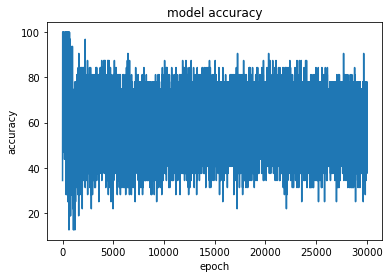

In [5]:
# Added a new layer of size 2048 in Generator
if __name__ == '__main__':
    gan = GAN_1()
    gan.train(epochs=30000, batch_size=32, save_interval=200)

In [3]:
class GAN_2():
    def __init__(self):
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)
        
        epoch_list = []
        acc_list = []
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            #d_loss_list.append(d_loss[0])
            acc_list.append(100*d_loss[1])
            
            # summarize history for loss
            

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
            # summarize history for accuracy
        plt.plot(acc_list,label="Accuracy")
       # plt.plot(display,epoch_list,label="")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        #plt.legend(['train', 'test'], loc='upper left')
        plt.show()
                
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("C:\\Stuff\\NEU\\Big-Data Systems and Intelligent Analytics\\Project Data\\mnist_%d.png" % epoch)
        plt.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

C:\Users\Amogh\Anaconda3\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.672994, acc.: 43.75%] [G loss: 0.444506]
1 [D loss: 0.591658, acc.: 54.69%] [G loss: 0.543214]
2 [D loss: 0.442407, acc.: 65.62%] [G loss: 0.675988]
3 [D loss: 0.369569, acc.: 81.25%] [G loss: 0.801643]
4 [D loss: 0.325296, acc.: 84.38%] [G loss: 0.905638]
5 [D loss: 0.293533, acc.: 92.19%] [G loss: 1.111198]
6 [D loss: 0.244625, acc.: 95.31%] [G loss: 1.190591]
7 [D loss: 0.202796, acc.: 96.88%] [G loss: 1.295473]
8 [D loss: 0.201467, acc.: 98.44%] [G loss: 1.413417]
9 [D loss: 0.179884, acc.: 100.00%] [G loss: 1.531398]
10 [D loss: 0.161909, acc.: 100.00%] [G loss: 1.640025]
11 [D loss: 0.132172, acc.: 100.00%] [G loss: 1.718796]
12 [D loss: 0.120861, acc.: 100.00%] [G loss: 1.761612]
13 [D loss: 0.110948, acc.: 100.00%] [G loss: 1.870276]
14 [D loss: 0.111526, acc.: 100.00%] [G loss: 1.919995]
15 [D loss: 0.093132, acc.: 100.00%] [G loss: 2.038043]
16 [D loss: 0.093887, acc.: 100.00%] [G loss: 2.070991]
17 [D loss: 0.083332, acc.: 100.00%] [G loss: 2.108219]
18 [D loss:

148 [D loss: 0.595189, acc.: 71.88%] [G loss: 1.456669]
149 [D loss: 0.182492, acc.: 85.94%] [G loss: 2.275421]
150 [D loss: 0.122760, acc.: 98.44%] [G loss: 3.053941]
151 [D loss: 0.283941, acc.: 89.06%] [G loss: 1.897406]
152 [D loss: 0.191956, acc.: 92.19%] [G loss: 2.510611]
153 [D loss: 0.143967, acc.: 95.31%] [G loss: 2.305699]
154 [D loss: 0.321461, acc.: 87.50%] [G loss: 2.007285]
155 [D loss: 0.306291, acc.: 85.94%] [G loss: 2.828162]
156 [D loss: 0.324671, acc.: 84.38%] [G loss: 2.942689]
157 [D loss: 0.829809, acc.: 56.25%] [G loss: 1.583852]
158 [D loss: 0.237564, acc.: 90.62%] [G loss: 2.973918]
159 [D loss: 0.621786, acc.: 60.94%] [G loss: 1.154932]
160 [D loss: 0.436057, acc.: 76.56%] [G loss: 2.122828]
161 [D loss: 0.137443, acc.: 98.44%] [G loss: 3.271222]
162 [D loss: 0.625359, acc.: 67.19%] [G loss: 1.500475]
163 [D loss: 0.285333, acc.: 82.81%] [G loss: 2.256403]
164 [D loss: 0.227002, acc.: 89.06%] [G loss: 3.348888]
165 [D loss: 0.829005, acc.: 57.81%] [G loss: 1.

296 [D loss: 0.664362, acc.: 50.00%] [G loss: 0.650560]
297 [D loss: 0.678951, acc.: 45.31%] [G loss: 0.618353]
298 [D loss: 0.682561, acc.: 48.44%] [G loss: 0.594738]
299 [D loss: 0.669365, acc.: 50.00%] [G loss: 0.582740]
300 [D loss: 0.680021, acc.: 46.88%] [G loss: 0.581952]
301 [D loss: 0.670633, acc.: 46.88%] [G loss: 0.582466]
302 [D loss: 0.667430, acc.: 48.44%] [G loss: 0.598372]
303 [D loss: 0.677952, acc.: 50.00%] [G loss: 0.626473]
304 [D loss: 0.692688, acc.: 46.88%] [G loss: 0.641782]
305 [D loss: 0.682807, acc.: 42.19%] [G loss: 0.651771]
306 [D loss: 0.694920, acc.: 45.31%] [G loss: 0.638379]
307 [D loss: 0.679180, acc.: 46.88%] [G loss: 0.618758]
308 [D loss: 0.672233, acc.: 48.44%] [G loss: 0.623488]
309 [D loss: 0.651096, acc.: 50.00%] [G loss: 0.623757]
310 [D loss: 0.662970, acc.: 50.00%] [G loss: 0.625946]
311 [D loss: 0.674846, acc.: 48.44%] [G loss: 0.636395]
312 [D loss: 0.660512, acc.: 48.44%] [G loss: 0.636851]
313 [D loss: 0.690451, acc.: 43.75%] [G loss: 0.

443 [D loss: 0.648657, acc.: 50.00%] [G loss: 0.691577]
444 [D loss: 0.626568, acc.: 50.00%] [G loss: 0.687376]
445 [D loss: 0.662011, acc.: 51.56%] [G loss: 0.699972]
446 [D loss: 0.645956, acc.: 50.00%] [G loss: 0.708659]
447 [D loss: 0.656808, acc.: 51.56%] [G loss: 0.705736]
448 [D loss: 0.634778, acc.: 56.25%] [G loss: 0.707394]
449 [D loss: 0.630284, acc.: 51.56%] [G loss: 0.721186]
450 [D loss: 0.633220, acc.: 53.12%] [G loss: 0.710870]
451 [D loss: 0.635886, acc.: 54.69%] [G loss: 0.706205]
452 [D loss: 0.667329, acc.: 46.88%] [G loss: 0.677820]
453 [D loss: 0.656610, acc.: 48.44%] [G loss: 0.688225]
454 [D loss: 0.614059, acc.: 50.00%] [G loss: 0.703749]
455 [D loss: 0.637857, acc.: 50.00%] [G loss: 0.717468]
456 [D loss: 0.625101, acc.: 56.25%] [G loss: 0.723755]
457 [D loss: 0.646864, acc.: 56.25%] [G loss: 0.720747]
458 [D loss: 0.621830, acc.: 51.56%] [G loss: 0.737901]
459 [D loss: 0.633048, acc.: 59.38%] [G loss: 0.739573]
460 [D loss: 0.644643, acc.: 56.25%] [G loss: 0.

591 [D loss: 0.655691, acc.: 60.94%] [G loss: 0.723697]
592 [D loss: 0.676909, acc.: 51.56%] [G loss: 0.733716]
593 [D loss: 0.646840, acc.: 59.38%] [G loss: 0.764301]
594 [D loss: 0.659250, acc.: 56.25%] [G loss: 0.777621]
595 [D loss: 0.640769, acc.: 59.38%] [G loss: 0.793856]
596 [D loss: 0.663675, acc.: 50.00%] [G loss: 0.776155]
597 [D loss: 0.624628, acc.: 62.50%] [G loss: 0.793925]
598 [D loss: 0.654302, acc.: 62.50%] [G loss: 0.806471]
599 [D loss: 0.632109, acc.: 57.81%] [G loss: 0.774930]
600 [D loss: 0.625753, acc.: 67.19%] [G loss: 0.762872]
601 [D loss: 0.660701, acc.: 67.19%] [G loss: 0.757724]
602 [D loss: 0.627001, acc.: 70.31%] [G loss: 0.742084]
603 [D loss: 0.640028, acc.: 57.81%] [G loss: 0.754317]
604 [D loss: 0.645716, acc.: 59.38%] [G loss: 0.732245]
605 [D loss: 0.643131, acc.: 56.25%] [G loss: 0.725250]
606 [D loss: 0.647997, acc.: 54.69%] [G loss: 0.731598]
607 [D loss: 0.651364, acc.: 62.50%] [G loss: 0.726688]
608 [D loss: 0.637154, acc.: 57.81%] [G loss: 0.

740 [D loss: 0.610508, acc.: 65.62%] [G loss: 0.806752]
741 [D loss: 0.600631, acc.: 71.88%] [G loss: 0.795049]
742 [D loss: 0.644344, acc.: 53.12%] [G loss: 0.770903]
743 [D loss: 0.636677, acc.: 60.94%] [G loss: 0.815358]
744 [D loss: 0.624932, acc.: 64.06%] [G loss: 0.849831]
745 [D loss: 0.665262, acc.: 53.12%] [G loss: 0.846173]
746 [D loss: 0.676561, acc.: 60.94%] [G loss: 0.813975]
747 [D loss: 0.649667, acc.: 57.81%] [G loss: 0.835482]
748 [D loss: 0.680622, acc.: 56.25%] [G loss: 0.820368]
749 [D loss: 0.628203, acc.: 67.19%] [G loss: 0.818416]
750 [D loss: 0.642828, acc.: 56.25%] [G loss: 0.840662]
751 [D loss: 0.616711, acc.: 65.62%] [G loss: 0.934228]
752 [D loss: 0.650338, acc.: 56.25%] [G loss: 0.895468]
753 [D loss: 0.648208, acc.: 57.81%] [G loss: 0.865633]
754 [D loss: 0.641771, acc.: 54.69%] [G loss: 0.838657]
755 [D loss: 0.602472, acc.: 73.44%] [G loss: 0.901808]
756 [D loss: 0.628904, acc.: 68.75%] [G loss: 0.861642]
757 [D loss: 0.690099, acc.: 60.94%] [G loss: 0.

887 [D loss: 0.593662, acc.: 75.00%] [G loss: 0.827551]
888 [D loss: 0.650009, acc.: 60.94%] [G loss: 0.827677]
889 [D loss: 0.602463, acc.: 76.56%] [G loss: 0.851610]
890 [D loss: 0.641064, acc.: 65.62%] [G loss: 0.848612]
891 [D loss: 0.631759, acc.: 71.88%] [G loss: 0.823973]
892 [D loss: 0.628517, acc.: 64.06%] [G loss: 0.846256]
893 [D loss: 0.631933, acc.: 65.62%] [G loss: 0.842063]
894 [D loss: 0.594231, acc.: 67.19%] [G loss: 0.832788]
895 [D loss: 0.591647, acc.: 79.69%] [G loss: 0.858713]
896 [D loss: 0.634448, acc.: 59.38%] [G loss: 0.881342]
897 [D loss: 0.621274, acc.: 71.88%] [G loss: 0.845425]
898 [D loss: 0.602693, acc.: 70.31%] [G loss: 0.837327]
899 [D loss: 0.658041, acc.: 54.69%] [G loss: 0.822168]
900 [D loss: 0.612050, acc.: 71.88%] [G loss: 0.846457]
901 [D loss: 0.575053, acc.: 71.88%] [G loss: 0.861819]
902 [D loss: 0.615942, acc.: 68.75%] [G loss: 0.853847]
903 [D loss: 0.633124, acc.: 62.50%] [G loss: 0.819844]
904 [D loss: 0.599605, acc.: 82.81%] [G loss: 0.

1033 [D loss: 0.612578, acc.: 67.19%] [G loss: 0.869232]
1034 [D loss: 0.612916, acc.: 67.19%] [G loss: 0.872324]
1035 [D loss: 0.612979, acc.: 73.44%] [G loss: 0.939561]
1036 [D loss: 0.640083, acc.: 67.19%] [G loss: 0.956612]
1037 [D loss: 0.620952, acc.: 70.31%] [G loss: 0.895986]
1038 [D loss: 0.593610, acc.: 76.56%] [G loss: 0.895884]
1039 [D loss: 0.614256, acc.: 71.88%] [G loss: 0.855316]
1040 [D loss: 0.564032, acc.: 79.69%] [G loss: 0.874268]
1041 [D loss: 0.621475, acc.: 68.75%] [G loss: 0.892417]
1042 [D loss: 0.578676, acc.: 78.12%] [G loss: 0.865773]
1043 [D loss: 0.607536, acc.: 73.44%] [G loss: 0.897417]
1044 [D loss: 0.608954, acc.: 65.62%] [G loss: 0.928518]
1045 [D loss: 0.592619, acc.: 75.00%] [G loss: 0.878145]
1046 [D loss: 0.588168, acc.: 71.88%] [G loss: 0.896010]
1047 [D loss: 0.613306, acc.: 68.75%] [G loss: 0.924068]
1048 [D loss: 0.589420, acc.: 84.38%] [G loss: 0.911895]
1049 [D loss: 0.549838, acc.: 82.81%] [G loss: 0.930581]
1050 [D loss: 0.573967, acc.: 7

1179 [D loss: 0.637914, acc.: 64.06%] [G loss: 0.929513]
1180 [D loss: 0.570507, acc.: 71.88%] [G loss: 0.987140]
1181 [D loss: 0.578898, acc.: 73.44%] [G loss: 0.915125]
1182 [D loss: 0.578539, acc.: 68.75%] [G loss: 0.984479]
1183 [D loss: 0.574830, acc.: 68.75%] [G loss: 1.003218]
1184 [D loss: 0.576902, acc.: 78.12%] [G loss: 1.000703]
1185 [D loss: 0.618886, acc.: 67.19%] [G loss: 0.932081]
1186 [D loss: 0.561621, acc.: 78.12%] [G loss: 0.959082]
1187 [D loss: 0.548803, acc.: 84.38%] [G loss: 0.951143]
1188 [D loss: 0.602753, acc.: 68.75%] [G loss: 0.908294]
1189 [D loss: 0.583284, acc.: 73.44%] [G loss: 0.887933]
1190 [D loss: 0.555538, acc.: 79.69%] [G loss: 0.923959]
1191 [D loss: 0.525321, acc.: 79.69%] [G loss: 0.931547]
1192 [D loss: 0.618166, acc.: 65.62%] [G loss: 0.929656]
1193 [D loss: 0.591402, acc.: 68.75%] [G loss: 1.008750]
1194 [D loss: 0.602425, acc.: 71.88%] [G loss: 0.982354]
1195 [D loss: 0.560762, acc.: 73.44%] [G loss: 1.026618]
1196 [D loss: 0.562507, acc.: 8

1324 [D loss: 0.635966, acc.: 60.94%] [G loss: 0.964715]
1325 [D loss: 0.561827, acc.: 82.81%] [G loss: 0.967427]
1326 [D loss: 0.509598, acc.: 84.38%] [G loss: 0.996823]
1327 [D loss: 0.614991, acc.: 67.19%] [G loss: 0.961697]
1328 [D loss: 0.551714, acc.: 84.38%] [G loss: 0.939419]
1329 [D loss: 0.571780, acc.: 76.56%] [G loss: 0.948371]
1330 [D loss: 0.585941, acc.: 76.56%] [G loss: 1.016496]
1331 [D loss: 0.577290, acc.: 67.19%] [G loss: 1.037951]
1332 [D loss: 0.559666, acc.: 78.12%] [G loss: 1.077747]
1333 [D loss: 0.592700, acc.: 71.88%] [G loss: 1.043660]
1334 [D loss: 0.637474, acc.: 62.50%] [G loss: 1.054328]
1335 [D loss: 0.611464, acc.: 67.19%] [G loss: 0.994955]
1336 [D loss: 0.569568, acc.: 75.00%] [G loss: 0.989653]
1337 [D loss: 0.629006, acc.: 67.19%] [G loss: 0.929922]
1338 [D loss: 0.573041, acc.: 75.00%] [G loss: 0.923424]
1339 [D loss: 0.590864, acc.: 65.62%] [G loss: 0.904102]
1340 [D loss: 0.628770, acc.: 67.19%] [G loss: 0.969030]
1341 [D loss: 0.532795, acc.: 7

1468 [D loss: 0.565148, acc.: 78.12%] [G loss: 1.010511]
1469 [D loss: 0.550300, acc.: 78.12%] [G loss: 0.966442]
1470 [D loss: 0.577301, acc.: 70.31%] [G loss: 0.977175]
1471 [D loss: 0.578128, acc.: 75.00%] [G loss: 0.957179]
1472 [D loss: 0.604970, acc.: 65.62%] [G loss: 0.924292]
1473 [D loss: 0.563126, acc.: 70.31%] [G loss: 1.005365]
1474 [D loss: 0.542020, acc.: 71.88%] [G loss: 0.980431]
1475 [D loss: 0.604729, acc.: 70.31%] [G loss: 0.984745]
1476 [D loss: 0.494019, acc.: 78.12%] [G loss: 0.971730]
1477 [D loss: 0.590752, acc.: 62.50%] [G loss: 1.016220]
1478 [D loss: 0.597460, acc.: 65.62%] [G loss: 0.980677]
1479 [D loss: 0.645981, acc.: 56.25%] [G loss: 0.973005]
1480 [D loss: 0.588164, acc.: 68.75%] [G loss: 0.964620]
1481 [D loss: 0.656734, acc.: 56.25%] [G loss: 1.035110]
1482 [D loss: 0.579426, acc.: 70.31%] [G loss: 1.031914]
1483 [D loss: 0.674086, acc.: 56.25%] [G loss: 0.992420]
1484 [D loss: 0.555879, acc.: 78.12%] [G loss: 0.973949]
1485 [D loss: 0.636360, acc.: 6

1755 [D loss: 0.578026, acc.: 65.62%] [G loss: 0.975060]
1756 [D loss: 0.606662, acc.: 65.62%] [G loss: 0.958480]
1757 [D loss: 0.642474, acc.: 50.00%] [G loss: 0.934189]
1758 [D loss: 0.589483, acc.: 73.44%] [G loss: 0.924675]
1759 [D loss: 0.604010, acc.: 62.50%] [G loss: 0.923918]
1760 [D loss: 0.571437, acc.: 73.44%] [G loss: 0.958187]
1761 [D loss: 0.604514, acc.: 67.19%] [G loss: 0.915902]
1762 [D loss: 0.566966, acc.: 73.44%] [G loss: 0.935229]
1763 [D loss: 0.610880, acc.: 67.19%] [G loss: 0.950125]
1764 [D loss: 0.629323, acc.: 59.38%] [G loss: 0.930784]
1765 [D loss: 0.559944, acc.: 70.31%] [G loss: 1.021982]
1766 [D loss: 0.626985, acc.: 65.62%] [G loss: 0.936135]
1767 [D loss: 0.664072, acc.: 62.50%] [G loss: 0.896861]
1768 [D loss: 0.553111, acc.: 75.00%] [G loss: 0.963915]
1769 [D loss: 0.569980, acc.: 68.75%] [G loss: 1.001553]
1770 [D loss: 0.661199, acc.: 56.25%] [G loss: 0.945795]
1771 [D loss: 0.634573, acc.: 70.31%] [G loss: 0.982247]
1772 [D loss: 0.645756, acc.: 6

1900 [D loss: 0.567216, acc.: 73.44%] [G loss: 0.915345]
1901 [D loss: 0.626133, acc.: 62.50%] [G loss: 0.888744]
1902 [D loss: 0.506268, acc.: 81.25%] [G loss: 0.954331]
1903 [D loss: 0.656707, acc.: 56.25%] [G loss: 0.900333]
1904 [D loss: 0.632816, acc.: 64.06%] [G loss: 0.922098]
1905 [D loss: 0.593546, acc.: 68.75%] [G loss: 0.948837]
1906 [D loss: 0.589739, acc.: 67.19%] [G loss: 0.948488]
1907 [D loss: 0.622413, acc.: 62.50%] [G loss: 0.936188]
1908 [D loss: 0.581927, acc.: 73.44%] [G loss: 0.980448]
1909 [D loss: 0.607990, acc.: 75.00%] [G loss: 0.896772]
1910 [D loss: 0.616214, acc.: 65.62%] [G loss: 0.909001]
1911 [D loss: 0.624666, acc.: 73.44%] [G loss: 0.912577]
1912 [D loss: 0.594942, acc.: 65.62%] [G loss: 0.926807]
1913 [D loss: 0.636167, acc.: 54.69%] [G loss: 0.898230]
1914 [D loss: 0.621660, acc.: 68.75%] [G loss: 0.942593]
1915 [D loss: 0.567148, acc.: 73.44%] [G loss: 0.915139]
1916 [D loss: 0.575043, acc.: 71.88%] [G loss: 0.903081]
1917 [D loss: 0.615790, acc.: 6

2045 [D loss: 0.630979, acc.: 60.94%] [G loss: 0.931514]
2046 [D loss: 0.591682, acc.: 71.88%] [G loss: 0.953983]
2047 [D loss: 0.557345, acc.: 73.44%] [G loss: 0.936755]
2048 [D loss: 0.618718, acc.: 64.06%] [G loss: 0.942487]
2049 [D loss: 0.615299, acc.: 65.62%] [G loss: 0.917401]
2050 [D loss: 0.591754, acc.: 67.19%] [G loss: 0.917242]
2051 [D loss: 0.587786, acc.: 62.50%] [G loss: 0.950682]
2052 [D loss: 0.590421, acc.: 64.06%] [G loss: 0.996177]
2053 [D loss: 0.564446, acc.: 84.38%] [G loss: 0.982832]
2054 [D loss: 0.594534, acc.: 68.75%] [G loss: 0.893627]
2055 [D loss: 0.574349, acc.: 68.75%] [G loss: 0.966451]
2056 [D loss: 0.520655, acc.: 82.81%] [G loss: 0.963774]
2057 [D loss: 0.656031, acc.: 68.75%] [G loss: 0.921449]
2058 [D loss: 0.599557, acc.: 68.75%] [G loss: 0.911802]
2059 [D loss: 0.599496, acc.: 68.75%] [G loss: 0.917664]
2060 [D loss: 0.704247, acc.: 51.56%] [G loss: 0.874924]
2061 [D loss: 0.623931, acc.: 64.06%] [G loss: 0.896932]
2062 [D loss: 0.569243, acc.: 7

2191 [D loss: 0.607073, acc.: 65.62%] [G loss: 0.999340]
2192 [D loss: 0.626884, acc.: 64.06%] [G loss: 0.942984]
2193 [D loss: 0.580009, acc.: 71.88%] [G loss: 0.934159]
2194 [D loss: 0.600915, acc.: 64.06%] [G loss: 0.982132]
2195 [D loss: 0.663746, acc.: 57.81%] [G loss: 0.942783]
2196 [D loss: 0.573907, acc.: 68.75%] [G loss: 0.930545]
2197 [D loss: 0.660931, acc.: 60.94%] [G loss: 0.954637]
2198 [D loss: 0.611996, acc.: 59.38%] [G loss: 1.034018]
2199 [D loss: 0.637762, acc.: 59.38%] [G loss: 1.014959]
2200 [D loss: 0.630428, acc.: 64.06%] [G loss: 1.031775]
2201 [D loss: 0.566323, acc.: 71.88%] [G loss: 1.013572]
2202 [D loss: 0.686660, acc.: 59.38%] [G loss: 0.942991]
2203 [D loss: 0.628409, acc.: 62.50%] [G loss: 0.972143]
2204 [D loss: 0.581833, acc.: 76.56%] [G loss: 0.983292]
2205 [D loss: 0.604648, acc.: 67.19%] [G loss: 0.946391]
2206 [D loss: 0.645370, acc.: 67.19%] [G loss: 0.944408]
2207 [D loss: 0.616472, acc.: 71.88%] [G loss: 0.922542]
2208 [D loss: 0.541748, acc.: 7

2336 [D loss: 0.624850, acc.: 68.75%] [G loss: 0.933995]
2337 [D loss: 0.654982, acc.: 62.50%] [G loss: 0.831478]
2338 [D loss: 0.548706, acc.: 75.00%] [G loss: 0.895204]
2339 [D loss: 0.640783, acc.: 65.62%] [G loss: 0.905920]
2340 [D loss: 0.576021, acc.: 76.56%] [G loss: 0.920187]
2341 [D loss: 0.626556, acc.: 71.88%] [G loss: 0.910474]
2342 [D loss: 0.678266, acc.: 59.38%] [G loss: 0.878636]
2343 [D loss: 0.661425, acc.: 56.25%] [G loss: 0.866891]
2344 [D loss: 0.619369, acc.: 62.50%] [G loss: 0.876774]
2345 [D loss: 0.549667, acc.: 76.56%] [G loss: 0.912999]
2346 [D loss: 0.639974, acc.: 62.50%] [G loss: 0.863757]
2347 [D loss: 0.612705, acc.: 70.31%] [G loss: 0.863493]
2348 [D loss: 0.650192, acc.: 59.38%] [G loss: 0.942682]
2349 [D loss: 0.618378, acc.: 67.19%] [G loss: 0.895856]
2350 [D loss: 0.622233, acc.: 65.62%] [G loss: 0.882834]
2351 [D loss: 0.607305, acc.: 65.62%] [G loss: 0.894464]
2352 [D loss: 0.704831, acc.: 46.88%] [G loss: 0.850092]
2353 [D loss: 0.606272, acc.: 7

2482 [D loss: 0.647364, acc.: 65.62%] [G loss: 0.898291]
2483 [D loss: 0.615499, acc.: 64.06%] [G loss: 0.949021]
2484 [D loss: 0.621429, acc.: 70.31%] [G loss: 0.939942]
2485 [D loss: 0.650301, acc.: 62.50%] [G loss: 0.907172]
2486 [D loss: 0.693200, acc.: 54.69%] [G loss: 0.900943]
2487 [D loss: 0.619045, acc.: 64.06%] [G loss: 0.902479]
2488 [D loss: 0.596826, acc.: 71.88%] [G loss: 0.896469]
2489 [D loss: 0.629965, acc.: 57.81%] [G loss: 0.950858]
2490 [D loss: 0.592829, acc.: 70.31%] [G loss: 0.962448]
2491 [D loss: 0.633633, acc.: 64.06%] [G loss: 0.923738]
2492 [D loss: 0.668367, acc.: 64.06%] [G loss: 0.888249]
2493 [D loss: 0.615854, acc.: 67.19%] [G loss: 0.838938]
2494 [D loss: 0.589698, acc.: 71.88%] [G loss: 0.889516]
2495 [D loss: 0.606182, acc.: 71.88%] [G loss: 0.940365]
2496 [D loss: 0.633849, acc.: 62.50%] [G loss: 0.885837]
2497 [D loss: 0.659987, acc.: 57.81%] [G loss: 0.907436]
2498 [D loss: 0.599704, acc.: 67.19%] [G loss: 0.923595]
2499 [D loss: 0.574452, acc.: 7

2628 [D loss: 0.650289, acc.: 62.50%] [G loss: 0.936654]
2629 [D loss: 0.627168, acc.: 56.25%] [G loss: 0.999284]
2630 [D loss: 0.608556, acc.: 71.88%] [G loss: 0.916202]
2631 [D loss: 0.648413, acc.: 54.69%] [G loss: 0.892365]
2632 [D loss: 0.664819, acc.: 59.38%] [G loss: 0.839124]
2633 [D loss: 0.615987, acc.: 62.50%] [G loss: 0.849194]
2634 [D loss: 0.591755, acc.: 73.44%] [G loss: 0.869931]
2635 [D loss: 0.594900, acc.: 67.19%] [G loss: 0.938534]
2636 [D loss: 0.623461, acc.: 68.75%] [G loss: 0.927330]
2637 [D loss: 0.680430, acc.: 56.25%] [G loss: 0.884982]
2638 [D loss: 0.633929, acc.: 68.75%] [G loss: 0.938734]
2639 [D loss: 0.590778, acc.: 73.44%] [G loss: 0.965890]
2640 [D loss: 0.636414, acc.: 65.62%] [G loss: 0.940741]
2641 [D loss: 0.650200, acc.: 64.06%] [G loss: 0.879482]
2642 [D loss: 0.589985, acc.: 68.75%] [G loss: 0.930217]
2643 [D loss: 0.657143, acc.: 68.75%] [G loss: 0.888235]
2644 [D loss: 0.640939, acc.: 65.62%] [G loss: 0.890700]
2645 [D loss: 0.639573, acc.: 6

2772 [D loss: 0.594721, acc.: 65.62%] [G loss: 0.979401]
2773 [D loss: 0.626595, acc.: 65.62%] [G loss: 0.908458]
2774 [D loss: 0.560979, acc.: 71.88%] [G loss: 0.950965]
2775 [D loss: 0.585599, acc.: 73.44%] [G loss: 0.863576]
2776 [D loss: 0.646411, acc.: 70.31%] [G loss: 0.902854]
2777 [D loss: 0.643469, acc.: 67.19%] [G loss: 0.908045]
2778 [D loss: 0.563639, acc.: 75.00%] [G loss: 0.957174]
2779 [D loss: 0.630249, acc.: 60.94%] [G loss: 0.949109]
2780 [D loss: 0.674268, acc.: 64.06%] [G loss: 0.983841]
2781 [D loss: 0.622081, acc.: 64.06%] [G loss: 0.951590]
2782 [D loss: 0.676875, acc.: 64.06%] [G loss: 0.905730]
2783 [D loss: 0.623477, acc.: 67.19%] [G loss: 0.916560]
2784 [D loss: 0.582589, acc.: 73.44%] [G loss: 0.902488]
2785 [D loss: 0.650771, acc.: 62.50%] [G loss: 0.891107]
2786 [D loss: 0.587236, acc.: 70.31%] [G loss: 0.913138]
2787 [D loss: 0.621356, acc.: 65.62%] [G loss: 0.954577]
2788 [D loss: 0.604571, acc.: 78.12%] [G loss: 0.924910]
2789 [D loss: 0.705594, acc.: 5

2918 [D loss: 0.566498, acc.: 79.69%] [G loss: 0.942378]
2919 [D loss: 0.622894, acc.: 65.62%] [G loss: 0.889064]
2920 [D loss: 0.593457, acc.: 70.31%] [G loss: 0.917347]
2921 [D loss: 0.595256, acc.: 70.31%] [G loss: 0.895792]
2922 [D loss: 0.661678, acc.: 54.69%] [G loss: 0.817511]
2923 [D loss: 0.628726, acc.: 60.94%] [G loss: 0.889065]
2924 [D loss: 0.613434, acc.: 76.56%] [G loss: 0.860449]
2925 [D loss: 0.596348, acc.: 68.75%] [G loss: 0.894495]
2926 [D loss: 0.613645, acc.: 65.62%] [G loss: 0.913861]
2927 [D loss: 0.632151, acc.: 62.50%] [G loss: 0.882829]
2928 [D loss: 0.593626, acc.: 71.88%] [G loss: 0.908573]
2929 [D loss: 0.701276, acc.: 53.12%] [G loss: 0.869162]
2930 [D loss: 0.701708, acc.: 53.12%] [G loss: 0.933194]
2931 [D loss: 0.614200, acc.: 73.44%] [G loss: 0.912877]
2932 [D loss: 0.725907, acc.: 46.88%] [G loss: 0.894508]
2933 [D loss: 0.613706, acc.: 62.50%] [G loss: 0.903211]
2934 [D loss: 0.612572, acc.: 64.06%] [G loss: 0.885792]
2935 [D loss: 0.638883, acc.: 7

3064 [D loss: 0.640345, acc.: 65.62%] [G loss: 0.886098]
3065 [D loss: 0.637615, acc.: 62.50%] [G loss: 0.896426]
3066 [D loss: 0.644404, acc.: 64.06%] [G loss: 0.872463]
3067 [D loss: 0.633739, acc.: 64.06%] [G loss: 0.855769]
3068 [D loss: 0.661707, acc.: 57.81%] [G loss: 0.880480]
3069 [D loss: 0.597616, acc.: 75.00%] [G loss: 0.918741]
3070 [D loss: 0.684289, acc.: 51.56%] [G loss: 0.893744]
3071 [D loss: 0.580398, acc.: 67.19%] [G loss: 0.900030]
3072 [D loss: 0.707165, acc.: 56.25%] [G loss: 0.890151]
3073 [D loss: 0.646993, acc.: 67.19%] [G loss: 0.836186]
3074 [D loss: 0.654882, acc.: 62.50%] [G loss: 0.896256]
3075 [D loss: 0.687958, acc.: 62.50%] [G loss: 0.897224]
3076 [D loss: 0.591823, acc.: 67.19%] [G loss: 0.966035]
3077 [D loss: 0.566446, acc.: 73.44%] [G loss: 0.950438]
3078 [D loss: 0.713455, acc.: 53.12%] [G loss: 0.942116]
3079 [D loss: 0.580021, acc.: 75.00%] [G loss: 0.874160]
3080 [D loss: 0.683527, acc.: 62.50%] [G loss: 0.881387]
3081 [D loss: 0.623864, acc.: 6

3210 [D loss: 0.705888, acc.: 59.38%] [G loss: 0.901138]
3211 [D loss: 0.621760, acc.: 65.62%] [G loss: 0.892981]
3212 [D loss: 0.659466, acc.: 65.62%] [G loss: 0.924095]
3213 [D loss: 0.611885, acc.: 70.31%] [G loss: 0.897107]
3214 [D loss: 0.652042, acc.: 59.38%] [G loss: 0.893836]
3215 [D loss: 0.652896, acc.: 62.50%] [G loss: 0.922105]
3216 [D loss: 0.601028, acc.: 67.19%] [G loss: 0.912465]
3217 [D loss: 0.644930, acc.: 68.75%] [G loss: 0.902867]
3218 [D loss: 0.631414, acc.: 64.06%] [G loss: 0.888353]
3219 [D loss: 0.687503, acc.: 54.69%] [G loss: 0.872199]
3220 [D loss: 0.625671, acc.: 65.62%] [G loss: 0.882958]
3221 [D loss: 0.683881, acc.: 57.81%] [G loss: 0.843313]
3222 [D loss: 0.620032, acc.: 65.62%] [G loss: 0.871837]
3223 [D loss: 0.674536, acc.: 57.81%] [G loss: 0.882195]
3224 [D loss: 0.639200, acc.: 65.62%] [G loss: 0.882497]
3225 [D loss: 0.618979, acc.: 73.44%] [G loss: 0.878259]
3226 [D loss: 0.630564, acc.: 70.31%] [G loss: 0.846071]
3227 [D loss: 0.578925, acc.: 7

3354 [D loss: 0.620377, acc.: 65.62%] [G loss: 0.909142]
3355 [D loss: 0.625149, acc.: 62.50%] [G loss: 0.933926]
3356 [D loss: 0.627941, acc.: 65.62%] [G loss: 0.906076]
3357 [D loss: 0.693444, acc.: 53.12%] [G loss: 0.946565]
3358 [D loss: 0.617679, acc.: 62.50%] [G loss: 0.935404]
3359 [D loss: 0.667192, acc.: 60.94%] [G loss: 0.878788]
3360 [D loss: 0.768567, acc.: 42.19%] [G loss: 0.820494]
3361 [D loss: 0.666731, acc.: 59.38%] [G loss: 0.876949]
3362 [D loss: 0.639548, acc.: 62.50%] [G loss: 0.864330]
3363 [D loss: 0.653342, acc.: 62.50%] [G loss: 0.874624]
3364 [D loss: 0.693410, acc.: 54.69%] [G loss: 0.859357]
3365 [D loss: 0.636286, acc.: 60.94%] [G loss: 0.848925]
3366 [D loss: 0.696058, acc.: 53.12%] [G loss: 0.861182]
3367 [D loss: 0.681846, acc.: 57.81%] [G loss: 0.870314]
3368 [D loss: 0.576458, acc.: 76.56%] [G loss: 0.838342]
3369 [D loss: 0.620491, acc.: 71.88%] [G loss: 0.935290]
3370 [D loss: 0.642987, acc.: 64.06%] [G loss: 0.840188]
3371 [D loss: 0.664899, acc.: 5

3499 [D loss: 0.658379, acc.: 62.50%] [G loss: 0.808396]
3500 [D loss: 0.675558, acc.: 60.94%] [G loss: 0.870624]
3501 [D loss: 0.656463, acc.: 62.50%] [G loss: 0.906795]
3502 [D loss: 0.625046, acc.: 65.62%] [G loss: 0.899707]
3503 [D loss: 0.634239, acc.: 70.31%] [G loss: 0.878655]
3504 [D loss: 0.739678, acc.: 45.31%] [G loss: 0.908399]
3505 [D loss: 0.635662, acc.: 67.19%] [G loss: 0.911205]
3506 [D loss: 0.640163, acc.: 62.50%] [G loss: 0.892284]
3507 [D loss: 0.610668, acc.: 70.31%] [G loss: 0.910315]
3508 [D loss: 0.674422, acc.: 59.38%] [G loss: 0.886070]
3509 [D loss: 0.650825, acc.: 59.38%] [G loss: 0.878852]
3510 [D loss: 0.664507, acc.: 62.50%] [G loss: 0.823143]
3511 [D loss: 0.607041, acc.: 65.62%] [G loss: 0.881166]
3512 [D loss: 0.666009, acc.: 59.38%] [G loss: 0.822397]
3513 [D loss: 0.693653, acc.: 50.00%] [G loss: 0.802547]
3514 [D loss: 0.667224, acc.: 65.62%] [G loss: 0.814850]
3515 [D loss: 0.619812, acc.: 68.75%] [G loss: 0.891656]
3516 [D loss: 0.622788, acc.: 6

3643 [D loss: 0.631098, acc.: 62.50%] [G loss: 0.849360]
3644 [D loss: 0.668787, acc.: 64.06%] [G loss: 0.906583]
3645 [D loss: 0.678114, acc.: 56.25%] [G loss: 0.849576]
3646 [D loss: 0.653154, acc.: 62.50%] [G loss: 0.875057]
3647 [D loss: 0.693717, acc.: 59.38%] [G loss: 0.886134]
3648 [D loss: 0.693976, acc.: 57.81%] [G loss: 0.869702]
3649 [D loss: 0.614628, acc.: 67.19%] [G loss: 0.887708]
3650 [D loss: 0.707947, acc.: 53.12%] [G loss: 0.883318]
3651 [D loss: 0.568452, acc.: 76.56%] [G loss: 0.872054]
3652 [D loss: 0.640846, acc.: 65.62%] [G loss: 0.875184]
3653 [D loss: 0.623202, acc.: 67.19%] [G loss: 0.898717]
3654 [D loss: 0.671769, acc.: 60.94%] [G loss: 0.882909]
3655 [D loss: 0.630355, acc.: 65.62%] [G loss: 0.896271]
3656 [D loss: 0.657681, acc.: 67.19%] [G loss: 0.840990]
3657 [D loss: 0.726943, acc.: 50.00%] [G loss: 0.887193]
3658 [D loss: 0.635337, acc.: 64.06%] [G loss: 0.874935]
3659 [D loss: 0.627973, acc.: 65.62%] [G loss: 0.957418]
3660 [D loss: 0.646163, acc.: 6

3787 [D loss: 0.694053, acc.: 56.25%] [G loss: 0.874558]
3788 [D loss: 0.657149, acc.: 60.94%] [G loss: 0.876987]
3789 [D loss: 0.699700, acc.: 53.12%] [G loss: 0.881119]
3790 [D loss: 0.688890, acc.: 56.25%] [G loss: 0.878381]
3791 [D loss: 0.660846, acc.: 56.25%] [G loss: 0.861089]
3792 [D loss: 0.637325, acc.: 68.75%] [G loss: 0.768077]
3793 [D loss: 0.671240, acc.: 59.38%] [G loss: 0.834147]
3794 [D loss: 0.672572, acc.: 54.69%] [G loss: 0.796408]
3795 [D loss: 0.645435, acc.: 67.19%] [G loss: 0.824777]
3796 [D loss: 0.643842, acc.: 60.94%] [G loss: 0.848142]
3797 [D loss: 0.653302, acc.: 60.94%] [G loss: 0.869847]
3798 [D loss: 0.676368, acc.: 62.50%] [G loss: 0.839802]
3799 [D loss: 0.706632, acc.: 53.12%] [G loss: 0.883977]
3800 [D loss: 0.603562, acc.: 67.19%] [G loss: 0.844361]
3801 [D loss: 0.671006, acc.: 57.81%] [G loss: 0.858328]
3802 [D loss: 0.677390, acc.: 64.06%] [G loss: 0.827011]
3803 [D loss: 0.634002, acc.: 68.75%] [G loss: 0.874119]
3804 [D loss: 0.663328, acc.: 6

3933 [D loss: 0.669785, acc.: 56.25%] [G loss: 0.863573]
3934 [D loss: 0.643061, acc.: 54.69%] [G loss: 0.884601]
3935 [D loss: 0.641849, acc.: 59.38%] [G loss: 0.915444]
3936 [D loss: 0.661089, acc.: 64.06%] [G loss: 0.907786]
3937 [D loss: 0.676373, acc.: 56.25%] [G loss: 0.909419]
3938 [D loss: 0.650819, acc.: 64.06%] [G loss: 0.894674]
3939 [D loss: 0.694858, acc.: 54.69%] [G loss: 0.816170]
3940 [D loss: 0.677152, acc.: 59.38%] [G loss: 0.861541]
3941 [D loss: 0.712497, acc.: 51.56%] [G loss: 0.894569]
3942 [D loss: 0.637837, acc.: 68.75%] [G loss: 0.852945]
3943 [D loss: 0.670004, acc.: 51.56%] [G loss: 0.876109]
3944 [D loss: 0.642139, acc.: 68.75%] [G loss: 0.846485]
3945 [D loss: 0.655809, acc.: 53.12%] [G loss: 0.880873]
3946 [D loss: 0.656519, acc.: 60.94%] [G loss: 0.916056]
3947 [D loss: 0.665448, acc.: 64.06%] [G loss: 0.877963]
3948 [D loss: 0.607851, acc.: 68.75%] [G loss: 0.885645]
3949 [D loss: 0.645374, acc.: 67.19%] [G loss: 0.914219]
3950 [D loss: 0.655050, acc.: 5

4079 [D loss: 0.699826, acc.: 54.69%] [G loss: 0.928348]
4080 [D loss: 0.629395, acc.: 73.44%] [G loss: 0.885121]
4081 [D loss: 0.702520, acc.: 54.69%] [G loss: 0.873906]
4082 [D loss: 0.615744, acc.: 65.62%] [G loss: 0.869355]
4083 [D loss: 0.620320, acc.: 59.38%] [G loss: 0.892336]
4084 [D loss: 0.694159, acc.: 62.50%] [G loss: 0.881659]
4085 [D loss: 0.630780, acc.: 62.50%] [G loss: 0.869870]
4086 [D loss: 0.733809, acc.: 45.31%] [G loss: 0.863995]
4087 [D loss: 0.608104, acc.: 68.75%] [G loss: 0.879164]
4088 [D loss: 0.642577, acc.: 70.31%] [G loss: 0.826030]
4089 [D loss: 0.686381, acc.: 56.25%] [G loss: 0.880849]
4090 [D loss: 0.701744, acc.: 50.00%] [G loss: 0.839234]
4091 [D loss: 0.661849, acc.: 59.38%] [G loss: 0.874852]
4092 [D loss: 0.655736, acc.: 62.50%] [G loss: 0.864235]
4093 [D loss: 0.646935, acc.: 56.25%] [G loss: 0.850800]
4094 [D loss: 0.633385, acc.: 57.81%] [G loss: 0.831777]
4095 [D loss: 0.662944, acc.: 65.62%] [G loss: 0.829727]
4096 [D loss: 0.634513, acc.: 6

4225 [D loss: 0.584376, acc.: 62.50%] [G loss: 0.850662]
4226 [D loss: 0.682051, acc.: 56.25%] [G loss: 0.846521]
4227 [D loss: 0.715948, acc.: 53.12%] [G loss: 0.854907]
4228 [D loss: 0.640269, acc.: 64.06%] [G loss: 0.865806]
4229 [D loss: 0.699662, acc.: 51.56%] [G loss: 0.806023]
4230 [D loss: 0.687868, acc.: 53.12%] [G loss: 0.814958]
4231 [D loss: 0.659589, acc.: 60.94%] [G loss: 0.857836]
4232 [D loss: 0.672524, acc.: 60.94%] [G loss: 0.888491]
4233 [D loss: 0.674553, acc.: 57.81%] [G loss: 0.851635]
4234 [D loss: 0.691302, acc.: 50.00%] [G loss: 0.785726]
4235 [D loss: 0.639580, acc.: 67.19%] [G loss: 0.856623]
4236 [D loss: 0.613868, acc.: 68.75%] [G loss: 0.866084]
4237 [D loss: 0.687714, acc.: 60.94%] [G loss: 0.852942]
4238 [D loss: 0.651166, acc.: 62.50%] [G loss: 0.796741]
4239 [D loss: 0.640392, acc.: 65.62%] [G loss: 0.850895]
4240 [D loss: 0.727014, acc.: 48.44%] [G loss: 0.934314]
4241 [D loss: 0.709906, acc.: 48.44%] [G loss: 0.926505]
4242 [D loss: 0.666964, acc.: 6

4369 [D loss: 0.641126, acc.: 57.81%] [G loss: 0.857207]
4370 [D loss: 0.724520, acc.: 51.56%] [G loss: 0.883681]
4371 [D loss: 0.678291, acc.: 56.25%] [G loss: 0.861281]
4372 [D loss: 0.697572, acc.: 65.62%] [G loss: 0.849251]
4373 [D loss: 0.690601, acc.: 56.25%] [G loss: 0.831983]
4374 [D loss: 0.682609, acc.: 57.81%] [G loss: 0.841748]
4375 [D loss: 0.679817, acc.: 60.94%] [G loss: 0.812150]
4376 [D loss: 0.622625, acc.: 68.75%] [G loss: 0.803957]
4377 [D loss: 0.686485, acc.: 57.81%] [G loss: 0.830155]
4378 [D loss: 0.714209, acc.: 59.38%] [G loss: 0.873775]
4379 [D loss: 0.600743, acc.: 67.19%] [G loss: 0.926377]
4380 [D loss: 0.709602, acc.: 45.31%] [G loss: 0.915015]
4381 [D loss: 0.634978, acc.: 62.50%] [G loss: 0.825116]
4382 [D loss: 0.626943, acc.: 59.38%] [G loss: 0.857927]
4383 [D loss: 0.660221, acc.: 53.12%] [G loss: 0.878326]
4384 [D loss: 0.674443, acc.: 64.06%] [G loss: 0.843668]
4385 [D loss: 0.691754, acc.: 65.62%] [G loss: 0.780487]
4386 [D loss: 0.676488, acc.: 5

4515 [D loss: 0.686348, acc.: 59.38%] [G loss: 0.833681]
4516 [D loss: 0.662860, acc.: 62.50%] [G loss: 0.855111]
4517 [D loss: 0.681379, acc.: 48.44%] [G loss: 0.897568]
4518 [D loss: 0.663242, acc.: 60.94%] [G loss: 0.885214]
4519 [D loss: 0.677562, acc.: 64.06%] [G loss: 0.888274]
4520 [D loss: 0.693471, acc.: 65.62%] [G loss: 0.838424]
4521 [D loss: 0.647063, acc.: 56.25%] [G loss: 0.812483]
4522 [D loss: 0.687365, acc.: 51.56%] [G loss: 0.848503]
4523 [D loss: 0.679740, acc.: 56.25%] [G loss: 0.832523]
4524 [D loss: 0.637623, acc.: 65.62%] [G loss: 0.846920]
4525 [D loss: 0.667890, acc.: 62.50%] [G loss: 0.840732]
4526 [D loss: 0.752878, acc.: 51.56%] [G loss: 0.870040]
4527 [D loss: 0.715798, acc.: 53.12%] [G loss: 0.819422]
4528 [D loss: 0.701542, acc.: 62.50%] [G loss: 0.877270]
4529 [D loss: 0.680121, acc.: 59.38%] [G loss: 0.878099]
4530 [D loss: 0.654247, acc.: 67.19%] [G loss: 0.828493]
4531 [D loss: 0.671839, acc.: 56.25%] [G loss: 0.809296]
4532 [D loss: 0.715295, acc.: 5

4661 [D loss: 0.641444, acc.: 62.50%] [G loss: 0.839645]
4662 [D loss: 0.644819, acc.: 60.94%] [G loss: 0.838089]
4663 [D loss: 0.681208, acc.: 57.81%] [G loss: 0.875700]
4664 [D loss: 0.662091, acc.: 68.75%] [G loss: 0.827331]
4665 [D loss: 0.641741, acc.: 68.75%] [G loss: 0.799344]
4666 [D loss: 0.651449, acc.: 60.94%] [G loss: 0.795056]
4667 [D loss: 0.697028, acc.: 56.25%] [G loss: 0.837258]
4668 [D loss: 0.740321, acc.: 42.19%] [G loss: 0.882159]
4669 [D loss: 0.649191, acc.: 59.38%] [G loss: 0.859759]
4670 [D loss: 0.721556, acc.: 50.00%] [G loss: 0.842530]
4671 [D loss: 0.678543, acc.: 59.38%] [G loss: 0.850063]
4672 [D loss: 0.758289, acc.: 45.31%] [G loss: 0.883841]
4673 [D loss: 0.650305, acc.: 57.81%] [G loss: 0.868485]
4674 [D loss: 0.704379, acc.: 51.56%] [G loss: 0.826513]
4675 [D loss: 0.634380, acc.: 62.50%] [G loss: 0.892946]
4676 [D loss: 0.681624, acc.: 53.12%] [G loss: 0.836707]
4677 [D loss: 0.708744, acc.: 51.56%] [G loss: 0.841559]
4678 [D loss: 0.616984, acc.: 6

4807 [D loss: 0.648769, acc.: 59.38%] [G loss: 0.850446]
4808 [D loss: 0.672736, acc.: 54.69%] [G loss: 0.876272]
4809 [D loss: 0.744657, acc.: 42.19%] [G loss: 0.872064]
4810 [D loss: 0.681717, acc.: 60.94%] [G loss: 0.833715]
4811 [D loss: 0.660657, acc.: 64.06%] [G loss: 0.875264]
4812 [D loss: 0.674091, acc.: 62.50%] [G loss: 0.822626]
4813 [D loss: 0.685668, acc.: 60.94%] [G loss: 0.800166]
4814 [D loss: 0.678057, acc.: 65.62%] [G loss: 0.831498]
4815 [D loss: 0.621838, acc.: 71.88%] [G loss: 0.791653]
4816 [D loss: 0.685347, acc.: 50.00%] [G loss: 0.849968]
4817 [D loss: 0.603484, acc.: 70.31%] [G loss: 0.815730]
4818 [D loss: 0.718170, acc.: 50.00%] [G loss: 0.832286]
4819 [D loss: 0.651045, acc.: 64.06%] [G loss: 0.801417]
4820 [D loss: 0.689159, acc.: 54.69%] [G loss: 0.809895]
4821 [D loss: 0.652577, acc.: 60.94%] [G loss: 0.853729]
4822 [D loss: 0.685184, acc.: 57.81%] [G loss: 0.903163]
4823 [D loss: 0.707488, acc.: 46.88%] [G loss: 0.853584]
4824 [D loss: 0.693111, acc.: 4

4951 [D loss: 0.751993, acc.: 50.00%] [G loss: 0.833050]
4952 [D loss: 0.631359, acc.: 62.50%] [G loss: 0.896584]
4953 [D loss: 0.680726, acc.: 60.94%] [G loss: 0.843735]
4954 [D loss: 0.637153, acc.: 62.50%] [G loss: 0.879109]
4955 [D loss: 0.660667, acc.: 60.94%] [G loss: 0.901525]
4956 [D loss: 0.641209, acc.: 57.81%] [G loss: 0.877563]
4957 [D loss: 0.640725, acc.: 64.06%] [G loss: 0.878995]
4958 [D loss: 0.669411, acc.: 60.94%] [G loss: 0.922357]
4959 [D loss: 0.682876, acc.: 51.56%] [G loss: 0.846704]
4960 [D loss: 0.705353, acc.: 54.69%] [G loss: 0.852232]
4961 [D loss: 0.677857, acc.: 60.94%] [G loss: 0.852272]
4962 [D loss: 0.666902, acc.: 56.25%] [G loss: 0.823610]
4963 [D loss: 0.679516, acc.: 54.69%] [G loss: 0.850084]
4964 [D loss: 0.707123, acc.: 51.56%] [G loss: 0.801453]
4965 [D loss: 0.663943, acc.: 64.06%] [G loss: 0.845004]
4966 [D loss: 0.700392, acc.: 53.12%] [G loss: 0.865889]
4967 [D loss: 0.641608, acc.: 64.06%] [G loss: 0.859119]
4968 [D loss: 0.647125, acc.: 5

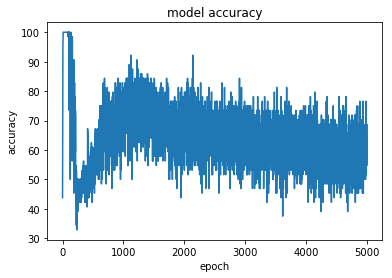

In [4]:
# 5000 Epochs, 64 Batch size
if __name__ == '__main__':
    gan = GAN_2()
    gan.train(epochs=5000, batch_size=64, save_interval=200)

In [5]:
class GAN_3():
    def __init__(self):
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)
        
        epoch_list = []
        acc_list = []
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            #d_loss_list.append(d_loss[0])
            acc_list.append(100*d_loss[1])
            
            # summarize history for loss
            

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
            # summarize history for accuracy
        plt.plot(acc_list,label="Accuracy")
       # plt.plot(display,epoch_list,label="")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        #plt.legend(['train', 'test'], loc='upper left')
        plt.show()
                
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("C:\\Stuff\\NEU\\Big-Data Systems and Intelligent Analytics\\Project Data\\mnist_1024LayerRemoved_%d.png" % epoch)
        plt.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

C:\Users\Amogh\Anaconda3\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.691953, acc.: 45.31%] [G loss: 0.570309]
1 [D loss: 0.478075, acc.: 62.50%] [G loss: 0.640998]
2 [D loss: 0.346331, acc.: 84.38%] [G loss: 0.769842]
3 [D loss: 0.288173, acc.: 85.94%] [G loss: 0.941347]
4 [D loss: 0.302713, acc.: 87.50%] [G loss: 1.069565]
5 [D loss: 0.221560, acc.: 93.75%] [G loss: 1.239556]
6 [D loss: 0.180101, acc.: 100.00%] [G loss: 1.404803]
7 [D loss: 0.176833, acc.: 98.44%] [G loss: 1.427870]
8 [D loss: 0.135708, acc.: 100.00%] [G loss: 1.520320]
9 [D loss: 0.133482, acc.: 100.00%] [G loss: 1.607345]
10 [D loss: 0.107527, acc.: 100.00%] [G loss: 1.762306]
11 [D loss: 0.103613, acc.: 100.00%] [G loss: 1.836073]
12 [D loss: 0.101023, acc.: 100.00%] [G loss: 1.924099]
13 [D loss: 0.100959, acc.: 100.00%] [G loss: 1.975452]
14 [D loss: 0.076793, acc.: 100.00%] [G loss: 2.081726]
15 [D loss: 0.077990, acc.: 100.00%] [G loss: 2.148917]
16 [D loss: 0.070339, acc.: 100.00%] [G loss: 2.166881]
17 [D loss: 0.063753, acc.: 100.00%] [G loss: 2.258003]
18 [D los

297 [D loss: 0.646056, acc.: 51.56%] [G loss: 0.836624]
298 [D loss: 0.623516, acc.: 56.25%] [G loss: 0.812660]
299 [D loss: 0.646738, acc.: 54.69%] [G loss: 0.817308]
300 [D loss: 0.661827, acc.: 50.00%] [G loss: 0.786218]
301 [D loss: 0.648389, acc.: 45.31%] [G loss: 0.816703]
302 [D loss: 0.647720, acc.: 50.00%] [G loss: 0.825988]
303 [D loss: 0.645957, acc.: 56.25%] [G loss: 0.792773]
304 [D loss: 0.609786, acc.: 64.06%] [G loss: 0.821393]
305 [D loss: 0.649444, acc.: 48.44%] [G loss: 0.821792]
306 [D loss: 0.653500, acc.: 57.81%] [G loss: 0.766380]
307 [D loss: 0.610645, acc.: 59.38%] [G loss: 0.771262]
308 [D loss: 0.676886, acc.: 48.44%] [G loss: 0.761382]
309 [D loss: 0.603473, acc.: 59.38%] [G loss: 0.835798]
310 [D loss: 0.645857, acc.: 50.00%] [G loss: 0.769617]
311 [D loss: 0.650189, acc.: 51.56%] [G loss: 0.766898]
312 [D loss: 0.692890, acc.: 50.00%] [G loss: 0.750917]
313 [D loss: 0.608695, acc.: 57.81%] [G loss: 0.799114]
314 [D loss: 0.625800, acc.: 59.38%] [G loss: 0.

446 [D loss: 0.626073, acc.: 64.06%] [G loss: 0.757013]
447 [D loss: 0.606364, acc.: 67.19%] [G loss: 0.764510]
448 [D loss: 0.622854, acc.: 64.06%] [G loss: 0.764392]
449 [D loss: 0.644354, acc.: 57.81%] [G loss: 0.749838]
450 [D loss: 0.637529, acc.: 54.69%] [G loss: 0.717897]
451 [D loss: 0.619033, acc.: 64.06%] [G loss: 0.735193]
452 [D loss: 0.623605, acc.: 59.38%] [G loss: 0.741403]
453 [D loss: 0.650761, acc.: 53.12%] [G loss: 0.728825]
454 [D loss: 0.604513, acc.: 71.88%] [G loss: 0.754241]
455 [D loss: 0.639414, acc.: 56.25%] [G loss: 0.729626]
456 [D loss: 0.624191, acc.: 60.94%] [G loss: 0.735849]
457 [D loss: 0.620032, acc.: 62.50%] [G loss: 0.741574]
458 [D loss: 0.618564, acc.: 64.06%] [G loss: 0.727370]
459 [D loss: 0.611566, acc.: 64.06%] [G loss: 0.748406]
460 [D loss: 0.616865, acc.: 67.19%] [G loss: 0.732230]
461 [D loss: 0.636171, acc.: 65.62%] [G loss: 0.744208]
462 [D loss: 0.615151, acc.: 65.62%] [G loss: 0.752392]
463 [D loss: 0.622636, acc.: 57.81%] [G loss: 0.

597 [D loss: 0.612524, acc.: 65.62%] [G loss: 0.780243]
598 [D loss: 0.599760, acc.: 78.12%] [G loss: 0.775879]
599 [D loss: 0.597061, acc.: 65.62%] [G loss: 0.784769]
600 [D loss: 0.596678, acc.: 70.31%] [G loss: 0.763513]
601 [D loss: 0.573422, acc.: 78.12%] [G loss: 0.793378]
602 [D loss: 0.573292, acc.: 78.12%] [G loss: 0.773674]
603 [D loss: 0.587868, acc.: 75.00%] [G loss: 0.794380]
604 [D loss: 0.581470, acc.: 75.00%] [G loss: 0.781940]
605 [D loss: 0.605562, acc.: 67.19%] [G loss: 0.784574]
606 [D loss: 0.591331, acc.: 73.44%] [G loss: 0.781827]
607 [D loss: 0.632938, acc.: 65.62%] [G loss: 0.790930]
608 [D loss: 0.602017, acc.: 68.75%] [G loss: 0.766156]
609 [D loss: 0.586732, acc.: 75.00%] [G loss: 0.797350]
610 [D loss: 0.568731, acc.: 81.25%] [G loss: 0.810911]
611 [D loss: 0.611533, acc.: 70.31%] [G loss: 0.790720]
612 [D loss: 0.589150, acc.: 70.31%] [G loss: 0.772464]
613 [D loss: 0.631239, acc.: 59.38%] [G loss: 0.772025]
614 [D loss: 0.607040, acc.: 64.06%] [G loss: 0.

746 [D loss: 0.590448, acc.: 71.88%] [G loss: 0.822132]
747 [D loss: 0.574067, acc.: 81.25%] [G loss: 0.822978]
748 [D loss: 0.581759, acc.: 79.69%] [G loss: 0.816864]
749 [D loss: 0.602147, acc.: 76.56%] [G loss: 0.810392]
750 [D loss: 0.551625, acc.: 82.81%] [G loss: 0.839417]
751 [D loss: 0.560880, acc.: 79.69%] [G loss: 0.847197]
752 [D loss: 0.586241, acc.: 82.81%] [G loss: 0.835495]
753 [D loss: 0.579724, acc.: 76.56%] [G loss: 0.874405]
754 [D loss: 0.577197, acc.: 71.88%] [G loss: 0.838790]
755 [D loss: 0.597862, acc.: 68.75%] [G loss: 0.825096]
756 [D loss: 0.612501, acc.: 67.19%] [G loss: 0.837750]
757 [D loss: 0.576357, acc.: 81.25%] [G loss: 0.831361]
758 [D loss: 0.614558, acc.: 71.88%] [G loss: 0.796214]
759 [D loss: 0.598829, acc.: 73.44%] [G loss: 0.815924]
760 [D loss: 0.591746, acc.: 71.88%] [G loss: 0.812567]
761 [D loss: 0.557037, acc.: 84.38%] [G loss: 0.838772]
762 [D loss: 0.588650, acc.: 78.12%] [G loss: 0.846462]
763 [D loss: 0.591876, acc.: 76.56%] [G loss: 0.

893 [D loss: 0.612630, acc.: 65.62%] [G loss: 0.850688]
894 [D loss: 0.535380, acc.: 84.38%] [G loss: 0.851288]
895 [D loss: 0.598114, acc.: 71.88%] [G loss: 0.862979]
896 [D loss: 0.602755, acc.: 75.00%] [G loss: 0.879074]
897 [D loss: 0.607533, acc.: 73.44%] [G loss: 0.815033]
898 [D loss: 0.607326, acc.: 65.62%] [G loss: 0.830410]
899 [D loss: 0.581131, acc.: 71.88%] [G loss: 0.860370]
900 [D loss: 0.595933, acc.: 75.00%] [G loss: 0.877628]
901 [D loss: 0.645460, acc.: 65.62%] [G loss: 0.875464]
902 [D loss: 0.579065, acc.: 79.69%] [G loss: 0.889110]
903 [D loss: 0.580617, acc.: 73.44%] [G loss: 0.855488]
904 [D loss: 0.630527, acc.: 59.38%] [G loss: 0.875680]
905 [D loss: 0.631965, acc.: 60.94%] [G loss: 0.865514]
906 [D loss: 0.584104, acc.: 65.62%] [G loss: 0.870152]
907 [D loss: 0.540598, acc.: 87.50%] [G loss: 0.847316]
908 [D loss: 0.566631, acc.: 75.00%] [G loss: 0.845746]
909 [D loss: 0.609722, acc.: 73.44%] [G loss: 0.805972]
910 [D loss: 0.549970, acc.: 78.12%] [G loss: 0.

1039 [D loss: 0.555772, acc.: 76.56%] [G loss: 0.905897]
1040 [D loss: 0.578842, acc.: 79.69%] [G loss: 0.925818]
1041 [D loss: 0.594437, acc.: 73.44%] [G loss: 0.895040]
1042 [D loss: 0.525973, acc.: 84.38%] [G loss: 0.952623]
1043 [D loss: 0.527035, acc.: 85.94%] [G loss: 0.944550]
1044 [D loss: 0.565970, acc.: 73.44%] [G loss: 0.955992]
1045 [D loss: 0.491315, acc.: 84.38%] [G loss: 1.006158]
1046 [D loss: 0.559215, acc.: 76.56%] [G loss: 0.981323]
1047 [D loss: 0.621886, acc.: 65.62%] [G loss: 0.960015]
1048 [D loss: 0.624346, acc.: 65.62%] [G loss: 0.960849]
1049 [D loss: 0.522120, acc.: 79.69%] [G loss: 0.938849]
1050 [D loss: 0.581877, acc.: 78.12%] [G loss: 0.928438]
1051 [D loss: 0.592185, acc.: 76.56%] [G loss: 0.948689]
1052 [D loss: 0.550276, acc.: 75.00%] [G loss: 0.953822]
1053 [D loss: 0.573027, acc.: 81.25%] [G loss: 0.935066]
1054 [D loss: 0.556279, acc.: 82.81%] [G loss: 0.886392]
1055 [D loss: 0.600349, acc.: 75.00%] [G loss: 0.880848]
1056 [D loss: 0.536337, acc.: 8

1184 [D loss: 0.570125, acc.: 71.88%] [G loss: 0.961188]
1185 [D loss: 0.568446, acc.: 73.44%] [G loss: 0.914293]
1186 [D loss: 0.566652, acc.: 71.88%] [G loss: 0.934088]
1187 [D loss: 0.540881, acc.: 75.00%] [G loss: 1.001253]
1188 [D loss: 0.501105, acc.: 84.38%] [G loss: 0.955897]
1189 [D loss: 0.552271, acc.: 73.44%] [G loss: 0.980407]
1190 [D loss: 0.573540, acc.: 71.88%] [G loss: 0.918454]
1191 [D loss: 0.575517, acc.: 70.31%] [G loss: 0.939429]
1192 [D loss: 0.527839, acc.: 82.81%] [G loss: 0.992537]
1193 [D loss: 0.569820, acc.: 75.00%] [G loss: 0.983100]
1194 [D loss: 0.552017, acc.: 71.88%] [G loss: 0.957905]
1195 [D loss: 0.592019, acc.: 68.75%] [G loss: 0.925003]
1196 [D loss: 0.546870, acc.: 75.00%] [G loss: 0.998328]
1197 [D loss: 0.550186, acc.: 79.69%] [G loss: 0.993927]
1198 [D loss: 0.614319, acc.: 70.31%] [G loss: 1.011310]
1199 [D loss: 0.538572, acc.: 81.25%] [G loss: 0.968483]
1200 [D loss: 0.563642, acc.: 78.12%] [G loss: 0.940934]
1201 [D loss: 0.583899, acc.: 6

1329 [D loss: 0.519990, acc.: 76.56%] [G loss: 1.039095]
1330 [D loss: 0.534587, acc.: 76.56%] [G loss: 0.991434]
1331 [D loss: 0.542166, acc.: 73.44%] [G loss: 1.013362]
1332 [D loss: 0.463879, acc.: 87.50%] [G loss: 1.095801]
1333 [D loss: 0.555969, acc.: 76.56%] [G loss: 1.022678]
1334 [D loss: 0.565629, acc.: 75.00%] [G loss: 1.014977]
1335 [D loss: 0.530928, acc.: 79.69%] [G loss: 1.057909]
1336 [D loss: 0.455252, acc.: 89.06%] [G loss: 1.080111]
1337 [D loss: 0.525950, acc.: 75.00%] [G loss: 1.025731]
1338 [D loss: 0.536648, acc.: 78.12%] [G loss: 0.965411]
1339 [D loss: 0.534975, acc.: 81.25%] [G loss: 0.935414]
1340 [D loss: 0.596771, acc.: 70.31%] [G loss: 0.980780]
1341 [D loss: 0.513522, acc.: 78.12%] [G loss: 1.030741]
1342 [D loss: 0.495036, acc.: 79.69%] [G loss: 1.057432]
1343 [D loss: 0.563562, acc.: 71.88%] [G loss: 1.051459]
1344 [D loss: 0.587499, acc.: 75.00%] [G loss: 1.039880]
1345 [D loss: 0.568526, acc.: 75.00%] [G loss: 0.925840]
1346 [D loss: 0.600286, acc.: 6

1477 [D loss: 0.567637, acc.: 68.75%] [G loss: 1.051246]
1478 [D loss: 0.554254, acc.: 76.56%] [G loss: 0.961465]
1479 [D loss: 0.532119, acc.: 81.25%] [G loss: 0.950884]
1480 [D loss: 0.599234, acc.: 75.00%] [G loss: 1.005050]
1481 [D loss: 0.493081, acc.: 84.38%] [G loss: 1.002162]
1482 [D loss: 0.531725, acc.: 73.44%] [G loss: 1.083062]
1483 [D loss: 0.463232, acc.: 79.69%] [G loss: 1.080570]
1484 [D loss: 0.537502, acc.: 79.69%] [G loss: 1.067887]
1485 [D loss: 0.601397, acc.: 73.44%] [G loss: 0.977698]
1486 [D loss: 0.553219, acc.: 70.31%] [G loss: 1.074341]
1487 [D loss: 0.552235, acc.: 73.44%] [G loss: 1.076802]
1488 [D loss: 0.593212, acc.: 68.75%] [G loss: 0.960849]
1489 [D loss: 0.503815, acc.: 81.25%] [G loss: 1.031002]
1490 [D loss: 0.482619, acc.: 81.25%] [G loss: 0.999007]
1491 [D loss: 0.521035, acc.: 73.44%] [G loss: 1.093627]
1492 [D loss: 0.574986, acc.: 70.31%] [G loss: 1.039851]
1493 [D loss: 0.534331, acc.: 82.81%] [G loss: 1.037689]
1494 [D loss: 0.538313, acc.: 7

1621 [D loss: 0.518927, acc.: 84.38%] [G loss: 1.086279]
1622 [D loss: 0.552498, acc.: 76.56%] [G loss: 1.041573]
1623 [D loss: 0.512415, acc.: 76.56%] [G loss: 1.098265]
1624 [D loss: 0.522979, acc.: 75.00%] [G loss: 1.012991]
1625 [D loss: 0.600037, acc.: 70.31%] [G loss: 1.002793]
1626 [D loss: 0.537377, acc.: 78.12%] [G loss: 1.116274]
1627 [D loss: 0.612366, acc.: 65.62%] [G loss: 0.992504]
1628 [D loss: 0.487771, acc.: 82.81%] [G loss: 1.019085]
1629 [D loss: 0.523648, acc.: 82.81%] [G loss: 1.030531]
1630 [D loss: 0.518186, acc.: 75.00%] [G loss: 1.029845]
1631 [D loss: 0.551925, acc.: 75.00%] [G loss: 1.051025]
1632 [D loss: 0.534945, acc.: 70.31%] [G loss: 1.006544]
1633 [D loss: 0.516882, acc.: 75.00%] [G loss: 0.993625]
1634 [D loss: 0.527803, acc.: 73.44%] [G loss: 1.064349]
1635 [D loss: 0.564098, acc.: 70.31%] [G loss: 1.042998]
1636 [D loss: 0.534609, acc.: 75.00%] [G loss: 1.031461]
1637 [D loss: 0.594507, acc.: 62.50%] [G loss: 1.010828]
1638 [D loss: 0.654957, acc.: 5

1767 [D loss: 0.582380, acc.: 73.44%] [G loss: 1.024416]
1768 [D loss: 0.546283, acc.: 76.56%] [G loss: 1.041114]
1769 [D loss: 0.556599, acc.: 76.56%] [G loss: 1.044265]
1770 [D loss: 0.585449, acc.: 65.62%] [G loss: 1.034937]
1771 [D loss: 0.550830, acc.: 71.88%] [G loss: 1.026836]
1772 [D loss: 0.498826, acc.: 78.12%] [G loss: 1.118091]
1773 [D loss: 0.509094, acc.: 81.25%] [G loss: 1.026396]
1774 [D loss: 0.517157, acc.: 78.12%] [G loss: 1.035796]
1775 [D loss: 0.542804, acc.: 76.56%] [G loss: 1.045199]
1776 [D loss: 0.529897, acc.: 71.88%] [G loss: 1.094765]
1777 [D loss: 0.533755, acc.: 71.88%] [G loss: 1.099764]
1778 [D loss: 0.606266, acc.: 67.19%] [G loss: 1.076277]
1779 [D loss: 0.529109, acc.: 76.56%] [G loss: 0.968163]
1780 [D loss: 0.541940, acc.: 71.88%] [G loss: 1.022733]
1781 [D loss: 0.541563, acc.: 73.44%] [G loss: 0.980315]
1782 [D loss: 0.485595, acc.: 82.81%] [G loss: 1.073432]
1783 [D loss: 0.669139, acc.: 57.81%] [G loss: 0.964724]
1784 [D loss: 0.532625, acc.: 7

1914 [D loss: 0.549527, acc.: 75.00%] [G loss: 1.033110]
1915 [D loss: 0.531015, acc.: 75.00%] [G loss: 1.082842]
1916 [D loss: 0.617581, acc.: 65.62%] [G loss: 1.025913]
1917 [D loss: 0.534690, acc.: 78.12%] [G loss: 1.086967]
1918 [D loss: 0.502456, acc.: 81.25%] [G loss: 1.029299]
1919 [D loss: 0.518481, acc.: 79.69%] [G loss: 1.049374]
1920 [D loss: 0.485531, acc.: 84.38%] [G loss: 1.044640]
1921 [D loss: 0.513118, acc.: 75.00%] [G loss: 0.970051]
1922 [D loss: 0.558867, acc.: 73.44%] [G loss: 1.124459]
1923 [D loss: 0.542233, acc.: 76.56%] [G loss: 1.000652]
1924 [D loss: 0.591163, acc.: 71.88%] [G loss: 1.061918]
1925 [D loss: 0.578173, acc.: 65.62%] [G loss: 1.153899]
1926 [D loss: 0.549736, acc.: 78.12%] [G loss: 1.087767]
1927 [D loss: 0.489237, acc.: 84.38%] [G loss: 1.061812]
1928 [D loss: 0.574236, acc.: 59.38%] [G loss: 1.084720]
1929 [D loss: 0.527672, acc.: 73.44%] [G loss: 1.074703]
1930 [D loss: 0.525837, acc.: 75.00%] [G loss: 1.021605]
1931 [D loss: 0.584294, acc.: 7

2060 [D loss: 0.501405, acc.: 81.25%] [G loss: 1.127492]
2061 [D loss: 0.479819, acc.: 81.25%] [G loss: 1.138605]
2062 [D loss: 0.541597, acc.: 71.88%] [G loss: 1.064543]
2063 [D loss: 0.567908, acc.: 65.62%] [G loss: 1.072462]
2064 [D loss: 0.534116, acc.: 73.44%] [G loss: 1.080001]
2065 [D loss: 0.595593, acc.: 71.88%] [G loss: 1.113709]
2066 [D loss: 0.471116, acc.: 81.25%] [G loss: 1.044410]
2067 [D loss: 0.584524, acc.: 70.31%] [G loss: 1.117741]
2068 [D loss: 0.504517, acc.: 79.69%] [G loss: 1.036737]
2069 [D loss: 0.529146, acc.: 73.44%] [G loss: 1.055654]
2070 [D loss: 0.499997, acc.: 81.25%] [G loss: 1.194862]
2071 [D loss: 0.506366, acc.: 79.69%] [G loss: 1.095645]
2072 [D loss: 0.520363, acc.: 78.12%] [G loss: 1.067112]
2073 [D loss: 0.503597, acc.: 84.38%] [G loss: 1.075679]
2074 [D loss: 0.592707, acc.: 67.19%] [G loss: 1.042983]
2075 [D loss: 0.579052, acc.: 70.31%] [G loss: 1.041599]
2076 [D loss: 0.523688, acc.: 78.12%] [G loss: 1.082659]
2077 [D loss: 0.509652, acc.: 6

2206 [D loss: 0.565965, acc.: 71.88%] [G loss: 1.119708]
2207 [D loss: 0.573462, acc.: 73.44%] [G loss: 1.104310]
2208 [D loss: 0.590307, acc.: 70.31%] [G loss: 1.067280]
2209 [D loss: 0.553991, acc.: 70.31%] [G loss: 1.122091]
2210 [D loss: 0.539495, acc.: 70.31%] [G loss: 1.156492]
2211 [D loss: 0.537004, acc.: 71.88%] [G loss: 1.081901]
2212 [D loss: 0.586800, acc.: 65.62%] [G loss: 1.086856]
2213 [D loss: 0.581724, acc.: 70.31%] [G loss: 1.126350]
2214 [D loss: 0.593711, acc.: 70.31%] [G loss: 1.153115]
2215 [D loss: 0.532382, acc.: 82.81%] [G loss: 1.119277]
2216 [D loss: 0.492306, acc.: 75.00%] [G loss: 1.100669]
2217 [D loss: 0.558132, acc.: 75.00%] [G loss: 1.047252]
2218 [D loss: 0.514345, acc.: 71.88%] [G loss: 1.136329]
2219 [D loss: 0.609917, acc.: 62.50%] [G loss: 1.196733]
2220 [D loss: 0.503001, acc.: 78.12%] [G loss: 1.090855]
2221 [D loss: 0.583768, acc.: 70.31%] [G loss: 1.104905]
2222 [D loss: 0.588551, acc.: 65.62%] [G loss: 1.092187]
2223 [D loss: 0.477324, acc.: 7

2352 [D loss: 0.495887, acc.: 75.00%] [G loss: 1.083138]
2353 [D loss: 0.537762, acc.: 71.88%] [G loss: 1.065899]
2354 [D loss: 0.597476, acc.: 65.62%] [G loss: 1.057761]
2355 [D loss: 0.574254, acc.: 68.75%] [G loss: 1.016539]
2356 [D loss: 0.587053, acc.: 67.19%] [G loss: 1.048474]
2357 [D loss: 0.470352, acc.: 82.81%] [G loss: 0.989465]
2358 [D loss: 0.622013, acc.: 62.50%] [G loss: 1.059252]
2359 [D loss: 0.490055, acc.: 76.56%] [G loss: 0.999968]
2360 [D loss: 0.534041, acc.: 75.00%] [G loss: 1.158340]
2361 [D loss: 0.565318, acc.: 64.06%] [G loss: 1.167279]
2362 [D loss: 0.566349, acc.: 67.19%] [G loss: 1.101470]
2363 [D loss: 0.527863, acc.: 68.75%] [G loss: 1.071385]
2364 [D loss: 0.571695, acc.: 65.62%] [G loss: 1.126886]
2365 [D loss: 0.518403, acc.: 71.88%] [G loss: 1.170944]
2366 [D loss: 0.550018, acc.: 75.00%] [G loss: 1.102563]
2367 [D loss: 0.485303, acc.: 84.38%] [G loss: 1.074799]
2368 [D loss: 0.519588, acc.: 75.00%] [G loss: 1.053396]
2369 [D loss: 0.517951, acc.: 7

2497 [D loss: 0.487884, acc.: 79.69%] [G loss: 1.131851]
2498 [D loss: 0.540355, acc.: 71.88%] [G loss: 1.084263]
2499 [D loss: 0.598597, acc.: 68.75%] [G loss: 1.091053]
2500 [D loss: 0.575081, acc.: 71.88%] [G loss: 1.068157]
2501 [D loss: 0.607789, acc.: 73.44%] [G loss: 1.060453]
2502 [D loss: 0.532765, acc.: 75.00%] [G loss: 1.005078]
2503 [D loss: 0.518373, acc.: 78.12%] [G loss: 1.089687]
2504 [D loss: 0.498685, acc.: 82.81%] [G loss: 1.129749]
2505 [D loss: 0.536275, acc.: 78.12%] [G loss: 1.006894]
2506 [D loss: 0.546120, acc.: 75.00%] [G loss: 1.006286]
2507 [D loss: 0.641521, acc.: 65.62%] [G loss: 1.038917]
2508 [D loss: 0.564297, acc.: 73.44%] [G loss: 1.044569]
2509 [D loss: 0.572276, acc.: 67.19%] [G loss: 1.039959]
2510 [D loss: 0.590766, acc.: 62.50%] [G loss: 1.039197]
2511 [D loss: 0.566997, acc.: 73.44%] [G loss: 1.091826]
2512 [D loss: 0.445763, acc.: 82.81%] [G loss: 1.127030]
2513 [D loss: 0.555750, acc.: 67.19%] [G loss: 1.054424]
2514 [D loss: 0.561018, acc.: 7

2644 [D loss: 0.582545, acc.: 65.62%] [G loss: 1.106945]
2645 [D loss: 0.496354, acc.: 82.81%] [G loss: 1.117765]
2646 [D loss: 0.559366, acc.: 67.19%] [G loss: 1.100240]
2647 [D loss: 0.530368, acc.: 79.69%] [G loss: 1.050119]
2648 [D loss: 0.552410, acc.: 67.19%] [G loss: 1.073358]
2649 [D loss: 0.547894, acc.: 76.56%] [G loss: 1.078049]
2650 [D loss: 0.530735, acc.: 73.44%] [G loss: 1.122196]
2651 [D loss: 0.489337, acc.: 81.25%] [G loss: 1.102554]
2652 [D loss: 0.532199, acc.: 76.56%] [G loss: 1.089354]
2653 [D loss: 0.540533, acc.: 70.31%] [G loss: 1.058717]
2654 [D loss: 0.583754, acc.: 70.31%] [G loss: 1.136988]
2655 [D loss: 0.465736, acc.: 87.50%] [G loss: 1.150720]
2656 [D loss: 0.531868, acc.: 73.44%] [G loss: 1.109952]
2657 [D loss: 0.485006, acc.: 82.81%] [G loss: 1.142127]
2658 [D loss: 0.546917, acc.: 73.44%] [G loss: 1.162496]
2659 [D loss: 0.595340, acc.: 75.00%] [G loss: 1.066295]
2660 [D loss: 0.583324, acc.: 71.88%] [G loss: 1.028455]
2661 [D loss: 0.579357, acc.: 7

2788 [D loss: 0.530543, acc.: 79.69%] [G loss: 1.134370]
2789 [D loss: 0.476093, acc.: 78.12%] [G loss: 1.127532]
2790 [D loss: 0.469870, acc.: 76.56%] [G loss: 1.131840]
2791 [D loss: 0.543766, acc.: 76.56%] [G loss: 1.049906]
2792 [D loss: 0.582982, acc.: 62.50%] [G loss: 1.130478]
2793 [D loss: 0.527978, acc.: 76.56%] [G loss: 1.116481]
2794 [D loss: 0.527571, acc.: 75.00%] [G loss: 1.115872]
2795 [D loss: 0.552133, acc.: 75.00%] [G loss: 1.147764]
2796 [D loss: 0.556643, acc.: 70.31%] [G loss: 1.015176]
2797 [D loss: 0.557917, acc.: 71.88%] [G loss: 1.066305]
2798 [D loss: 0.433138, acc.: 81.25%] [G loss: 1.144986]
2799 [D loss: 0.493486, acc.: 81.25%] [G loss: 1.193090]
2800 [D loss: 0.554264, acc.: 73.44%] [G loss: 1.150063]
2801 [D loss: 0.533304, acc.: 75.00%] [G loss: 1.156397]
2802 [D loss: 0.641586, acc.: 64.06%] [G loss: 1.130474]
2803 [D loss: 0.681952, acc.: 53.12%] [G loss: 1.103305]
2804 [D loss: 0.546817, acc.: 73.44%] [G loss: 1.122393]
2805 [D loss: 0.565835, acc.: 7

2934 [D loss: 0.519657, acc.: 78.12%] [G loss: 1.123273]
2935 [D loss: 0.602242, acc.: 65.62%] [G loss: 1.107244]
2936 [D loss: 0.515933, acc.: 81.25%] [G loss: 1.200500]
2937 [D loss: 0.636617, acc.: 60.94%] [G loss: 1.079153]
2938 [D loss: 0.565581, acc.: 73.44%] [G loss: 1.081784]
2939 [D loss: 0.590063, acc.: 73.44%] [G loss: 1.077637]
2940 [D loss: 0.552898, acc.: 71.88%] [G loss: 1.093960]
2941 [D loss: 0.598562, acc.: 75.00%] [G loss: 1.028912]
2942 [D loss: 0.596181, acc.: 65.62%] [G loss: 0.977922]
2943 [D loss: 0.519681, acc.: 75.00%] [G loss: 1.086537]
2944 [D loss: 0.515374, acc.: 76.56%] [G loss: 1.113298]
2945 [D loss: 0.572896, acc.: 70.31%] [G loss: 1.115480]
2946 [D loss: 0.501561, acc.: 81.25%] [G loss: 1.117431]
2947 [D loss: 0.562954, acc.: 71.88%] [G loss: 1.100653]
2948 [D loss: 0.570829, acc.: 75.00%] [G loss: 1.067458]
2949 [D loss: 0.479262, acc.: 79.69%] [G loss: 1.153437]
2950 [D loss: 0.509114, acc.: 76.56%] [G loss: 1.154623]
2951 [D loss: 0.567662, acc.: 6

3081 [D loss: 0.486251, acc.: 84.38%] [G loss: 1.018843]
3082 [D loss: 0.500925, acc.: 81.25%] [G loss: 1.107611]
3083 [D loss: 0.513163, acc.: 79.69%] [G loss: 1.066484]
3084 [D loss: 0.497573, acc.: 79.69%] [G loss: 1.113860]
3085 [D loss: 0.502936, acc.: 82.81%] [G loss: 1.084233]
3086 [D loss: 0.598087, acc.: 68.75%] [G loss: 1.001210]
3087 [D loss: 0.561431, acc.: 71.88%] [G loss: 1.132934]
3088 [D loss: 0.585851, acc.: 67.19%] [G loss: 1.242274]
3089 [D loss: 0.516235, acc.: 78.12%] [G loss: 1.173930]
3090 [D loss: 0.605864, acc.: 65.62%] [G loss: 1.199927]
3091 [D loss: 0.492401, acc.: 76.56%] [G loss: 1.141822]
3092 [D loss: 0.602572, acc.: 70.31%] [G loss: 1.076832]
3093 [D loss: 0.552897, acc.: 79.69%] [G loss: 1.102486]
3094 [D loss: 0.580850, acc.: 65.62%] [G loss: 1.133502]
3095 [D loss: 0.588232, acc.: 68.75%] [G loss: 1.052936]
3096 [D loss: 0.501382, acc.: 78.12%] [G loss: 1.128694]
3097 [D loss: 0.561000, acc.: 71.88%] [G loss: 1.101288]
3098 [D loss: 0.585646, acc.: 7

3225 [D loss: 0.522952, acc.: 78.12%] [G loss: 1.005410]
3226 [D loss: 0.573308, acc.: 60.94%] [G loss: 1.000454]
3227 [D loss: 0.565154, acc.: 70.31%] [G loss: 1.043214]
3228 [D loss: 0.548521, acc.: 73.44%] [G loss: 1.079213]
3229 [D loss: 0.504248, acc.: 75.00%] [G loss: 1.092856]
3230 [D loss: 0.524219, acc.: 75.00%] [G loss: 1.133350]
3231 [D loss: 0.542482, acc.: 73.44%] [G loss: 1.157503]
3232 [D loss: 0.550172, acc.: 67.19%] [G loss: 1.128716]
3233 [D loss: 0.537825, acc.: 68.75%] [G loss: 1.072517]
3234 [D loss: 0.476103, acc.: 78.12%] [G loss: 1.135467]
3235 [D loss: 0.516613, acc.: 76.56%] [G loss: 1.128884]
3236 [D loss: 0.671940, acc.: 67.19%] [G loss: 1.169647]
3237 [D loss: 0.459350, acc.: 82.81%] [G loss: 1.138803]
3238 [D loss: 0.564509, acc.: 71.88%] [G loss: 1.135306]
3239 [D loss: 0.505044, acc.: 82.81%] [G loss: 1.038427]
3240 [D loss: 0.564298, acc.: 73.44%] [G loss: 1.139946]
3241 [D loss: 0.539938, acc.: 75.00%] [G loss: 1.091914]
3242 [D loss: 0.591047, acc.: 7

3371 [D loss: 0.511099, acc.: 71.88%] [G loss: 1.156881]
3372 [D loss: 0.541198, acc.: 79.69%] [G loss: 1.079819]
3373 [D loss: 0.502597, acc.: 78.12%] [G loss: 1.142561]
3374 [D loss: 0.631707, acc.: 65.62%] [G loss: 1.114520]
3375 [D loss: 0.511383, acc.: 79.69%] [G loss: 1.149857]
3376 [D loss: 0.500429, acc.: 78.12%] [G loss: 1.178398]
3377 [D loss: 0.571358, acc.: 76.56%] [G loss: 1.057971]
3378 [D loss: 0.506139, acc.: 84.38%] [G loss: 1.113743]
3379 [D loss: 0.560988, acc.: 73.44%] [G loss: 1.085990]
3380 [D loss: 0.515959, acc.: 78.12%] [G loss: 1.090084]
3381 [D loss: 0.583606, acc.: 71.88%] [G loss: 1.011555]
3382 [D loss: 0.517128, acc.: 75.00%] [G loss: 1.084018]
3383 [D loss: 0.499928, acc.: 82.81%] [G loss: 1.121885]
3384 [D loss: 0.650055, acc.: 67.19%] [G loss: 1.130703]
3385 [D loss: 0.488405, acc.: 78.12%] [G loss: 1.129797]
3386 [D loss: 0.530834, acc.: 79.69%] [G loss: 1.103033]
3387 [D loss: 0.551820, acc.: 70.31%] [G loss: 1.058334]
3388 [D loss: 0.555165, acc.: 7

3517 [D loss: 0.635980, acc.: 60.94%] [G loss: 1.014830]
3518 [D loss: 0.518490, acc.: 73.44%] [G loss: 1.085714]
3519 [D loss: 0.546533, acc.: 75.00%] [G loss: 1.043785]
3520 [D loss: 0.514324, acc.: 75.00%] [G loss: 1.101145]
3521 [D loss: 0.585859, acc.: 67.19%] [G loss: 1.010097]
3522 [D loss: 0.634950, acc.: 57.81%] [G loss: 0.994477]
3523 [D loss: 0.556784, acc.: 70.31%] [G loss: 1.115700]
3524 [D loss: 0.641401, acc.: 59.38%] [G loss: 1.033814]
3525 [D loss: 0.634252, acc.: 65.62%] [G loss: 1.106809]
3526 [D loss: 0.616251, acc.: 67.19%] [G loss: 1.096959]
3527 [D loss: 0.544176, acc.: 75.00%] [G loss: 1.083898]
3528 [D loss: 0.622922, acc.: 67.19%] [G loss: 1.109940]
3529 [D loss: 0.445348, acc.: 78.12%] [G loss: 1.139825]
3530 [D loss: 0.660211, acc.: 59.38%] [G loss: 1.088196]
3531 [D loss: 0.603090, acc.: 64.06%] [G loss: 1.159354]
3532 [D loss: 0.591068, acc.: 75.00%] [G loss: 1.090093]
3533 [D loss: 0.532243, acc.: 68.75%] [G loss: 1.136890]
3534 [D loss: 0.607252, acc.: 5

3661 [D loss: 0.602442, acc.: 75.00%] [G loss: 1.058155]
3662 [D loss: 0.518302, acc.: 76.56%] [G loss: 1.111686]
3663 [D loss: 0.592282, acc.: 71.88%] [G loss: 1.064293]
3664 [D loss: 0.523570, acc.: 71.88%] [G loss: 1.194572]
3665 [D loss: 0.574637, acc.: 73.44%] [G loss: 1.094481]
3666 [D loss: 0.510116, acc.: 70.31%] [G loss: 1.131725]
3667 [D loss: 0.486121, acc.: 81.25%] [G loss: 1.210232]
3668 [D loss: 0.457975, acc.: 79.69%] [G loss: 1.111796]
3669 [D loss: 0.556485, acc.: 75.00%] [G loss: 1.256525]
3670 [D loss: 0.545380, acc.: 70.31%] [G loss: 1.210859]
3671 [D loss: 0.481418, acc.: 85.94%] [G loss: 1.049530]
3672 [D loss: 0.624896, acc.: 70.31%] [G loss: 1.115540]
3673 [D loss: 0.593993, acc.: 64.06%] [G loss: 1.111618]
3674 [D loss: 0.558039, acc.: 71.88%] [G loss: 1.131480]
3675 [D loss: 0.677335, acc.: 56.25%] [G loss: 1.020471]
3676 [D loss: 0.533757, acc.: 75.00%] [G loss: 0.995365]
3677 [D loss: 0.553935, acc.: 76.56%] [G loss: 1.030319]
3678 [D loss: 0.534938, acc.: 7

3806 [D loss: 0.604928, acc.: 60.94%] [G loss: 1.027534]
3807 [D loss: 0.567468, acc.: 67.19%] [G loss: 1.124272]
3808 [D loss: 0.519707, acc.: 81.25%] [G loss: 1.071101]
3809 [D loss: 0.576107, acc.: 71.88%] [G loss: 1.053634]
3810 [D loss: 0.528094, acc.: 71.88%] [G loss: 1.135934]
3811 [D loss: 0.604445, acc.: 70.31%] [G loss: 1.032582]
3812 [D loss: 0.640592, acc.: 59.38%] [G loss: 1.038624]
3813 [D loss: 0.577365, acc.: 71.88%] [G loss: 1.014383]
3814 [D loss: 0.555984, acc.: 71.88%] [G loss: 1.047629]
3815 [D loss: 0.569252, acc.: 75.00%] [G loss: 1.089158]
3816 [D loss: 0.496472, acc.: 79.69%] [G loss: 1.056543]
3817 [D loss: 0.481855, acc.: 76.56%] [G loss: 1.141950]
3818 [D loss: 0.524810, acc.: 73.44%] [G loss: 1.134694]
3819 [D loss: 0.483552, acc.: 87.50%] [G loss: 1.105573]
3820 [D loss: 0.489316, acc.: 81.25%] [G loss: 1.132915]
3821 [D loss: 0.583974, acc.: 70.31%] [G loss: 1.072856]
3822 [D loss: 0.556746, acc.: 76.56%] [G loss: 1.116690]
3823 [D loss: 0.568666, acc.: 7

3951 [D loss: 0.587002, acc.: 73.44%] [G loss: 1.186128]
3952 [D loss: 0.584560, acc.: 75.00%] [G loss: 1.122409]
3953 [D loss: 0.549363, acc.: 73.44%] [G loss: 1.132253]
3954 [D loss: 0.540684, acc.: 68.75%] [G loss: 1.231316]
3955 [D loss: 0.509178, acc.: 79.69%] [G loss: 1.160756]
3956 [D loss: 0.555853, acc.: 73.44%] [G loss: 1.160594]
3957 [D loss: 0.544355, acc.: 73.44%] [G loss: 1.196689]
3958 [D loss: 0.603279, acc.: 64.06%] [G loss: 1.082031]
3959 [D loss: 0.600219, acc.: 75.00%] [G loss: 1.086873]
3960 [D loss: 0.505913, acc.: 81.25%] [G loss: 1.085310]
3961 [D loss: 0.499759, acc.: 81.25%] [G loss: 1.048948]
3962 [D loss: 0.472257, acc.: 79.69%] [G loss: 1.130101]
3963 [D loss: 0.551591, acc.: 71.88%] [G loss: 1.140949]
3964 [D loss: 0.541141, acc.: 79.69%] [G loss: 1.083561]
3965 [D loss: 0.568641, acc.: 70.31%] [G loss: 1.054436]
3966 [D loss: 0.577428, acc.: 76.56%] [G loss: 1.144973]
3967 [D loss: 0.584748, acc.: 67.19%] [G loss: 1.121279]
3968 [D loss: 0.578174, acc.: 7

4097 [D loss: 0.478439, acc.: 76.56%] [G loss: 1.110860]
4098 [D loss: 0.551901, acc.: 75.00%] [G loss: 1.074955]
4099 [D loss: 0.623585, acc.: 65.62%] [G loss: 1.031525]
4100 [D loss: 0.513403, acc.: 75.00%] [G loss: 1.089650]
4101 [D loss: 0.588376, acc.: 71.88%] [G loss: 1.058610]
4102 [D loss: 0.556156, acc.: 68.75%] [G loss: 1.076313]
4103 [D loss: 0.622112, acc.: 62.50%] [G loss: 1.093249]
4104 [D loss: 0.487320, acc.: 79.69%] [G loss: 1.183045]
4105 [D loss: 0.555175, acc.: 67.19%] [G loss: 1.141456]
4106 [D loss: 0.606547, acc.: 68.75%] [G loss: 1.127497]
4107 [D loss: 0.571747, acc.: 70.31%] [G loss: 1.115697]
4108 [D loss: 0.570019, acc.: 70.31%] [G loss: 1.068189]
4109 [D loss: 0.533365, acc.: 75.00%] [G loss: 1.024226]
4110 [D loss: 0.580962, acc.: 65.62%] [G loss: 1.048268]
4111 [D loss: 0.555429, acc.: 73.44%] [G loss: 0.972876]
4112 [D loss: 0.555418, acc.: 76.56%] [G loss: 1.056396]
4113 [D loss: 0.567122, acc.: 76.56%] [G loss: 0.963580]
4114 [D loss: 0.607792, acc.: 7

4241 [D loss: 0.571483, acc.: 68.75%] [G loss: 1.072628]
4242 [D loss: 0.632191, acc.: 67.19%] [G loss: 1.100298]
4243 [D loss: 0.511041, acc.: 78.12%] [G loss: 1.033581]
4244 [D loss: 0.608464, acc.: 60.94%] [G loss: 1.076840]
4245 [D loss: 0.598125, acc.: 67.19%] [G loss: 1.120631]
4246 [D loss: 0.591735, acc.: 67.19%] [G loss: 1.008965]
4247 [D loss: 0.593899, acc.: 71.88%] [G loss: 1.105407]
4248 [D loss: 0.462177, acc.: 81.25%] [G loss: 1.128302]
4249 [D loss: 0.581924, acc.: 71.88%] [G loss: 1.146160]
4250 [D loss: 0.586428, acc.: 64.06%] [G loss: 1.103848]
4251 [D loss: 0.611067, acc.: 64.06%] [G loss: 1.065258]
4252 [D loss: 0.628859, acc.: 64.06%] [G loss: 0.995511]
4253 [D loss: 0.589715, acc.: 64.06%] [G loss: 1.031191]
4254 [D loss: 0.595638, acc.: 75.00%] [G loss: 1.054365]
4255 [D loss: 0.559288, acc.: 71.88%] [G loss: 1.088863]
4256 [D loss: 0.609165, acc.: 65.62%] [G loss: 1.020887]
4257 [D loss: 0.532676, acc.: 73.44%] [G loss: 0.985542]
4258 [D loss: 0.549363, acc.: 7

4386 [D loss: 0.572101, acc.: 70.31%] [G loss: 1.120317]
4387 [D loss: 0.483457, acc.: 76.56%] [G loss: 1.089464]
4388 [D loss: 0.541623, acc.: 68.75%] [G loss: 1.107963]
4389 [D loss: 0.557561, acc.: 75.00%] [G loss: 1.094241]
4390 [D loss: 0.616074, acc.: 62.50%] [G loss: 1.059133]
4391 [D loss: 0.621365, acc.: 68.75%] [G loss: 1.132991]
4392 [D loss: 0.588759, acc.: 71.88%] [G loss: 1.101491]
4393 [D loss: 0.700519, acc.: 56.25%] [G loss: 1.094713]
4394 [D loss: 0.598094, acc.: 67.19%] [G loss: 1.026811]
4395 [D loss: 0.548443, acc.: 70.31%] [G loss: 1.118278]
4396 [D loss: 0.495958, acc.: 78.12%] [G loss: 1.094949]
4397 [D loss: 0.511713, acc.: 82.81%] [G loss: 1.082941]
4398 [D loss: 0.517854, acc.: 76.56%] [G loss: 1.129094]
4399 [D loss: 0.585982, acc.: 70.31%] [G loss: 1.080756]
4400 [D loss: 0.558660, acc.: 62.50%] [G loss: 1.118924]
4401 [D loss: 0.531388, acc.: 76.56%] [G loss: 1.080613]
4402 [D loss: 0.517000, acc.: 81.25%] [G loss: 1.031843]
4403 [D loss: 0.494755, acc.: 7

4534 [D loss: 0.508339, acc.: 76.56%] [G loss: 1.076607]
4535 [D loss: 0.605438, acc.: 60.94%] [G loss: 1.084952]
4536 [D loss: 0.632654, acc.: 59.38%] [G loss: 1.106120]
4537 [D loss: 0.592396, acc.: 70.31%] [G loss: 1.063191]
4538 [D loss: 0.577539, acc.: 67.19%] [G loss: 1.035875]
4539 [D loss: 0.574523, acc.: 67.19%] [G loss: 1.102121]
4540 [D loss: 0.577161, acc.: 71.88%] [G loss: 1.111912]
4541 [D loss: 0.586761, acc.: 64.06%] [G loss: 1.047403]
4542 [D loss: 0.537686, acc.: 71.88%] [G loss: 1.198111]
4543 [D loss: 0.604523, acc.: 65.62%] [G loss: 1.104038]
4544 [D loss: 0.613880, acc.: 67.19%] [G loss: 1.130669]
4545 [D loss: 0.552210, acc.: 70.31%] [G loss: 1.003726]
4546 [D loss: 0.565079, acc.: 65.62%] [G loss: 1.197404]
4547 [D loss: 0.525217, acc.: 76.56%] [G loss: 1.130202]
4548 [D loss: 0.609977, acc.: 67.19%] [G loss: 1.121731]
4549 [D loss: 0.568330, acc.: 81.25%] [G loss: 1.086798]
4550 [D loss: 0.701461, acc.: 54.69%] [G loss: 1.099380]
4551 [D loss: 0.592629, acc.: 7

4681 [D loss: 0.452150, acc.: 87.50%] [G loss: 1.048543]
4682 [D loss: 0.527769, acc.: 75.00%] [G loss: 1.130391]
4683 [D loss: 0.552612, acc.: 67.19%] [G loss: 1.128135]
4684 [D loss: 0.507550, acc.: 76.56%] [G loss: 1.148329]
4685 [D loss: 0.557406, acc.: 68.75%] [G loss: 1.067319]
4686 [D loss: 0.609565, acc.: 67.19%] [G loss: 1.125456]
4687 [D loss: 0.587748, acc.: 76.56%] [G loss: 1.074740]
4688 [D loss: 0.555779, acc.: 67.19%] [G loss: 1.020588]
4689 [D loss: 0.587372, acc.: 64.06%] [G loss: 1.117907]
4690 [D loss: 0.522559, acc.: 73.44%] [G loss: 1.111323]
4691 [D loss: 0.537555, acc.: 75.00%] [G loss: 1.097009]
4692 [D loss: 0.461112, acc.: 85.94%] [G loss: 1.115135]
4693 [D loss: 0.493873, acc.: 79.69%] [G loss: 1.266101]
4694 [D loss: 0.584712, acc.: 73.44%] [G loss: 1.242830]
4695 [D loss: 0.592687, acc.: 67.19%] [G loss: 1.103617]
4696 [D loss: 0.615439, acc.: 65.62%] [G loss: 1.112174]
4697 [D loss: 0.527644, acc.: 75.00%] [G loss: 1.181827]
4698 [D loss: 0.546250, acc.: 6

4826 [D loss: 0.610656, acc.: 68.75%] [G loss: 1.081441]
4827 [D loss: 0.514038, acc.: 81.25%] [G loss: 1.200456]
4828 [D loss: 0.514166, acc.: 78.12%] [G loss: 1.069933]
4829 [D loss: 0.524518, acc.: 73.44%] [G loss: 1.093336]
4830 [D loss: 0.518402, acc.: 73.44%] [G loss: 1.047893]
4831 [D loss: 0.644448, acc.: 65.62%] [G loss: 1.076205]
4832 [D loss: 0.563702, acc.: 68.75%] [G loss: 1.236674]
4833 [D loss: 0.593216, acc.: 68.75%] [G loss: 1.142029]
4834 [D loss: 0.532948, acc.: 79.69%] [G loss: 1.107637]
4835 [D loss: 0.625260, acc.: 62.50%] [G loss: 1.104253]
4836 [D loss: 0.495283, acc.: 81.25%] [G loss: 1.214364]
4837 [D loss: 0.546979, acc.: 76.56%] [G loss: 1.144491]
4838 [D loss: 0.536171, acc.: 78.12%] [G loss: 1.113345]
4839 [D loss: 0.531390, acc.: 78.12%] [G loss: 1.148358]
4840 [D loss: 0.582208, acc.: 68.75%] [G loss: 1.196879]
4841 [D loss: 0.607925, acc.: 65.62%] [G loss: 1.256702]
4842 [D loss: 0.565914, acc.: 68.75%] [G loss: 1.111268]
4843 [D loss: 0.513998, acc.: 7

4972 [D loss: 0.507830, acc.: 76.56%] [G loss: 1.184692]
4973 [D loss: 0.599885, acc.: 71.88%] [G loss: 1.113958]
4974 [D loss: 0.480315, acc.: 82.81%] [G loss: 1.175898]
4975 [D loss: 0.577453, acc.: 71.88%] [G loss: 1.172672]
4976 [D loss: 0.593067, acc.: 67.19%] [G loss: 1.083074]
4977 [D loss: 0.551822, acc.: 76.56%] [G loss: 1.061444]
4978 [D loss: 0.559397, acc.: 70.31%] [G loss: 1.028252]
4979 [D loss: 0.514391, acc.: 81.25%] [G loss: 1.089104]
4980 [D loss: 0.565075, acc.: 68.75%] [G loss: 1.076589]
4981 [D loss: 0.602384, acc.: 68.75%] [G loss: 0.986316]
4982 [D loss: 0.547240, acc.: 76.56%] [G loss: 1.001300]
4983 [D loss: 0.703751, acc.: 53.12%] [G loss: 0.924345]
4984 [D loss: 0.564133, acc.: 73.44%] [G loss: 1.046132]
4985 [D loss: 0.481155, acc.: 78.12%] [G loss: 1.078672]
4986 [D loss: 0.665781, acc.: 62.50%] [G loss: 1.094647]
4987 [D loss: 0.524902, acc.: 75.00%] [G loss: 1.200431]
4988 [D loss: 0.608713, acc.: 68.75%] [G loss: 1.151394]
4989 [D loss: 0.568721, acc.: 6

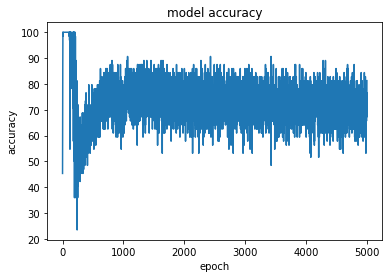

In [6]:
# Removed a layer of size 1024
if __name__ == '__main__':
    gan = GAN_3()
    gan.train(epochs=5000, batch_size=32, save_interval=200)

In [7]:
class GAN_4():
    def __init__(self):
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mean_squared_error', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='mean_squared_error', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='mean_squared_error', optimizer=optimizer)
        
    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)
        
        epoch_list = []
        acc_list = []
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            #d_loss_list.append(d_loss[0])
            acc_list.append(100*d_loss[1])
            
            # summarize history for loss
            

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
            # summarize history for accuracy
        plt.plot(acc_list,label="Accuracy")
       # plt.plot(display,epoch_list,label="")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        #plt.legend(['train', 'test'], loc='upper left')
        plt.show()
                
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("C:\\Stuff\\NEU\\Big-Data Systems and Intelligent Analytics\\Project Data\\mnist_1024LayerRemoved_%d.png" % epoch)
        plt.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

C:\Users\Amogh\Anaconda3\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.244269, acc.: 46.88%] [G loss: 0.246586]
1 [D loss: 0.146812, acc.: 68.75%] [G loss: 0.298204]
2 [D loss: 0.103587, acc.: 81.25%] [G loss: 0.347071]
3 [D loss: 0.094217, acc.: 93.75%] [G loss: 0.415429]
4 [D loss: 0.052365, acc.: 96.88%] [G loss: 0.486784]
5 [D loss: 0.042443, acc.: 96.88%] [G loss: 0.504258]
6 [D loss: 0.042176, acc.: 96.88%] [G loss: 0.553235]
7 [D loss: 0.039445, acc.: 100.00%] [G loss: 0.595163]
8 [D loss: 0.028653, acc.: 100.00%] [G loss: 0.614480]
9 [D loss: 0.025875, acc.: 100.00%] [G loss: 0.639071]
10 [D loss: 0.017470, acc.: 100.00%] [G loss: 0.626482]
11 [D loss: 0.025380, acc.: 100.00%] [G loss: 0.636531]
12 [D loss: 0.043246, acc.: 96.88%] [G loss: 0.660151]
13 [D loss: 0.019447, acc.: 100.00%] [G loss: 0.713568]
14 [D loss: 0.026680, acc.: 100.00%] [G loss: 0.706582]
15 [D loss: 0.023583, acc.: 96.88%] [G loss: 0.732237]
16 [D loss: 0.031813, acc.: 96.88%] [G loss: 0.701906]
17 [D loss: 0.030937, acc.: 100.00%] [G loss: 0.735436]
18 [D loss: 

151 [D loss: 0.203378, acc.: 65.62%] [G loss: 0.691652]
152 [D loss: 0.267544, acc.: 53.12%] [G loss: 0.521883]
153 [D loss: 0.191356, acc.: 68.75%] [G loss: 0.576770]
154 [D loss: 0.231614, acc.: 62.50%] [G loss: 0.639079]
155 [D loss: 0.207669, acc.: 65.62%] [G loss: 0.640287]
156 [D loss: 0.229280, acc.: 62.50%] [G loss: 0.654294]
157 [D loss: 0.206701, acc.: 65.62%] [G loss: 0.650808]
158 [D loss: 0.269313, acc.: 59.38%] [G loss: 0.496057]
159 [D loss: 0.208361, acc.: 68.75%] [G loss: 0.503424]
160 [D loss: 0.183209, acc.: 68.75%] [G loss: 0.514619]
161 [D loss: 0.274410, acc.: 59.38%] [G loss: 0.635041]
162 [D loss: 0.167483, acc.: 71.88%] [G loss: 0.708764]
163 [D loss: 0.277820, acc.: 40.62%] [G loss: 0.596990]
164 [D loss: 0.155366, acc.: 75.00%] [G loss: 0.700929]
165 [D loss: 0.225704, acc.: 53.12%] [G loss: 0.557047]
166 [D loss: 0.193370, acc.: 75.00%] [G loss: 0.512168]
167 [D loss: 0.233678, acc.: 65.62%] [G loss: 0.537034]
168 [D loss: 0.187412, acc.: 71.88%] [G loss: 0.

298 [D loss: 0.244293, acc.: 56.25%] [G loss: 0.425985]
299 [D loss: 0.193074, acc.: 65.62%] [G loss: 0.456905]
300 [D loss: 0.181743, acc.: 71.88%] [G loss: 0.401900]
301 [D loss: 0.222128, acc.: 62.50%] [G loss: 0.480572]
302 [D loss: 0.181801, acc.: 75.00%] [G loss: 0.459153]
303 [D loss: 0.229179, acc.: 59.38%] [G loss: 0.451604]
304 [D loss: 0.206174, acc.: 62.50%] [G loss: 0.420900]
305 [D loss: 0.215100, acc.: 65.62%] [G loss: 0.391551]
306 [D loss: 0.217265, acc.: 62.50%] [G loss: 0.438417]
307 [D loss: 0.197538, acc.: 68.75%] [G loss: 0.465087]
308 [D loss: 0.256658, acc.: 59.38%] [G loss: 0.398986]
309 [D loss: 0.247821, acc.: 59.38%] [G loss: 0.414420]
310 [D loss: 0.187346, acc.: 68.75%] [G loss: 0.521261]
311 [D loss: 0.253820, acc.: 53.12%] [G loss: 0.457065]
312 [D loss: 0.170975, acc.: 75.00%] [G loss: 0.442013]
313 [D loss: 0.187255, acc.: 78.12%] [G loss: 0.462470]
314 [D loss: 0.213393, acc.: 65.62%] [G loss: 0.388352]
315 [D loss: 0.166433, acc.: 75.00%] [G loss: 0.

446 [D loss: 0.179750, acc.: 68.75%] [G loss: 0.389610]
447 [D loss: 0.238229, acc.: 53.12%] [G loss: 0.405219]
448 [D loss: 0.221330, acc.: 59.38%] [G loss: 0.411556]
449 [D loss: 0.221906, acc.: 59.38%] [G loss: 0.412131]
450 [D loss: 0.213099, acc.: 56.25%] [G loss: 0.338713]
451 [D loss: 0.216480, acc.: 62.50%] [G loss: 0.388558]
452 [D loss: 0.196977, acc.: 65.62%] [G loss: 0.391657]
453 [D loss: 0.185361, acc.: 75.00%] [G loss: 0.374473]
454 [D loss: 0.208798, acc.: 59.38%] [G loss: 0.454019]
455 [D loss: 0.214763, acc.: 65.62%] [G loss: 0.360405]
456 [D loss: 0.216263, acc.: 59.38%] [G loss: 0.360291]
457 [D loss: 0.190525, acc.: 62.50%] [G loss: 0.341650]
458 [D loss: 0.218364, acc.: 65.62%] [G loss: 0.335123]
459 [D loss: 0.196529, acc.: 68.75%] [G loss: 0.386515]
460 [D loss: 0.242041, acc.: 56.25%] [G loss: 0.376019]
461 [D loss: 0.221266, acc.: 56.25%] [G loss: 0.417038]
462 [D loss: 0.217867, acc.: 56.25%] [G loss: 0.427953]
463 [D loss: 0.223809, acc.: 53.12%] [G loss: 0.

596 [D loss: 0.204327, acc.: 62.50%] [G loss: 0.361984]
597 [D loss: 0.232374, acc.: 53.12%] [G loss: 0.378893]
598 [D loss: 0.197022, acc.: 62.50%] [G loss: 0.393363]
599 [D loss: 0.222176, acc.: 56.25%] [G loss: 0.303153]
600 [D loss: 0.211199, acc.: 65.62%] [G loss: 0.322285]
601 [D loss: 0.223142, acc.: 59.38%] [G loss: 0.352701]
602 [D loss: 0.245286, acc.: 56.25%] [G loss: 0.366566]
603 [D loss: 0.209600, acc.: 62.50%] [G loss: 0.425882]
604 [D loss: 0.244343, acc.: 59.38%] [G loss: 0.326372]
605 [D loss: 0.192399, acc.: 71.88%] [G loss: 0.358471]
606 [D loss: 0.212381, acc.: 62.50%] [G loss: 0.383056]
607 [D loss: 0.260423, acc.: 46.88%] [G loss: 0.346680]
608 [D loss: 0.228168, acc.: 53.12%] [G loss: 0.350204]
609 [D loss: 0.218418, acc.: 62.50%] [G loss: 0.331869]
610 [D loss: 0.206547, acc.: 53.12%] [G loss: 0.403426]
611 [D loss: 0.216173, acc.: 59.38%] [G loss: 0.360265]
612 [D loss: 0.171364, acc.: 71.88%] [G loss: 0.376461]
613 [D loss: 0.238616, acc.: 50.00%] [G loss: 0.

746 [D loss: 0.195013, acc.: 62.50%] [G loss: 0.355223]
747 [D loss: 0.205805, acc.: 65.62%] [G loss: 0.379128]
748 [D loss: 0.237470, acc.: 56.25%] [G loss: 0.338607]
749 [D loss: 0.218989, acc.: 65.62%] [G loss: 0.390452]
750 [D loss: 0.248692, acc.: 62.50%] [G loss: 0.376243]
751 [D loss: 0.260755, acc.: 43.75%] [G loss: 0.360460]
752 [D loss: 0.194969, acc.: 71.88%] [G loss: 0.348307]
753 [D loss: 0.235460, acc.: 56.25%] [G loss: 0.346702]
754 [D loss: 0.254911, acc.: 50.00%] [G loss: 0.313374]
755 [D loss: 0.229488, acc.: 56.25%] [G loss: 0.359139]
756 [D loss: 0.248691, acc.: 56.25%] [G loss: 0.321323]
757 [D loss: 0.254208, acc.: 50.00%] [G loss: 0.374107]
758 [D loss: 0.236643, acc.: 56.25%] [G loss: 0.359678]
759 [D loss: 0.233496, acc.: 59.38%] [G loss: 0.309630]
760 [D loss: 0.234536, acc.: 53.12%] [G loss: 0.361802]
761 [D loss: 0.224866, acc.: 53.12%] [G loss: 0.328566]
762 [D loss: 0.178828, acc.: 81.25%] [G loss: 0.330213]
763 [D loss: 0.225667, acc.: 56.25%] [G loss: 0.

895 [D loss: 0.221607, acc.: 59.38%] [G loss: 0.336941]
896 [D loss: 0.225228, acc.: 56.25%] [G loss: 0.345839]
897 [D loss: 0.195495, acc.: 75.00%] [G loss: 0.355746]
898 [D loss: 0.230627, acc.: 68.75%] [G loss: 0.294339]
899 [D loss: 0.219702, acc.: 59.38%] [G loss: 0.402876]
900 [D loss: 0.217616, acc.: 59.38%] [G loss: 0.305488]
901 [D loss: 0.207970, acc.: 50.00%] [G loss: 0.316707]
902 [D loss: 0.215214, acc.: 59.38%] [G loss: 0.405093]
903 [D loss: 0.199346, acc.: 65.62%] [G loss: 0.405359]
904 [D loss: 0.255752, acc.: 40.62%] [G loss: 0.365696]
905 [D loss: 0.237904, acc.: 62.50%] [G loss: 0.301139]
906 [D loss: 0.214829, acc.: 56.25%] [G loss: 0.374690]
907 [D loss: 0.233732, acc.: 56.25%] [G loss: 0.345366]
908 [D loss: 0.225203, acc.: 62.50%] [G loss: 0.350465]
909 [D loss: 0.251188, acc.: 43.75%] [G loss: 0.361379]
910 [D loss: 0.212538, acc.: 65.62%] [G loss: 0.321027]
911 [D loss: 0.243722, acc.: 62.50%] [G loss: 0.356655]
912 [D loss: 0.196556, acc.: 75.00%] [G loss: 0.

1042 [D loss: 0.217455, acc.: 53.12%] [G loss: 0.300836]
1043 [D loss: 0.226739, acc.: 59.38%] [G loss: 0.370571]
1044 [D loss: 0.244541, acc.: 56.25%] [G loss: 0.307247]
1045 [D loss: 0.235628, acc.: 53.12%] [G loss: 0.423157]
1046 [D loss: 0.229393, acc.: 53.12%] [G loss: 0.349801]
1047 [D loss: 0.229924, acc.: 53.12%] [G loss: 0.375997]
1048 [D loss: 0.214011, acc.: 59.38%] [G loss: 0.285786]
1049 [D loss: 0.241999, acc.: 50.00%] [G loss: 0.301265]
1050 [D loss: 0.220040, acc.: 59.38%] [G loss: 0.315365]
1051 [D loss: 0.215758, acc.: 56.25%] [G loss: 0.345032]
1052 [D loss: 0.217443, acc.: 62.50%] [G loss: 0.320007]
1053 [D loss: 0.223347, acc.: 65.62%] [G loss: 0.346564]
1054 [D loss: 0.218831, acc.: 71.88%] [G loss: 0.407992]
1055 [D loss: 0.190503, acc.: 68.75%] [G loss: 0.295210]
1056 [D loss: 0.261002, acc.: 37.50%] [G loss: 0.329544]
1057 [D loss: 0.222750, acc.: 59.38%] [G loss: 0.413103]
1058 [D loss: 0.260894, acc.: 43.75%] [G loss: 0.351780]
1059 [D loss: 0.226991, acc.: 5

1187 [D loss: 0.222452, acc.: 65.62%] [G loss: 0.361863]
1188 [D loss: 0.187240, acc.: 71.88%] [G loss: 0.359963]
1189 [D loss: 0.233633, acc.: 65.62%] [G loss: 0.299012]
1190 [D loss: 0.241366, acc.: 46.88%] [G loss: 0.320859]
1191 [D loss: 0.241887, acc.: 59.38%] [G loss: 0.298049]
1192 [D loss: 0.244596, acc.: 65.62%] [G loss: 0.334859]
1193 [D loss: 0.240475, acc.: 53.12%] [G loss: 0.315565]
1194 [D loss: 0.244204, acc.: 50.00%] [G loss: 0.306911]
1195 [D loss: 0.227688, acc.: 56.25%] [G loss: 0.336028]
1196 [D loss: 0.220692, acc.: 68.75%] [G loss: 0.287605]
1197 [D loss: 0.213552, acc.: 65.62%] [G loss: 0.331573]
1198 [D loss: 0.227461, acc.: 65.62%] [G loss: 0.325392]
1199 [D loss: 0.221622, acc.: 65.62%] [G loss: 0.286620]
1200 [D loss: 0.235686, acc.: 53.12%] [G loss: 0.326791]
1201 [D loss: 0.224470, acc.: 59.38%] [G loss: 0.305636]
1202 [D loss: 0.258834, acc.: 43.75%] [G loss: 0.300595]
1203 [D loss: 0.250005, acc.: 46.88%] [G loss: 0.313301]
1204 [D loss: 0.205032, acc.: 6

1334 [D loss: 0.227947, acc.: 65.62%] [G loss: 0.319077]
1335 [D loss: 0.240259, acc.: 56.25%] [G loss: 0.282290]
1336 [D loss: 0.251662, acc.: 43.75%] [G loss: 0.340642]
1337 [D loss: 0.232036, acc.: 71.88%] [G loss: 0.299410]
1338 [D loss: 0.240061, acc.: 50.00%] [G loss: 0.311751]
1339 [D loss: 0.236325, acc.: 53.12%] [G loss: 0.329900]
1340 [D loss: 0.212723, acc.: 71.88%] [G loss: 0.347981]
1341 [D loss: 0.211925, acc.: 68.75%] [G loss: 0.407760]
1342 [D loss: 0.218389, acc.: 56.25%] [G loss: 0.306402]
1343 [D loss: 0.201466, acc.: 75.00%] [G loss: 0.312718]
1344 [D loss: 0.245577, acc.: 53.12%] [G loss: 0.308491]
1345 [D loss: 0.237672, acc.: 59.38%] [G loss: 0.339078]
1346 [D loss: 0.221266, acc.: 65.62%] [G loss: 0.340692]
1347 [D loss: 0.198785, acc.: 71.88%] [G loss: 0.379193]
1348 [D loss: 0.210144, acc.: 56.25%] [G loss: 0.345893]
1349 [D loss: 0.236946, acc.: 50.00%] [G loss: 0.339612]
1350 [D loss: 0.249383, acc.: 56.25%] [G loss: 0.332995]
1351 [D loss: 0.228154, acc.: 6

1481 [D loss: 0.208211, acc.: 75.00%] [G loss: 0.297773]
1482 [D loss: 0.232917, acc.: 62.50%] [G loss: 0.409270]
1483 [D loss: 0.224297, acc.: 71.88%] [G loss: 0.379839]
1484 [D loss: 0.205203, acc.: 71.88%] [G loss: 0.421228]
1485 [D loss: 0.227780, acc.: 59.38%] [G loss: 0.348230]
1486 [D loss: 0.237162, acc.: 59.38%] [G loss: 0.381211]
1487 [D loss: 0.222815, acc.: 62.50%] [G loss: 0.356315]
1488 [D loss: 0.232328, acc.: 59.38%] [G loss: 0.313800]
1489 [D loss: 0.229825, acc.: 62.50%] [G loss: 0.332169]
1490 [D loss: 0.238378, acc.: 56.25%] [G loss: 0.325057]
1491 [D loss: 0.254795, acc.: 43.75%] [G loss: 0.333535]
1492 [D loss: 0.234906, acc.: 62.50%] [G loss: 0.307035]
1493 [D loss: 0.228314, acc.: 56.25%] [G loss: 0.332659]
1494 [D loss: 0.246347, acc.: 53.12%] [G loss: 0.319861]
1495 [D loss: 0.228743, acc.: 62.50%] [G loss: 0.317560]
1496 [D loss: 0.223245, acc.: 56.25%] [G loss: 0.346909]
1497 [D loss: 0.205317, acc.: 65.62%] [G loss: 0.344871]
1498 [D loss: 0.248018, acc.: 5

1770 [D loss: 0.231224, acc.: 62.50%] [G loss: 0.293691]
1771 [D loss: 0.222753, acc.: 71.88%] [G loss: 0.317896]
1772 [D loss: 0.203716, acc.: 75.00%] [G loss: 0.312544]
1773 [D loss: 0.216970, acc.: 65.62%] [G loss: 0.304338]
1774 [D loss: 0.224533, acc.: 53.12%] [G loss: 0.311242]
1775 [D loss: 0.199874, acc.: 81.25%] [G loss: 0.329880]
1776 [D loss: 0.189925, acc.: 75.00%] [G loss: 0.336792]
1777 [D loss: 0.205251, acc.: 65.62%] [G loss: 0.340810]
1778 [D loss: 0.252293, acc.: 46.88%] [G loss: 0.346078]
1779 [D loss: 0.203624, acc.: 75.00%] [G loss: 0.320752]
1780 [D loss: 0.244657, acc.: 46.88%] [G loss: 0.312654]
1781 [D loss: 0.200341, acc.: 68.75%] [G loss: 0.306992]
1782 [D loss: 0.199629, acc.: 71.88%] [G loss: 0.308421]
1783 [D loss: 0.228231, acc.: 56.25%] [G loss: 0.297720]
1784 [D loss: 0.208019, acc.: 56.25%] [G loss: 0.345754]
1785 [D loss: 0.233443, acc.: 59.38%] [G loss: 0.358932]
1786 [D loss: 0.194550, acc.: 68.75%] [G loss: 0.335143]
1787 [D loss: 0.217858, acc.: 6

1917 [D loss: 0.186645, acc.: 81.25%] [G loss: 0.378745]
1918 [D loss: 0.212341, acc.: 78.12%] [G loss: 0.368079]
1919 [D loss: 0.263311, acc.: 53.12%] [G loss: 0.332416]
1920 [D loss: 0.218539, acc.: 71.88%] [G loss: 0.332305]
1921 [D loss: 0.261156, acc.: 56.25%] [G loss: 0.301842]
1922 [D loss: 0.212858, acc.: 62.50%] [G loss: 0.272593]
1923 [D loss: 0.229996, acc.: 62.50%] [G loss: 0.300279]
1924 [D loss: 0.210075, acc.: 68.75%] [G loss: 0.279490]
1925 [D loss: 0.264175, acc.: 59.38%] [G loss: 0.270541]
1926 [D loss: 0.219290, acc.: 59.38%] [G loss: 0.290303]
1927 [D loss: 0.200294, acc.: 68.75%] [G loss: 0.308199]
1928 [D loss: 0.235806, acc.: 59.38%] [G loss: 0.305287]
1929 [D loss: 0.250967, acc.: 62.50%] [G loss: 0.324474]
1930 [D loss: 0.213549, acc.: 65.62%] [G loss: 0.299372]
1931 [D loss: 0.220532, acc.: 68.75%] [G loss: 0.290999]
1932 [D loss: 0.218352, acc.: 62.50%] [G loss: 0.363656]
1933 [D loss: 0.188161, acc.: 81.25%] [G loss: 0.330689]
1934 [D loss: 0.213694, acc.: 6

2061 [D loss: 0.208057, acc.: 75.00%] [G loss: 0.336750]
2062 [D loss: 0.227317, acc.: 65.62%] [G loss: 0.321891]
2063 [D loss: 0.214033, acc.: 62.50%] [G loss: 0.301798]
2064 [D loss: 0.235826, acc.: 56.25%] [G loss: 0.306231]
2065 [D loss: 0.219491, acc.: 62.50%] [G loss: 0.289860]
2066 [D loss: 0.205415, acc.: 65.62%] [G loss: 0.296443]
2067 [D loss: 0.240628, acc.: 56.25%] [G loss: 0.295318]
2068 [D loss: 0.221483, acc.: 68.75%] [G loss: 0.299003]
2069 [D loss: 0.210131, acc.: 71.88%] [G loss: 0.292788]
2070 [D loss: 0.214631, acc.: 62.50%] [G loss: 0.357107]
2071 [D loss: 0.227441, acc.: 62.50%] [G loss: 0.391682]
2072 [D loss: 0.235179, acc.: 62.50%] [G loss: 0.316853]
2073 [D loss: 0.268475, acc.: 43.75%] [G loss: 0.332008]
2074 [D loss: 0.226848, acc.: 65.62%] [G loss: 0.303676]
2075 [D loss: 0.231963, acc.: 59.38%] [G loss: 0.308549]
2076 [D loss: 0.193936, acc.: 84.38%] [G loss: 0.324467]
2077 [D loss: 0.231518, acc.: 62.50%] [G loss: 0.324226]
2078 [D loss: 0.247465, acc.: 5

2205 [D loss: 0.218993, acc.: 68.75%] [G loss: 0.317910]
2206 [D loss: 0.221015, acc.: 59.38%] [G loss: 0.300241]
2207 [D loss: 0.262707, acc.: 50.00%] [G loss: 0.288825]
2208 [D loss: 0.217905, acc.: 75.00%] [G loss: 0.290722]
2209 [D loss: 0.219119, acc.: 56.25%] [G loss: 0.313609]
2210 [D loss: 0.222373, acc.: 71.88%] [G loss: 0.311262]
2211 [D loss: 0.247960, acc.: 50.00%] [G loss: 0.318053]
2212 [D loss: 0.266424, acc.: 46.88%] [G loss: 0.315862]
2213 [D loss: 0.215251, acc.: 71.88%] [G loss: 0.317114]
2214 [D loss: 0.238520, acc.: 53.12%] [G loss: 0.320303]
2215 [D loss: 0.223904, acc.: 62.50%] [G loss: 0.316850]
2216 [D loss: 0.226309, acc.: 56.25%] [G loss: 0.325785]
2217 [D loss: 0.250661, acc.: 59.38%] [G loss: 0.310517]
2218 [D loss: 0.240930, acc.: 59.38%] [G loss: 0.323761]
2219 [D loss: 0.218554, acc.: 62.50%] [G loss: 0.299835]
2220 [D loss: 0.268645, acc.: 40.62%] [G loss: 0.318429]
2221 [D loss: 0.187911, acc.: 75.00%] [G loss: 0.316962]
2222 [D loss: 0.199698, acc.: 8

2352 [D loss: 0.238128, acc.: 56.25%] [G loss: 0.340084]
2353 [D loss: 0.243030, acc.: 53.12%] [G loss: 0.327597]
2354 [D loss: 0.256379, acc.: 53.12%] [G loss: 0.319740]
2355 [D loss: 0.229478, acc.: 62.50%] [G loss: 0.297667]
2356 [D loss: 0.262707, acc.: 50.00%] [G loss: 0.309678]
2357 [D loss: 0.250193, acc.: 53.12%] [G loss: 0.307635]
2358 [D loss: 0.216270, acc.: 65.62%] [G loss: 0.285964]
2359 [D loss: 0.228730, acc.: 56.25%] [G loss: 0.326867]
2360 [D loss: 0.233747, acc.: 65.62%] [G loss: 0.299022]
2361 [D loss: 0.238181, acc.: 62.50%] [G loss: 0.327587]
2362 [D loss: 0.230060, acc.: 62.50%] [G loss: 0.299888]
2363 [D loss: 0.227485, acc.: 59.38%] [G loss: 0.334862]
2364 [D loss: 0.206635, acc.: 75.00%] [G loss: 0.316077]
2365 [D loss: 0.219783, acc.: 65.62%] [G loss: 0.319394]
2366 [D loss: 0.244074, acc.: 50.00%] [G loss: 0.297414]
2367 [D loss: 0.234748, acc.: 65.62%] [G loss: 0.333853]
2368 [D loss: 0.257458, acc.: 50.00%] [G loss: 0.313833]
2369 [D loss: 0.216730, acc.: 6

2499 [D loss: 0.227124, acc.: 65.62%] [G loss: 0.288618]
2500 [D loss: 0.191642, acc.: 68.75%] [G loss: 0.282184]
2501 [D loss: 0.224921, acc.: 65.62%] [G loss: 0.304354]
2502 [D loss: 0.233070, acc.: 59.38%] [G loss: 0.310855]
2503 [D loss: 0.279705, acc.: 34.38%] [G loss: 0.281991]
2504 [D loss: 0.216970, acc.: 68.75%] [G loss: 0.283762]
2505 [D loss: 0.222873, acc.: 65.62%] [G loss: 0.326294]
2506 [D loss: 0.242367, acc.: 62.50%] [G loss: 0.335108]
2507 [D loss: 0.254756, acc.: 56.25%] [G loss: 0.314718]
2508 [D loss: 0.247268, acc.: 53.12%] [G loss: 0.324265]
2509 [D loss: 0.226919, acc.: 75.00%] [G loss: 0.305056]
2510 [D loss: 0.215560, acc.: 65.62%] [G loss: 0.318946]
2511 [D loss: 0.230767, acc.: 75.00%] [G loss: 0.324073]
2512 [D loss: 0.213085, acc.: 59.38%] [G loss: 0.303927]
2513 [D loss: 0.242723, acc.: 50.00%] [G loss: 0.314255]
2514 [D loss: 0.230619, acc.: 59.38%] [G loss: 0.300169]
2515 [D loss: 0.210857, acc.: 62.50%] [G loss: 0.331355]
2516 [D loss: 0.303429, acc.: 3

2645 [D loss: 0.222012, acc.: 65.62%] [G loss: 0.332153]
2646 [D loss: 0.265804, acc.: 46.88%] [G loss: 0.318970]
2647 [D loss: 0.243259, acc.: 56.25%] [G loss: 0.291458]
2648 [D loss: 0.237058, acc.: 59.38%] [G loss: 0.315884]
2649 [D loss: 0.240478, acc.: 53.12%] [G loss: 0.334193]
2650 [D loss: 0.242684, acc.: 46.88%] [G loss: 0.310359]
2651 [D loss: 0.223298, acc.: 62.50%] [G loss: 0.304212]
2652 [D loss: 0.203903, acc.: 75.00%] [G loss: 0.295153]
2653 [D loss: 0.227396, acc.: 59.38%] [G loss: 0.323283]
2654 [D loss: 0.260993, acc.: 59.38%] [G loss: 0.305271]
2655 [D loss: 0.213902, acc.: 68.75%] [G loss: 0.340835]
2656 [D loss: 0.210219, acc.: 68.75%] [G loss: 0.325543]
2657 [D loss: 0.237020, acc.: 50.00%] [G loss: 0.310367]
2658 [D loss: 0.228531, acc.: 62.50%] [G loss: 0.322125]
2659 [D loss: 0.215420, acc.: 71.88%] [G loss: 0.327968]
2660 [D loss: 0.226157, acc.: 56.25%] [G loss: 0.331827]
2661 [D loss: 0.243962, acc.: 53.12%] [G loss: 0.313384]
2662 [D loss: 0.222490, acc.: 6

2789 [D loss: 0.223303, acc.: 62.50%] [G loss: 0.283307]
2790 [D loss: 0.223466, acc.: 65.62%] [G loss: 0.306224]
2791 [D loss: 0.250014, acc.: 56.25%] [G loss: 0.304614]
2792 [D loss: 0.230478, acc.: 62.50%] [G loss: 0.295787]
2793 [D loss: 0.245858, acc.: 46.88%] [G loss: 0.320837]
2794 [D loss: 0.239852, acc.: 59.38%] [G loss: 0.307339]
2795 [D loss: 0.206805, acc.: 78.12%] [G loss: 0.324366]
2796 [D loss: 0.210917, acc.: 71.88%] [G loss: 0.294241]
2797 [D loss: 0.274682, acc.: 53.12%] [G loss: 0.298696]
2798 [D loss: 0.210289, acc.: 68.75%] [G loss: 0.286161]
2799 [D loss: 0.238221, acc.: 65.62%] [G loss: 0.280192]
2800 [D loss: 0.272639, acc.: 53.12%] [G loss: 0.278500]
2801 [D loss: 0.225718, acc.: 62.50%] [G loss: 0.325442]
2802 [D loss: 0.226240, acc.: 62.50%] [G loss: 0.327071]
2803 [D loss: 0.220722, acc.: 65.62%] [G loss: 0.312561]
2804 [D loss: 0.218578, acc.: 62.50%] [G loss: 0.331065]
2805 [D loss: 0.255095, acc.: 43.75%] [G loss: 0.333758]
2806 [D loss: 0.265864, acc.: 5

2934 [D loss: 0.245529, acc.: 50.00%] [G loss: 0.305184]
2935 [D loss: 0.237081, acc.: 62.50%] [G loss: 0.294377]
2936 [D loss: 0.251236, acc.: 56.25%] [G loss: 0.300422]
2937 [D loss: 0.238128, acc.: 59.38%] [G loss: 0.304746]
2938 [D loss: 0.228174, acc.: 62.50%] [G loss: 0.336621]
2939 [D loss: 0.259923, acc.: 46.88%] [G loss: 0.319779]
2940 [D loss: 0.253346, acc.: 46.88%] [G loss: 0.303184]
2941 [D loss: 0.215137, acc.: 68.75%] [G loss: 0.323595]
2942 [D loss: 0.234431, acc.: 59.38%] [G loss: 0.312549]
2943 [D loss: 0.248842, acc.: 50.00%] [G loss: 0.293621]
2944 [D loss: 0.195276, acc.: 81.25%] [G loss: 0.336646]
2945 [D loss: 0.261191, acc.: 53.12%] [G loss: 0.314858]
2946 [D loss: 0.239725, acc.: 59.38%] [G loss: 0.319375]
2947 [D loss: 0.248632, acc.: 50.00%] [G loss: 0.300760]
2948 [D loss: 0.256024, acc.: 53.12%] [G loss: 0.283168]
2949 [D loss: 0.199692, acc.: 65.62%] [G loss: 0.285551]
2950 [D loss: 0.223548, acc.: 75.00%] [G loss: 0.293898]
2951 [D loss: 0.242973, acc.: 5

3081 [D loss: 0.224249, acc.: 62.50%] [G loss: 0.324810]
3082 [D loss: 0.211297, acc.: 62.50%] [G loss: 0.328247]
3083 [D loss: 0.228963, acc.: 65.62%] [G loss: 0.320421]
3084 [D loss: 0.243976, acc.: 59.38%] [G loss: 0.339047]
3085 [D loss: 0.217858, acc.: 62.50%] [G loss: 0.333934]
3086 [D loss: 0.244053, acc.: 46.88%] [G loss: 0.321631]
3087 [D loss: 0.254840, acc.: 50.00%] [G loss: 0.319324]
3088 [D loss: 0.199777, acc.: 68.75%] [G loss: 0.339845]
3089 [D loss: 0.247424, acc.: 56.25%] [G loss: 0.329826]
3090 [D loss: 0.243667, acc.: 59.38%] [G loss: 0.314117]
3091 [D loss: 0.212453, acc.: 65.62%] [G loss: 0.322879]
3092 [D loss: 0.230798, acc.: 56.25%] [G loss: 0.327104]
3093 [D loss: 0.237875, acc.: 56.25%] [G loss: 0.323298]
3094 [D loss: 0.252590, acc.: 56.25%] [G loss: 0.321906]
3095 [D loss: 0.267927, acc.: 34.38%] [G loss: 0.349579]
3096 [D loss: 0.243305, acc.: 56.25%] [G loss: 0.322964]
3097 [D loss: 0.225331, acc.: 65.62%] [G loss: 0.313662]
3098 [D loss: 0.233796, acc.: 5

3225 [D loss: 0.237545, acc.: 56.25%] [G loss: 0.314262]
3226 [D loss: 0.220176, acc.: 65.62%] [G loss: 0.320972]
3227 [D loss: 0.279602, acc.: 43.75%] [G loss: 0.309280]
3228 [D loss: 0.236490, acc.: 59.38%] [G loss: 0.327225]
3229 [D loss: 0.219721, acc.: 75.00%] [G loss: 0.310130]
3230 [D loss: 0.230229, acc.: 46.88%] [G loss: 0.336182]
3231 [D loss: 0.212659, acc.: 65.62%] [G loss: 0.337704]
3232 [D loss: 0.239615, acc.: 53.12%] [G loss: 0.301454]
3233 [D loss: 0.257351, acc.: 50.00%] [G loss: 0.289133]
3234 [D loss: 0.233933, acc.: 62.50%] [G loss: 0.297529]
3235 [D loss: 0.249401, acc.: 43.75%] [G loss: 0.289441]
3236 [D loss: 0.235844, acc.: 59.38%] [G loss: 0.325530]
3237 [D loss: 0.232753, acc.: 50.00%] [G loss: 0.314563]
3238 [D loss: 0.213342, acc.: 71.88%] [G loss: 0.330641]
3239 [D loss: 0.227348, acc.: 56.25%] [G loss: 0.316175]
3240 [D loss: 0.228618, acc.: 56.25%] [G loss: 0.312869]
3241 [D loss: 0.227854, acc.: 62.50%] [G loss: 0.302996]
3242 [D loss: 0.238740, acc.: 6

3370 [D loss: 0.205561, acc.: 71.88%] [G loss: 0.312539]
3371 [D loss: 0.235531, acc.: 62.50%] [G loss: 0.295377]
3372 [D loss: 0.265356, acc.: 62.50%] [G loss: 0.293134]
3373 [D loss: 0.218995, acc.: 65.62%] [G loss: 0.303781]
3374 [D loss: 0.231932, acc.: 56.25%] [G loss: 0.311273]
3375 [D loss: 0.231441, acc.: 62.50%] [G loss: 0.281772]
3376 [D loss: 0.219394, acc.: 56.25%] [G loss: 0.303015]
3377 [D loss: 0.253681, acc.: 50.00%] [G loss: 0.323560]
3378 [D loss: 0.205032, acc.: 71.88%] [G loss: 0.310168]
3379 [D loss: 0.221535, acc.: 53.12%] [G loss: 0.313522]
3380 [D loss: 0.264274, acc.: 56.25%] [G loss: 0.278471]
3381 [D loss: 0.230128, acc.: 71.88%] [G loss: 0.260365]
3382 [D loss: 0.258346, acc.: 46.88%] [G loss: 0.326688]
3383 [D loss: 0.230680, acc.: 59.38%] [G loss: 0.318509]
3384 [D loss: 0.198119, acc.: 81.25%] [G loss: 0.317734]
3385 [D loss: 0.255527, acc.: 56.25%] [G loss: 0.310029]
3386 [D loss: 0.231420, acc.: 62.50%] [G loss: 0.371084]
3387 [D loss: 0.232656, acc.: 6

3515 [D loss: 0.248552, acc.: 53.12%] [G loss: 0.301958]
3516 [D loss: 0.218885, acc.: 62.50%] [G loss: 0.299282]
3517 [D loss: 0.228742, acc.: 62.50%] [G loss: 0.323310]
3518 [D loss: 0.249753, acc.: 46.88%] [G loss: 0.309949]
3519 [D loss: 0.221028, acc.: 71.88%] [G loss: 0.321506]
3520 [D loss: 0.225236, acc.: 59.38%] [G loss: 0.304307]
3521 [D loss: 0.214790, acc.: 71.88%] [G loss: 0.314020]
3522 [D loss: 0.218903, acc.: 65.62%] [G loss: 0.336547]
3523 [D loss: 0.241868, acc.: 62.50%] [G loss: 0.306392]
3524 [D loss: 0.225886, acc.: 59.38%] [G loss: 0.320192]
3525 [D loss: 0.266499, acc.: 37.50%] [G loss: 0.310051]
3526 [D loss: 0.246393, acc.: 56.25%] [G loss: 0.305232]
3527 [D loss: 0.250611, acc.: 53.12%] [G loss: 0.288045]
3528 [D loss: 0.221619, acc.: 75.00%] [G loss: 0.304068]
3529 [D loss: 0.249009, acc.: 56.25%] [G loss: 0.310843]
3530 [D loss: 0.275617, acc.: 50.00%] [G loss: 0.292157]
3531 [D loss: 0.245464, acc.: 56.25%] [G loss: 0.310443]
3532 [D loss: 0.259115, acc.: 4

3662 [D loss: 0.252432, acc.: 50.00%] [G loss: 0.312491]
3663 [D loss: 0.268405, acc.: 46.88%] [G loss: 0.301134]
3664 [D loss: 0.245487, acc.: 46.88%] [G loss: 0.292951]
3665 [D loss: 0.227276, acc.: 71.88%] [G loss: 0.324858]
3666 [D loss: 0.229783, acc.: 53.12%] [G loss: 0.305316]
3667 [D loss: 0.264404, acc.: 50.00%] [G loss: 0.311212]
3668 [D loss: 0.212408, acc.: 68.75%] [G loss: 0.302081]
3669 [D loss: 0.236587, acc.: 56.25%] [G loss: 0.285454]
3670 [D loss: 0.247374, acc.: 50.00%] [G loss: 0.298314]
3671 [D loss: 0.243051, acc.: 65.62%] [G loss: 0.312685]
3672 [D loss: 0.216489, acc.: 56.25%] [G loss: 0.313074]
3673 [D loss: 0.240585, acc.: 59.38%] [G loss: 0.310678]
3674 [D loss: 0.231347, acc.: 68.75%] [G loss: 0.286013]
3675 [D loss: 0.219886, acc.: 56.25%] [G loss: 0.299614]
3676 [D loss: 0.246435, acc.: 59.38%] [G loss: 0.343906]
3677 [D loss: 0.221774, acc.: 62.50%] [G loss: 0.312227]
3678 [D loss: 0.258785, acc.: 56.25%] [G loss: 0.333199]
3679 [D loss: 0.245523, acc.: 5

3809 [D loss: 0.250622, acc.: 56.25%] [G loss: 0.331489]
3810 [D loss: 0.230847, acc.: 59.38%] [G loss: 0.319260]
3811 [D loss: 0.188680, acc.: 78.12%] [G loss: 0.319361]
3812 [D loss: 0.271630, acc.: 50.00%] [G loss: 0.283007]
3813 [D loss: 0.208660, acc.: 71.88%] [G loss: 0.331815]
3814 [D loss: 0.231010, acc.: 62.50%] [G loss: 0.338184]
3815 [D loss: 0.212730, acc.: 71.88%] [G loss: 0.364790]
3816 [D loss: 0.244511, acc.: 56.25%] [G loss: 0.297227]
3817 [D loss: 0.261325, acc.: 62.50%] [G loss: 0.305624]
3818 [D loss: 0.237642, acc.: 62.50%] [G loss: 0.307645]
3819 [D loss: 0.218756, acc.: 62.50%] [G loss: 0.299552]
3820 [D loss: 0.228537, acc.: 65.62%] [G loss: 0.300031]
3821 [D loss: 0.230538, acc.: 59.38%] [G loss: 0.285733]
3822 [D loss: 0.246609, acc.: 62.50%] [G loss: 0.320401]
3823 [D loss: 0.262998, acc.: 53.12%] [G loss: 0.316561]
3824 [D loss: 0.249666, acc.: 56.25%] [G loss: 0.310586]
3825 [D loss: 0.226793, acc.: 56.25%] [G loss: 0.293684]
3826 [D loss: 0.227584, acc.: 5

3956 [D loss: 0.234597, acc.: 50.00%] [G loss: 0.311879]
3957 [D loss: 0.236092, acc.: 56.25%] [G loss: 0.345770]
3958 [D loss: 0.246071, acc.: 53.12%] [G loss: 0.330369]
3959 [D loss: 0.253952, acc.: 50.00%] [G loss: 0.314862]
3960 [D loss: 0.244413, acc.: 46.88%] [G loss: 0.335768]
3961 [D loss: 0.231666, acc.: 56.25%] [G loss: 0.281314]
3962 [D loss: 0.215669, acc.: 68.75%] [G loss: 0.320525]
3963 [D loss: 0.224691, acc.: 62.50%] [G loss: 0.296613]
3964 [D loss: 0.222835, acc.: 59.38%] [G loss: 0.293173]
3965 [D loss: 0.224074, acc.: 62.50%] [G loss: 0.328172]
3966 [D loss: 0.205143, acc.: 68.75%] [G loss: 0.287612]
3967 [D loss: 0.221819, acc.: 68.75%] [G loss: 0.303390]
3968 [D loss: 0.223779, acc.: 65.62%] [G loss: 0.331263]
3969 [D loss: 0.220897, acc.: 59.38%] [G loss: 0.320344]
3970 [D loss: 0.248212, acc.: 50.00%] [G loss: 0.324445]
3971 [D loss: 0.261743, acc.: 50.00%] [G loss: 0.312813]
3972 [D loss: 0.228823, acc.: 71.88%] [G loss: 0.316940]
3973 [D loss: 0.199290, acc.: 7

4101 [D loss: 0.259962, acc.: 59.38%] [G loss: 0.291195]
4102 [D loss: 0.210699, acc.: 71.88%] [G loss: 0.316875]
4103 [D loss: 0.213512, acc.: 65.62%] [G loss: 0.330043]
4104 [D loss: 0.232136, acc.: 71.88%] [G loss: 0.315260]
4105 [D loss: 0.246521, acc.: 43.75%] [G loss: 0.310796]
4106 [D loss: 0.237423, acc.: 56.25%] [G loss: 0.306840]
4107 [D loss: 0.245620, acc.: 62.50%] [G loss: 0.290049]
4108 [D loss: 0.263723, acc.: 37.50%] [G loss: 0.312624]
4109 [D loss: 0.216753, acc.: 68.75%] [G loss: 0.288464]
4110 [D loss: 0.199509, acc.: 84.38%] [G loss: 0.295014]
4111 [D loss: 0.218578, acc.: 65.62%] [G loss: 0.326316]
4112 [D loss: 0.234927, acc.: 56.25%] [G loss: 0.304266]
4113 [D loss: 0.230611, acc.: 59.38%] [G loss: 0.308728]
4114 [D loss: 0.219459, acc.: 65.62%] [G loss: 0.308053]
4115 [D loss: 0.216256, acc.: 71.88%] [G loss: 0.290077]
4116 [D loss: 0.208510, acc.: 71.88%] [G loss: 0.282428]
4117 [D loss: 0.247108, acc.: 56.25%] [G loss: 0.257274]
4118 [D loss: 0.245599, acc.: 5

4247 [D loss: 0.240686, acc.: 62.50%] [G loss: 0.307790]
4248 [D loss: 0.250911, acc.: 50.00%] [G loss: 0.317477]
4249 [D loss: 0.229432, acc.: 56.25%] [G loss: 0.339156]
4250 [D loss: 0.243135, acc.: 56.25%] [G loss: 0.307991]
4251 [D loss: 0.247826, acc.: 50.00%] [G loss: 0.294229]
4252 [D loss: 0.224804, acc.: 56.25%] [G loss: 0.290894]
4253 [D loss: 0.245615, acc.: 62.50%] [G loss: 0.300500]
4254 [D loss: 0.232045, acc.: 56.25%] [G loss: 0.307498]
4255 [D loss: 0.223491, acc.: 71.88%] [G loss: 0.289858]
4256 [D loss: 0.222566, acc.: 65.62%] [G loss: 0.334714]
4257 [D loss: 0.231315, acc.: 56.25%] [G loss: 0.315321]
4258 [D loss: 0.207891, acc.: 71.88%] [G loss: 0.350980]
4259 [D loss: 0.200128, acc.: 68.75%] [G loss: 0.317778]
4260 [D loss: 0.244932, acc.: 62.50%] [G loss: 0.333723]
4261 [D loss: 0.252019, acc.: 56.25%] [G loss: 0.320214]
4262 [D loss: 0.209622, acc.: 75.00%] [G loss: 0.306329]
4263 [D loss: 0.229954, acc.: 65.62%] [G loss: 0.322285]
4264 [D loss: 0.201380, acc.: 7

4391 [D loss: 0.201303, acc.: 65.62%] [G loss: 0.352120]
4392 [D loss: 0.254849, acc.: 46.88%] [G loss: 0.337109]
4393 [D loss: 0.204731, acc.: 78.12%] [G loss: 0.335833]
4394 [D loss: 0.259353, acc.: 50.00%] [G loss: 0.330956]
4395 [D loss: 0.225453, acc.: 65.62%] [G loss: 0.313257]
4396 [D loss: 0.229147, acc.: 62.50%] [G loss: 0.330041]
4397 [D loss: 0.246761, acc.: 56.25%] [G loss: 0.339986]
4398 [D loss: 0.202613, acc.: 68.75%] [G loss: 0.313473]
4399 [D loss: 0.271482, acc.: 50.00%] [G loss: 0.300448]
4400 [D loss: 0.209333, acc.: 71.88%] [G loss: 0.322610]
4401 [D loss: 0.234294, acc.: 56.25%] [G loss: 0.320743]
4402 [D loss: 0.216253, acc.: 65.62%] [G loss: 0.319103]
4403 [D loss: 0.245628, acc.: 56.25%] [G loss: 0.307682]
4404 [D loss: 0.234577, acc.: 59.38%] [G loss: 0.320392]
4405 [D loss: 0.233542, acc.: 62.50%] [G loss: 0.295730]
4406 [D loss: 0.237059, acc.: 62.50%] [G loss: 0.372244]
4407 [D loss: 0.249919, acc.: 62.50%] [G loss: 0.350000]
4408 [D loss: 0.220060, acc.: 6

4538 [D loss: 0.232396, acc.: 59.38%] [G loss: 0.373374]
4539 [D loss: 0.218955, acc.: 65.62%] [G loss: 0.363304]
4540 [D loss: 0.296086, acc.: 37.50%] [G loss: 0.334221]
4541 [D loss: 0.225496, acc.: 62.50%] [G loss: 0.321852]
4542 [D loss: 0.251705, acc.: 46.88%] [G loss: 0.323321]
4543 [D loss: 0.244568, acc.: 65.62%] [G loss: 0.269287]
4544 [D loss: 0.212013, acc.: 78.12%] [G loss: 0.298186]
4545 [D loss: 0.215912, acc.: 68.75%] [G loss: 0.304350]
4546 [D loss: 0.217009, acc.: 78.12%] [G loss: 0.333391]
4547 [D loss: 0.247627, acc.: 53.12%] [G loss: 0.336077]
4548 [D loss: 0.204892, acc.: 71.88%] [G loss: 0.380306]
4549 [D loss: 0.207427, acc.: 75.00%] [G loss: 0.342736]
4550 [D loss: 0.257107, acc.: 59.38%] [G loss: 0.319944]
4551 [D loss: 0.202643, acc.: 78.12%] [G loss: 0.323684]
4552 [D loss: 0.256265, acc.: 53.12%] [G loss: 0.307740]
4553 [D loss: 0.254657, acc.: 46.88%] [G loss: 0.332474]
4554 [D loss: 0.237024, acc.: 53.12%] [G loss: 0.323222]
4555 [D loss: 0.232682, acc.: 5

4685 [D loss: 0.238457, acc.: 62.50%] [G loss: 0.317625]
4686 [D loss: 0.223645, acc.: 62.50%] [G loss: 0.303768]
4687 [D loss: 0.253233, acc.: 56.25%] [G loss: 0.324898]
4688 [D loss: 0.207677, acc.: 71.88%] [G loss: 0.350537]
4689 [D loss: 0.270348, acc.: 43.75%] [G loss: 0.323381]
4690 [D loss: 0.246892, acc.: 50.00%] [G loss: 0.350441]
4691 [D loss: 0.214949, acc.: 65.62%] [G loss: 0.352306]
4692 [D loss: 0.257368, acc.: 50.00%] [G loss: 0.316618]
4693 [D loss: 0.251380, acc.: 59.38%] [G loss: 0.288285]
4694 [D loss: 0.227129, acc.: 65.62%] [G loss: 0.294547]
4695 [D loss: 0.255720, acc.: 50.00%] [G loss: 0.307626]
4696 [D loss: 0.228034, acc.: 59.38%] [G loss: 0.300890]
4697 [D loss: 0.226800, acc.: 68.75%] [G loss: 0.291061]
4698 [D loss: 0.246542, acc.: 59.38%] [G loss: 0.285111]
4699 [D loss: 0.268069, acc.: 46.88%] [G loss: 0.289206]
4700 [D loss: 0.204146, acc.: 75.00%] [G loss: 0.319025]
4701 [D loss: 0.213639, acc.: 71.88%] [G loss: 0.302928]
4702 [D loss: 0.254931, acc.: 4

4829 [D loss: 0.206375, acc.: 71.88%] [G loss: 0.315771]
4830 [D loss: 0.237748, acc.: 56.25%] [G loss: 0.343889]
4831 [D loss: 0.277391, acc.: 50.00%] [G loss: 0.334322]
4832 [D loss: 0.254689, acc.: 50.00%] [G loss: 0.323918]
4833 [D loss: 0.241229, acc.: 68.75%] [G loss: 0.338062]
4834 [D loss: 0.218473, acc.: 59.38%] [G loss: 0.373470]
4835 [D loss: 0.235495, acc.: 62.50%] [G loss: 0.351439]
4836 [D loss: 0.241242, acc.: 62.50%] [G loss: 0.348417]
4837 [D loss: 0.244380, acc.: 46.88%] [G loss: 0.342659]
4838 [D loss: 0.210309, acc.: 68.75%] [G loss: 0.318335]
4839 [D loss: 0.230574, acc.: 65.62%] [G loss: 0.328689]
4840 [D loss: 0.226624, acc.: 65.62%] [G loss: 0.306029]
4841 [D loss: 0.256198, acc.: 62.50%] [G loss: 0.280547]
4842 [D loss: 0.235608, acc.: 65.62%] [G loss: 0.315201]
4843 [D loss: 0.226629, acc.: 65.62%] [G loss: 0.297514]
4844 [D loss: 0.253390, acc.: 50.00%] [G loss: 0.285470]
4845 [D loss: 0.214071, acc.: 65.62%] [G loss: 0.327243]
4846 [D loss: 0.219972, acc.: 6

4975 [D loss: 0.264364, acc.: 46.88%] [G loss: 0.355789]
4976 [D loss: 0.241665, acc.: 56.25%] [G loss: 0.333229]
4977 [D loss: 0.270436, acc.: 50.00%] [G loss: 0.316857]
4978 [D loss: 0.225449, acc.: 65.62%] [G loss: 0.352374]
4979 [D loss: 0.242890, acc.: 53.12%] [G loss: 0.340830]
4980 [D loss: 0.254399, acc.: 53.12%] [G loss: 0.309520]
4981 [D loss: 0.213898, acc.: 68.75%] [G loss: 0.347865]
4982 [D loss: 0.247482, acc.: 62.50%] [G loss: 0.324227]
4983 [D loss: 0.296572, acc.: 34.38%] [G loss: 0.344808]
4984 [D loss: 0.231637, acc.: 59.38%] [G loss: 0.340173]
4985 [D loss: 0.215786, acc.: 68.75%] [G loss: 0.351600]
4986 [D loss: 0.280924, acc.: 40.62%] [G loss: 0.325624]
4987 [D loss: 0.223327, acc.: 59.38%] [G loss: 0.349134]
4988 [D loss: 0.241350, acc.: 62.50%] [G loss: 0.351345]
4989 [D loss: 0.207463, acc.: 75.00%] [G loss: 0.351321]
4990 [D loss: 0.204681, acc.: 75.00%] [G loss: 0.345900]
4991 [D loss: 0.263043, acc.: 46.88%] [G loss: 0.325342]
4992 [D loss: 0.285232, acc.: 4

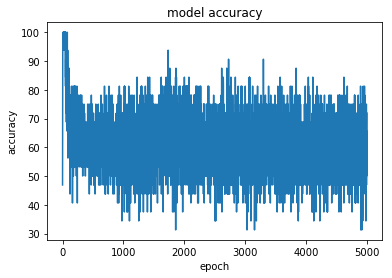

In [8]:
# mean_squared_error
if __name__ == '__main__':
    gan = GAN_4()
    gan.train(epochs=5000, batch_size=32, save_interval=200)

In [16]:
class GAN_5():
    def __init__(self):
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adagrad(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)
        
        epoch_list = []
        acc_list = []
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            #d_loss_list.append(d_loss[0])
            acc_list.append(100*d_loss[1])
            
            # summarize history for loss
            

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
            # summarize history for accuracy
        plt.plot(acc_list,label="Accuracy")
       # plt.plot(display,epoch_list,label="")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        #plt.legend(['train', 'test'], loc='upper left')
        plt.show()
                
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("C:\\Stuff\\NEU\\Big-Data Systems and Intelligent Analytics\\Project Data\\mnist_adagrad_%d.png" % epoch)
        plt.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

C:\Users\Amogh\Anaconda3\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



_________________________________________________________________
dense_27 (Dense)             (None, 784)               803600    
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
Total params: 1,493,520
Trainable params: 1,489,936
Non-trainable params: 3,584
_________________________________________________________________
0 [D loss: 0.825863, acc.: 40.62%] [G loss: 0.544842]
1 [D loss: 0.916609, acc.: 15.62%] [G loss: 0.538039]
2 [D loss: 0.991558, acc.: 21.88%] [G loss: 0.564226]
3 [D loss: 0.824692, acc.: 43.75%] [G loss: 0.513132]
4 [D loss: 0.860417, acc.: 37.50%] [G loss: 0.571634]
5 [D loss: 0.892272, acc.: 31.25%] [G loss: 0.547235]
6 [D loss: 0.821328, acc.: 37.50%] [G loss: 0.537735]
7 [D loss: 0.769426, acc.: 46.88%] [G loss: 0.516861]
8 [D loss: 0.784066, acc.: 37.50%] [G loss: 0.559483]
9 [D loss: 0.734732, acc.: 53.12%] [G loss: 0.536022]
10 [D loss: 0.729966, acc.: 50.00%] [G loss: 0.55

142 [D loss: 0.384773, acc.: 78.12%] [G loss: 0.773854]
143 [D loss: 0.455842, acc.: 65.62%] [G loss: 0.699136]
144 [D loss: 0.519253, acc.: 59.38%] [G loss: 0.735192]
145 [D loss: 0.413889, acc.: 65.62%] [G loss: 0.711542]
146 [D loss: 0.375014, acc.: 84.38%] [G loss: 0.678141]
147 [D loss: 0.384993, acc.: 78.12%] [G loss: 0.722627]
148 [D loss: 0.381734, acc.: 84.38%] [G loss: 0.715549]
149 [D loss: 0.350611, acc.: 84.38%] [G loss: 0.676281]
150 [D loss: 0.420612, acc.: 65.62%] [G loss: 0.690303]
151 [D loss: 0.403931, acc.: 78.12%] [G loss: 0.732450]
152 [D loss: 0.428072, acc.: 75.00%] [G loss: 0.725408]
153 [D loss: 0.409182, acc.: 65.62%] [G loss: 0.712268]
154 [D loss: 0.437491, acc.: 71.88%] [G loss: 0.704999]
155 [D loss: 0.393762, acc.: 75.00%] [G loss: 0.709741]
156 [D loss: 0.390940, acc.: 71.88%] [G loss: 0.755628]
157 [D loss: 0.433947, acc.: 71.88%] [G loss: 0.696781]
158 [D loss: 0.370131, acc.: 87.50%] [G loss: 0.728433]
159 [D loss: 0.358464, acc.: 87.50%] [G loss: 0.

292 [D loss: 0.304862, acc.: 90.62%] [G loss: 0.893581]
293 [D loss: 0.324754, acc.: 84.38%] [G loss: 0.912892]
294 [D loss: 0.278858, acc.: 90.62%] [G loss: 0.917578]
295 [D loss: 0.295800, acc.: 84.38%] [G loss: 0.914335]
296 [D loss: 0.295145, acc.: 87.50%] [G loss: 0.898089]
297 [D loss: 0.317292, acc.: 90.62%] [G loss: 0.915376]
298 [D loss: 0.339361, acc.: 90.62%] [G loss: 0.948930]
299 [D loss: 0.313506, acc.: 87.50%] [G loss: 0.901347]
300 [D loss: 0.297267, acc.: 93.75%] [G loss: 0.903421]
301 [D loss: 0.287176, acc.: 90.62%] [G loss: 0.938756]
302 [D loss: 0.297037, acc.: 93.75%] [G loss: 0.888920]
303 [D loss: 0.288675, acc.: 93.75%] [G loss: 0.888589]
304 [D loss: 0.331561, acc.: 90.62%] [G loss: 0.871617]
305 [D loss: 0.291217, acc.: 90.62%] [G loss: 0.928211]
306 [D loss: 0.320988, acc.: 87.50%] [G loss: 0.880887]
307 [D loss: 0.328457, acc.: 81.25%] [G loss: 0.937156]
308 [D loss: 0.354328, acc.: 81.25%] [G loss: 0.924107]
309 [D loss: 0.310814, acc.: 87.50%] [G loss: 0.

439 [D loss: 0.230656, acc.: 96.88%] [G loss: 1.028587]
440 [D loss: 0.243298, acc.: 93.75%] [G loss: 1.088619]
441 [D loss: 0.247795, acc.: 96.88%] [G loss: 1.065272]
442 [D loss: 0.252028, acc.: 96.88%] [G loss: 1.057843]
443 [D loss: 0.231927, acc.: 100.00%] [G loss: 1.071391]
444 [D loss: 0.239634, acc.: 96.88%] [G loss: 1.042173]
445 [D loss: 0.259447, acc.: 93.75%] [G loss: 1.100619]
446 [D loss: 0.277311, acc.: 96.88%] [G loss: 1.050650]
447 [D loss: 0.252819, acc.: 96.88%] [G loss: 1.143854]
448 [D loss: 0.211339, acc.: 100.00%] [G loss: 1.051399]
449 [D loss: 0.197090, acc.: 100.00%] [G loss: 1.096561]
450 [D loss: 0.248572, acc.: 96.88%] [G loss: 1.095175]
451 [D loss: 0.247060, acc.: 96.88%] [G loss: 1.052830]
452 [D loss: 0.248468, acc.: 93.75%] [G loss: 1.093420]
453 [D loss: 0.235806, acc.: 96.88%] [G loss: 1.042719]
454 [D loss: 0.228640, acc.: 96.88%] [G loss: 1.092762]
455 [D loss: 0.250031, acc.: 100.00%] [G loss: 1.072724]
456 [D loss: 0.246335, acc.: 96.88%] [G loss

588 [D loss: 0.214567, acc.: 96.88%] [G loss: 1.217358]
589 [D loss: 0.185023, acc.: 100.00%] [G loss: 1.223667]
590 [D loss: 0.214946, acc.: 96.88%] [G loss: 1.199424]
591 [D loss: 0.199393, acc.: 100.00%] [G loss: 1.283905]
592 [D loss: 0.186738, acc.: 100.00%] [G loss: 1.263277]
593 [D loss: 0.178119, acc.: 100.00%] [G loss: 1.261765]
594 [D loss: 0.212548, acc.: 100.00%] [G loss: 1.231233]
595 [D loss: 0.201096, acc.: 96.88%] [G loss: 1.279736]
596 [D loss: 0.195720, acc.: 96.88%] [G loss: 1.313092]
597 [D loss: 0.196182, acc.: 100.00%] [G loss: 1.203114]
598 [D loss: 0.195058, acc.: 100.00%] [G loss: 1.205140]
599 [D loss: 0.216517, acc.: 100.00%] [G loss: 1.186386]
600 [D loss: 0.171536, acc.: 100.00%] [G loss: 1.282757]
601 [D loss: 0.207775, acc.: 96.88%] [G loss: 1.235642]
602 [D loss: 0.177929, acc.: 96.88%] [G loss: 1.218233]
603 [D loss: 0.217477, acc.: 100.00%] [G loss: 1.264400]
604 [D loss: 0.216943, acc.: 100.00%] [G loss: 1.242583]
605 [D loss: 0.198003, acc.: 100.00%]

733 [D loss: 0.181337, acc.: 100.00%] [G loss: 1.332240]
734 [D loss: 0.180708, acc.: 100.00%] [G loss: 1.321055]
735 [D loss: 0.130075, acc.: 100.00%] [G loss: 1.322052]
736 [D loss: 0.181458, acc.: 100.00%] [G loss: 1.328613]
737 [D loss: 0.168076, acc.: 100.00%] [G loss: 1.344864]
738 [D loss: 0.166134, acc.: 96.88%] [G loss: 1.393098]
739 [D loss: 0.165568, acc.: 96.88%] [G loss: 1.302543]
740 [D loss: 0.200655, acc.: 100.00%] [G loss: 1.304453]
741 [D loss: 0.183810, acc.: 100.00%] [G loss: 1.349115]
742 [D loss: 0.165938, acc.: 100.00%] [G loss: 1.365748]
743 [D loss: 0.182912, acc.: 100.00%] [G loss: 1.298034]
744 [D loss: 0.170815, acc.: 100.00%] [G loss: 1.371877]
745 [D loss: 0.159643, acc.: 100.00%] [G loss: 1.347965]
746 [D loss: 0.192872, acc.: 100.00%] [G loss: 1.341293]
747 [D loss: 0.169299, acc.: 100.00%] [G loss: 1.394420]
748 [D loss: 0.172239, acc.: 100.00%] [G loss: 1.374146]
749 [D loss: 0.163910, acc.: 100.00%] [G loss: 1.339461]
750 [D loss: 0.170553, acc.: 100.

880 [D loss: 0.155344, acc.: 100.00%] [G loss: 1.455431]
881 [D loss: 0.148140, acc.: 96.88%] [G loss: 1.489663]
882 [D loss: 0.134582, acc.: 100.00%] [G loss: 1.487947]
883 [D loss: 0.152898, acc.: 100.00%] [G loss: 1.486784]
884 [D loss: 0.139816, acc.: 100.00%] [G loss: 1.517603]
885 [D loss: 0.131801, acc.: 100.00%] [G loss: 1.452575]
886 [D loss: 0.141854, acc.: 100.00%] [G loss: 1.411437]
887 [D loss: 0.160197, acc.: 100.00%] [G loss: 1.498145]
888 [D loss: 0.124435, acc.: 100.00%] [G loss: 1.439615]
889 [D loss: 0.133095, acc.: 100.00%] [G loss: 1.469689]
890 [D loss: 0.163864, acc.: 96.88%] [G loss: 1.344220]
891 [D loss: 0.155001, acc.: 100.00%] [G loss: 1.466354]
892 [D loss: 0.152301, acc.: 100.00%] [G loss: 1.489887]
893 [D loss: 0.164658, acc.: 100.00%] [G loss: 1.489063]
894 [D loss: 0.147145, acc.: 100.00%] [G loss: 1.494005]
895 [D loss: 0.155956, acc.: 100.00%] [G loss: 1.451620]
896 [D loss: 0.142209, acc.: 100.00%] [G loss: 1.393666]
897 [D loss: 0.156562, acc.: 100.

1026 [D loss: 0.129370, acc.: 100.00%] [G loss: 1.595362]
1027 [D loss: 0.171161, acc.: 100.00%] [G loss: 1.487938]
1028 [D loss: 0.133591, acc.: 100.00%] [G loss: 1.600598]
1029 [D loss: 0.128717, acc.: 100.00%] [G loss: 1.634032]
1030 [D loss: 0.136930, acc.: 100.00%] [G loss: 1.590971]
1031 [D loss: 0.155478, acc.: 100.00%] [G loss: 1.634012]
1032 [D loss: 0.124234, acc.: 100.00%] [G loss: 1.562916]
1033 [D loss: 0.126964, acc.: 100.00%] [G loss: 1.604343]
1034 [D loss: 0.124248, acc.: 100.00%] [G loss: 1.533783]
1035 [D loss: 0.116496, acc.: 100.00%] [G loss: 1.542510]
1036 [D loss: 0.135400, acc.: 100.00%] [G loss: 1.552684]
1037 [D loss: 0.163658, acc.: 100.00%] [G loss: 1.538473]
1038 [D loss: 0.128563, acc.: 100.00%] [G loss: 1.529633]
1039 [D loss: 0.133294, acc.: 100.00%] [G loss: 1.510194]
1040 [D loss: 0.155145, acc.: 100.00%] [G loss: 1.568210]
1041 [D loss: 0.147142, acc.: 100.00%] [G loss: 1.643512]
1042 [D loss: 0.134453, acc.: 100.00%] [G loss: 1.573520]
1043 [D loss: 

1170 [D loss: 0.133600, acc.: 100.00%] [G loss: 1.675639]
1171 [D loss: 0.127785, acc.: 100.00%] [G loss: 1.674015]
1172 [D loss: 0.138427, acc.: 100.00%] [G loss: 1.645001]
1173 [D loss: 0.127706, acc.: 100.00%] [G loss: 1.677881]
1174 [D loss: 0.130298, acc.: 100.00%] [G loss: 1.593643]
1175 [D loss: 0.107350, acc.: 100.00%] [G loss: 1.682285]
1176 [D loss: 0.126951, acc.: 100.00%] [G loss: 1.653023]
1177 [D loss: 0.139144, acc.: 100.00%] [G loss: 1.626111]
1178 [D loss: 0.115997, acc.: 100.00%] [G loss: 1.615672]
1179 [D loss: 0.123841, acc.: 100.00%] [G loss: 1.646143]
1180 [D loss: 0.133624, acc.: 100.00%] [G loss: 1.673893]
1181 [D loss: 0.112059, acc.: 100.00%] [G loss: 1.722690]
1182 [D loss: 0.109537, acc.: 100.00%] [G loss: 1.674153]
1183 [D loss: 0.124999, acc.: 100.00%] [G loss: 1.656661]
1184 [D loss: 0.109851, acc.: 100.00%] [G loss: 1.606298]
1185 [D loss: 0.123978, acc.: 100.00%] [G loss: 1.631218]
1186 [D loss: 0.107329, acc.: 100.00%] [G loss: 1.631301]
1187 [D loss: 

1313 [D loss: 0.110175, acc.: 100.00%] [G loss: 1.714367]
1314 [D loss: 0.106310, acc.: 100.00%] [G loss: 1.703204]
1315 [D loss: 0.117048, acc.: 100.00%] [G loss: 1.680897]
1316 [D loss: 0.123522, acc.: 100.00%] [G loss: 1.755855]
1317 [D loss: 0.126630, acc.: 100.00%] [G loss: 1.718909]
1318 [D loss: 0.100868, acc.: 100.00%] [G loss: 1.708902]
1319 [D loss: 0.117394, acc.: 100.00%] [G loss: 1.691944]
1320 [D loss: 0.121326, acc.: 100.00%] [G loss: 1.764787]
1321 [D loss: 0.117915, acc.: 100.00%] [G loss: 1.754529]
1322 [D loss: 0.094437, acc.: 100.00%] [G loss: 1.752839]
1323 [D loss: 0.120301, acc.: 100.00%] [G loss: 1.715991]
1324 [D loss: 0.120226, acc.: 100.00%] [G loss: 1.751464]
1325 [D loss: 0.106508, acc.: 100.00%] [G loss: 1.691708]
1326 [D loss: 0.119301, acc.: 100.00%] [G loss: 1.725605]
1327 [D loss: 0.112636, acc.: 100.00%] [G loss: 1.784988]
1328 [D loss: 0.095359, acc.: 100.00%] [G loss: 1.734036]
1329 [D loss: 0.126479, acc.: 100.00%] [G loss: 1.742676]
1330 [D loss: 

1456 [D loss: 0.113875, acc.: 100.00%] [G loss: 1.734313]
1457 [D loss: 0.100759, acc.: 100.00%] [G loss: 1.679412]
1458 [D loss: 0.102776, acc.: 100.00%] [G loss: 1.861011]
1459 [D loss: 0.097414, acc.: 100.00%] [G loss: 1.726698]
1460 [D loss: 0.101312, acc.: 100.00%] [G loss: 1.809172]
1461 [D loss: 0.110017, acc.: 100.00%] [G loss: 1.846296]
1462 [D loss: 0.096212, acc.: 100.00%] [G loss: 1.861931]
1463 [D loss: 0.101985, acc.: 100.00%] [G loss: 1.814375]
1464 [D loss: 0.102835, acc.: 100.00%] [G loss: 1.760805]
1465 [D loss: 0.097097, acc.: 100.00%] [G loss: 1.772872]
1466 [D loss: 0.105416, acc.: 100.00%] [G loss: 1.803926]
1467 [D loss: 0.110367, acc.: 100.00%] [G loss: 1.836887]
1468 [D loss: 0.099228, acc.: 100.00%] [G loss: 1.784149]
1469 [D loss: 0.103280, acc.: 100.00%] [G loss: 1.739774]
1470 [D loss: 0.110379, acc.: 100.00%] [G loss: 1.808883]
1471 [D loss: 0.094463, acc.: 100.00%] [G loss: 1.821551]
1472 [D loss: 0.110521, acc.: 100.00%] [G loss: 1.726293]
1473 [D loss: 

1600 [D loss: 0.093533, acc.: 100.00%] [G loss: 1.864628]
1601 [D loss: 0.110831, acc.: 100.00%] [G loss: 1.902003]
1602 [D loss: 0.091798, acc.: 100.00%] [G loss: 1.882971]
1603 [D loss: 0.105578, acc.: 100.00%] [G loss: 1.881399]
1604 [D loss: 0.132427, acc.: 100.00%] [G loss: 1.867763]
1605 [D loss: 0.110099, acc.: 100.00%] [G loss: 1.851388]
1606 [D loss: 0.099718, acc.: 100.00%] [G loss: 1.850767]
1607 [D loss: 0.090712, acc.: 100.00%] [G loss: 1.888327]
1608 [D loss: 0.091909, acc.: 100.00%] [G loss: 1.873536]
1609 [D loss: 0.098746, acc.: 100.00%] [G loss: 1.895883]
1610 [D loss: 0.131606, acc.: 100.00%] [G loss: 1.846885]
1611 [D loss: 0.110433, acc.: 100.00%] [G loss: 1.809990]
1612 [D loss: 0.093324, acc.: 100.00%] [G loss: 1.877493]
1613 [D loss: 0.095727, acc.: 100.00%] [G loss: 1.853008]
1614 [D loss: 0.084900, acc.: 100.00%] [G loss: 1.928402]
1615 [D loss: 0.106016, acc.: 100.00%] [G loss: 1.829906]
1616 [D loss: 0.101660, acc.: 100.00%] [G loss: 1.886836]
1617 [D loss: 

1744 [D loss: 0.088637, acc.: 100.00%] [G loss: 1.995030]
1745 [D loss: 0.099789, acc.: 100.00%] [G loss: 1.943488]
1746 [D loss: 0.093514, acc.: 100.00%] [G loss: 1.963501]
1747 [D loss: 0.098321, acc.: 100.00%] [G loss: 1.906773]
1748 [D loss: 0.102311, acc.: 100.00%] [G loss: 1.919800]
1749 [D loss: 0.086228, acc.: 100.00%] [G loss: 1.925936]
1750 [D loss: 0.099850, acc.: 100.00%] [G loss: 1.945261]
1751 [D loss: 0.092489, acc.: 100.00%] [G loss: 1.903661]
1752 [D loss: 0.109459, acc.: 100.00%] [G loss: 1.941938]
1753 [D loss: 0.080926, acc.: 100.00%] [G loss: 1.897975]
1754 [D loss: 0.083062, acc.: 100.00%] [G loss: 1.882536]
1755 [D loss: 0.084381, acc.: 100.00%] [G loss: 1.926919]
1756 [D loss: 0.095913, acc.: 100.00%] [G loss: 1.854599]
1757 [D loss: 0.087505, acc.: 100.00%] [G loss: 1.962640]
1758 [D loss: 0.086875, acc.: 100.00%] [G loss: 1.967539]
1759 [D loss: 0.101501, acc.: 100.00%] [G loss: 1.929067]
1760 [D loss: 0.078272, acc.: 100.00%] [G loss: 1.974515]
1761 [D loss: 

1889 [D loss: 0.094250, acc.: 100.00%] [G loss: 1.955922]
1890 [D loss: 0.090072, acc.: 100.00%] [G loss: 1.981407]
1891 [D loss: 0.093716, acc.: 100.00%] [G loss: 1.970387]
1892 [D loss: 0.085910, acc.: 100.00%] [G loss: 2.014483]
1893 [D loss: 0.096787, acc.: 100.00%] [G loss: 2.033160]
1894 [D loss: 0.081951, acc.: 100.00%] [G loss: 2.027056]
1895 [D loss: 0.099732, acc.: 100.00%] [G loss: 1.976621]
1896 [D loss: 0.083618, acc.: 100.00%] [G loss: 1.976935]
1897 [D loss: 0.088043, acc.: 100.00%] [G loss: 1.928883]
1898 [D loss: 0.086993, acc.: 100.00%] [G loss: 1.940004]
1899 [D loss: 0.077938, acc.: 100.00%] [G loss: 1.978355]
1900 [D loss: 0.076553, acc.: 100.00%] [G loss: 1.943710]
1901 [D loss: 0.088474, acc.: 100.00%] [G loss: 1.990026]
1902 [D loss: 0.079856, acc.: 100.00%] [G loss: 2.086432]
1903 [D loss: 0.091746, acc.: 100.00%] [G loss: 1.939498]
1904 [D loss: 0.067153, acc.: 100.00%] [G loss: 2.012573]
1905 [D loss: 0.081047, acc.: 100.00%] [G loss: 1.964836]
1906 [D loss: 

2033 [D loss: 0.077252, acc.: 100.00%] [G loss: 2.013461]
2034 [D loss: 0.084140, acc.: 100.00%] [G loss: 2.077464]
2035 [D loss: 0.084481, acc.: 100.00%] [G loss: 1.973984]
2036 [D loss: 0.078085, acc.: 100.00%] [G loss: 1.971580]
2037 [D loss: 0.067832, acc.: 100.00%] [G loss: 2.031315]
2038 [D loss: 0.082599, acc.: 100.00%] [G loss: 2.046607]
2039 [D loss: 0.098559, acc.: 100.00%] [G loss: 2.054535]
2040 [D loss: 0.068571, acc.: 100.00%] [G loss: 2.001198]
2041 [D loss: 0.090001, acc.: 100.00%] [G loss: 2.014255]
2042 [D loss: 0.101459, acc.: 100.00%] [G loss: 1.994965]
2043 [D loss: 0.099282, acc.: 100.00%] [G loss: 2.103158]
2044 [D loss: 0.075371, acc.: 100.00%] [G loss: 2.002239]
2045 [D loss: 0.068546, acc.: 100.00%] [G loss: 2.054526]
2046 [D loss: 0.081336, acc.: 100.00%] [G loss: 2.086576]
2047 [D loss: 0.095826, acc.: 100.00%] [G loss: 2.021207]
2048 [D loss: 0.072409, acc.: 100.00%] [G loss: 1.960656]
2049 [D loss: 0.088014, acc.: 100.00%] [G loss: 2.070708]
2050 [D loss: 

2178 [D loss: 0.087894, acc.: 100.00%] [G loss: 1.955825]
2179 [D loss: 0.093100, acc.: 100.00%] [G loss: 2.062638]
2180 [D loss: 0.073137, acc.: 100.00%] [G loss: 2.103464]
2181 [D loss: 0.072821, acc.: 100.00%] [G loss: 2.000112]
2182 [D loss: 0.065698, acc.: 100.00%] [G loss: 2.011751]
2183 [D loss: 0.063018, acc.: 100.00%] [G loss: 2.035419]
2184 [D loss: 0.083957, acc.: 100.00%] [G loss: 2.108061]
2185 [D loss: 0.077296, acc.: 100.00%] [G loss: 1.983518]
2186 [D loss: 0.072928, acc.: 100.00%] [G loss: 2.127862]
2187 [D loss: 0.068975, acc.: 100.00%] [G loss: 2.107511]
2188 [D loss: 0.071052, acc.: 100.00%] [G loss: 2.149365]
2189 [D loss: 0.074072, acc.: 100.00%] [G loss: 2.103626]
2190 [D loss: 0.079373, acc.: 100.00%] [G loss: 2.075145]
2191 [D loss: 0.080635, acc.: 100.00%] [G loss: 2.085276]
2192 [D loss: 0.079874, acc.: 100.00%] [G loss: 2.146286]
2193 [D loss: 0.071318, acc.: 100.00%] [G loss: 2.100110]
2194 [D loss: 0.084918, acc.: 100.00%] [G loss: 2.102462]
2195 [D loss: 

2324 [D loss: 0.083185, acc.: 100.00%] [G loss: 2.117610]
2325 [D loss: 0.067644, acc.: 100.00%] [G loss: 2.078325]
2326 [D loss: 0.078772, acc.: 100.00%] [G loss: 2.060335]
2327 [D loss: 0.077940, acc.: 100.00%] [G loss: 2.131361]
2328 [D loss: 0.083220, acc.: 100.00%] [G loss: 2.040419]
2329 [D loss: 0.066816, acc.: 100.00%] [G loss: 2.145313]
2330 [D loss: 0.081003, acc.: 100.00%] [G loss: 2.085586]
2331 [D loss: 0.085307, acc.: 100.00%] [G loss: 2.056274]
2332 [D loss: 0.071479, acc.: 100.00%] [G loss: 2.071271]
2333 [D loss: 0.080419, acc.: 100.00%] [G loss: 2.131438]
2334 [D loss: 0.068159, acc.: 100.00%] [G loss: 2.086288]
2335 [D loss: 0.075312, acc.: 100.00%] [G loss: 2.130111]
2336 [D loss: 0.066935, acc.: 100.00%] [G loss: 2.007806]
2337 [D loss: 0.075506, acc.: 100.00%] [G loss: 2.136581]
2338 [D loss: 0.078781, acc.: 100.00%] [G loss: 2.031330]
2339 [D loss: 0.075303, acc.: 100.00%] [G loss: 2.115894]
2340 [D loss: 0.077161, acc.: 100.00%] [G loss: 2.081891]
2341 [D loss: 

2466 [D loss: 0.078393, acc.: 100.00%] [G loss: 2.152803]
2467 [D loss: 0.065721, acc.: 100.00%] [G loss: 2.148949]
2468 [D loss: 0.073369, acc.: 100.00%] [G loss: 2.168519]
2469 [D loss: 0.063446, acc.: 100.00%] [G loss: 2.144999]
2470 [D loss: 0.075556, acc.: 100.00%] [G loss: 2.125789]
2471 [D loss: 0.078298, acc.: 100.00%] [G loss: 2.141400]
2472 [D loss: 0.074333, acc.: 100.00%] [G loss: 2.151453]
2473 [D loss: 0.070972, acc.: 100.00%] [G loss: 2.186094]
2474 [D loss: 0.071688, acc.: 100.00%] [G loss: 2.175677]
2475 [D loss: 0.074296, acc.: 100.00%] [G loss: 2.117781]
2476 [D loss: 0.064415, acc.: 100.00%] [G loss: 2.174104]
2477 [D loss: 0.057600, acc.: 100.00%] [G loss: 2.151278]
2478 [D loss: 0.075930, acc.: 100.00%] [G loss: 2.139537]
2479 [D loss: 0.077099, acc.: 100.00%] [G loss: 2.134473]
2480 [D loss: 0.077532, acc.: 100.00%] [G loss: 2.146551]
2481 [D loss: 0.060917, acc.: 100.00%] [G loss: 2.040467]
2482 [D loss: 0.071613, acc.: 100.00%] [G loss: 2.126379]
2483 [D loss: 

2611 [D loss: 0.068131, acc.: 100.00%] [G loss: 2.218632]
2612 [D loss: 0.064636, acc.: 100.00%] [G loss: 2.265018]
2613 [D loss: 0.071409, acc.: 100.00%] [G loss: 2.216311]
2614 [D loss: 0.061339, acc.: 100.00%] [G loss: 2.224397]
2615 [D loss: 0.066778, acc.: 100.00%] [G loss: 2.171046]
2616 [D loss: 0.059697, acc.: 100.00%] [G loss: 2.077078]
2617 [D loss: 0.071881, acc.: 100.00%] [G loss: 2.039920]
2618 [D loss: 0.060147, acc.: 100.00%] [G loss: 2.141169]
2619 [D loss: 0.081336, acc.: 100.00%] [G loss: 2.164190]
2620 [D loss: 0.066535, acc.: 100.00%] [G loss: 2.126777]
2621 [D loss: 0.075998, acc.: 100.00%] [G loss: 2.248242]
2622 [D loss: 0.058709, acc.: 100.00%] [G loss: 2.189091]
2623 [D loss: 0.078820, acc.: 100.00%] [G loss: 2.120332]
2624 [D loss: 0.075285, acc.: 100.00%] [G loss: 2.248053]
2625 [D loss: 0.063963, acc.: 100.00%] [G loss: 2.188339]
2626 [D loss: 0.061514, acc.: 100.00%] [G loss: 2.186307]
2627 [D loss: 0.070915, acc.: 100.00%] [G loss: 2.192756]
2628 [D loss: 

2753 [D loss: 0.058226, acc.: 100.00%] [G loss: 2.210846]
2754 [D loss: 0.060272, acc.: 100.00%] [G loss: 2.216551]
2755 [D loss: 0.072773, acc.: 100.00%] [G loss: 2.168389]
2756 [D loss: 0.052478, acc.: 100.00%] [G loss: 2.240581]
2757 [D loss: 0.061872, acc.: 100.00%] [G loss: 2.231267]
2758 [D loss: 0.067311, acc.: 100.00%] [G loss: 2.207153]
2759 [D loss: 0.059106, acc.: 100.00%] [G loss: 2.293179]
2760 [D loss: 0.065949, acc.: 100.00%] [G loss: 2.283721]
2761 [D loss: 0.063316, acc.: 100.00%] [G loss: 2.181476]
2762 [D loss: 0.055698, acc.: 100.00%] [G loss: 2.217459]
2763 [D loss: 0.067719, acc.: 100.00%] [G loss: 2.260247]
2764 [D loss: 0.072274, acc.: 100.00%] [G loss: 2.304418]
2765 [D loss: 0.057696, acc.: 100.00%] [G loss: 2.157769]
2766 [D loss: 0.062837, acc.: 100.00%] [G loss: 2.296317]
2767 [D loss: 0.061711, acc.: 100.00%] [G loss: 2.156033]
2768 [D loss: 0.056796, acc.: 100.00%] [G loss: 2.146884]
2769 [D loss: 0.063981, acc.: 100.00%] [G loss: 2.159721]
2770 [D loss: 

2896 [D loss: 0.062378, acc.: 100.00%] [G loss: 2.269819]
2897 [D loss: 0.073328, acc.: 100.00%] [G loss: 2.222035]
2898 [D loss: 0.070531, acc.: 100.00%] [G loss: 2.276768]
2899 [D loss: 0.063347, acc.: 100.00%] [G loss: 2.256105]
2900 [D loss: 0.070795, acc.: 100.00%] [G loss: 2.192646]
2901 [D loss: 0.053956, acc.: 100.00%] [G loss: 2.255715]
2902 [D loss: 0.076793, acc.: 100.00%] [G loss: 2.282904]
2903 [D loss: 0.062962, acc.: 100.00%] [G loss: 2.129687]
2904 [D loss: 0.064996, acc.: 100.00%] [G loss: 2.193696]
2905 [D loss: 0.066952, acc.: 100.00%] [G loss: 2.213476]
2906 [D loss: 0.057421, acc.: 100.00%] [G loss: 2.183036]
2907 [D loss: 0.062757, acc.: 100.00%] [G loss: 2.258520]
2908 [D loss: 0.066076, acc.: 100.00%] [G loss: 2.258810]
2909 [D loss: 0.060559, acc.: 100.00%] [G loss: 2.232786]
2910 [D loss: 0.061103, acc.: 100.00%] [G loss: 2.290126]
2911 [D loss: 0.065295, acc.: 100.00%] [G loss: 2.234171]
2912 [D loss: 0.060918, acc.: 100.00%] [G loss: 2.294152]
2913 [D loss: 

3040 [D loss: 0.055870, acc.: 100.00%] [G loss: 2.215662]
3041 [D loss: 0.053439, acc.: 100.00%] [G loss: 2.364161]
3042 [D loss: 0.064946, acc.: 100.00%] [G loss: 2.248605]
3043 [D loss: 0.069531, acc.: 100.00%] [G loss: 2.278605]
3044 [D loss: 0.062367, acc.: 100.00%] [G loss: 2.250970]
3045 [D loss: 0.060101, acc.: 100.00%] [G loss: 2.290375]
3046 [D loss: 0.052529, acc.: 100.00%] [G loss: 2.227290]
3047 [D loss: 0.056916, acc.: 100.00%] [G loss: 2.293120]
3048 [D loss: 0.056455, acc.: 100.00%] [G loss: 2.289148]
3049 [D loss: 0.055903, acc.: 100.00%] [G loss: 2.248962]
3050 [D loss: 0.067046, acc.: 100.00%] [G loss: 2.260970]
3051 [D loss: 0.053870, acc.: 100.00%] [G loss: 2.290233]
3052 [D loss: 0.057112, acc.: 100.00%] [G loss: 2.302081]
3053 [D loss: 0.063667, acc.: 100.00%] [G loss: 2.307776]
3054 [D loss: 0.054663, acc.: 100.00%] [G loss: 2.235944]
3055 [D loss: 0.059573, acc.: 100.00%] [G loss: 2.211460]
3056 [D loss: 0.068166, acc.: 100.00%] [G loss: 2.306579]
3057 [D loss: 

3184 [D loss: 0.057942, acc.: 100.00%] [G loss: 2.313616]
3185 [D loss: 0.058771, acc.: 100.00%] [G loss: 2.369921]
3186 [D loss: 0.069300, acc.: 100.00%] [G loss: 2.317572]
3187 [D loss: 0.072836, acc.: 100.00%] [G loss: 2.322248]
3188 [D loss: 0.062705, acc.: 100.00%] [G loss: 2.358910]
3189 [D loss: 0.059253, acc.: 100.00%] [G loss: 2.310607]
3190 [D loss: 0.059723, acc.: 100.00%] [G loss: 2.379297]
3191 [D loss: 0.053029, acc.: 100.00%] [G loss: 2.245862]
3192 [D loss: 0.058700, acc.: 100.00%] [G loss: 2.291409]
3193 [D loss: 0.077263, acc.: 100.00%] [G loss: 2.273481]
3194 [D loss: 0.060084, acc.: 100.00%] [G loss: 2.330998]
3195 [D loss: 0.056879, acc.: 100.00%] [G loss: 2.351187]
3196 [D loss: 0.061903, acc.: 100.00%] [G loss: 2.330316]
3197 [D loss: 0.071372, acc.: 100.00%] [G loss: 2.326170]
3198 [D loss: 0.071791, acc.: 100.00%] [G loss: 2.284126]
3199 [D loss: 0.056570, acc.: 100.00%] [G loss: 2.355164]
3200 [D loss: 0.059427, acc.: 100.00%] [G loss: 2.226583]
3201 [D loss: 

3326 [D loss: 0.050547, acc.: 100.00%] [G loss: 2.357795]
3327 [D loss: 0.059370, acc.: 100.00%] [G loss: 2.294357]
3328 [D loss: 0.066818, acc.: 100.00%] [G loss: 2.348949]
3329 [D loss: 0.059550, acc.: 100.00%] [G loss: 2.345626]
3330 [D loss: 0.052207, acc.: 100.00%] [G loss: 2.195150]
3331 [D loss: 0.061801, acc.: 100.00%] [G loss: 2.332859]
3332 [D loss: 0.055041, acc.: 100.00%] [G loss: 2.389887]
3333 [D loss: 0.068681, acc.: 100.00%] [G loss: 2.300586]
3334 [D loss: 0.068045, acc.: 100.00%] [G loss: 2.304337]
3335 [D loss: 0.054419, acc.: 100.00%] [G loss: 2.303064]
3336 [D loss: 0.062456, acc.: 100.00%] [G loss: 2.315107]
3337 [D loss: 0.046184, acc.: 100.00%] [G loss: 2.340529]
3338 [D loss: 0.058370, acc.: 100.00%] [G loss: 2.416224]
3339 [D loss: 0.064881, acc.: 100.00%] [G loss: 2.397067]
3340 [D loss: 0.058139, acc.: 100.00%] [G loss: 2.287595]
3341 [D loss: 0.056471, acc.: 100.00%] [G loss: 2.317253]
3342 [D loss: 0.060979, acc.: 100.00%] [G loss: 2.384620]
3343 [D loss: 

3470 [D loss: 0.055459, acc.: 100.00%] [G loss: 2.371264]
3471 [D loss: 0.059932, acc.: 100.00%] [G loss: 2.423229]
3472 [D loss: 0.058558, acc.: 100.00%] [G loss: 2.326564]
3473 [D loss: 0.062194, acc.: 100.00%] [G loss: 2.260227]
3474 [D loss: 0.064462, acc.: 100.00%] [G loss: 2.310037]
3475 [D loss: 0.058563, acc.: 100.00%] [G loss: 2.355805]
3476 [D loss: 0.050052, acc.: 100.00%] [G loss: 2.386308]
3477 [D loss: 0.066321, acc.: 100.00%] [G loss: 2.371800]
3478 [D loss: 0.058911, acc.: 100.00%] [G loss: 2.322939]
3479 [D loss: 0.050875, acc.: 100.00%] [G loss: 2.295540]
3480 [D loss: 0.062779, acc.: 100.00%] [G loss: 2.369838]
3481 [D loss: 0.049206, acc.: 100.00%] [G loss: 2.372446]
3482 [D loss: 0.054280, acc.: 100.00%] [G loss: 2.343932]
3483 [D loss: 0.063327, acc.: 100.00%] [G loss: 2.320010]
3484 [D loss: 0.066433, acc.: 100.00%] [G loss: 2.419223]
3485 [D loss: 0.058238, acc.: 100.00%] [G loss: 2.354275]
3486 [D loss: 0.062911, acc.: 100.00%] [G loss: 2.306326]
3487 [D loss: 

3615 [D loss: 0.058525, acc.: 100.00%] [G loss: 2.391846]
3616 [D loss: 0.058647, acc.: 100.00%] [G loss: 2.419488]
3617 [D loss: 0.049692, acc.: 100.00%] [G loss: 2.367487]
3618 [D loss: 0.045877, acc.: 100.00%] [G loss: 2.299438]
3619 [D loss: 0.056290, acc.: 100.00%] [G loss: 2.399279]
3620 [D loss: 0.056191, acc.: 100.00%] [G loss: 2.455781]
3621 [D loss: 0.044551, acc.: 100.00%] [G loss: 2.374159]
3622 [D loss: 0.062157, acc.: 100.00%] [G loss: 2.380826]
3623 [D loss: 0.047387, acc.: 100.00%] [G loss: 2.366921]
3624 [D loss: 0.054966, acc.: 100.00%] [G loss: 2.358424]
3625 [D loss: 0.063624, acc.: 100.00%] [G loss: 2.507255]
3626 [D loss: 0.057247, acc.: 100.00%] [G loss: 2.399024]
3627 [D loss: 0.060664, acc.: 100.00%] [G loss: 2.309749]
3628 [D loss: 0.051601, acc.: 100.00%] [G loss: 2.341630]
3629 [D loss: 0.057439, acc.: 100.00%] [G loss: 2.435082]
3630 [D loss: 0.056078, acc.: 100.00%] [G loss: 2.332650]
3631 [D loss: 0.057321, acc.: 100.00%] [G loss: 2.362246]
3632 [D loss: 

3759 [D loss: 0.053676, acc.: 100.00%] [G loss: 2.403834]
3760 [D loss: 0.061059, acc.: 100.00%] [G loss: 2.403841]
3761 [D loss: 0.062343, acc.: 100.00%] [G loss: 2.416674]
3762 [D loss: 0.060089, acc.: 100.00%] [G loss: 2.452394]
3763 [D loss: 0.049465, acc.: 100.00%] [G loss: 2.417628]
3764 [D loss: 0.049131, acc.: 100.00%] [G loss: 2.407314]
3765 [D loss: 0.059437, acc.: 100.00%] [G loss: 2.472486]
3766 [D loss: 0.049721, acc.: 100.00%] [G loss: 2.412244]
3767 [D loss: 0.053799, acc.: 100.00%] [G loss: 2.390554]
3768 [D loss: 0.056683, acc.: 100.00%] [G loss: 2.400441]
3769 [D loss: 0.052438, acc.: 100.00%] [G loss: 2.399978]
3770 [D loss: 0.051889, acc.: 100.00%] [G loss: 2.365865]
3771 [D loss: 0.045950, acc.: 100.00%] [G loss: 2.375807]
3772 [D loss: 0.056857, acc.: 100.00%] [G loss: 2.505096]
3773 [D loss: 0.052353, acc.: 100.00%] [G loss: 2.425713]
3774 [D loss: 0.060877, acc.: 100.00%] [G loss: 2.355691]
3775 [D loss: 0.056714, acc.: 100.00%] [G loss: 2.418012]
3776 [D loss: 

3902 [D loss: 0.046186, acc.: 100.00%] [G loss: 2.421024]
3903 [D loss: 0.055880, acc.: 100.00%] [G loss: 2.462415]
3904 [D loss: 0.054468, acc.: 100.00%] [G loss: 2.485795]
3905 [D loss: 0.050391, acc.: 100.00%] [G loss: 2.418336]
3906 [D loss: 0.059188, acc.: 100.00%] [G loss: 2.348532]
3907 [D loss: 0.046748, acc.: 100.00%] [G loss: 2.368712]
3908 [D loss: 0.051441, acc.: 100.00%] [G loss: 2.479785]
3909 [D loss: 0.045223, acc.: 100.00%] [G loss: 2.408066]
3910 [D loss: 0.065853, acc.: 100.00%] [G loss: 2.480468]
3911 [D loss: 0.059696, acc.: 100.00%] [G loss: 2.523471]
3912 [D loss: 0.064923, acc.: 100.00%] [G loss: 2.508277]
3913 [D loss: 0.047102, acc.: 100.00%] [G loss: 2.450696]
3914 [D loss: 0.059187, acc.: 100.00%] [G loss: 2.475996]
3915 [D loss: 0.052821, acc.: 100.00%] [G loss: 2.324303]
3916 [D loss: 0.053010, acc.: 100.00%] [G loss: 2.396537]
3917 [D loss: 0.049611, acc.: 100.00%] [G loss: 2.457364]
3918 [D loss: 0.060851, acc.: 100.00%] [G loss: 2.359464]
3919 [D loss: 

4046 [D loss: 0.046995, acc.: 100.00%] [G loss: 2.541809]
4047 [D loss: 0.047489, acc.: 100.00%] [G loss: 2.514108]
4048 [D loss: 0.057688, acc.: 100.00%] [G loss: 2.439494]
4049 [D loss: 0.047962, acc.: 100.00%] [G loss: 2.466601]
4050 [D loss: 0.041750, acc.: 100.00%] [G loss: 2.428633]
4051 [D loss: 0.053957, acc.: 100.00%] [G loss: 2.470529]
4052 [D loss: 0.054525, acc.: 100.00%] [G loss: 2.451061]
4053 [D loss: 0.044519, acc.: 100.00%] [G loss: 2.424696]
4054 [D loss: 0.052350, acc.: 100.00%] [G loss: 2.396678]
4055 [D loss: 0.060489, acc.: 100.00%] [G loss: 2.436890]
4056 [D loss: 0.049984, acc.: 100.00%] [G loss: 2.400608]
4057 [D loss: 0.048314, acc.: 100.00%] [G loss: 2.485297]
4058 [D loss: 0.044694, acc.: 100.00%] [G loss: 2.448584]
4059 [D loss: 0.043033, acc.: 100.00%] [G loss: 2.502860]
4060 [D loss: 0.055139, acc.: 100.00%] [G loss: 2.451616]
4061 [D loss: 0.042812, acc.: 100.00%] [G loss: 2.431684]
4062 [D loss: 0.056735, acc.: 100.00%] [G loss: 2.347806]
4063 [D loss: 

4190 [D loss: 0.049755, acc.: 100.00%] [G loss: 2.557234]
4191 [D loss: 0.058697, acc.: 100.00%] [G loss: 2.492213]
4192 [D loss: 0.055562, acc.: 100.00%] [G loss: 2.387002]
4193 [D loss: 0.054264, acc.: 100.00%] [G loss: 2.441229]
4194 [D loss: 0.049161, acc.: 100.00%] [G loss: 2.486382]
4195 [D loss: 0.043016, acc.: 100.00%] [G loss: 2.447739]
4196 [D loss: 0.047453, acc.: 100.00%] [G loss: 2.489097]
4197 [D loss: 0.050500, acc.: 100.00%] [G loss: 2.516705]
4198 [D loss: 0.057497, acc.: 100.00%] [G loss: 2.430796]
4199 [D loss: 0.055545, acc.: 100.00%] [G loss: 2.456944]
4200 [D loss: 0.046109, acc.: 100.00%] [G loss: 2.518124]
4201 [D loss: 0.050016, acc.: 100.00%] [G loss: 2.510716]
4202 [D loss: 0.056725, acc.: 100.00%] [G loss: 2.397741]
4203 [D loss: 0.048073, acc.: 100.00%] [G loss: 2.533138]
4204 [D loss: 0.050151, acc.: 100.00%] [G loss: 2.478916]
4205 [D loss: 0.045013, acc.: 100.00%] [G loss: 2.580421]
4206 [D loss: 0.050110, acc.: 100.00%] [G loss: 2.375090]
4207 [D loss: 

4332 [D loss: 0.043128, acc.: 100.00%] [G loss: 2.557432]
4333 [D loss: 0.045889, acc.: 100.00%] [G loss: 2.496845]
4334 [D loss: 0.048396, acc.: 100.00%] [G loss: 2.400296]
4335 [D loss: 0.042917, acc.: 100.00%] [G loss: 2.573429]
4336 [D loss: 0.051999, acc.: 100.00%] [G loss: 2.474072]
4337 [D loss: 0.042313, acc.: 100.00%] [G loss: 2.487537]
4338 [D loss: 0.055208, acc.: 100.00%] [G loss: 2.402137]
4339 [D loss: 0.047586, acc.: 100.00%] [G loss: 2.489349]
4340 [D loss: 0.047329, acc.: 100.00%] [G loss: 2.463457]
4341 [D loss: 0.044823, acc.: 100.00%] [G loss: 2.529668]
4342 [D loss: 0.047399, acc.: 100.00%] [G loss: 2.473427]
4343 [D loss: 0.047313, acc.: 100.00%] [G loss: 2.527308]
4344 [D loss: 0.046167, acc.: 100.00%] [G loss: 2.530868]
4345 [D loss: 0.047062, acc.: 100.00%] [G loss: 2.435700]
4346 [D loss: 0.052153, acc.: 100.00%] [G loss: 2.463852]
4347 [D loss: 0.049217, acc.: 100.00%] [G loss: 2.556365]
4348 [D loss: 0.057672, acc.: 100.00%] [G loss: 2.479919]
4349 [D loss: 

4475 [D loss: 0.047217, acc.: 100.00%] [G loss: 2.516950]
4476 [D loss: 0.047280, acc.: 100.00%] [G loss: 2.558134]
4477 [D loss: 0.048070, acc.: 100.00%] [G loss: 2.460027]
4478 [D loss: 0.047161, acc.: 100.00%] [G loss: 2.537869]
4479 [D loss: 0.038656, acc.: 100.00%] [G loss: 2.519630]
4480 [D loss: 0.054102, acc.: 100.00%] [G loss: 2.551580]
4481 [D loss: 0.048505, acc.: 100.00%] [G loss: 2.549910]
4482 [D loss: 0.047536, acc.: 100.00%] [G loss: 2.503295]
4483 [D loss: 0.057866, acc.: 100.00%] [G loss: 2.506077]
4484 [D loss: 0.062508, acc.: 100.00%] [G loss: 2.529886]
4485 [D loss: 0.043631, acc.: 100.00%] [G loss: 2.503045]
4486 [D loss: 0.059971, acc.: 100.00%] [G loss: 2.459633]
4487 [D loss: 0.043705, acc.: 100.00%] [G loss: 2.516607]
4488 [D loss: 0.033388, acc.: 100.00%] [G loss: 2.507284]
4489 [D loss: 0.040286, acc.: 100.00%] [G loss: 2.620443]
4490 [D loss: 0.041316, acc.: 100.00%] [G loss: 2.628780]
4491 [D loss: 0.065152, acc.: 100.00%] [G loss: 2.458130]
4492 [D loss: 

4619 [D loss: 0.046332, acc.: 100.00%] [G loss: 2.460778]
4620 [D loss: 0.050703, acc.: 100.00%] [G loss: 2.423976]
4621 [D loss: 0.047025, acc.: 100.00%] [G loss: 2.543909]
4622 [D loss: 0.051193, acc.: 100.00%] [G loss: 2.508601]
4623 [D loss: 0.055286, acc.: 100.00%] [G loss: 2.533291]
4624 [D loss: 0.054037, acc.: 100.00%] [G loss: 2.528434]
4625 [D loss: 0.050411, acc.: 100.00%] [G loss: 2.490431]
4626 [D loss: 0.052191, acc.: 100.00%] [G loss: 2.536776]
4627 [D loss: 0.051704, acc.: 100.00%] [G loss: 2.558725]
4628 [D loss: 0.042880, acc.: 100.00%] [G loss: 2.506107]
4629 [D loss: 0.047410, acc.: 100.00%] [G loss: 2.523013]
4630 [D loss: 0.048878, acc.: 100.00%] [G loss: 2.503979]
4631 [D loss: 0.056649, acc.: 100.00%] [G loss: 2.507855]
4632 [D loss: 0.038700, acc.: 100.00%] [G loss: 2.621029]
4633 [D loss: 0.046327, acc.: 100.00%] [G loss: 2.597591]
4634 [D loss: 0.049084, acc.: 100.00%] [G loss: 2.452998]
4635 [D loss: 0.048250, acc.: 100.00%] [G loss: 2.566619]
4636 [D loss: 

4763 [D loss: 0.059140, acc.: 100.00%] [G loss: 2.594264]
4764 [D loss: 0.050008, acc.: 100.00%] [G loss: 2.579171]
4765 [D loss: 0.041376, acc.: 100.00%] [G loss: 2.568758]
4766 [D loss: 0.051695, acc.: 100.00%] [G loss: 2.591386]
4767 [D loss: 0.047967, acc.: 100.00%] [G loss: 2.583873]
4768 [D loss: 0.050146, acc.: 100.00%] [G loss: 2.524281]
4769 [D loss: 0.050113, acc.: 100.00%] [G loss: 2.549773]
4770 [D loss: 0.040321, acc.: 100.00%] [G loss: 2.524666]
4771 [D loss: 0.046964, acc.: 100.00%] [G loss: 2.488372]
4772 [D loss: 0.045676, acc.: 100.00%] [G loss: 2.582632]
4773 [D loss: 0.045941, acc.: 100.00%] [G loss: 2.548243]
4774 [D loss: 0.049201, acc.: 100.00%] [G loss: 2.560537]
4775 [D loss: 0.060353, acc.: 100.00%] [G loss: 2.487845]
4776 [D loss: 0.055769, acc.: 100.00%] [G loss: 2.576935]
4777 [D loss: 0.044174, acc.: 100.00%] [G loss: 2.535092]
4778 [D loss: 0.052612, acc.: 100.00%] [G loss: 2.510376]
4779 [D loss: 0.042352, acc.: 100.00%] [G loss: 2.552610]
4780 [D loss: 

4905 [D loss: 0.061591, acc.: 100.00%] [G loss: 2.569918]
4906 [D loss: 0.046784, acc.: 100.00%] [G loss: 2.583604]
4907 [D loss: 0.043200, acc.: 100.00%] [G loss: 2.643900]
4908 [D loss: 0.045281, acc.: 100.00%] [G loss: 2.547316]
4909 [D loss: 0.045740, acc.: 100.00%] [G loss: 2.585886]
4910 [D loss: 0.048573, acc.: 100.00%] [G loss: 2.546142]
4911 [D loss: 0.046421, acc.: 100.00%] [G loss: 2.664518]
4912 [D loss: 0.047493, acc.: 100.00%] [G loss: 2.542633]
4913 [D loss: 0.041743, acc.: 100.00%] [G loss: 2.574929]
4914 [D loss: 0.050099, acc.: 100.00%] [G loss: 2.616108]
4915 [D loss: 0.049977, acc.: 100.00%] [G loss: 2.626165]
4916 [D loss: 0.040949, acc.: 100.00%] [G loss: 2.555111]
4917 [D loss: 0.040232, acc.: 100.00%] [G loss: 2.527090]
4918 [D loss: 0.053507, acc.: 100.00%] [G loss: 2.564638]
4919 [D loss: 0.054651, acc.: 100.00%] [G loss: 2.638473]
4920 [D loss: 0.052131, acc.: 100.00%] [G loss: 2.498052]
4921 [D loss: 0.039675, acc.: 100.00%] [G loss: 2.525367]
4922 [D loss: 

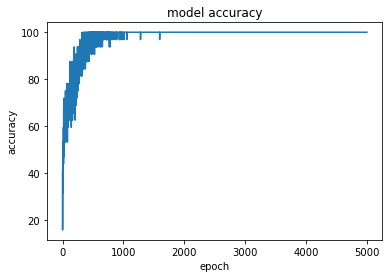

In [17]:
# Adagrad
if __name__ == '__main__':
    gan = GAN_5()
    gan.train(epochs=5000, batch_size=32, save_interval=200)

In [10]:
class GAN_6():
    def __init__(self):
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        self.discriminator = Sequential()

        self.discriminator.add(Flatten(input_shape=img_shape))
        self.discriminator.add(Dense(512))
        self.discriminator.add(LeakyReLU(alpha=0.2))
        self.discriminator.add(Dense(256))
        self.discriminator.add(LeakyReLU(alpha=0.2))
        self.discriminator.add(Dense(1, activation='sigmoid'))
        self.discriminator.summary()

        img = Input(shape=img_shape)
        validity = self.discriminator(img)

        return Model(img, validity)
    
    def build_generator(self):

        noise_shape = (100,)
        
        self.generator = Sequential()

        self.generator.add(Dense(256, input_shape=noise_shape))
        self.generator.add(LeakyReLU(alpha=0.2))
        self.generator.add(BatchNormalization(momentum=0.8))
        self.generator.add(Dense(512))
        self.generator.add(LeakyReLU(alpha=0.2))
        self.generator.add(BatchNormalization(momentum=0.8))
        self.generator.add(Dense(1024))
        self.generator.add(LeakyReLU(alpha=0.2))
        self.generator.add(BatchNormalization(momentum=0.8))
        self.generator.add(Dense(np.prod(self.img_shape), activation='tanh'))
        self.generator.add(Reshape(self.img_shape))

        self.generator.summary()

        noise = Input(shape=noise_shape)
        img = self.generator(noise)

        return Model(noise, img)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)
        
        epoch_list = []
        acc_list = []
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            #d_loss_list.append(d_loss[0])
            acc_list.append(100*d_loss[1])
            
            # summarize history for loss
            

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
            # summarize history for accuracy
        plt.plot(acc_list,label="Accuracy")
       # plt.plot(display,epoch_list,label="")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        #plt.legend(['train', 'test'], loc='upper left')
        plt.show()
                
    def save_imgs(self, epoch):
        r, c = 4, 4
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("GAN_mnist_%d.png" % epoch)
        plt.close()

In [11]:
# 4*4 Image
if __name__ == '__main__':
    gan = GAN_6()
    gan.train(epochs=1000, batch_size=32, save_interval=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

C:\Users\Amogh\Anaconda3\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


reshape_3 (Reshape)          (None, 28, 28, 1)         0         
Total params: 1,493,520
Trainable params: 1,489,936
Non-trainable params: 3,584
_________________________________________________________________
0 [D loss: 0.766590, acc.: 12.50%] [G loss: 0.639242]
1 [D loss: 0.421997, acc.: 75.00%] [G loss: 0.716946]
2 [D loss: 0.321856, acc.: 78.12%] [G loss: 0.815737]
3 [D loss: 0.291243, acc.: 87.50%] [G loss: 0.960183]
4 [D loss: 0.342232, acc.: 84.38%] [G loss: 1.030307]
5 [D loss: 0.226786, acc.: 93.75%] [G loss: 1.184660]
6 [D loss: 0.189030, acc.: 100.00%] [G loss: 1.376541]
7 [D loss: 0.212001, acc.: 100.00%] [G loss: 1.472051]
8 [D loss: 0.140993, acc.: 100.00%] [G loss: 1.596143]
9 [D loss: 0.156777, acc.: 100.00%] [G loss: 1.730216]
10 [D loss: 0.109190, acc.: 100.00%] [G loss: 1.762149]
11 [D loss: 0.114197, acc.: 100.00%] [G loss: 1.849696]
12 [D loss: 0.093302, acc.: 100.00%] [G loss: 1.860690]
13 [D loss: 0.095512, acc.: 100.00%] [G loss: 1.985549]
14 [D loss: 0.092783

143 [D loss: 0.160223, acc.: 96.88%] [G loss: 3.855853]
144 [D loss: 0.212946, acc.: 90.62%] [G loss: 3.370649]
145 [D loss: 0.083244, acc.: 93.75%] [G loss: 4.138354]
146 [D loss: 0.162000, acc.: 96.88%] [G loss: 3.125344]
147 [D loss: 0.206251, acc.: 90.62%] [G loss: 4.397602]
148 [D loss: 0.127492, acc.: 93.75%] [G loss: 3.027616]
149 [D loss: 0.110632, acc.: 93.75%] [G loss: 3.529021]
150 [D loss: 0.088805, acc.: 100.00%] [G loss: 3.786165]
151 [D loss: 0.270387, acc.: 90.62%] [G loss: 3.772602]
152 [D loss: 0.329017, acc.: 87.50%] [G loss: 3.361868]
153 [D loss: 0.144001, acc.: 93.75%] [G loss: 4.466662]
154 [D loss: 0.814860, acc.: 71.88%] [G loss: 2.933382]
155 [D loss: 0.102028, acc.: 96.88%] [G loss: 3.522187]
156 [D loss: 0.115222, acc.: 100.00%] [G loss: 3.718883]
157 [D loss: 0.274460, acc.: 87.50%] [G loss: 2.959669]
158 [D loss: 0.248522, acc.: 84.38%] [G loss: 4.694136]
159 [D loss: 1.917742, acc.: 31.25%] [G loss: 1.703799]
160 [D loss: 0.774445, acc.: 68.75%] [G loss: 

KeyboardInterrupt: 

#### Activation function
 1. We used Sigmoid in Discriminator as the ragne of Sigmoid is from 0 to 1 and Discriminator's o/p is in range of 0 to 1
 2. When we used Sigmoid in Generator, it was not able to generate images as there was loss of the values less than 0.
 3. When TanH is used in generator, the images generated are much better

#### Cost function
 1. We used binary_crossentropy first
 
#### Epochs
 1. 100 Epochs, 32 Batch size - Very blury
 2. 1000 Epochs, 64 Batch size - Very slight better results, but no significant improvement
 3. 5000 Epochs, 64 Batch size - Little Bit better than the previous result
 4. 30000 Epochs, 32 Batch size - The results were much better this time, but still the generated images were not sharp enough compared to real images
 5. 50000 Epochs, 32 Batch size - There was no significant improvement in the results than the one with 30000 epochs. We saw some good results in 45000 to 47000 epochs but the sharpness degraded after that.
 
#### Gradient estimation
 1. ADAM (learning rate = 0.0002 - Generates Image
 2. ADAGRAD (lr = 0.0002) does not generate images

#### Network Architecture
 1. Added a new layer of size 2048 - Slows down the process. No significant change in images
 2. Removed a layer of size 1024 - increased speed. Output images were blury.

##### References:
 - https://deeplearning4j.org/generative-adversarial-network
 - http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7550880
 - https://arxiv.org/pdf/1406.2661.pdf
 - https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

#### MIT License

Copyright 2018 Amogh Chakkarewar, Mohit Arya, Shashank Jain

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.